# Introduction

We tackle the problem of post processing on top of sequence learning text problems, like OCR or Speech recognition. 

In OCR for example, we map the image form of the document into the text domain. This is done first using an CNN+LSTM+CTC model, in our case based on tesseract. Since this output maps only image to text, we need something on top to validate and correct language semantics.

The idea is to build a language model, that takes the OCRed text and corrects it based on language knowledge. The langauge model could be:
- Char level: the aim is to capture the word morphology. In which case it's like a spelling correction system.
- Word level: the aim is to capture the sentence semnatics. But such systems suffer from the OOV problem.
- Fusion: to capture semantics and morphology language rules. The output has to be at char level, to avoid the OOV. However, the input can be char, word or both.

The fusion model target is to learn:

    p(char | char_context, word_context)
    



## Offline correction and the curse of sequence length
In either case of OCR or speech recognition, this can be thought of a variant of a spelling correction model. However, correction in this case is offline, in contrast to online correction that takes place in Google Search auto-complete or spelling correction in many word processors. This offlien nature makes it harder for language models, as error can propagate as the sequence gets longer.

We can think of two possible approaches to the post processing problem:

## Statistical based: Hidden-Markov Models
The spelling correction problem could be modeled as Probablistic Graphical Model (PGM), assuming the Markovian property (Memoryless: the current word depends only on the previous state). The state is a summarization of all the previous words

![noisy_channel_model](https://sandipanweb.files.wordpress.com/2017/05/im0_2.png?w=768)

In this case, we can solve the HMM using one of 2 techniques:

### Noisy channel model
### Viterbi decoder

Which we will tackle later.

## Learning based: Sequence-to-sequence NLM
Post-processing is a sequence learning problem. Seq2seq is a "many-many" problem, which can be classified into:
- Aligned
- Unaligned
![sequence-learning-types](https://s3-ap-south-1.amazonaws.com/av-blog-media/wp-content/uploads/2018/03/1-850x465.png)

In case of End-to-end learning, we can only have training data for the unaligned case, due to the edits (insertion, deletion) that can take place in the text. 

In this workbook we use seq2seq vanilla Keras implementation, adapted from the lstm_seq2seq example on Eng-Fra translation task. 
The basic model is based on (https://arxiv.org/abs/1409.0473), however, implementation in Keras requires fundamental changes in LSTM layer, hence, a more simplified implementation is followed as in (https://wanasit.github.io/attention-based-sequence-to-sequence-in-keras.html, https://arxiv.org/abs/1508.04025)


# Imports

In [1]:
from __future__ import print_function
import tensorflow as tf
import keras.backend as K
from keras.backend.tensorflow_backend import set_session
from keras.models import Model
from keras.layers import Input, LSTM, Dense, Bidirectional, Concatenate, GRU, Dot, TimeDistributed, Activation, Embedding
from keras import optimizers
from keras.callbacks import ModelCheckpoint, TensorBoard, LearningRateScheduler
import numpy as np
import os
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import json
%matplotlib inline

/opt/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Utility functions

In [2]:
# Limit gpu allocation. allow_growth, or gpu_fraction
def gpu_alloc(device_id):
    os.environ["CUDA_VISIBLE_DEVICES"]=device_id
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    set_session(tf.Session(config=config))

In [3]:
!nvidia-smi

Mon Mar  4 03:28:05 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 396.54                 Driver Version: 396.54                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 108...  Off  | 00000000:17:00.0 Off |                  N/A |
| 41%   73C    P2   176W / 250W |   4004MiB / 11178MiB |     83%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX 108...  Off  | 00000000:65:00.0  On |                  N/A |
| 50%   81C    P2   136W / 250W |   2510MiB / 11177MiB |     65%      Default |
+-------------------------------+----------------------+----------------------+
        

In [4]:
gpu_alloc('0')

In [5]:
def calculate_WER_sent(gt, pred):
    '''
    calculate_WER('calculating wer between two sentences', 'calculate wer between two sentences')
    '''
    gt_words = gt.lower().split(' ')
    pred_words = pred.lower().split(' ')
    d = np.zeros(((len(gt_words) + 1), (len(pred_words) + 1)), dtype=np.uint8)
    # d = d.reshape((len(gt_words)+1, len(pred_words)+1))

    # Initializing error matrix
    for i in range(len(gt_words) + 1):
        for j in range(len(pred_words) + 1):
            if i == 0:
                d[0][j] = j
            elif j == 0:
                d[i][0] = i

    # computation
    for i in range(1, len(gt_words) + 1):
        for j in range(1, len(pred_words) + 1):
            if gt_words[i - 1] == pred_words[j - 1]:
                d[i][j] = d[i - 1][j - 1]
            else:
                substitution = d[i - 1][j - 1] + 1
                insertion = d[i][j - 1] + 1
                deletion = d[i - 1][j] + 1
                d[i][j] = min(substitution, insertion, deletion)
    return d[len(gt_words)][len(pred_words)]

In [6]:
def calculate_WER(gt, pred):
    '''

    :param gt: list of sentences of the ground truth
    :param pred: list of sentences of the predictions
    both lists must have the same length
    :return: accumulated WER
    '''
#    assert len(gt) == len(pred)
    WER = 0
    nb_w = 0
    for i in range(len(gt)):
        #print(gt[i])
        #print(pred[i])
        WER += calculate_WER_sent(gt[i], pred[i])
        nb_w += len(gt[i])

    return WER / nb_w

In [7]:
# Artificial noisy spelling mistakes
def noise_maker(sentence, threshold):
    '''Relocate, remove, or add characters to create spelling mistakes'''
    letters = ['a','b','c','d','e','f','g','h','i','j','k','l','m',
           'n','o','p','q','r','s','t','u','v','w','x','y','z',]
    noisy_sentence = []
    i = 0
    while i < len(sentence):
        random = np.random.uniform(0, 1, 1)
        # Most characters will be correct since the threshold value is high
        if random < threshold:
            noisy_sentence.append(sentence[i])
        else:
            new_random = np.random.uniform(0, 1, 1)
            # ~33% chance characters will swap locations
            if new_random > 0.67:
                if i == (len(sentence) - 1):
                    # If last character in sentence, it will not be typed
                    continue
                else:
                    # if any other character, swap order with following character
                    noisy_sentence.append(sentence[i + 1])
                    noisy_sentence.append(sentence[i])
                    i += 1
            # ~33% chance an extra lower case letter will be added to the sentence
            elif new_random < 0.33:
                random_letter = np.random.choice(letters, 1)[0]
                noisy_sentence.append(random_letter)
                noisy_sentence.append(sentence[i])
            # ~33% chance a character will not be typed
            else:
                pass
        i += 1

    return ''.join(noisy_sentence)

In [8]:
def load_data_with_gt(file_name, num_samples, max_sent_len, min_sent_len, delimiter='\t', gt_index=1, prediction_index=0):
    '''Load data from txt file, with each line has: <TXT><TAB><GT>. The  target to the decoder muxt have \t as the start trigger and \n as the stop trigger.'''
    cnt = 0  
    input_texts = []
    gt_texts = []
    target_texts = []
    for row in open(file_name, encoding='utf8'):
        if cnt < num_samples :
            #print(row)
            sents = row.split(delimiter)
            if (len(sents) < 2):
                continue            
            input_text = sents[prediction_index]
            
            target_text = '\t' + sents[gt_index] + '\n'
            if len(input_text) > min_sent_len and len(input_text) < max_sent_len and len(target_text) > min_sent_len and len(target_text) < max_sent_len:
                cnt += 1
                
                input_texts.append(input_text)
                target_texts.append(target_text)
                gt_texts.append(sents[gt_index])
    return input_texts, target_texts, gt_texts

In [9]:
def load_data_with_noise(file_name, num_samples, noise_threshold, max_sent_len, min_sent_len):
    '''Load data from txt file, with each line has: <TXT>. The GT is just a noisy version of TXT. The  target to the decoder muxt have \t as the start trigger and \n as the stop trigger.'''
    cnt = 0  
    input_texts = []
    gt_texts = []
    target_texts = []
    while cnt < num_samples :
        for row in open(file_name, encoding='utf8'):
        #for row in open(file_name):
            if cnt < num_samples :
                sents = row.split("\t")
                if (len(sents) < 2):
                    continue                
                input_text = noise_maker(sents[1], noise_threshold)
                input_text = input_text[:-1]

                target_text = '\t' + sents[1] + '\n'            
                if len(input_text) > min_sent_len and len(input_text) < max_sent_len and len(target_text) > min_sent_len and len(target_text) < max_sent_len:
                    cnt += 1
                    input_texts.append(input_text)
                    target_texts.append(target_text)
                    gt_texts.append(target_text[1:-1])
                    
    return input_texts, target_texts, gt_texts

In [10]:
def load_medical_terms_with_noise(json_file, num_samples, noise_threshold):
    with open(json_file) as f:
        med_terms_dict = json.load(f)
    med_terms = list(med_terms_dict.keys())
    input_texts = []
    gt_texts = []
    target_texts = []
    cnt = 0
    while cnt < num_samples:
        for term in med_terms:
            if cnt < num_samples :
                input_text = noise_maker(term, noise_threshold)
                input_text = input_text[:-1]   

                target_text = '\t' + term + '\n'

                input_texts.append(input_text)
                target_texts.append(target_text)
                gt_texts.append(target_text[1:-1])        
                cnt += 1
    return input_texts, target_texts, gt_texts, med_terms_dict

In [11]:
def load_accidents_terms_with_noise(file_name, limit, num_samples, noise_threshold):

    f = open(file_name, encoding='utf8')
    line = 0    
    med_terms = []
    try:
        for r in f:
            if(line < limit):

                med_terms.extend(r.split('|'))
                line += 1
    except:
        print('finished')
    input_texts = []
    gt_texts = []
    target_texts = []
    cnt = 0
    while cnt < num_samples:
        for term in med_terms:
            if cnt < num_samples :
                input_text = noise_maker(term, noise_threshold)
                input_text = input_text[:-1]   

                target_text = '\t' + term + '\n'

                input_texts.append(input_text)
                target_texts.append(target_text)
                gt_texts.append(target_text[1:-1])        
                cnt += 1
                
    return input_texts, target_texts, gt_texts

In [12]:
def load_procedures_tests_with_noise(file_name, num_samples, noise_threshold):
    '''Load data from txt file, with each line has: <TXT>. The GT is just a noisy version of TXT. The  target to the decoder muxt have \t as the start trigger and \n as the stop trigger.'''
    cnt = 0  
    input_texts = []
    gt_texts = []
    target_texts = []
    while cnt < num_samples :
        for row in open(file_name, encoding='utf8'):
        #for row in open(file_name):
            if cnt < num_samples :
                
                input_text = noise_maker(row, noise_threshold)
                input_text = input_text[:-1]

                target_text = '\t' + row + '\n'            

                cnt += 1
                input_texts.append(input_text)
                target_texts.append(target_text)
                gt_texts.append(target_text[1:-1])
                    
    return input_texts, target_texts, gt_texts

In [13]:
def build_vocab(all_texts):
    '''Build vocab dictionary to victorize chars into ints'''
    vocab_to_int = {}
    count = 0 # Start index for any char will be 1, as 0 is masked by the Embedding/Masking layer
    codes = ['UNK', ' ', '\t','\n']# Start 'UNK' at the first entry, to keep its index=0 to be masked
    for code in codes:
        if code not in vocab_to_int:
            vocab_to_int[code] = count
            count += 1    
    
    for sentence in all_texts:
        for char in sentence:
            if char not in vocab_to_int:
                vocab_to_int[char] = count
                count += 1


    '''''Build inverse translation from int to char'''
    int_to_vocab = {}
    for character, value in vocab_to_int.items():
        int_to_vocab[value] = character
        
    return vocab_to_int, int_to_vocab

In [14]:
def vectorize_data(input_texts, target_texts, max_encoder_seq_length, num_encoder_tokens, vocab_to_int):
    '''Prepares the input text and targets into the proper seq2seq numpy arrays'''
    encoder_input_data = np.zeros(
    (len(input_texts), max_encoder_seq_length),
    dtype='float32')
    decoder_input_data = np.zeros(
        (len(input_texts), max_decoder_seq_length),
        dtype='float32')
    decoder_target_data = np.zeros(
        (len(input_texts), max_decoder_seq_length, num_encoder_tokens),
        dtype='float32')

    for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
        for t, char in enumerate(input_text):
            # c0..cn
            encoder_input_data[i, t] = vocab_to_int[char]
        for t, char in enumerate(target_text):
            # c0'..cm'
            # decoder_target_data is ahead of decoder_input_data by one timestep
            decoder_input_data[i, t] = vocab_to_int[char]
            if t > 0:
                # decoder_target_data will be ahead by one timestep
                # and will not include the start character.
                decoder_target_data[i, t - 1, vocab_to_int[char]] = 1.
                
    return encoder_input_data, decoder_input_data, decoder_target_data

In [15]:
def decode_gt_sequence(input_seq, int_to_vocab):

    stop_condition = False
    decoded_sentence = ''
    for i in range(input_seq.shape[1]):
        
        # Sample a token
        sampled_token_index = input_seq[0][i]
        sampled_char = int_to_vocab[sampled_token_index]
        decoded_sentence += sampled_char

    return decoded_sentence


In [16]:
def decode_sequence(input_seq, encoder_model, decoder_model, num_decoder_tokens, int_to_vocab):
    # Encode the input as state vectors.
    encoder_outputs, h, c  = encoder_model.predict(input_seq)
    states_value = [h,c]
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0] = vocab_to_int['\t']

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    #print(input_seq)
    attention_density = []
    i = 0
    special_chars = ['\\', '/', '-', '—' , ':', '[', ']', ',', '.', '"', ';', '%', '~', '(', ')', '{', '}', '$']
    while not stop_condition:
        #print(target_seq)
        output_tokens, attention, h, c  = decoder_model.predict(
            [target_seq, encoder_outputs] + states_value)
        #print(attention.shape)
        attention_density.append(attention[0][0])# attention is max_sent_len x 1 since we have num_time_steps = 1 for the output
        # Sample a token
        #print(output_tokens.shape)
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        
        #print(sampled_token_index)
        sampled_char = int_to_vocab[sampled_token_index]
        orig_char = int_to_vocab[int(input_seq[:,i][0])]
        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_char == '\n' or
           len(decoded_sentence) > max_decoder_seq_length):
            stop_condition = True
            sampled_char = ''

        # Copy digits as it, since the spelling corrector is not good at digit corrections
        if(orig_char.isdigit() or orig_char in special_chars):
            decoded_sentence += orig_char            
        else:
            if(sampled_char.isdigit() or sampled_char in special_chars):
                decoded_sentence += ''
            else:
                decoded_sentence += sampled_char
        


        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index

        # Update states
        states_value = [h, c]
        
        i += 1
        if(i > 48):
            i = 0
    attention_density = np.array(attention_density)
    return decoded_sentence, attention_density


In [17]:
def build_model(num_encoder_tokens, latent_dim):
    # Define an input sequence and process it.
    encoder_inputs = Input(shape=(None,), dtype='float32')
    encoder_inputs_ = Embedding(num_encoder_tokens, num_encoder_tokens,                           
                            weights=[np.eye(num_encoder_tokens)],
                            mask_zero=True, trainable=False)(encoder_inputs)    
    #encoder_inputs = Input(shape=(None, num_encoder_tokens))
    encoder = Bidirectional(LSTM(latent_dim, return_state=True, return_sequences=True)) # Bi LSTM
    encoder_outputs, state_f_h, state_f_c, state_b_h, state_b_c = encoder(encoder_inputs_)# Bi LSTM
    state_h = Concatenate()([state_f_h, state_b_h])# Bi LSTM
    state_c = Concatenate()([state_f_c, state_b_c])# Bi LSTM

    # We discard `encoder_outputs` and only keep the states.
    encoder_states = [state_h, state_c]# Bi GRU, LSTM, BHi LSTM
    print(encoder_states)
    
    decoder_inputs = Input(shape=(None,))
    decoder_inputs_ = Embedding(num_encoder_tokens, num_encoder_tokens,                           
                            weights=[np.eye(num_encoder_tokens)],
                            mask_zero=True, trainable=False)(decoder_inputs)    
    # We set up our decoder to return full output sequences,
    # and to return internal states as well. We don't use the
    # return states in the training model, but we will use them in inference.
    decoder_lstm = LSTM(latent_dim*2, return_sequences=True, return_state=True)# Bi LSTM
    
    decoder_outputs, _, _ = decoder_lstm(decoder_inputs_, initial_state=encoder_states)

    # Equation (7) with 'dot' score from Section 3.1 in the paper.
    # Note that we reuse Softmax-activation layer instead of writing tensor calculation
    print(decoder_outputs)
    print(encoder_outputs)
    att_dot = Dot(axes=[2, 2])
    attention = att_dot([decoder_outputs, encoder_outputs])
    att_activation = Activation('softmax', name='attention')
    attention = att_activation(attention)
    print('attention', attention)
    context_dot = Dot(axes=[2,1])
    context = context_dot([attention, encoder_outputs])
    #print('context', context)
    att_context_concat = Concatenate()
    decoder_combined_context = att_context_concat([context, decoder_outputs])
    #print('decoder_combined_context', decoder_combined_context)

    # Has another weight + tanh layer as described in equation (5) of the paper
    #decoder_outputs = TimeDistributed(Dense(64, activation="tanh"))(decoder_combined_context)
    #decoder_outputs = TimeDistributed(Dense(num_encoder_tokens, activation="softmax"))(decoder_outputs)

    decoder_dense = Dense(num_decoder_tokens, activation='softmax')
    #decoder_outputs = decoder_dense(decoder_outputs)
    decoder_outputs = decoder_dense(decoder_combined_context)

    # Define the model that will turn
    # `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
    model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
    #model = Model(decoder_inputs, decoder_outputs)
    print('encoder-decoder  model:')
    print(model.summary()) 
    
    print(encoder_inputs)
    print(encoder_outputs)
    print(encoder_states)
    #encoder_model = Model(encoder_inputs, [encoder_outputs, encoder_states])
    encoder_model = Model(input=encoder_inputs, output=[encoder_outputs] + encoder_states)

    #decoder_state_input_h = Input(shape=(latent_dim,))# LSTM
    #decoder_state_input_c = Input(shape=(latent_dim,))# LSTM
    decoder_encoder_inputs = Input(shape=(None, latent_dim*2,))
    decoder_state_input_h = Input(shape=(latent_dim*2,))# Bi LSTM
    decoder_state_input_c = Input(shape=(latent_dim*2,)) # Bi LSTM
    #decoder_state_input = Input(shape=(latent_dim*2,)) # Bi GRU

    decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
    #decoder_states_inputs = [decoder_state_input] # Bi GRU

    decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs_, initial_state=decoder_states_inputs)

    #decoder_outputs, state = decoder_lstm(decoder_inputs, initial_state=decoder_states_inputs)

    decoder_states = [state_h, state_c]
    
    # Equation (7) with 'dot' score from Section 3.1 in the paper.
    # Note that we reuse Softmax-activation layer instead of writing tensor calculation
    
    attention = att_dot([decoder_outputs, decoder_encoder_inputs])
    
    attention = att_activation(attention)
    #print('attention', attention)
    
    context = context_dot([attention, decoder_encoder_inputs])
    #print('context', context)
    
    
    
    decoder_combined_context = att_context_concat([context, decoder_outputs])
    #print('decoder_combined_context', decoder_combined_context)

    # Has another weight + tanh layer as described in equation (5) of the paper
    #decoder_outputs = TimeDistributed(Dense(64, activation="tanh"))(decoder_combined_context)
    #decoder_outputs = TimeDistributed(Dense(num_encoder_tokens, activation="softmax"))(decoder_outputs)
    
    #decoder_dense = Dense(num_decoder_tokens, activation='softmax')
    #decoder_outputs = decoder_dense(decoder_outputs)
    decoder_outputs = decoder_dense(decoder_combined_context)
    
    decoder_model = Model(
        [decoder_inputs, decoder_encoder_inputs] + decoder_states_inputs,
        [decoder_outputs, attention] + decoder_states)
    
    return model, encoder_model, decoder_model

In [18]:
def visualize_attention(text, encoder_model, decoder_model, max_encoder_seq_length, num_decoder_tokens, vocab_to_int, int_to_vocab):

    encoder_input_data = np.zeros((1, max_encoder_seq_length), dtype='float32')
    
    for t, char in enumerate(text):
        # c0..cn
        encoder_input_data[0, t] = vocab_to_int[char]

    input_seq = encoder_input_data[0:1]

    decoded_sentence, attention_density = decode_sequence(input_seq, encoder_model, decoder_model, num_decoder_tokens, int_to_vocab)

    plt.clf()
    plt.figure(figsize=(28,12))
    
    ax = sns.heatmap(attention_density[:, : len(text) + 2],
        xticklabels=[w for w in text],
        yticklabels=[w for w in decoded_sentence])

    ax.invert_yaxis()
    plt.show()
    
    return decoded_sentence

# Load data

In [19]:
data_path = '../../dat/'

In [20]:
max_sent_len = 1000000
min_sent_len = -1

## Results on tesseract correction

In [21]:
num_samples = 1000000
tess_correction_data = os.path.join(data_path, 'all_ocr_data_2.txt')
input_texts_OCR, target_texts_OCR, gt_OCR = load_data_with_gt(tess_correction_data, num_samples, max_sent_len, min_sent_len)

In [22]:
input_texts = input_texts_OCR
target_texts = target_texts_OCR

In [23]:
## Histogram of lenghts
lengths = []
for text in input_texts:
    lengths.append(len(text))
    lengths.append(len(text))

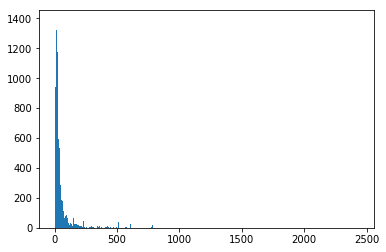

In [24]:
h = plt.hist(lengths, bins=500)

In [25]:
h[0]

array([1180.,  940., 1384., 1322., 1174.,  722.,  592.,  536.,  332.,
        286.,  242.,  186.,  180.,  214.,  112.,  154.,   68.,   82.,
         58.,   88.,   70.,   64.,   32.,   30.,   20.,   26.,   32.,
         24.,   58.,   14.,   64.,    6.,   28.,   16.,   24.,   28.,
          8.,   18.,   14.,   18.,   12.,   24.,   14.,   28.,   14.,
          4.,   12.,   44.,    4.,    6.,    2.,    4.,    6.,    0.,
         36.,    0.,    4.,    4.,    8.,    6.,   14.,    8.,    8.,
          8.,    2.,    0.,    6.,    2.,    2.,    4.,   12.,   14.,
          8.,   12.,    6.,    0.,    4.,    4.,    2.,    0.,    2.,
          0.,    4.,    6.,    0.,    4.,   14.,   26.,    4.,    0.,
          2.,    4.,    4.,    2.,    4.,    2.,    6.,    0.,    2.,
          2.,    2.,    6.,    4.,    2.,   40.,    4.,    0.,    0.,
          2.,    0.,    0.,    0.,    0.,    0.,    0.,   20.,    8.,
         18.,    4.,    0.,    0.,    0.,    0.,    6.,   24.,    2.,
          0.,    0.,

In [26]:
h[1]

array([   0.   ,    4.878,    9.756,   14.634,   19.512,   24.39 ,
         29.268,   34.146,   39.024,   43.902,   48.78 ,   53.658,
         58.536,   63.414,   68.292,   73.17 ,   78.048,   82.926,
         87.804,   92.682,   97.56 ,  102.438,  107.316,  112.194,
        117.072,  121.95 ,  126.828,  131.706,  136.584,  141.462,
        146.34 ,  151.218,  156.096,  160.974,  165.852,  170.73 ,
        175.608,  180.486,  185.364,  190.242,  195.12 ,  199.998,
        204.876,  209.754,  214.632,  219.51 ,  224.388,  229.266,
        234.144,  239.022,  243.9  ,  248.778,  253.656,  258.534,
        263.412,  268.29 ,  273.168,  278.046,  282.924,  287.802,
        292.68 ,  297.558,  302.436,  307.314,  312.192,  317.07 ,
        321.948,  326.826,  331.704,  336.582,  341.46 ,  346.338,
        351.216,  356.094,  360.972,  365.85 ,  370.728,  375.606,
        380.484,  385.362,  390.24 ,  395.118,  399.996,  404.874,
        409.752,  414.63 ,  419.508,  424.386,  429.264,  434.

In [27]:
max_sent_len =  h[1][np.argmax(h[0])]
min_sent_len = h[1][1]
print('Most probable length = ', max_sent_len)
print('Count of most probable lenght = ', np.max(h[0]))
print('Min length = ', min_sent_len)

Most probable length =  9.756
Count of most probable lenght =  1384.0
Min length =  4.878


In [28]:
max_sent_len =  100#int(np.ceil(max_sent_len))
min_sent_len = 4#int(np.floor(min_sent_len))

In [29]:
print('Most probable length = ', max_sent_len)
print('Min length = ', min_sent_len)

Most probable length =  100
Min length =  4


In [30]:
input_texts = []
target_texts = []

In [31]:
num_samples = 1000000
tess_correction_data = os.path.join(data_path, 'all_ocr_data_2.txt')
input_texts_OCR, target_texts_OCR, gt_OCR = load_data_with_gt(tess_correction_data, num_samples, max_sent_len, min_sent_len)
input_texts += input_texts_OCR
target_texts += target_texts_OCR

tess_correction_data = os.path.join(data_path, 'field_class_21.txt')
input_texts_OCR, target_texts_OCR, gt_OCR = load_data_with_gt(tess_correction_data, num_samples, max_sent_len, min_sent_len)
input_texts += input_texts_OCR
target_texts += target_texts_OCR

tess_correction_data = os.path.join(data_path, 'field_class_32.txt')
input_texts_OCR, target_texts_OCR, gt_OCR = load_data_with_gt(tess_correction_data, num_samples, max_sent_len, min_sent_len)
input_texts += input_texts_OCR
target_texts += target_texts_OCR

tess_correction_data = os.path.join(data_path, 'field_class_30.txt')
input_texts_OCR, target_texts_OCR, gt_OCR = load_data_with_gt(tess_correction_data, num_samples, max_sent_len, min_sent_len)
input_texts += input_texts_OCR
target_texts += target_texts_OCR


In [32]:
len(input_texts_OCR)

250

# Results of pre-training on generic data

In [33]:
'''
num_samples = 0
big_data = os.path.join(data_path, 'big.txt')
threshold = 0.9
input_texts_gen, target_texts_gen, gt_gen = load_data_with_noise(file_name=big_data, 
                                                                 num_samples=num_samples, 
                                                                 noise_threshold=threshold, 
                                                                 max_sent_len=max_sent_len, 
                                                                 min_sent_len=min_sent_len)
'''                                                                 

"\nnum_samples = 0\nbig_data = os.path.join(data_path, 'big.txt')\nthreshold = 0.9\ninput_texts_gen, target_texts_gen, gt_gen = load_data_with_noise(file_name=big_data, \n                                                                 num_samples=num_samples, \n                                                                 noise_threshold=threshold, \n                                                                 max_sent_len=max_sent_len, \n                                                                 min_sent_len=min_sent_len)\n"

In [34]:
#input_texts = input_texs_gen
#target_texts = target_texts_gen

# Results on noisy tesseract corrections

In [35]:
num_samples = 5000
tess_correction_data = os.path.join(data_path, 'all_ocr_data_2.txt')
threshold = 0.9
input_texts_noisy_OCR, target_texts_noisy_OCR, gt_noisy_OCR = load_data_with_noise(file_name=tess_correction_data, 
                                                                 num_samples=num_samples, 
                                                                 noise_threshold=threshold, 
                                                                 max_sent_len=max_sent_len, 
                                                                 min_sent_len=min_sent_len)
input_texts += input_texts_noisy_OCR
target_texts += target_texts_noisy_OCR

num_samples = 10000
tess_correction_data = os.path.join(data_path, 'field_class_21.txt')
threshold = 0.9
input_texts_noisy_OCR, target_texts_noisy_OCR, gt_noisy_OCR = load_data_with_noise(file_name=tess_correction_data, 
                                                                 num_samples=num_samples, 
                                                                 noise_threshold=threshold, 
                                                                 max_sent_len=max_sent_len, 
                                                                 min_sent_len=min_sent_len)
input_texts += input_texts_noisy_OCR
target_texts += target_texts_noisy_OCR

num_samples = 10000
tess_correction_data = os.path.join(data_path, 'field_class_32.txt')
threshold = 0.9
input_texts_noisy_OCR, target_texts_noisy_OCR, gt_noisy_OCR = load_data_with_noise(file_name=tess_correction_data, 
                                                                 num_samples=num_samples, 
                                                                 noise_threshold=threshold, 
                                                                 max_sent_len=max_sent_len, 
                                                                 min_sent_len=min_sent_len)
input_texts += input_texts_noisy_OCR
target_texts += target_texts_noisy_OCR

num_samples = 10000
tess_correction_data = os.path.join(data_path, 'field_class_30.txt')
threshold = 0.9
input_texts_noisy_OCR, target_texts_noisy_OCR, gt_noisy_OCR = load_data_with_noise(file_name=tess_correction_data, 
                                                                 num_samples=num_samples, 
                                                                 noise_threshold=threshold, 
                                                                 max_sent_len=max_sent_len, 
                                                                 min_sent_len=min_sent_len)
input_texts += input_texts_noisy_OCR
target_texts += target_texts_noisy_OCR

In [36]:
'''
input_texts = input_texts_noisy_OCR
target_texts = target_texts_noisy_OCR
'''

'\ninput_texts = input_texts_noisy_OCR\ntarget_texts = target_texts_noisy_OCR\n'

# Results on merge of tesseract correction + generic data

In [37]:
'''
input_texts = input_texts_OCR + input_texts_gen
target_texts = input_texts_OCR + target_texts_gen
'''

'\ninput_texts = input_texts_OCR + input_texts_gen\ntarget_texts = input_texts_OCR + target_texts_gen\n'

# Results noisy tesseract correction + generic data

In [38]:
'''
input_texts = input_texts_noisy_OCR + input_texts_gen
target_texts = input_texts_noisy_OCR + target_texts_gen
'''

'\ninput_texts = input_texts_noisy_OCR + input_texts_gen\ntarget_texts = input_texts_noisy_OCR + target_texts_gen\n'

# Results noisy tesseract noisy + correction data

In [39]:
#input_texts = input_texts_noisy_OCR + input_texts_OCR
#target_texts = target_texts_noisy_OCR + target_texts_OCR

# Results of pre-training on generic and fine tuning on tesseract correction

In [40]:
# TODO

# Load Medical Terms dictionary

In [41]:
json_file = os.path.join(data_path, 'abbrevs.json')
threshold = 0.9
num_samples = 0
input_texts_MedTerms, target_texts_MedTerms, _, med_terms_dict = load_medical_terms_with_noise(json_file, num_samples, threshold)

In [42]:
print(med_terms_dict)

{'det.': 'let it be given', 'p.v.': 'through the vagina', 'PT': 'prothrombin time', 'Ta': 'tantalum', 'lat': 'lateral', 'BCG': 'bacille Calmette-Guérin', 'MM': 'mucous membrane', 'AK': 'above the knee', 'a.c., ac': 'before a meal', 'KI': 'potassium iodine', 'cg': 'centigram', 'mEq': 'milliequivalent', 'sol': 'solution, dissolved', 'PEFR': 'peak expiratory flow rate', 'MI': 'myocardial infarction', 'BMS': 'bone marrow suppression', 'TPI': '', 'EPS': 'extrapyramidal symptoms', 'O.S.': 'left eye', 'LUE': 'left upper extremity', 'ECG': 'electrocardiogram, electrocardiograph', 'S.E.': 'standard error', 'q.v.': 'as much as you please', 'ECMO': 'extracorporeal membrane oxygenation', 'ACLS': 'advanced cardiac life support', 'PND': 'paroxysmal nocturnal dyspnea', 'ASC-US': 'atypical squamous cells of undetermined significance', 'UV': 'ultraviolet', 'MDI': 'metered-dose inhaler', 'b.i.n.': 'twice a night', 'LLL': 'left lower lobe', 'ad sat.': 'to saturation', 'EIA': 'enzyme immunosorbent assay',

In [43]:
input_texts += input_texts_MedTerms
target_texts += target_texts_MedTerms

# Load accident terms

In [44]:
file_name = os.path.join(data_path, 'AccidentsL.txt')
threshold = 0.9
num_samples = 0
limit = 100
input_texts_AccTerms, target_texts_AccTerms, _ = load_accidents_terms_with_noise(file_name, limit, num_samples, threshold)

finished


In [45]:
input_texts += input_texts_AccTerms
target_texts += target_texts_AccTerms

# Load procedures and tests

In [46]:
file_name = os.path.join(data_path, 'procedures_tests.txt')
threshold = 0.9
num_samples = 0
input_texts_ProcTests, target_texts_ProcTests, _ = load_procedures_tests_with_noise(file_name, num_samples, threshold)

In [47]:
input_texts += input_texts_ProcTests
target_texts += target_texts_ProcTests

In [48]:
# Sample data
print(len(input_texts))
for i in range(10):
    print(input_texts[i], '\n', target_texts[i])

39926
Claim Type: VB Accident - Accidental Injury 
 	Claim Type: VB Accident - Accidental Injury


“Tho Th 9 Reported Even [ Happen ed To: EnployeefPolicyholder 
 	Who The Reported Event Happened To: Employee/Policyholder


Pol inyhold elm-Chm er [11 form arlon 
 	Policyholder/Owner Information


First Name: 
 	First Name:


Middle Nameﬂnitial: 
 	Middle Name/Initial:


Last Name: 
 	Last Name:


Social S ecurity Number: 
 	Social Security Number:


Birth Date: 
 	Birth Date:


Gender: 
 	Gender:


Language Preference: 
 	Language Preference:




## Build vocab

In [49]:
all_texts = target_texts + input_texts
vocab_to_int, int_to_vocab = build_vocab(all_texts)
np.savez('vocab-{}'.format(max_sent_len), vocab_to_int=vocab_to_int, int_to_vocab=int_to_vocab, max_sent_len=max_sent_len, min_sent_len=min_sent_len )

In [50]:
input_characters = sorted(list(vocab_to_int))
target_characters = sorted(list(vocab_to_int))
num_encoder_tokens = len(input_characters)
num_decoder_tokens = len(target_characters)
max_encoder_seq_length = max([len(txt) for txt in input_texts])
max_decoder_seq_length = max([len(txt) for txt in target_texts])

In [51]:
print('Number of samples:', len(input_texts))
print('Number of unique input tokens:', num_encoder_tokens)
print('Number of unique output tokens:', num_decoder_tokens)
print('Max sequence length for inputs:', max_encoder_seq_length)
print('Max sequence length for outputs:', max_decoder_seq_length)

Number of samples: 39926
Number of unique input tokens: 121
Number of unique output tokens: 121
Max sequence length for inputs: 99
Max sequence length for outputs: 99


In [52]:
vocab_to_int # Some special chars need to be removed TODO: Data cleaning

{'\t': 2,
 '\n': 3,
 '\x0c': 118,
 ' ': 1,
 '!': 74,
 '"': 82,
 '#': 68,
 '$': 83,
 '%': 79,
 '&': 76,
 "'": 87,
 '(': 62,
 ')': 63,
 '*': 80,
 '+': 78,
 ',': 61,
 '-': 21,
 '.': 54,
 '/': 33,
 '0': 64,
 '1': 48,
 '2': 55,
 '3': 53,
 '4': 67,
 '5': 73,
 '6': 66,
 '7': 70,
 '8': 58,
 '9': 71,
 ':': 13,
 ';': 77,
 '<': 101,
 '=': 96,
 '>': 102,
 '?': 57,
 '@': 85,
 'A': 16,
 'B': 15,
 'C': 4,
 'D': 45,
 'E': 30,
 'F': 38,
 'G': 46,
 'H': 32,
 'I': 22,
 'J': 69,
 'K': 51,
 'L': 42,
 'M': 41,
 'N': 40,
 'O': 35,
 'P': 34,
 'Q': 81,
 'R': 29,
 'S': 43,
 'T': 9,
 'U': 50,
 'UNK': 0,
 'V': 14,
 'W': 26,
 'X': 72,
 'Y': 49,
 'Z': 75,
 '[': 94,
 '\\': 103,
 ']': 95,
 '^': 89,
 '_': 107,
 'a': 6,
 'b': 44,
 'c': 17,
 'd': 18,
 'e': 12,
 'f': 37,
 'g': 47,
 'h': 27,
 'i': 7,
 'j': 23,
 'k': 56,
 'l': 5,
 'm': 8,
 'n': 19,
 'o': 28,
 'p': 11,
 'q': 52,
 'r': 25,
 's': 39,
 't': 20,
 'u': 24,
 'v': 31,
 'w': 36,
 'x': 59,
 'y': 10,
 'z': 60,
 '{': 111,
 '|': 86,
 '}': 110,
 '~': 104,
 '¢': 119,
 '£

In [53]:
int_to_vocab

{0: 'UNK',
 1: ' ',
 2: '\t',
 3: '\n',
 4: 'C',
 5: 'l',
 6: 'a',
 7: 'i',
 8: 'm',
 9: 'T',
 10: 'y',
 11: 'p',
 12: 'e',
 13: ':',
 14: 'V',
 15: 'B',
 16: 'A',
 17: 'c',
 18: 'd',
 19: 'n',
 20: 't',
 21: '-',
 22: 'I',
 23: 'j',
 24: 'u',
 25: 'r',
 26: 'W',
 27: 'h',
 28: 'o',
 29: 'R',
 30: 'E',
 31: 'v',
 32: 'H',
 33: '/',
 34: 'P',
 35: 'O',
 36: 'w',
 37: 'f',
 38: 'F',
 39: 's',
 40: 'N',
 41: 'M',
 42: 'L',
 43: 'S',
 44: 'b',
 45: 'D',
 46: 'G',
 47: 'g',
 48: '1',
 49: 'Y',
 50: 'U',
 51: 'K',
 52: 'q',
 53: '3',
 54: '.',
 55: '2',
 56: 'k',
 57: '?',
 58: '8',
 59: 'x',
 60: 'z',
 61: ',',
 62: '(',
 63: ')',
 64: '0',
 65: '’',
 66: '6',
 67: '4',
 68: '#',
 69: 'J',
 70: '7',
 71: '9',
 72: 'X',
 73: '5',
 74: '!',
 75: 'Z',
 76: '&',
 77: ';',
 78: '+',
 79: '%',
 80: '*',
 81: 'Q',
 82: '"',
 83: '$',
 84: 'ñ',
 85: '@',
 86: '|',
 87: "'",
 88: '•',
 89: '^',
 90: '●',
 91: 'ﬁ',
 92: '”',
 93: '°',
 94: '[',
 95: ']',
 96: '=',
 97: '–',
 98: '—',
 99: '“',
 100: 

In [54]:
len(int_to_vocab)

121

# Prepare training data

## Train/test split

In [55]:
# Split the data into training and testing sentences
input_texts, test_input_texts, target_texts, test_target_texts  = train_test_split(input_texts, target_texts, test_size = 0.15, random_state = 42)

## Vectorize data

## Train data

In [56]:
encoder_input_data, decoder_input_data, decoder_target_data = vectorize_data(input_texts=input_texts,
                                                                             target_texts=target_texts, 
                                                                             max_encoder_seq_length=max_encoder_seq_length, 
                                                                             num_encoder_tokens=num_encoder_tokens, 
                                                                             vocab_to_int=vocab_to_int)

In [57]:
print(encoder_input_data.shape)
print(decoder_target_data.shape)

(33937, 99)
(33937, 99, 121)


## Test data

In [58]:
test_encoder_input_data, test_decoder_input_data, test_decoder_target_data = vectorize_data(input_texts=test_input_texts,
                                                                                            target_texts=test_target_texts, 
                                                                                            max_encoder_seq_length=max_encoder_seq_length, 
                                                                                            num_encoder_tokens=num_encoder_tokens, 
                                                                                            vocab_to_int=vocab_to_int)

# Encoder-decoder model

In [59]:

latent_dim = 256  # Latent dimensionality of the encoding space.

In [60]:
model, encoder_model, decoder_model = build_model(latent_dim=latent_dim, num_encoder_tokens=num_encoder_tokens)

[<tf.Tensor 'concatenate_1/concat:0' shape=(?, 512) dtype=float32>, <tf.Tensor 'concatenate_2/concat:0' shape=(?, 512) dtype=float32>]
Tensor("lstm_2/transpose_2:0", shape=(?, ?, 512), dtype=float32)
Tensor("bidirectional_1/concat:0", shape=(?, ?, 512), dtype=float32)
attention Tensor("attention/truediv:0", shape=(?, ?, ?), dtype=float32)
encoder-decoder  model:
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 121)    14641       input_1[0][0]                    
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, No

/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:63: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=[<tf.Tenso...)`


# Training

In [61]:
batch_size = 64  # Batch size for training.
epochs = 20  
lr = 0.01

# Learning rate decay

In [62]:
model.compile(optimizer=optimizers.Adam(lr=lr), loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [63]:
#filepath="weights-improvement-{epoch:02d}-{val_categorical_accuracy:.2f}.hdf5"
filepath="best_model-{}.hdf5".format(max_sent_len) # Save only the best model for inference step, as saving the epoch and metric might confuse the inference function which model to use
checkpoint = ModelCheckpoint(filepath, monitor='val_categorical_accuracy', verbose=1, save_best_only=True, mode='max')
tbCallBack = TensorBoard(log_dir='./Graph', histogram_freq=0, write_graph=True, write_images=True)
callbacks_list = [checkpoint, tbCallBack]
#callbacks_list = [checkpoint, tbCallBack, lrate]



In [64]:
def exp_decay(epoch):
    initial_lrate = 0.1
    k = 0.1
    lrate = initial_lrate * np.exp(-k*epoch)
    return lrate
lrate = LearningRateScheduler(exp_decay)
#lr = 0

In [65]:
def step_decay(epoch):
    initial_lrate = 0.1
    drop = 0.5
    epochs_drop = 10.0
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lrate
lrate = LearningRateScheduler(step_decay)
#lr = 0

In [66]:
#callbacks_list.append(lrate)

In [67]:
model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
          validation_data = ([test_encoder_input_data, test_decoder_input_data], test_decoder_target_data),
          batch_size=batch_size,
          epochs=epochs,
          callbacks=callbacks_list,
          #validation_split=0.2,
          shuffle=True)

Train on 33937 samples, validate on 5989 samples
Epoch 1/20
33937/33937 [==============================] - 228s 7ms/step - loss: 1.0483 - categorical_accuracy: 0.6939 - val_loss: 0.1881 - val_categorical_accuracy: 0.9187

Epoch 00001: val_categorical_accuracy improved from -inf to 0.91873, saving model to best_model-100.hdf5


/opt/anaconda3/lib/python3.6/site-packages/keras/engine/network.py:872: UserWarning: Layer lstm_2 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'concatenate_1/concat:0' shape=(?, 512) dtype=float32>, <tf.Tensor 'concatenate_2/concat:0' shape=(?, 512) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  '. They will not be included '


Epoch 2/20
33937/33937 [==============================] - 224s 7ms/step - loss: 0.1421 - categorical_accuracy: 0.9301 - val_loss: 0.1277 - val_categorical_accuracy: 0.9340

Epoch 00002: val_categorical_accuracy improved from 0.91873 to 0.93402, saving model to best_model-100.hdf5
Epoch 3/20
33937/33937 [==============================] - 225s 7ms/step - loss: 0.0986 - categorical_accuracy: 0.9409 - val_loss: 0.1147 - val_categorical_accuracy: 0.9374

Epoch 00003: val_categorical_accuracy improved from 0.93402 to 0.93743, saving model to best_model-100.hdf5
Epoch 4/20
33937/33937 [==============================] - 225s 7ms/step - loss: 0.0827 - categorical_accuracy: 0.9446 - val_loss: 0.1078 - val_categorical_accuracy: 0.9392

Epoch 00004: val_categorical_accuracy improved from 0.93743 to 0.93921, saving model to best_model-100.hdf5
Epoch 5/20
33937/33937 [==============================] - 221s 7ms/step - loss: 0.0837 - categorical_accuracy: 0.9438 - val_loss: 0.1215 - val_categorical_ac

KeyboardInterrupt: 

In [68]:
encoder_model.save('encoder_model-{}.hdf5'.format(max_sent_len))
decoder_model.save('decoder_model-{}.hdf5'.format(max_sent_len))

/opt/anaconda3/lib/python3.6/site-packages/keras/engine/network.py:872: UserWarning: Layer lstm_2 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'input_4:0' shape=(?, 512) dtype=float32>, <tf.Tensor 'input_5:0' shape=(?, 512) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  '. They will not be included '


In [ ]:
#encoder_input_data[1:2][0]

In [ ]:
#vocab_to_int

In [ ]:
#decode_gt_sequence(encoder_input_data[5:6], int_to_vocab)

In [69]:
# Sample output from train data
decoded_sentences = []
target_texts_ =  []
for seq_index in range(100):
    # Take one sequence (part of the training set)
    # for trying out decoding.

    input_seq = encoder_input_data[seq_index: seq_index + 1]
    target_seq = np.argmax(decoder_target_data[seq_index: seq_index + 1], axis=-1)
    #print(target_seq)
    decoded_sentence, _ = decode_sequence(input_seq, encoder_model, decoder_model, num_decoder_tokens, int_to_vocab)
    target_text = target_texts[seq_index][1:-1]
    print('-')
    print('Input sentence:', input_texts[seq_index])
    print('GT sentence:', target_text)
    print('Decoded sentence:', decoded_sentence)   
    decoded_sentences.append(decoded_sentence)
    target_texts_.append(target_text)

-
Input sentence: GREGORY
GT sentence: GREGORY

Decoded sentence: GREOYY
-
Input sentence: Transacon referenc enumbmer:
GT sentence: Transaction reference number:

Decoded sentence: Transol Policy Duted tonted:
-
Input sentence: Ixnsuraznce:
GT sentence: Insurance:

Decoded sentence: Ifnnons Non:
-
Input sentence: Empvlroyee On & Off-Job Acc January 1, 2107
GT sentence: Employee On & Off-Job Acc January 1, 2017

Decoded sentence: Employ  Cor  of-te te Of Co NT C1,I210
-
Input sentence: I ordere,o btained and reveiwed RXY-FpOOT CMOP 3 VIEWS***
GT sentence: I ordered, obtained and reviewed XRAY-FOOT COMP 3 VIEWS***

Decoded sentence: IDord Re, Date Provide Datedent Dat-d Sd Dated 3o Date
-
Input sentence: Spouhse On & Off-Joby AccJ anuary g1, 2071
GT sentence: Spouse On & Off-Job Acc January 1, 2017

Decoded sentence: Spout PHovide Da-e te Provider Ho D1,e207
-
Input sentence: If yexs, as of whatd ate? (mm/dd/syy)
GT sentence: If yes, as of what date? (mm/dd/yy)

Decoded sentence: If Sy 

-
Input sentence: * Vision hagnes
GT sentence: * Vision changes

Decoded sentence: * Iis Nament Name
-
Input sentence: EE Name:
GT sentence: EE Name:

Decoded sentence: EE Name:
-
Input sentence: insured
GT sentence: INSURED:

Decoded sentence: insddddded
-
Input sentence: Preferred e-mail adrdes (forc onfirmationpurposes onlky)-amll avddrace
GT sentence: Preferred e-mail address (for confirmation purposes only)-mall addrace

Decoded sentence: Preferoved -ovider toure( tored tored youreder verver tovind-Adinent?
-
Input sentence: * Avoid lifting ando threr rtenouus activities.
GT sentence: * Avoid lifting and other strenuous activities.

Decoded sentence: * Avide on be of your chined to nonted to then.
-
Input sentence: ENCOUNTER FOR WlTH
GT sentence: ENCOUNTER FOR WITH

Decoded sentence: ENCORALLINTHINT CE
-
Input sentence: Uanuthorzzed access is stzrictly roihibted.
GT sentence: Unauthorized access is strictly prohibited.

Decoded sentence: Uatuthest on or the bent onst berity thent.

# Test on Medical Terms dictionary

In [ ]:

input_texts = input_texts_MedTerms
target_texts = target_texts_MedTerms

encoder_input_data, decoder_input_data, decoder_target_data = vectorize_data(input_texts=input_texts,
                                                                             target_texts=target_texts, 
                                                                             max_encoder_seq_length=max_encoder_seq_length, 
                                                                             num_encoder_tokens=num_encoder_tokens, 
                                                                             vocab_to_int=vocab_to_int)

# Sample output from train data
decoded_sentences = []
target_texts_ =  []
for seq_index in range(len(input_texts)):
    # Take one sequence (part of the training set)
    # for trying out decoding.

    input_seq = encoder_input_data[seq_index: seq_index + 1]
    
    decoded_sentence, _ = decode_sequence(input_seq, encoder_model, decoder_model, num_decoder_tokens, int_to_vocab)
    target_text = target_texts[seq_index][1:-1]
    print('-')
    print('Input sentence:', input_texts[seq_index])
    print('GT sentence:', target_text)
    print('Decoded sentence:', decoded_sentence)   
    decoded_sentences.append(decoded_sentence)
    target_texts_.append(target_text)
    
WER_spell_correction = calculate_WER(target_texts_, decoded_sentences)
print('WER_spell_correction |TEST= ', WER_spell_correction)

WER_OCR = calculate_WER(target_texts_, input_texts)
print('WER_OCR |TEST= ', WER_OCR)

# Test on Procedures and Tests dictionary

In [71]:

input_texts = input_texts_ProcTests
target_texts = target_texts_ProcTests

encoder_input_data, decoder_input_data, decoder_target_data = vectorize_data(input_texts=input_texts,
                                                                             target_texts=target_texts, 
                                                                             max_encoder_seq_length=max_encoder_seq_length, 
                                                                             num_encoder_tokens=num_encoder_tokens, 
                                                                             vocab_to_int=vocab_to_int)

# Sample output from train data
decoded_sentences = []
target_texts_ =  []
for seq_index in range(len(input_texts)):
    # Take one sequence (part of the training set)
    # for trying out decoding.

    input_seq = encoder_input_data[seq_index: seq_index + 1]
    
    decoded_sentence, _ = decode_sequence(input_seq, encoder_model, decoder_model, num_decoder_tokens, int_to_vocab)
    target_text = target_texts[seq_index][1:-1]
    print('-')
    print('Input sentence:', input_texts[seq_index])
    print('GT sentence:', target_text)
    print('Decoded sentence:', decoded_sentence)   
    decoded_sentences.append(decoded_sentence)
    target_texts_.append(target_text)
    
WER_spell_correction = calculate_WER(target_texts_, decoded_sentences)
print('WER_spell_correction |TEST= ', WER_spell_correction)

WER_OCR = calculate_WER(target_texts_, input_texts)
print('WER_OCR |TEST= ', WER_OCR)

ZeroDivisionError: division by zero

# Visualize attention

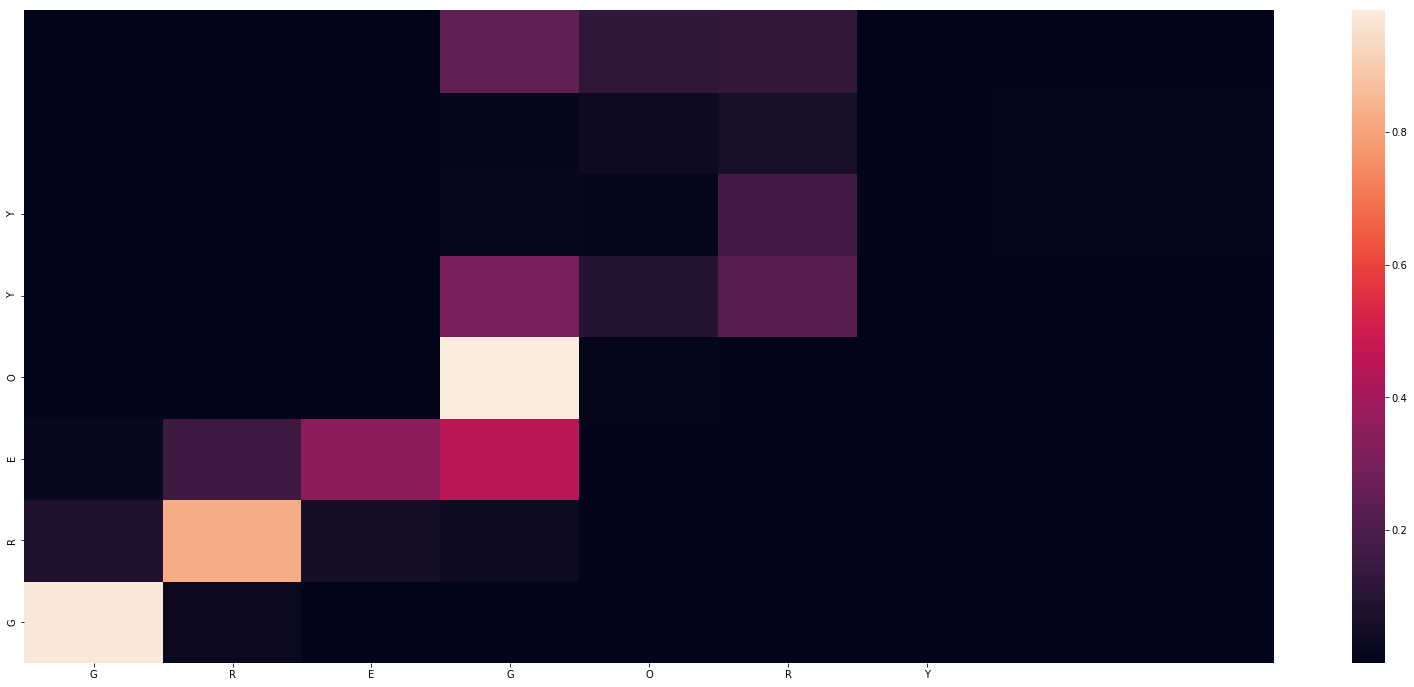

-
Input sentence: GREGORY
GT sentence: GREGORY

Decoded sentence: GREOYY


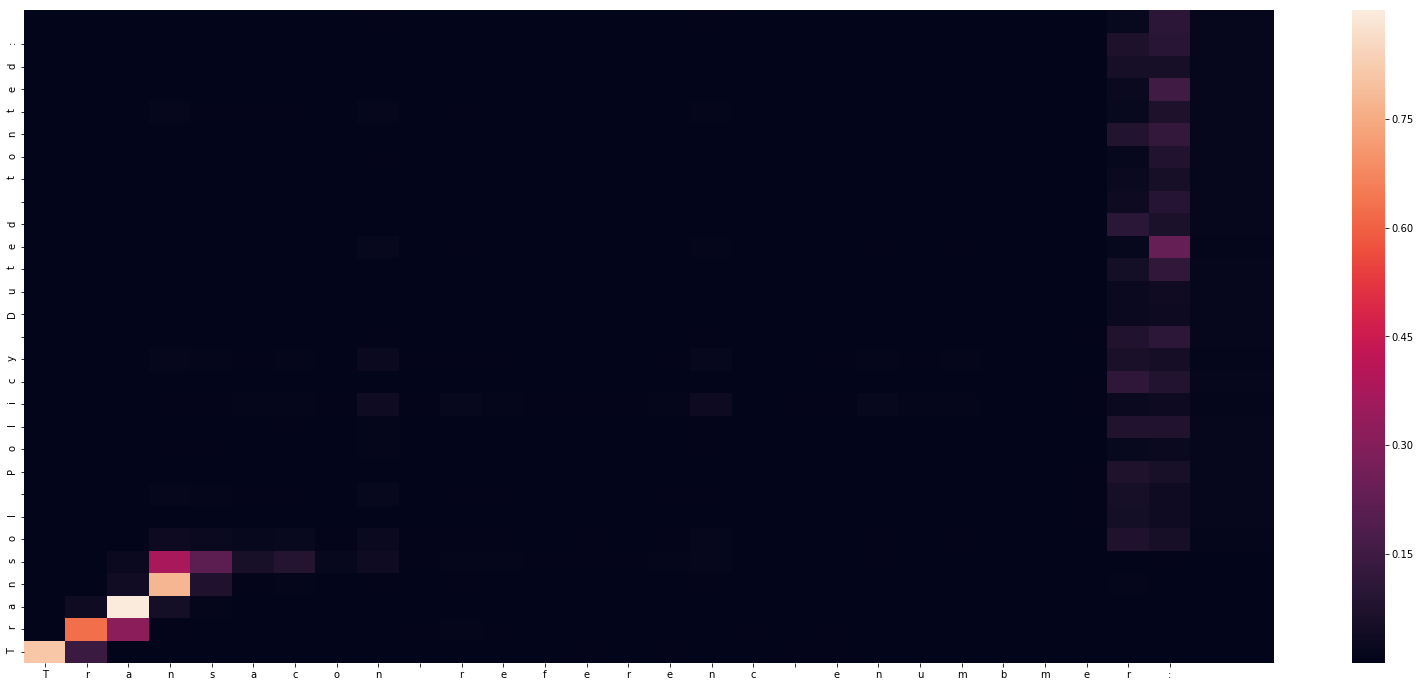

-
Input sentence: Transacon referenc enumbmer:
GT sentence: Transaction reference number:

Decoded sentence: Transol Policy Duted tonted:


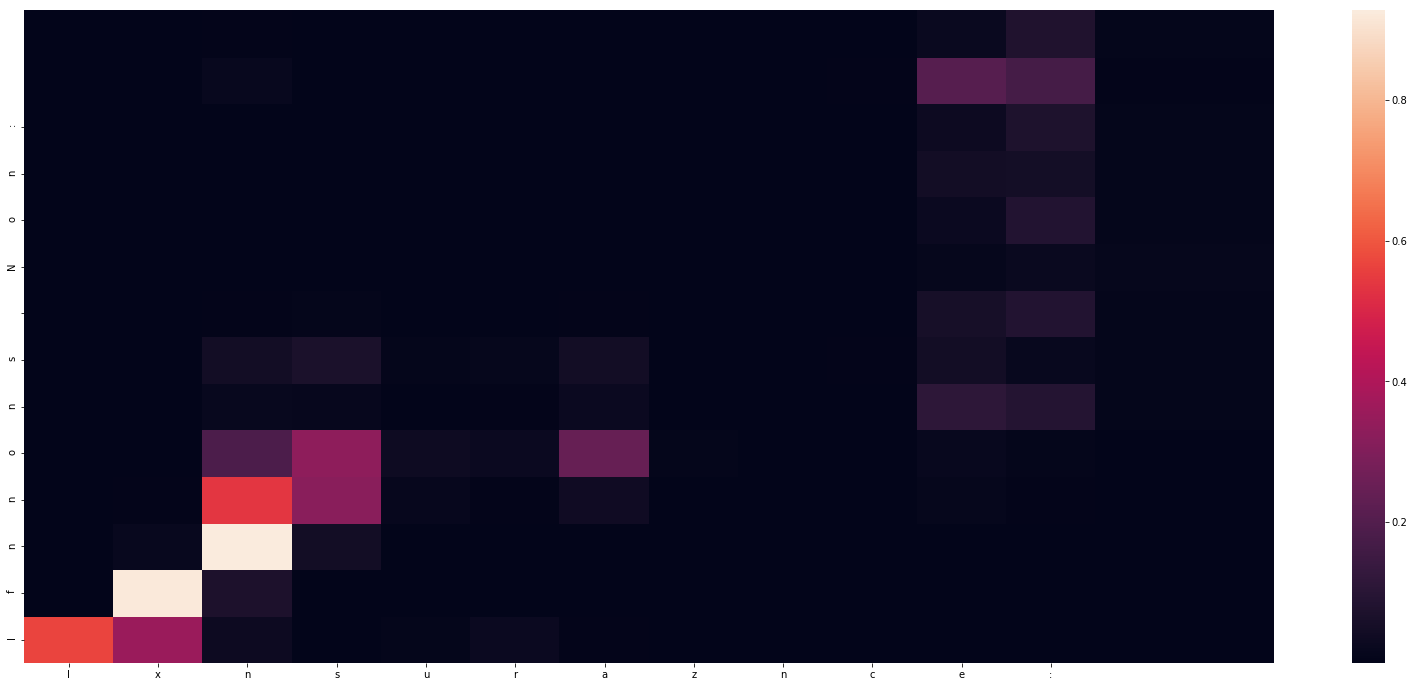

-
Input sentence: Ixnsuraznce:
GT sentence: Insurance:

Decoded sentence: Ifnnons Non:


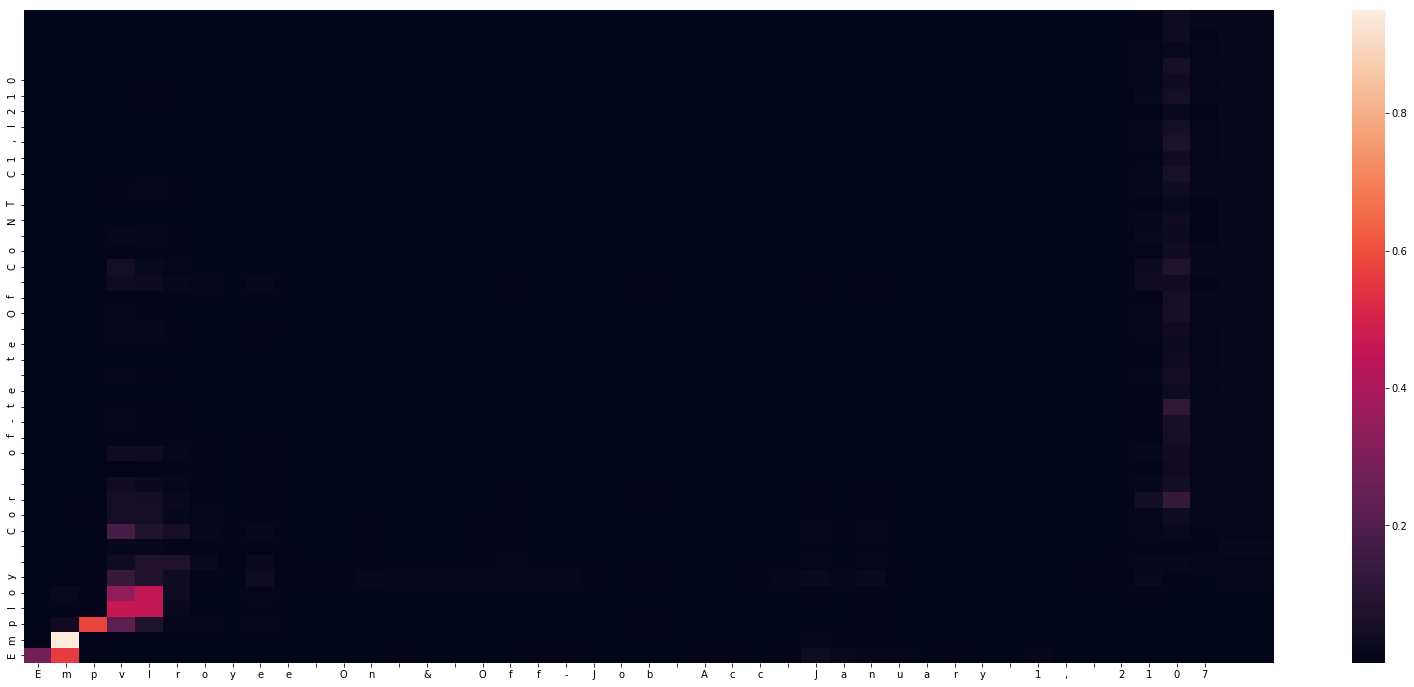

-
Input sentence: Empvlroyee On & Off-Job Acc January 1, 2107
GT sentence: Employee On & Off-Job Acc January 1, 2017

Decoded sentence: Employ  Cor  of-te te Of Co NT C1,I210


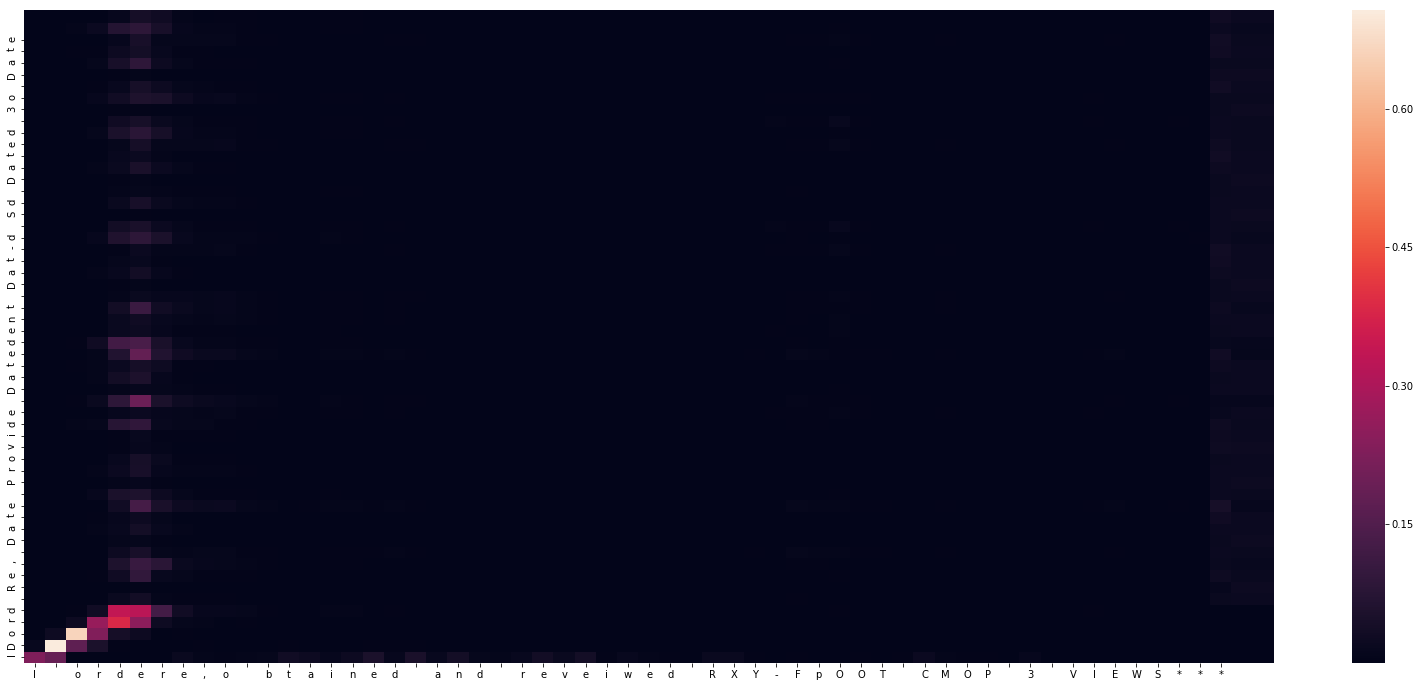

-
Input sentence: I ordere,o btained and reveiwed RXY-FpOOT CMOP 3 VIEWS***
GT sentence: I ordered, obtained and reviewed XRAY-FOOT COMP 3 VIEWS***

Decoded sentence: IDord Re, Date Provide Datedent Dat-d Sd Dated 3o Date


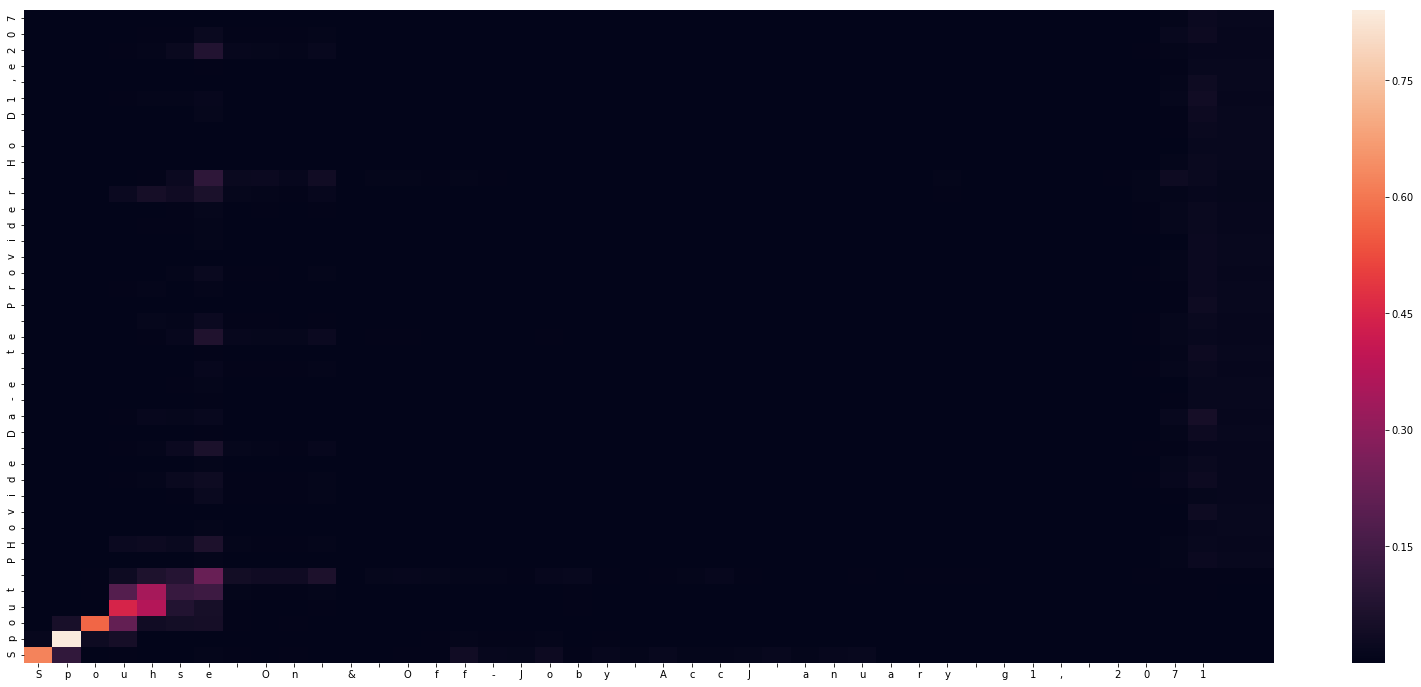

-
Input sentence: Spouhse On & Off-Joby AccJ anuary g1, 2071
GT sentence: Spouse On & Off-Job Acc January 1, 2017

Decoded sentence: Spout PHovide Da-e te Provider Ho D1,e207


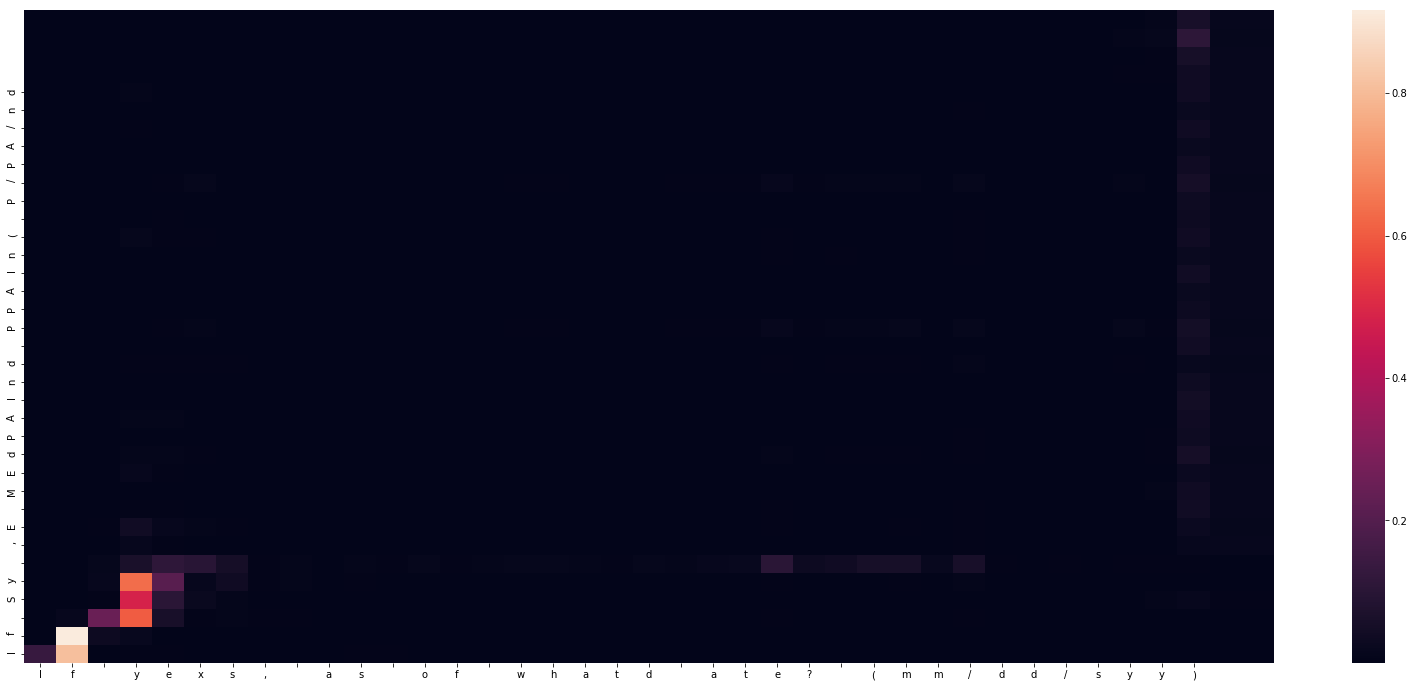

-
Input sentence: If yexs, as of whatd ate? (mm/dd/syy)
GT sentence: If yes, as of what date? (mm/dd/yy)

Decoded sentence: If Sy ,E MEdPAInd PPAIn( P/PA/nd


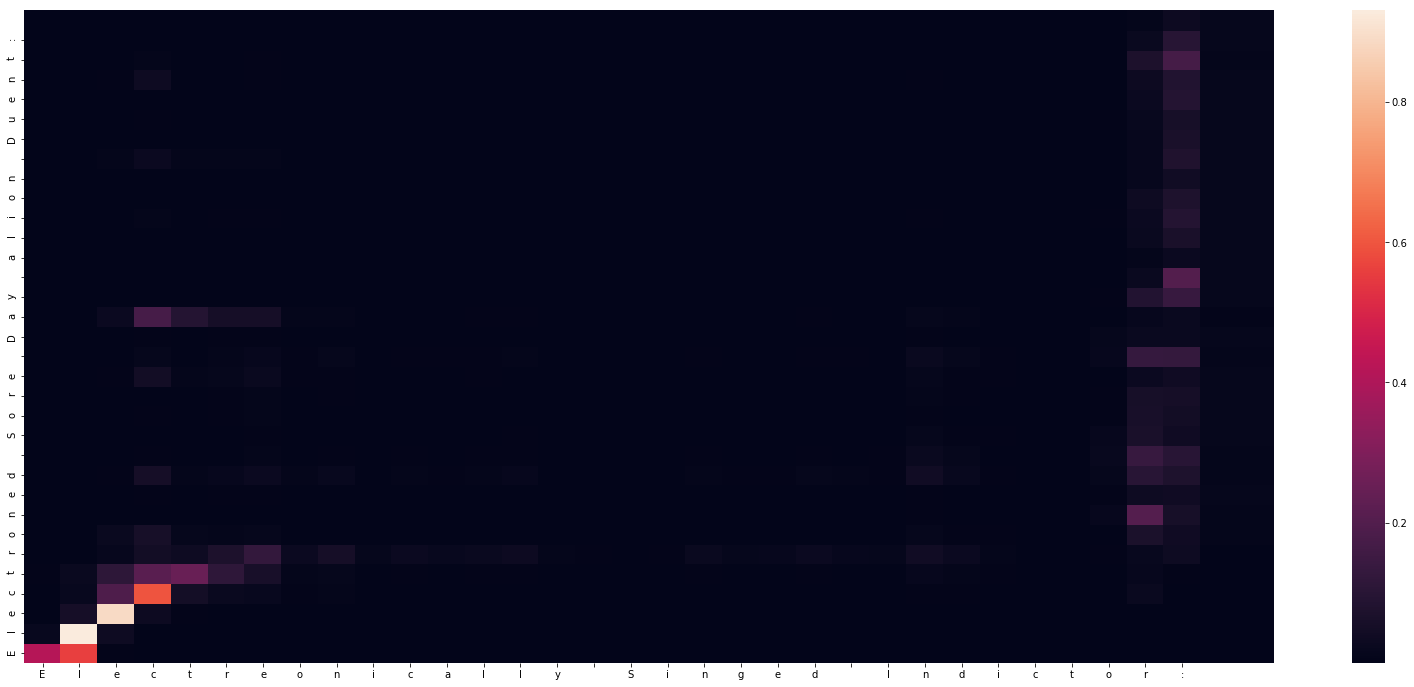

-
Input sentence: Electreonically Singed Indictor:
GT sentence: Electronically Signed Indicator:

Decoded sentence: Electroned Sore Day alion Duent:


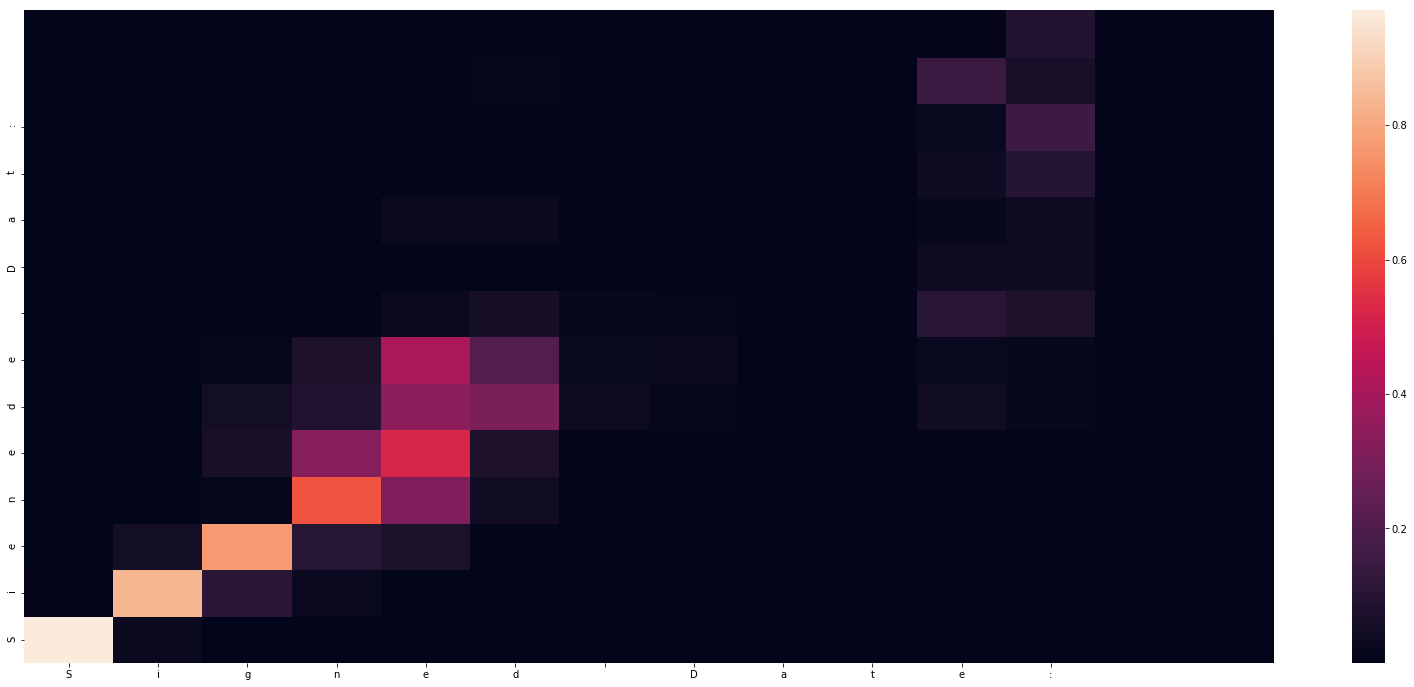

-
Input sentence: Signed Date:
GT sentence: Signed Date:

Decoded sentence: Sienede Dat:


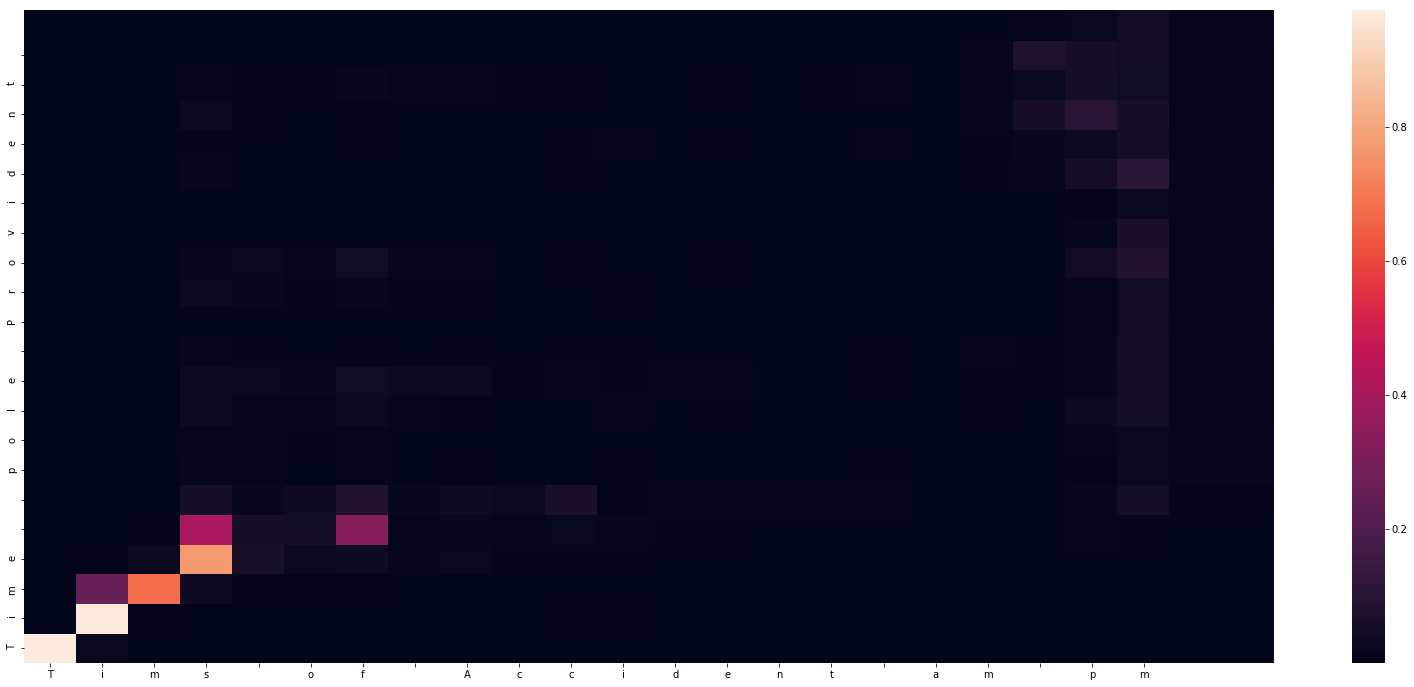

-
Input sentence: Tims of Accident am pm
GT sentence: Time of Accident am pm

Decoded sentence: Time  pole Provident 


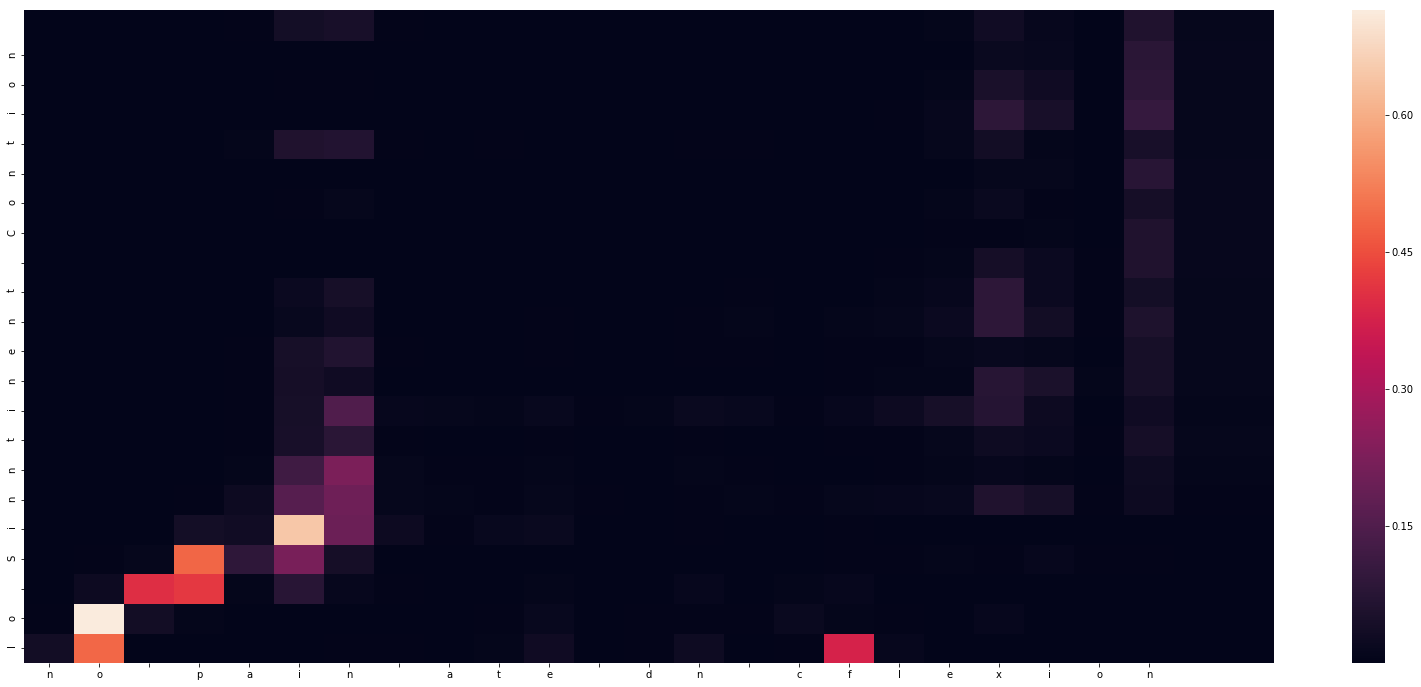

-
Input sentence: no pain ate dn cflexion
GT sentence: no pain at end flexion

Decoded sentence: Io Sinntinent Contion


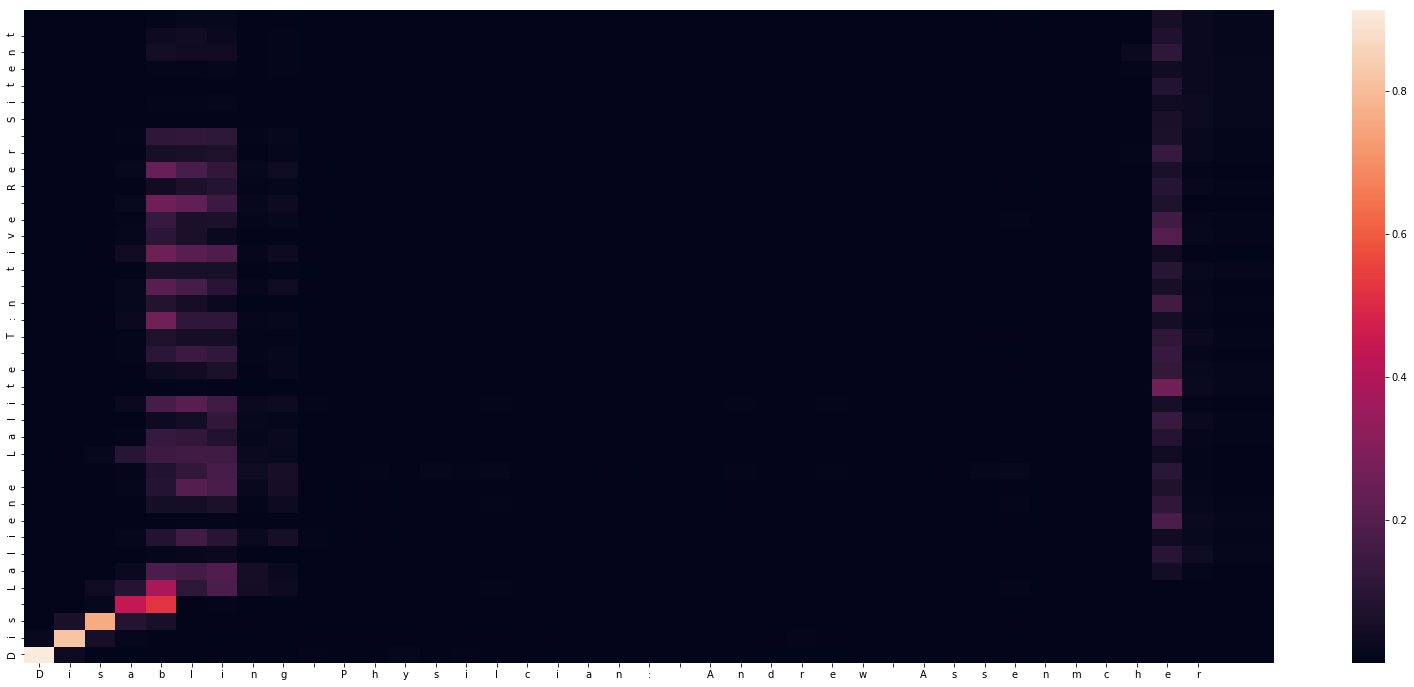

-
Input sentence: Disabling Physilcian: Andrew Assenmcher
GT sentence: Disabling Physician: Andrew Assenmacher

Decoded sentence: Dis Laliene Lalite T:n tive Rer Sitent


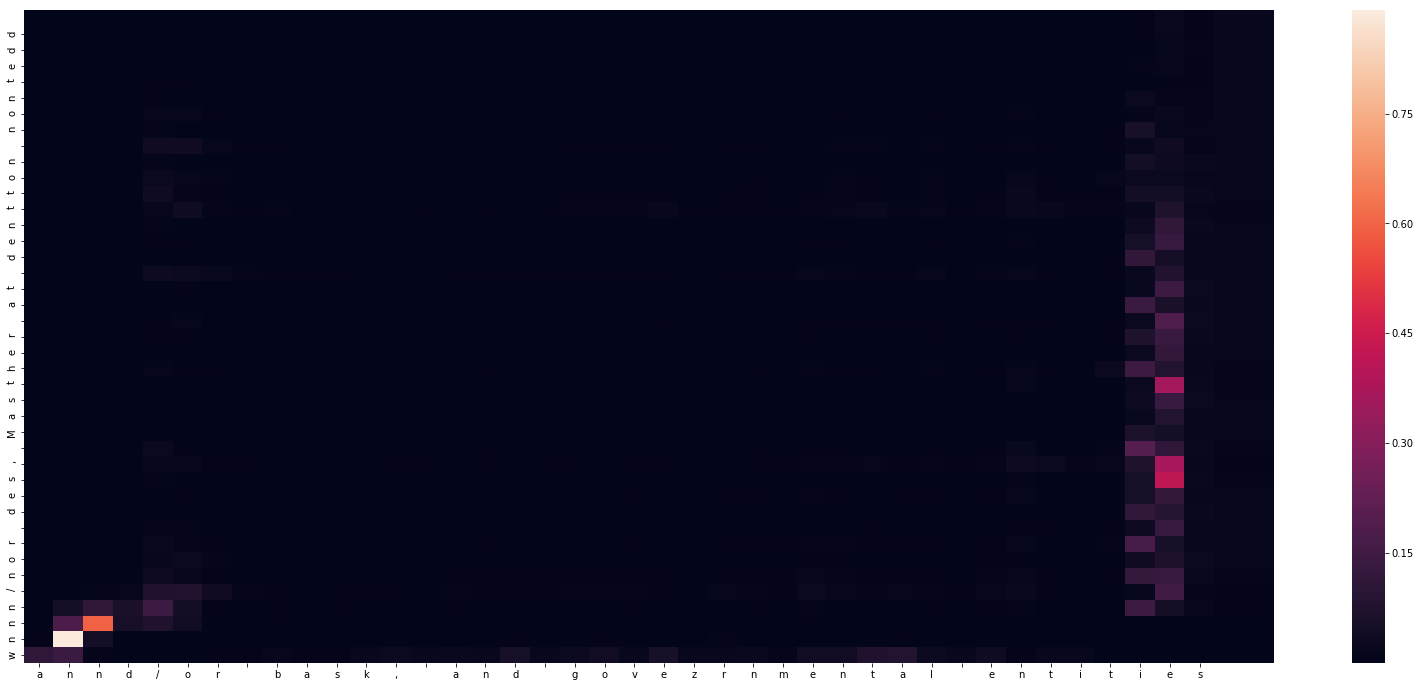

-
Input sentence: annd/or bask, and govezrnmental entities
GT sentence: and/or banks, and governmental entities;

Decoded sentence: wnnn/nor des, Masther at dentton nontedd


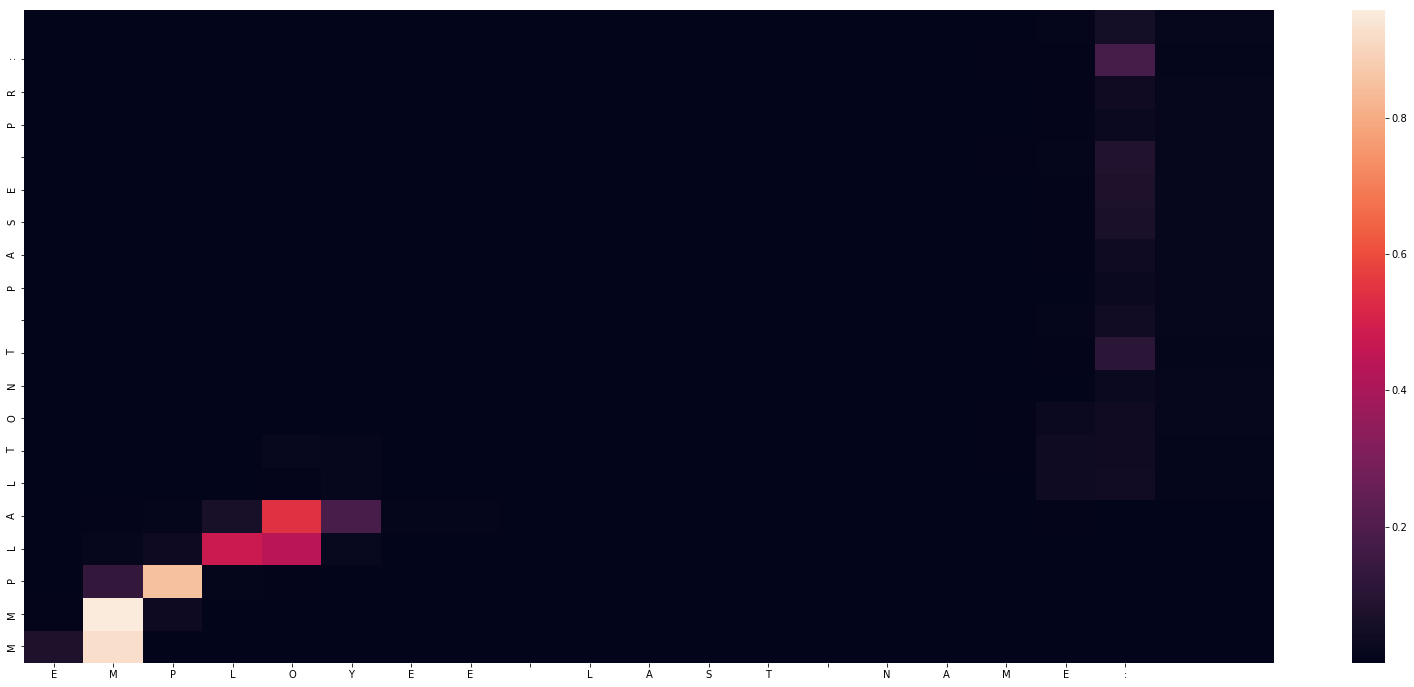

-
Input sentence: EMPLOYEE LAST NAME:
GT sentence: EMPLOYEE LAST NAME:

Decoded sentence: MMPLALTONT PASE PR:


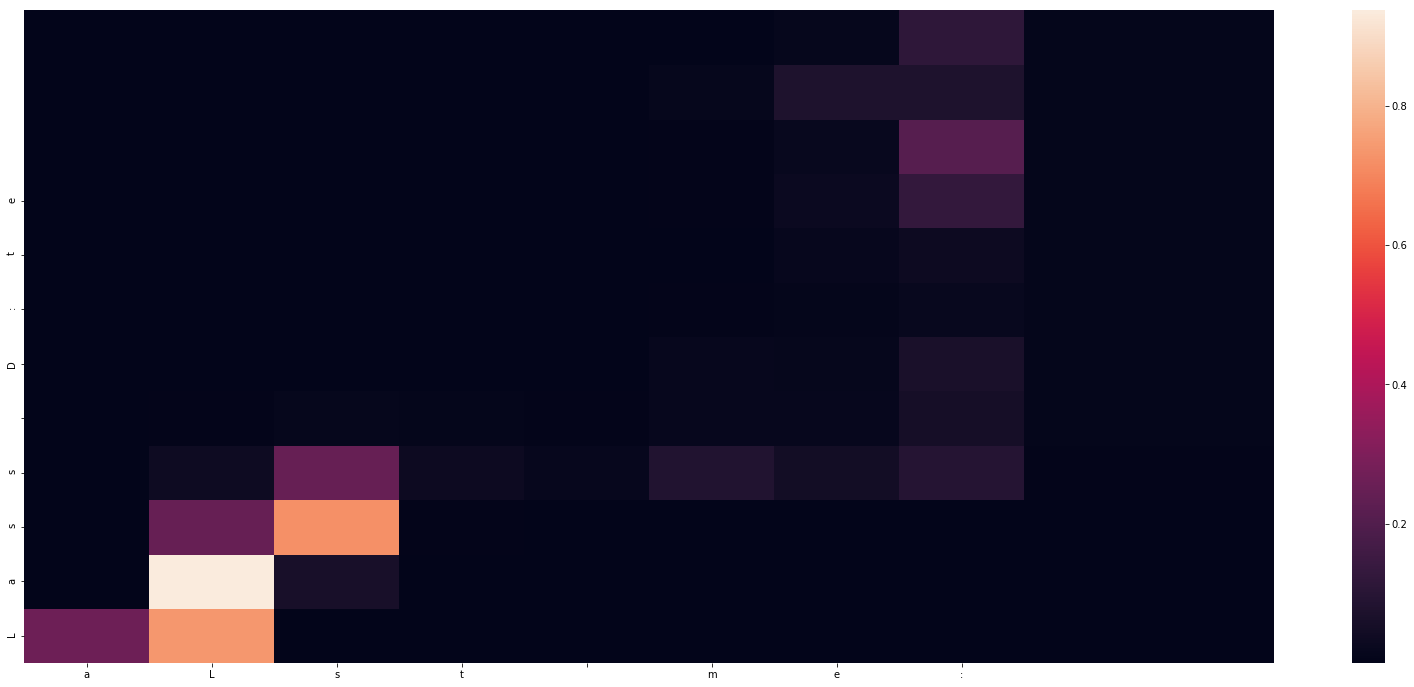

-
Input sentence: aLst me:
GT sentence: Last Name:

Decoded sentence: Lass D:te


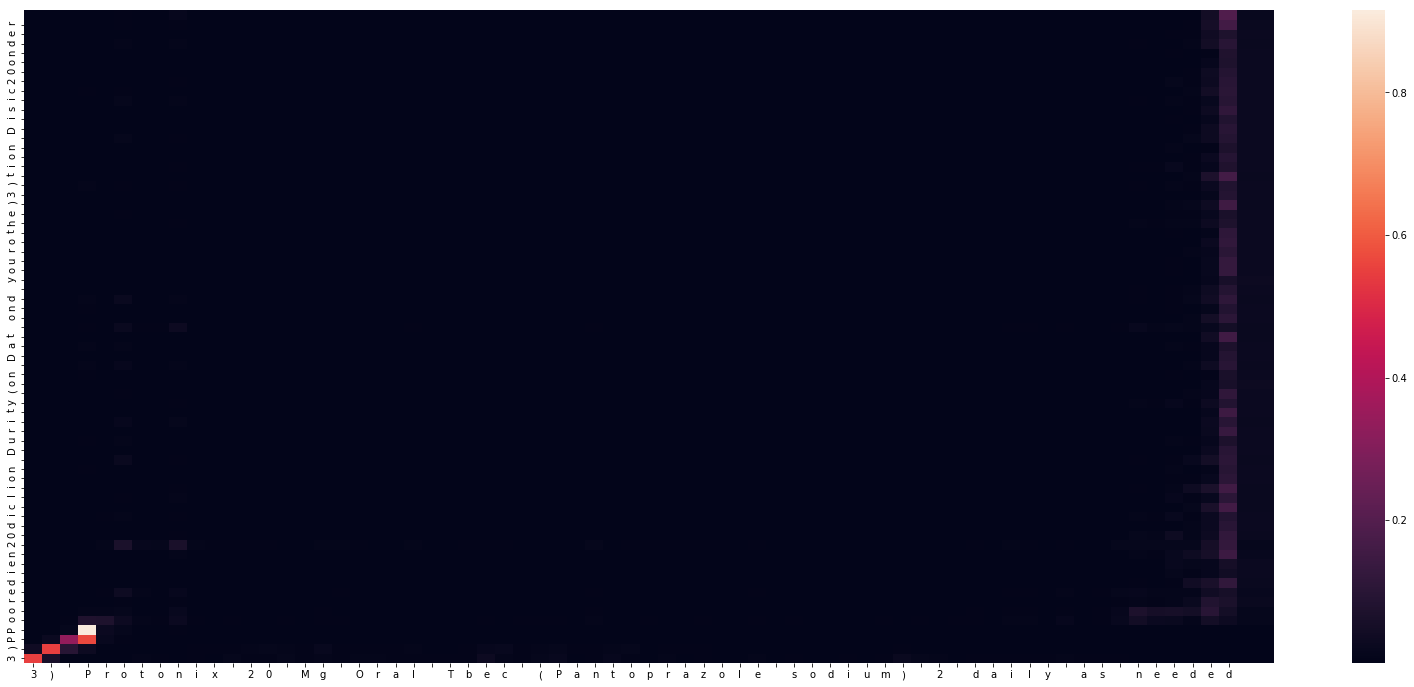

-
Input sentence: 3) Protonix 20 Mg Oral Tbec (Pantoprazole sodium) 2 daily as needed
GT sentence: 3) Protonix 20 Mg Oral Tbec (Pantoprazole sodium) 2 daily as needed

Decoded sentence: 3)PPooredien20diclion Durity(on Dat ond yourothe)3)tion Disic20onder


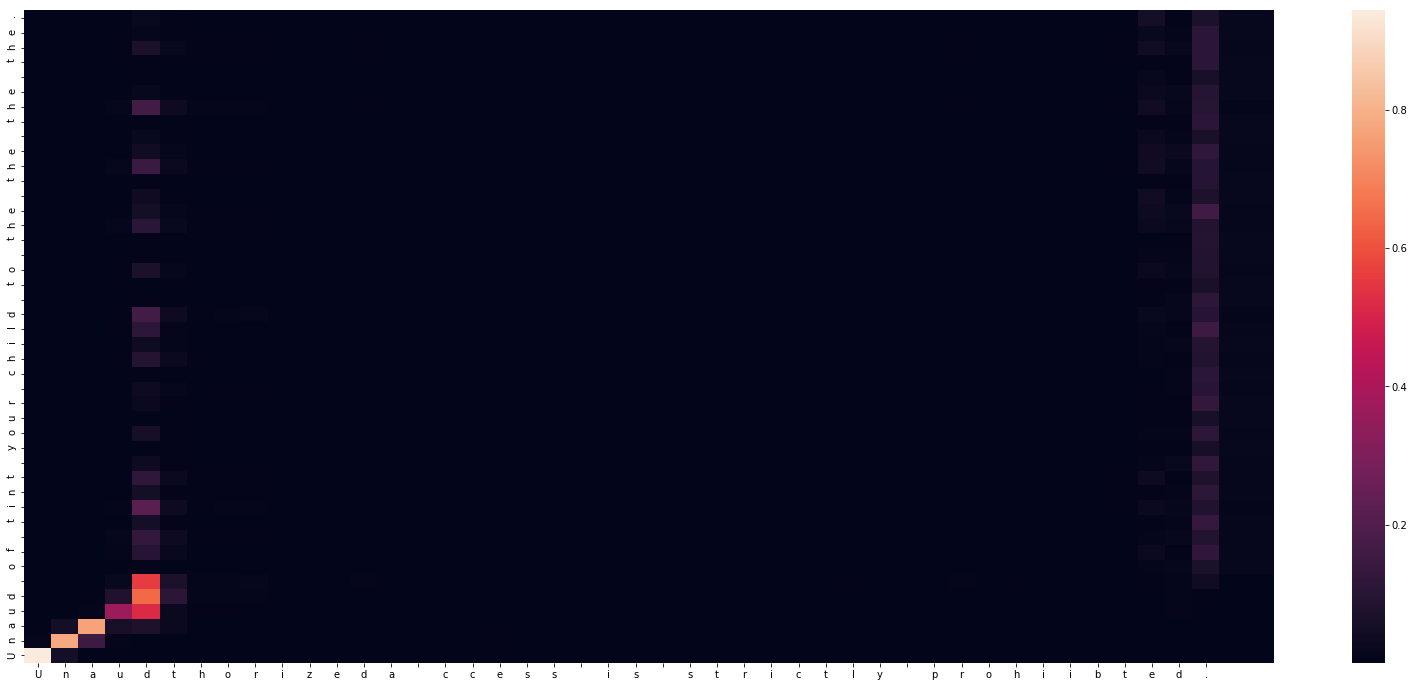

-
Input sentence: Unaudthorizeda ccess is strictly prohiibted.
GT sentence: Unauthorized access is strictly prohibited.

Decoded sentence: Unaud of tint your child to the the the the.


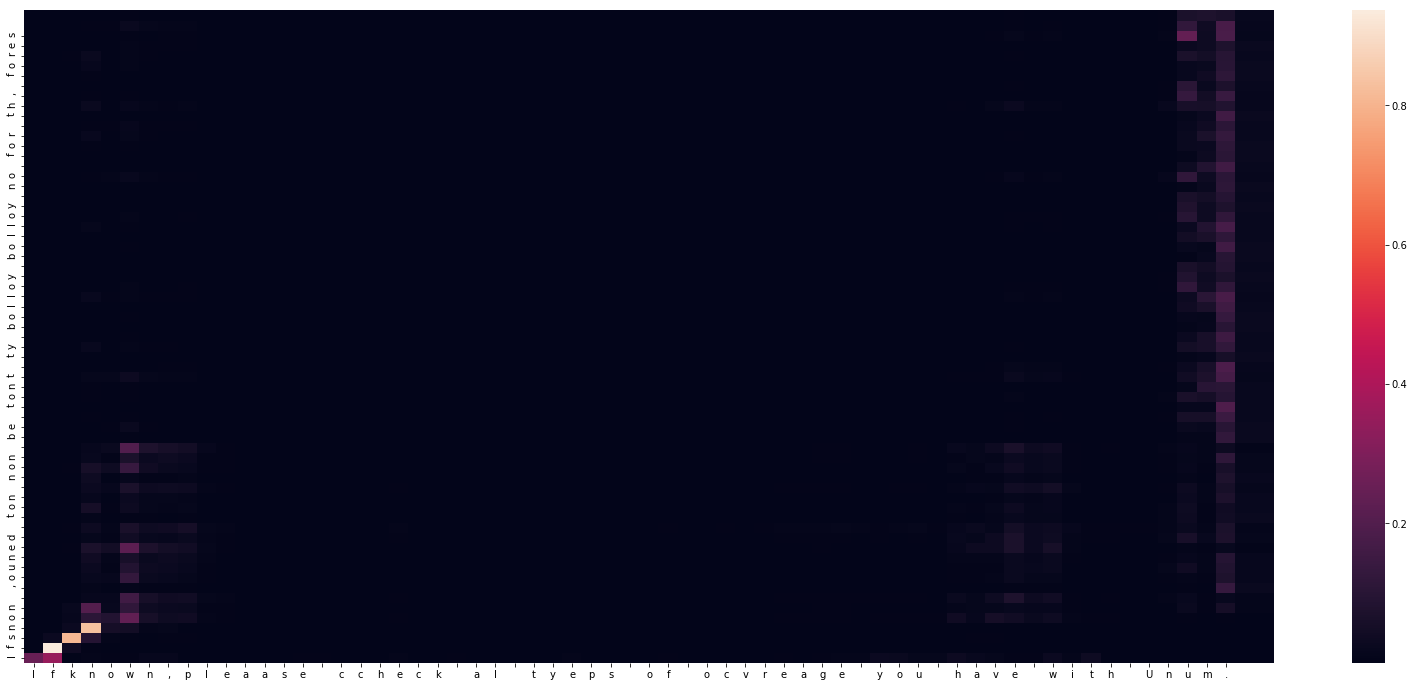

-
Input sentence: Ifknown,pleaase ccheck al tyeps of ocvreage you have with Unum.
GT sentence: If known,please check all types of coverage you have with Unum.

Decoded sentence: Ifsnon ,ouned ton non be tont ty bolloy bolloy no for th, fores


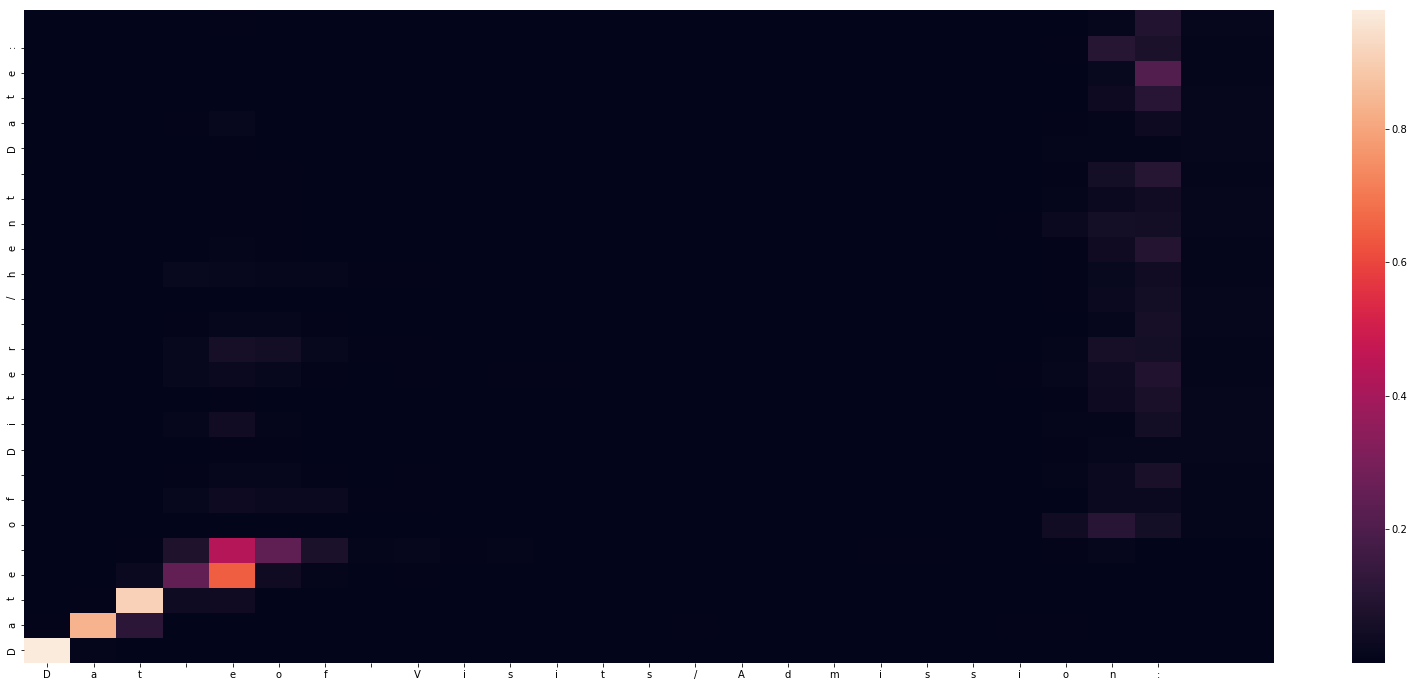

-
Input sentence: Dat eof Visits/Admission:
GT sentence: Date of Visit/Admission:

Decoded sentence: Date of Diter /hent Date:


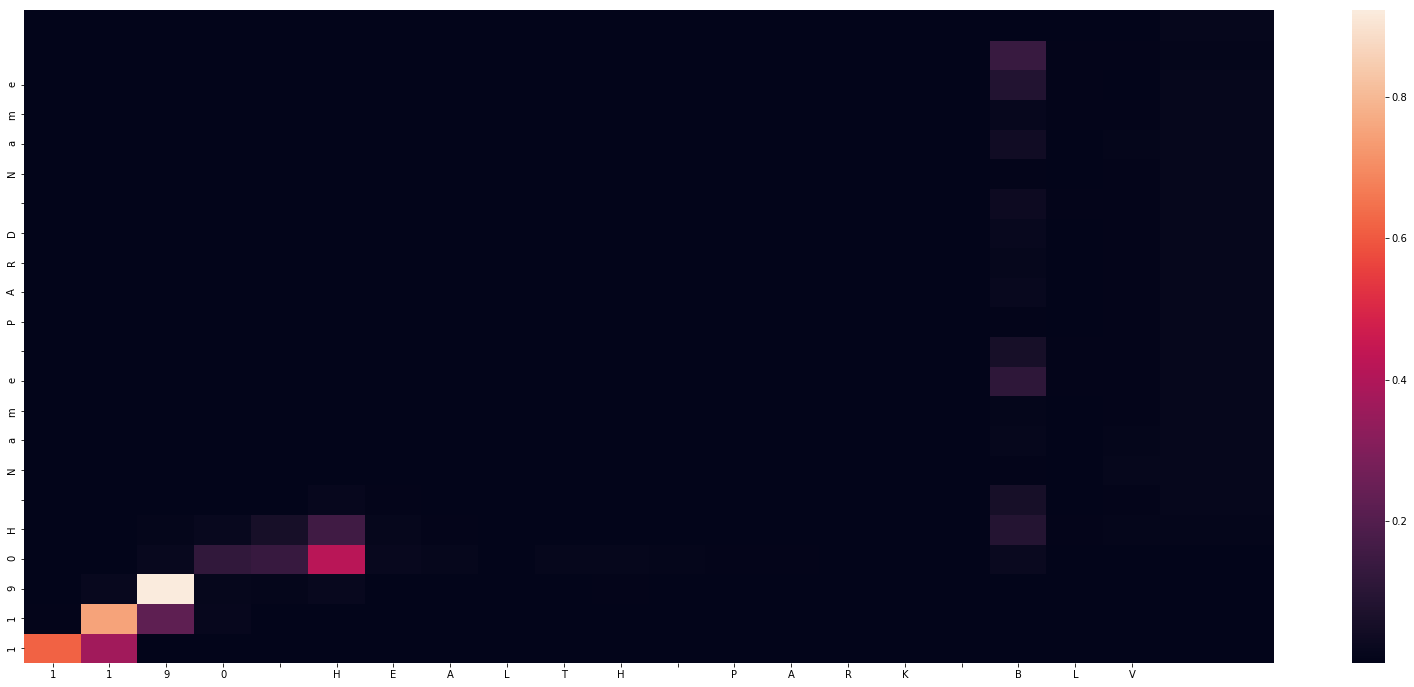

-
Input sentence: 1190 HEALTH PARK BLV
GT sentence: 11190 HEALTH PARK BLVD

Decoded sentence: 1190H Name PARD Name


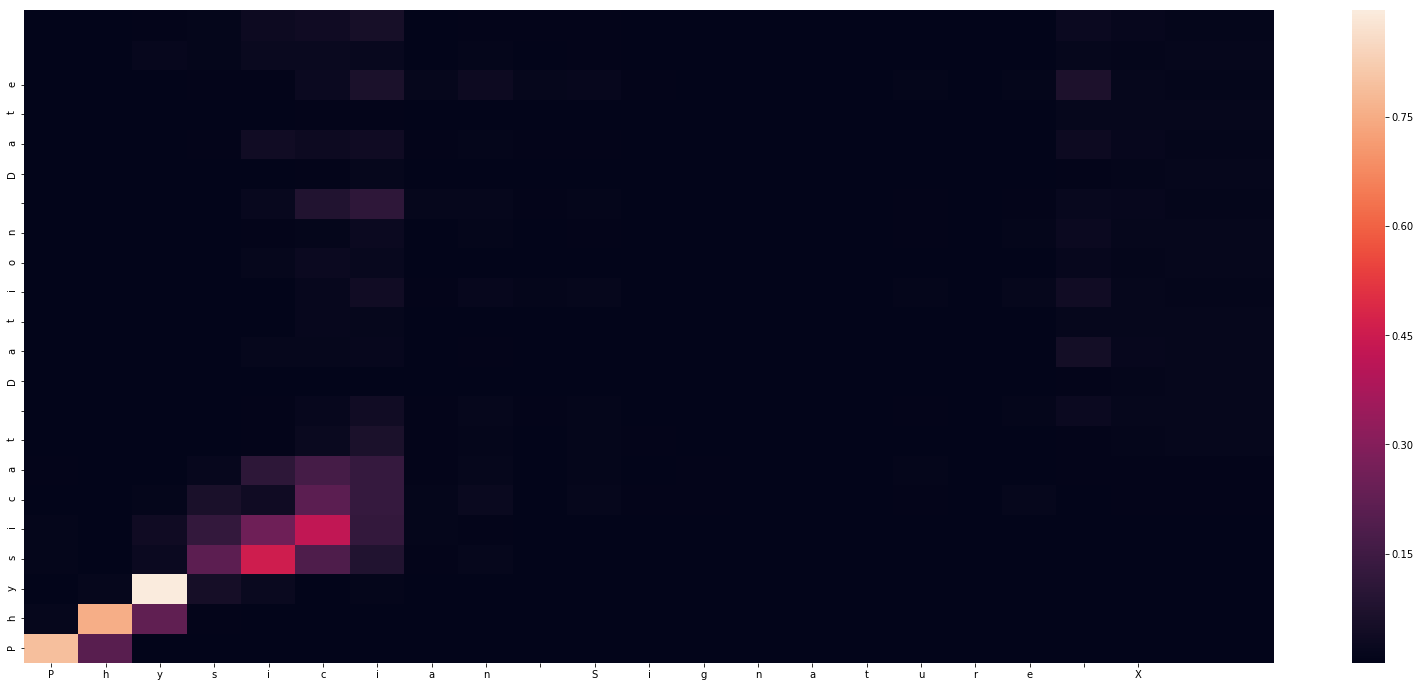

-
Input sentence: Physician Signature X
GT sentence: Physician Signature X

Decoded sentence: Physicat Dation Date


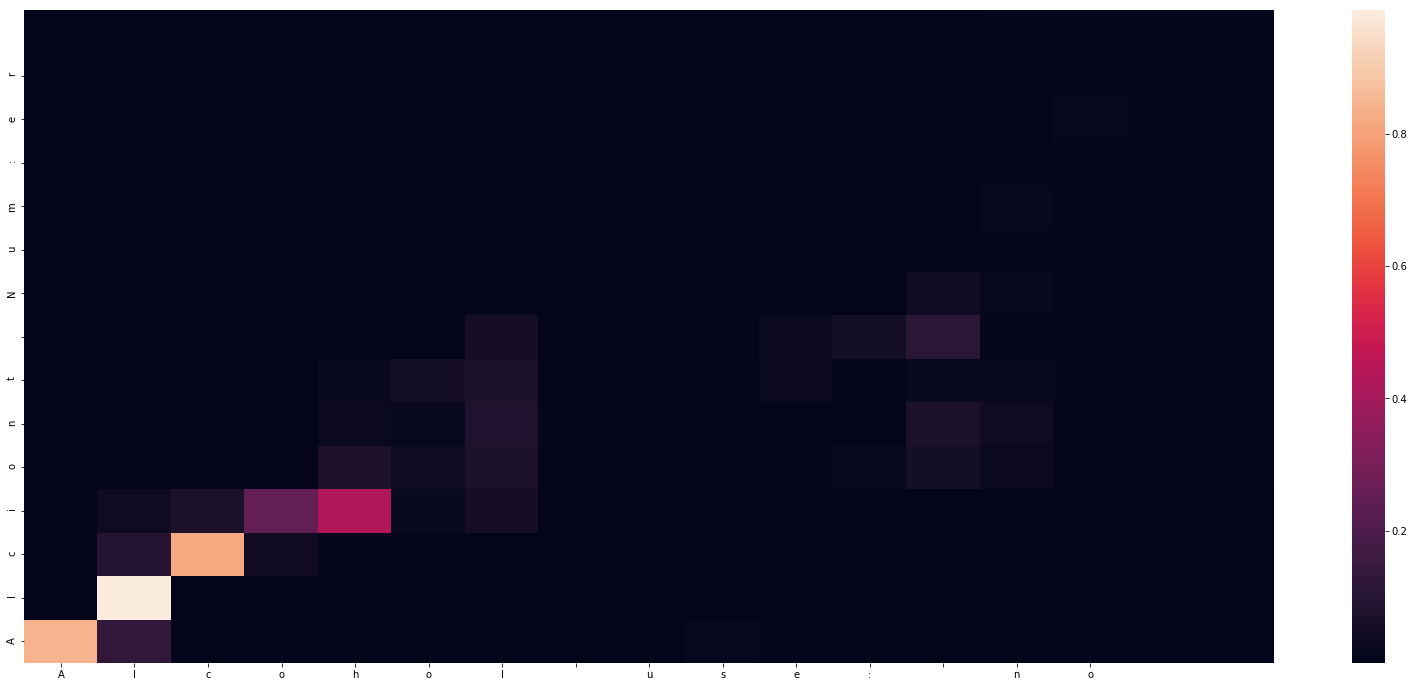

-
Input sentence: Alcohol use: no
GT sentence: Alcohol use: no

Decoded sentence: Alciont Num:er


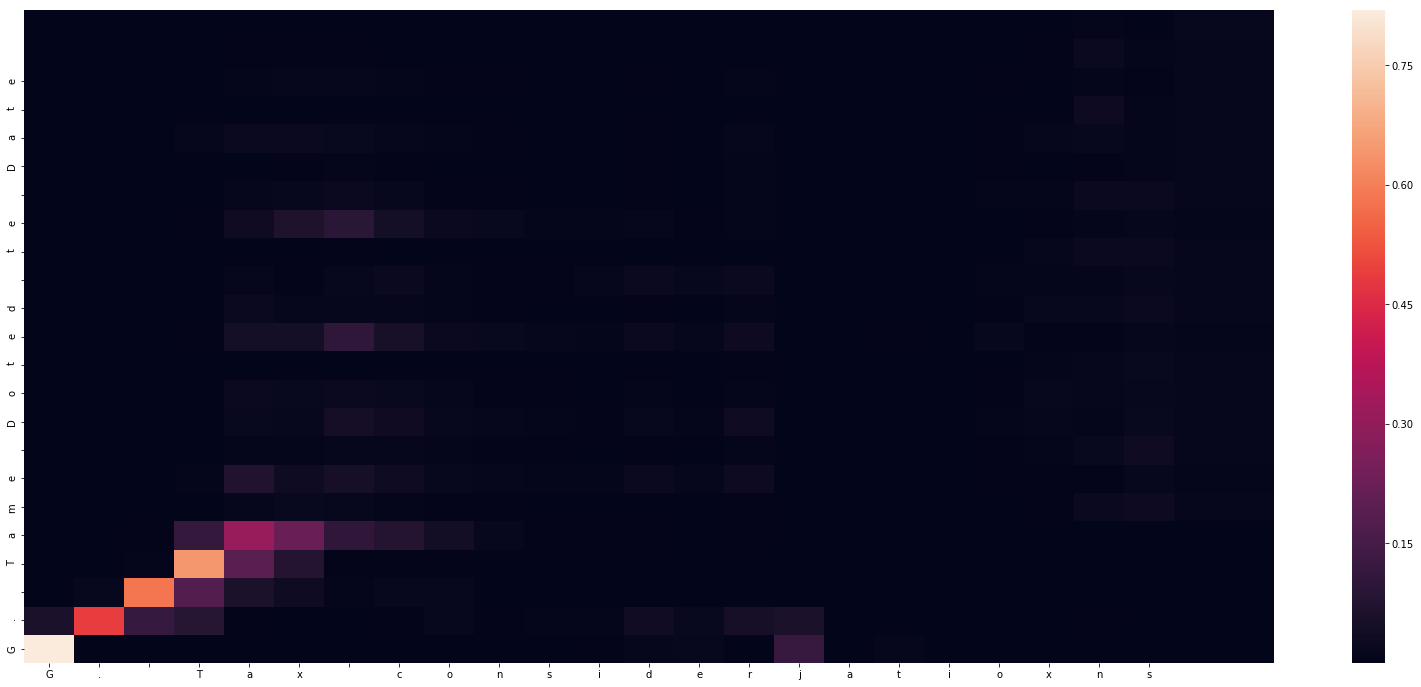

-
Input sentence: G. Tax considerjatioxns
GT sentence: G. Tax considerations

Decoded sentence: G. Tame Doted te Date


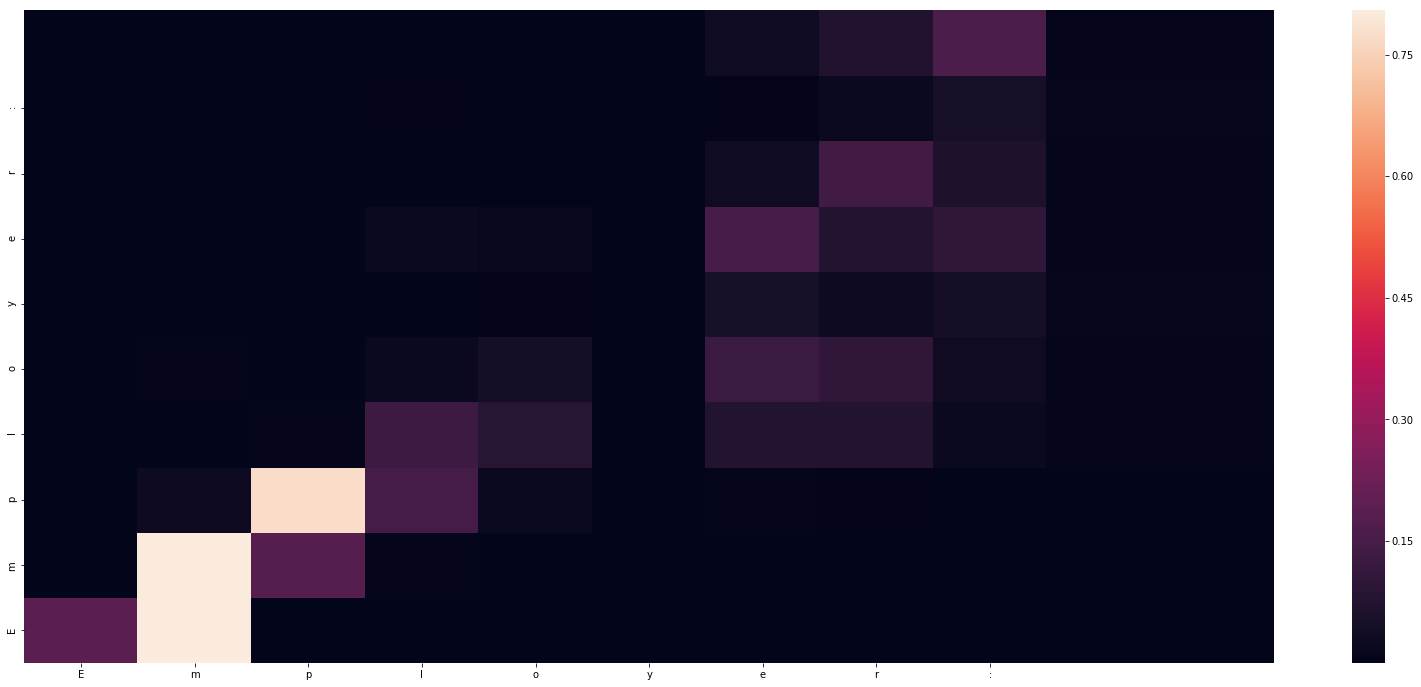

-
Input sentence: Employer:
GT sentence: Employer:

Decoded sentence: Employer:


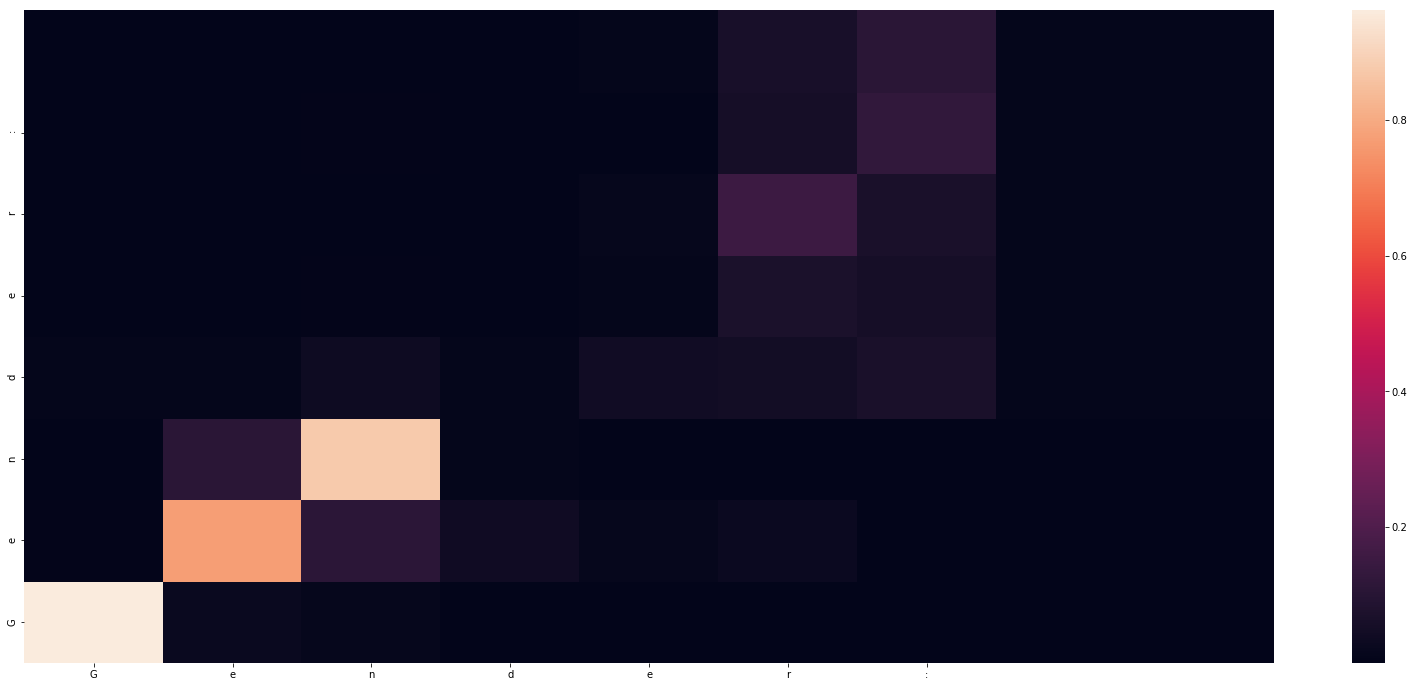

-
Input sentence: Gender:
GT sentence: Gender:

Decoded sentence: Gender:


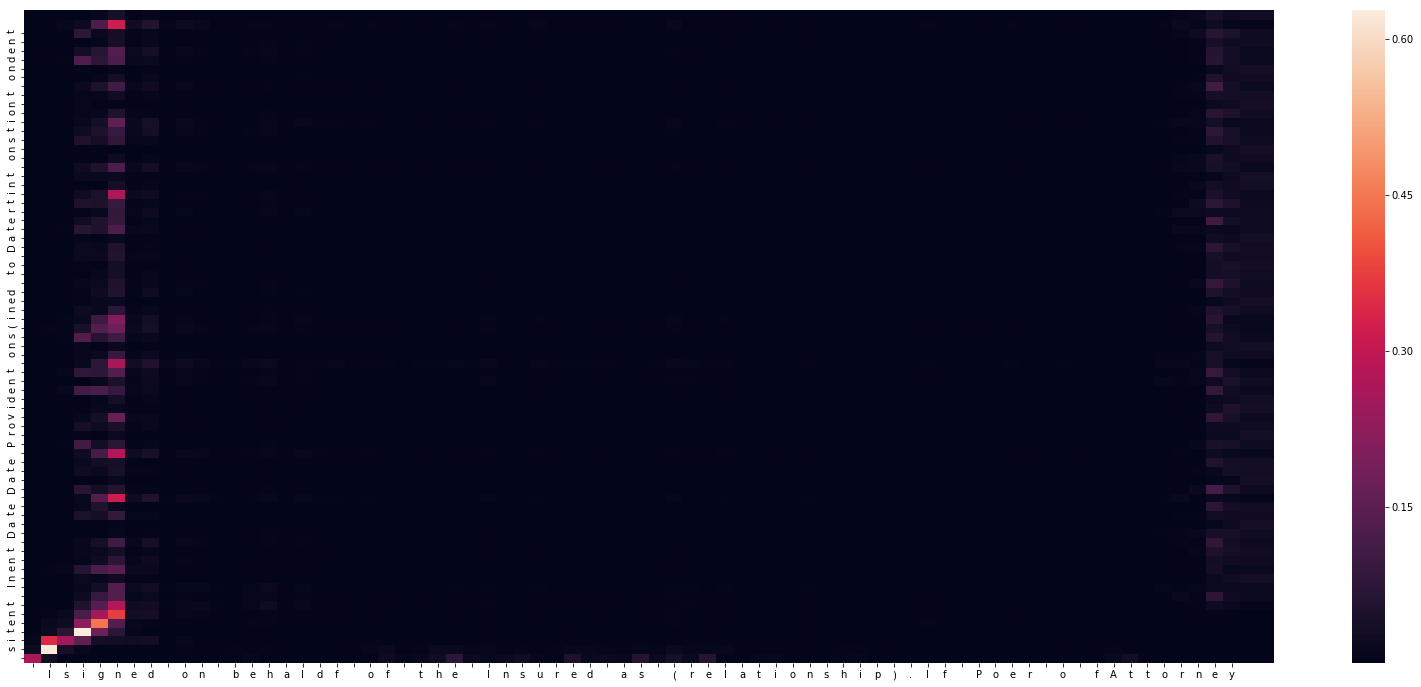

-
Input sentence:  Isigned on behaldf of the Insured as (relationship).If Poer o fAttorney
GT sentence: I signed on behalf of the Insured as (relationship). If Power of Attorney

Decoded sentence:  sitent Inent Date Date Provident ons(ined to Datertint onstiont ondent


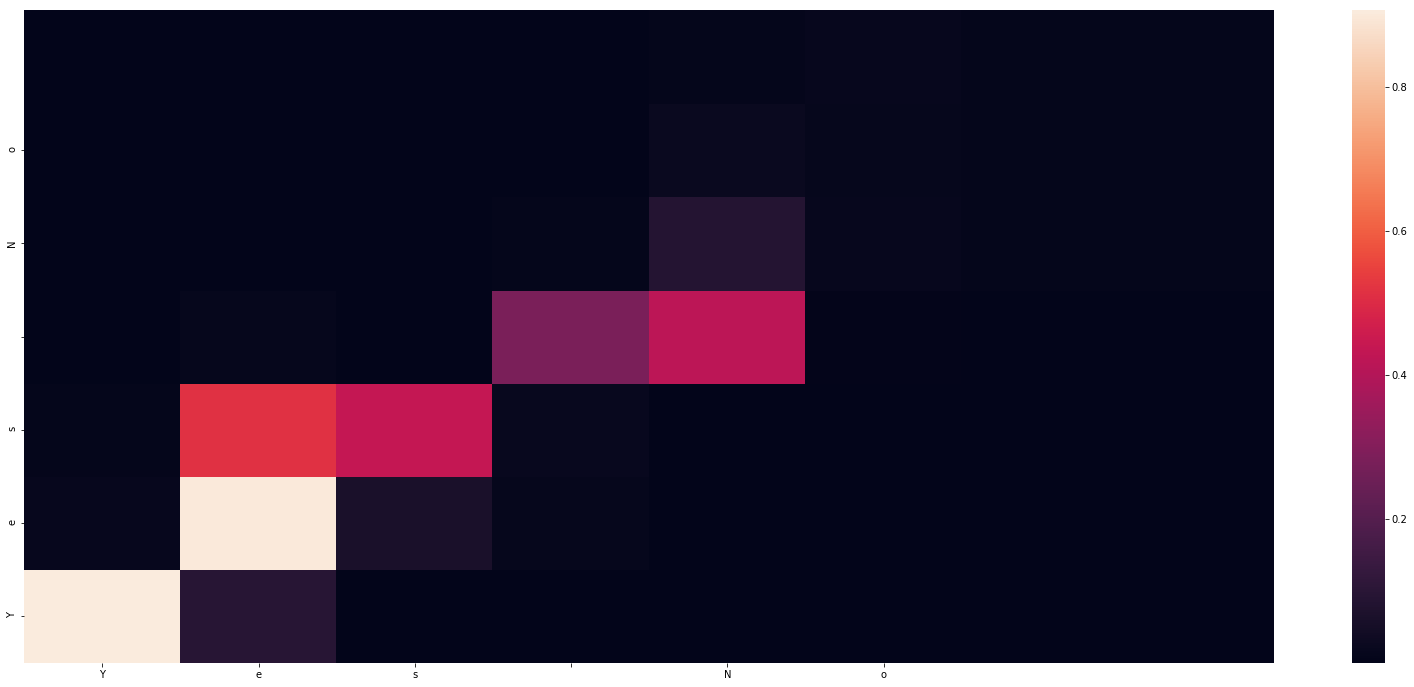

-
Input sentence: Yes No
GT sentence: Yes No

Decoded sentence: Yes No


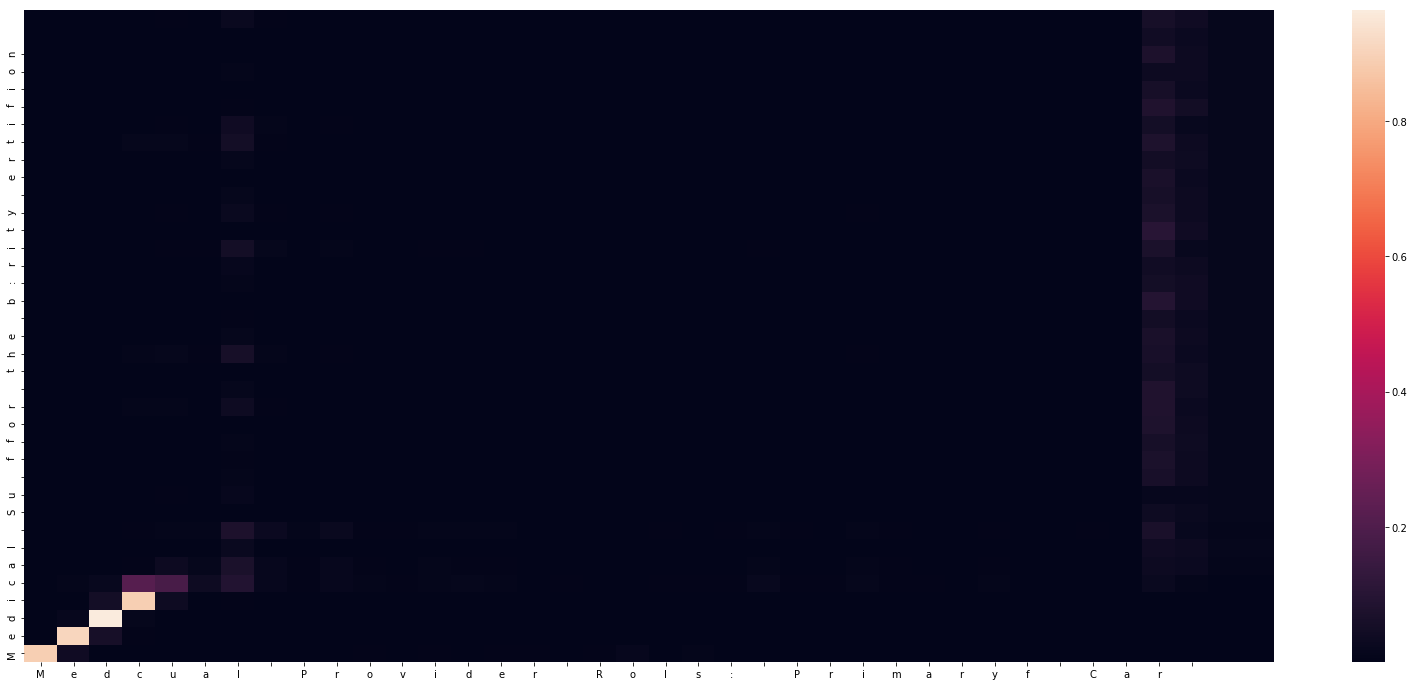

-
Input sentence: Medcual Provider Rols: Primaryf Car

GT sentence: Medical Provider Roles: Primary Care

Decoded sentence: Medical Su ffor the b:rity ertifion


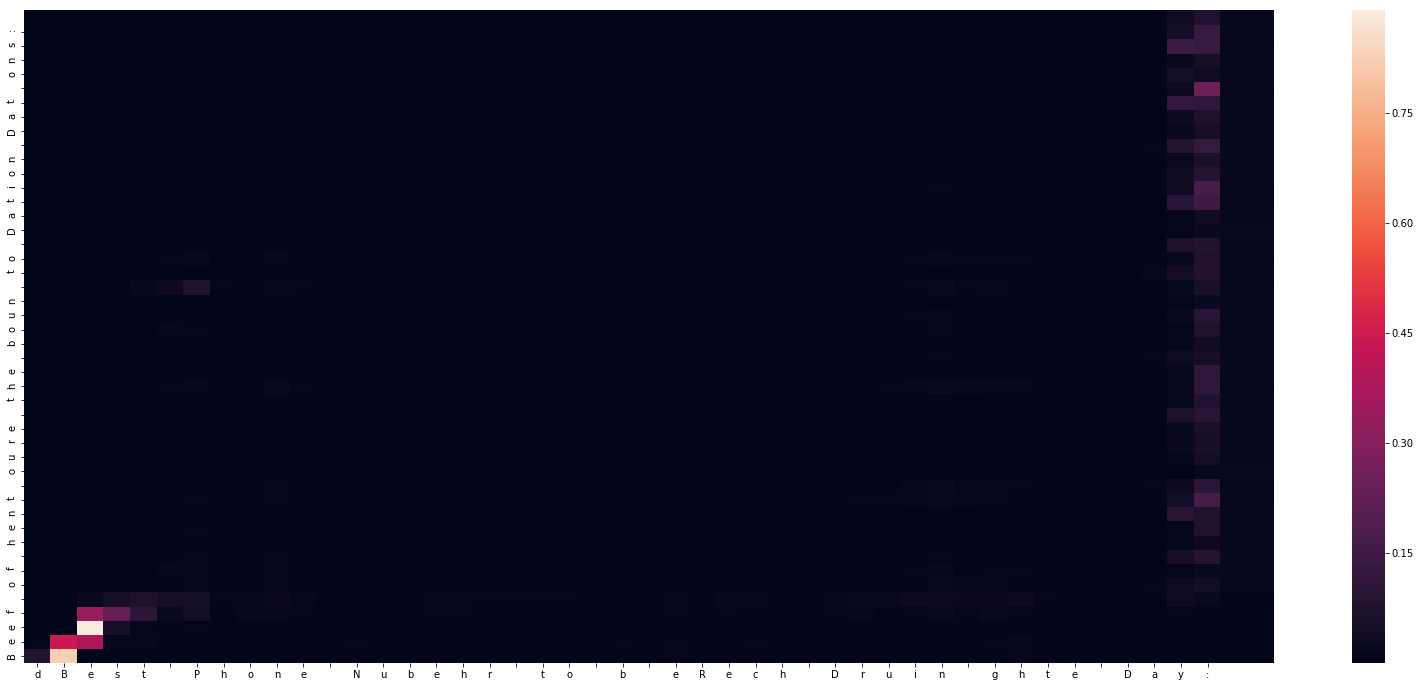

-
Input sentence: dBest Phone Nubehr to b eRech Druin ghte Day:
GT sentence: Best Phone Number to be Reach During the Day:

Decoded sentence: Beef of hent oure the boun to Dation Dat ons:


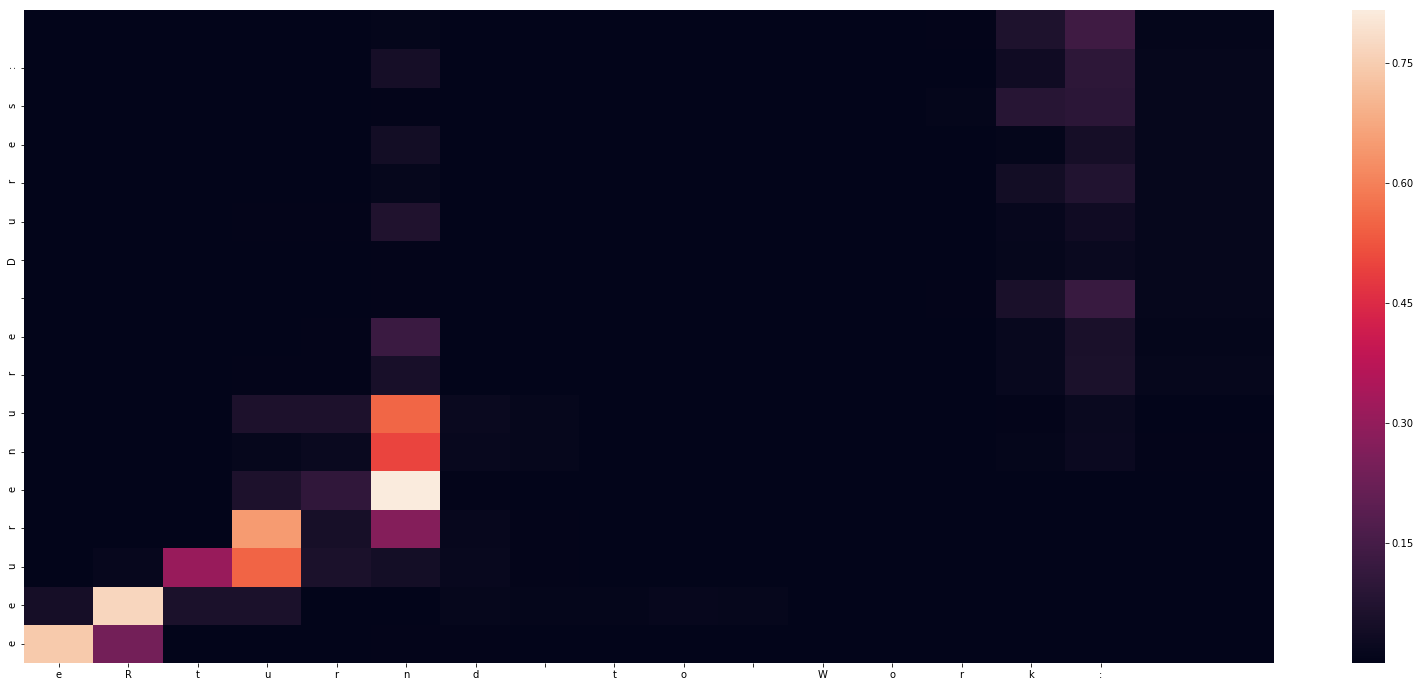

-
Input sentence: eRturnd to Work:
GT sentence: Returned to Work:

Decoded sentence: eeurenure Dures:


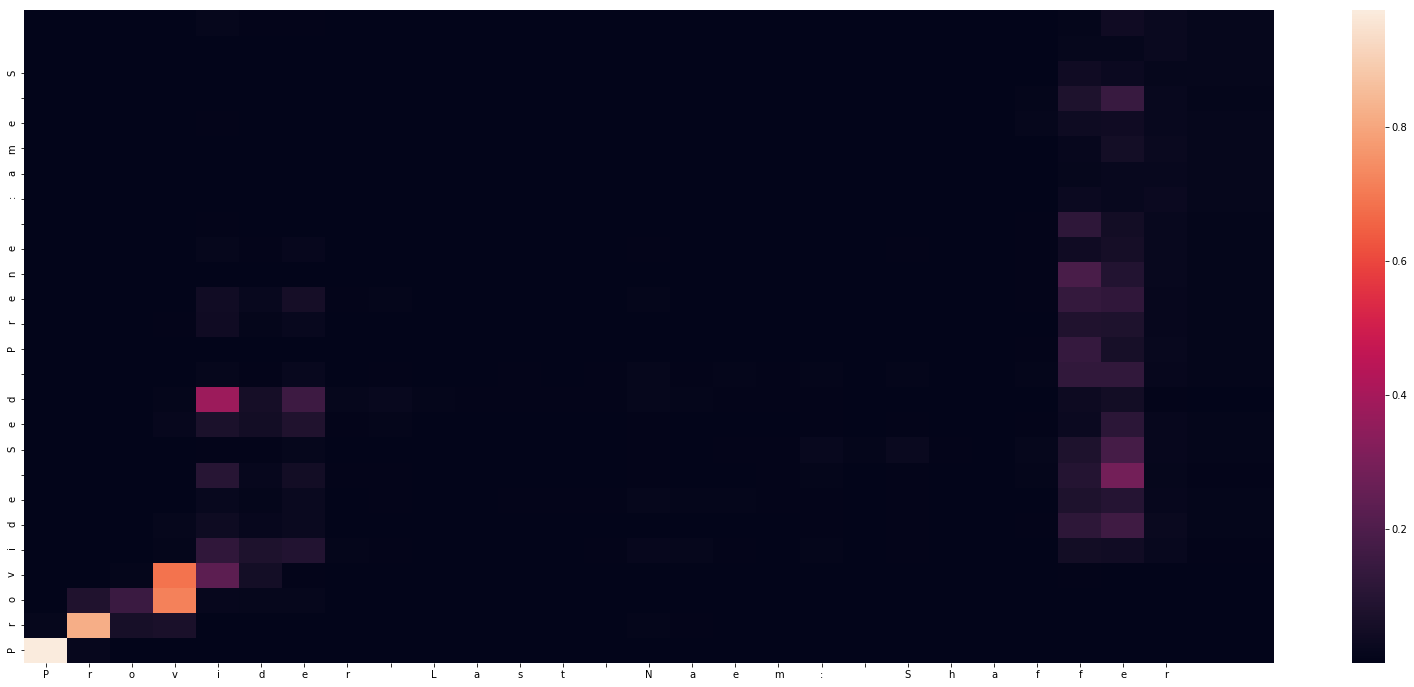

-
Input sentence: Provider Last Naem: Shaffer
GT sentence: Provider Last Name: Shaffer

Decoded sentence: Provide Sed Prene :ame S


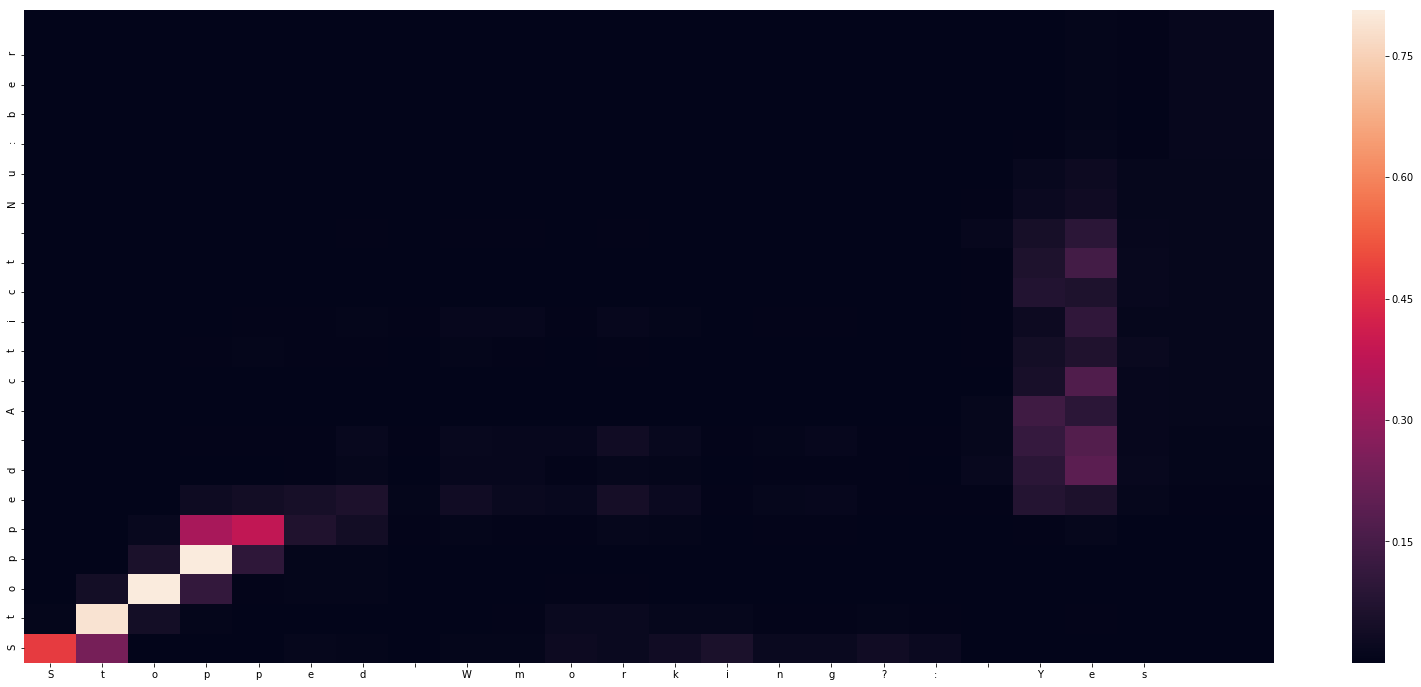

-
Input sentence: Stopped Wmorking?: Yes
GT sentence: Stopped Working?: Yes

Decoded sentence: Stopped Actict Nu:ber


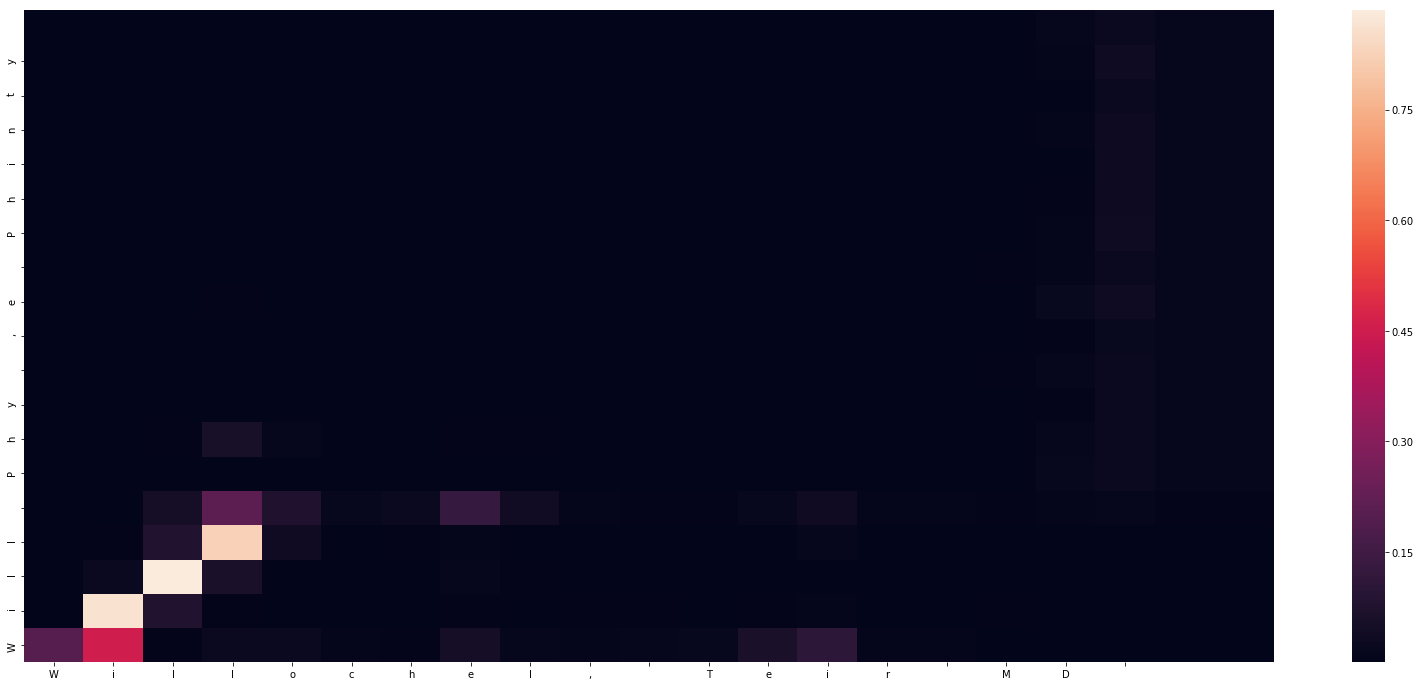

-
Input sentence: Willochel, Teir MD

GT sentence: Willochell, Teri MD 

Decoded sentence: Will Phy ,e Phinty


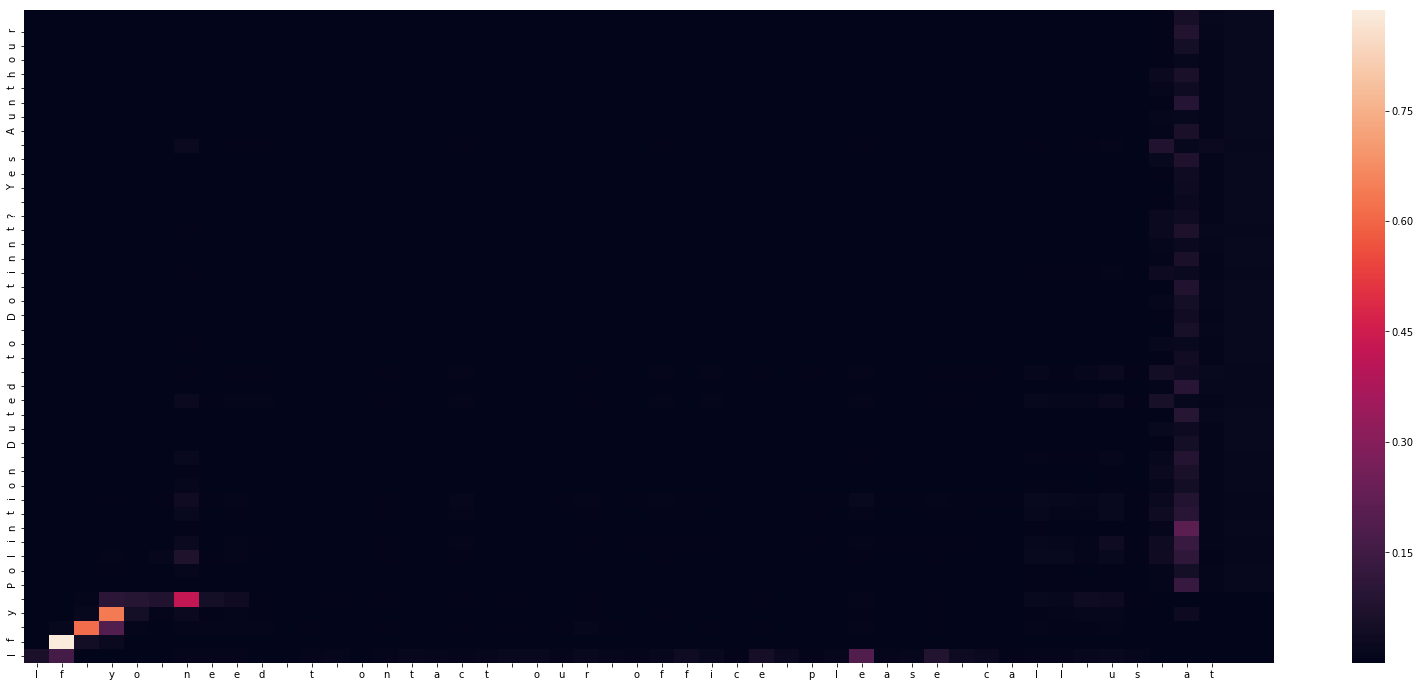

-
Input sentence: If yo need t ontact our office please call us at
GT sentence: If you need to contact our office please call us at

Decoded sentence: If y Polintion Duted to Dotinnt? Yes Aunthour


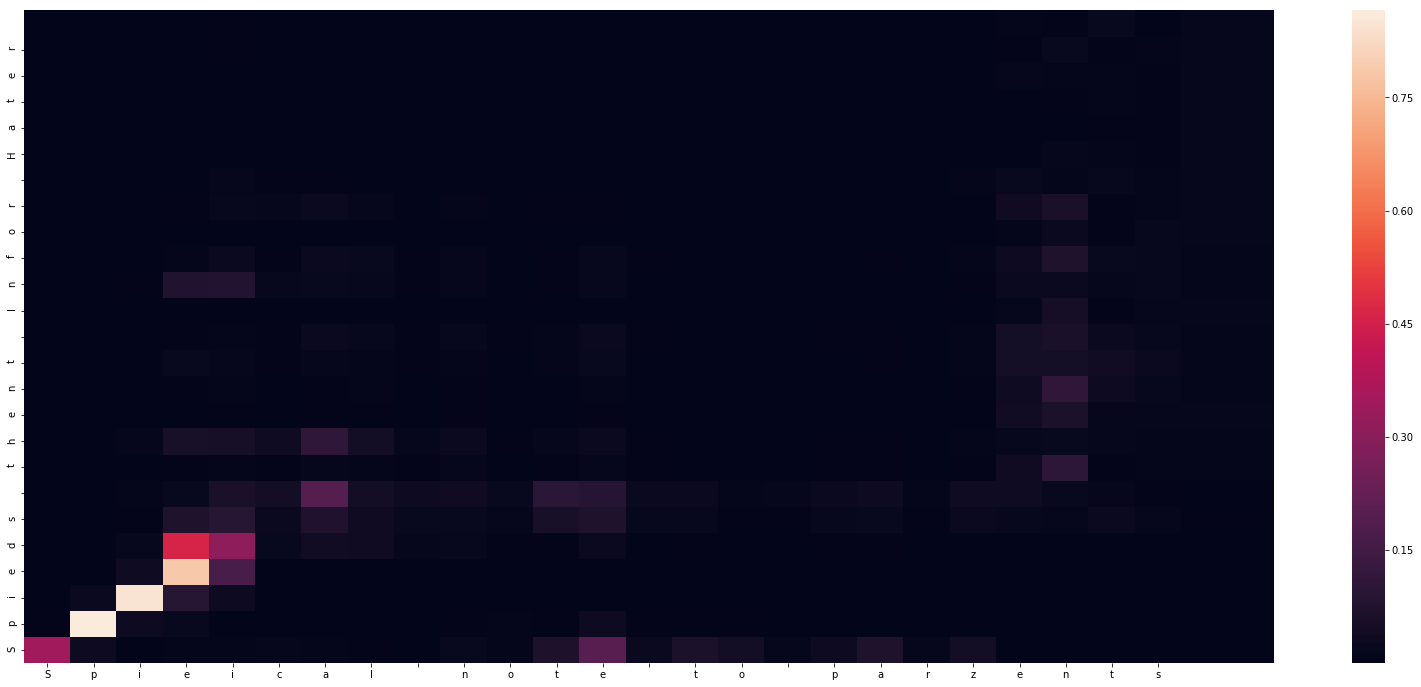

-
Input sentence: Spieical note to parzents
GT sentence: Special note to parents

Decoded sentence: Spieds thent Infor Hater


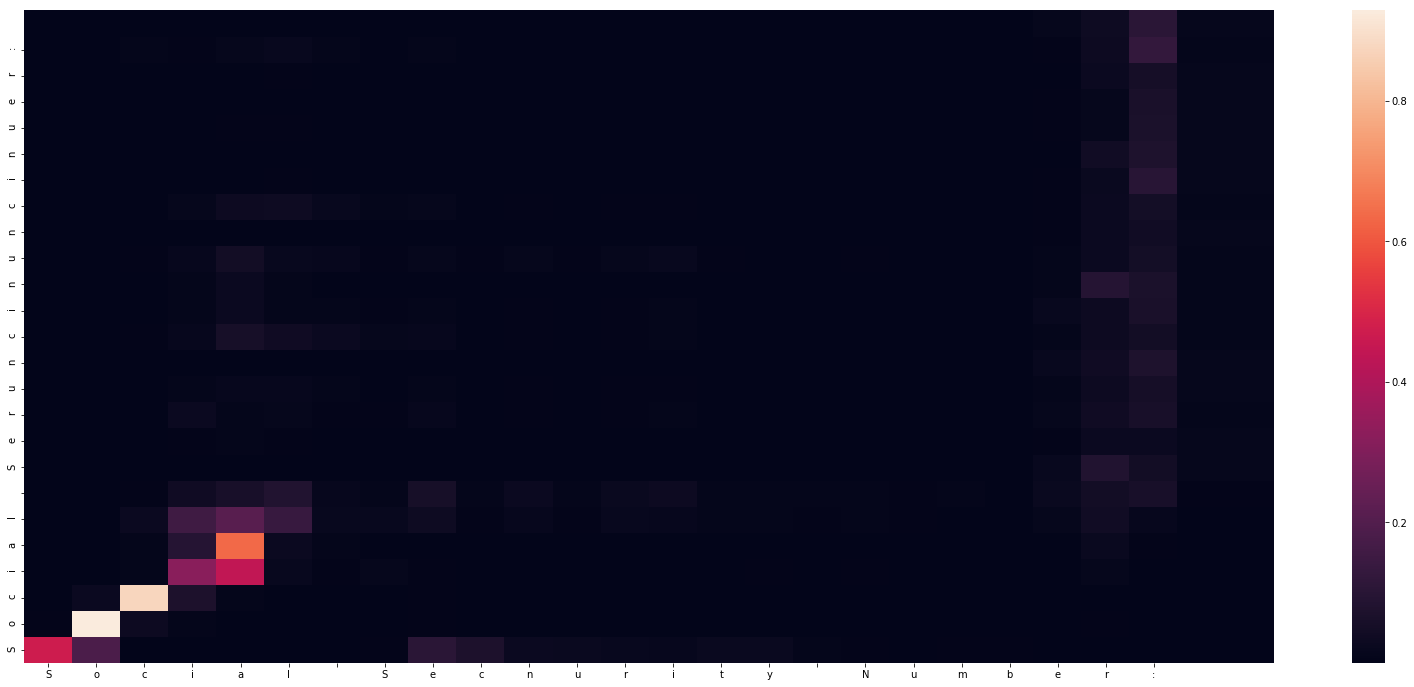

-
Input sentence: Social Secnurity Number:
GT sentence: Social Security Number:

Decoded sentence: Social Seruncinuncinuer:


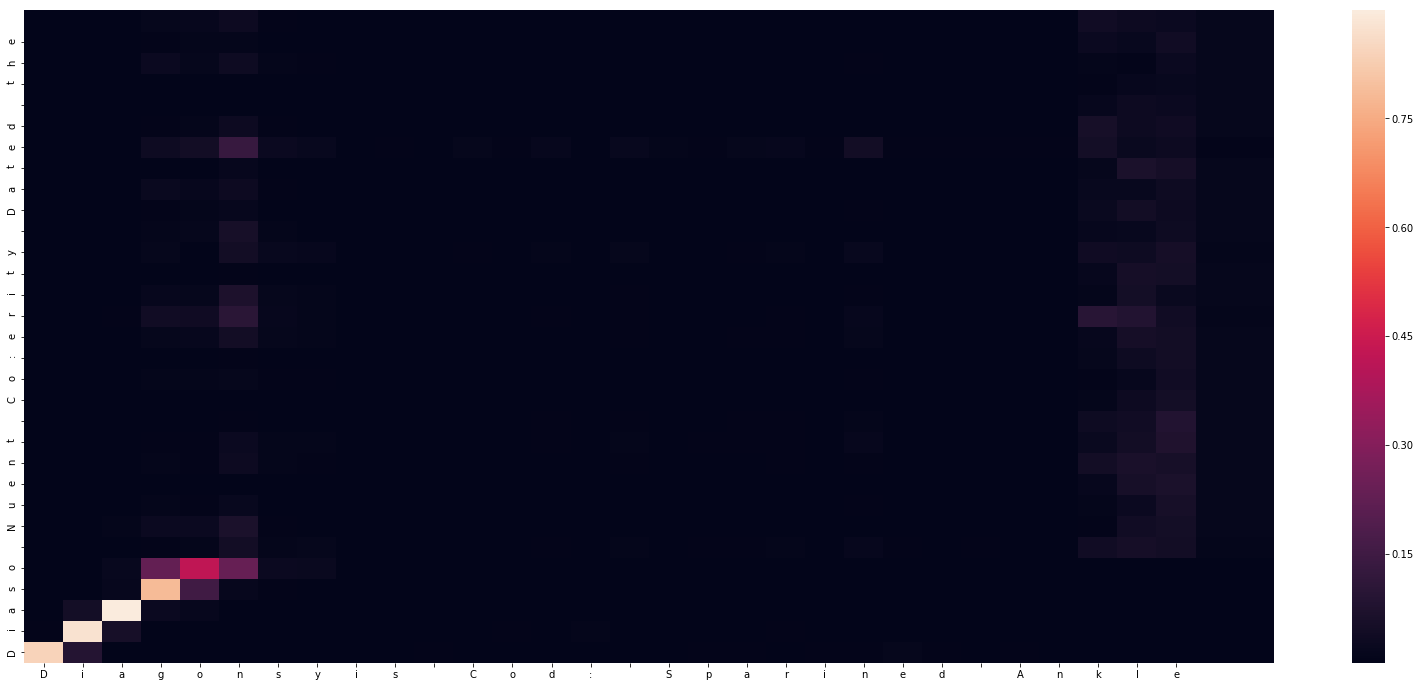

-
Input sentence: Diagonsyis Cod: Sparined Ankle
GT sentence: Diagnosis Code: Sprained Ankle

Decoded sentence: Diaso Nuent Co:erity Dated the


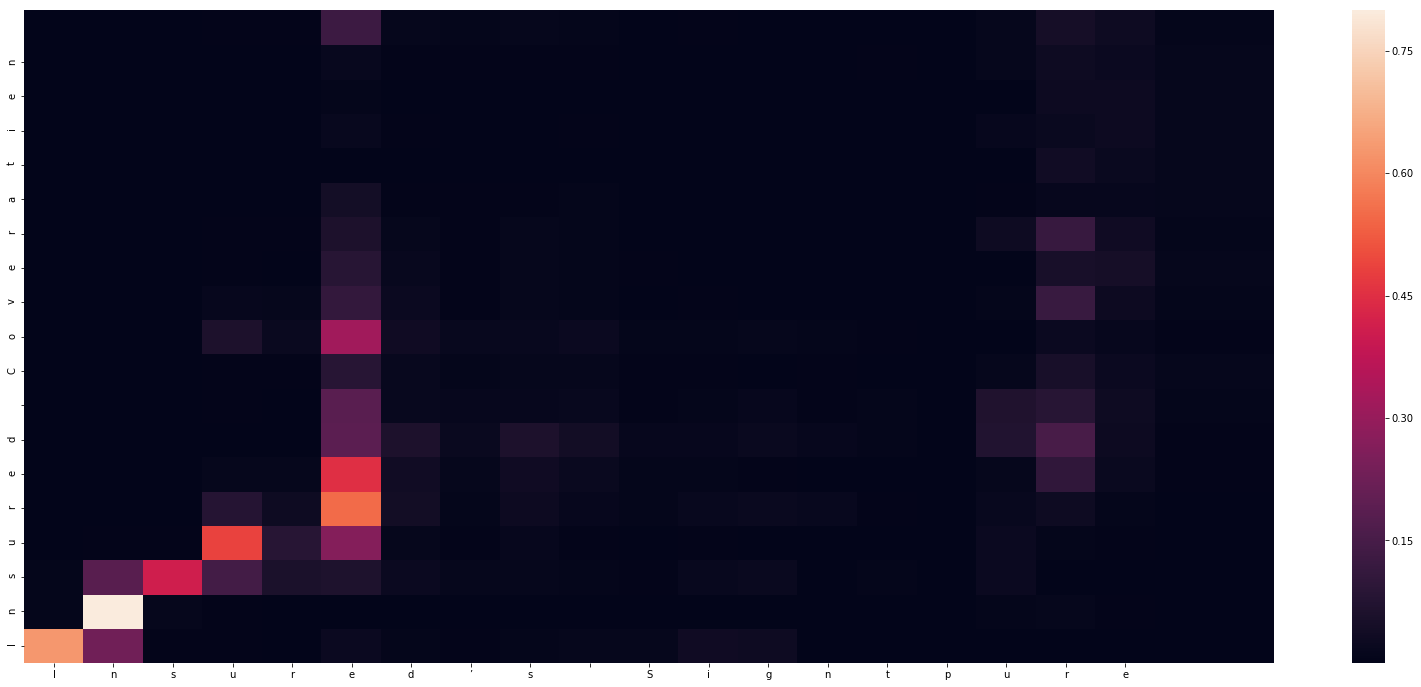

-
Input sentence: Insured’s Signtpure
GT sentence: Insured’s Signature

Decoded sentence: Insured Coveratien


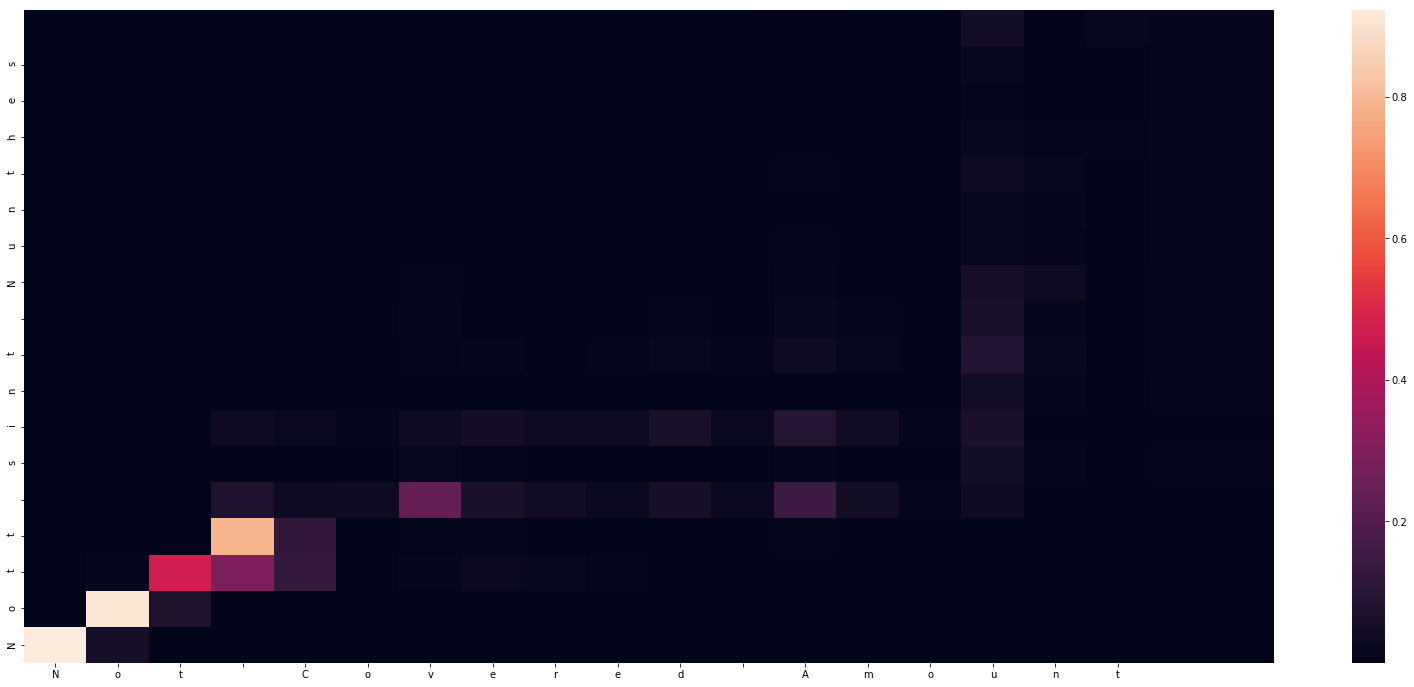

-
Input sentence: Not Covered Amount
GT sentence: Not Covered Amount

Decoded sentence: Nott sint Nunthes


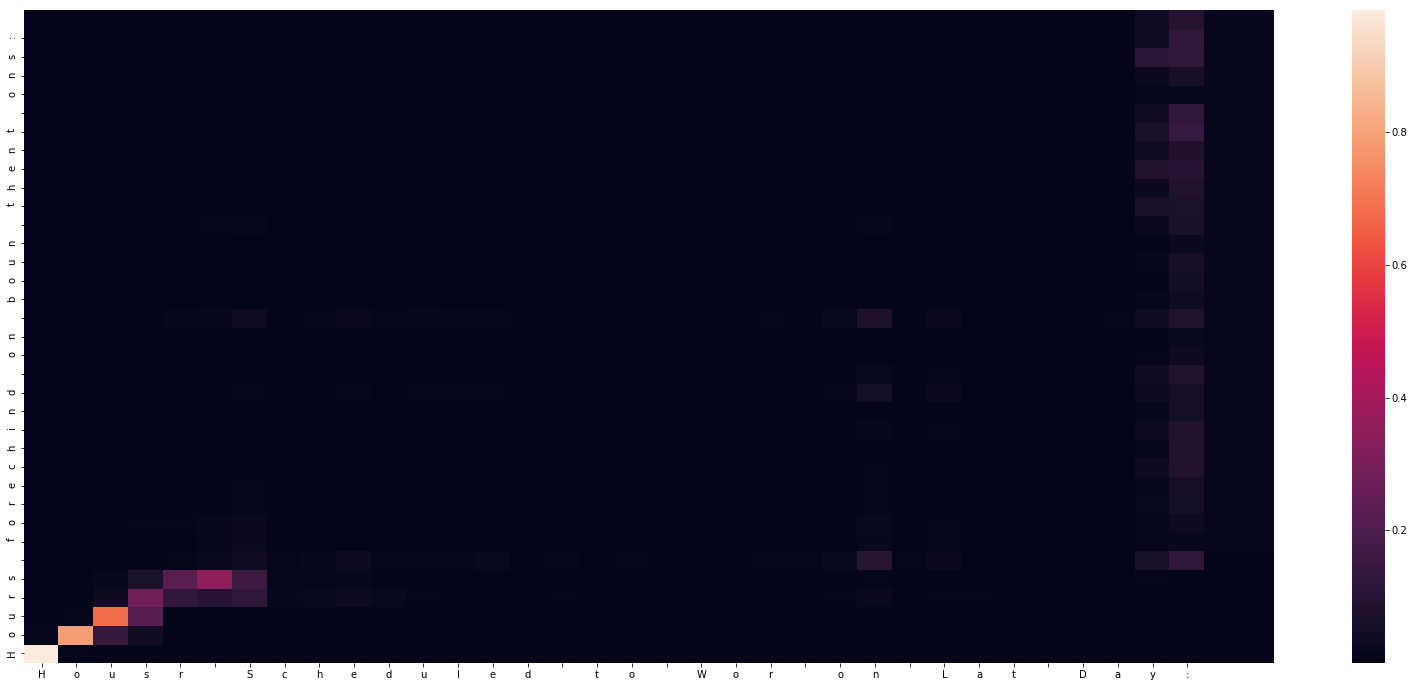

-
Input sentence: Housr Scheduled to Wor on Lat Day:
GT sentence: Hours Scheduled to Work on Last Day:

Decoded sentence: Hours forechind on boun thent ons:


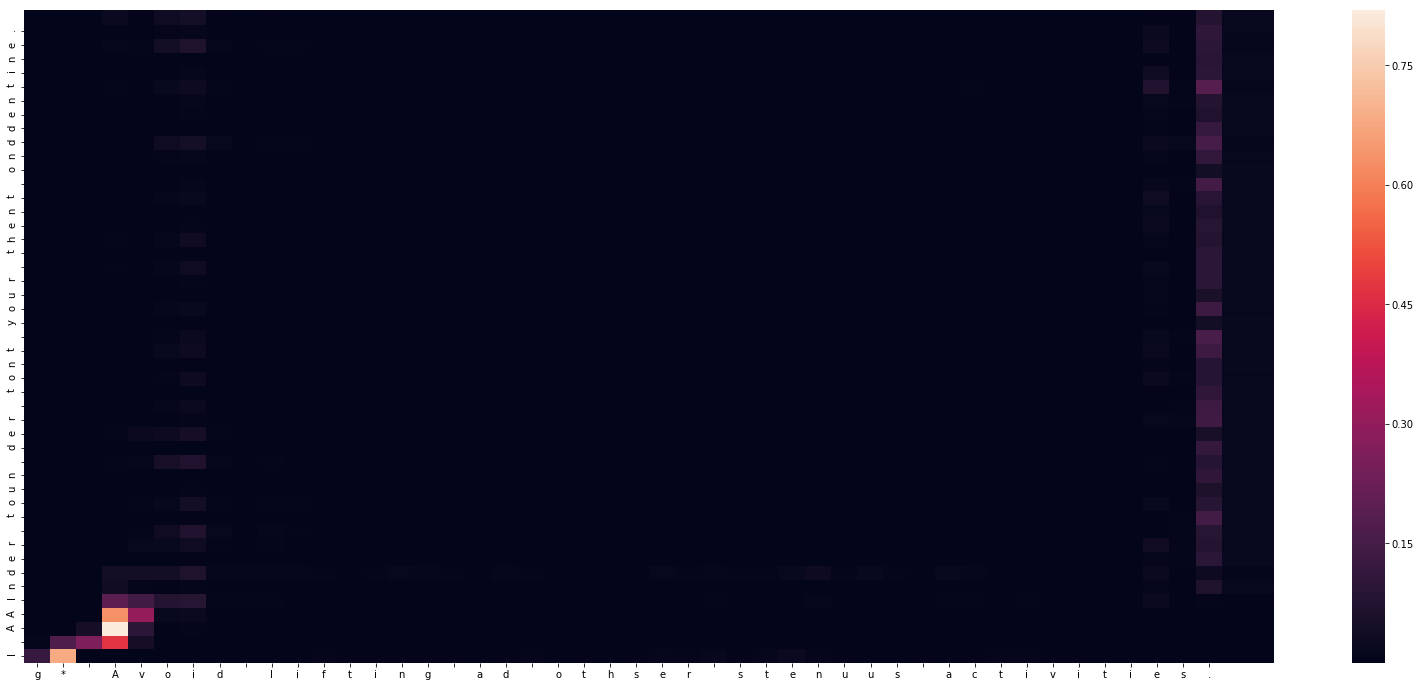

-
Input sentence: g* Avoid lifting ad othser stenuus activities.
GT sentence: * Avoid lifting and other strenuous activities.

Decoded sentence: I AAInder toun der tont your thent onddentine.


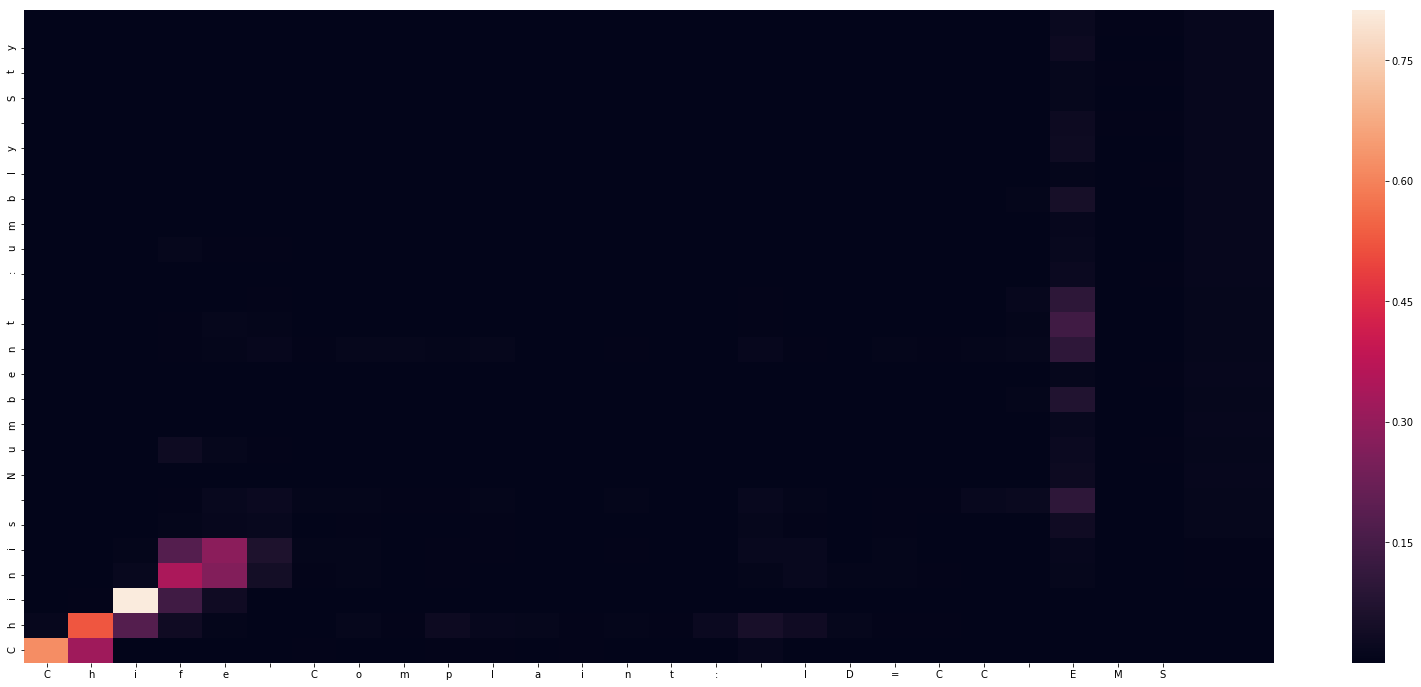

-
Input sentence: Chife Complaint: ID=CC EMS
GT sentence: Chief Complaint: ICD=CC EMS

Decoded sentence: Chinis Numbent :umbly Sty


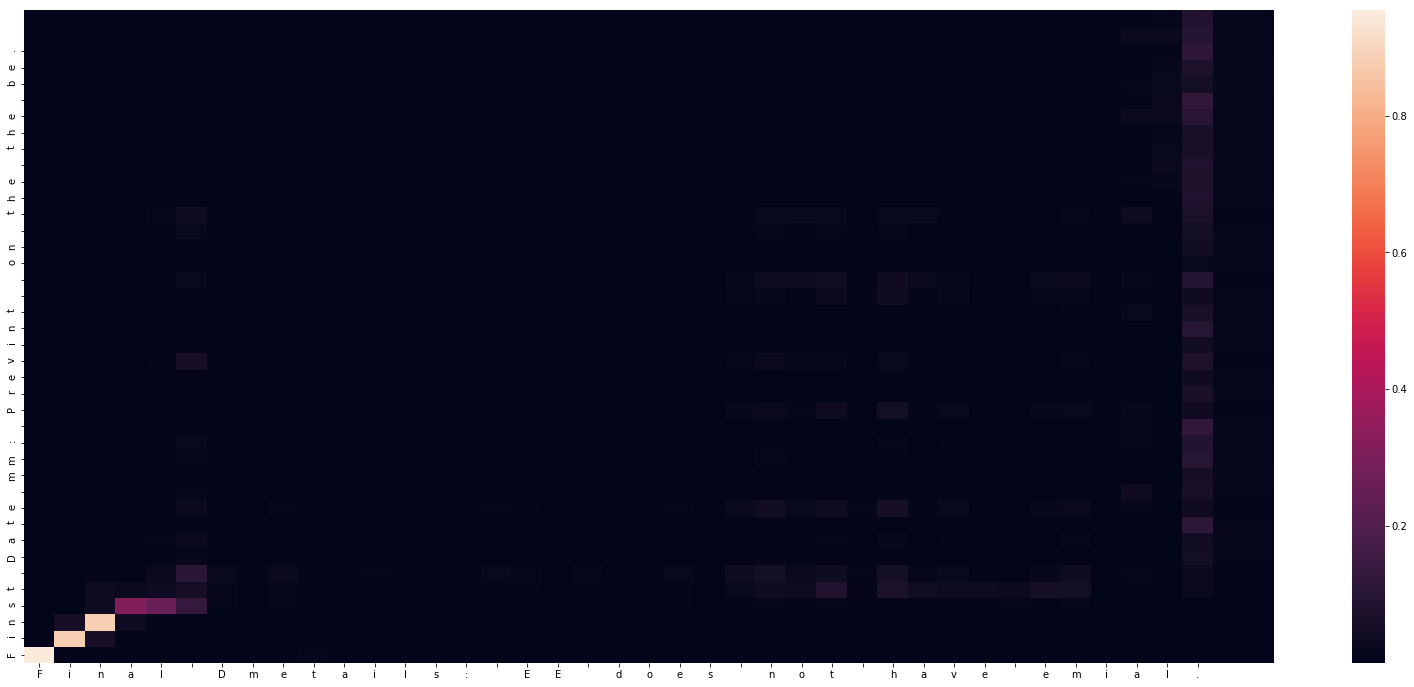

-
Input sentence: Final Dmetails: EE does not have emial.
GT sentence: Final Details: EE does not have email.

Decoded sentence: Finst Date mm: Prevint  on the the be.


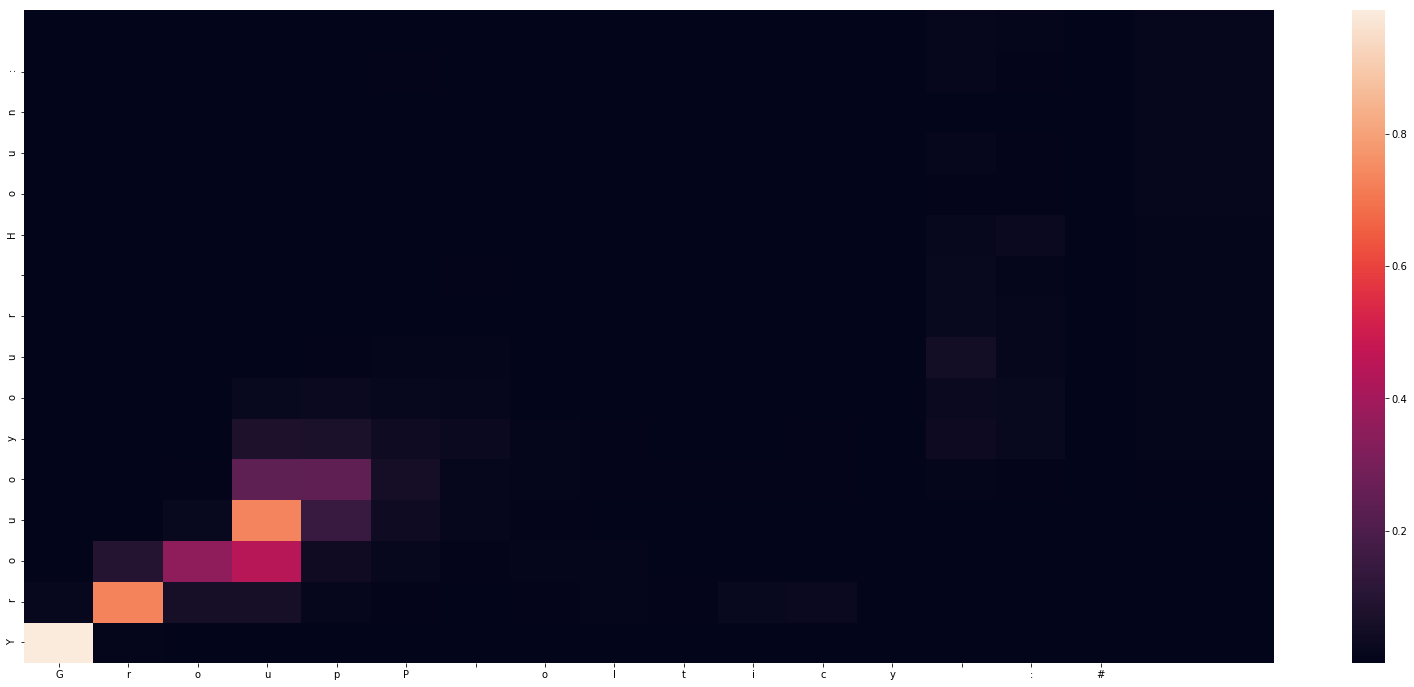

-
Input sentence: GroupP olticy :#
GT sentence: Group Policy #:

Decoded sentence: Yrouoyour Houn:


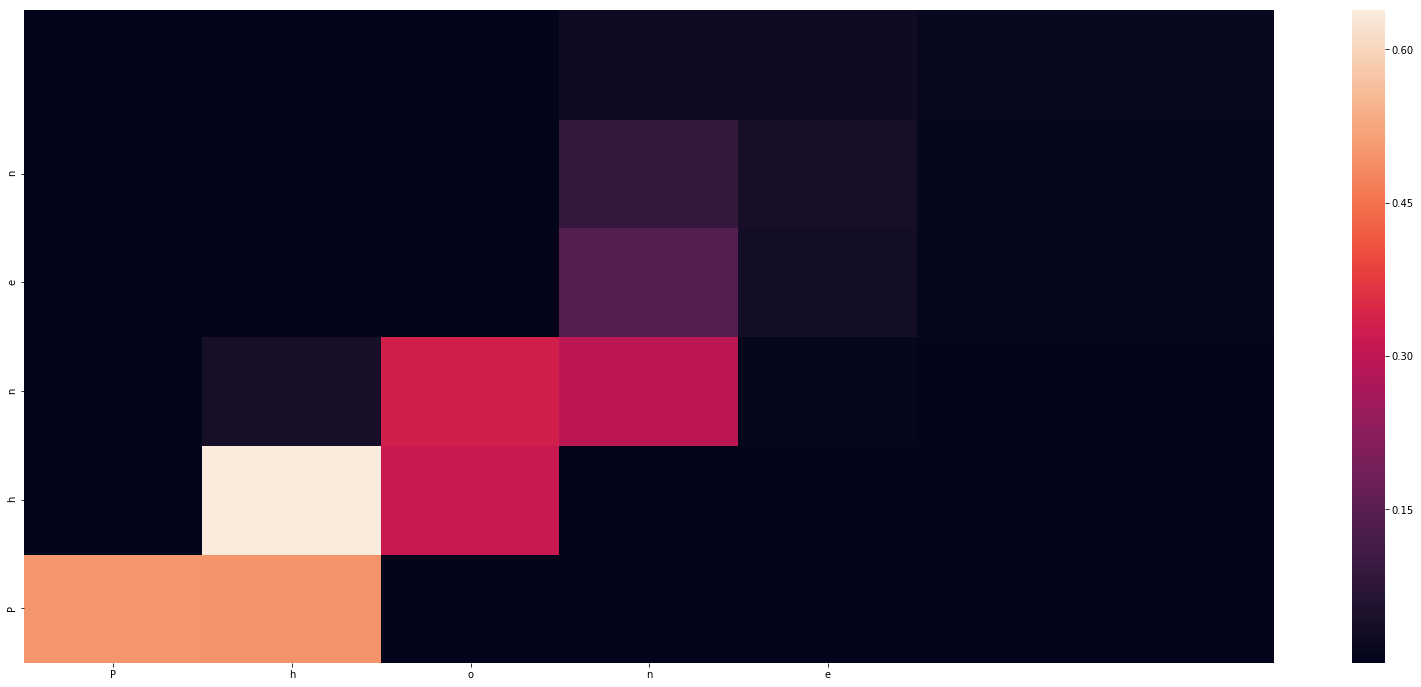

-
Input sentence: Phone
GT sentence: Phone

Decoded sentence: Phnen


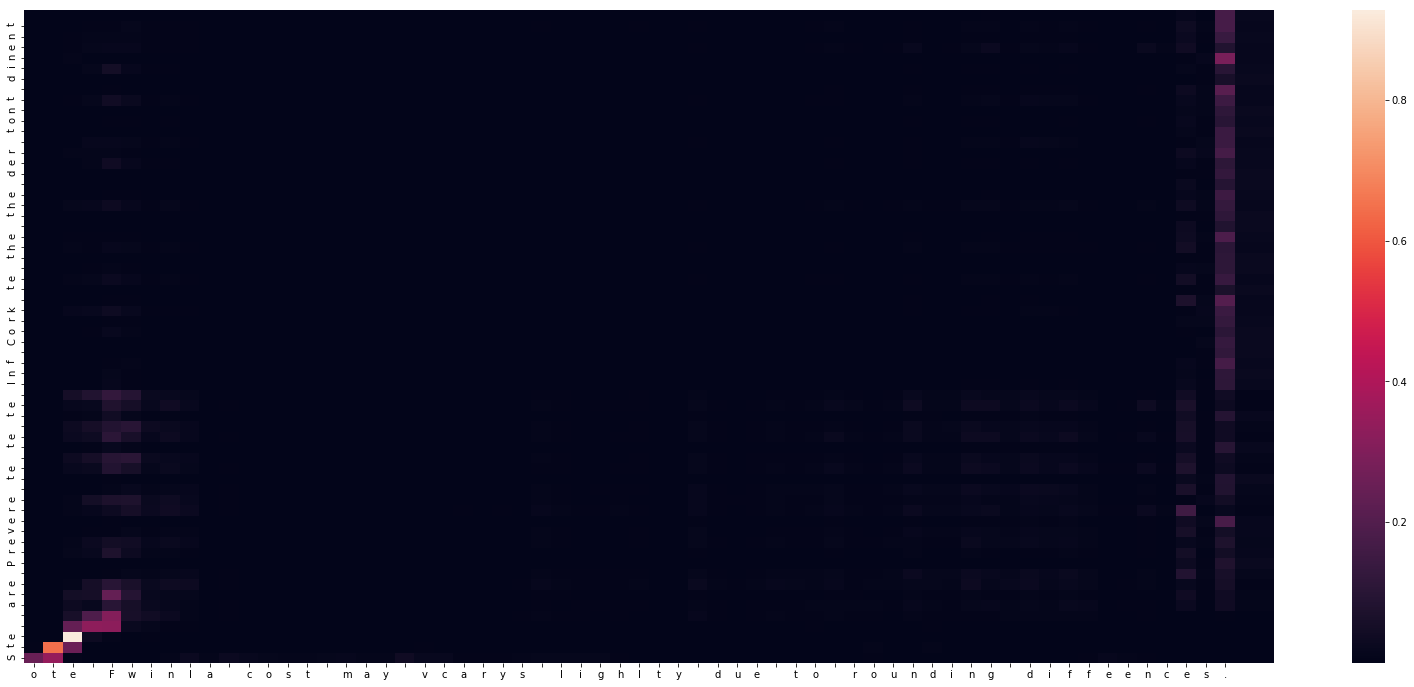

-
Input sentence: ote Fwinla cost may vcarys lighlty due to rounding diffeences.
GT sentence: Note: Final cost may vary slightly due to rounding differences.

Decoded sentence: Ste  are Prevere te te te Inf Cork te the the der tont dinent


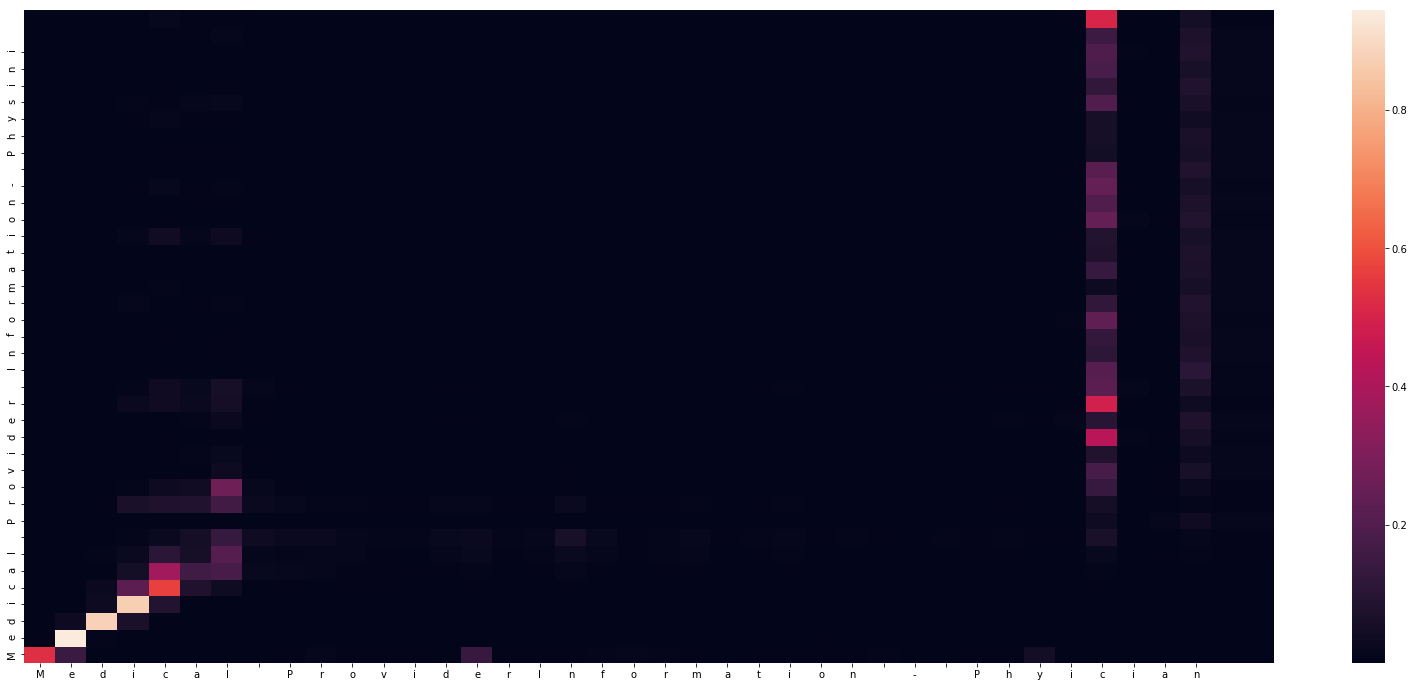

-
Input sentence: Medical ProviderInformation - Phyician
GT sentence: Medical Provider Information - Physician

Decoded sentence: Medical Provider Information- Physini


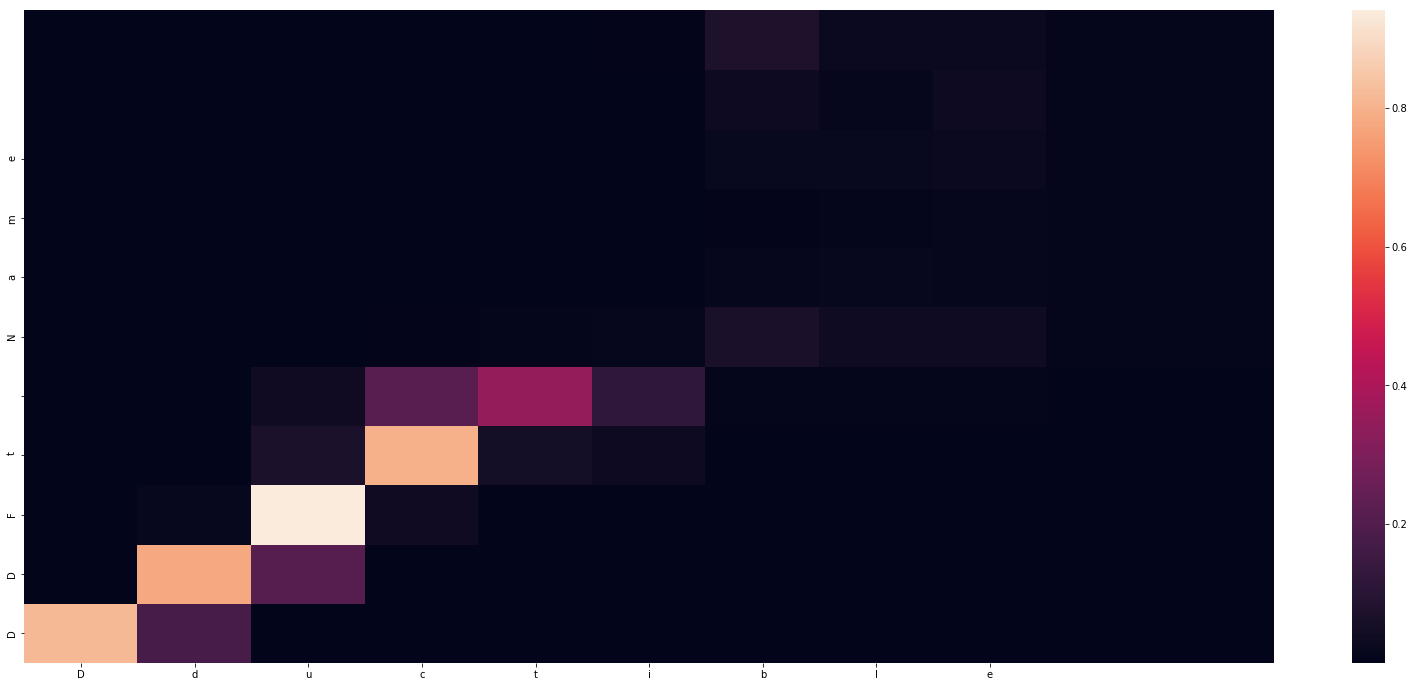

-
Input sentence: Dductible
GT sentence: Deductible

Decoded sentence: DDFt Name


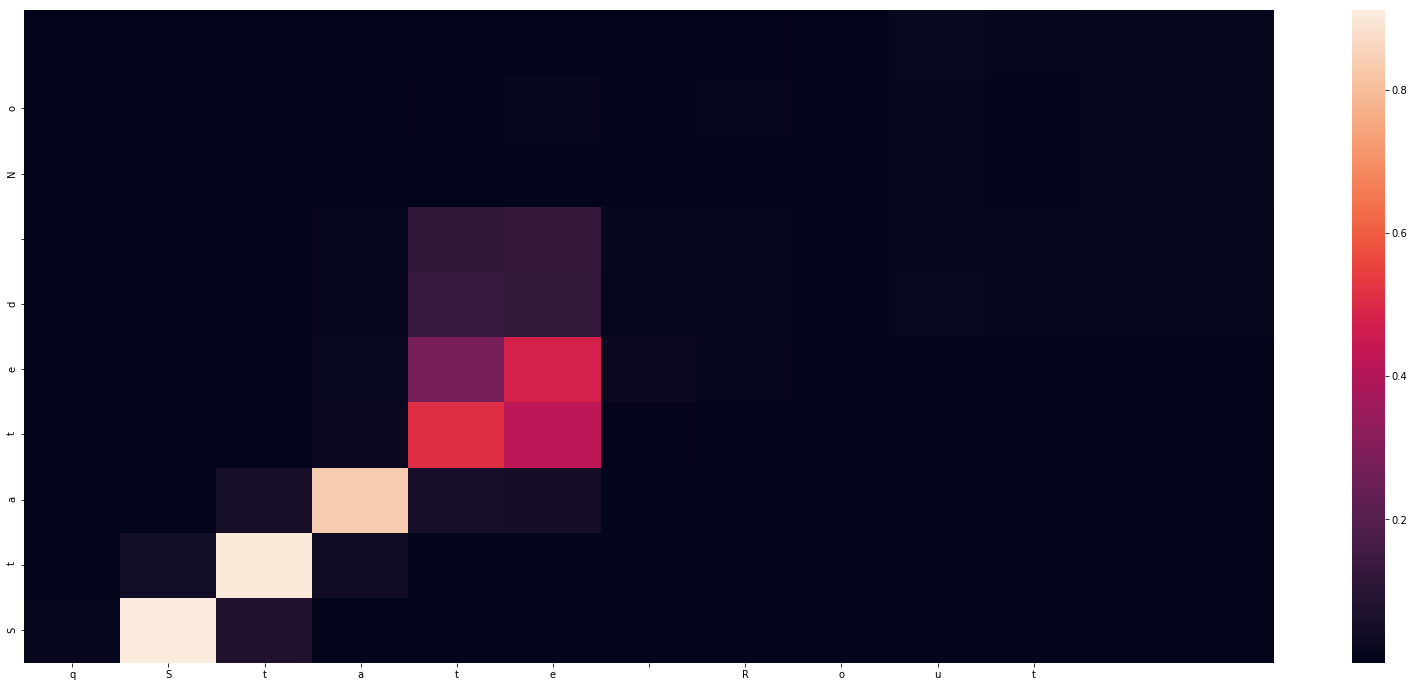

-
Input sentence: qState Rout
GT sentence: State Route

Decoded sentence: Stated No


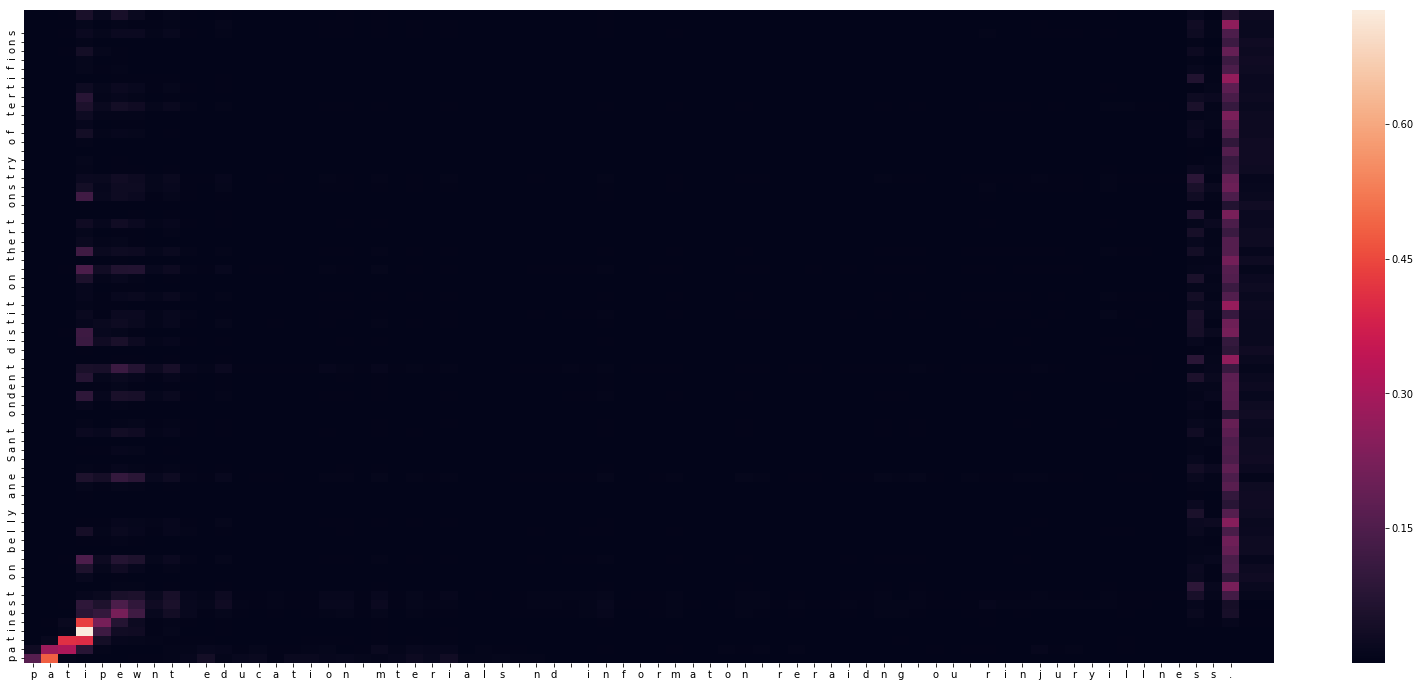

-
Input sentence: patipewnt education mterials nd informaton reraidng ou rinjuryillness.
GT sentence: patient education materials and information regarding your injury/illness.

Decoded sentence: patinest on belly ane Sant ondent distit on thert onstry of tertifions


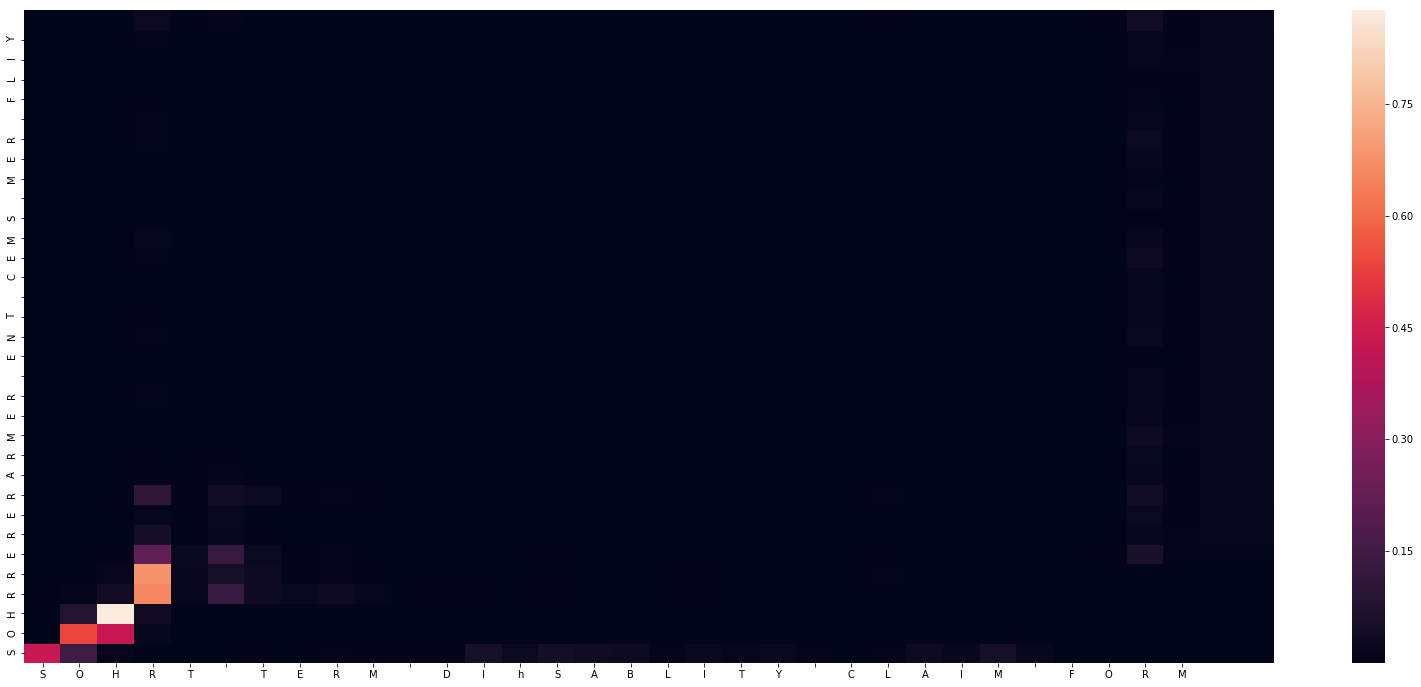

-
Input sentence: SOHRT TERM DIhSABLITY CLAIM FORM
GT sentence: SHORT TERM DISABILITY CLAIM FORM

Decoded sentence: SOHRRERERARMER ENT CEMS MER FLIY


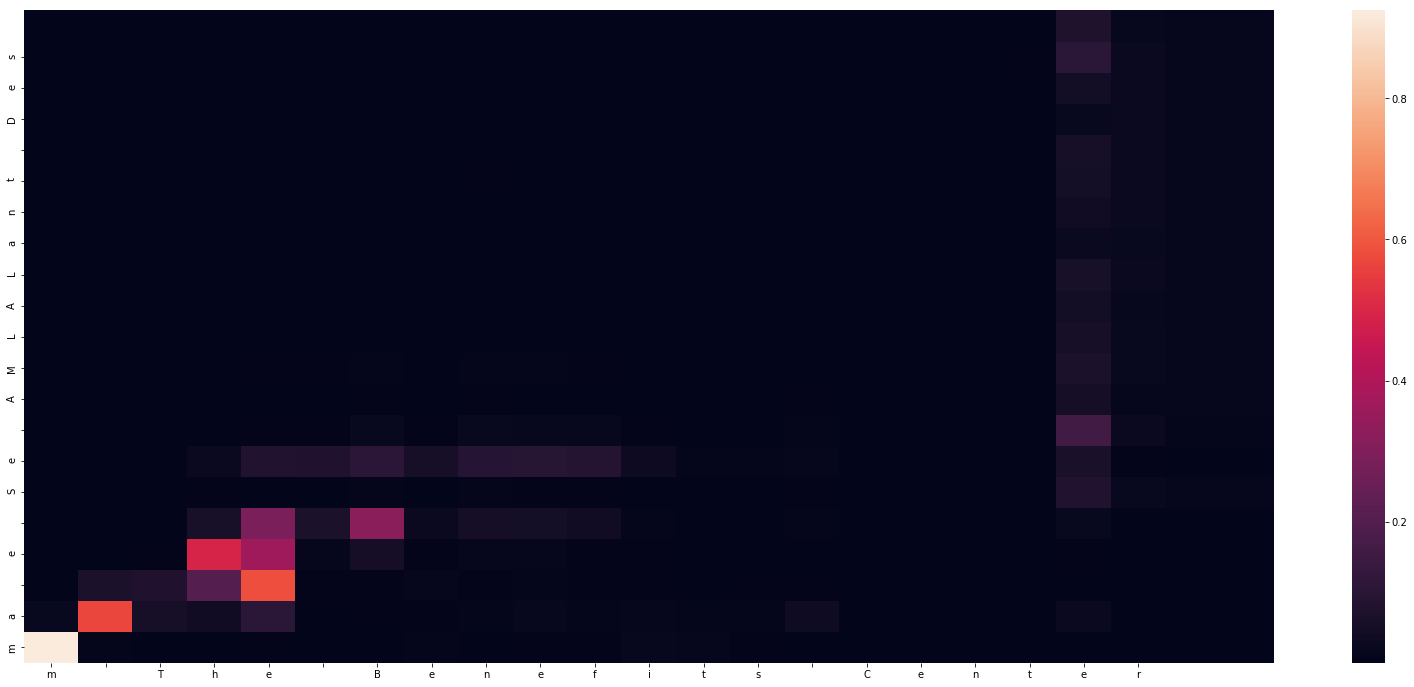

-
Input sentence: m The Benefits Center
GT sentence: The Benefits Center

Decoded sentence: ma e Se AMLALant Des


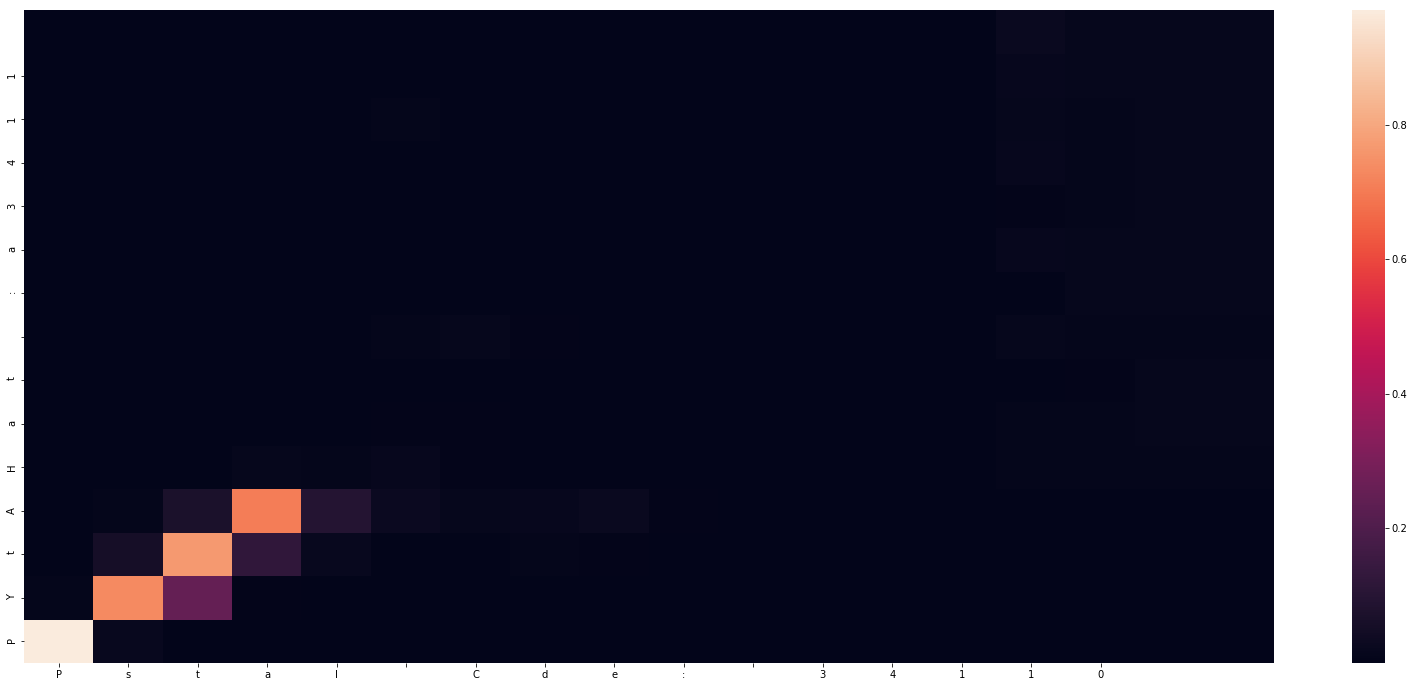

-
Input sentence: Pstal Cde: 34110
GT sentence: Postal Code: 34110

Decoded sentence: PYtAHat :a3411


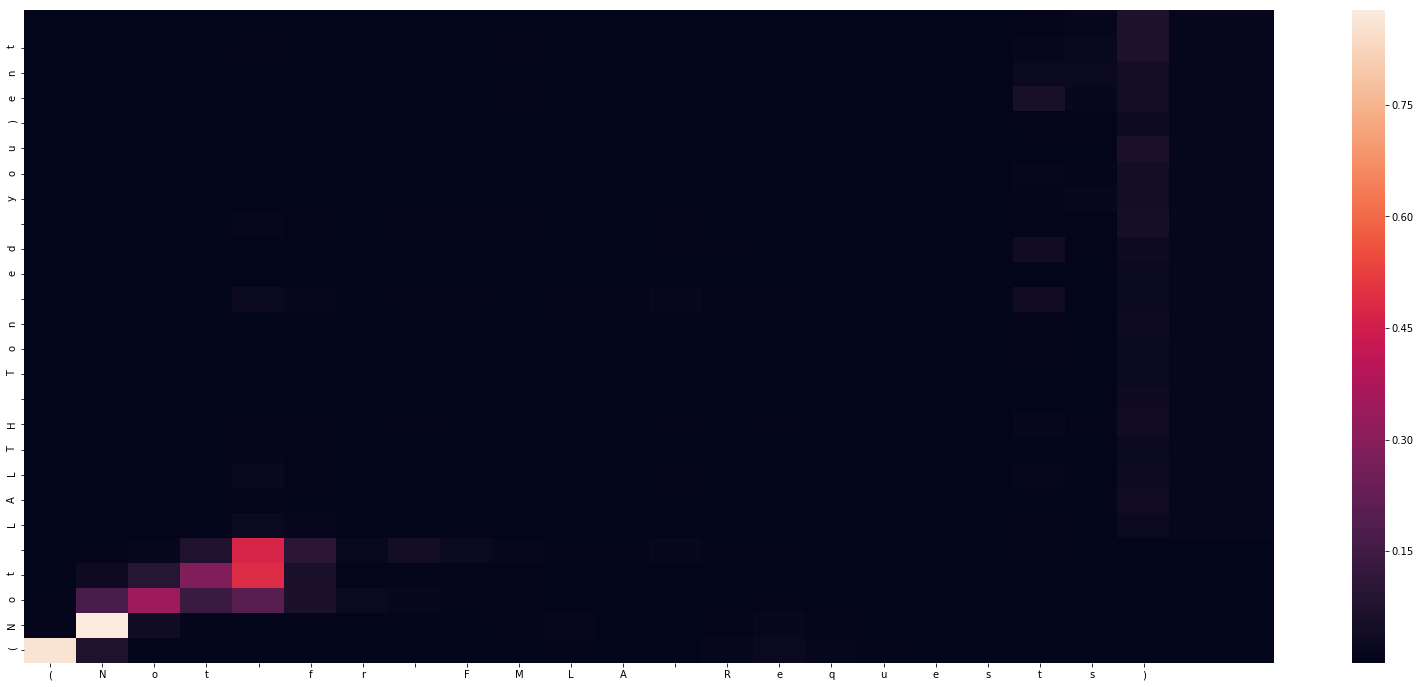

-
Input sentence: (Not fr FMLA Requests)
GT sentence: (Not for FMLA Requests)

Decoded sentence: (Not LALTH Ton ed you)ent


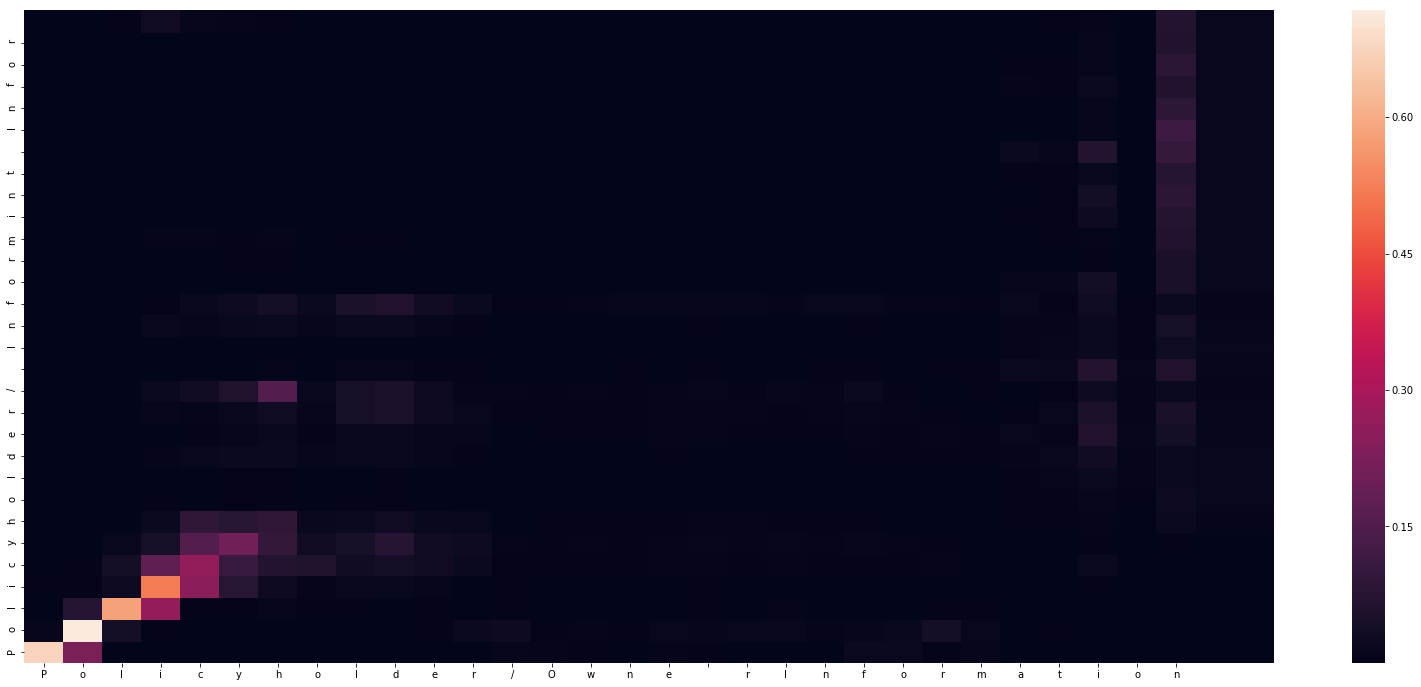

-
Input sentence: Policyholder/Owne rInformation
GT sentence: Policyholder/Owner Information

Decoded sentence: Policyholder/ Informint Infor


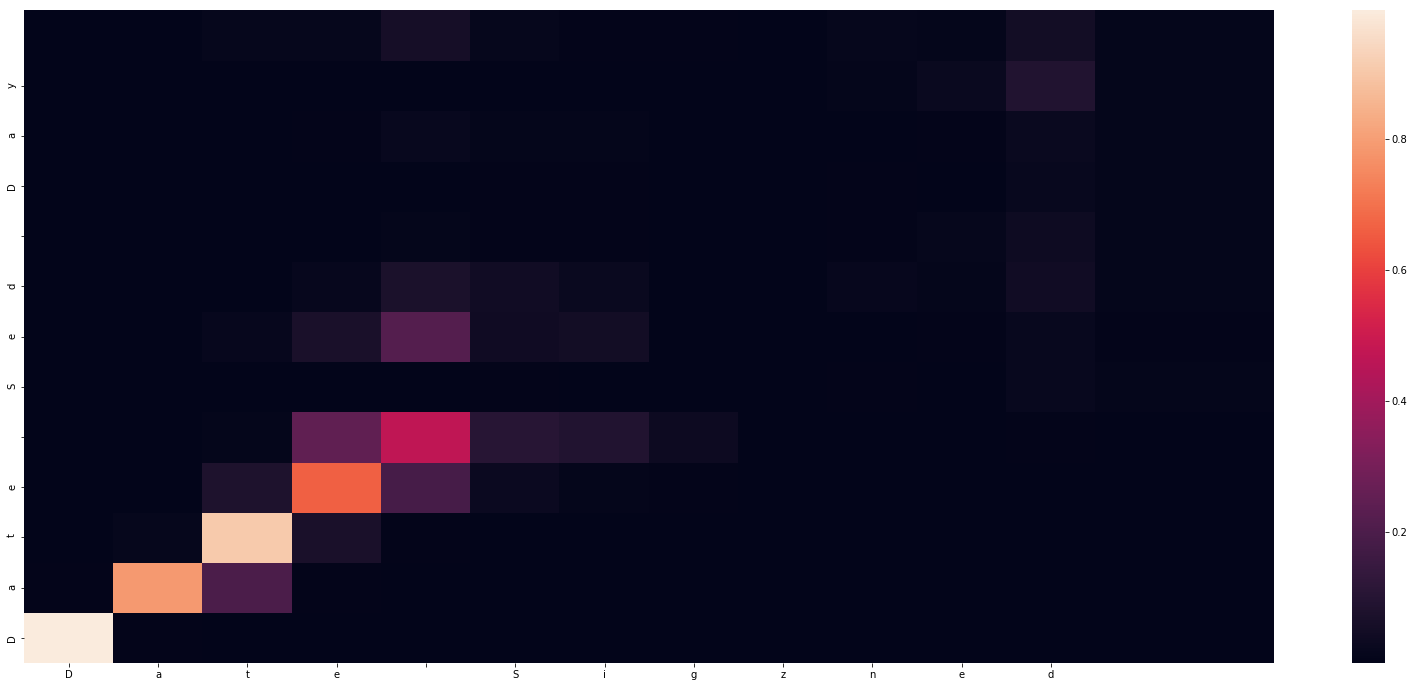

-
Input sentence: Date Sigzned
GT sentence: Date Signed

Decoded sentence: Date Sed Day


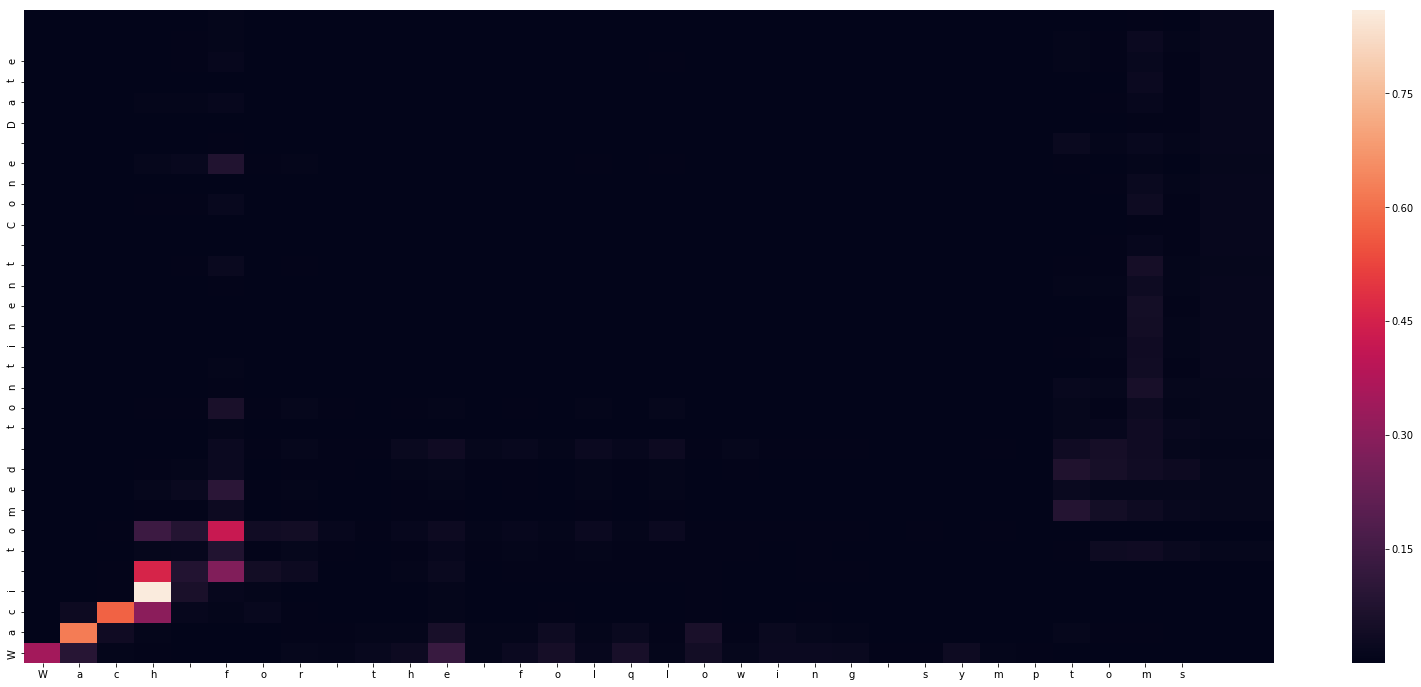

-
Input sentence: Wach for the folqlowing symptoms
GT sentence: Watch for the following symptoms

Decoded sentence: Waci tomed tontinent Cone Date


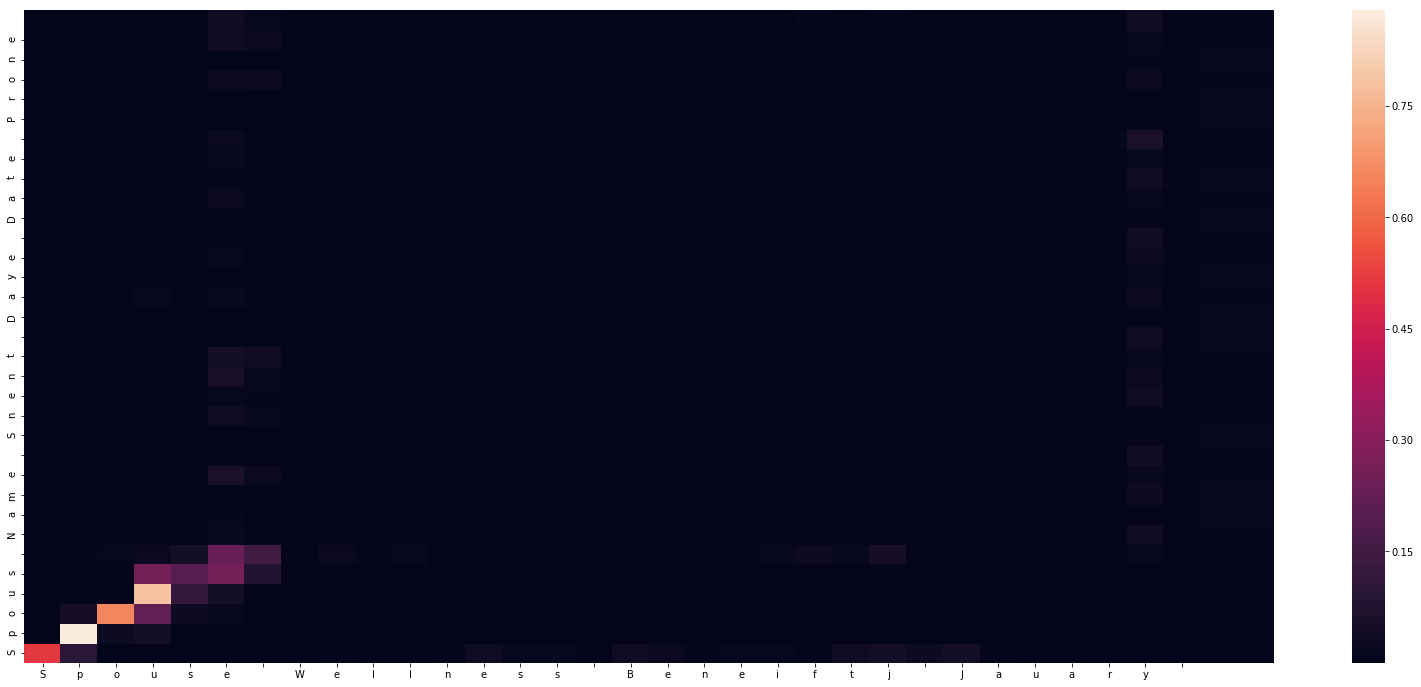

-
Input sentence: Spouse Wellness Beneiftj Jauary 
GT sentence: Spouse Wellness Benefit January 

Decoded sentence: Spous Name Snent Daye Date Prone


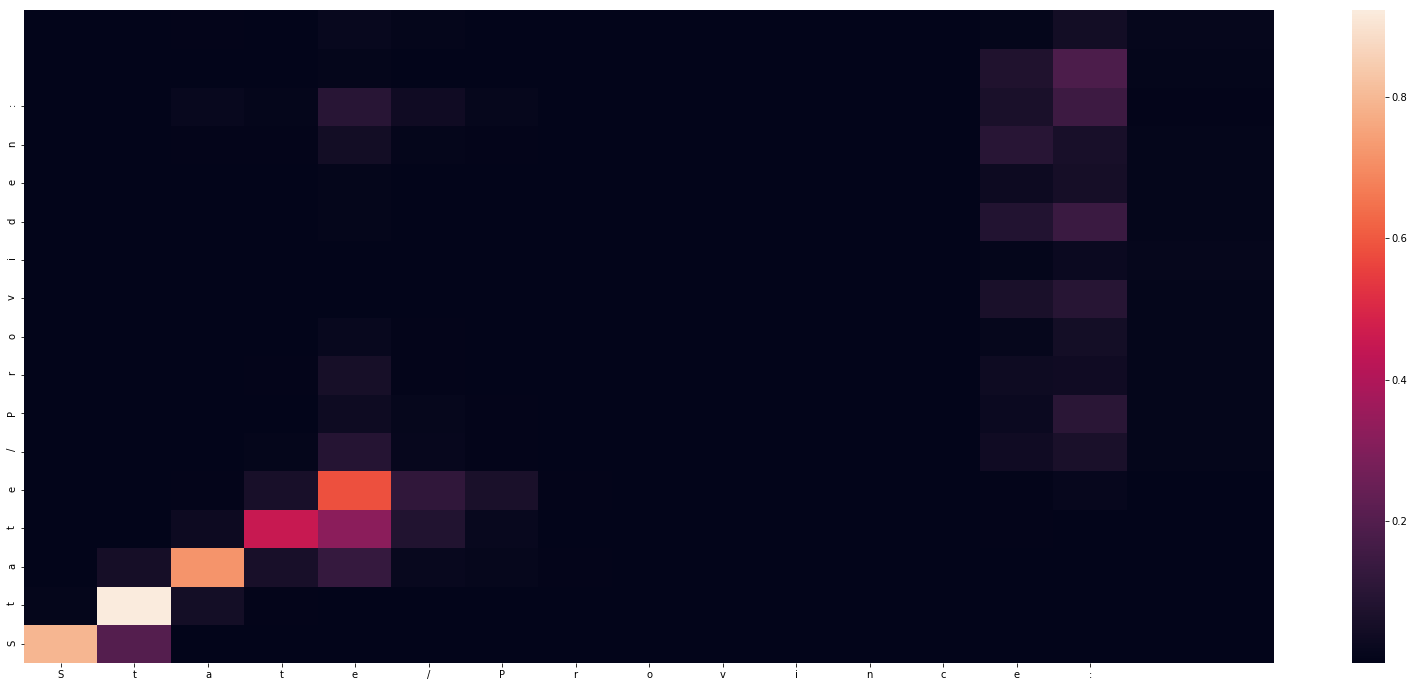

-
Input sentence: State/Province:
GT sentence: State/Province:

Decoded sentence: State/Providen:


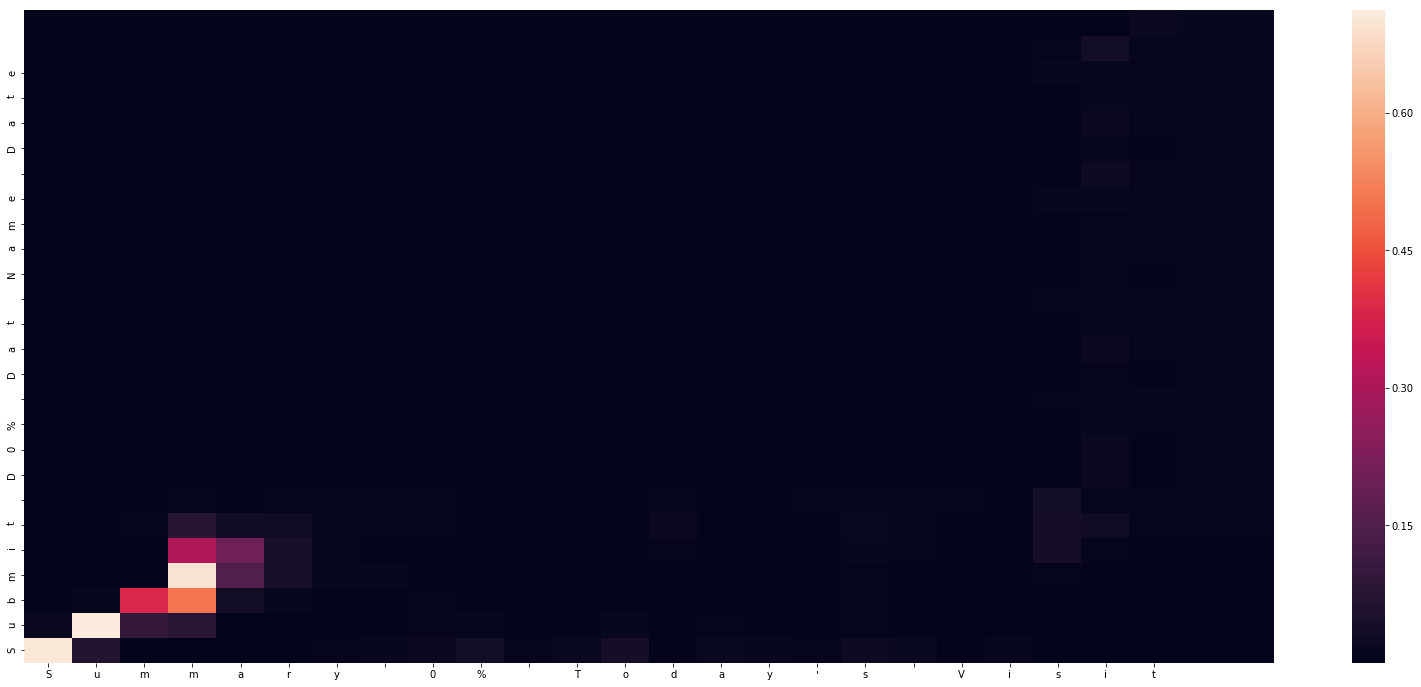

-
Input sentence: Summary 0% Today's Visit
GT sentence: Summary Of Today’s Visit

Decoded sentence: Submit D0% Dat Name Date


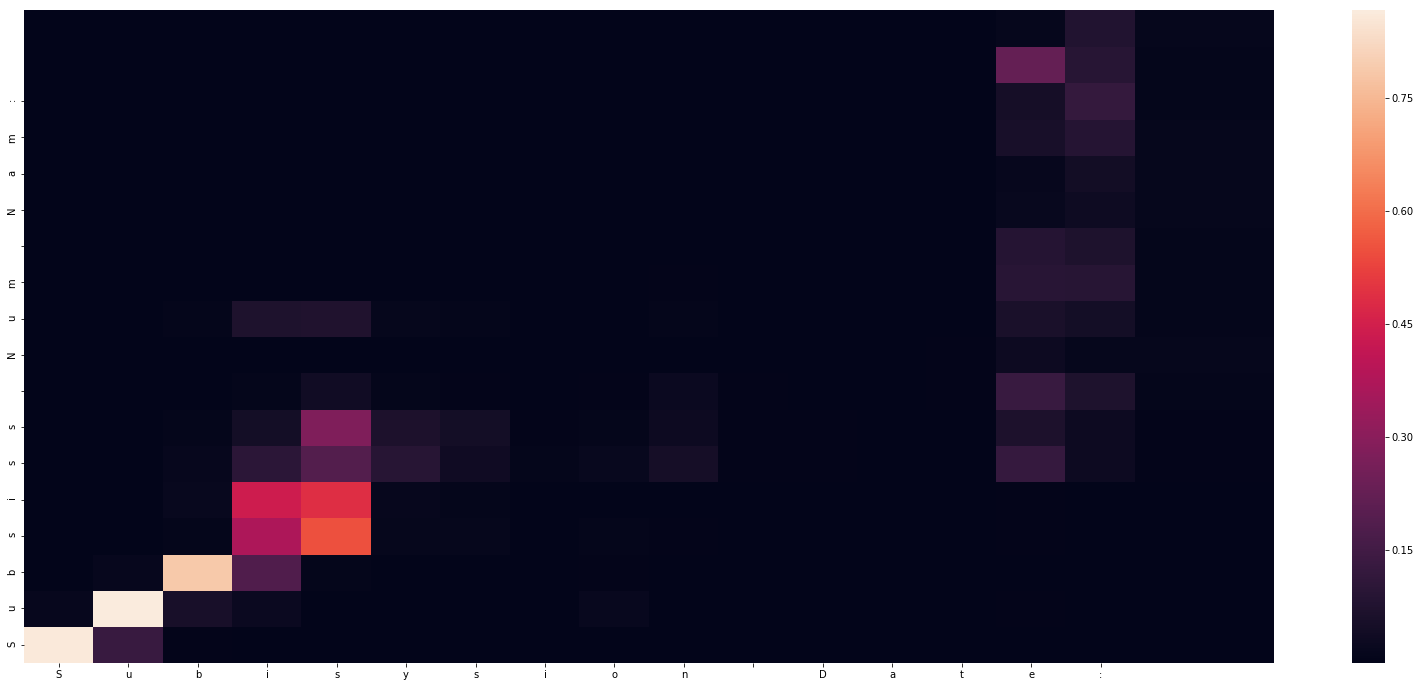

-
Input sentence: Subisysion Date:
GT sentence: Submission Date:

Decoded sentence: Subsiss Num Nam:


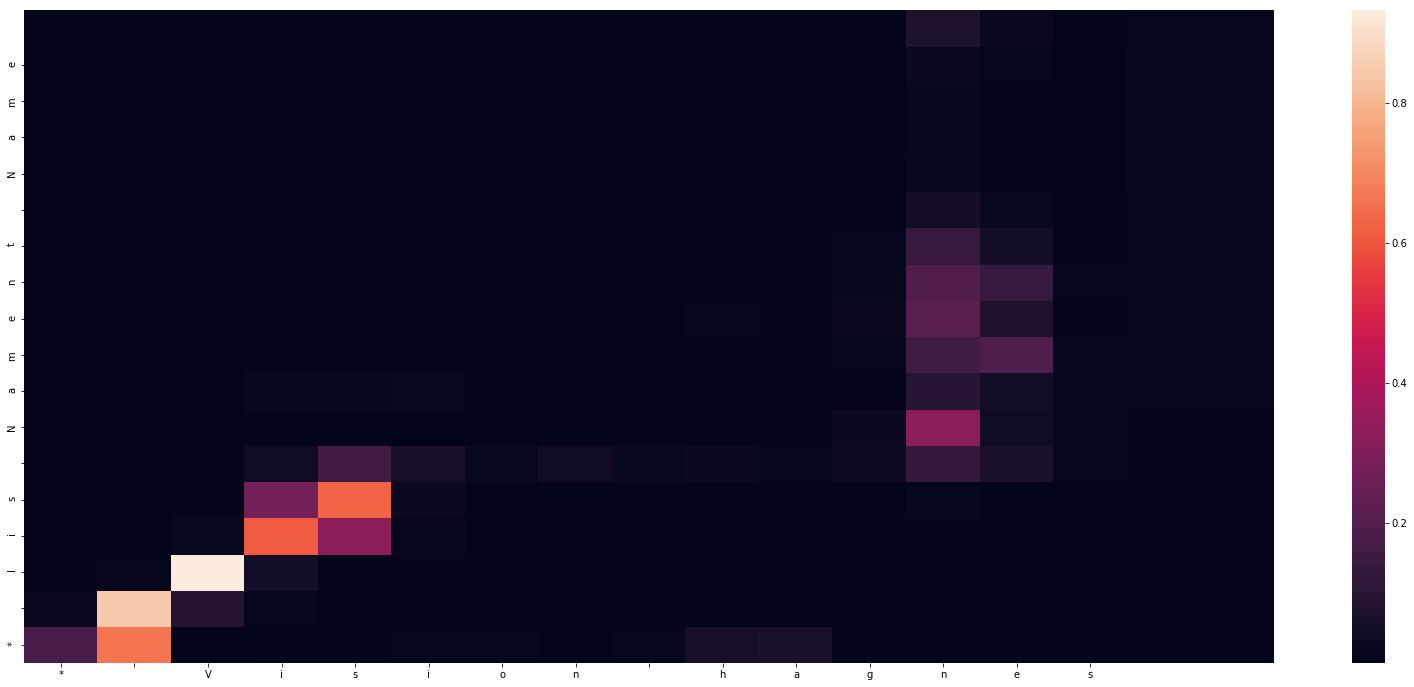

-
Input sentence: * Vision hagnes
GT sentence: * Vision changes

Decoded sentence: * Iis Nament Name


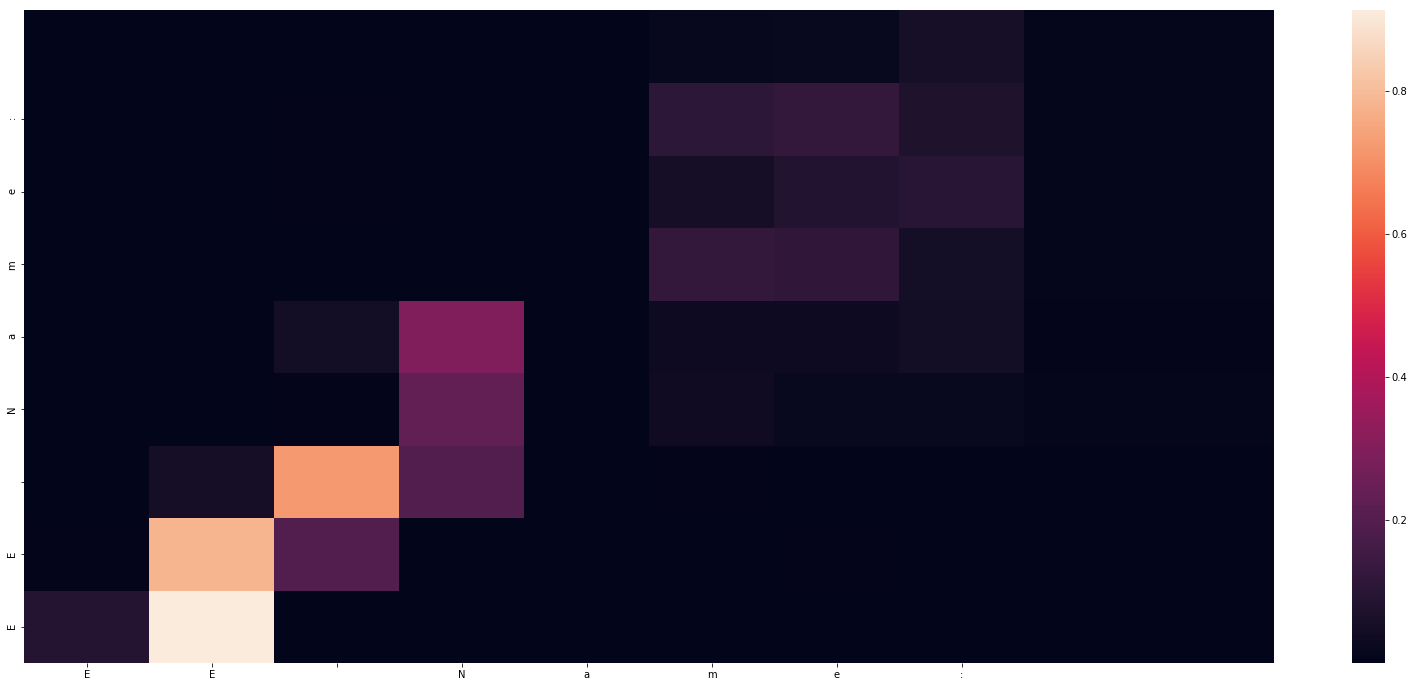

-
Input sentence: EE Name:
GT sentence: EE Name:

Decoded sentence: EE Name:


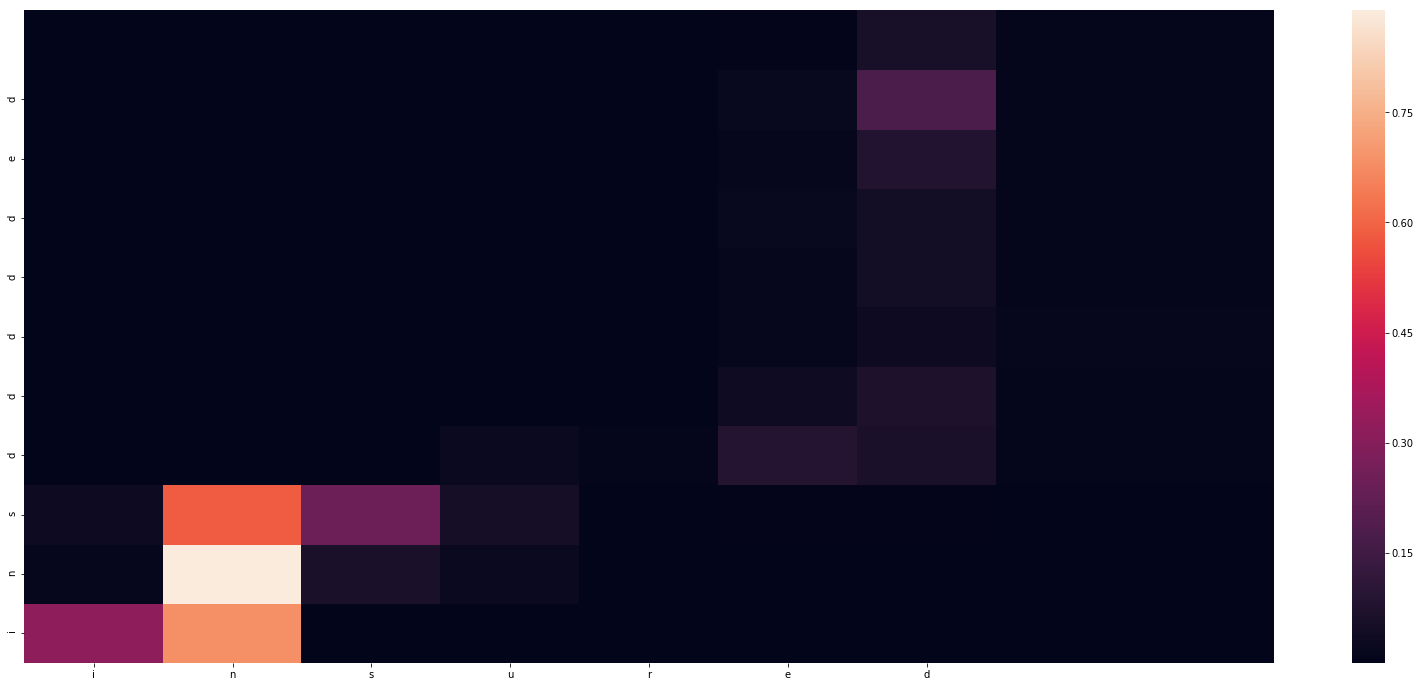

-
Input sentence: insured
GT sentence: INSURED:

Decoded sentence: insddddded


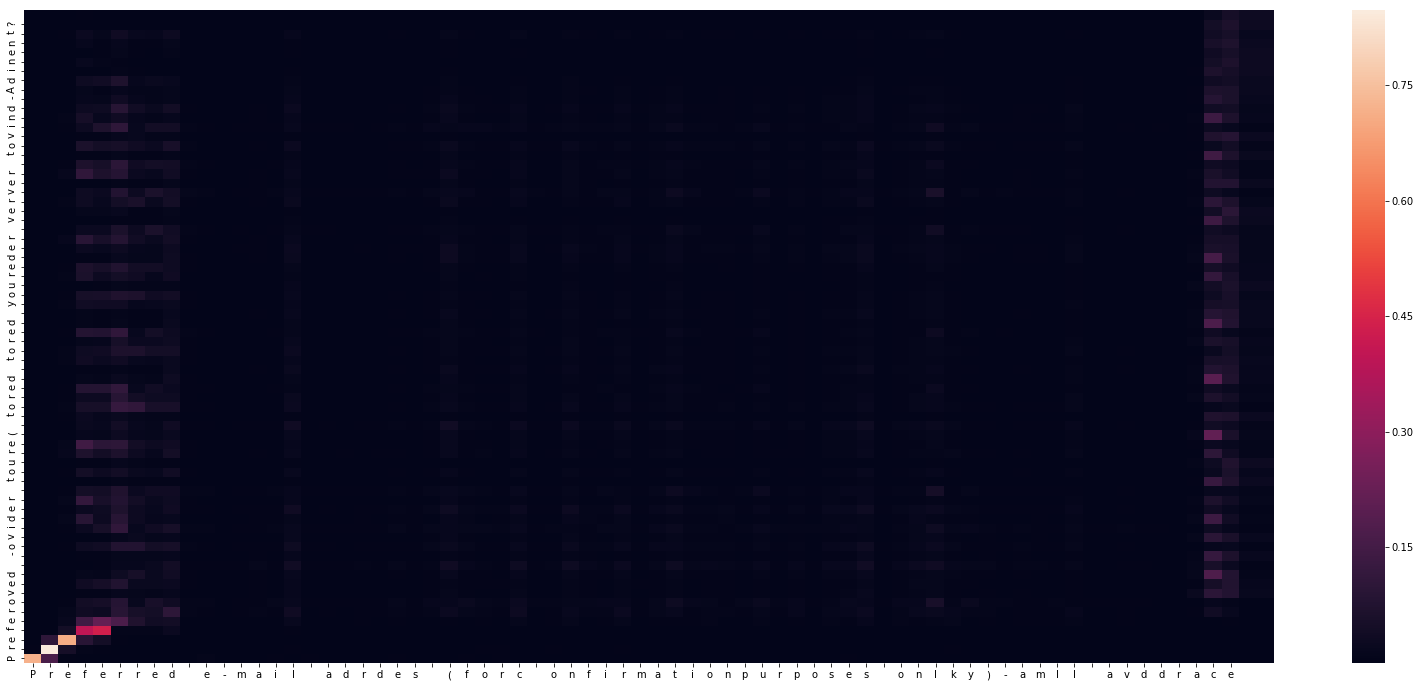

-
Input sentence: Preferred e-mail adrdes (forc onfirmationpurposes onlky)-amll avddrace
GT sentence: Preferred e-mail address (for confirmation purposes only)-mall addrace

Decoded sentence: Preferoved -ovider toure( tored tored youreder verver tovind-Adinent?


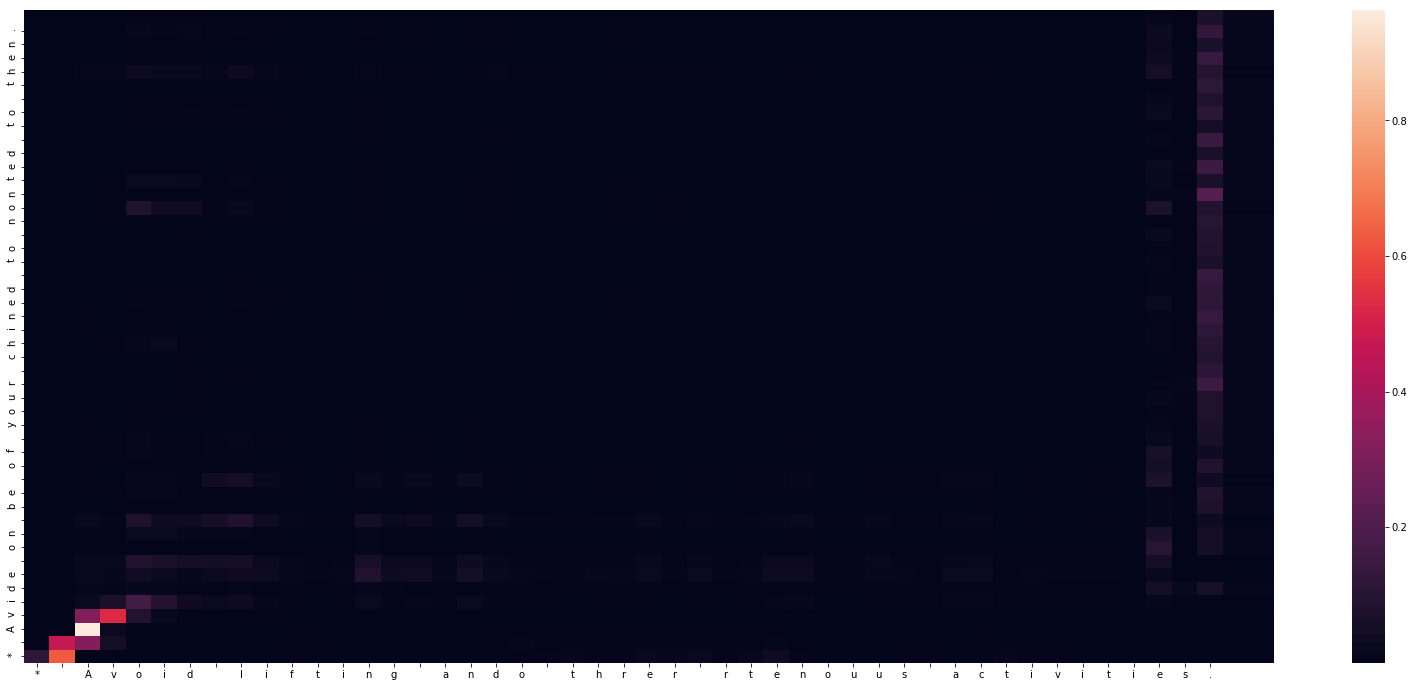

-
Input sentence: * Avoid lifting ando threr rtenouus activities.
GT sentence: * Avoid lifting and other strenuous activities.

Decoded sentence: * Avide on be of your chined to nonted to then.


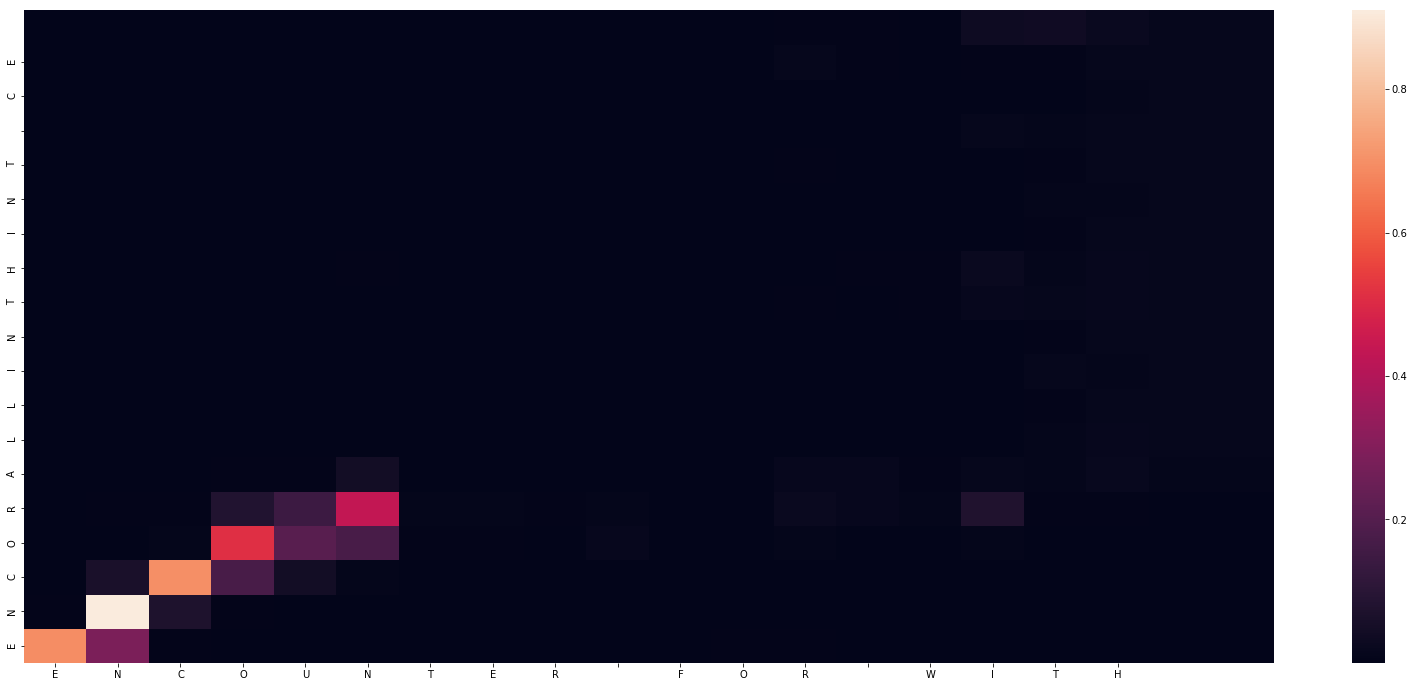

-
Input sentence: ENCOUNTER FOR WlTH
GT sentence: ENCOUNTER FOR WITH

Decoded sentence: ENCORALLINTHINT CE


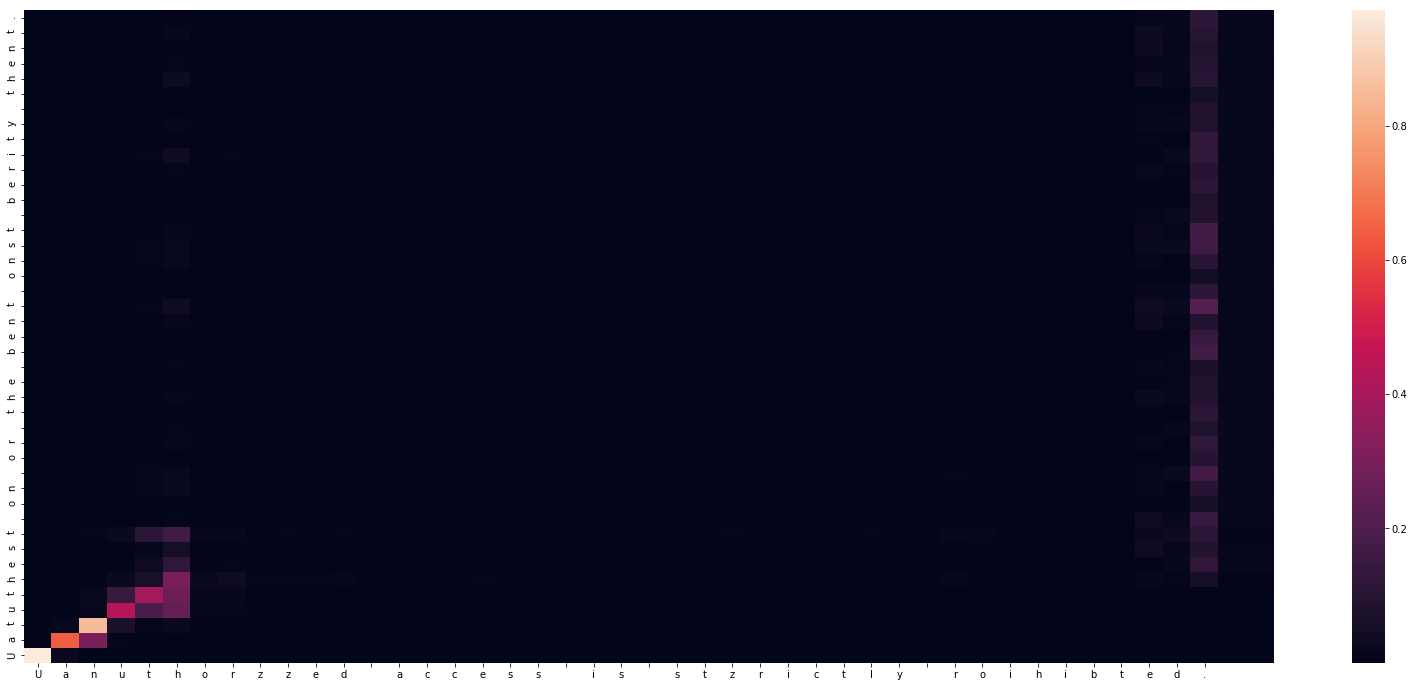

-
Input sentence: Uanuthorzzed access is stzrictly roihibted.
GT sentence: Unauthorized access is strictly prohibited.

Decoded sentence: Uatuthest on or the bent onst berity thent.


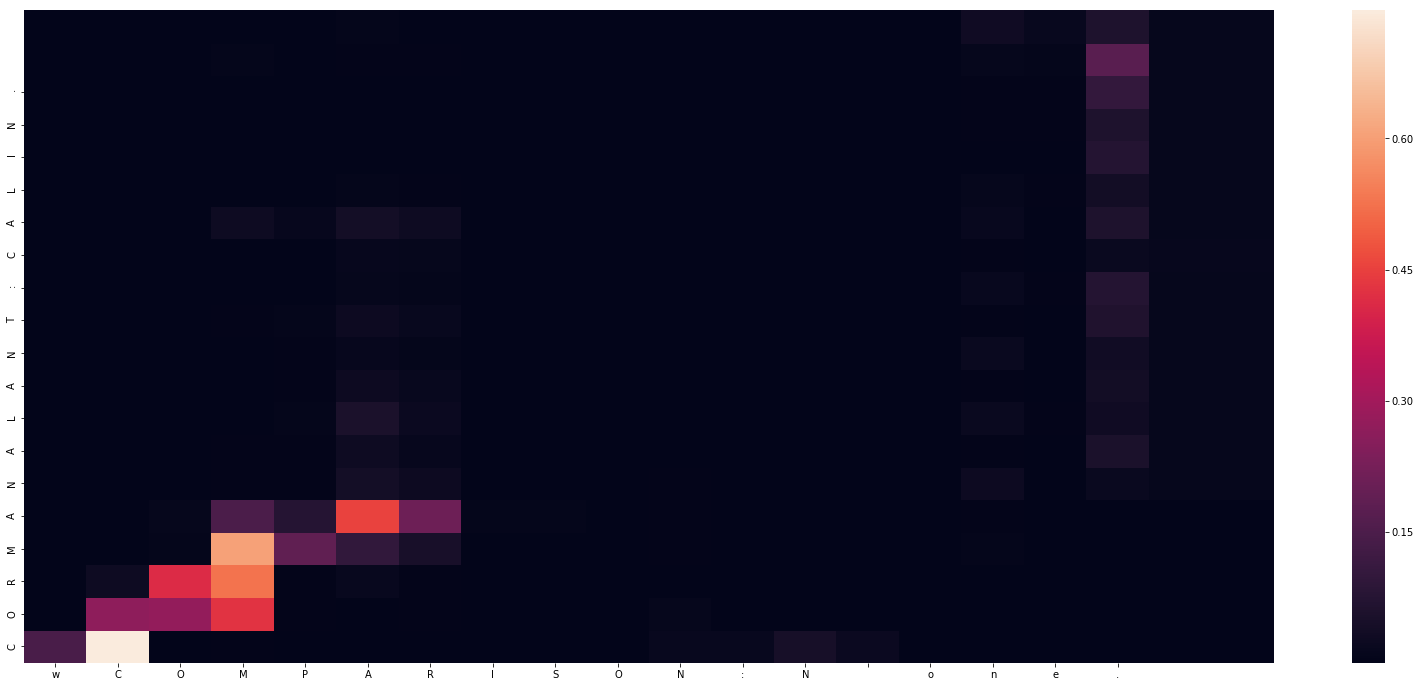

-
Input sentence: wCOMPARISON:N one.
GT sentence: COMPARISON: None.

Decoded sentence: CORMANALANT:CALIN.


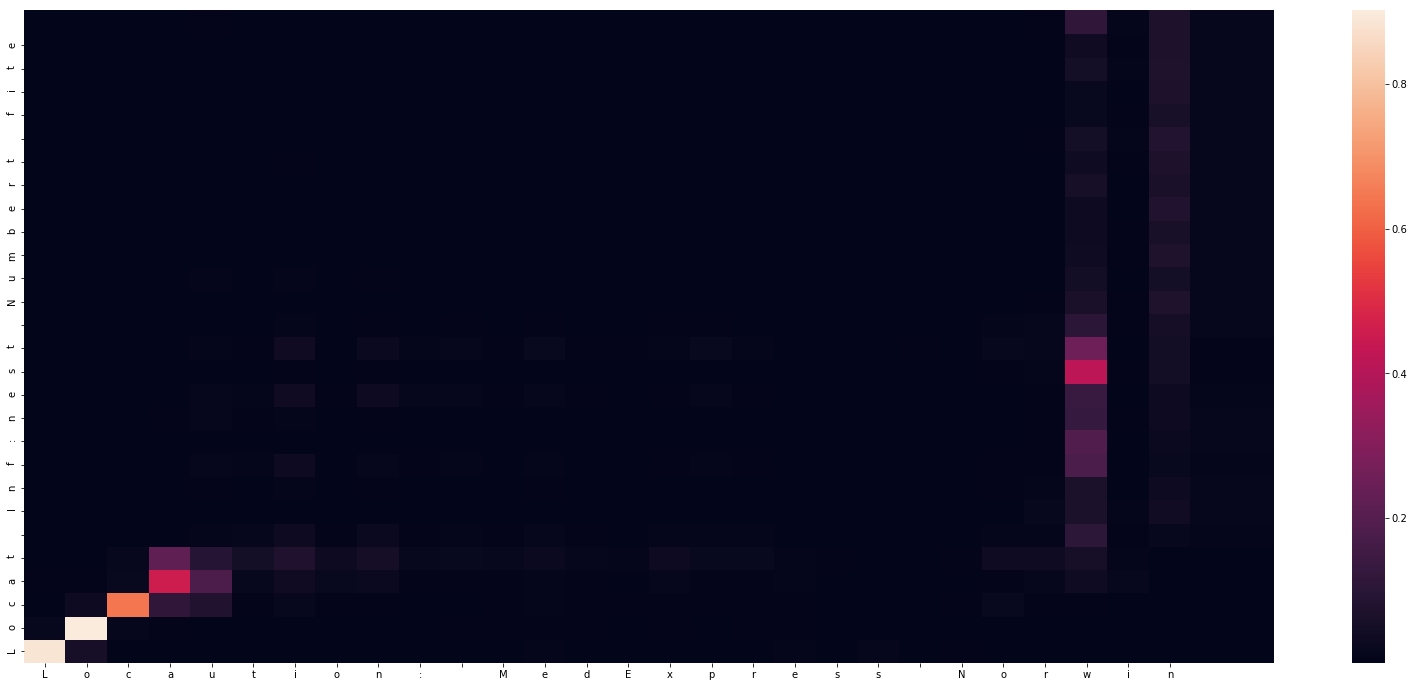

-
Input sentence: Locaution: MedExpress Norwin
GT sentence: Location: MedExpress Norwin

Decoded sentence: Locat Inf:nest Numbert fite


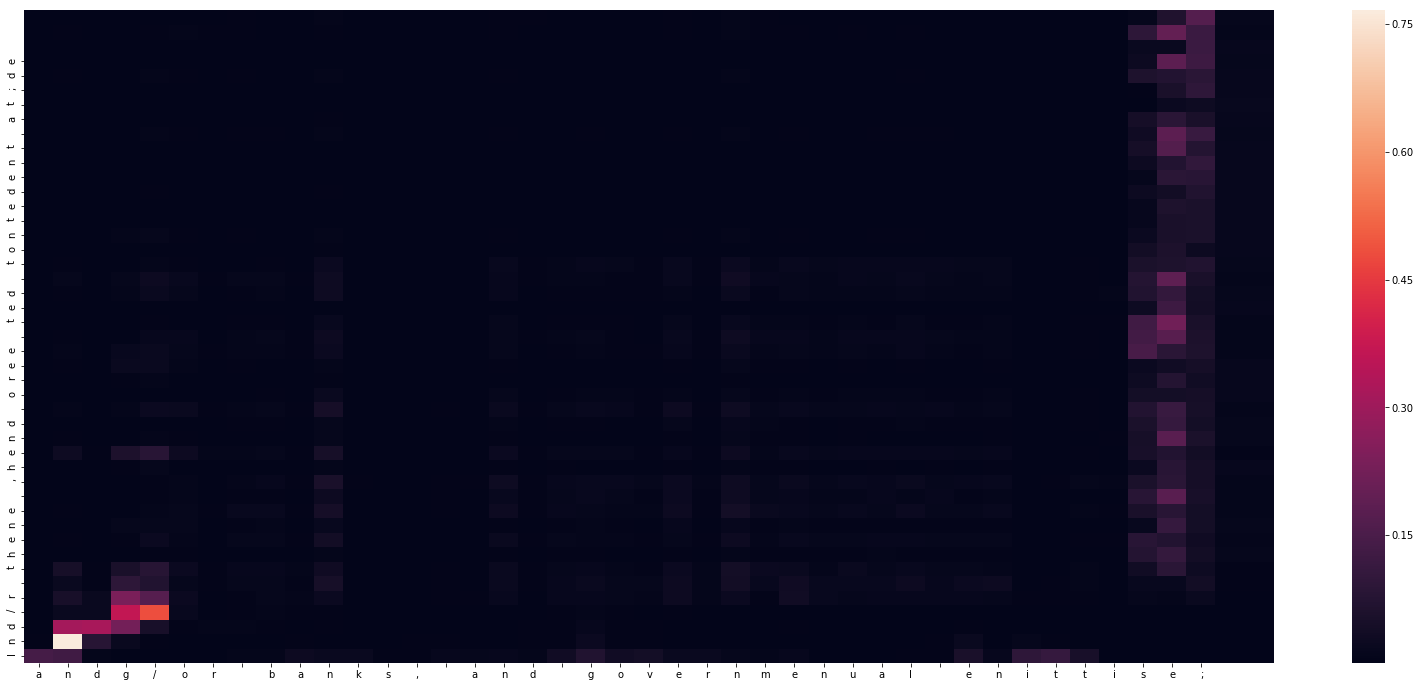

-
Input sentence: andg/or banks, and governmenual enittise;
GT sentence: and/or banks, and governmental entities;

Decoded sentence: Ind/r thene ,hend oree ted tontedent at;de


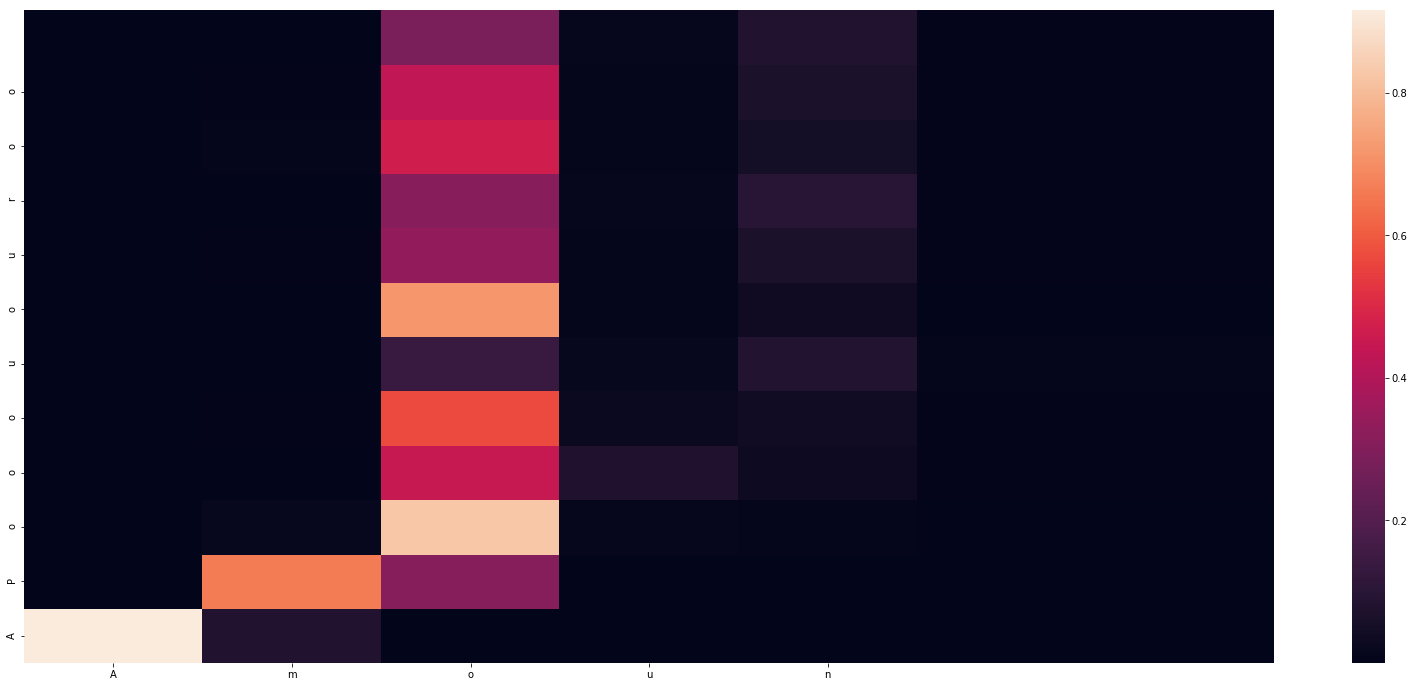

-
Input sentence: Amoun
GT sentence: Amount

Decoded sentence: APooououroo


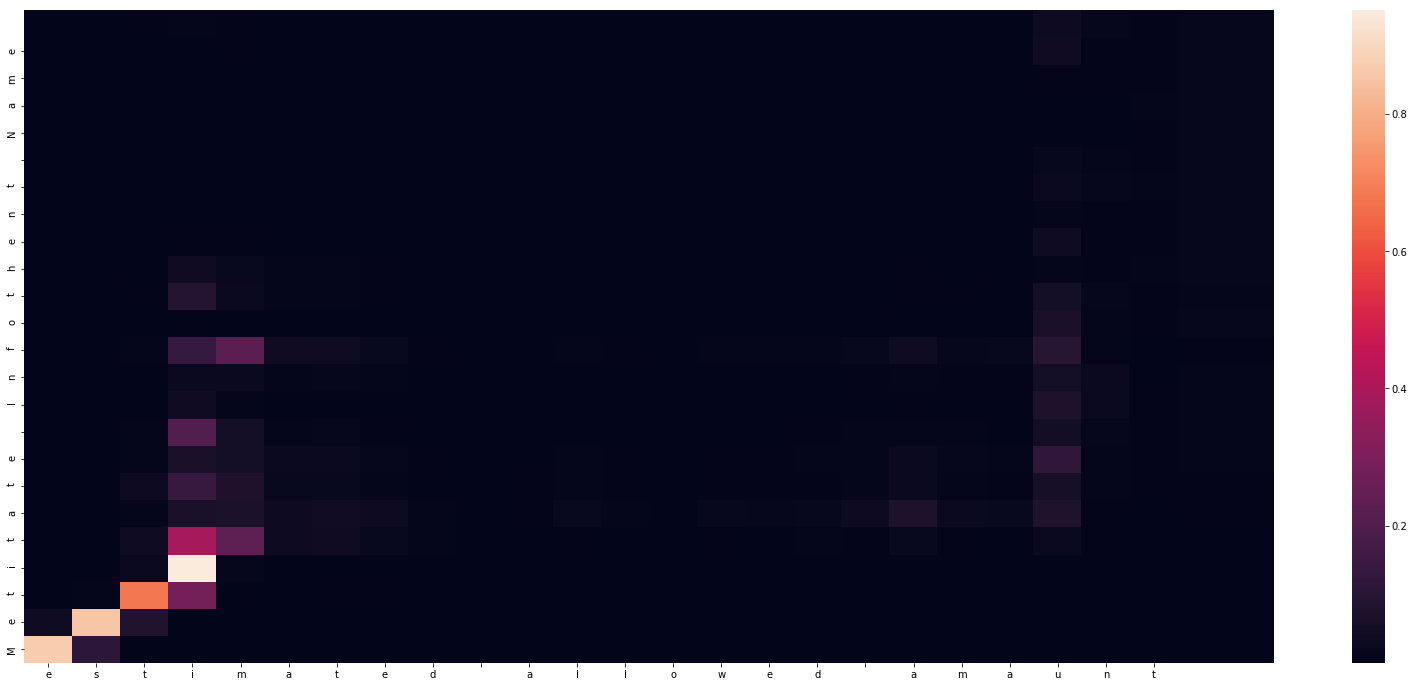

-
Input sentence: estimated allowed amaunt
GT sentence: Estimated Allowed Amount

Decoded sentence: Metitate Infothent Name


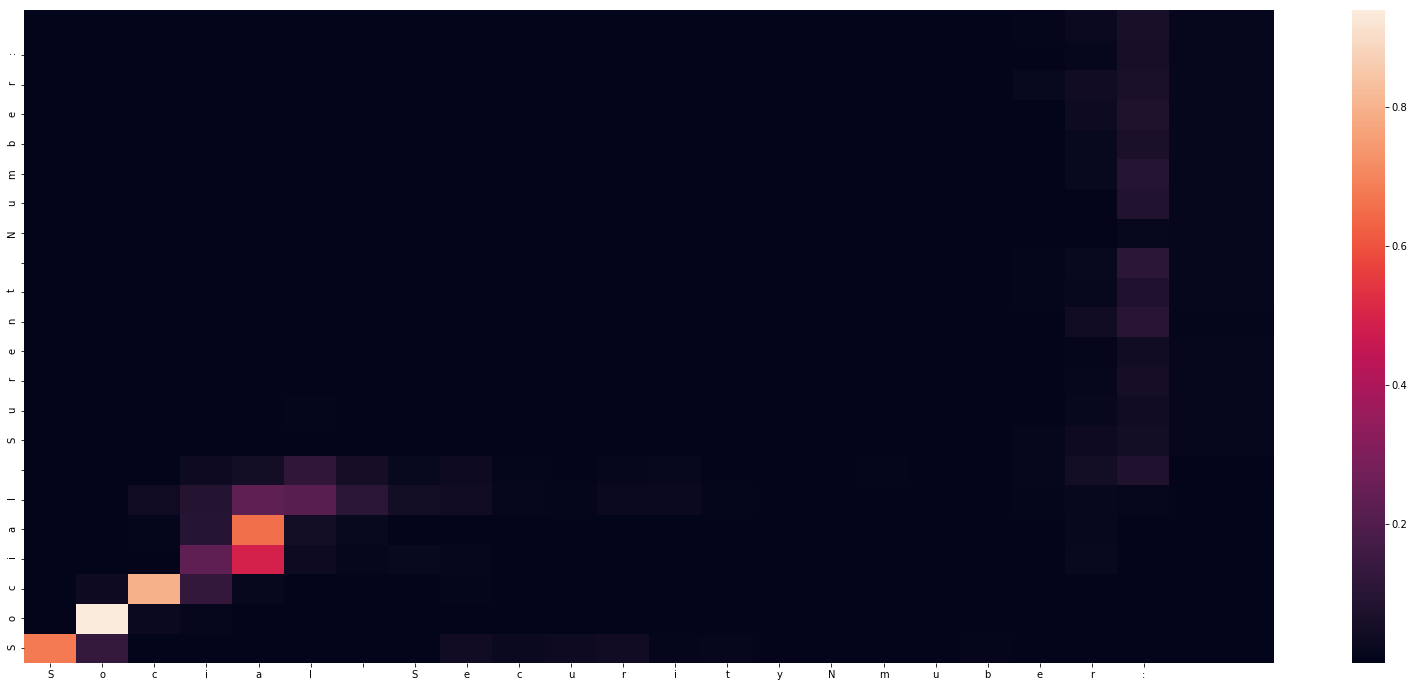

-
Input sentence: Social SecurityNmuber:
GT sentence: Social Security Number:

Decoded sentence: Social Surent Number:


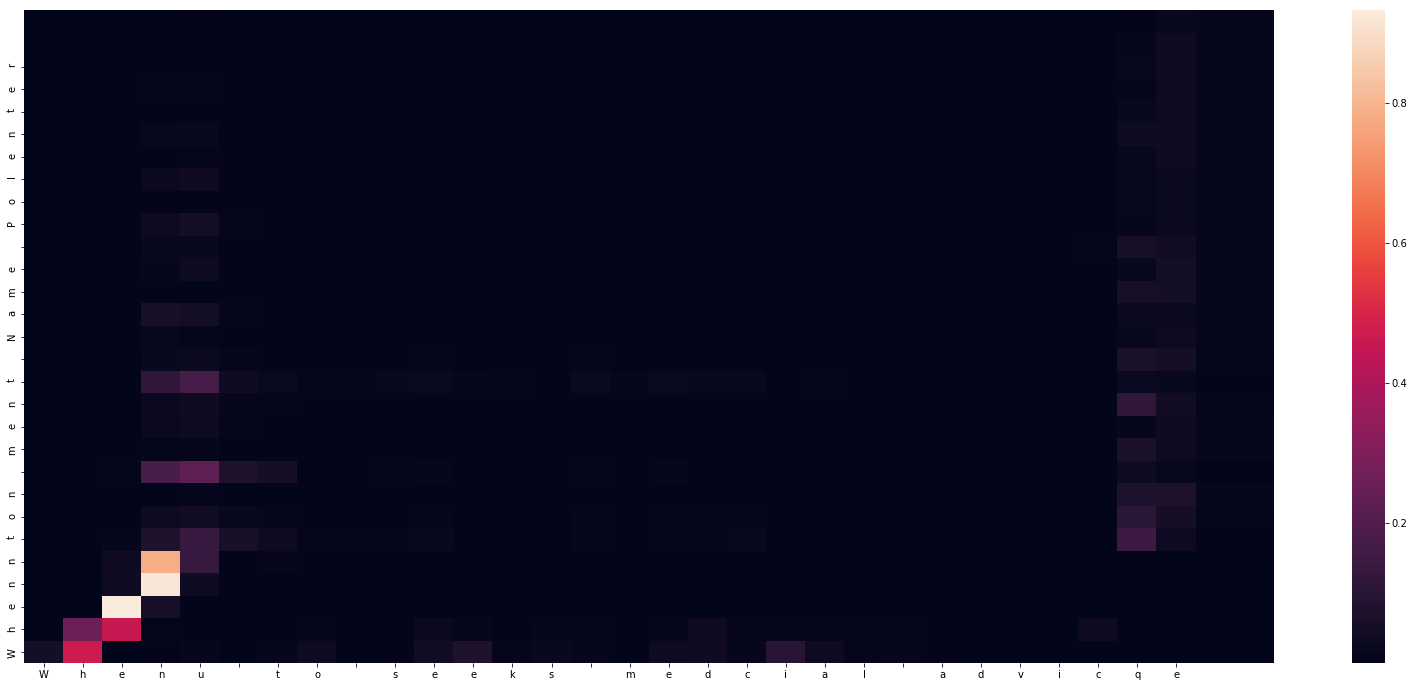

-
Input sentence: Whenu to seeks medcial advicqe
GT sentence: When to seek medical advice

Decoded sentence: Whennton ment Name Polenter


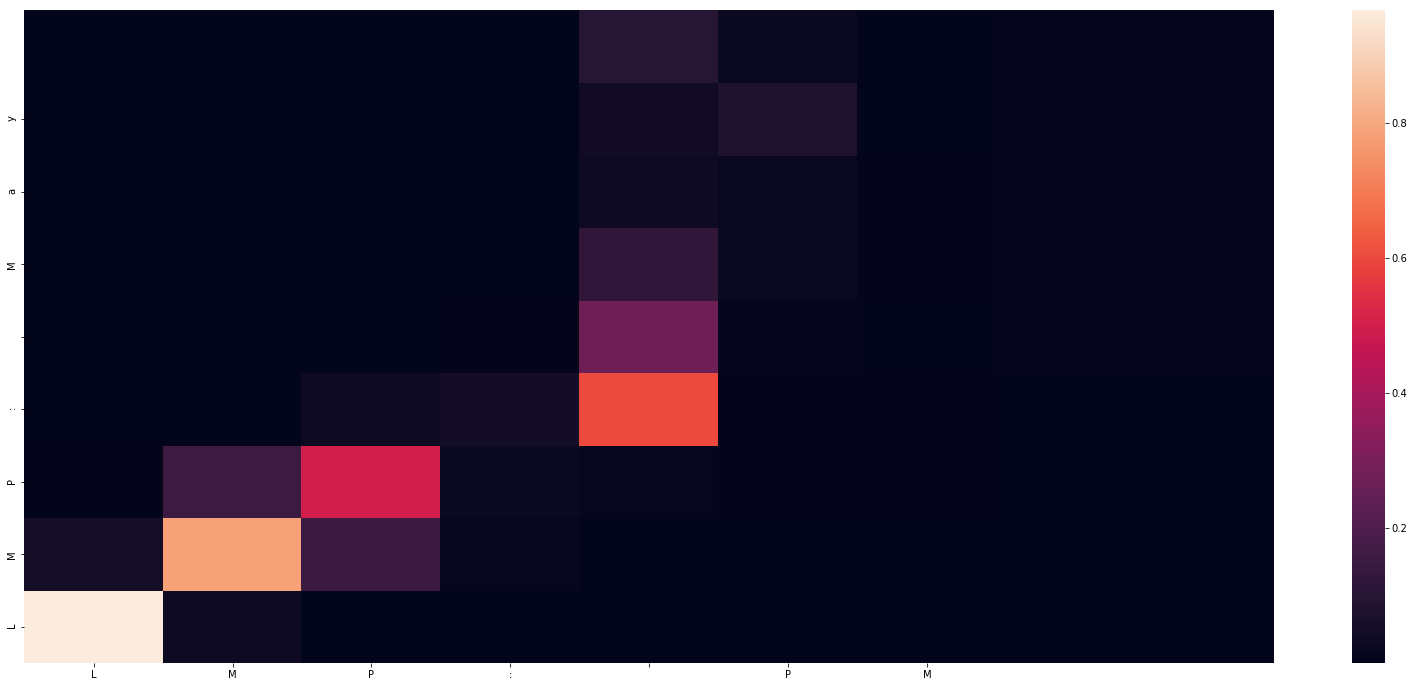

-
Input sentence: LMP: PM
GT sentence: LMP: PMP

Decoded sentence: LMP: May


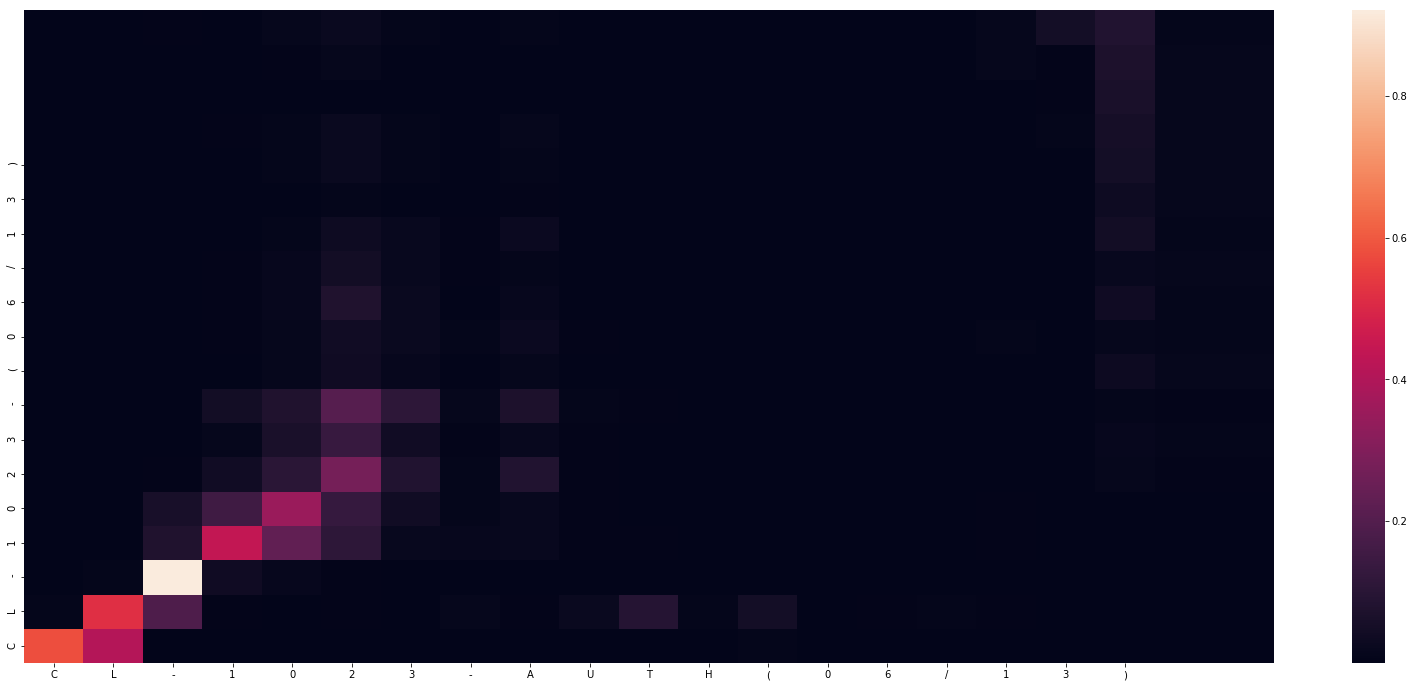

-
Input sentence: CL-1023-AUTH(06/13)
GT sentence: CL-1023-AUTH (06/13)

Decoded sentence: CL-1023-(06/13)


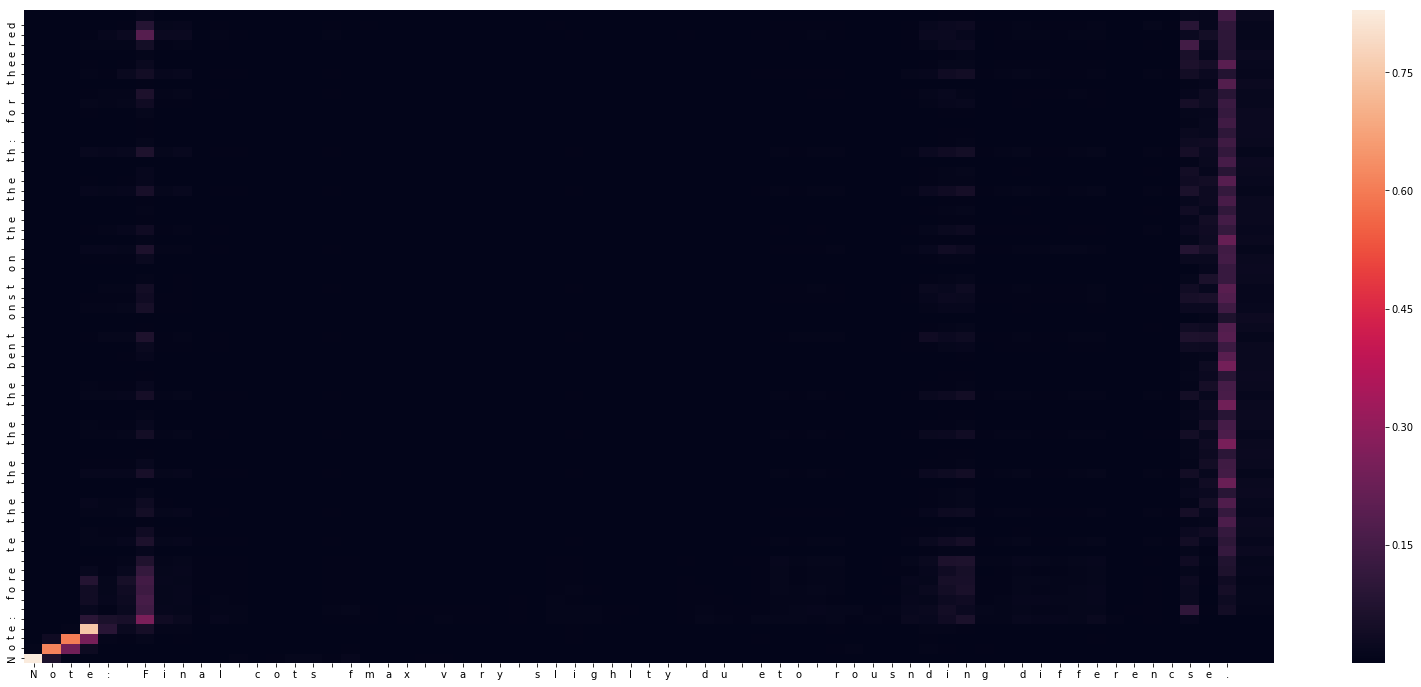

-
Input sentence: Note: Final cots fmax vary slighlty du eto rousnding differencse.
GT sentence: Note: Final cost may vary slightly due to rounding differences.

Decoded sentence: Note: fore te the the the the bent onst on the the th: for theered


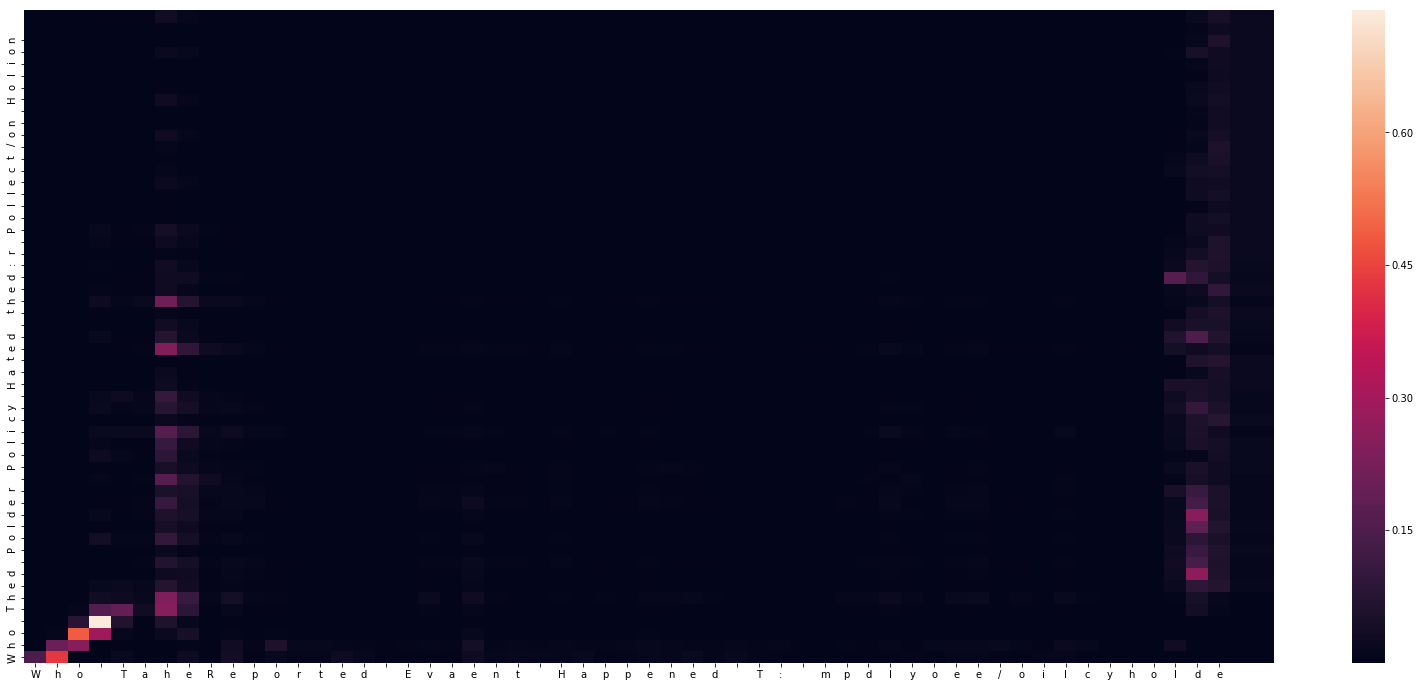

-
Input sentence: Who TaheReported Evaent Happened T: mpdlyoee/oilcyholde
GT sentence: Who The Reported Event Happened To: Employee/Policyholder

Decoded sentence: Who Thed Polder Policy Hated thed:r Pollect/on Holion


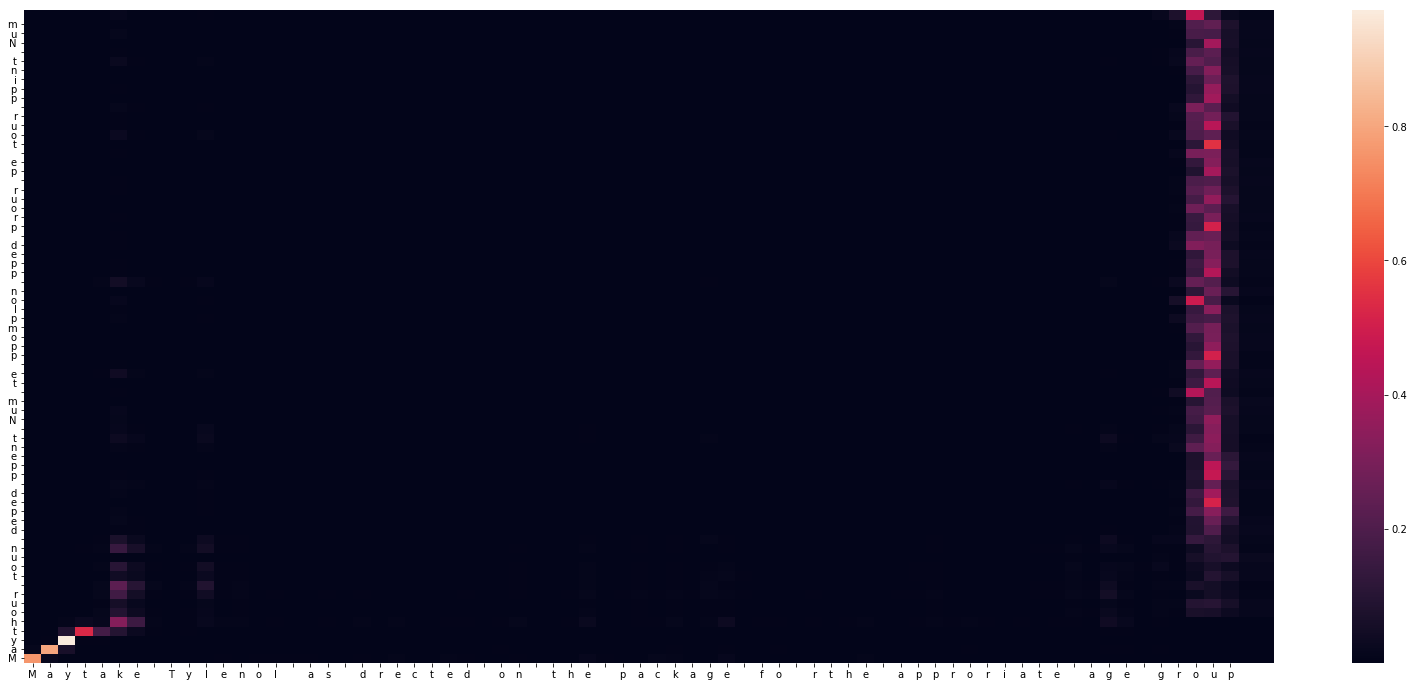

-
Input sentence: Maytake Tylenol as drected on the package fo rthe approriate age group
GT sentence: May take Tylenol as directed on the package for the appropriate age group

Decoded sentence: Maythour toun deped ppent Num te ppomplon pped prour pe tour ppint Num


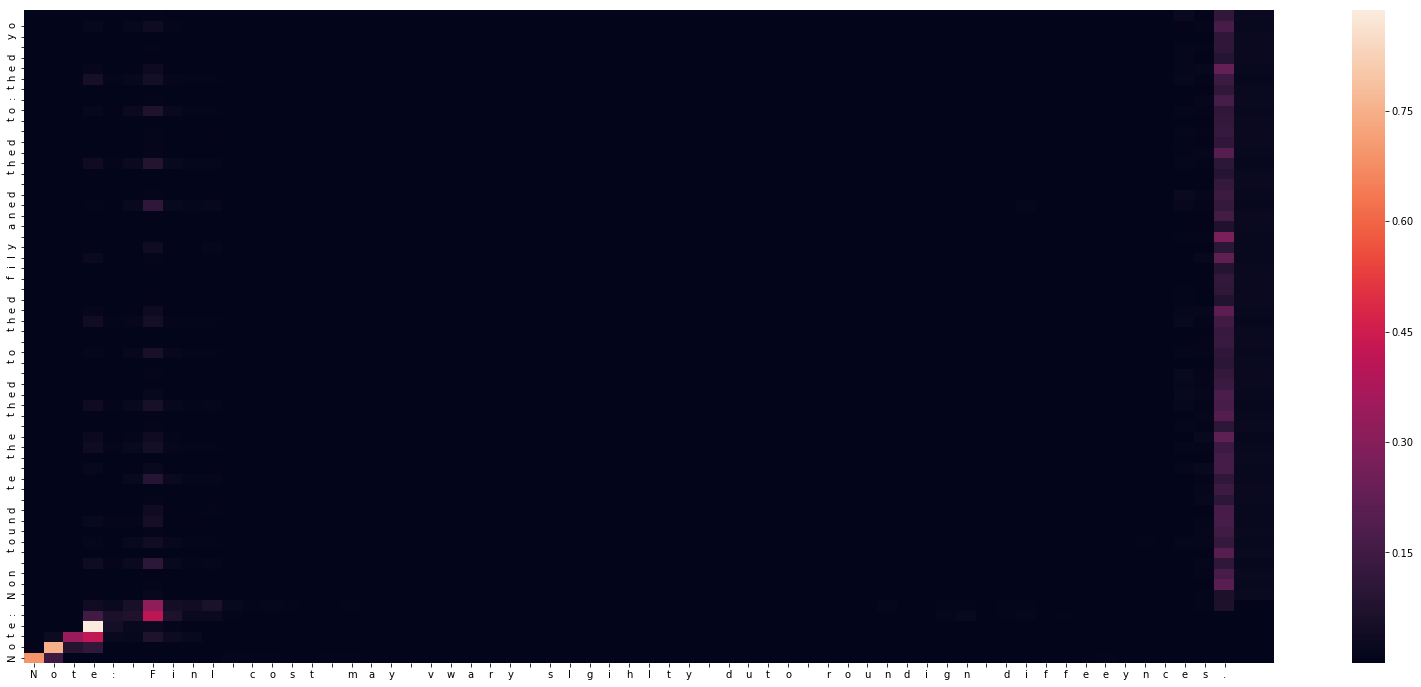

-
Input sentence: Note: Finl cost may vwary slgihlty duto roundign diffeeynces.
GT sentence: Note: Final cost may vary slightly due to rounding differences.

Decoded sentence: Note: Non tound te the thed to thed fily aned thed to:thed yo


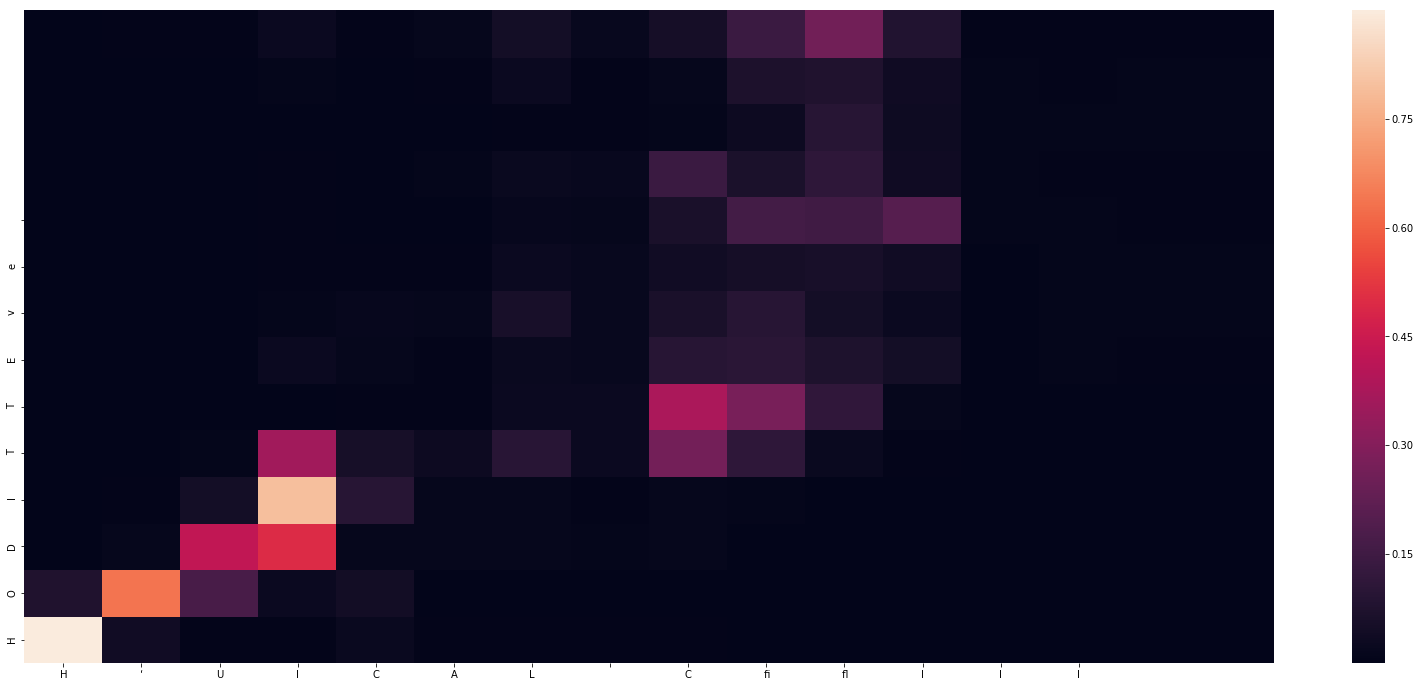

-
Input sentence: H‘UICAL Cﬁﬂlll
GT sentence: MEDICAL CENTER

Decoded sentence: HODITTEve 


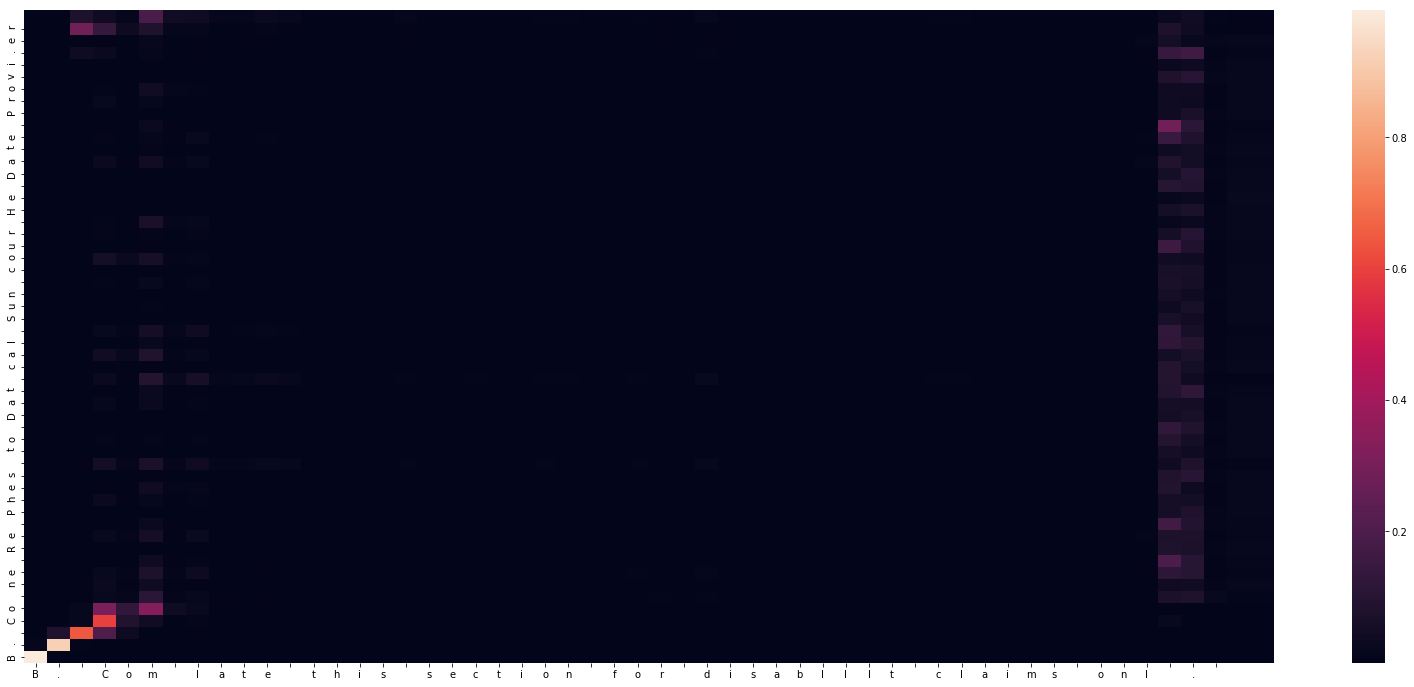

-
Input sentence: B. Com late this section for disablllt claims onl . 
GT sentence: B. Complete this section for disability claims only.

Decoded sentence: B. Co ne Re Phes to Dat cal Sun cour He Date Provi.er


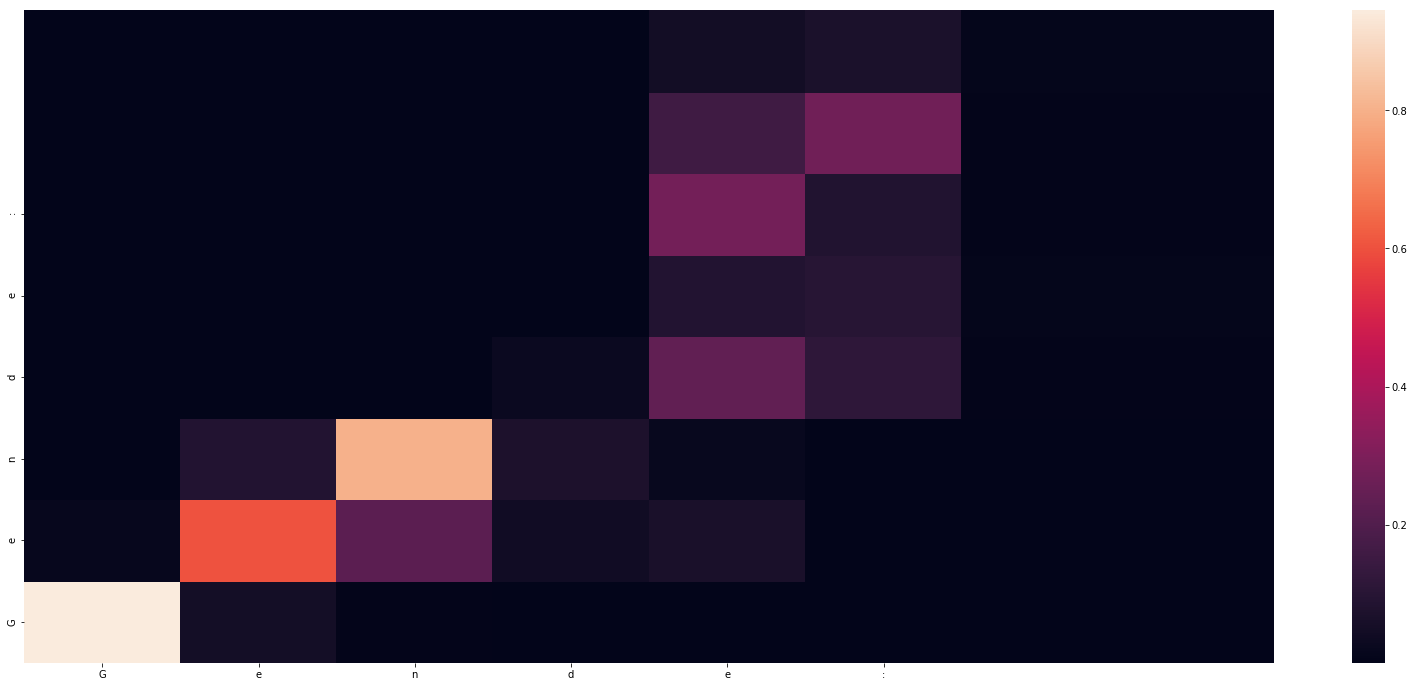

-
Input sentence: Gende:
GT sentence: Gender:

Decoded sentence: Gende:


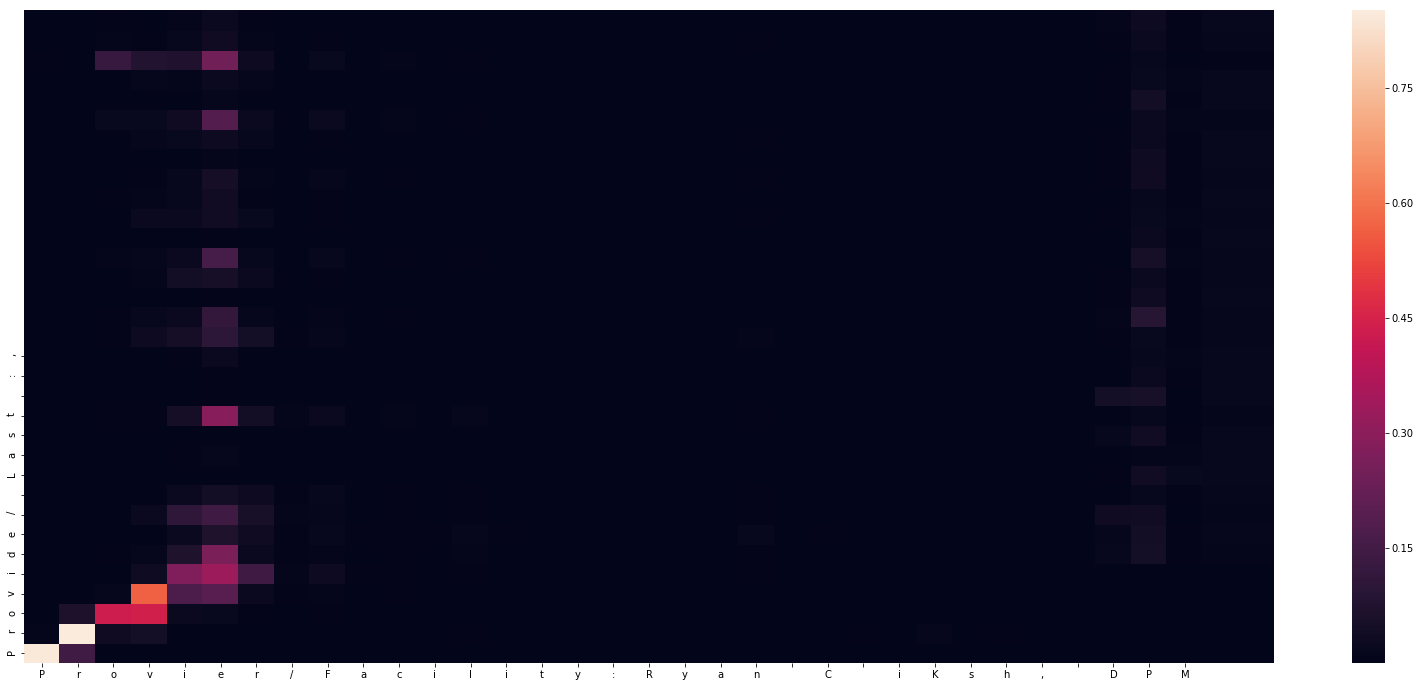

-
Input sentence: Provier/Facility:Ryan C iKsh, DPM
GT sentence: Provider/Facility: Ryan C Kish, DPM

Decoded sentence: Provide/ Last :,


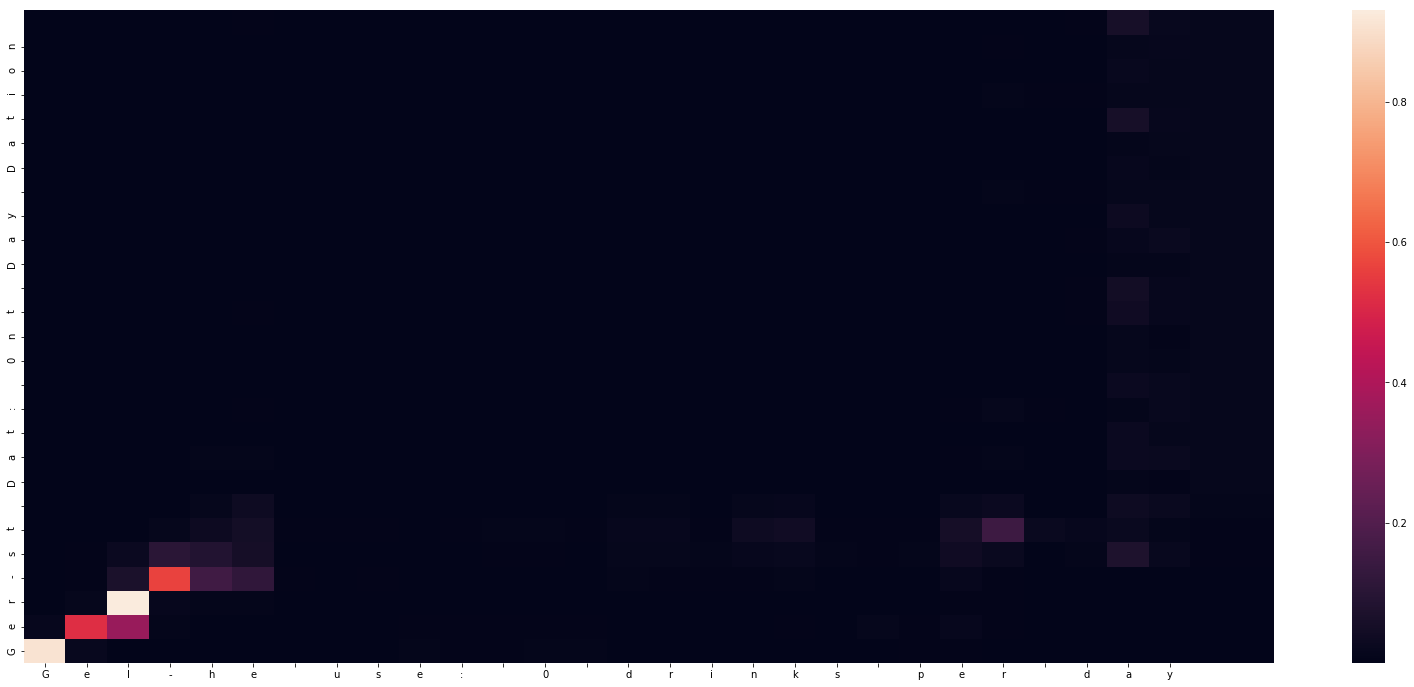

-
Input sentence: Gel-he use: 0 drinks per day
GT sentence: Caffeine use: 0 drinks per day

Decoded sentence: Ger-st Dat: 0nt Day Dation


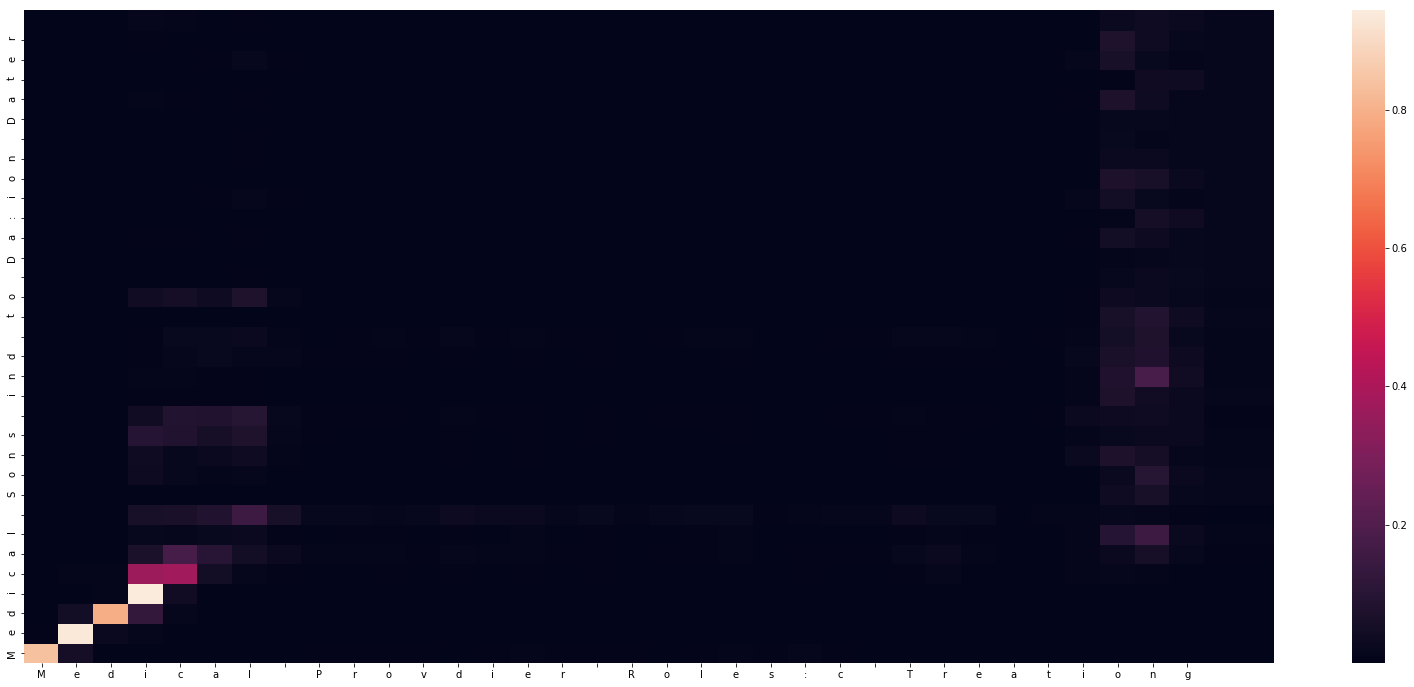

-
Input sentence: Medical Provdier Roles:c Treationg
GT sentence: Medical Provider Roles: Treating

Decoded sentence: Medical Sons ind to Da:ion Dater


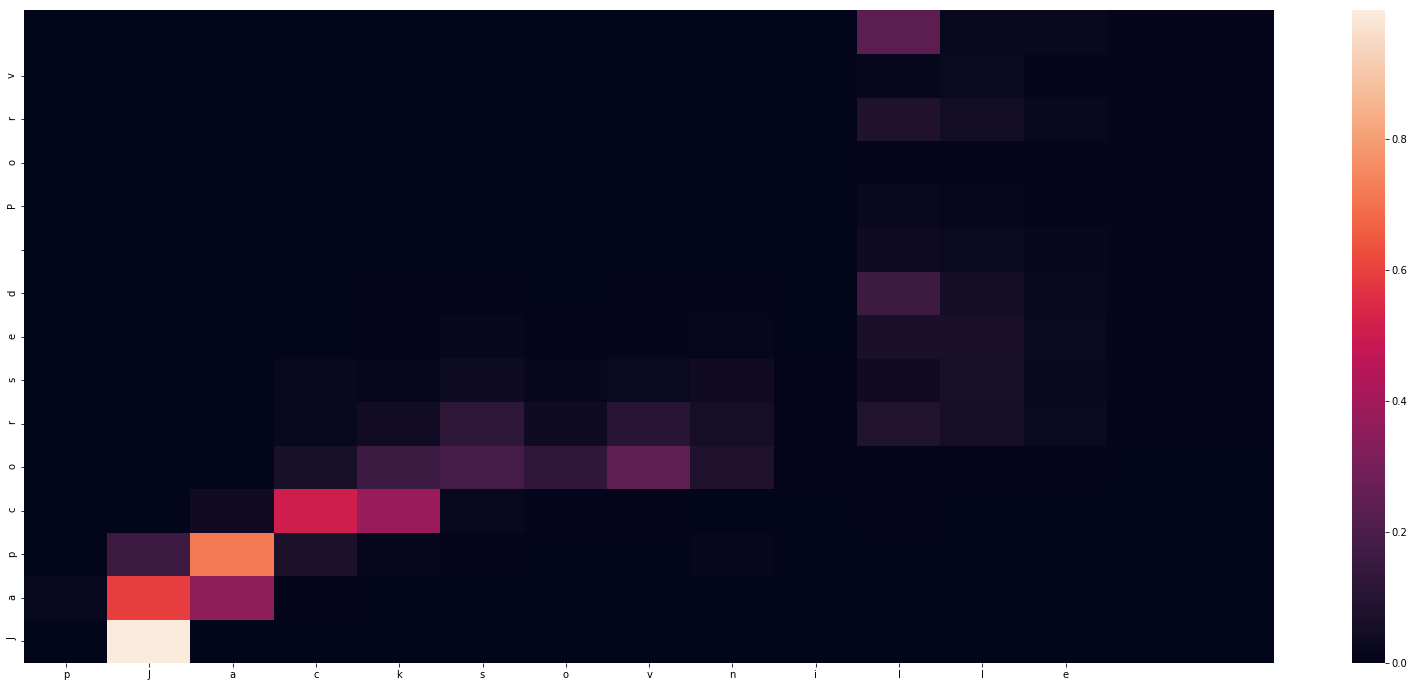

-
Input sentence: pJacksovnille
GT sentence: Jacksonville

Decoded sentence: Japcorsed Porv


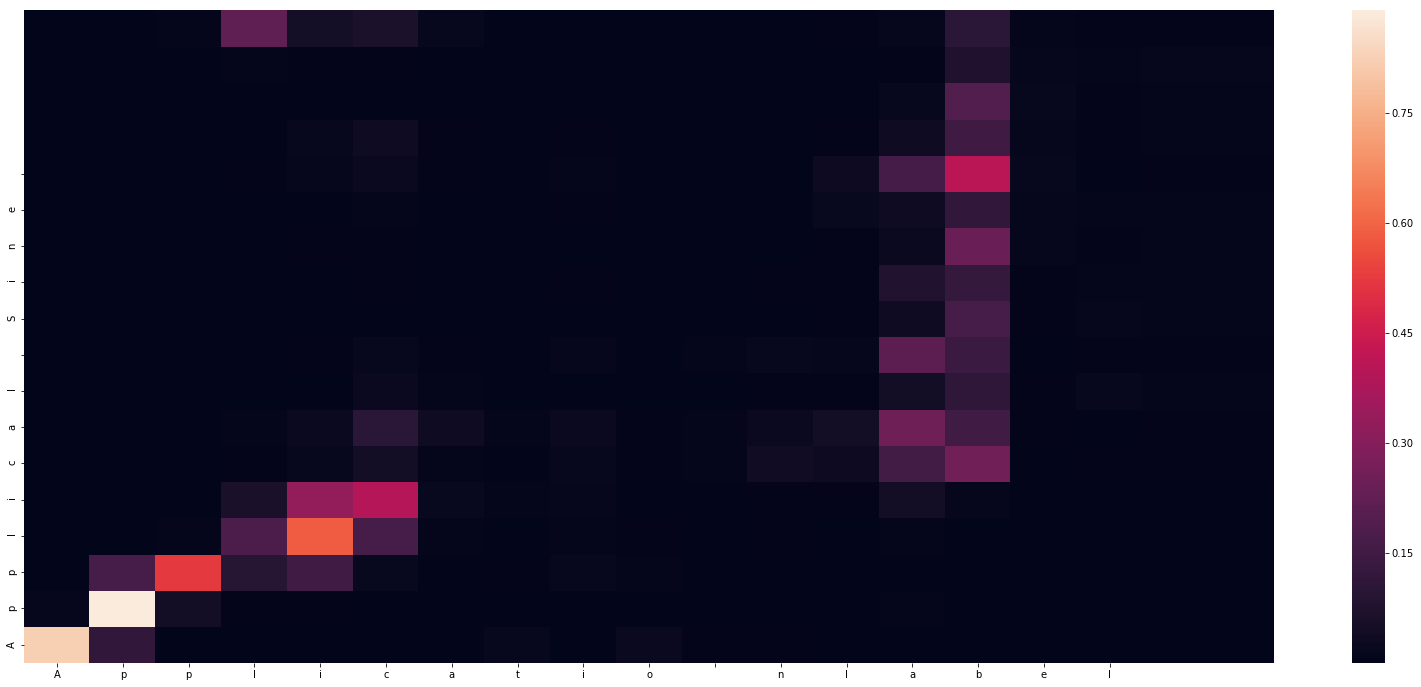

-
Input sentence: Applicatio nlabel
GT sentence: Application label

Decoded sentence: Applical Sine 


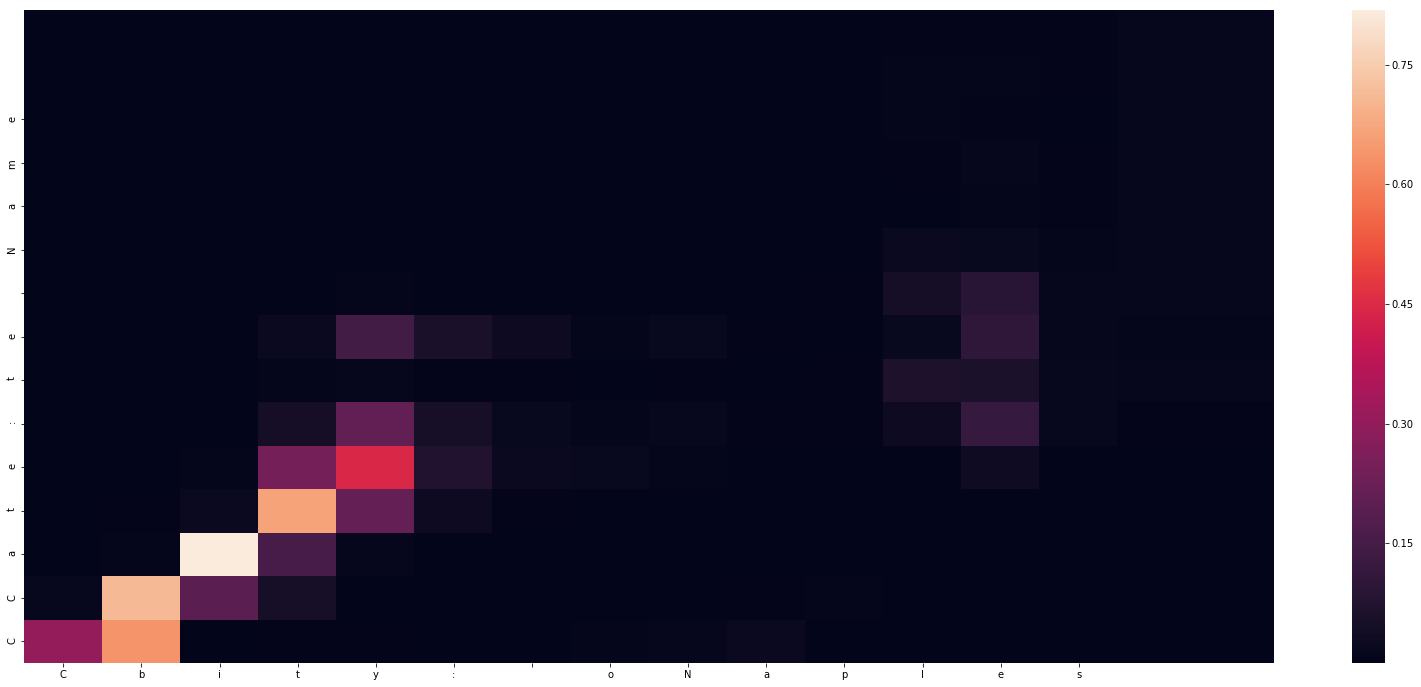

-
Input sentence: Cbity: oNaples
GT sentence: City: Naples

Decoded sentence: CCate:te Name


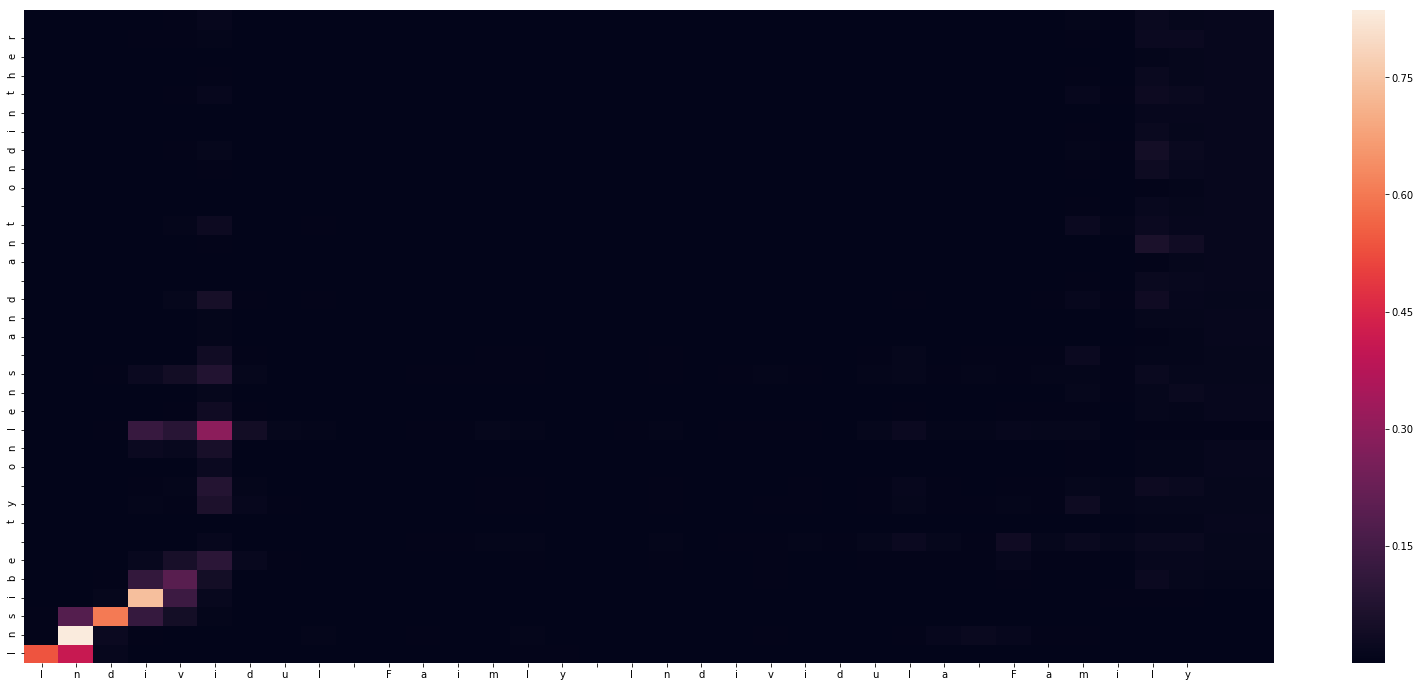

-
Input sentence: Individul Faimly Individula Family
GT sentence: Individual Family Individual Family

Decoded sentence: Insibe ty onlens and ant ondinther


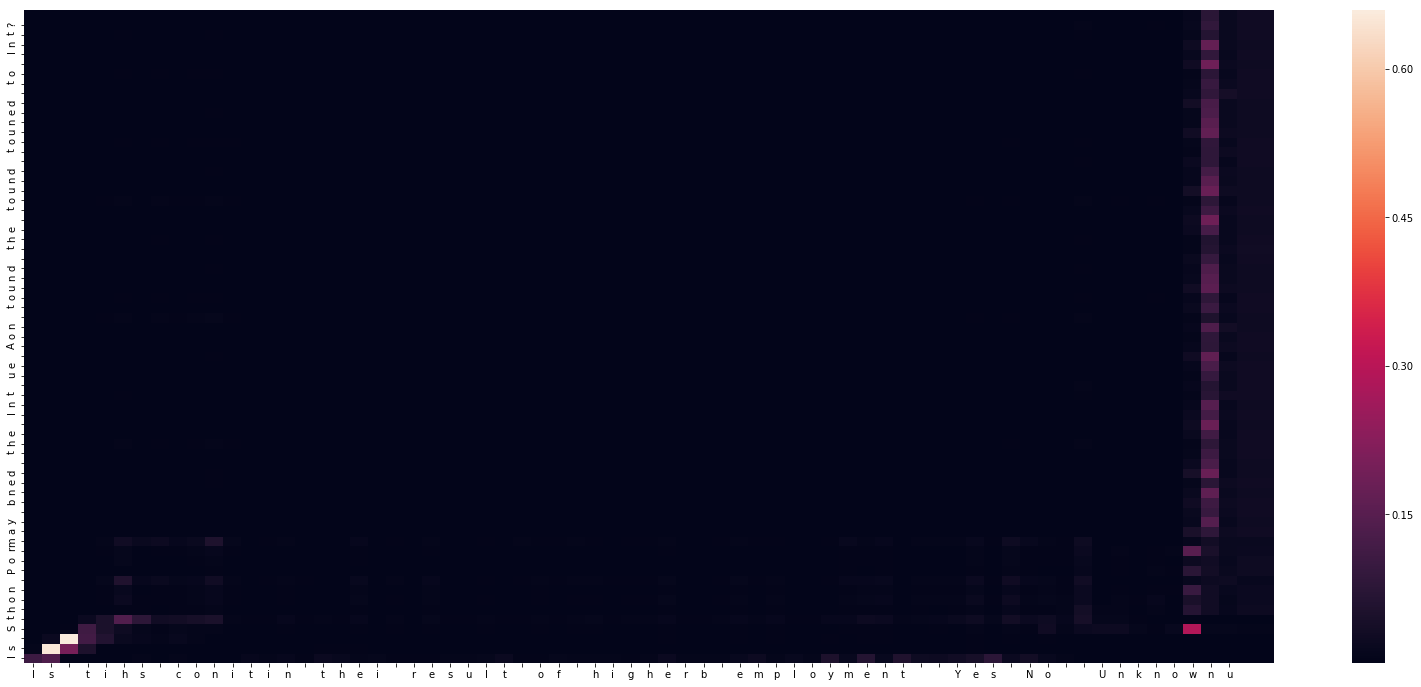

-
Input sentence: Is tihs conitin thei result of higherb employment  Yes No  Unknownu
GT sentence: Is this condition the result of higher employment  Yes No  Unknown

Decoded sentence: Is Sthon Pormay bned the Int ue Aon tound the tound touned to Int?


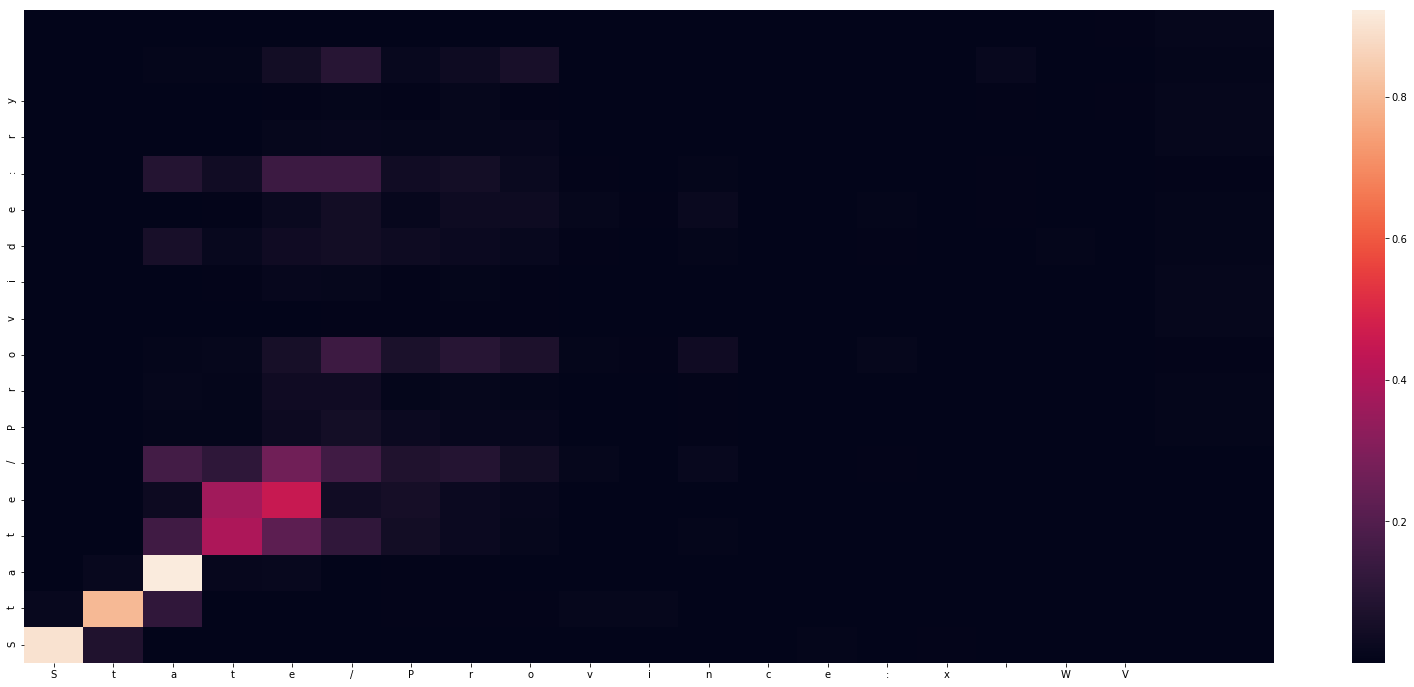

-
Input sentence: State/Province:x WV
GT sentence: State/Province: WV

Decoded sentence: State/Provide:ry


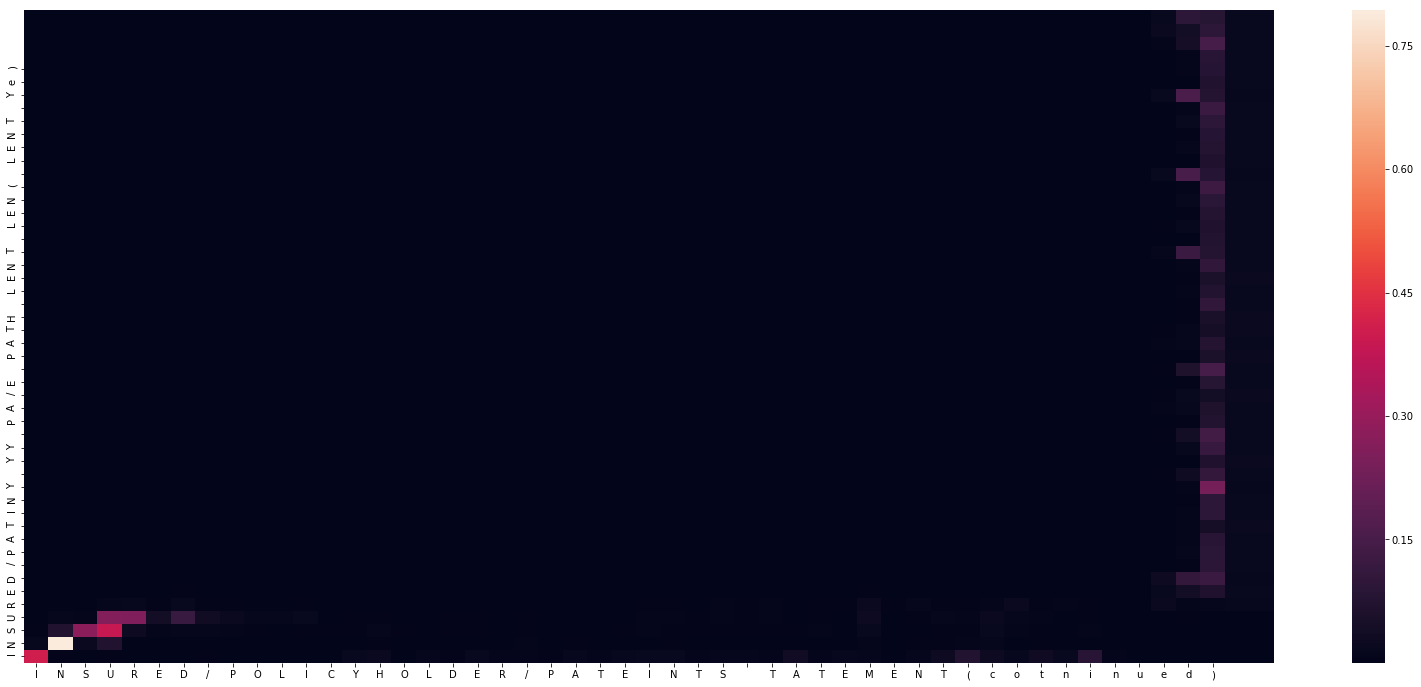

-
Input sentence: INSURED/POLICYHOLDER/PATEINTS TATEMENT(cotninued)
GT sentence: INSURED/POLICYHOLDER/PATIENT STATEMENT(continued)

Decoded sentence: INSURED/PATINY YY PA/E PATH LENT LEN( LENT Ye)


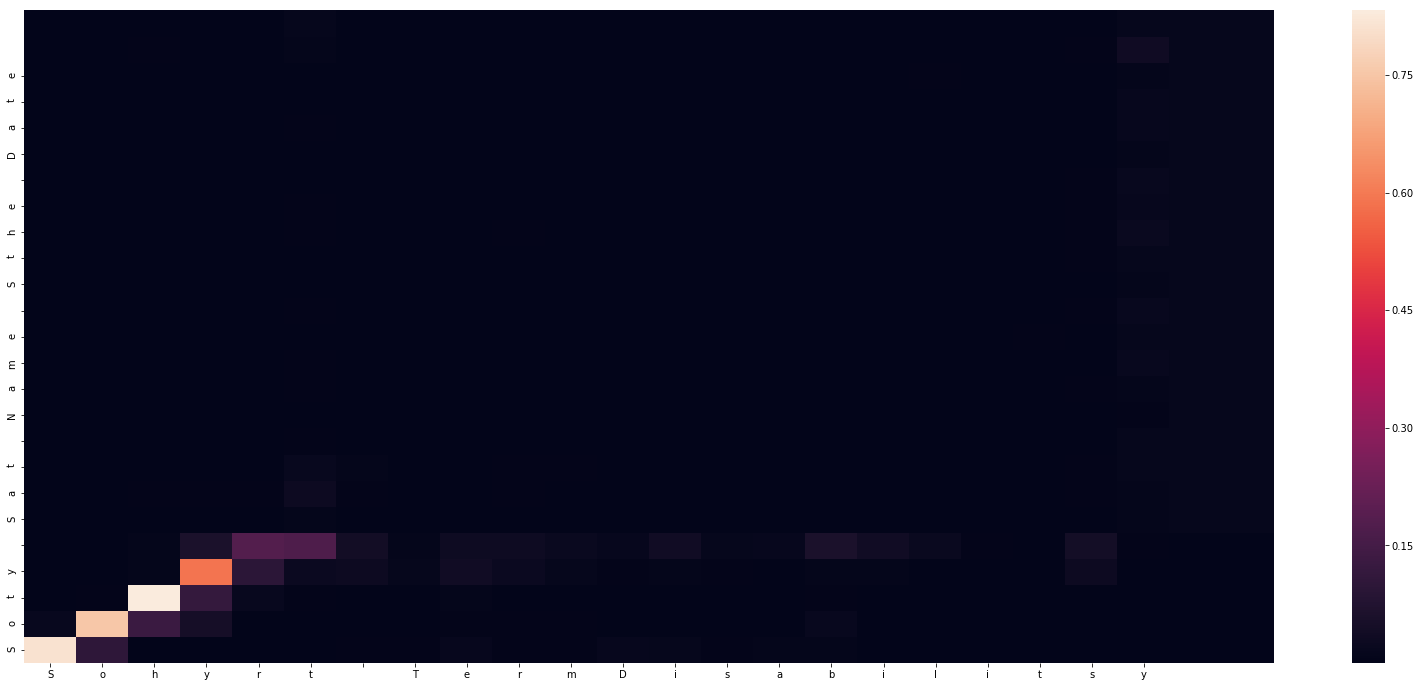

-
Input sentence: Sohyrt TermDisabilitsy
GT sentence: Short Term Disability

Decoded sentence: Soty Sat Name Sthe Date


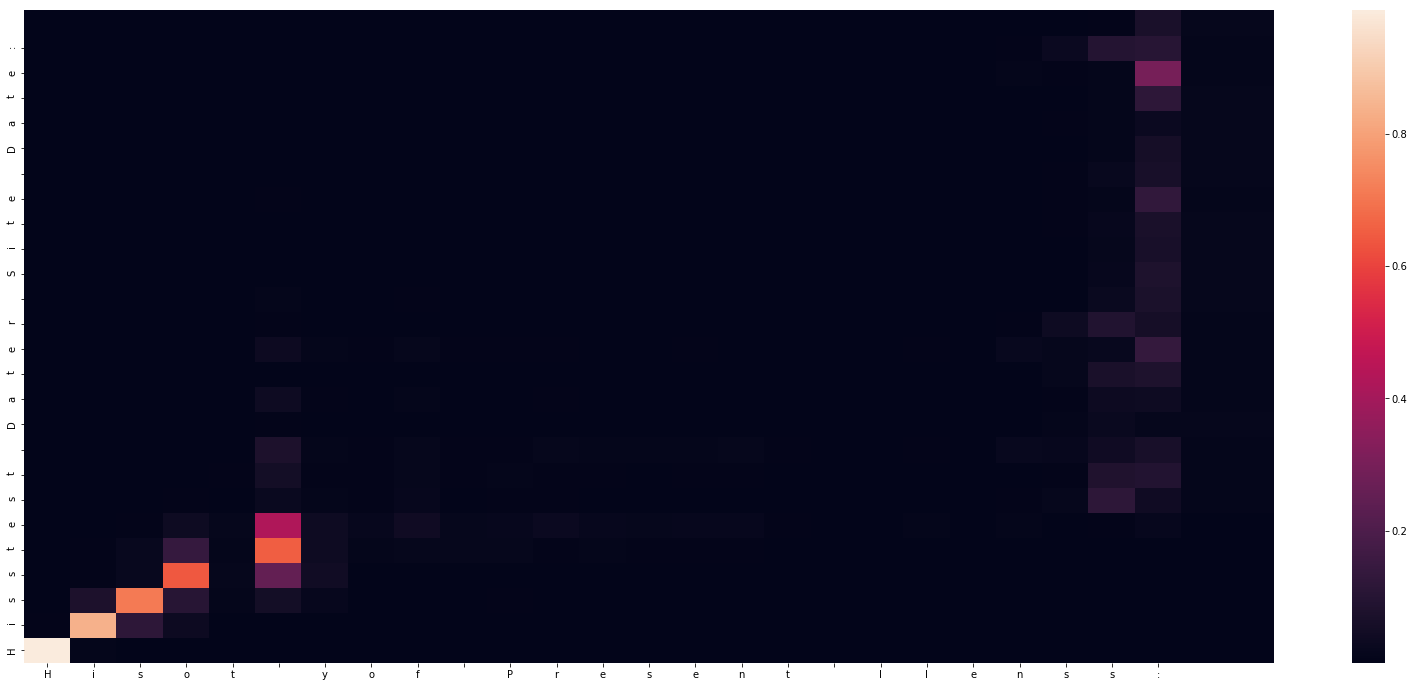

-
Input sentence: Hisot yof Present Ilenss:
GT sentence: History of Present Illness:

Decoded sentence: Hisstest Dater Site Date:


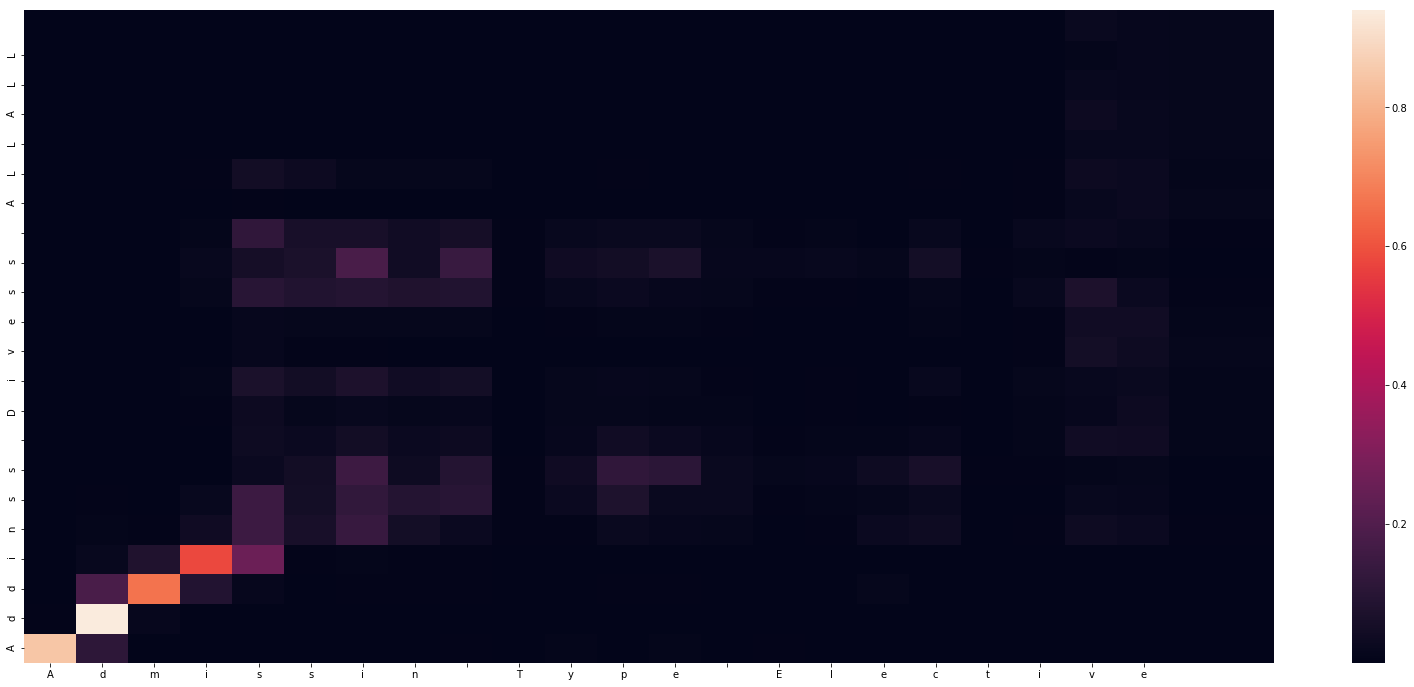

-
Input sentence: Admissin Type Elective
GT sentence: Admission Type Elective

Decoded sentence: Addinss Divess ALLALL


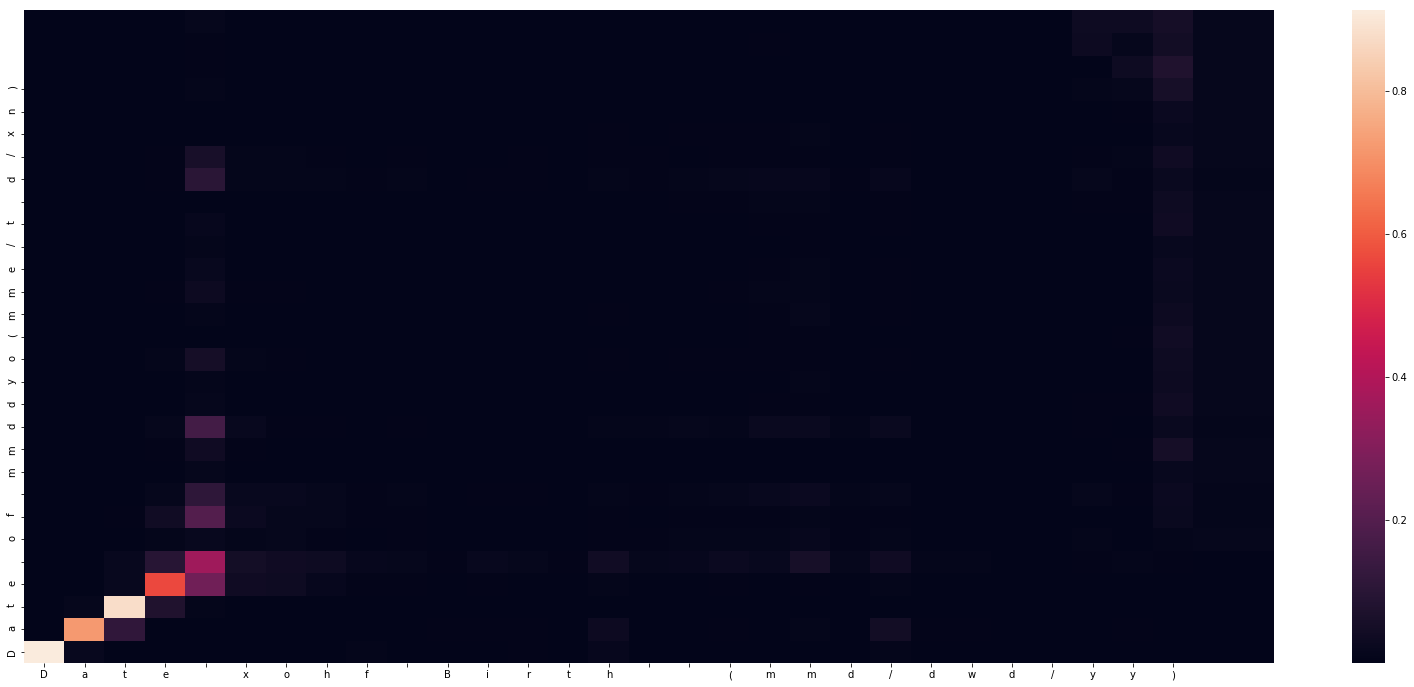

-
Input sentence: Date xohf Birth  (mmd/dwd/yy)
GT sentence: Date of Birth  (mm/dd/yy)

Decoded sentence: Date of mmddyo(mme/t d/xn)


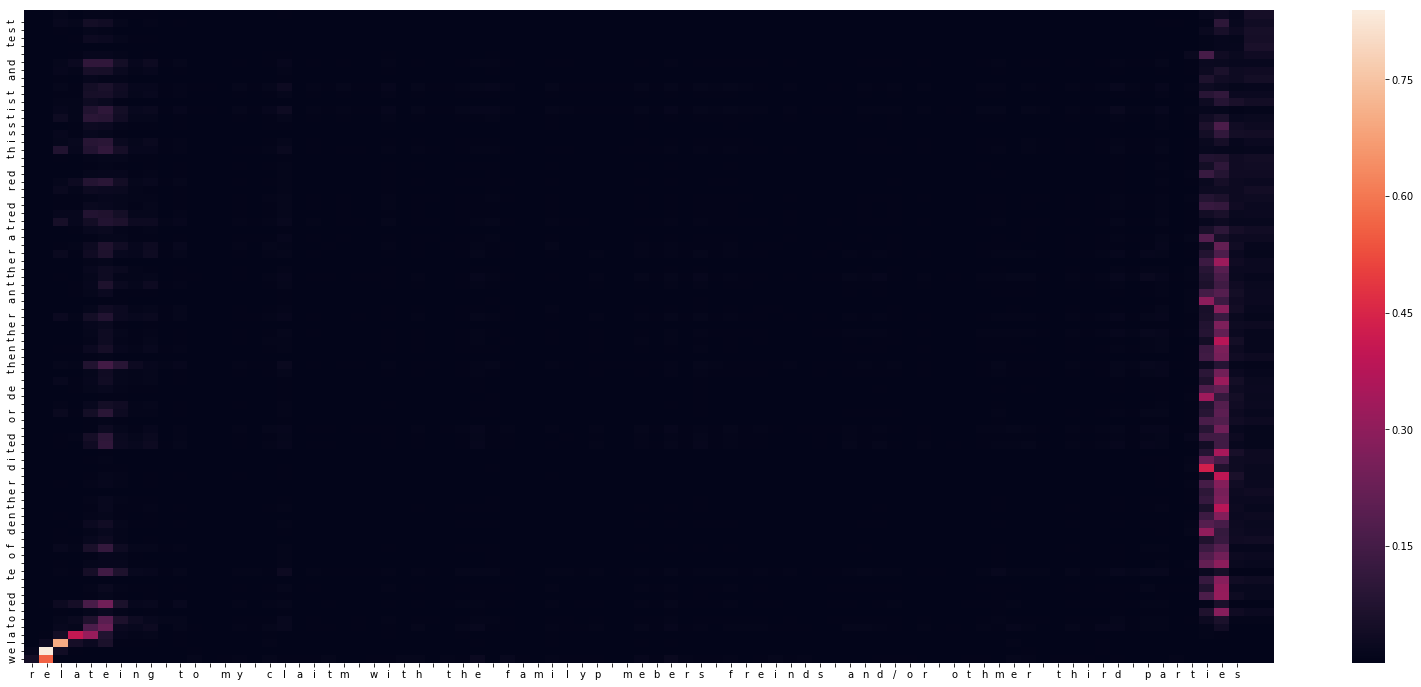

-
Input sentence: relateing to my claitm with the familyp mebers freinds and/or othmer third parties
GT sentence: relating to my claim with the family members friends and/or other third parties

Decoded sentence: welatored te of denther dited or de thenther antther atred red thisstist and test


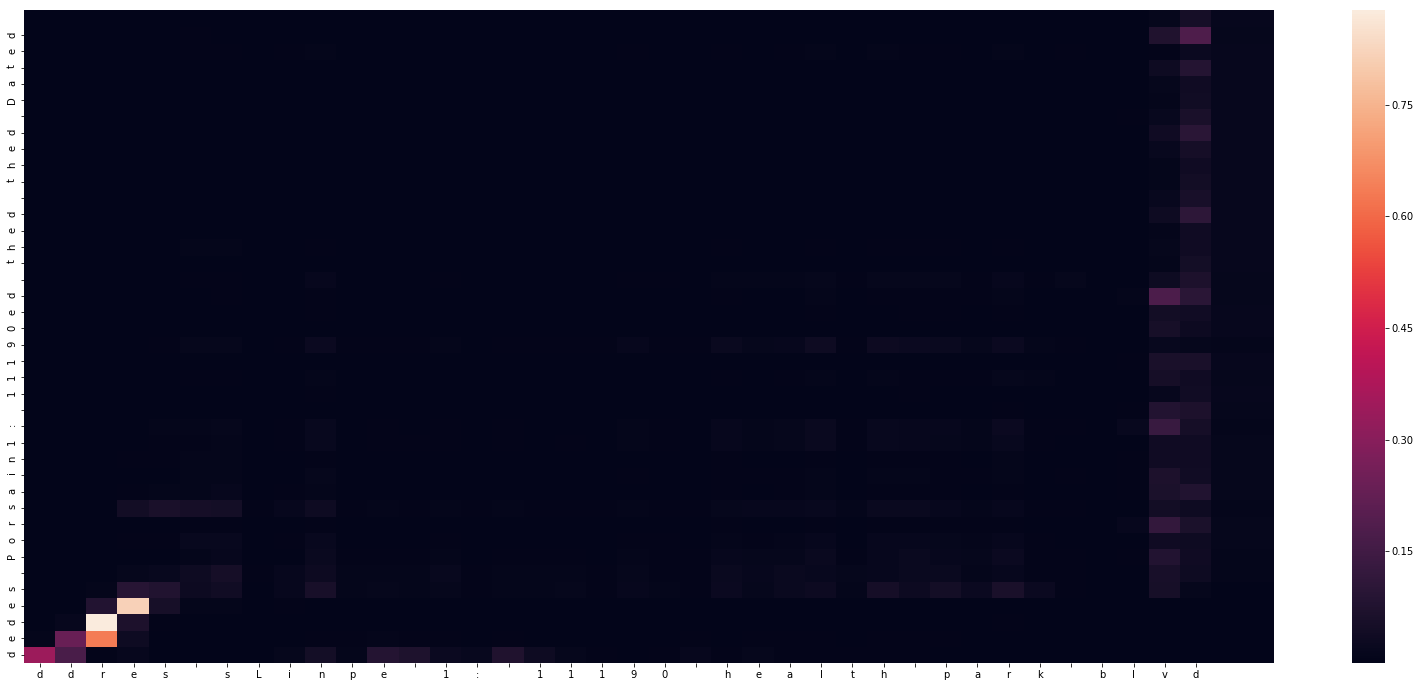

-
Input sentence: ddres sLinpe 1: 11190 health park blvd
GT sentence: Address Line 1: 11190 health park blvd

Decoded sentence: dedes Porsain1: 11190ed thed thed Dated


In [70]:
for seq_index in range(100):

    target_text = target_texts[seq_index][1:-1]
    text = input_texts[seq_index]
    decoded_sentence = visualize_attention(text, encoder_model, decoder_model, max_encoder_seq_length, num_decoder_tokens, vocab_to_int, int_to_vocab)
    print('-')
    print('Input sentence:', text)
    print('GT sentence:', target_text)
    print('Decoded sentence:', decoded_sentence)   


In [ ]:
#WER_spell_correction = calculate_WER(target_texts_, decoded_sentences)
#print('WER_spell_correction |TRAIN= ', WER_spell_correction)

In [73]:
# Sample output from test data
decoded_sentences = []
target_texts_ =  []
for seq_index in range(len(test_input_texts)):
    # Take one sequence (part of the training set)
    # for trying out decoding.

    input_seq = test_encoder_input_data[seq_index: seq_index + 1]
    decoded_sentence, _ = decode_sequence(input_seq, encoder_model, decoder_model, num_decoder_tokens, int_to_vocab)
    target_text = test_target_texts[seq_index][1:-1]
    print('-')
    print('Input sentence:', test_input_texts[seq_index])
    print('GT sentence:', target_text)
    print('Decoded sentence:', decoded_sentence)   
    decoded_sentences.append(decoded_sentence)
    target_texts_.append(target_text)

-
Input sentence: Social Security Nubear
GT sentence: Social Security Number

Decoded sentence: Sociallary an Acaion
-
Input sentence: Addess Line 1:
GT sentence: Address Line 1:

Decoded sentence: Addeess Lise1:
-
Input sentence: Fruad Stemnets Reviewde d Electroniacll

GT sentence: Fraud Statements Reviewed and Electronically

Decoded sentence: Froul Surevert Sity Sit Aved Pation Ade
-
Input sentence: CL# 099497919
GT sentence: CL# 0994979190

Decoded sentence: CL099497919e
-
Input sentence: Spues Off-Job Acc May , 2017
GT sentence: Spouse Off-Job Acc May 1, 2017

Decoded sentence: Speee Nom-NCONCLANCHAN,O2017
-
Input sentence:  FFICE HORUS:
GT sentence:  OFFICE HOURS:

Decoded sentence: * FIDENT NT :
-
Input sentence: Heltthcare System
GT sentence: Healthcare System

Decoded sentence: Heltth PAte Name
-
Input sentence: * Avoid plyaing spots or any other activities htat cold rseult qin another head injury.
GT sentence: * Avoid playing sports or any other activities that could result 

-
Input sentence: * Seizures
GT sentence: * Seizures

Decoded sentence: * Seess Ss
-
Input sentence: iWllochel,Teri
GT sentence: Willochel,Teri

Decoded sentence: Bill Prev,der
-
Input sentence: TH_AR_LTR 00270
GT sentence: TH_AR_LTR 002270

Decoded sentence: THWAR Chel00270
-
Input sentence: Visit Date:
GT sentence: Visit Date:

Decoded sentence: Visite Dat:
-
Input sentence: Provider Last Name: Shqafpfer
GT sentence: Provider Last Name: Shaffer

Decoded sentence: Provide Came Cate :ont Dater
-
Input sentence: aDteS igned
GT sentence: Date Signed

Decoded sentence: Dated Name
-
Input sentence: Provider Ladst Name: Bartruf
GT sentence: Provider Last Name: Bartruff

Decoded sentence: Provider Inf Intont:Cation
-
Input sentence: HEIGTH/LENGHT: 5f t 3 in
GT sentence: HEIGTH/LENGHT: 5 ft 3 in

Decoded sentence: HEIERE/ ENT C:R5RARI3NT
-
Input sentence: Mejdical Proviedr Roles :Treating
GT sentence: Medical Provider Roles: Treating

Decoded sentence: Medical Provider Ser Sal:Sitition
-
Inpu

-
Input sentence: pBILILNG NO BEALF OF COLLIER COUNTrRY EMS
GT sentence: BILLING ON BEHALF OF COLLIER COUNTRY EMS

Decoded sentence: pIInICAL SICELASTICESSSCASICESYICENT CES
-
Input sentence: If knwn,plesa check all tyes of covermag eou hav wthg Unyum.
GT sentence: If known,please check all types of coverage you have with Unum.

Decoded sentence: If knte, one ton then nonthent one to buent ons toun the,t 
-
Input sentence: Patient DOB:
GT sentence: Patient DOB:

Decoded sentence: Patient Nam:
-
Input sentence: INSURED/POLICYHOLDR/PpAzTIENsT STATvEMETN(continued)
GT sentence: INSURED/POLICYHOLDER/PATIENT STATEMENT(continued)

Decoded sentence: INSURED/PATE PAYY F/E LANT LE LA(
-
Input sentence: Spool all]! City State Zip Fax No.
GT sentence: Specialty City State Zip Fax No.

Decoded sentence: Soolowens]Sun the boent rethent a.y
-
Input sentence: Spouse Off-Job Acc May 1n, 2017
GT sentence: Spouse Off-Job Acc May 1, 2017

Decoded sentence: Spous Numb-r Sune e Pr1n,e2017
-
Input sentence:

-
Input sentence: TIER 3 Individdaual Dceducxtible
GT sentence: TIER 3 Individual Deductible

Decoded sentence: TIER 3f Conel Polection Acale Colion
-
Input sentence: MedExpresso
GT sentence: MedExpress

Decoded sentence: MedExpenss
-
Input sentence: as of the dae f this ltter, consistent wiht the benefis outlined min your certificate.
GT sentence: as of the date of this letter, consistent with the benefits outlined in your certificate.

Decoded sentence: In  oure the den to thent ,or the bent oumber the bent oumbery toun the the,be the thed 
-
Input sentence: Patient presents with
GT sentence: Patient presents with

Decoded sentence: Patient Certtenttate
-
Input sentence: RESP: 16 bbreaths/min
GT sentence: RESP: 16 breaths/min

Decoded sentence: RESP:16ROREAInti/Pat
-
Input sentence: with a familym embre, friend or other third partyn abodutyourc laim, we recommenldcompletin gthe
GT sentence: with a family member, friend or other third party about your claim, we recommend completing th

-
Input sentence: *DISCALIMgER:
GT sentence: *DISCLAIMER:

Decoded sentence: *IISt Dite
-
Input sentence: * New or increased swellingk or brusiing
GT sentence: * New or increased swelling or bruising

Decoded sentence: * Ner Sure thonf thenturinent ur tontion
-
Input sentence: Frauzd Statements Reieed andv Elejctronically
GT sentence: Fraud Statements Reviewed and Electronically

Decoded sentence: raud Numbent ond your child Dation Dated to
-
Input sentence: * Memoyr loss
GT sentence: * Memory loss

Decoded sentence: * Merseresss
-
Input sentence: Claim Type: VB Accient - Accidenwt Injury
GT sentence: Claim Type: VB Accident - Accident Injury

Decoded sentence: Claim Numb:nt Day provi-ent onstry Rerted
-
Input sentence: The Benefits Cneter
GT sentence: The Benefits Center

Decoded sentence: The  folentte Name
-
Input sentence: Rnetrnexd to Work:
GT sentence: Returned to Work:

Decoded sentence: Riettent Dute Nam:
-
Input sentence: Provindegr Lrast aNme: haffer
GT sentence: Provider Las

-
Input sentence: Emergency Departnet Car Providers: Barrtuff Christgopher- MD
GT sentence: Emergency Department Care Providers: Bartruff, Christopher - MD

Decoded sentence: Emered Prene Nert Cere Date the D:te the Date the Date teder
-
Input sentence: iSncerely,
GT sentence: Sincerely,

Decoded sentence: Snncelly
-
Input sentence: Long Term Disabilit

GT sentence: Long Term Disability

Decoded sentence: Lonfen Came Ene te
-
Input sentence: Electronic Sumisson
GT sentence: Electronic Submission

Decoded sentence: Elect on Aation Act
-
Input sentence: Employmenat Information
GT sentence: Employment Information

Decoded sentence: Employoure OInformation
-
Input sentence: Allergies
GT sentence: Allergies

Decoded sentence: Alled Nes
-
Input sentence: Rceoorda number:
GT sentence: Record number:

Decoded sentence: Rceronour Actio:
-
Input sentence: Accident Descrtion: was pulayin on the playgroundo and jumpexd downo fft h mnkey bars
GT sentence: Accident Description: was playing on the pl

-
Input sentence: othherwie perittedb y law.
GT sentence: otherwise permitted by law.

Decoded sentence: Othet Last Patibent Date.
-
Input sentence: Stater‘Pronnce:
GT sentence: Postal Code:

Decoded sentence: Staterovidente:
-
Input sentence: Houjrs Scheduled toW ork on Latsp Day:
GT sentence: Hours Scheduled to Work on Last Day:

Decoded sentence: Hours fore ter then ant on Date the
-
Input sentence: Ploicy Holdcer
GT sentence: Policy Holder

Decoded sentence: Ploialider Sder
-
Input sentence: ome Telephnoe Numbe
GT sentence: Home Telephone Number

Decoded sentence: oope tour Nunt Date
-
Input sentence: tate/Proince
GT sentence: State/Province:

Decoded sentence: tate/oved or
-
Input sentence: CLINTO NIA 52733
GT sentence: CLINTON IA 52733

Decoded sentence: CLINILESTON52733E
-
Input sentence: oPstal Code: 26330
GT sentence: Postal Code: 26330

Decoded sentence: Postalede C:t263
-
Input sentence: AccountabilityA ct (HIPAA) Privacey Rule
GT sentence: Accountability Act (HIPAA) Privacy

-
Input sentence: Insured/Poicyholdcer Name (Last Name, Firs tNameM,I,Suffix)
GT sentence: Insured/Policyholder Name (Last Name, First Name,MI,Suffix)

Decoded sentence: Insured/rovider rovided y(umed dde,t /
-
Input sentence: (Including Confineent)
GT sentence: (Including Confinement)

Decoded sentence: (Incil Sy Numblent Na)e
-
Input sentence: Child On 81 Off-Job Acc January 1, 2018
GT sentence: Child On & Off-Job Acc January 1, 2018

Decoded sentence: Child Por81r No-p on Provider Na1,t2018
-
Input sentence: SERVEC DESCRxIPTION
GT sentence: SERVICE DESCRIPTION

Decoded sentence: SERYINTANCENT NCLL
-
Input sentence: For questions following your visit please contact our call center , Thnaik yo.u
GT sentence: For questions following your visit please contact our call center , Thank you.

Decoded sentence: or onun un ur un our the un tuun tu nuuntunun un tu tu nunun un toun tu nunent 
-
Input sentence: physicain does have teh rightt o be paiad fort ecare povide.
GT sentence: physicain d

-
Input sentence: Dae sof Dischage:
GT sentence: Date of Discharge:

Decoded sentence: Date of Date the:
-
Input sentence: TIER 1 Individual Deductib
GT sentence: TIER 1 Individual Deductible

Decoded sentence: TIER 1n dery Pion Dute Day
-
Input sentence: Claim Number:
GT sentence: Claim Number:

Decoded sentence: Claim Number:
-
Input sentence: VuYPHAPzHlONE INTHALANGSY
GT sentence: VYPHAPHONE INTHALANGSY

Decoded sentence: VYYPHOHOURAYH HOREHONT YEM
-
Input sentence: UﬂUﬁT
GT sentence: unum

Decoded sentence: AnTT
-
Input sentence: Hours Worekd n ast Day
GT sentence: Hours Worked on Last Day:

Decoded sentence: Hours Date PAtin Date
-
Input sentence: Calim bType: VB Accident - Accipdent Injur
GT sentence: Claim Type: VB Accident - Accident Injury

Decoded sentence: Caliced Pro:ide yourovide-yoff ry diply dder
-
Input sentence: (customer ocpy)
GT sentence: (customer copy)

Decoded sentence: (ccth Numbery
-
Input sentence: Epceted Full-time qReturn oW ork Date:
GT sentence: Expected Fu

-
Input sentence: Patient Naqme:
GT sentence: Patient Name:

Decoded sentence: Patity Name
-
Input sentence: HealthC re
GT sentence: Health Care

Decoded sentence: Healt Date
-
Input sentence: Electronically Signed Inicatr:
GT sentence: Electronically Signed Indicator:

Decoded sentence: Electined Sontined your chine:
-
Input sentence: Fjru dSttaemetns Reveiw dand Electroniacllyy
GT sentence: Fraud Statements Reviewed and Electronically

Decoded sentence: Forunt Dat Ant the Provident Day and ye the
-
Input sentence: Date of Fiirst Visith:
GT sentence: Date of First Visit:

Decoded sentence: Date of Dion Dat off :ay
-
Input sentence: North Huntingdon,PA 15642-1840 724-8634362
GT sentence: North Huntingdon,PA 15642-1840 724-8634362

Decoded sentence: NotZt Numbld hou,tho15642-1840724-8634362
-
Input sentence: C L- 11v6v (01/13)
GT sentence: CL - 1116 (01/13)

Decoded sentence: CL-I11 6am(01/13)
-
Input sentence: * Memory loss
GT sentence: * Memory loss

Decoded sentence: * Meforedesss
-


-
Input sentence: * Havey our chijld rest the ram. Yoau may need sto restrict your cihld's acptivitiesf or afew das.
GT sentence: * Have your child rest the arm. You may need to restrict your child's activities for a few days.

Decoded sentence: * Haloe are ane ton ane to thed.tor  of te te an the the dent youred to and your.the the the fore
-
Input sentence: * Wekesso r unmbness in any part of the bdoy
GT sentence: * Weakness or numbness in any part of the body

Decoded sentence: * We f the dent ons the the bettont ant ye
-
Input sentence: NCH Noapies Hospital (239)6 z24-2700
GT sentence: NCH Napies Hospital (239) 624-2700

Decoded sentence: NCH Nur Cons Co Ch Co(239)6L 24-270
-
Input sentence: How rdoes it vary - ours nddays vagy
GT sentence: How does it vary - hours and days vary

Decoded sentence: Howad Dothe Ins th-s to Dation Date
-
Input sentence: Addwress Line 1: 11190 health pargk bltvd
GT sentence: Address Line 1: 11190 health park blvd

Decoded sentence: Addrest Lase 1:R1119

-
Input sentence: Irmatienthutpatient Indicator: Outpatient
GT sentence: Inpatient/Outpatient Indicator: Outpatient

Decoded sentence: Inpationt on the the the the :h to thent
-
Input sentence: Hous Worked on Last Dy:
GT sentence: Hours Worked on Last Day:

Decoded sentence: Houso Prent Dater the:
-
Input sentence: Printd date: 
GT sentence: Print date: 

Decoded sentence: Prinnt Name:
-
Input sentence: AMOUNT DUE:
GT sentence: AMOUNT DUE:

Decoded sentence: AMOUNT NUS:
-
Input sentence: Expected Full-time Return eTo Work dDate:
GT sentence: Expected Full-time Return To Work Date:

Decoded sentence: Exped Doront -n Pol the the the thed Do:
-
Input sentence: Jasmlnder Singh Dev. PA
GT sentence: By: Jasminder Singh Dev, PA

Decoded sentence: Jasintine Nane Pinn. Day
-
Input sentence: rTeatemnt Dates:
GT sentence: Treatment Dates:

Decoded sentence: Teeted Pati Dat:
-
Input sentence: ffectkive Date:
GT sentence: Effective Date:

Decoded sentence: Ifect  Phen D:te
-
Input sentence: mployee

-
Input sentence: kFolow upr with your childs hbealthc are prqovider.
GT sentence: Follow up with your child's health care provider.

Decoded sentence: Folloolicy on the the bent thent the the the ther
-
Input sentence: 48 BEDFORD D, oBLDG 600, 2ND FLOOR 
GT sentence: 480 BEDFORD RD, BLDG 600, 2ND FLOOR 

Decoded sentence: 48TI F Dovin, Dat Ha600, 2 Shatien
-
Input sentence: EE Name:
GT sentence: EE Name:

Decoded sentence: EE Name:
-
Input sentence: PaiTiEMWWTM“
GT sentence: Patient: 

Decoded sentence: Pite PHONe
-
Input sentence: Individual Disabiitqyv Policy #
GT sentence: Individual Disability Policy #

Decoded sentence: Indifident or coronciden doy 
-
Input sentence: Social Secuirty Numbmer
GT sentence: Social Security Number

Decoded sentence: Social Surenture Number
-
Input sentence: Home cdare
GT sentence: Home care

Decoded sentence: Home 
-
Input sentence: Sun Exposure: occasionally
GT sentence: Sun Exposure: occasionally

Decoded sentence: Sun ol your :ction Action
-
Input 

-
Input sentence: Reorndnmube:
GT sentence: Record number:

Decoded sentence: Reorour Ses:
-
Input sentence: billin gphone:
GT sentence: billing phone:

Decoded sentence: biliint Nay
-
Input sentence: diganqosi

GT sentence: diagnosis

Decoded sentence: didnnture
-
Input sentence: Product: Long Terjm Disability
GT sentence: Product: Long Term Disability

Decoded sentence: Proutan: on the the the th Dat
-
Input sentence: Righ tankle injruy
GT sentence: Right ankle injury.

Decoded sentence: Rick  ant Datinten
-
Input sentence: Phone
GT sentence: Phone

Decoded sentence: Phnen
-
Input sentence: kPush
GT sentence: Push

Decoded sentence: PasEZ
-
Input sentence: Is Surgery Required:
GT sentence: Is Surgery Required:

Decoded sentence: Is Suroressed youre:
-
Input sentence: SocialSecuinty Number
GT sentence: Social Security Number

Decoded sentence: Social Sure Numbery
-
Input sentence: Reason CodeL
GT sentence: Reason Code

Decoded sentence: Reasunt Name
-
Input sentence: Parouvider Last N

-
Input sentence: 8. information About the Inauroleollcyholdor
GT sentence: B. Information About the Insured/Policyholder

Decoded sentence: 8. Sure te Rent Patenunt Conk tour the toum
-
Input sentence: physicai ndoes hagve theright tvo be aid for the care prvoided
GT sentence: physicain does have the right to be paid for the care provided.

Decoded sentence: phys de thed Col or ve thed to slder ton tol your tound tousted
-
Input sentence: CL-13 (02/17)
GT sentence: CL-1023 (02/17)

Decoded sentence: CL-13(02/17)
-
Input sentence: Coa-insurance
GT sentence: Co-insurance

Decoded sentence: Col- Number
-
Input sentence: Estimated AllowedAmount
GT sentence: Estimated Allowed Amount

Decoded sentence: Estity Poly PAthe thons
-
Input sentence: Emegenc
GT sentence: Emergency

Decoded sentence: Emeroncion
-
Input sentence: iCty: Bridfgepotr
GT sentence: City: Bridgeport

Decoded sentence: CCty:Conthild Date
-
Input sentence: Co-Insurnce
GT sentence: Co-Insurance

Decoded sentence: Co-  Hucy
-

-
Input sentence: Medciaal Provider Information - Hsoptiaiagtion
GT sentence: Medical Provider Information - Hospitalization

Decoded sentence: Medical Provider villy Infinat-on Acation Anont
-
Input sentence: Service Date:
GT sentence: Services Date:

Decoded sentence: Serviced Dat:
-
Input sentence: Country: S
GT sentence: Country: US

Decoded sentence: Count N:SY
-
Input sentence: H. Singature of Isnured/Policyholder
GT sentence: H. Signature of Insured/Policyholder

Decoded sentence: H. Sind Con the ron ted/to Covident
-
Input sentence: Medical Proviedr Roles:f Treatingh
GT sentence: Medical Provider Roles: Treating

Decoded sentence: Medical Provider Spict:on Addilate
-
Input sentence: Claim EventI nforation
GT sentence: Claim Event Information

Decoded sentence: Claim Fountintintion
-
Input sentence: Feeling Suiicidal? Call For Help Now - 911
GT sentence: Feeling Suicidal? Call For Help Now - 911

Decoded sentence: Feelint Number Stion nsitil Sically -i911d
-
Input sentence: Birt

-
Input sentence: Employer:
GT sentence: Employer:

Decoded sentence: Employer:
-
Input sentence: Country: UvS
GT sentence: Country: US

Decoded sentence: Countt :USCS
-
Input sentence: * Inabilit to be awakened
GT sentence: * Inability to be awakened

Decoded sentence: * Int Dated to thed tont
-
Input sentence: 1st day oof work missme:1 ost dat eo TX after LDW:
GT sentence: 1st day of work missed: 1st date of TX after LDW:

Decoded sentence: 1strt Duth Po the thed :1 Dat  the the the the th1
-
Input sentence: Piscataway, JN 08855-1000q
GT sentence: Piscataway, NJ 08855-1000

Decoded sentence: Prstal Se ,atil08855-1000e
-
Input sentence: Date of First Visit:
GT sentence: Date of First Visit:

Decoded sentence: Date of to the Date:
-
Input sentence: Address Line 1:
GT sentence: Address Line 1:

Decoded sentence: Address Lise 1:s
-
Input sentence: PsotalCod:eh 2633

GT sentence: Postal Code: 26330

Decoded sentence: Postality:Non2633
-
Input sentence: yM Spouse
GT sentence: My Spouse

De

-
Input sentence: Deitaisl
GT sentence: Details

Decoded sentence: Detaller
-
Input sentence: Middle Name/cIntii:
GT sentence: Middle Name/Initial:

Decoded sentence: Midere Dide/ Date:
-
Input sentence: Ifyes have you received Workers Compensation beneﬁts for your occupational injury? III Yes ﬂNo
GT sentence: If yes, have you received Workers’ Compensation benefits for your occupational injury? Yes No

Decoded sentence: If Isuro orede re or or thed on or on or the dent onst onst onst onst ond on of the thouronton
-
Input sentence: Postal Code:
GT sentence: Postal Code:

Decoded sentence: Postale Dat:
-
Input sentence: Date of First Vsit:
GT sentence: Date of First Visit:

Decoded sentence: Date of ther tom 
-
Input sentence: I signe donx bhealf of the insured, acs u(indicate rlaitnship). If Powekr fo Attorney, Guardianl
GT sentence: I signed on behalf of the insured, as (indicate relationship). If Power of Attorney, Guardian

Decoded sentence: I sit allated Alated Eoleated le a,atalla

-
Input sentence: Comments:
GT sentence: Comments:

Decoded sentence: Comment:
-
Input sentence: Total Payment Amount
GT sentence: Total Payment Amount

Decoded sentence: Totat on the the Date
-
Input sentence: Transaction reference number:
GT sentence: Transaction reference number:

Decoded sentence: Traness Lisertent filent Day:
-
Input sentence: Signed Datse:
GT sentence: Signed Date:

Decoded sentence: Sinnine Name:
-
Input sentence: as of hte date of this leter ,nsistent wijth the benefitsm outlined in aydour certificte.
GT sentence: as of the date of this letter, consistent with the benefits outlined in your certificate.

Decoded sentence: Ins oured the the the bent at,the the the the bent at the the the for the the ,or the ne
-
Input sentence: Electronically Signemd Indifcatro:
GT sentence: Electronically Signed Indicator:

Decoded sentence: Electronted youned Siction Duent:
-
Input sentence: Houhs Scheduled ut Work on Lasnt Day:
GT sentence: Hours Scheduled to Work on Last Day:

-
Input sentence: 0 Age reporting
GT sentence: • Age reporting

Decoded sentence: 0 Ace Pore te
-
Input sentence: oNCH Nrhtfeast ED (239)624-8b700
GT sentence: NCH Northeast ED (239) 624-8700

Decoded sentence: Nonent Name Phy D(239)624-8 700
-
Input sentence: Coments:
GT sentence: Comments:

Decoded sentence: Comesss:
-
Input sentence: * Ununsual sleepiness or grogginess
GT sentence: * Unusual sleepiness or grogginess

Decoded sentence: * Unofoursor derss Rerss Rerss Surs
-
Input sentence: Printed Namw
GT sentence: Printed Name

Decoded sentence: Priner Name
-
Input sentence: lCaimant Name:
GT sentence: Claimant Name:

Decoded sentence: Claim Date D:t
-
Input sentence: Tpye Visa
GT sentence: Type: Visa

Decoded sentence: Tyyss Name
-
Input sentence: CL#0 994979190
GT sentence: CL# 0994979190

Decoded sentence: CL#0 994979190
-
Input sentence: STATMEENT DATE
GT sentence: STATEMENT DATE

Decoded sentence: SYAATEN CONT CE
-
Input sentence: * For zthe nxt 24 thousr (olr longer, if xaadvis

-
Input sentence: Hours Worked on Last Day:
GT sentence: Hours Worked on Last Day:

Decoded sentence: Hourstrent In Linent Day:
-
Input sentence: SubissionD ate
GT sentence: Submission Date:

Decoded sentence: Subsit Cothe
-
Input sentence: ACTIVE: Humalog
GT sentence: ACTIVE: Humalog

Decoded sentence: ACTITE:onour thee
-
Input sentence: Is your clim penidng a Workers' Compensationl decisio? Yes No
GT sentence: Is your claim pending a Workers' Compensation decision? Yes No

Decoded sentence: Is your then Numbery Pay cortif Porned to Dation tound te thed
-
Input sentence: Mdeicacl Provider Information - kPhsician
GT sentence: Medical Provider Information - Physician

Decoded sentence: Medical Provide Information  -hysiciant
-
Input sentence: * Personality changes
GT sentence: * Personality changes

Decoded sentence: * Pers ress Ins Number
-
Input sentence: Clqinical nSumary Report
GT sentence: Clinical Summary Report

Decoded sentence: Claint Numbtist Dutents
-
Input sentence: Patiento

-
Input sentence: nIsured Coverage Typex Covreage Effctive Date
GT sentence: Insured Coverage Type Coverage Effective Date

Decoded sentence: Insured Covedented Covery PA thed And Aned 
-
Input sentence: Reurned to Work:
GT sentence: Returned to Work:

Decoded sentence: Reurntr tont Na:e


KeyboardInterrupt: 

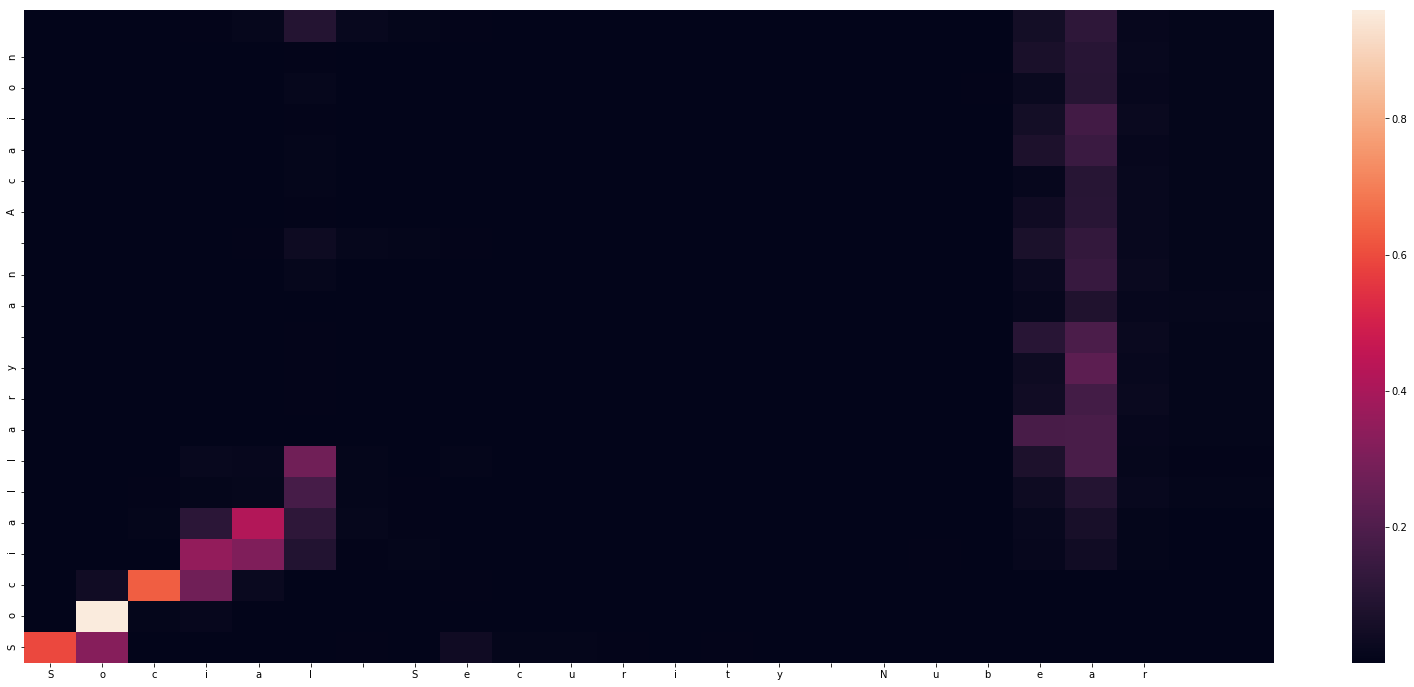

-
Input sentence: Social Security Nubear
GT sentence: Social Security Number

Decoded sentence: Sociallary an Acaion


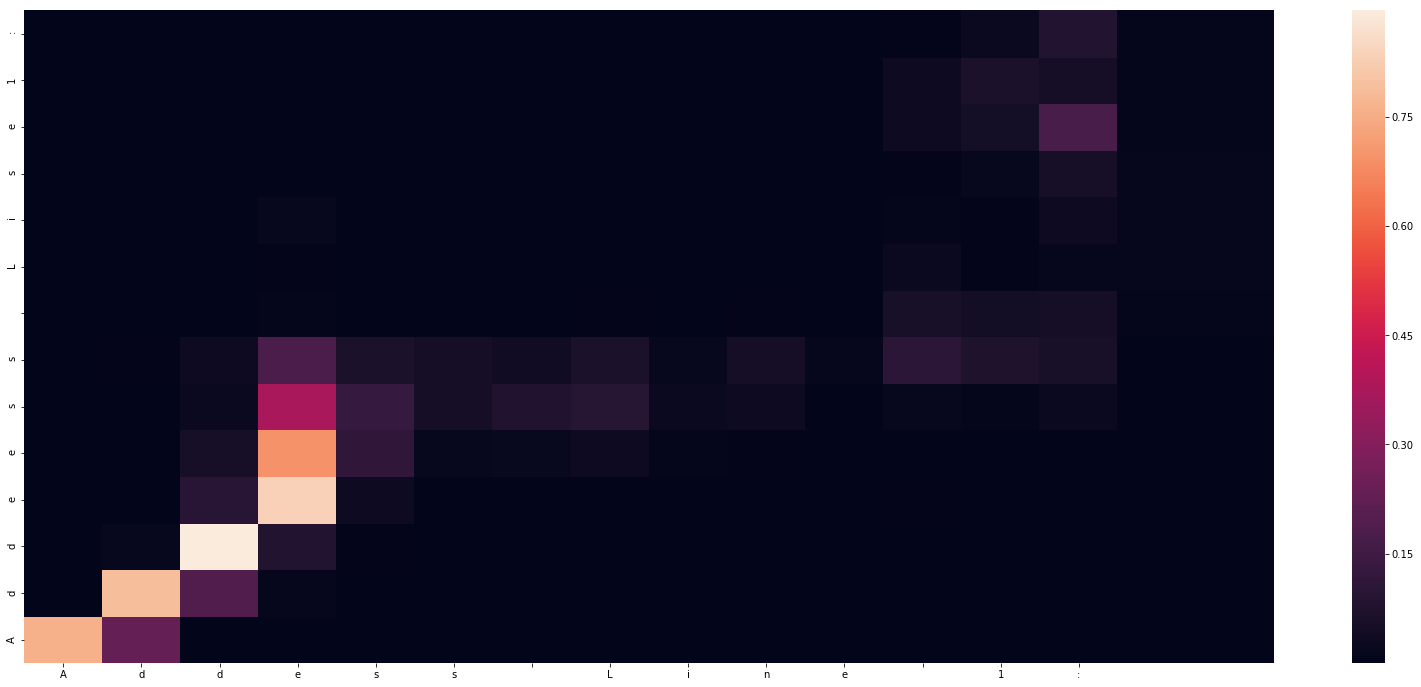

-
Input sentence: Addess Line 1:
GT sentence: Address Line 1:

Decoded sentence: Addeess Lise1:


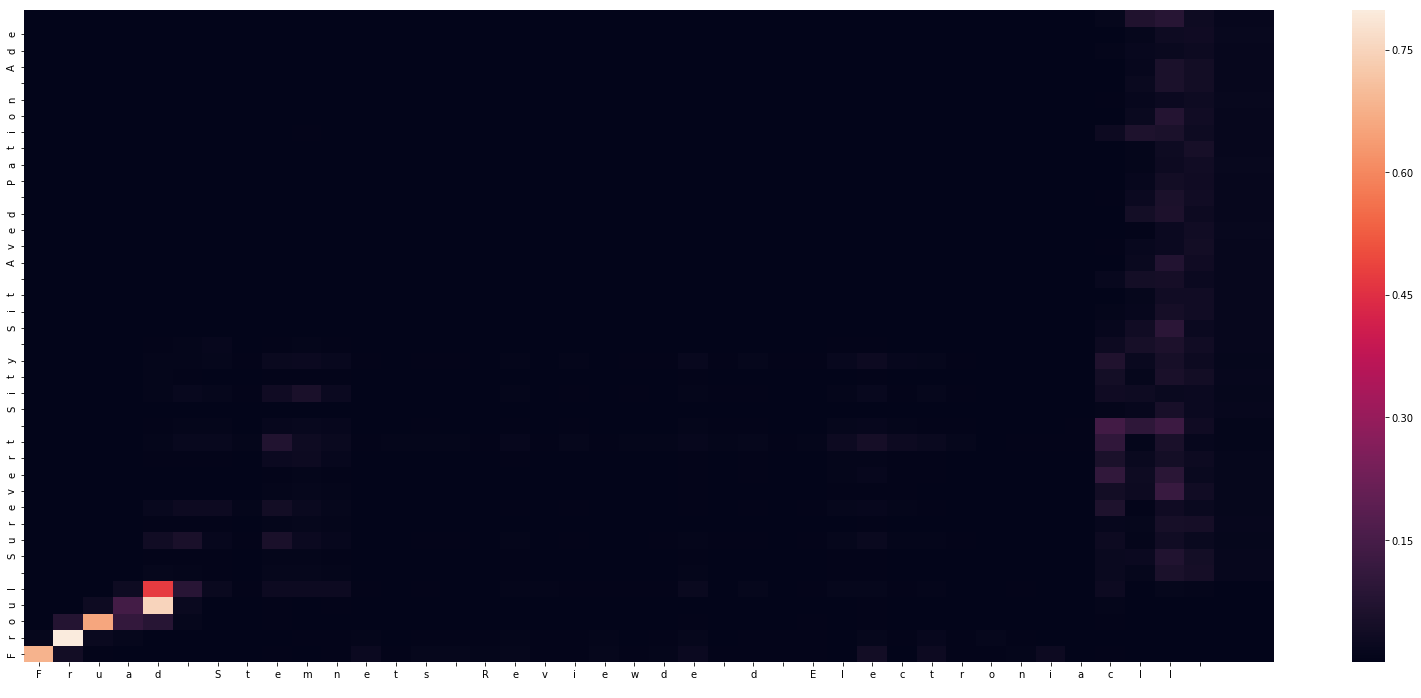

-
Input sentence: Fruad Stemnets Reviewde d Electroniacll

GT sentence: Fraud Statements Reviewed and Electronically

Decoded sentence: Froul Surevert Sity Sit Aved Pation Ade


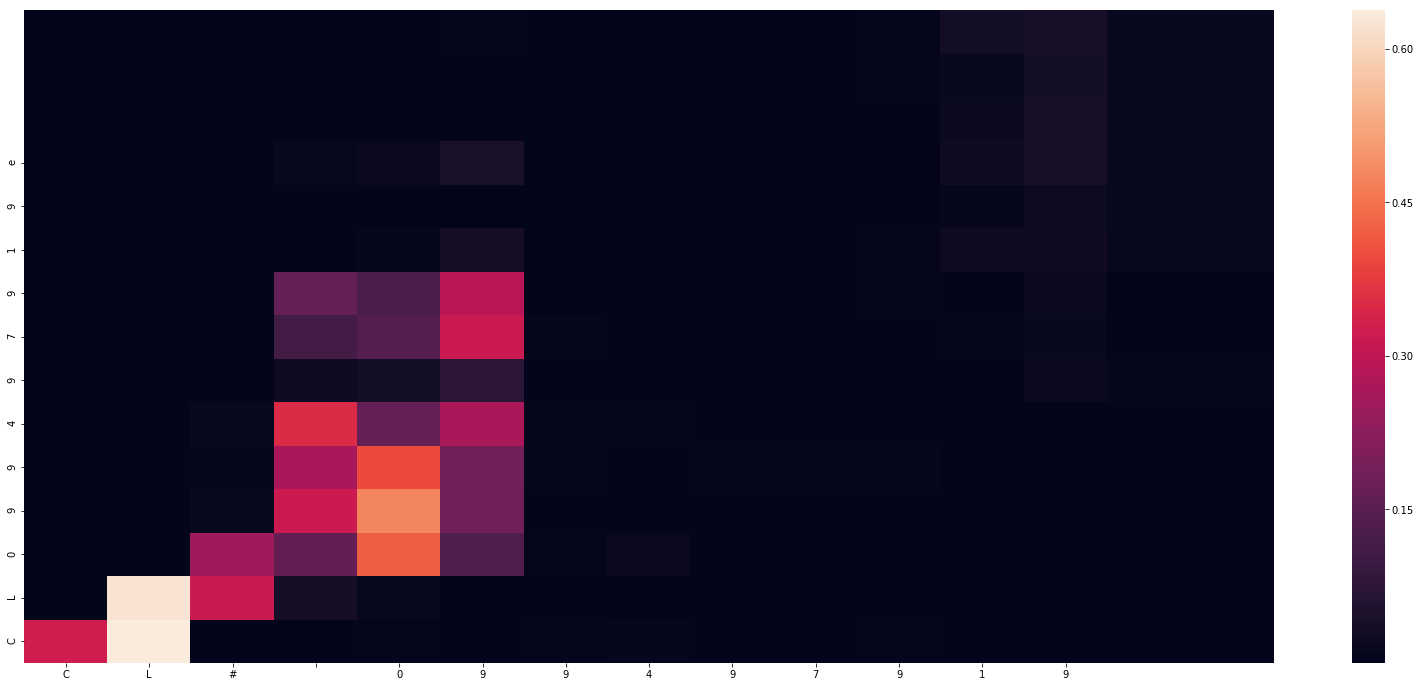

-
Input sentence: CL# 099497919
GT sentence: CL# 0994979190

Decoded sentence: CL099497919e


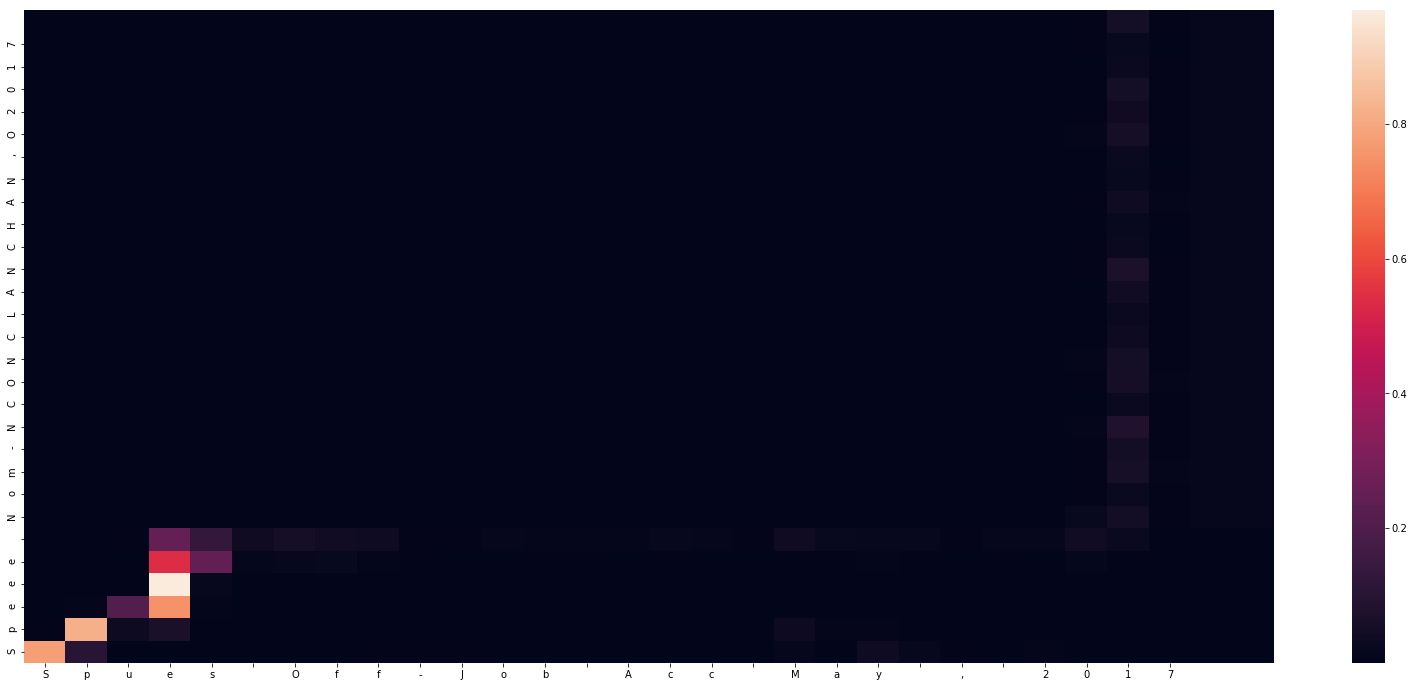

-
Input sentence: Spues Off-Job Acc May , 2017
GT sentence: Spouse Off-Job Acc May 1, 2017

Decoded sentence: Speee Nom-NCONCLANCHAN,O2017


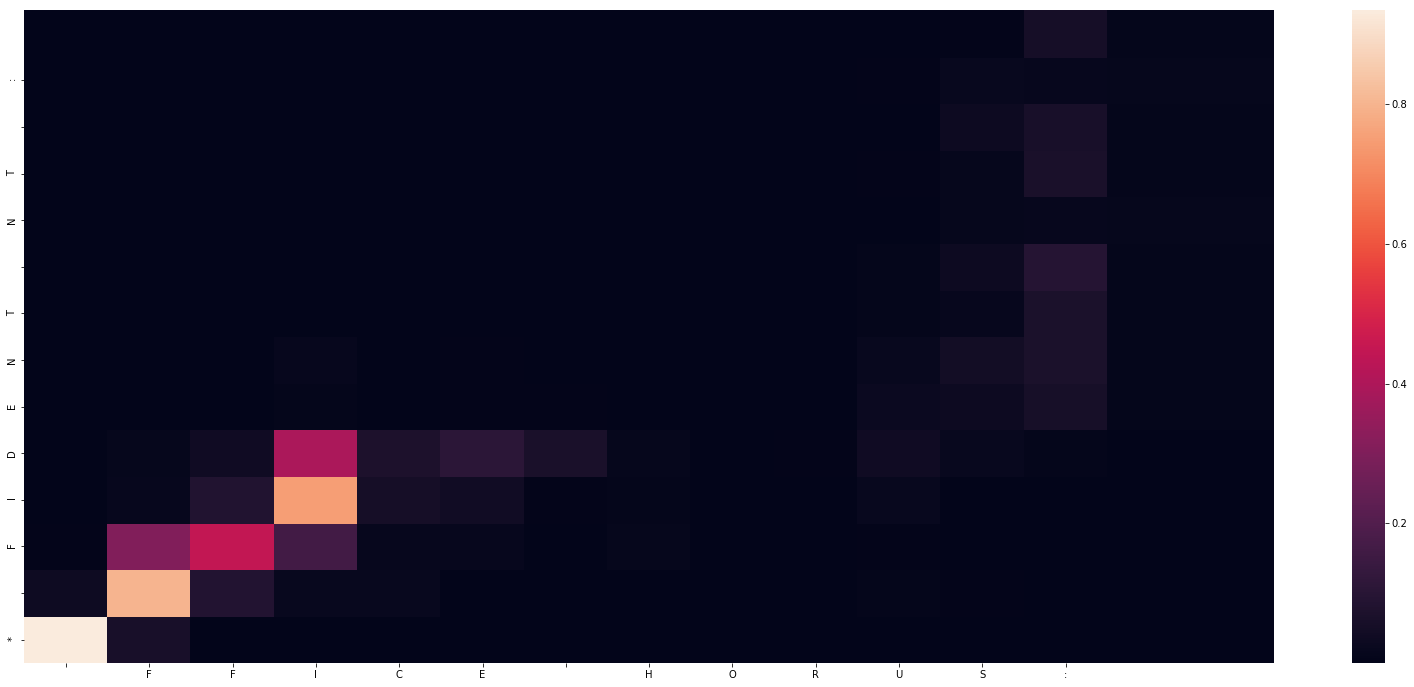

-
Input sentence:  FFICE HORUS:
GT sentence:  OFFICE HOURS:

Decoded sentence: * FIDENT NT :


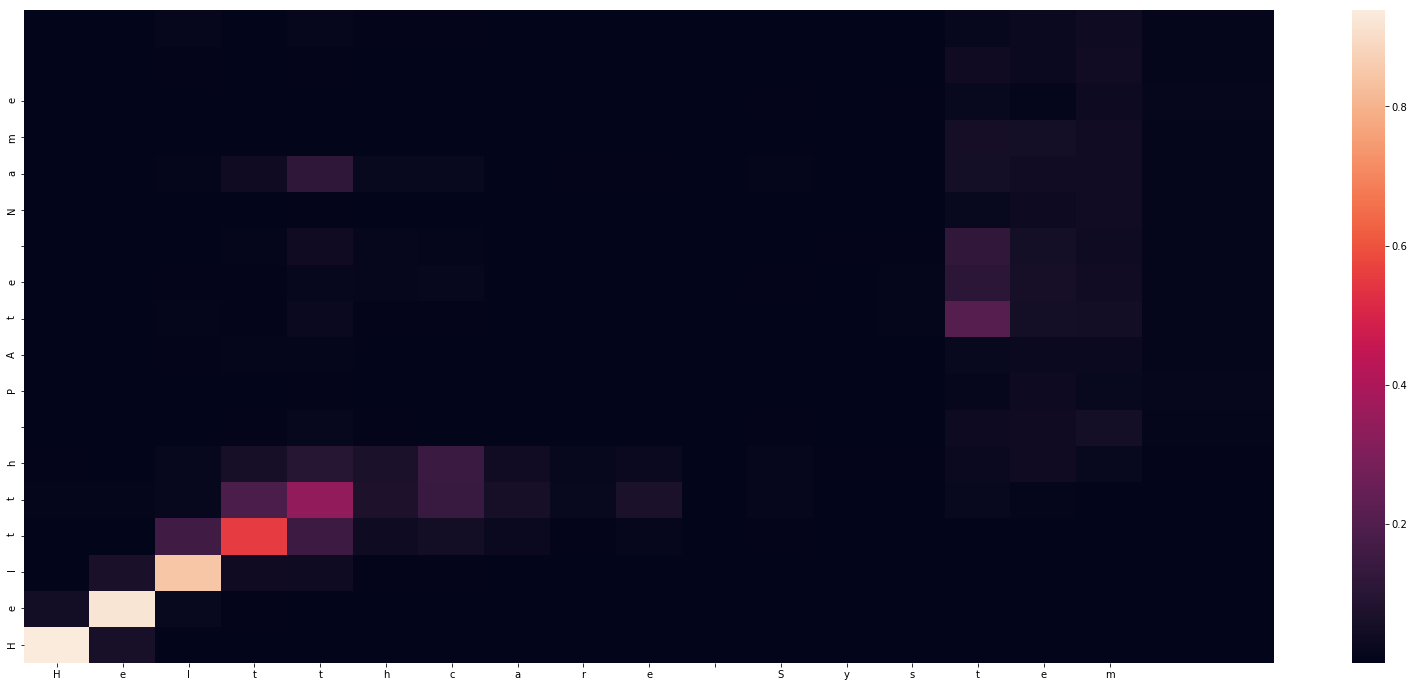

-
Input sentence: Heltthcare System
GT sentence: Healthcare System

Decoded sentence: Heltth PAte Name


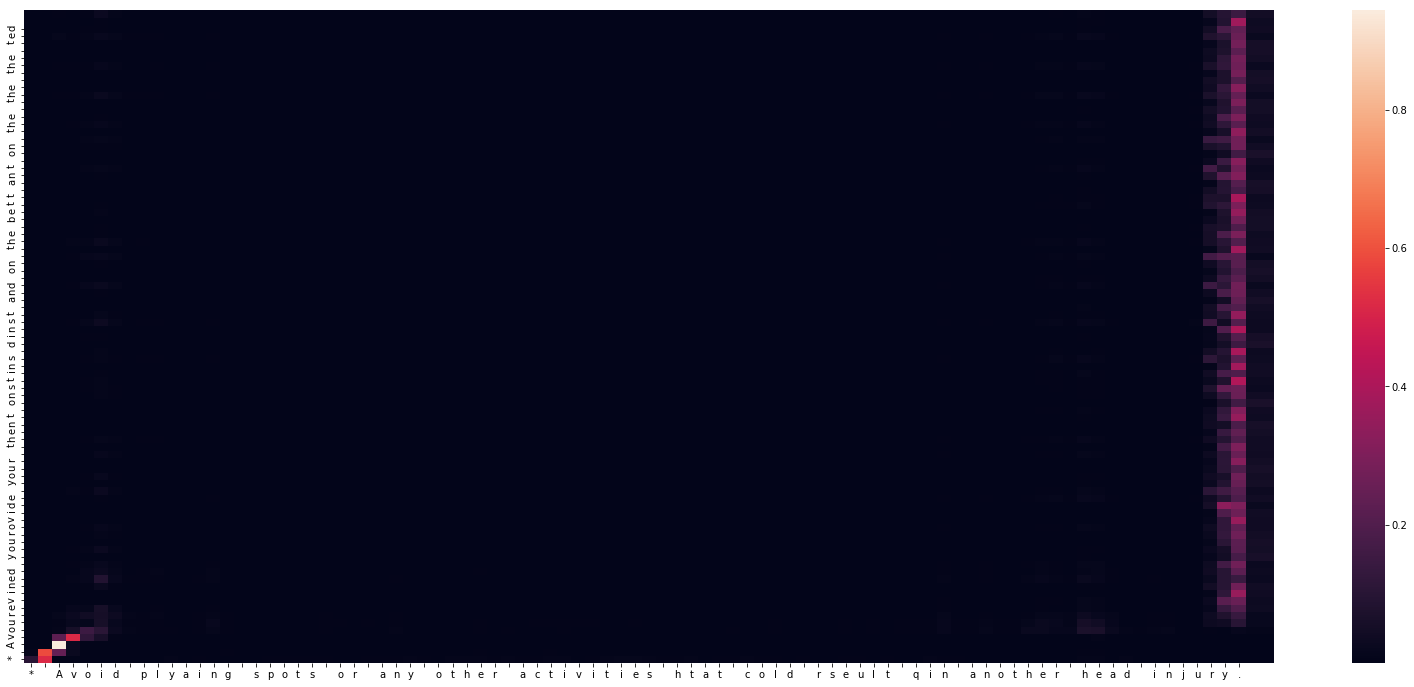

-
Input sentence: * Avoid plyaing spots or any other activities htat cold rseult qin another head injury.
GT sentence: * Avoid playing sports or any other activities that could result in another head injury.

Decoded sentence: * Avourevined yourovide your thent onstins dinst and on the bett ant on the the the ted


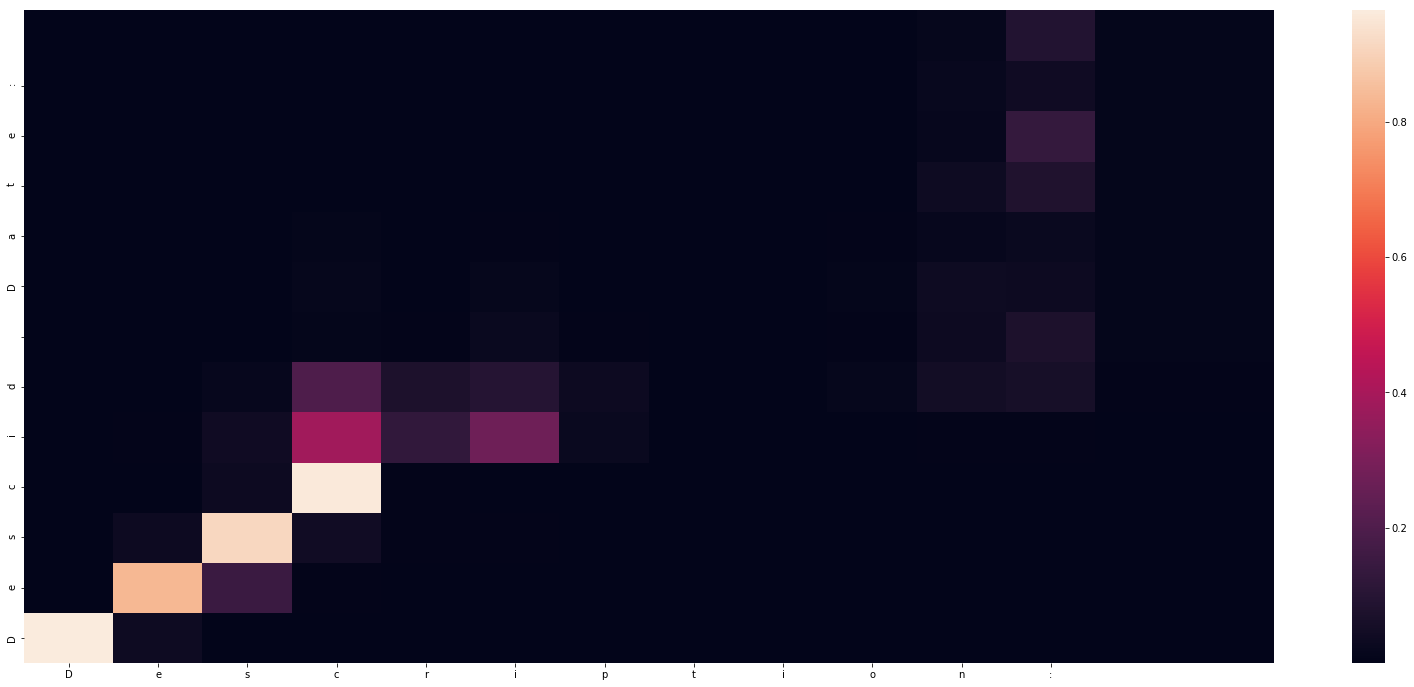

-
Input sentence: Description:
GT sentence: Description:

Decoded sentence: Descid Date:


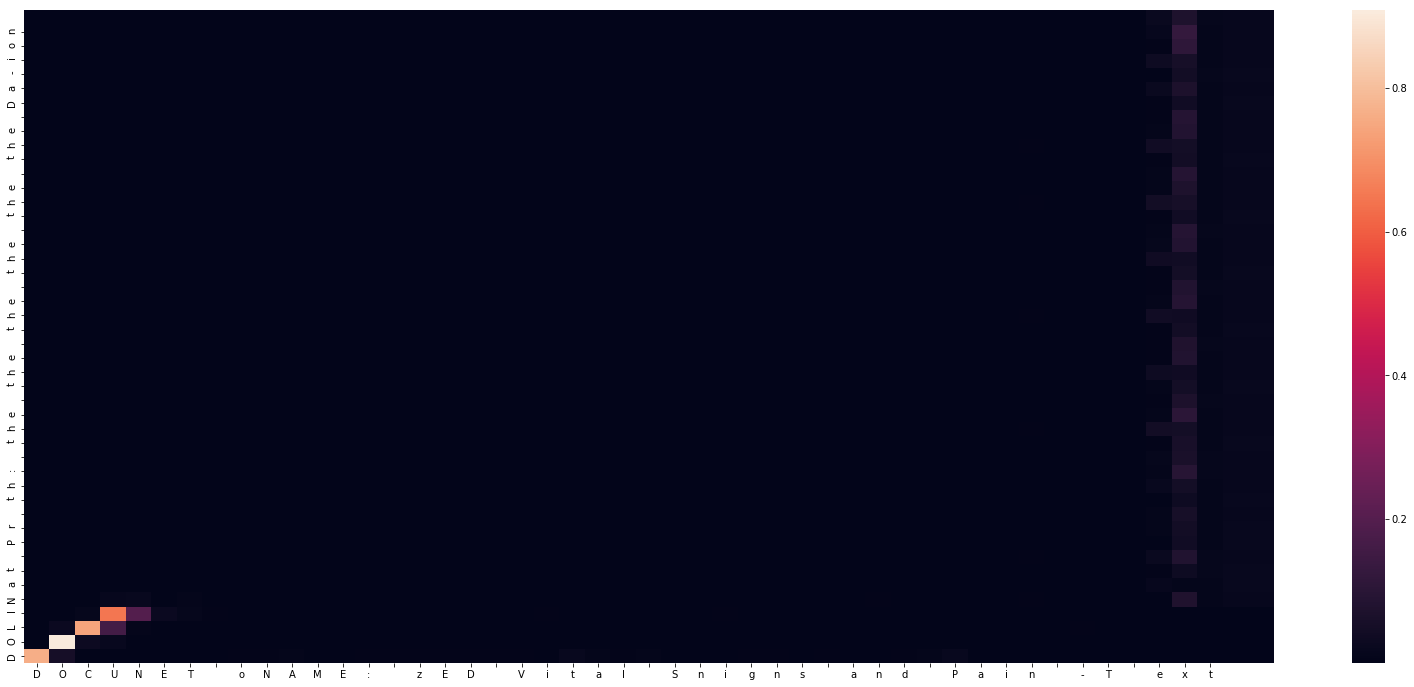

-
Input sentence: DOCUNET oNAME: zED Vital Snigns and Pain -T ext
GT sentence: DOCUMENT NAME: ED Vital Signs and Pain - Text

Decoded sentence: DOLINat Pr th: the the the the the the Da-ion


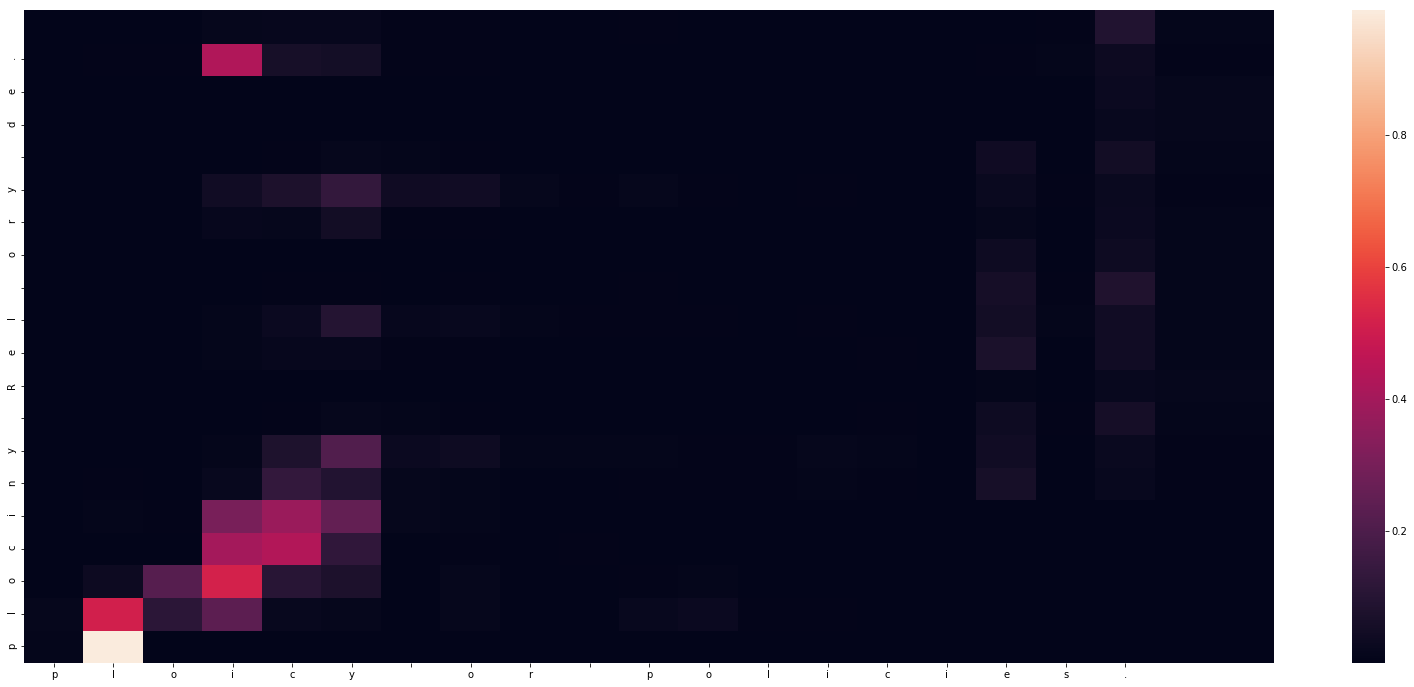

-
Input sentence: ploicy or policies.
GT sentence: policy or policies.

Decoded sentence: plociny Rel ory de.


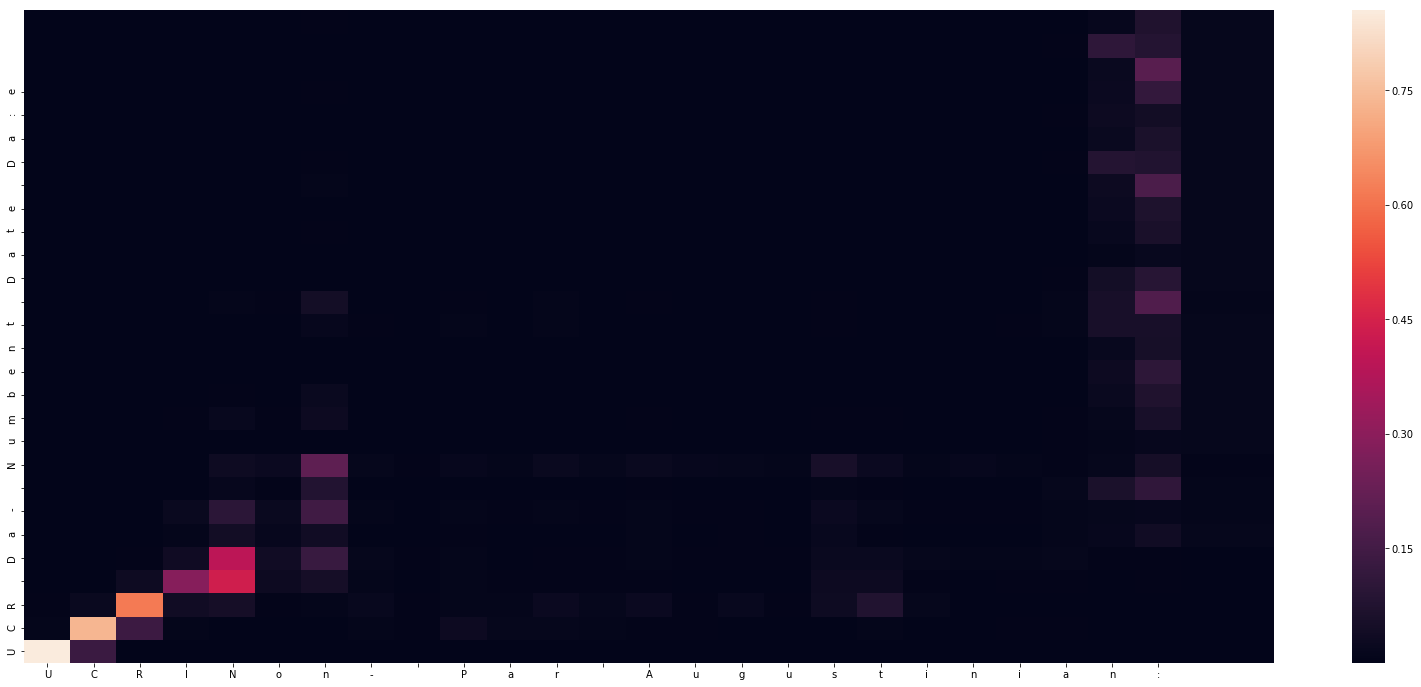

-
Input sentence: UCRlNon- Par Augustinian:
GT sentence: URC/Non-Par Adjustment

Decoded sentence: UCR Da- Numbent Date Da:e


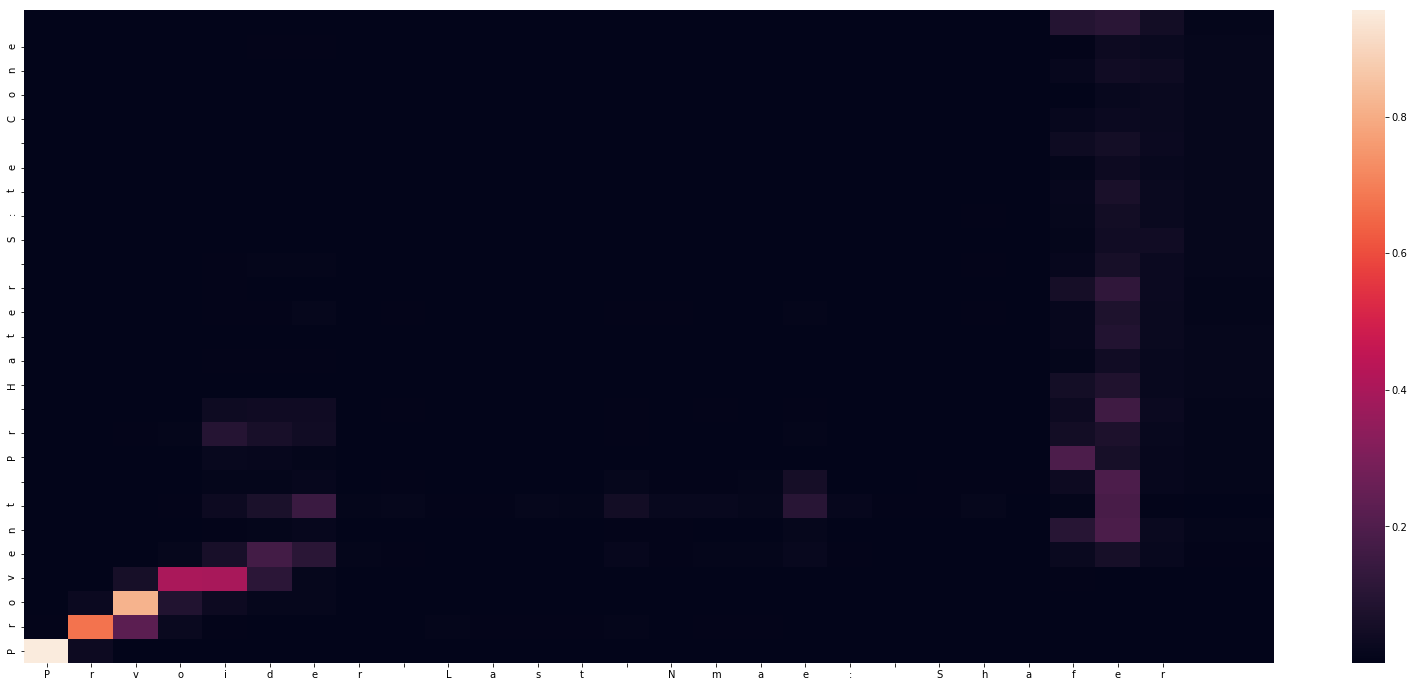

-
Input sentence: Prvoider Last Nmae: Shafer
GT sentence: Provider Last Name: Shaffer

Decoded sentence: Provent Pr Hater S:te Cone


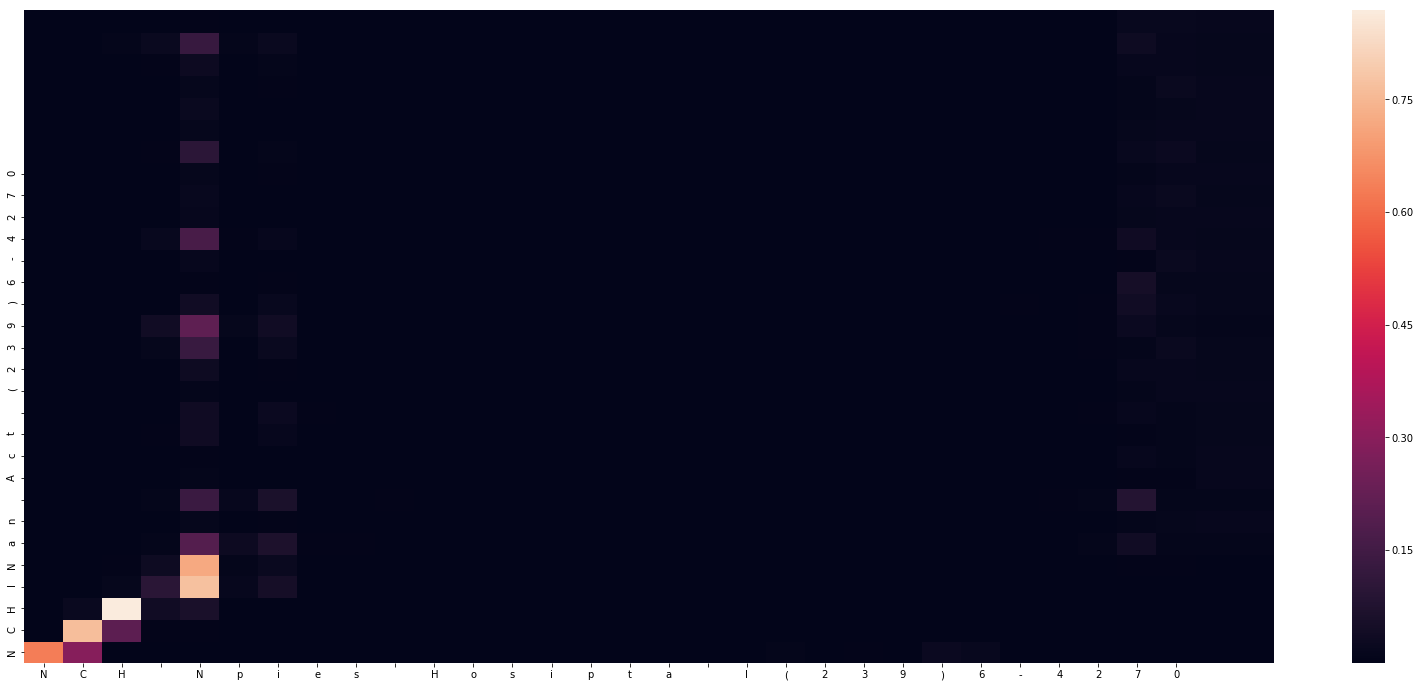

-
Input sentence: NCH Npies Hosipta l(239)6-4270
GT sentence: NCH Napies Hospital (239) 624-2700

Decoded sentence: NCHINan Act (239)6-4270


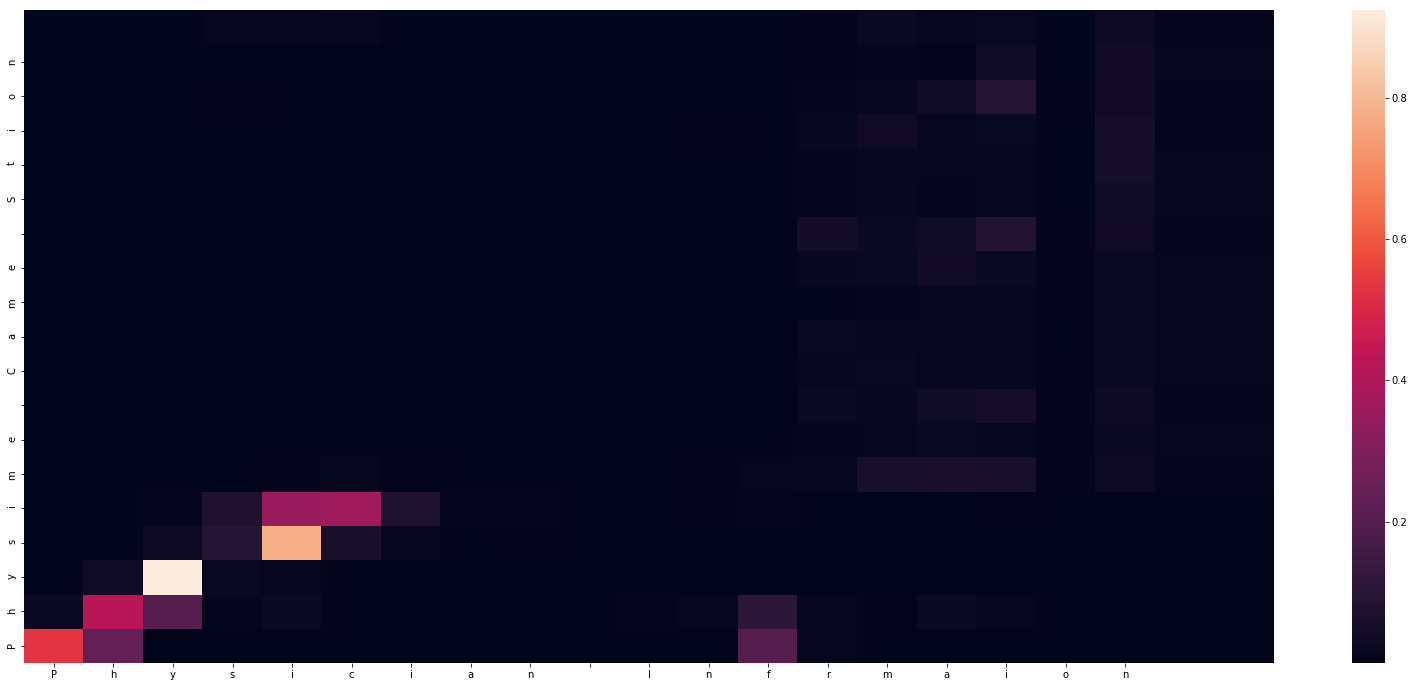

-
Input sentence: Physician Infrmaion
GT sentence: Physician Information

Decoded sentence: Physime Came Stion


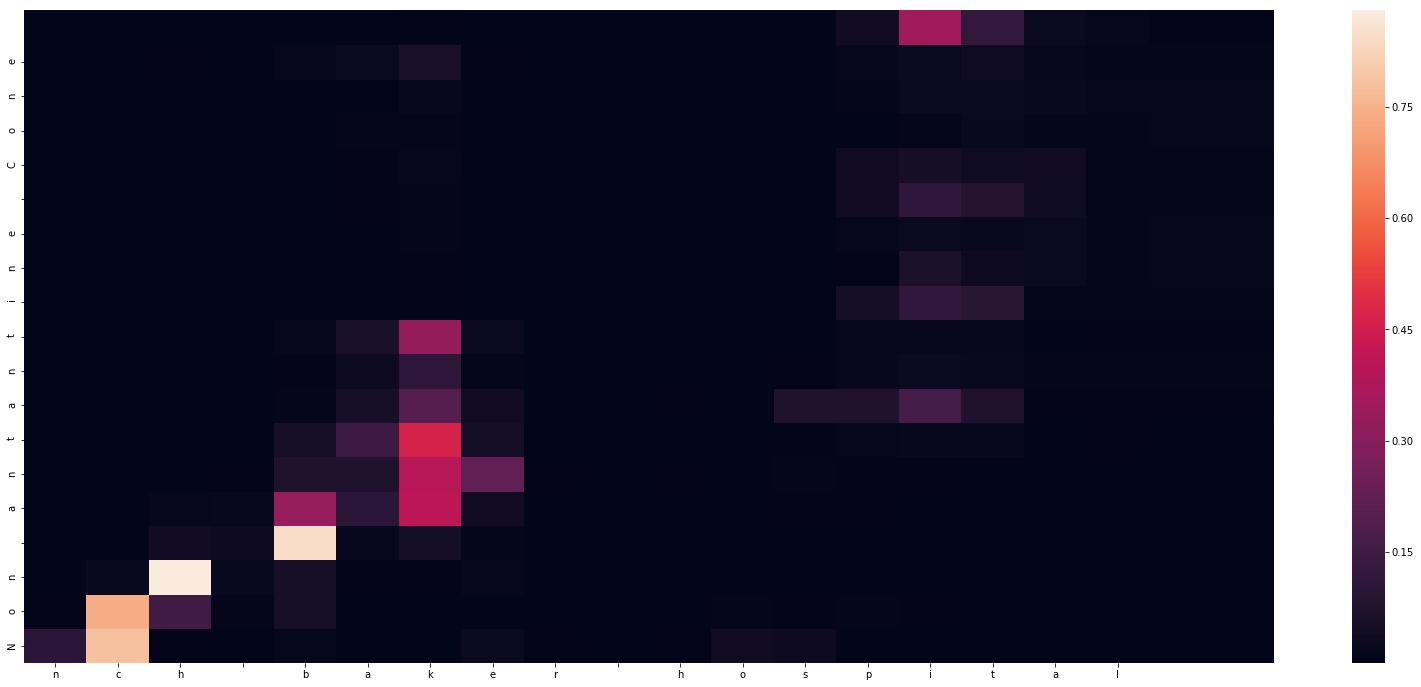

-
Input sentence: nch baker hospital
GT sentence: NCH BAKER HOSPITAL

Decoded sentence: Non antantine Cone


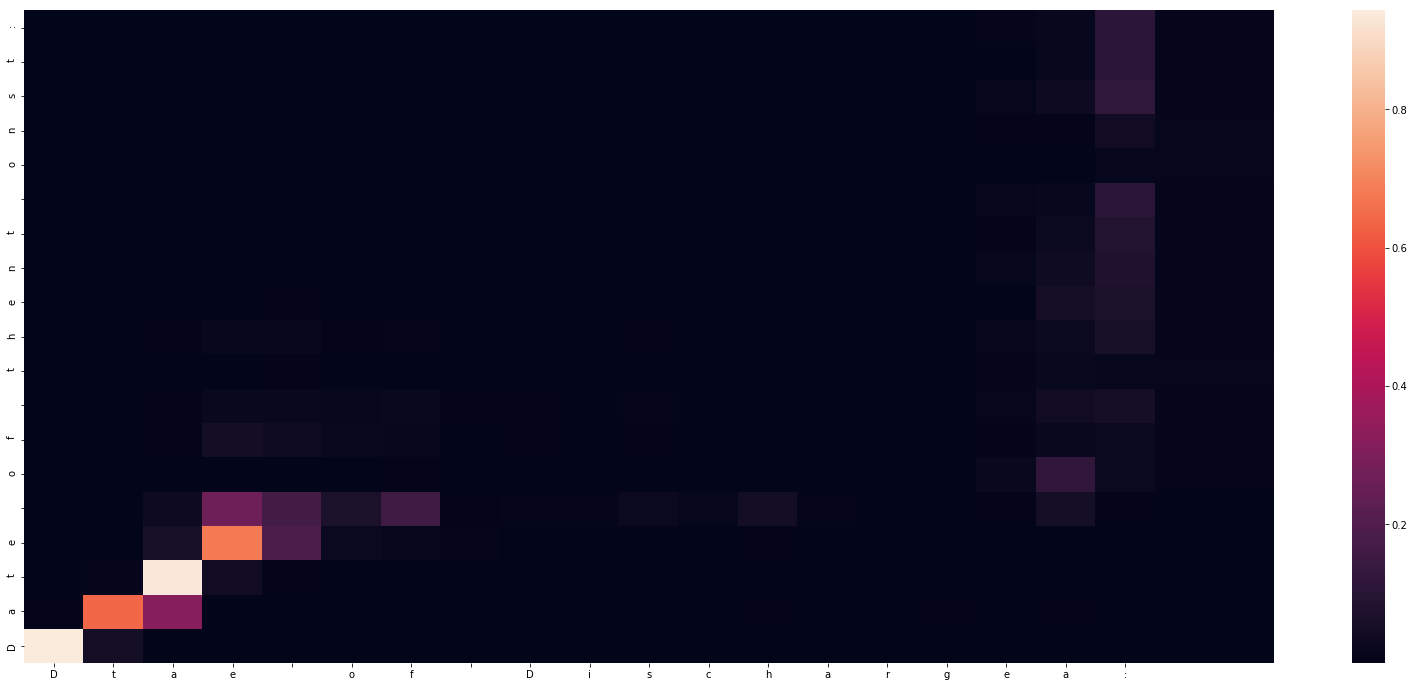

-
Input sentence: Dtae of Dischargea:
GT sentence: Date of Discharge:

Decoded sentence: Date of thent onst:


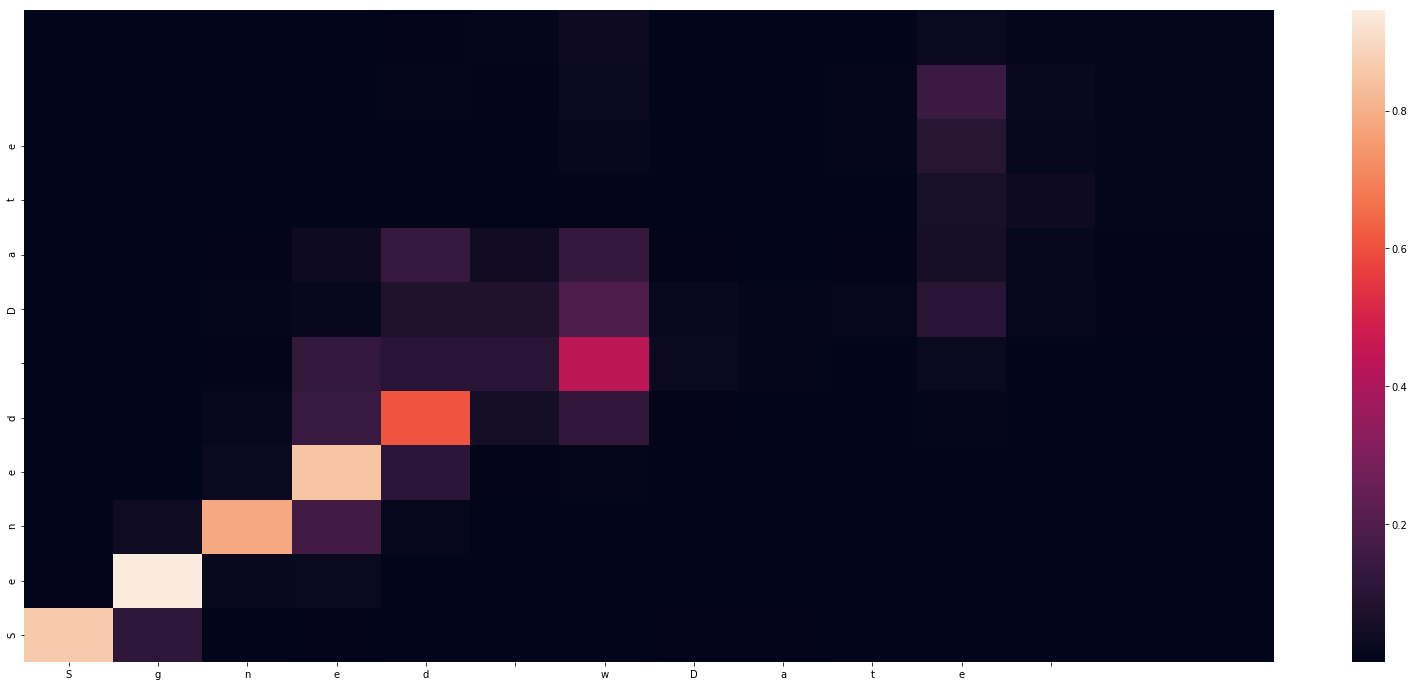

-
Input sentence: Sgned wDate

GT sentence: Signed Date:

Decoded sentence: Sened Date


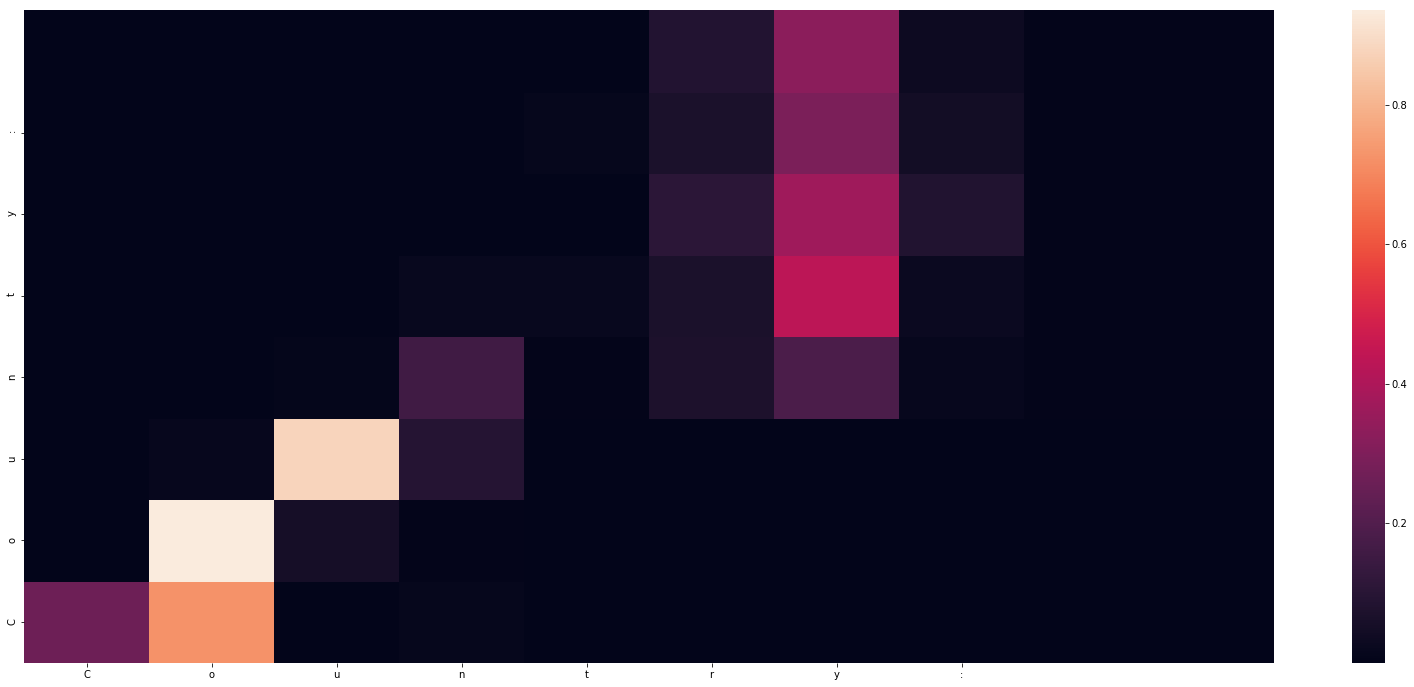

-
Input sentence: Country:
GT sentence: Country:

Decoded sentence: County:


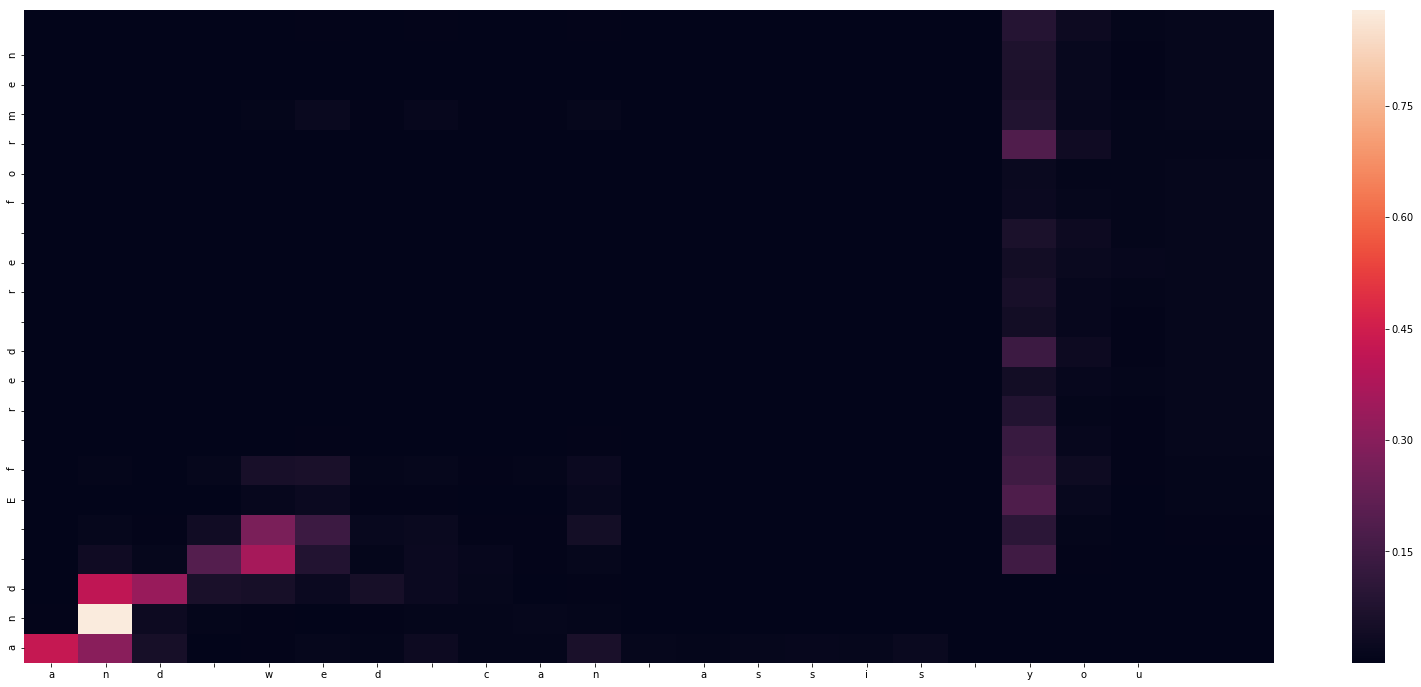

-
Input sentence: and wed can assis you
GT sentence: and we can assist you.

Decoded sentence: and  Ef red re formen


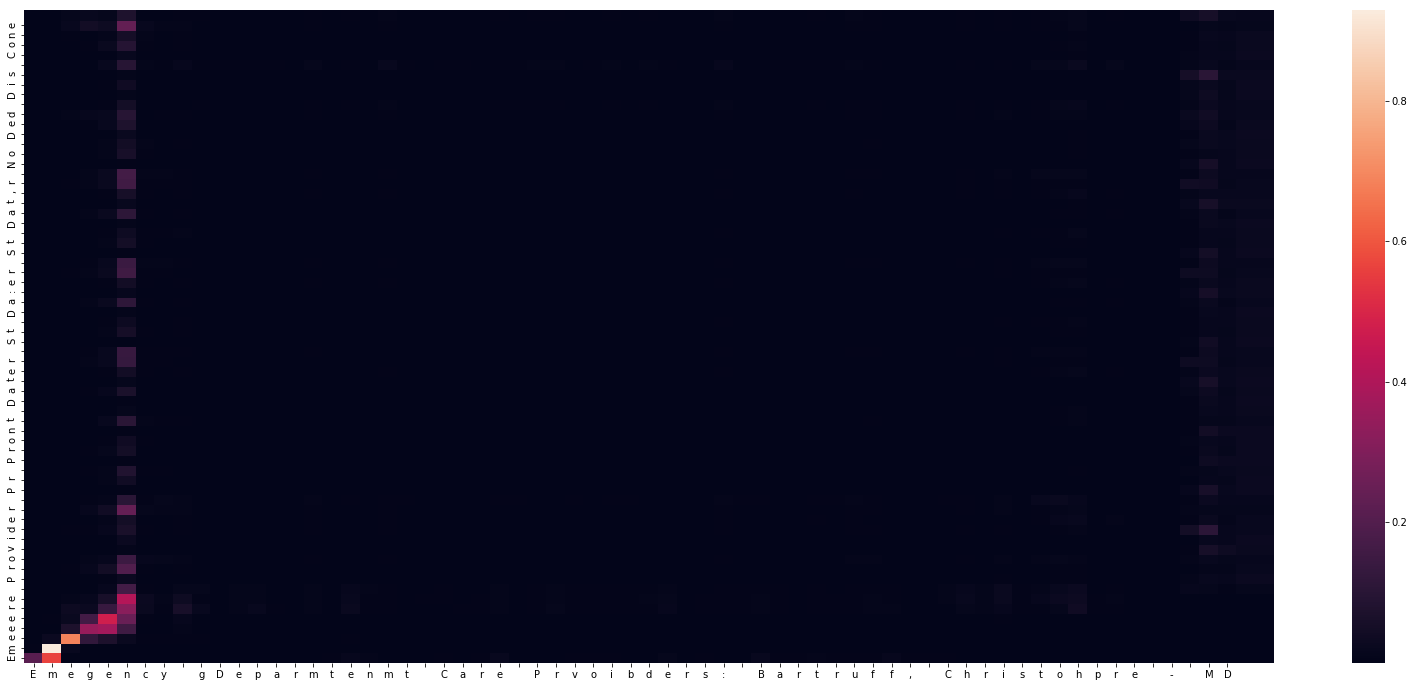

-
Input sentence: Emegency gDeparmtenmt Care Prvoibders: Bartruff, Christohpre - MD
GT sentence: Emergency Department Care Providers: Bartruff, Christopher - MD

Decoded sentence: Emeeere Provider Pr Pront Dater St Da:er St Dat,r No Ded Dis Cone


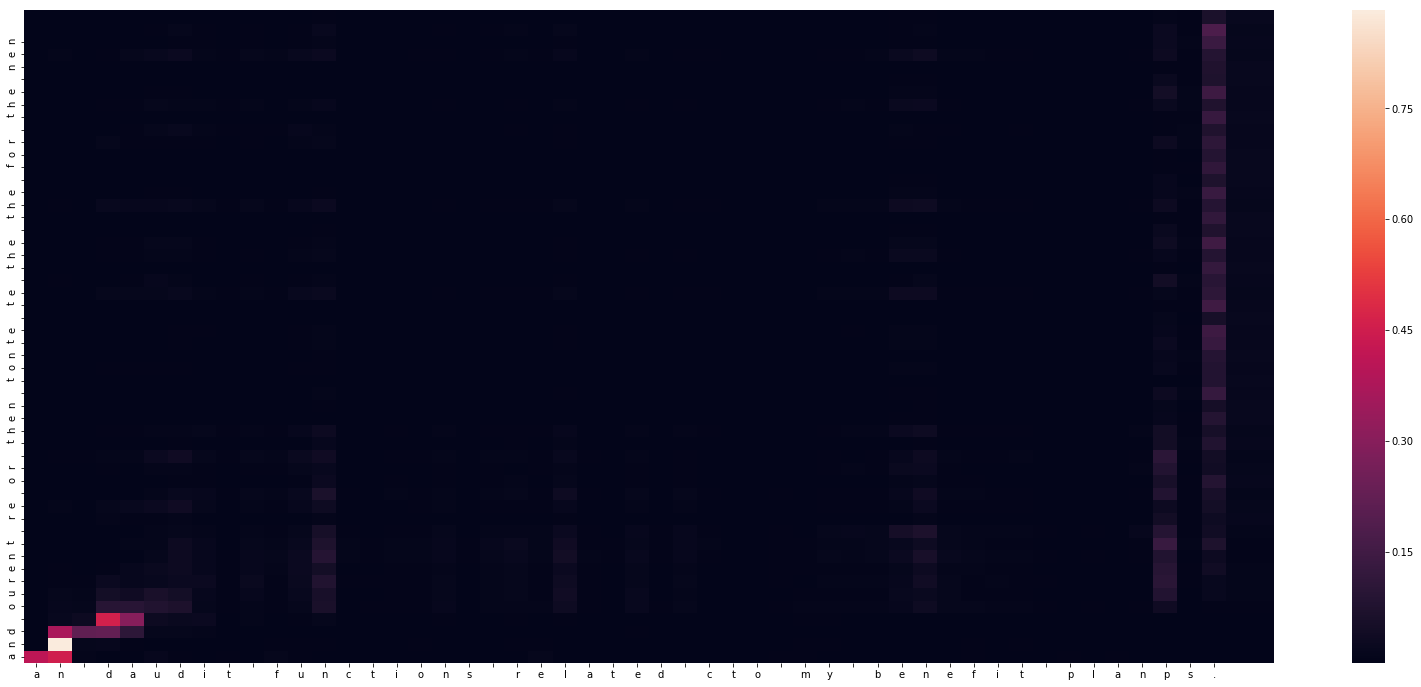

-
Input sentence: an daudit functions related cto my benefit planps.
GT sentence: and audit functions related to my benefit plans.

Decoded sentence: and ourent re or then tonte te the the for the nen


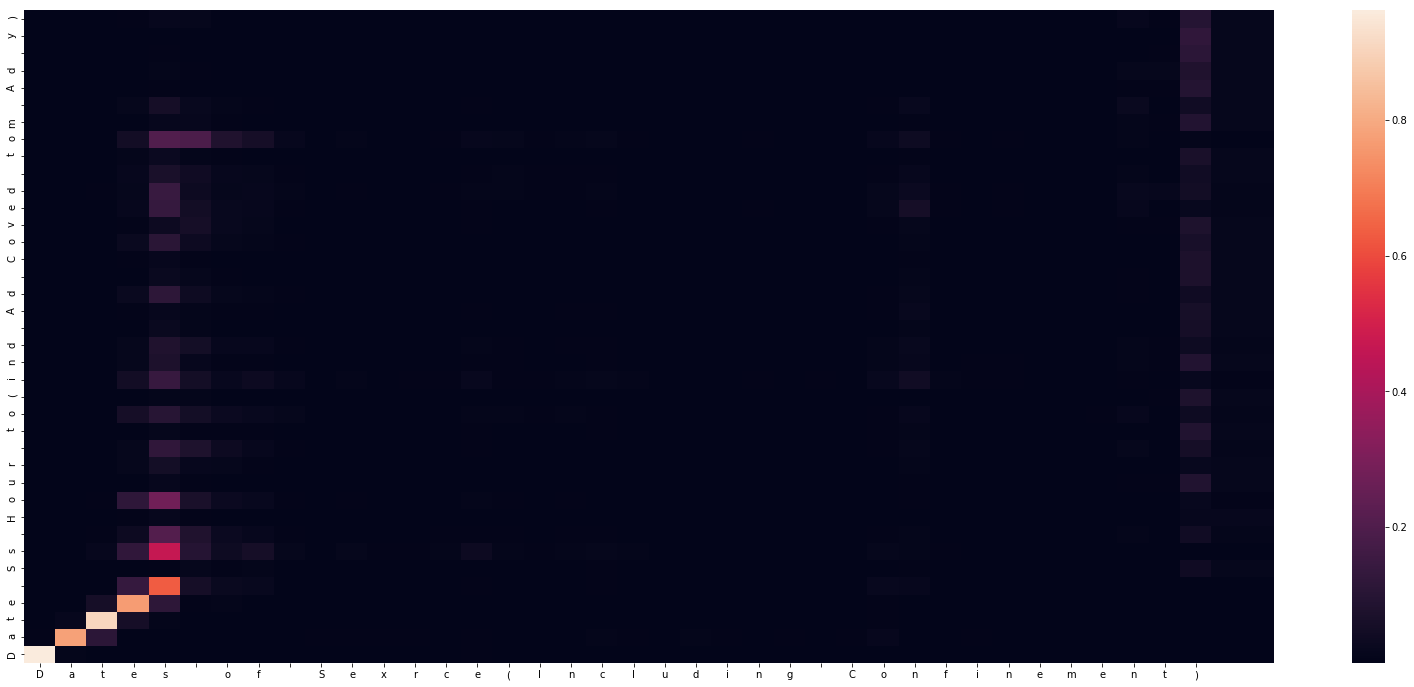

-
Input sentence: Dates of Sexrce(Including Confinement)
GT sentence: Dates of Service(Including Confinement)

Decoded sentence: Date Ss Hour to(ind Ad Coved tom Ad y)


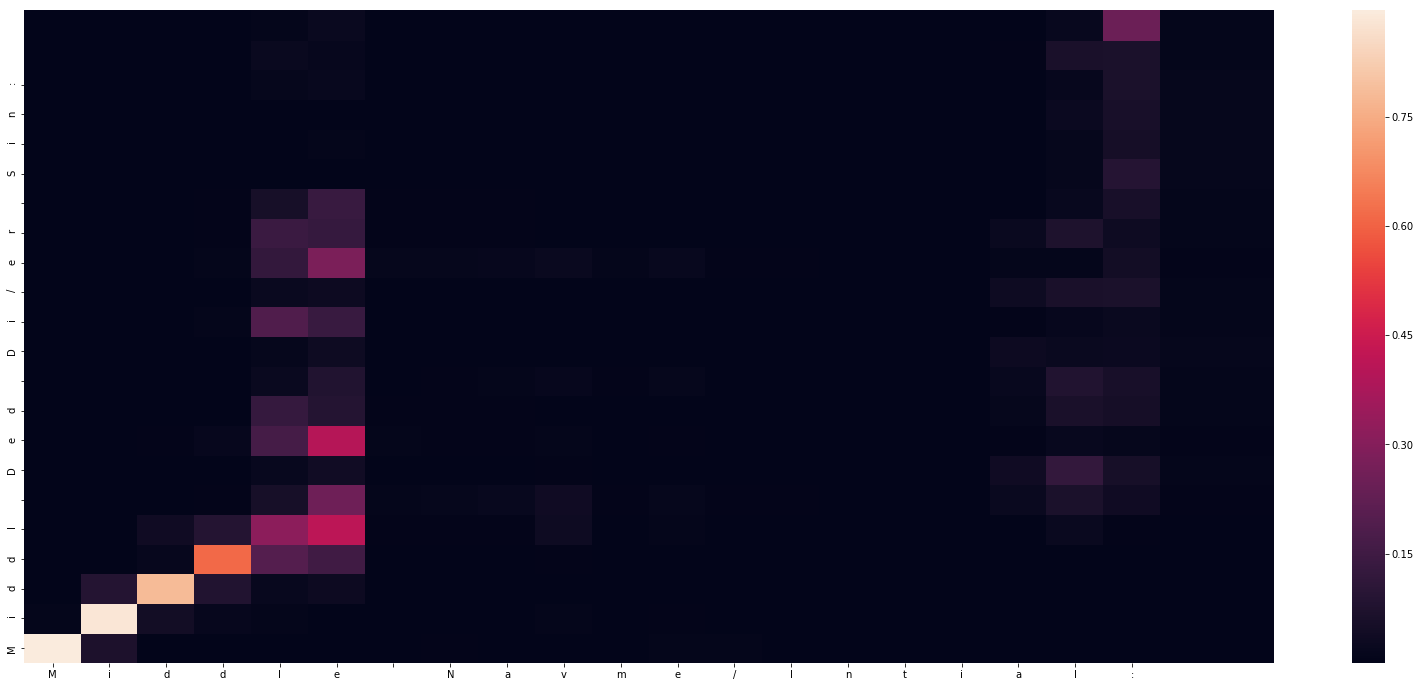

-
Input sentence: Middle Navme/Intial:
GT sentence: Middle Name/Initial:

Decoded sentence: Middl Ded Di/er Sin:


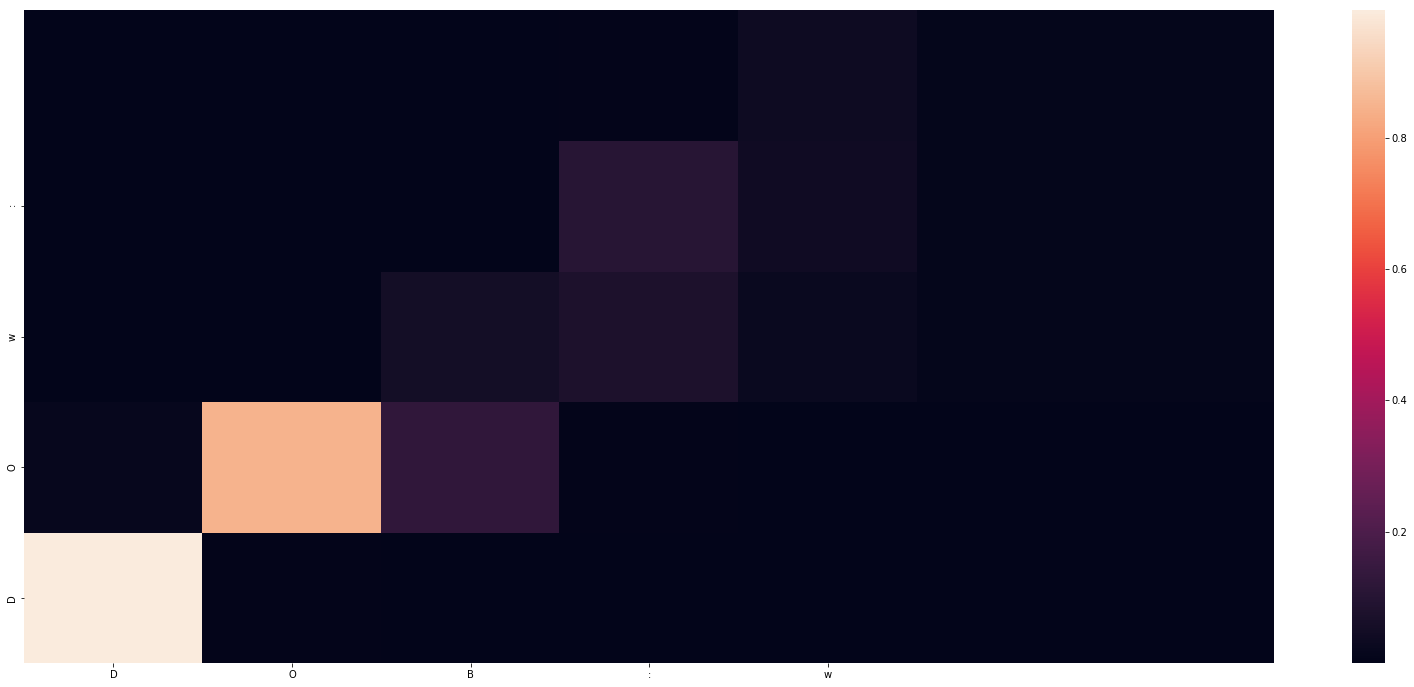

-
Input sentence: DOB:w
GT sentence: DOB:

Decoded sentence: DOw:


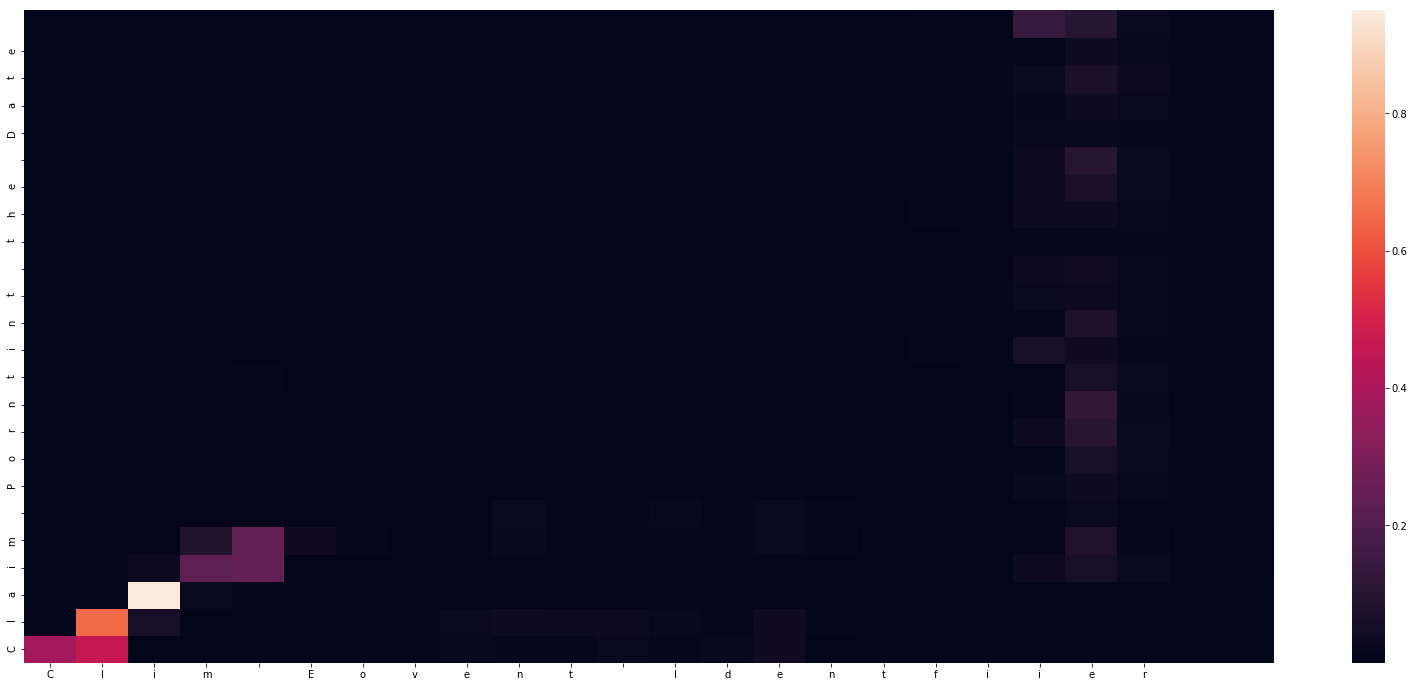

-
Input sentence: Clim Eovent Identfiier
GT sentence: Claim Event Identifier

Decoded sentence: Claim Porntint the Date


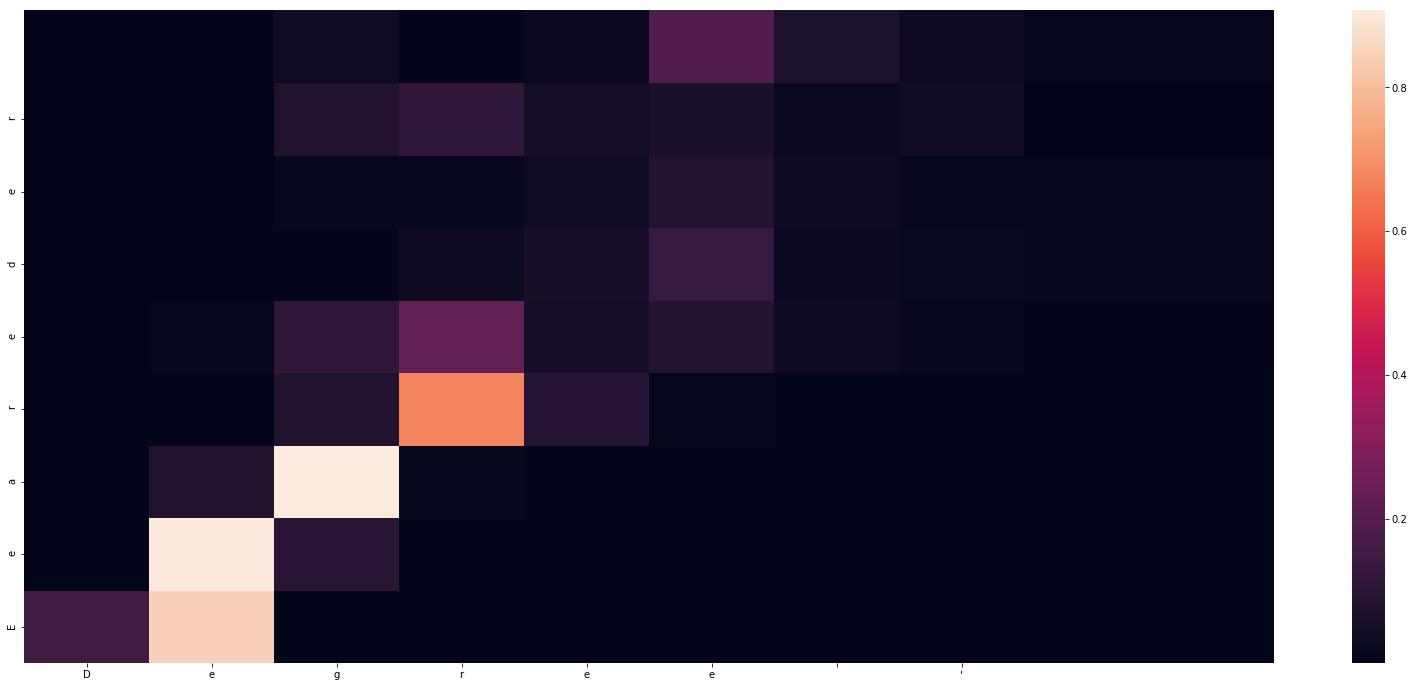

-
Input sentence: Degree '
GT sentence: Degree

Decoded sentence: Eeareder


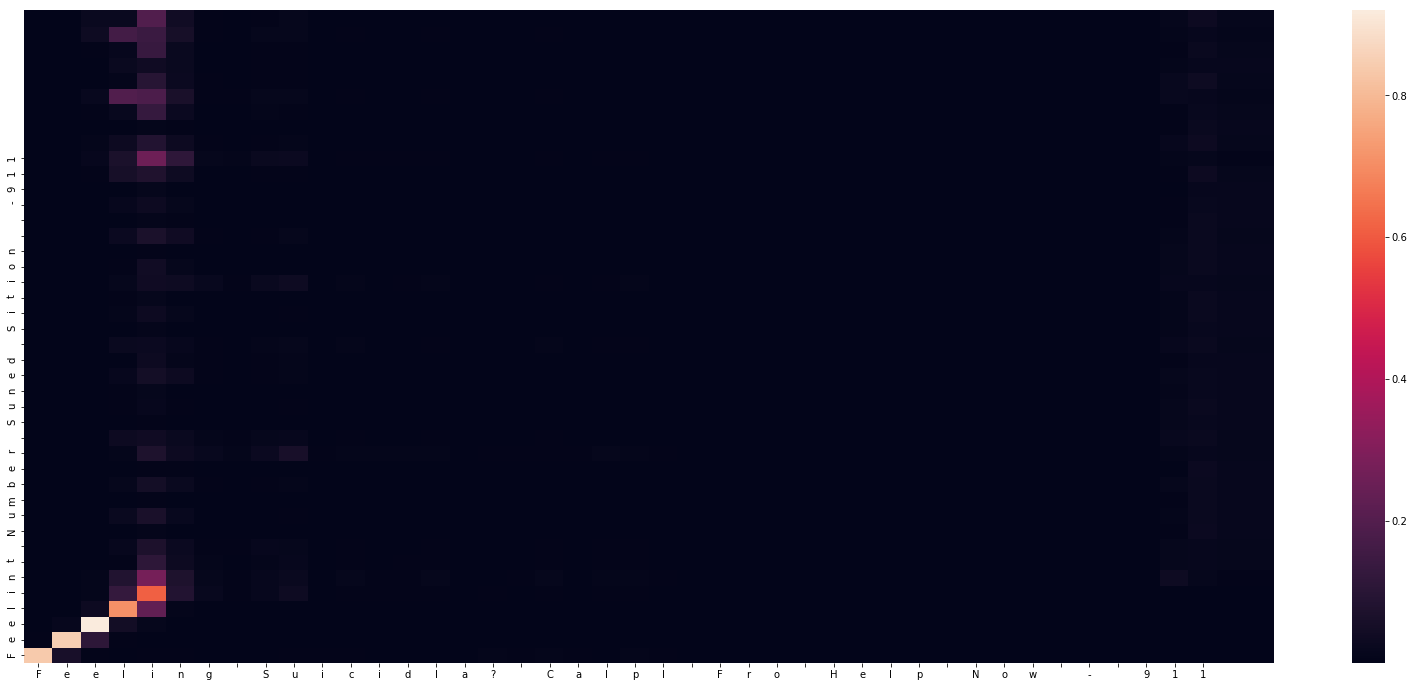

-
Input sentence: Feeling Suicidla? Calpl Fro Help Now - 911
GT sentence: Feeling Suicidal? Call For Help Now - 911

Decoded sentence: Feelint Number Suned Sition  -911


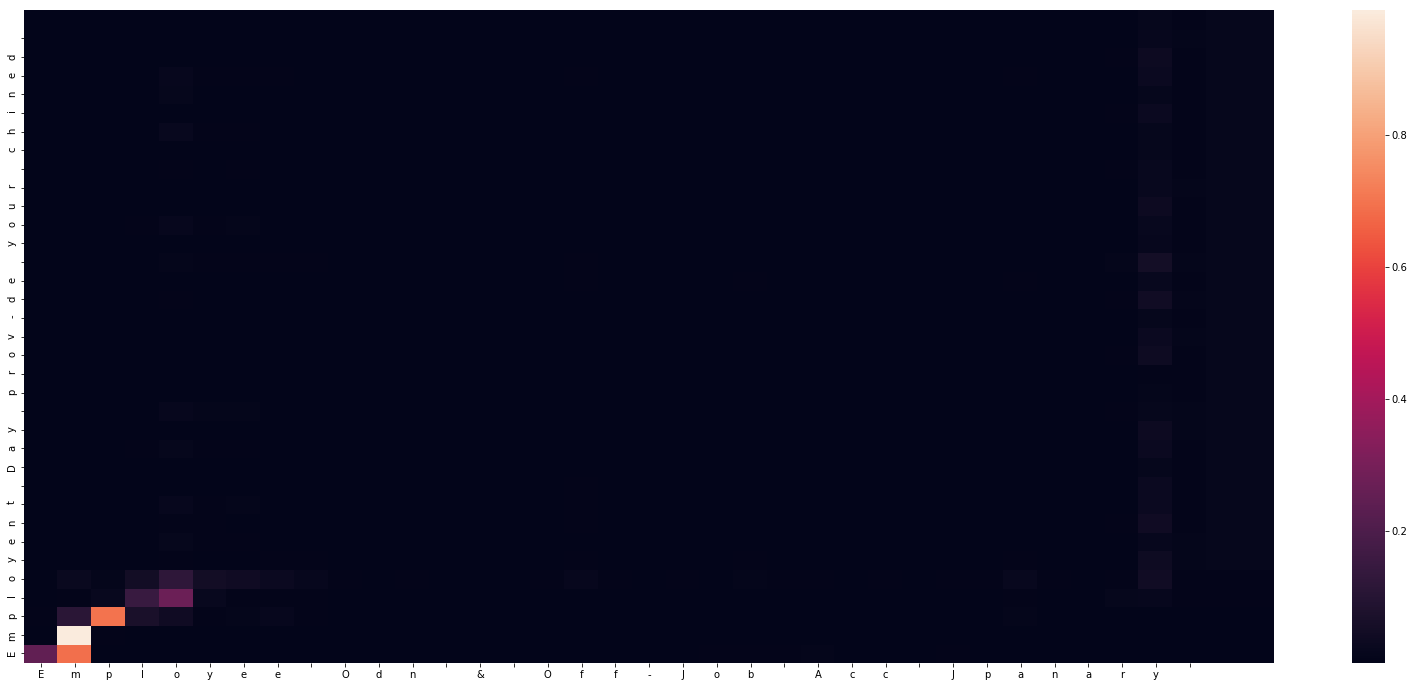

-
Input sentence: Employee Odn & Off-Job Acc Jpanary 
GT sentence: Employee On & Off-Job Acc January 

Decoded sentence: Employent Day prov-de your chined 


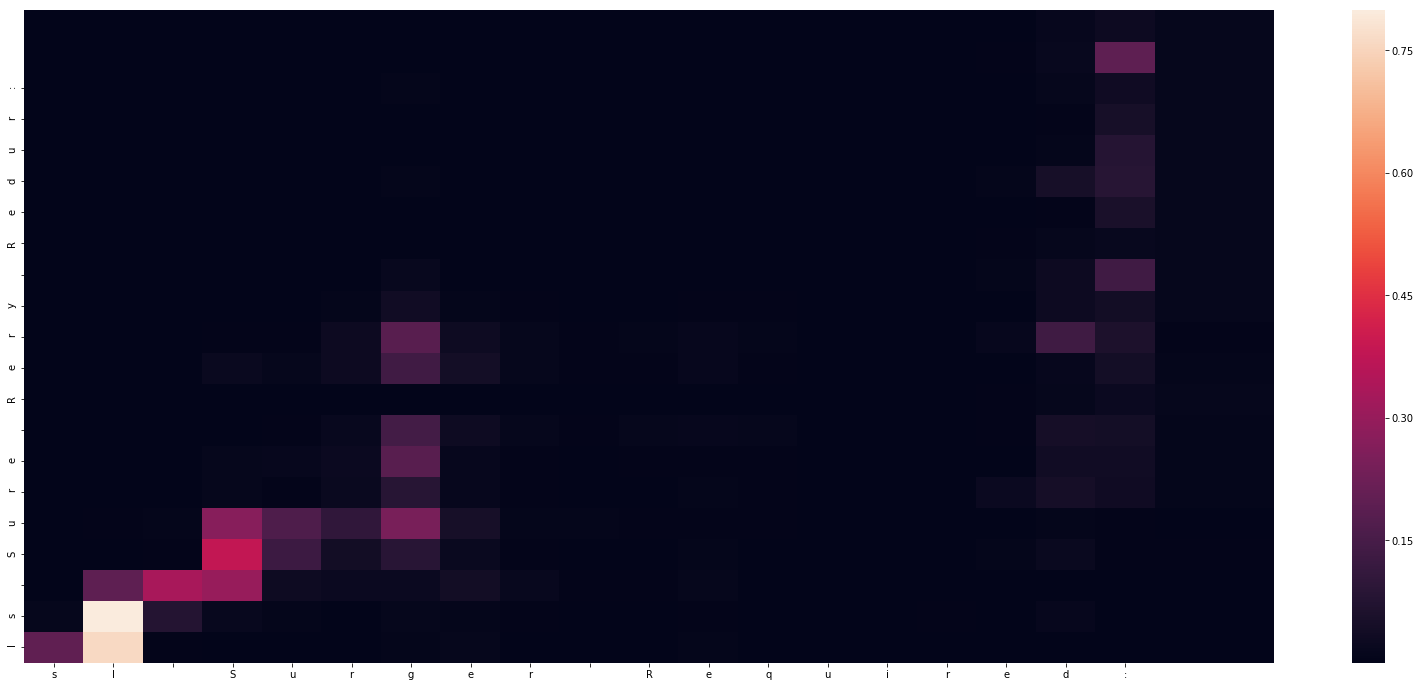

-
Input sentence: sI Surger Required:
GT sentence: Is Surgery Required:

Decoded sentence: Is Sure Rery Redur:


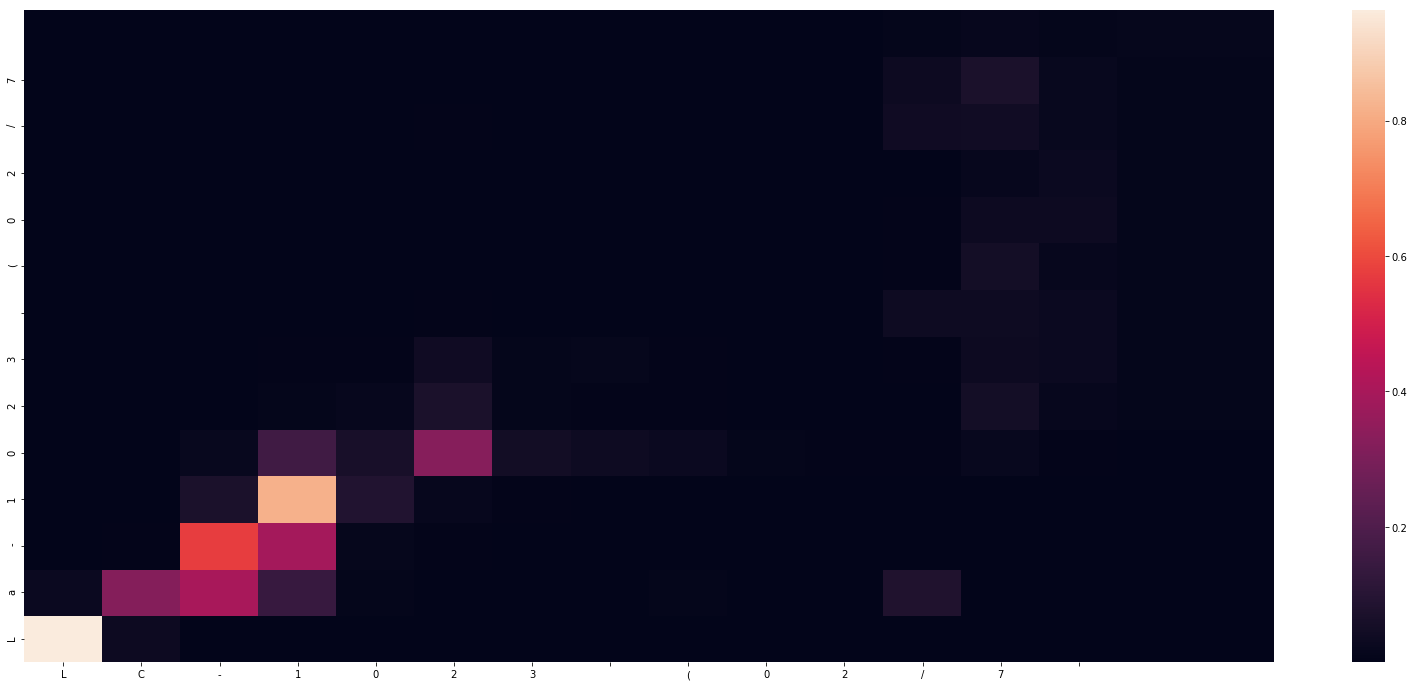

-
Input sentence: LC-1023 (02/7

GT sentence: CL-1023 (02/17)

Decoded sentence: La-1023 (02/7


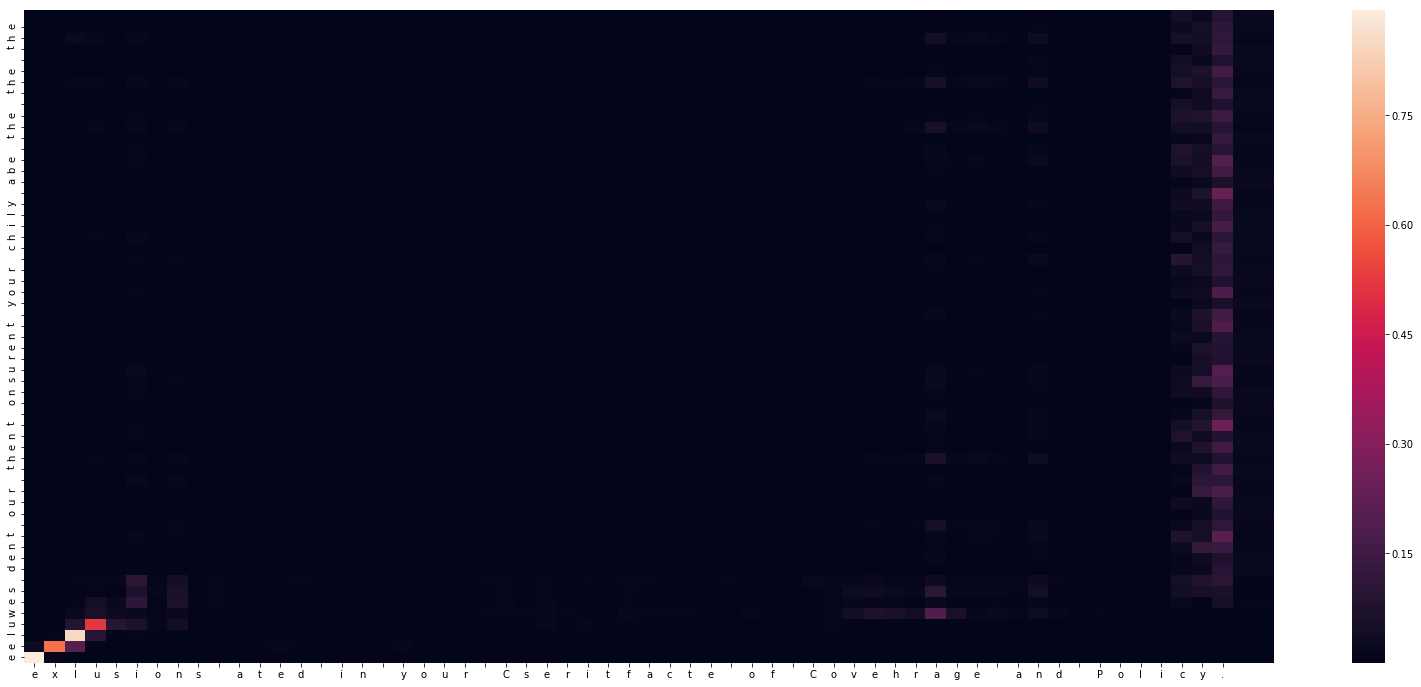

-
Input sentence: exlusions ated in your Cseritfacte of Covehrage and Policy.
GT sentence: exclusions stated in your Certificate of Coverage and Policy.

Decoded sentence: eeluwes dent our thent onsurent your chily abe the the the


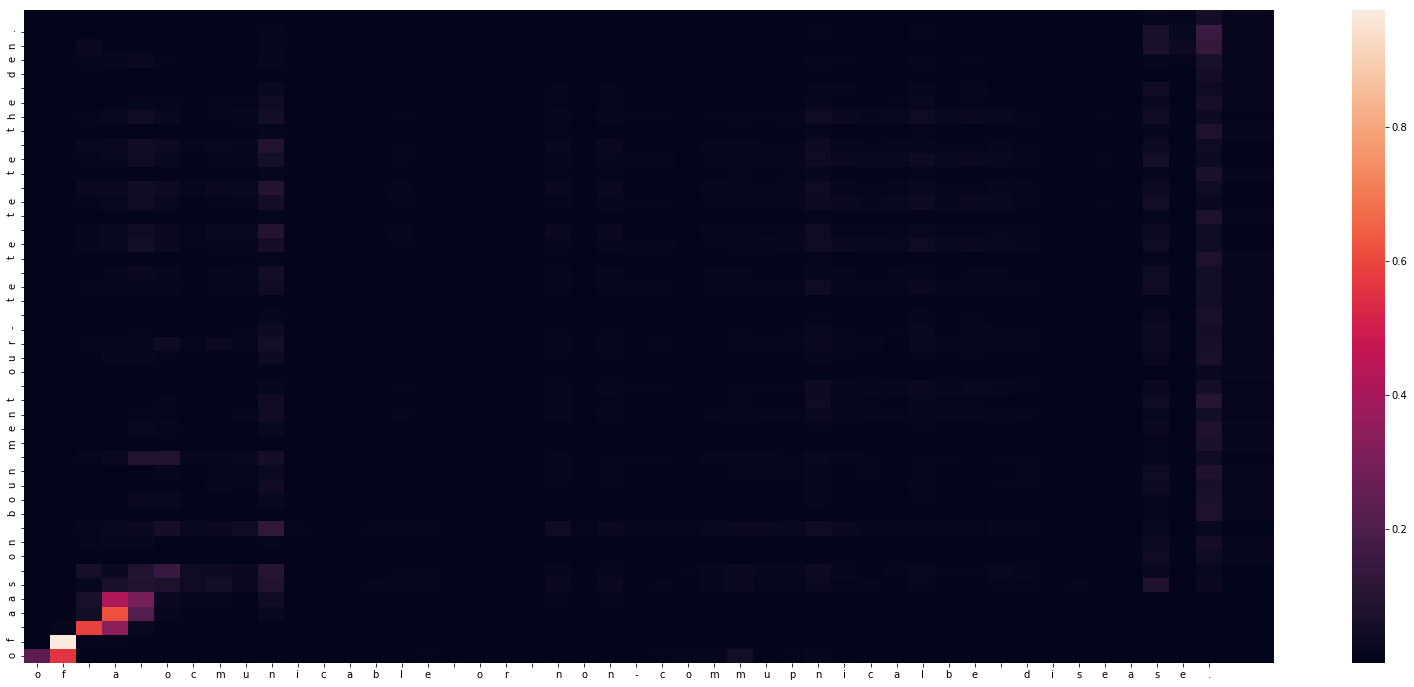

-
Input sentence: of a ocmunicable or non-commupnicalbe disease.
GT sentence: of a communicable or non-communicable disease.

Decoded sentence: of aas on boun ment our- te te te te the den.


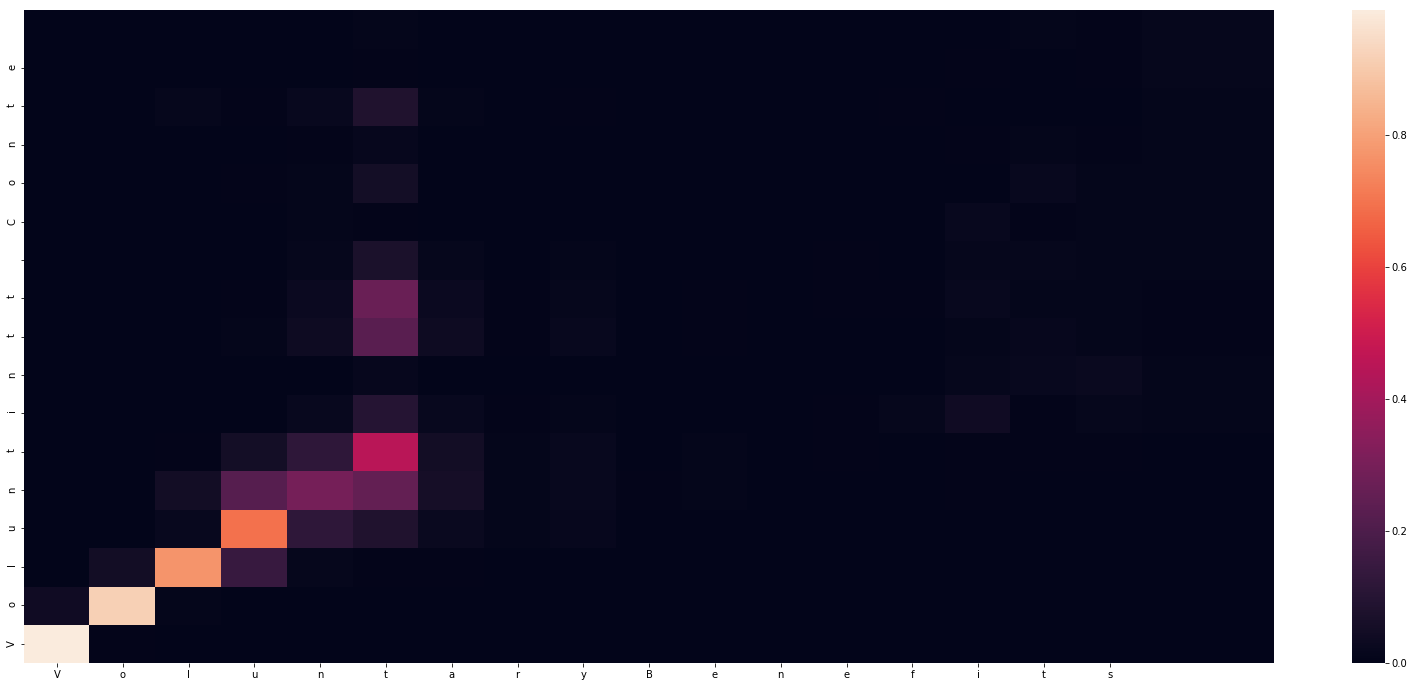

-
Input sentence: VoluntaryBenefits
GT sentence: Voluntary Benefits

Decoded sentence: Voluntintt Conte


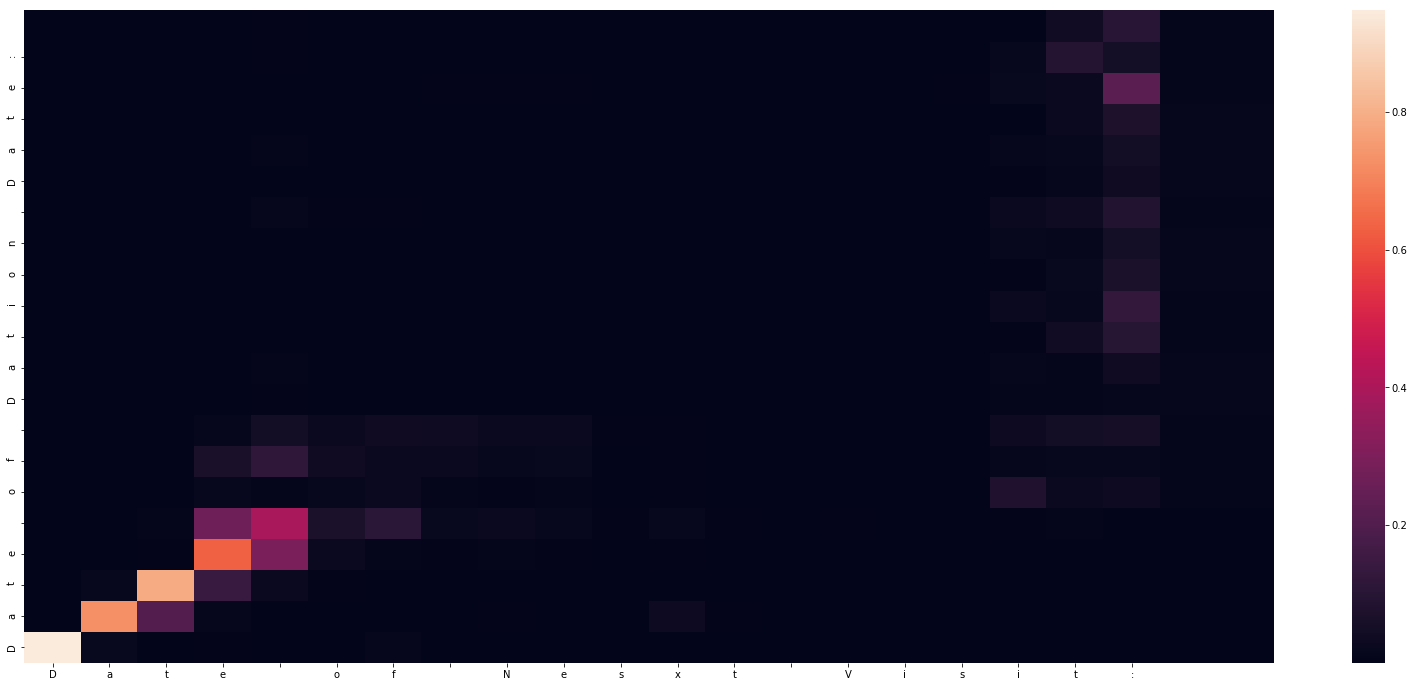

-
Input sentence: Date of Nesxt Visit:
GT sentence: Date of Next Visit:

Decoded sentence: Date of Dation Date:


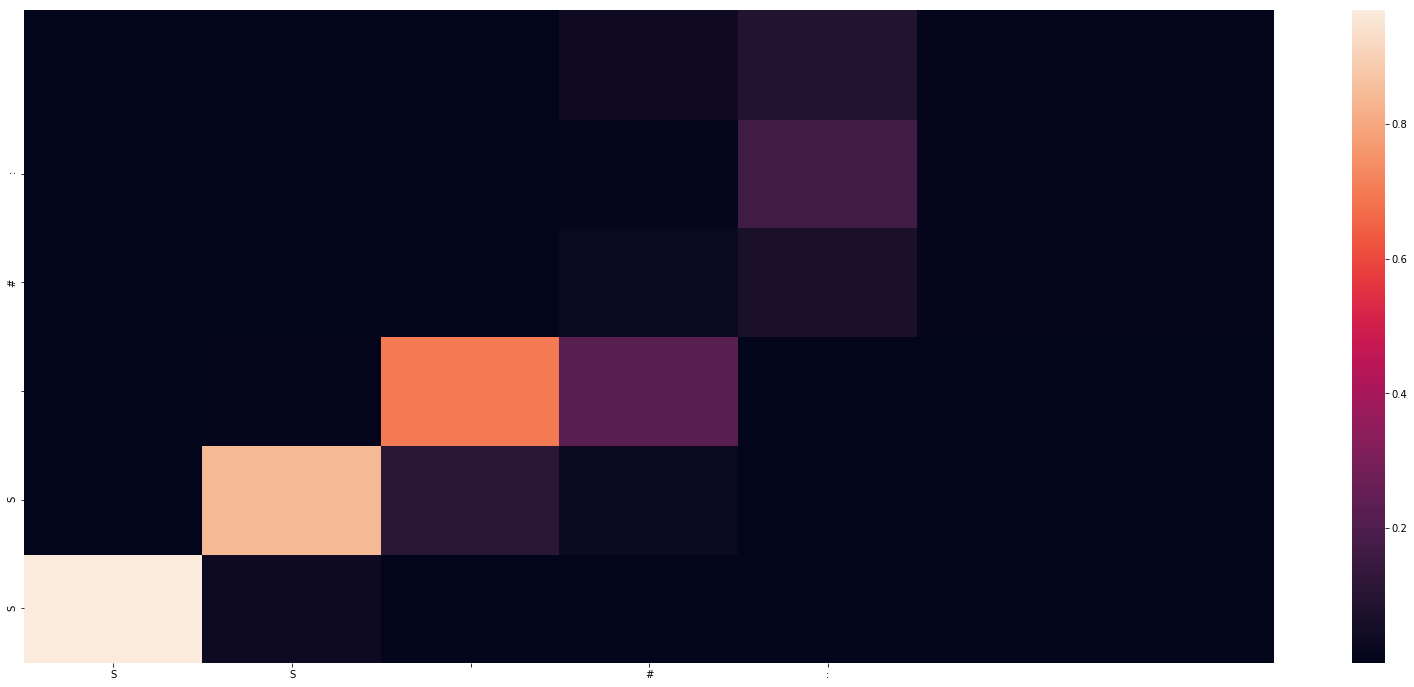

-
Input sentence: SS #:
GT sentence: SS #:

Decoded sentence: SS #:


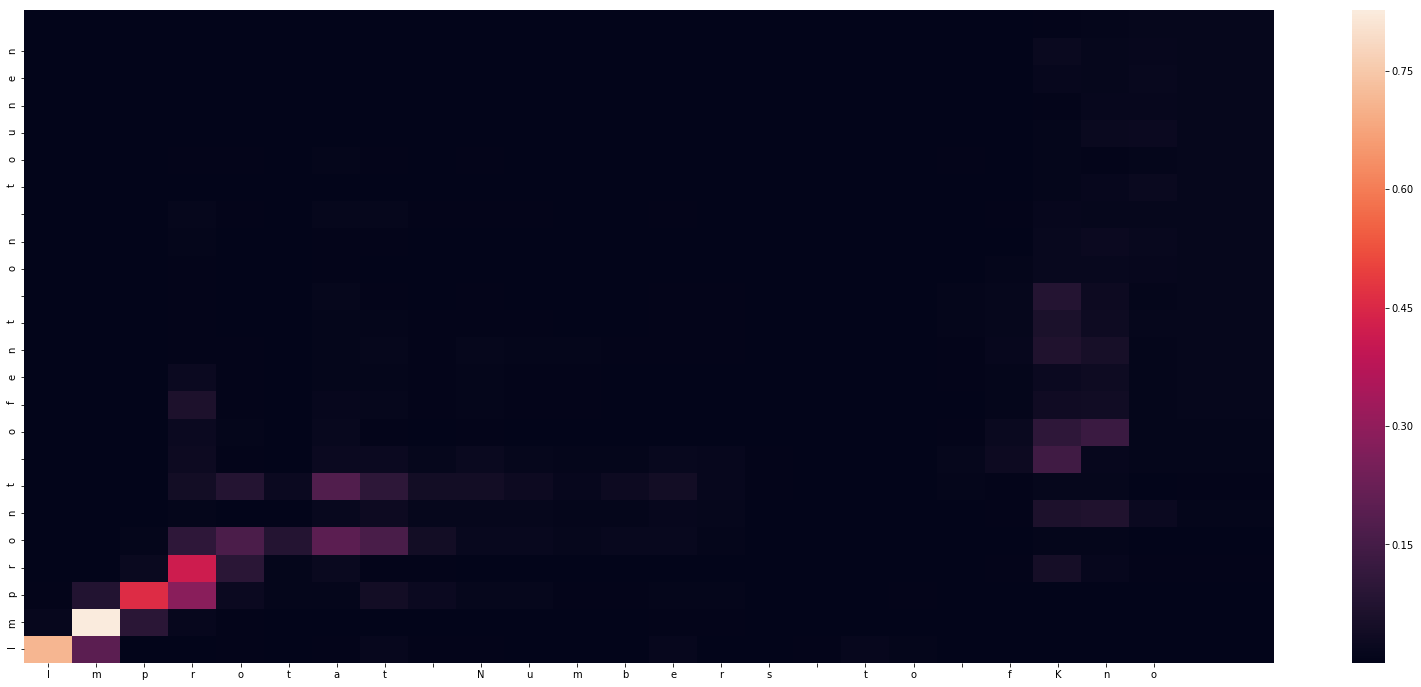

-
Input sentence: Improtat Numbers to fKno
GT sentence: Important Numbers to Know

Decoded sentence: Impront ofent on tounen


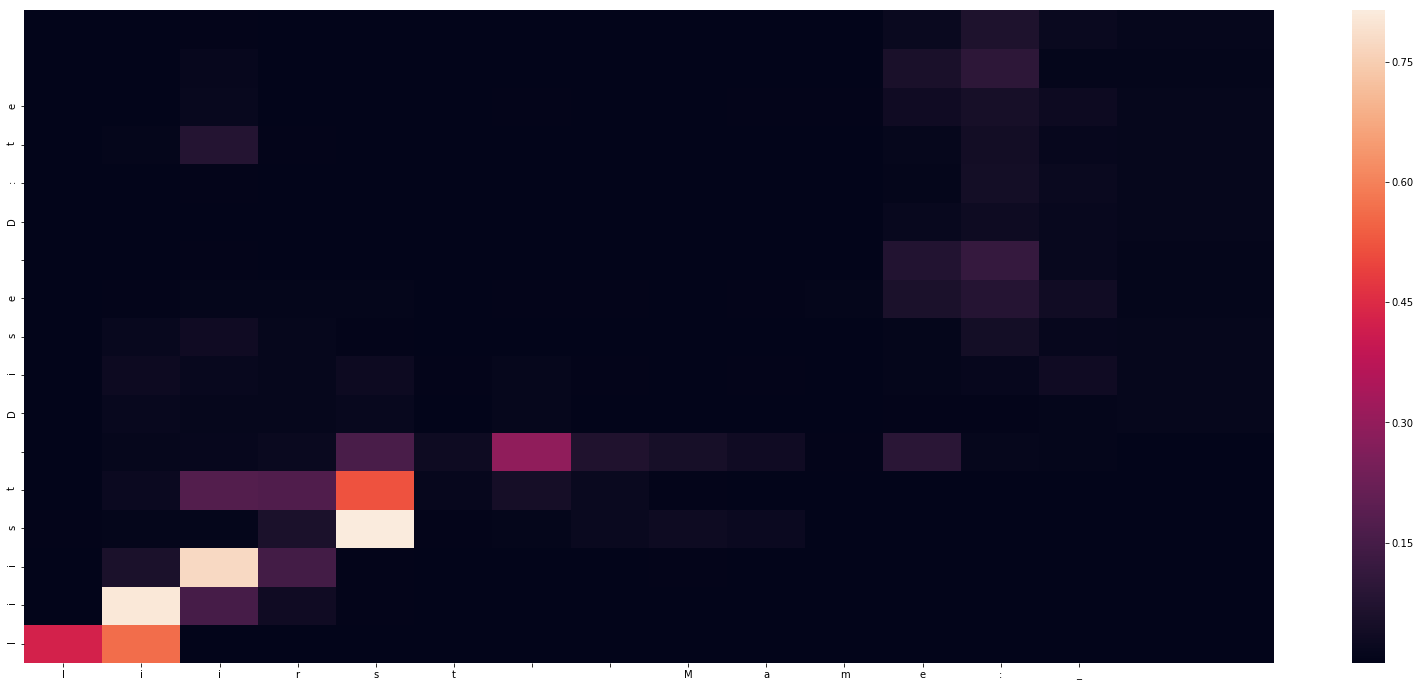

-
Input sentence: liirst  Mame:_
GT sentence: First Name:

Decoded sentence: Iiist Dise D:te


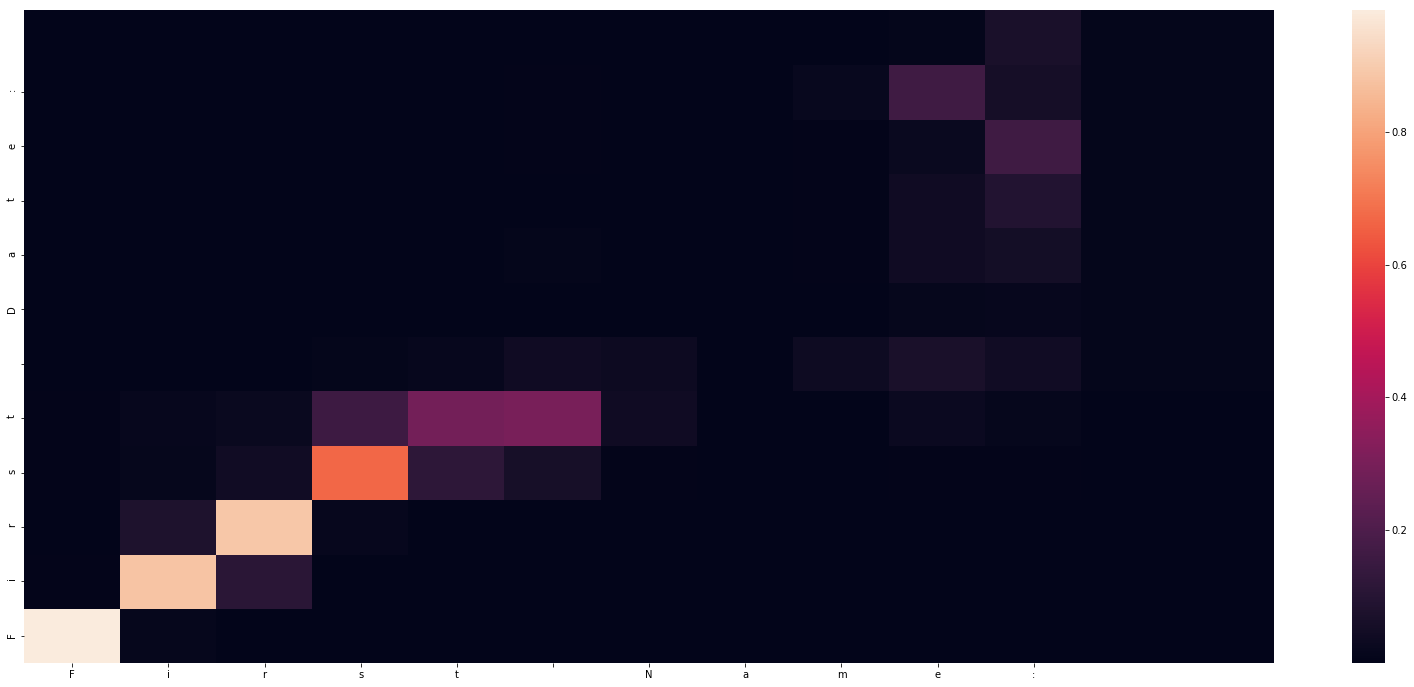

-
Input sentence: First Name:
GT sentence: First Name:

Decoded sentence: First Date:


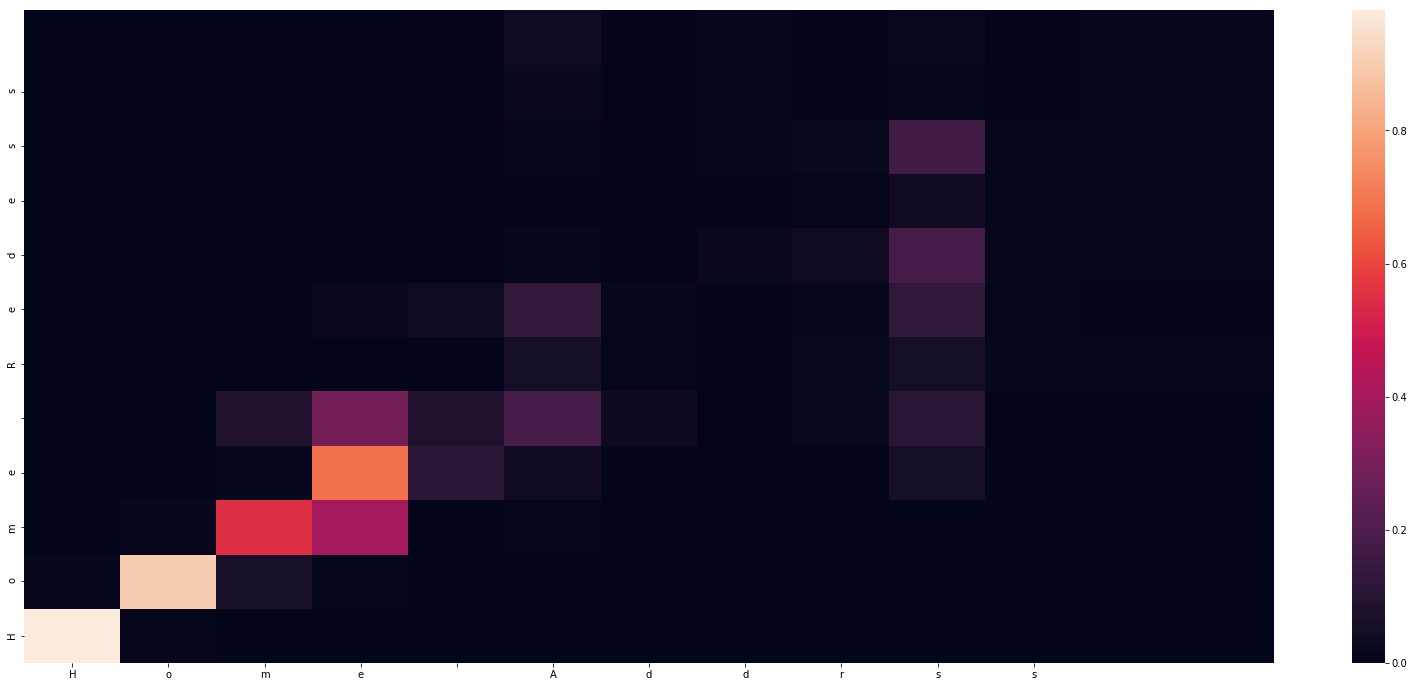

-
Input sentence: Home Addrss
GT sentence: Home Address

Decoded sentence: Home Redess


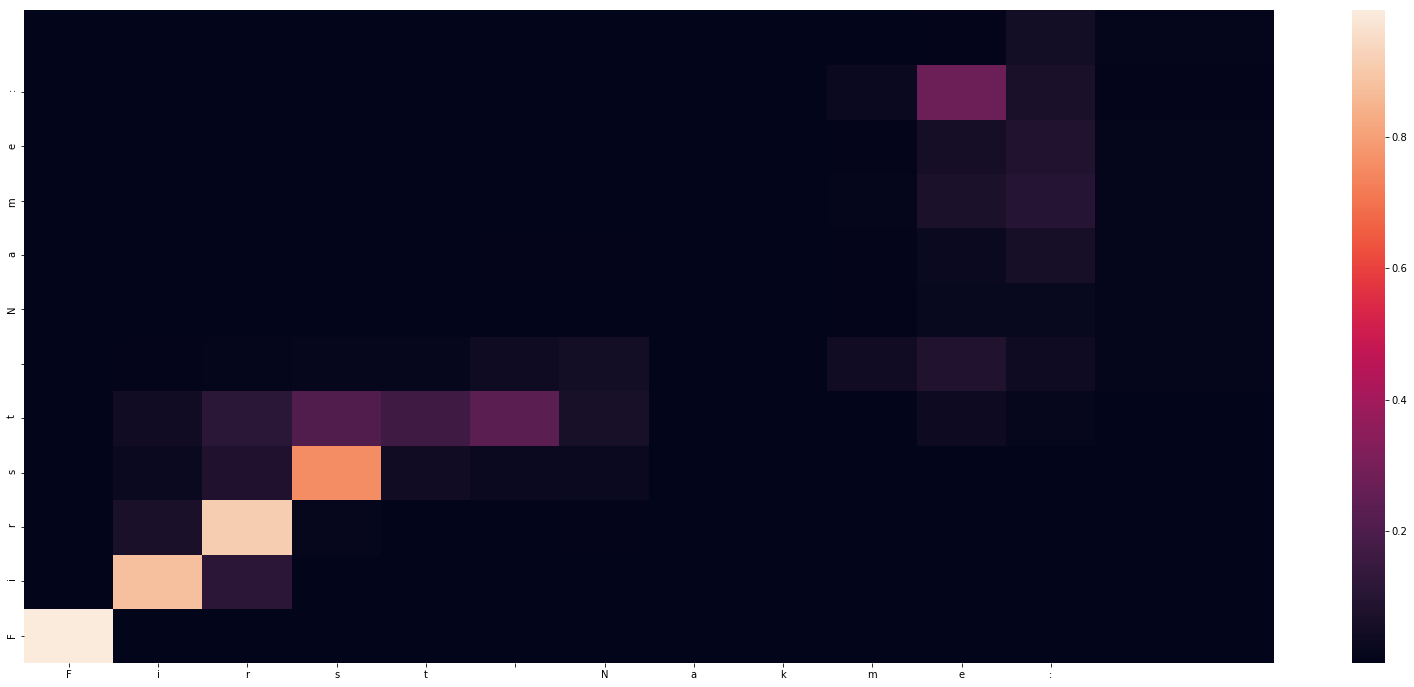

-
Input sentence: First Nakme:
GT sentence: First Name:

Decoded sentence: First Name:


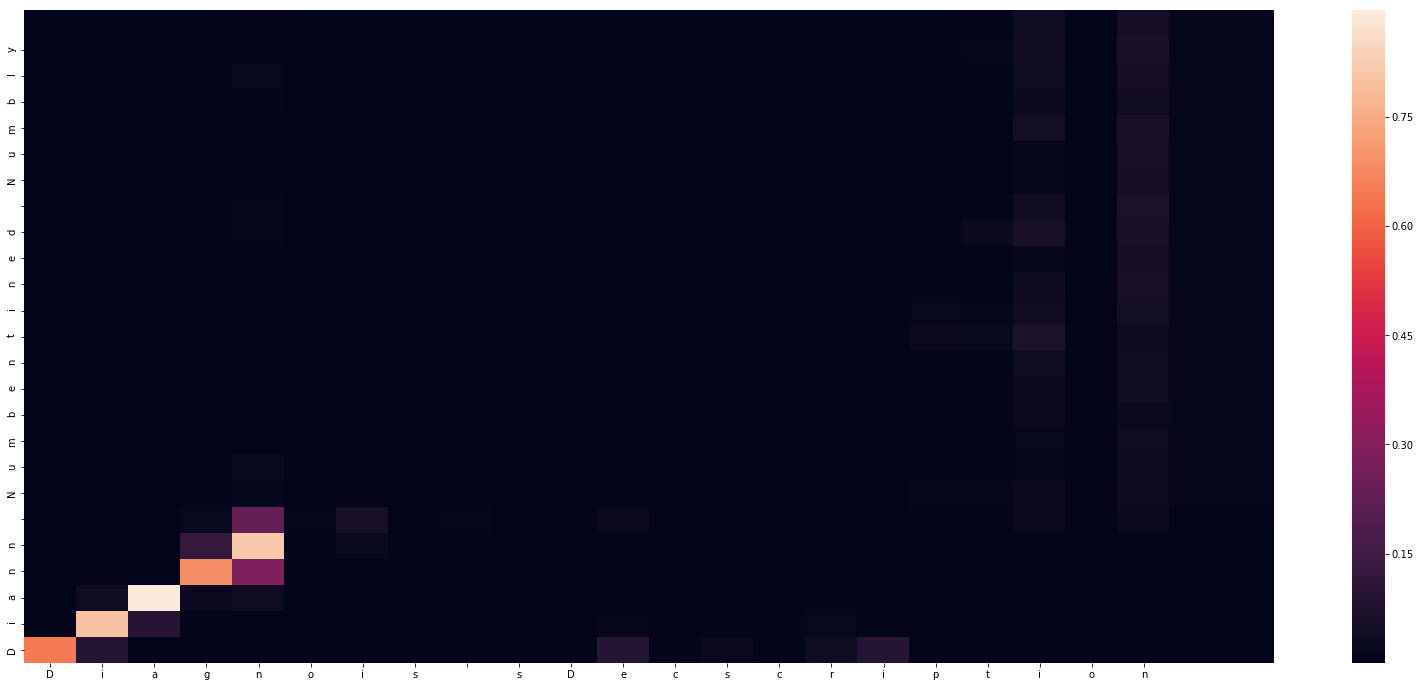

-
Input sentence: Diagnois sDecscription
GT sentence: Diagnosis Description

Decoded sentence: Diann Numbentined Numbly


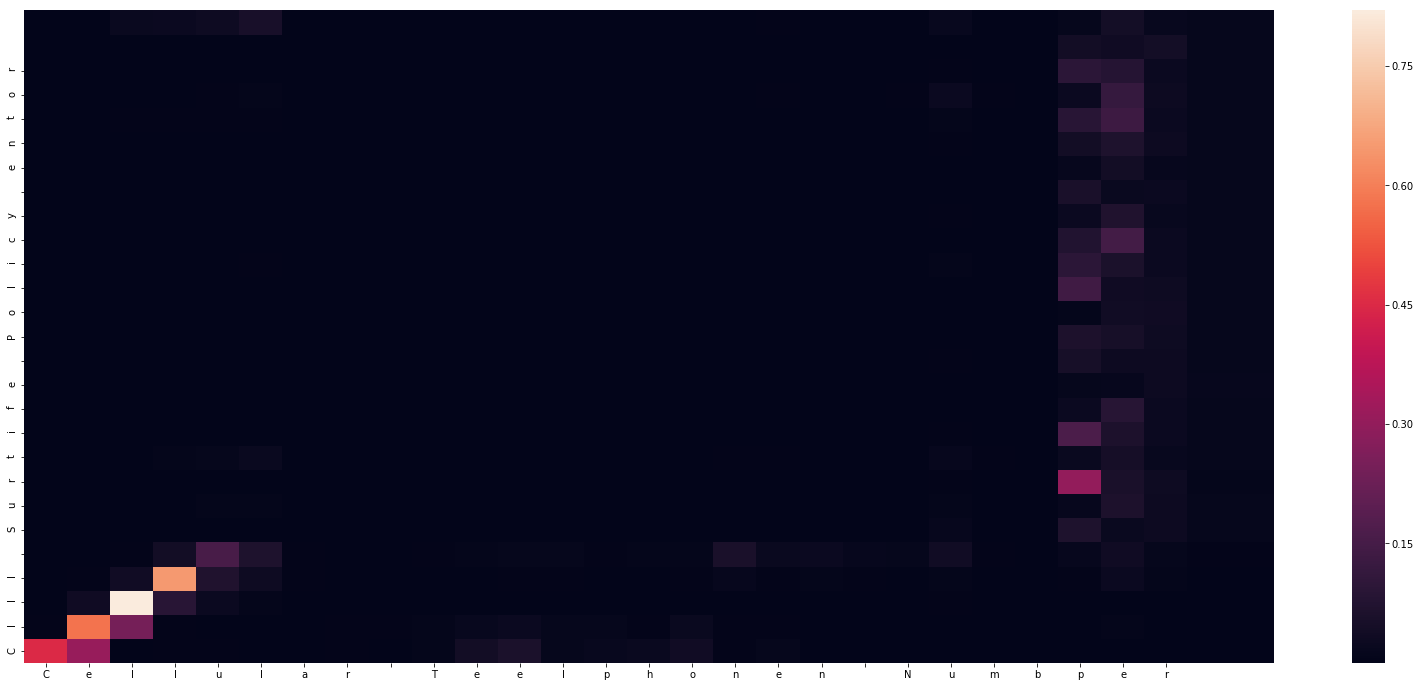

-
Input sentence: Cellular Teelphonen Numbper
GT sentence: Cellular Telephone Number

Decoded sentence: Clll Surtife Policy entor


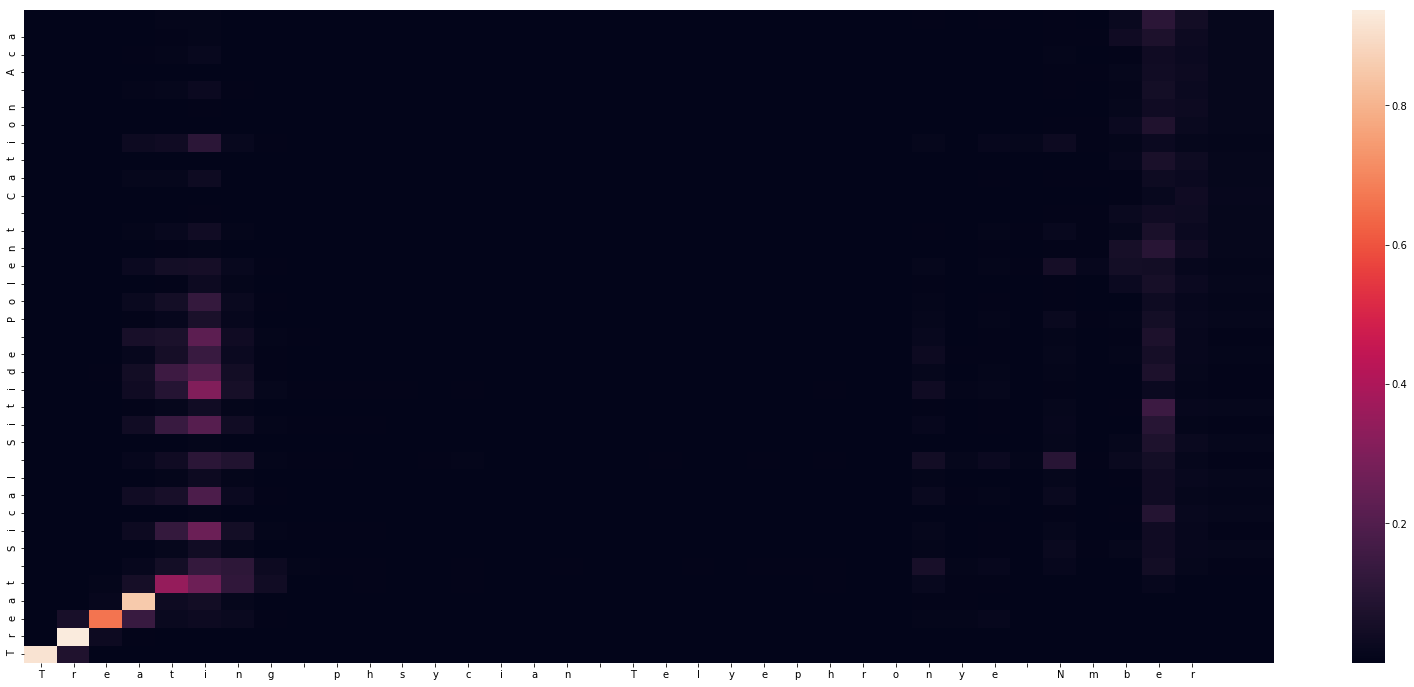

-
Input sentence: Treating phsycian Telyephronye Nmber
GT sentence: Treating phycian Telephone Number

Decoded sentence: Treat Sical Sitide Polent Cation Aca


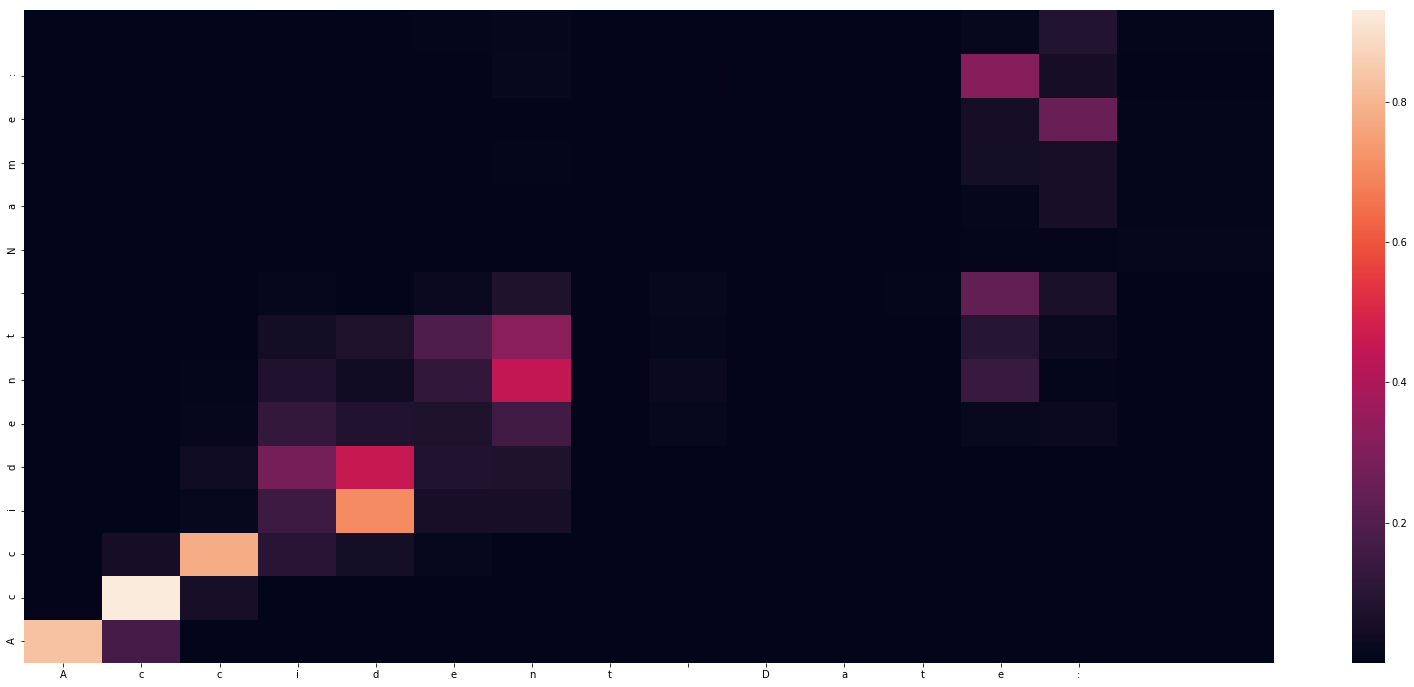

-
Input sentence: Accident Date:
GT sentence: Accident Date:

Decoded sentence: Accident Name:


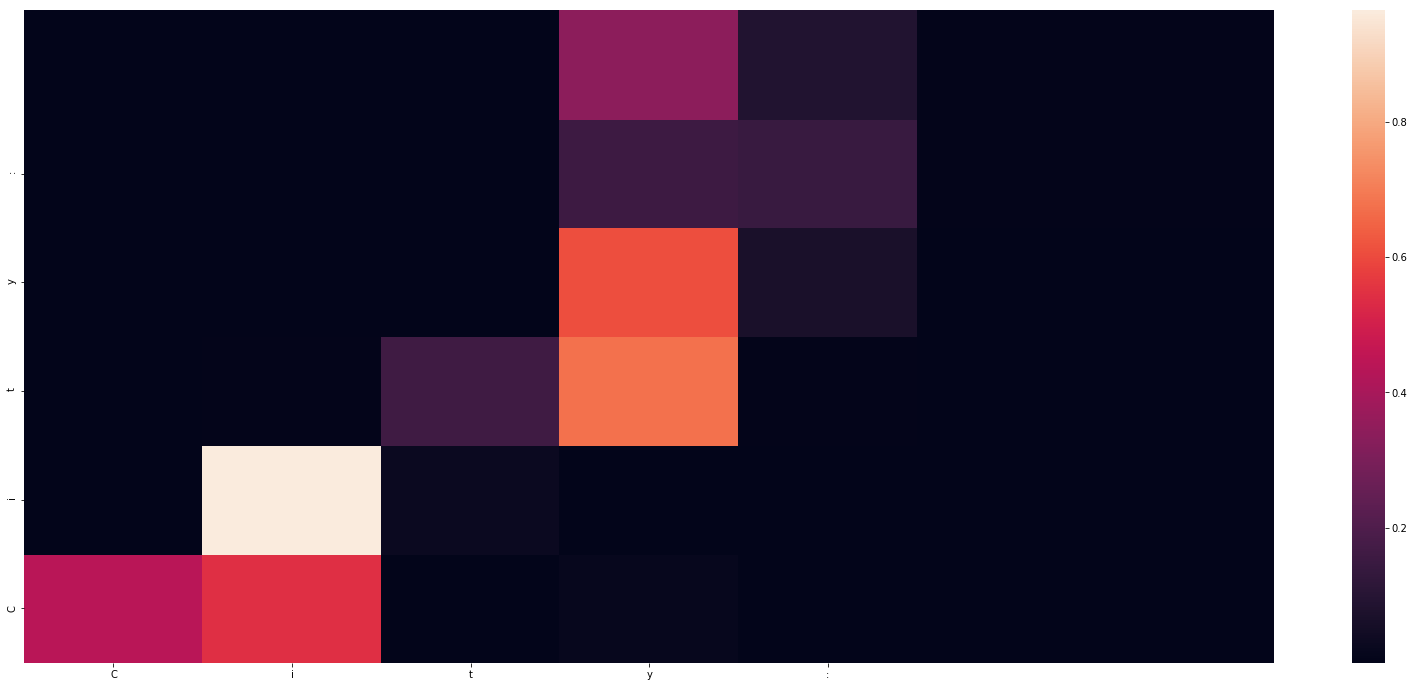

-
Input sentence: City:
GT sentence: City:

Decoded sentence: City:


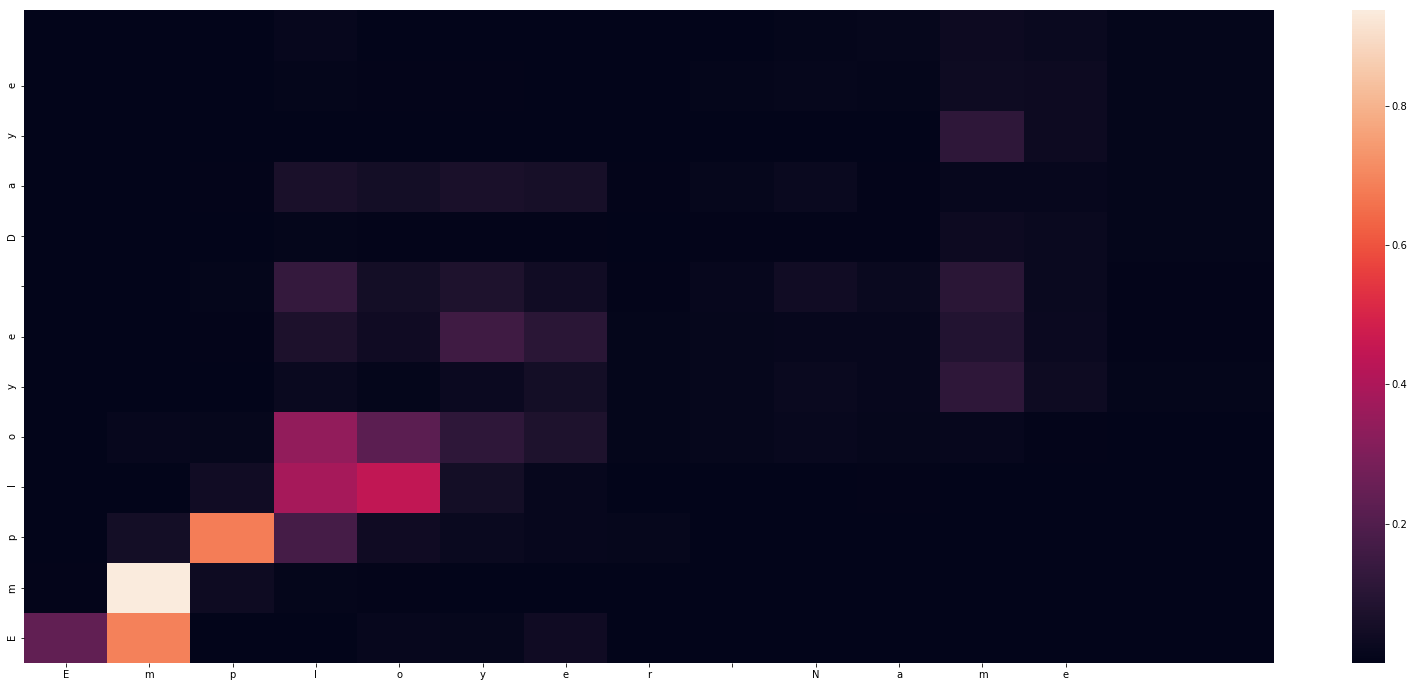

-
Input sentence: Employer Name
GT sentence: Employer Name:

Decoded sentence: Employe Daye


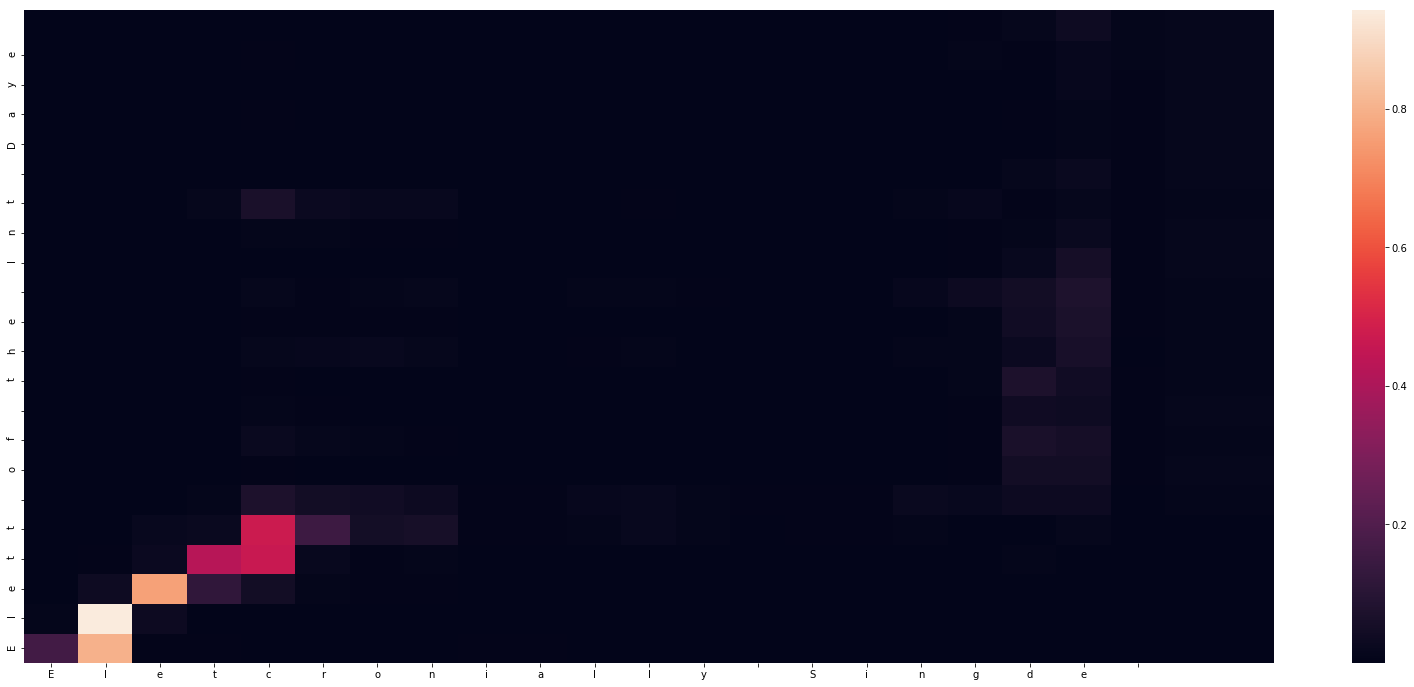

-
Input sentence: Eletcronially Singde 
GT sentence: Electronically Signed 

Decoded sentence: Elett of the Int Daye


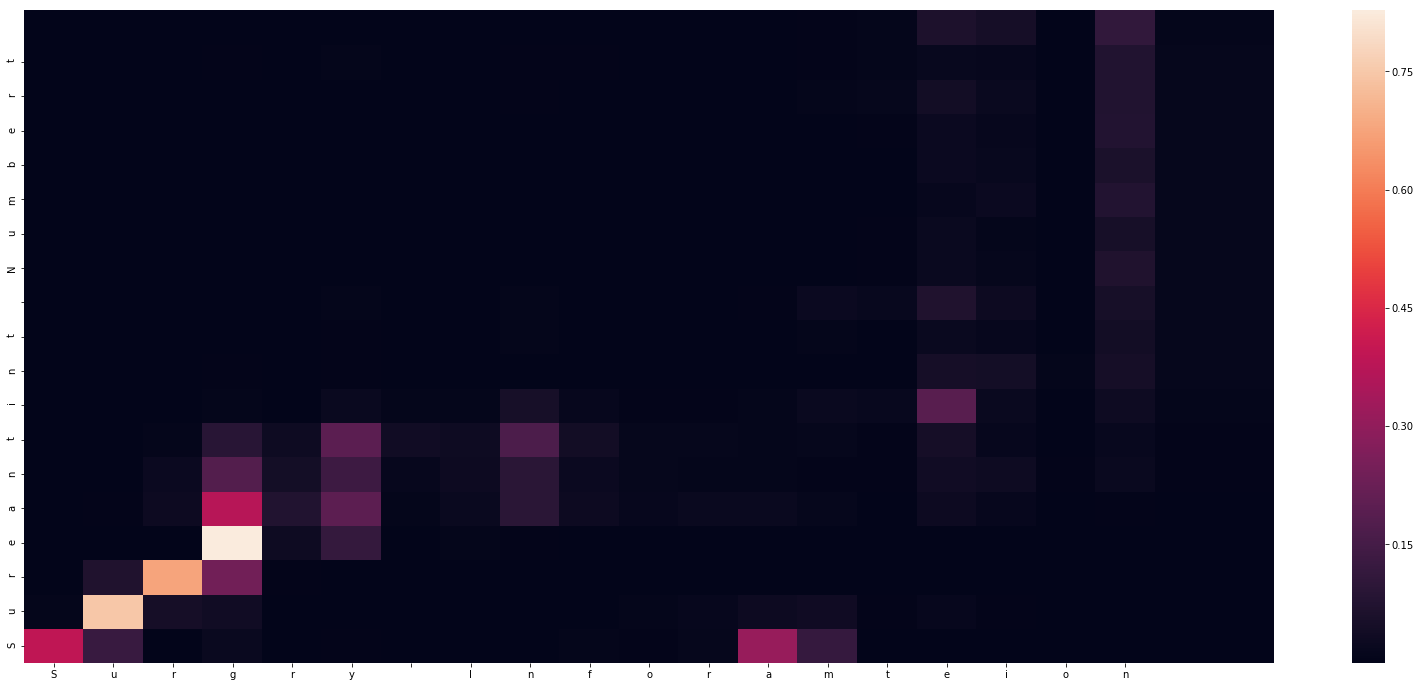

-
Input sentence: Surgry Inforamteion
GT sentence: Surgery Information

Decoded sentence: Sureantint Numbert


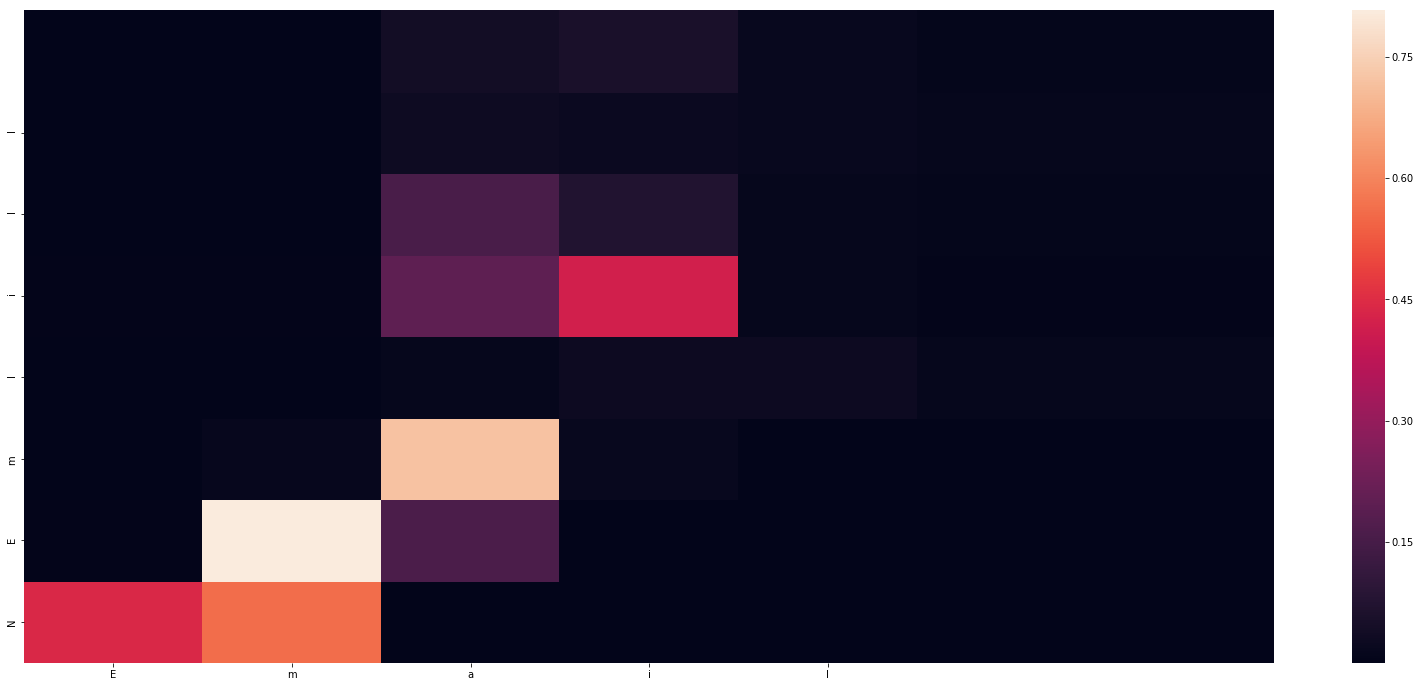

-
Input sentence: Email
GT sentence: Email

Decoded sentence: NEmlill


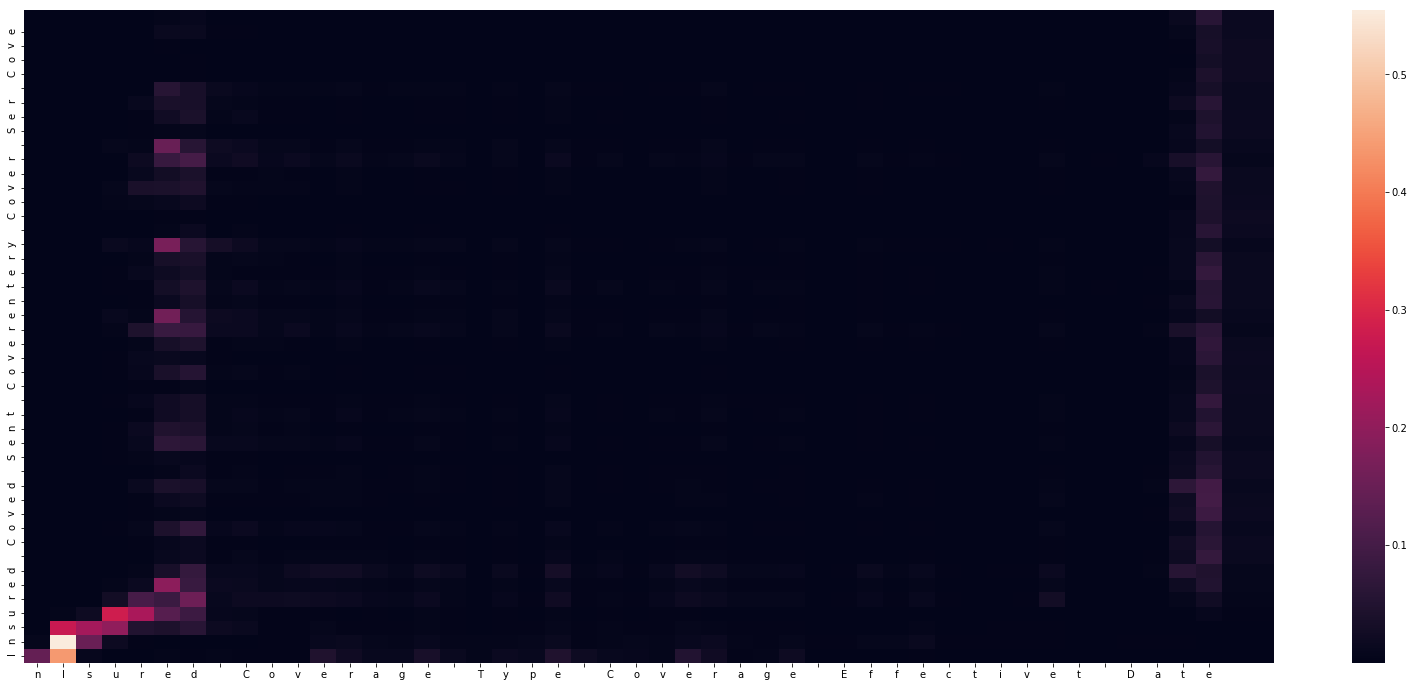

-
Input sentence: nIsured Coverage Type Coverage Effectivet Date
GT sentence: Insured Coverage Type Coverage Effective Date

Decoded sentence: Insured Coved Sent Coverentery Cover Ser Cove


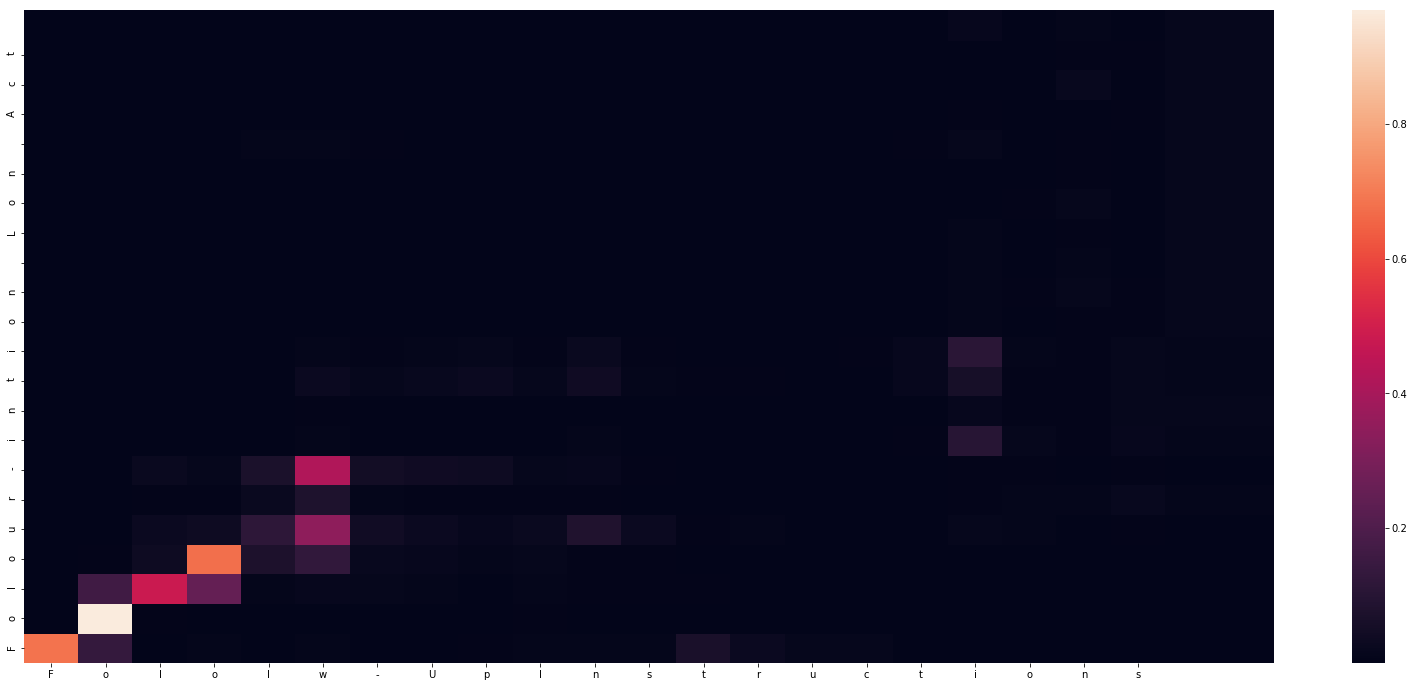

-
Input sentence: Fololw-UpInstructions
GT sentence: Follow-Up Instructions

Decoded sentence: Folour-intion Lon Act


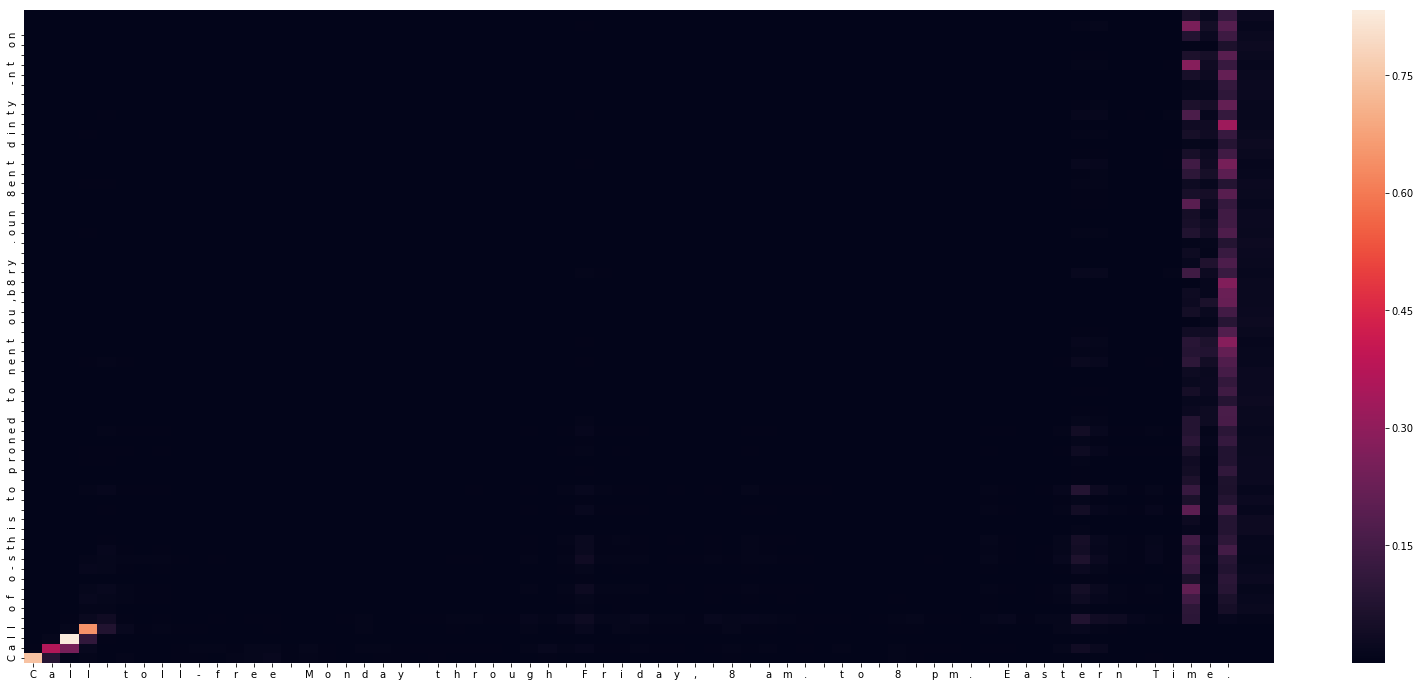

-
Input sentence: Call toll-free Monday through Friday, 8 am. to 8 pm. Eastern Time.
GT sentence: Call toll-free Monday through Friday, 8 a.m. to 8 p.m. Eastern Time.

Decoded sentence: Call of o-sthis to proned to nent ou,b8ry .oun 8ent dinty -nt on


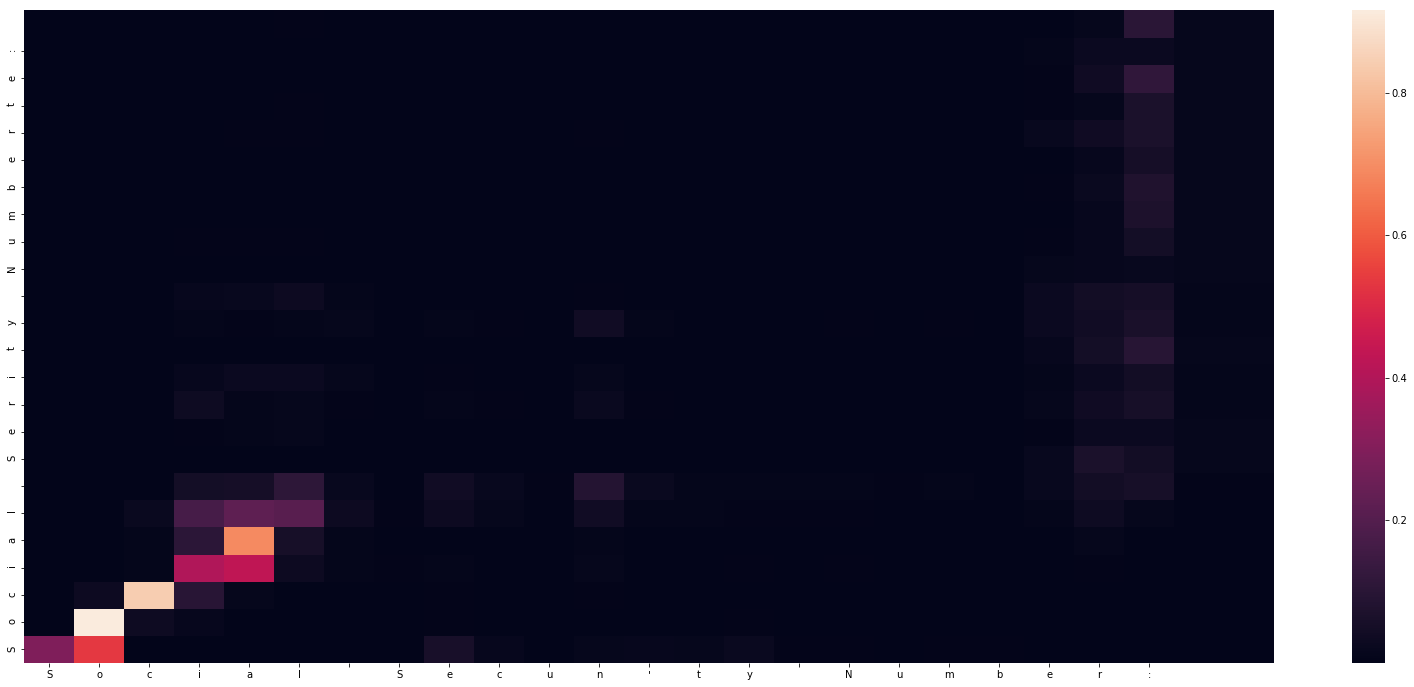

-
Input sentence: Social Secun'ty Number:
GT sentence: Social Security Number:

Decoded sentence: Social Serity Numberte:


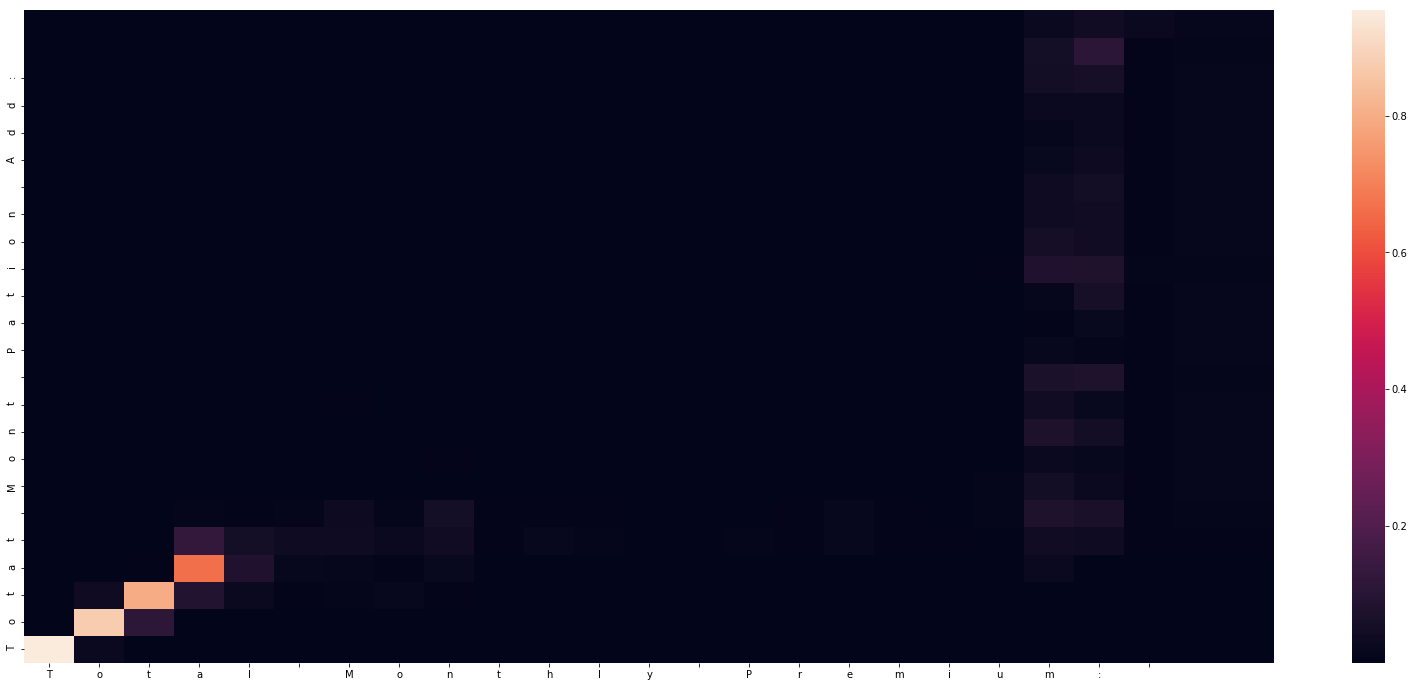

-
Input sentence: Total Monthly Premium: 
GT sentence: Total Monthly Premium:

Decoded sentence: Totat Mont Pation Add:


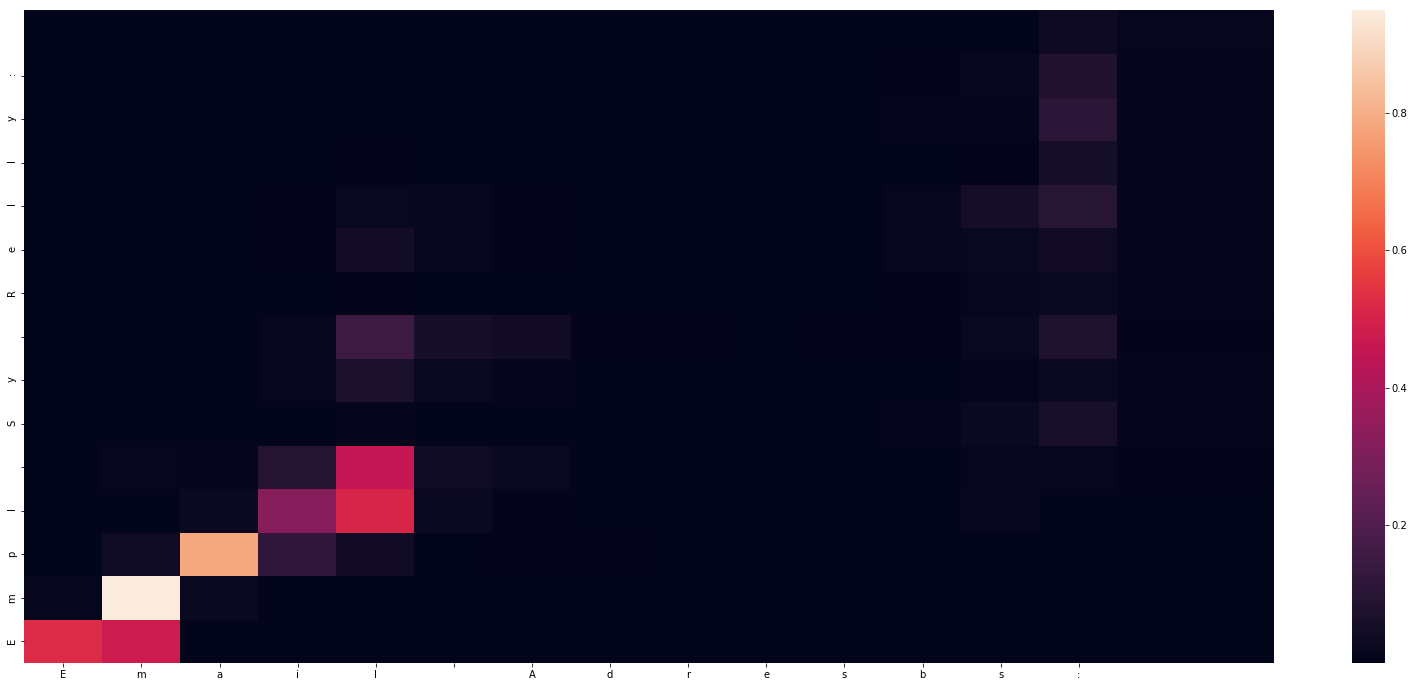

-
Input sentence: Email Adresbs:
GT sentence: Email Address:

Decoded sentence: Empl Sy Relly:


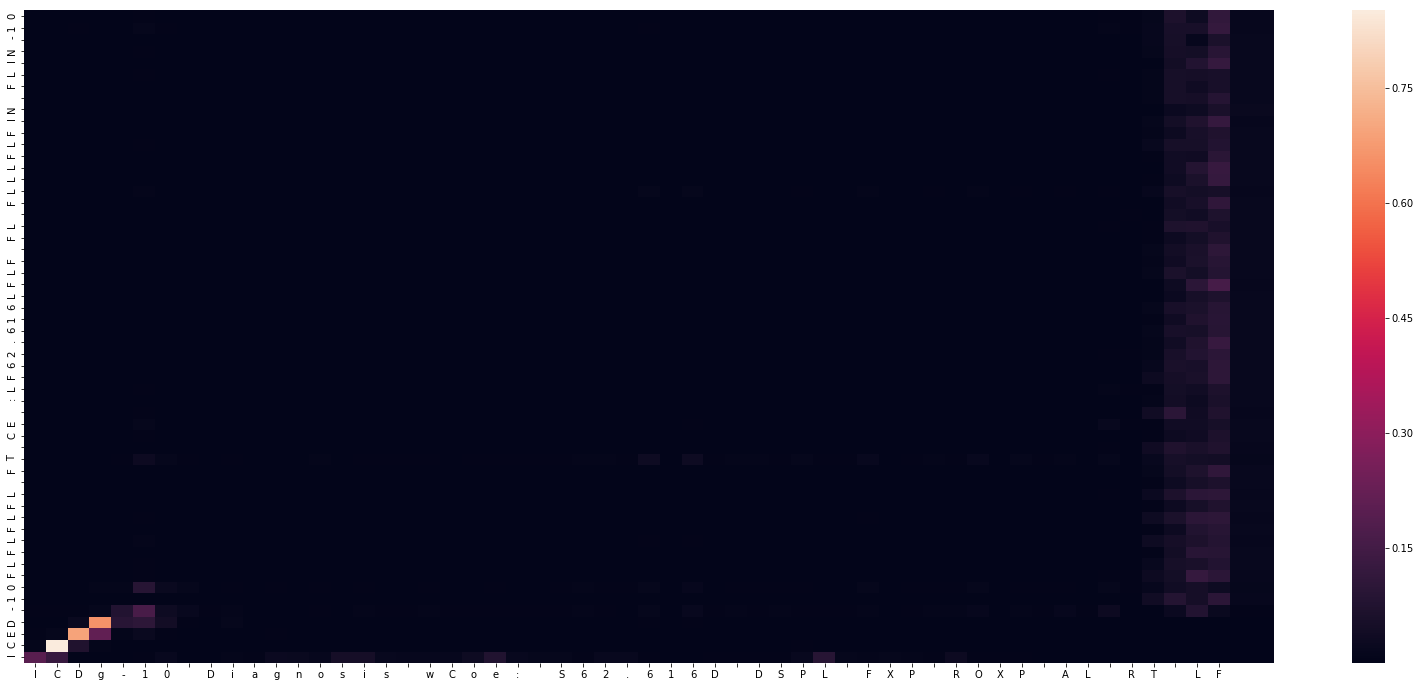

-
Input sentence: ICDg-10 Diagnosis wCoe: S62.616D DSPL FXP ROXP AL RT LF
GT sentence: ICD-10 Diagnosis Code: S62.616D DSPL FX PROX PHAL RT LF

Decoded sentence: ICED-10FLFLFLFL FT CE :LF62.616LFLF FL FLLLFLFIN FLIN-10


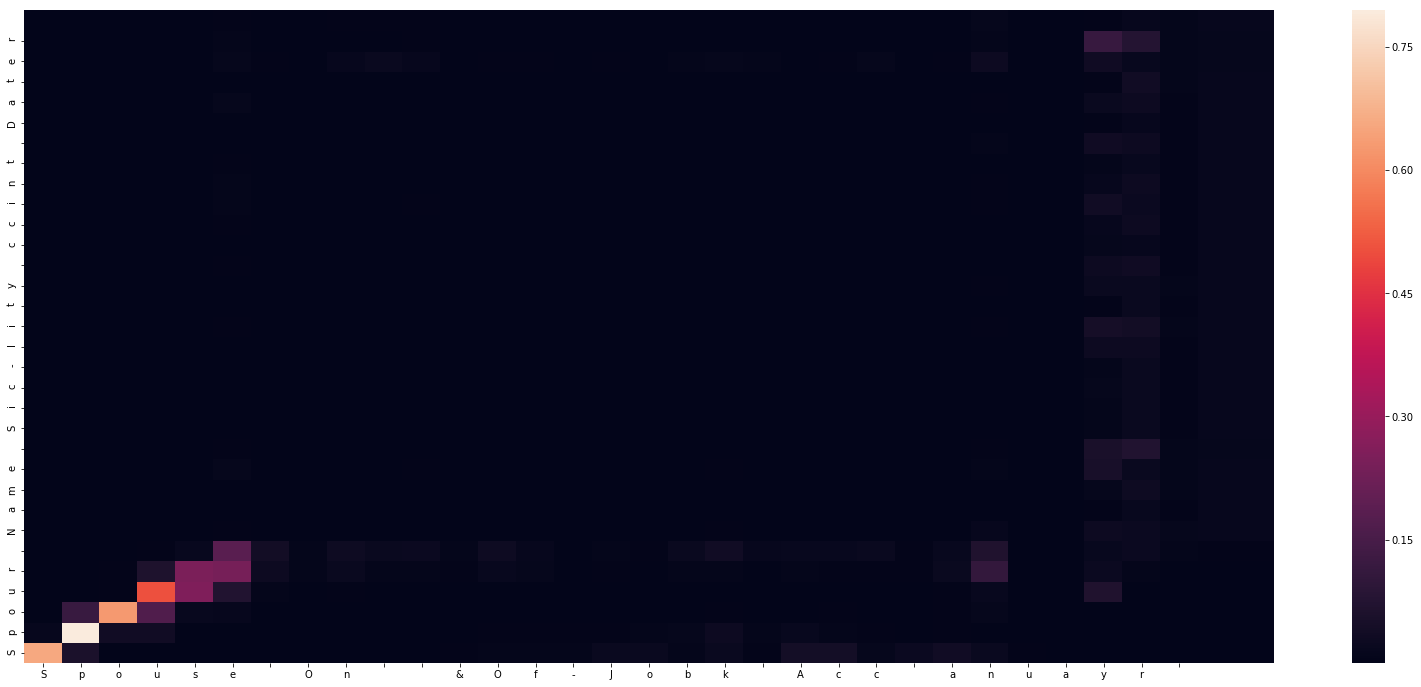

-
Input sentence: Spouse On  &Of-Jobk Acc anuayr 
GT sentence: Spouse On & Off-Job Acc January 

Decoded sentence: Spour Name Sic-lity ccint Dater


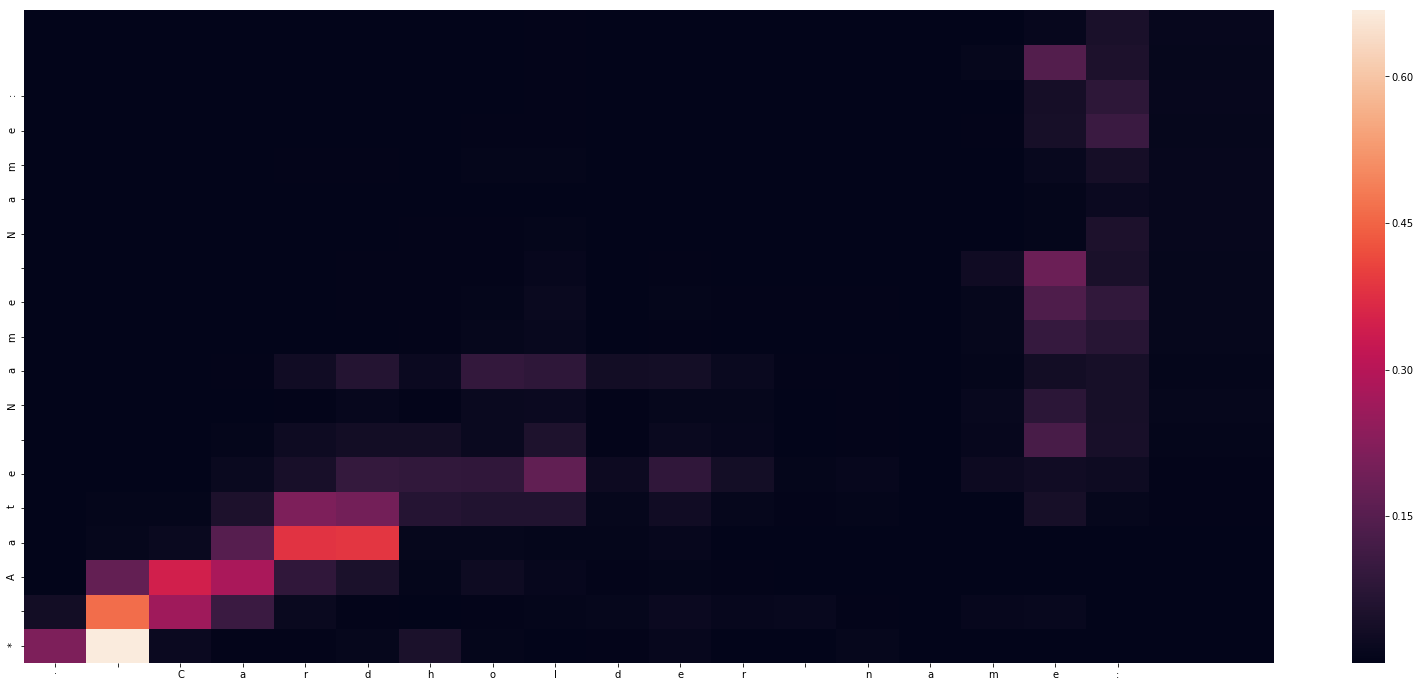

-
Input sentence: ‘ Cardholder name:
GT sentence: Cardholder name:

Decoded sentence: * Aate Name Name:


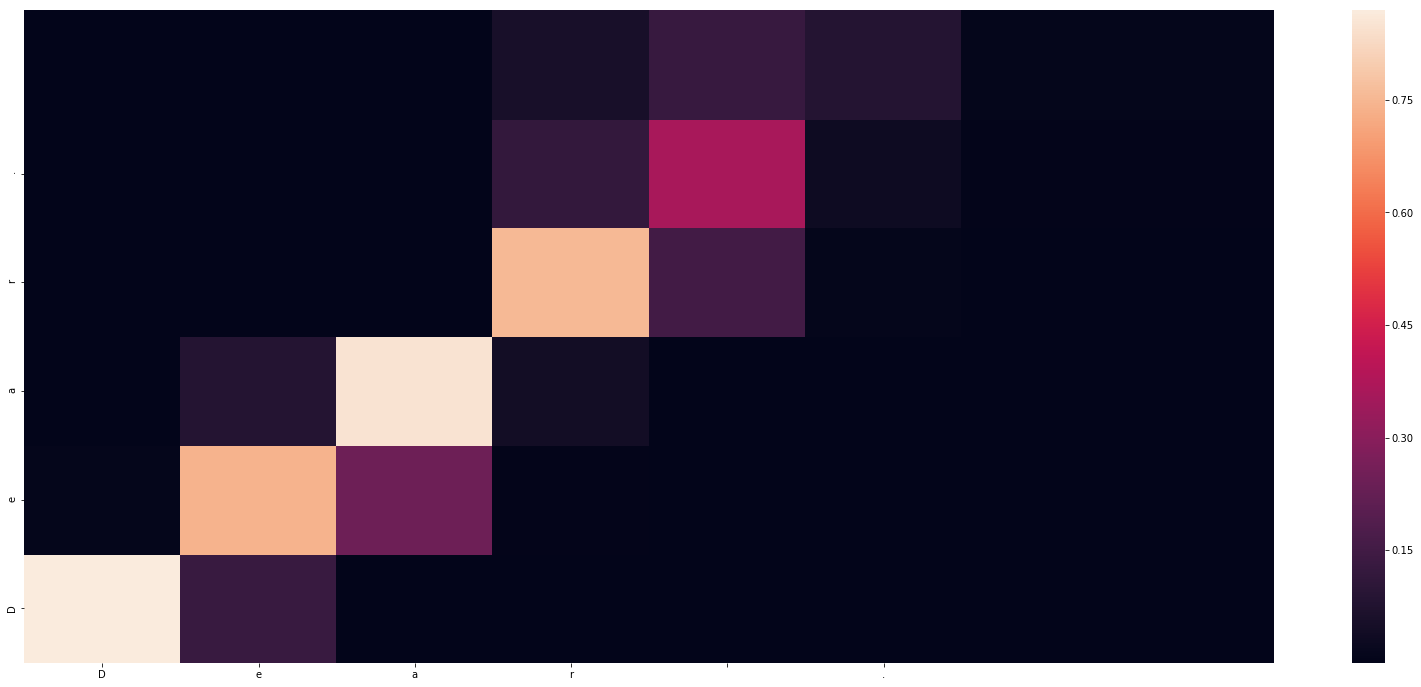

-
Input sentence: Dear .
GT sentence: Dear .

Decoded sentence: Dear.


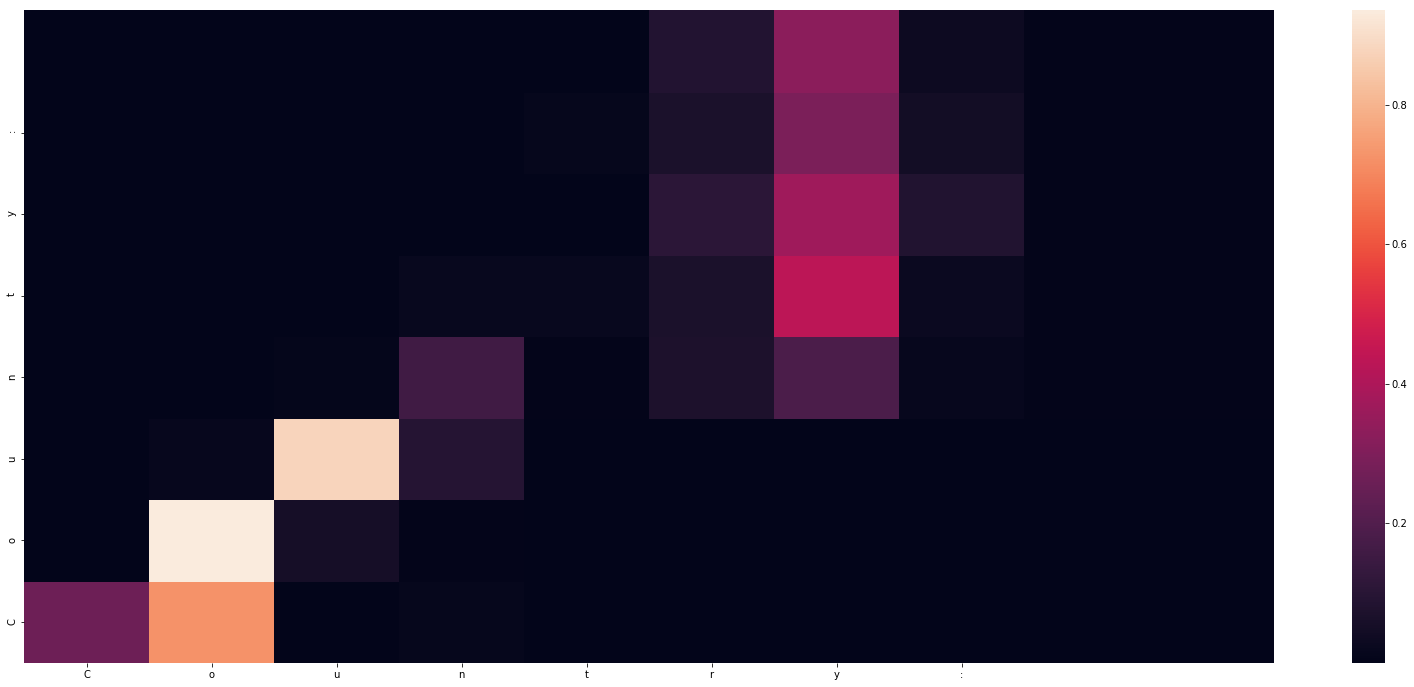

-
Input sentence: Country:
GT sentence: Country:

Decoded sentence: County:


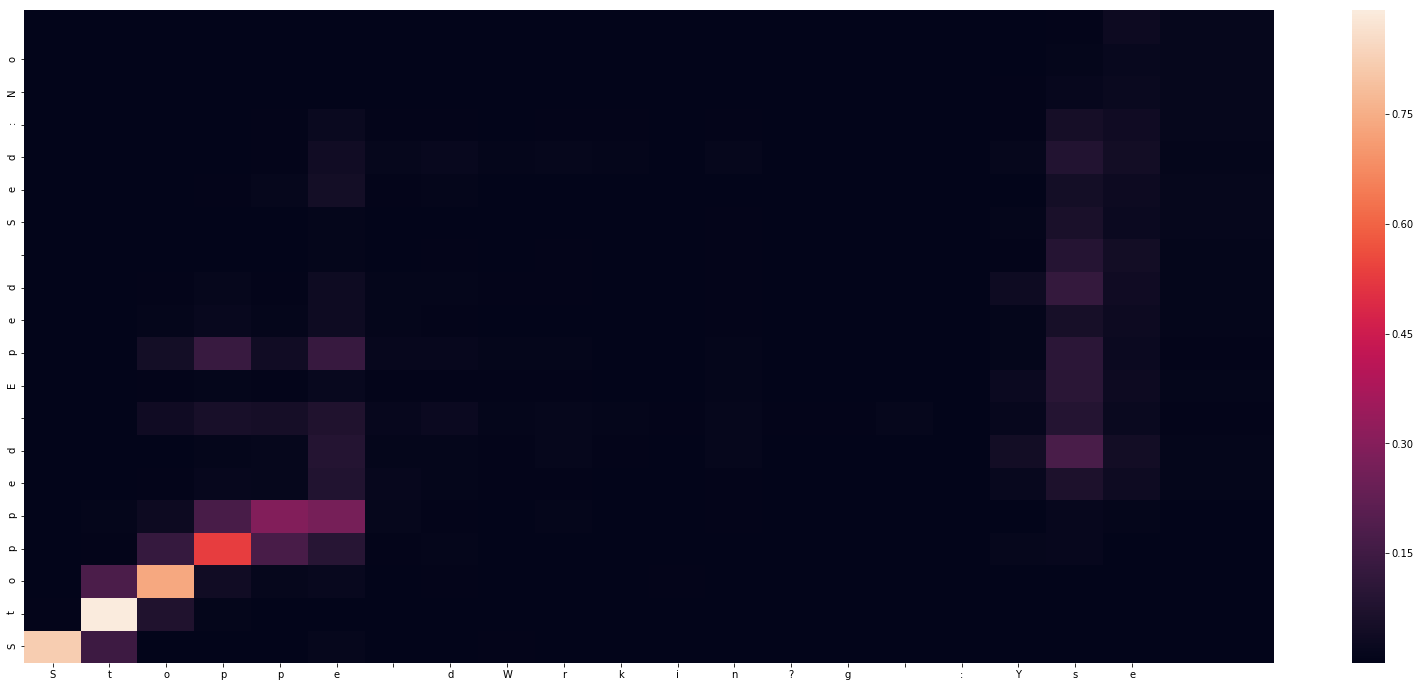

-
Input sentence: Stoppe dWrkin?g :Yse
GT sentence: Stopped Working?: Yes

Decoded sentence: Stopped Eped Sed:No


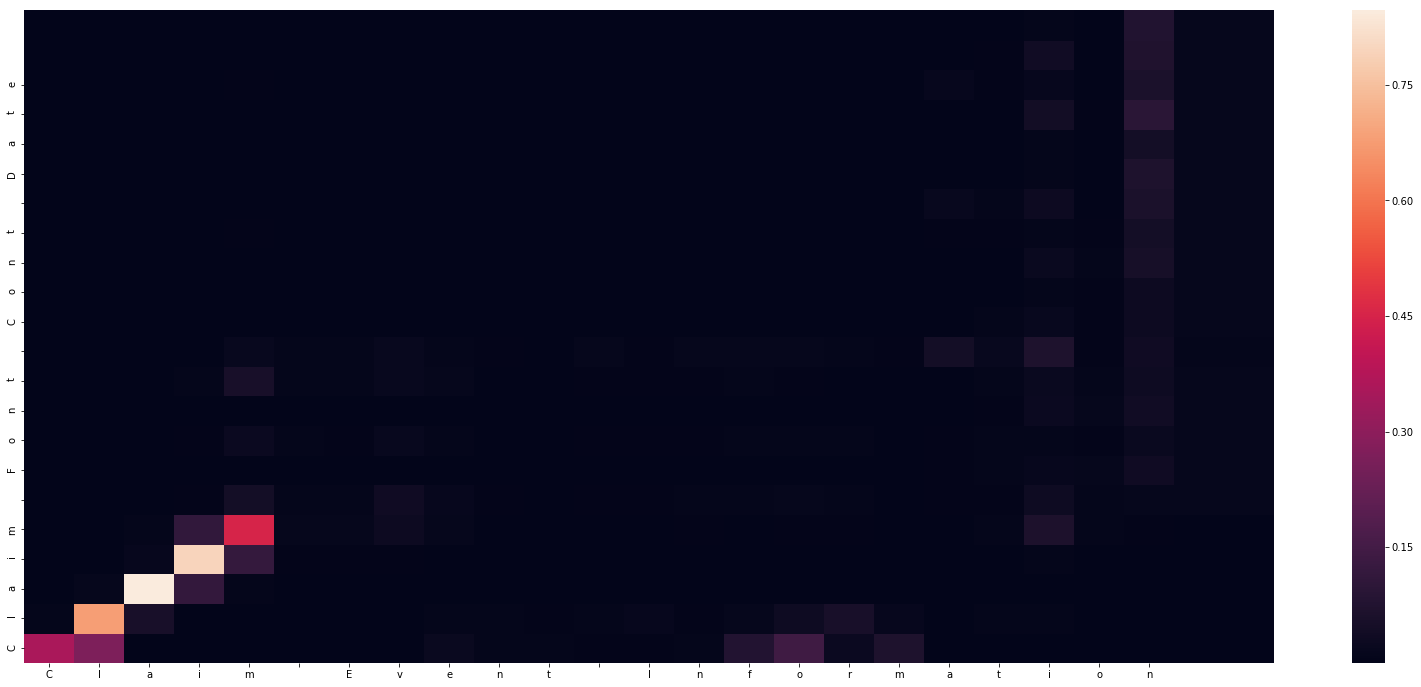

-
Input sentence: Claim Event Information
GT sentence: Claim Event Information

Decoded sentence: Claim Font Cont Date


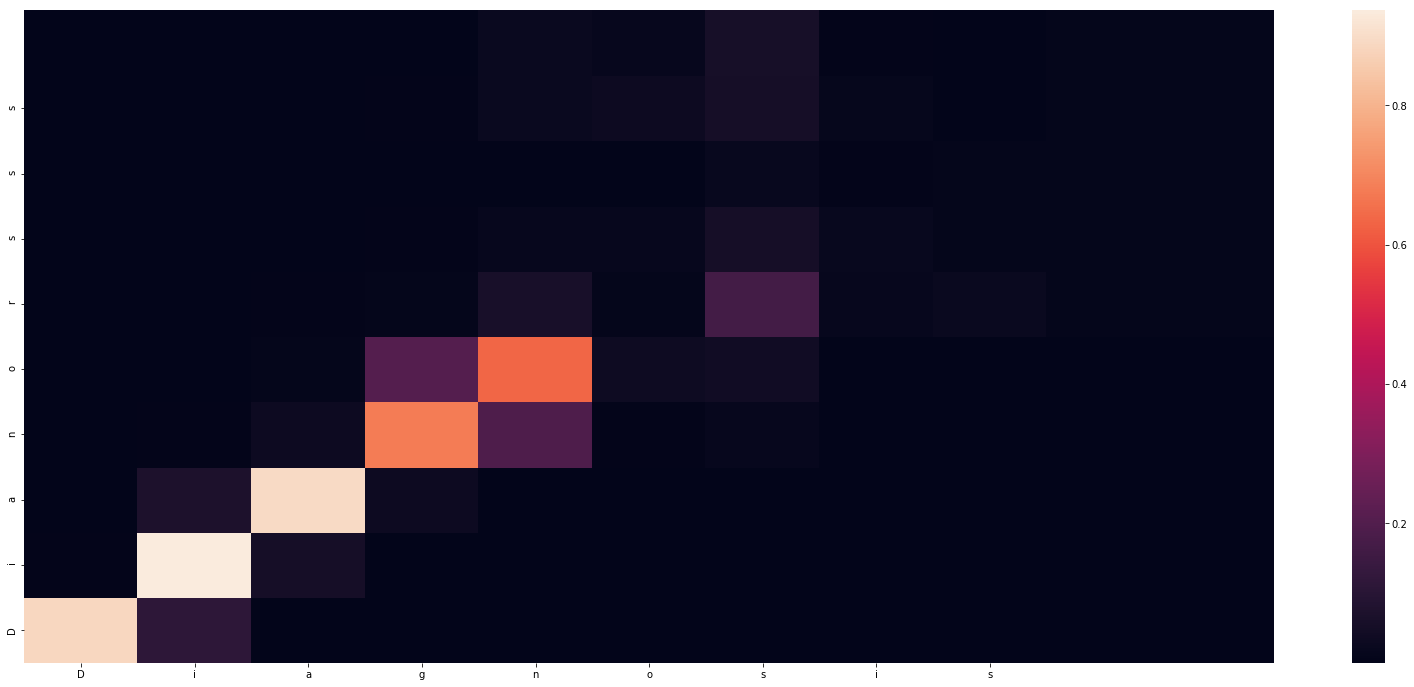

-
Input sentence: Diagnosis
GT sentence: Diagnosis

Decoded sentence: Dianorsss


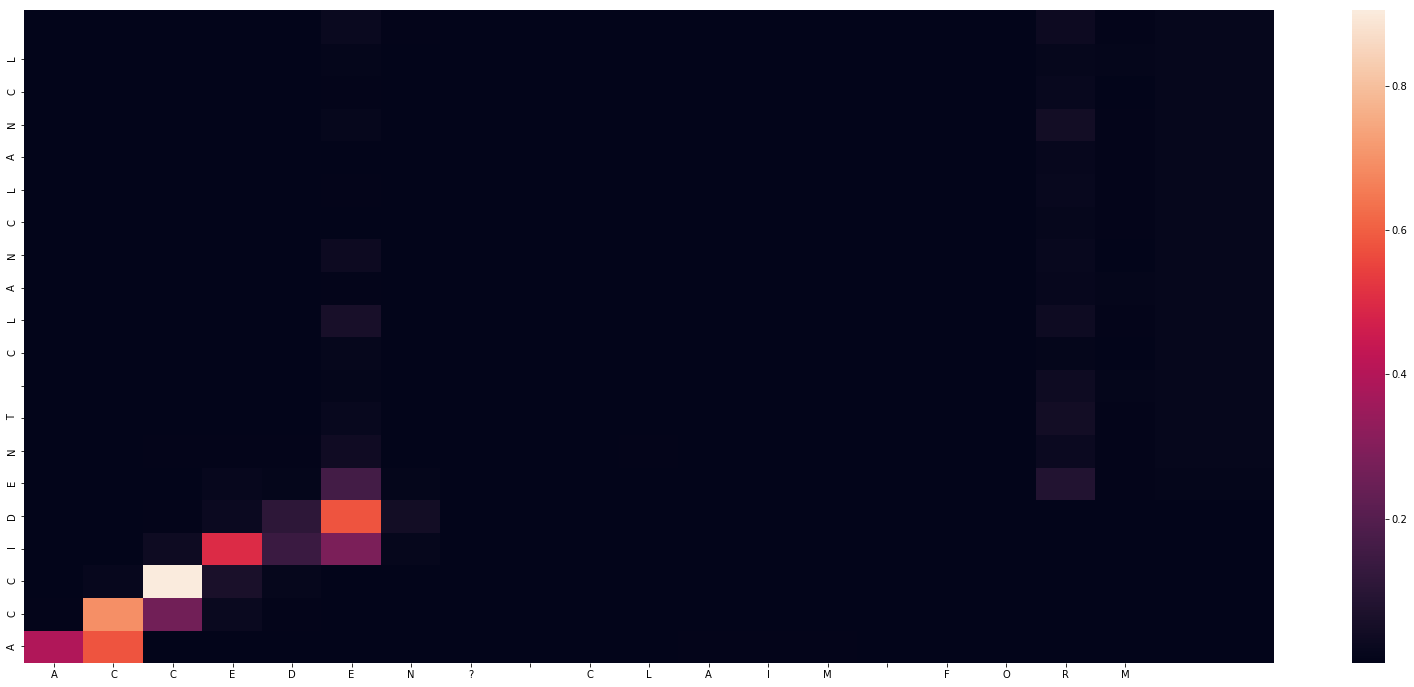

-
Input sentence: ACCEDEN? CLAIM FORM
GT sentence: ACCIDENT CLAIM FORM

Decoded sentence: ACCIDENT CLANCLANCL


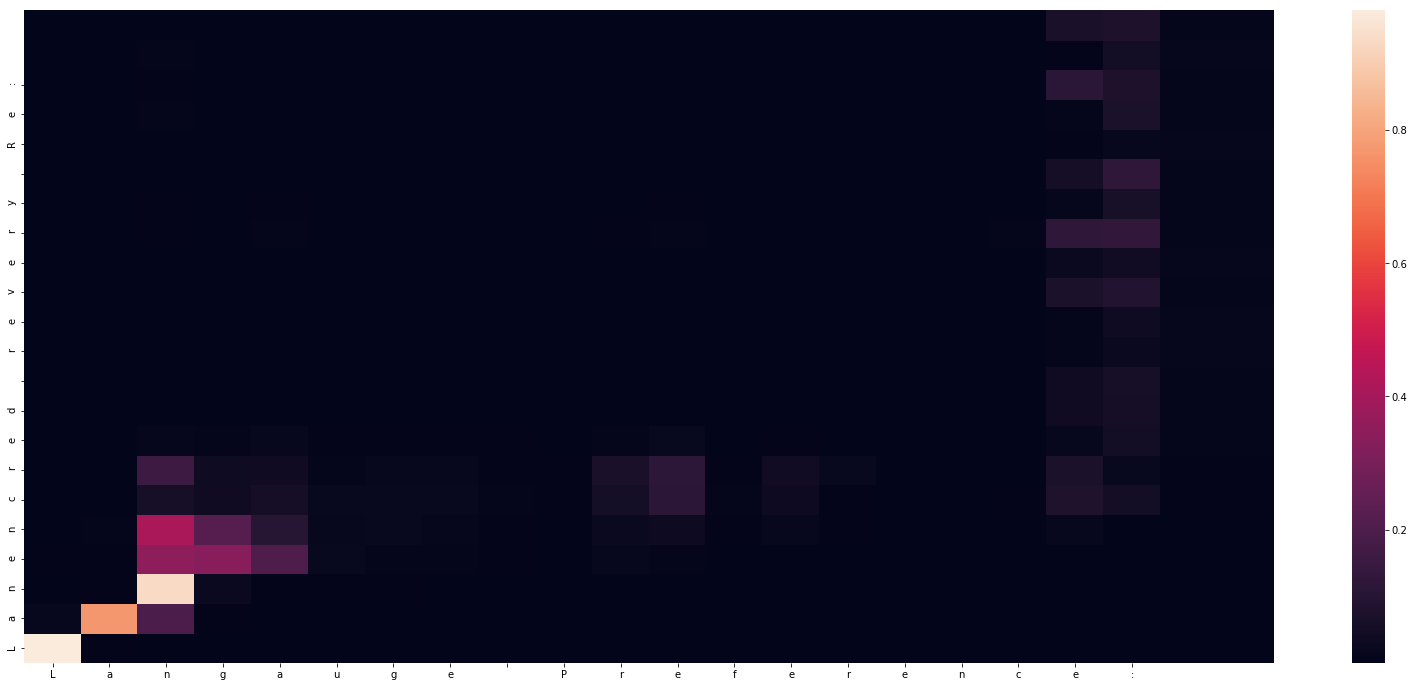

-
Input sentence: Langauge Preference:
GT sentence: Language Preference:

Decoded sentence: Lanencred revery Re:


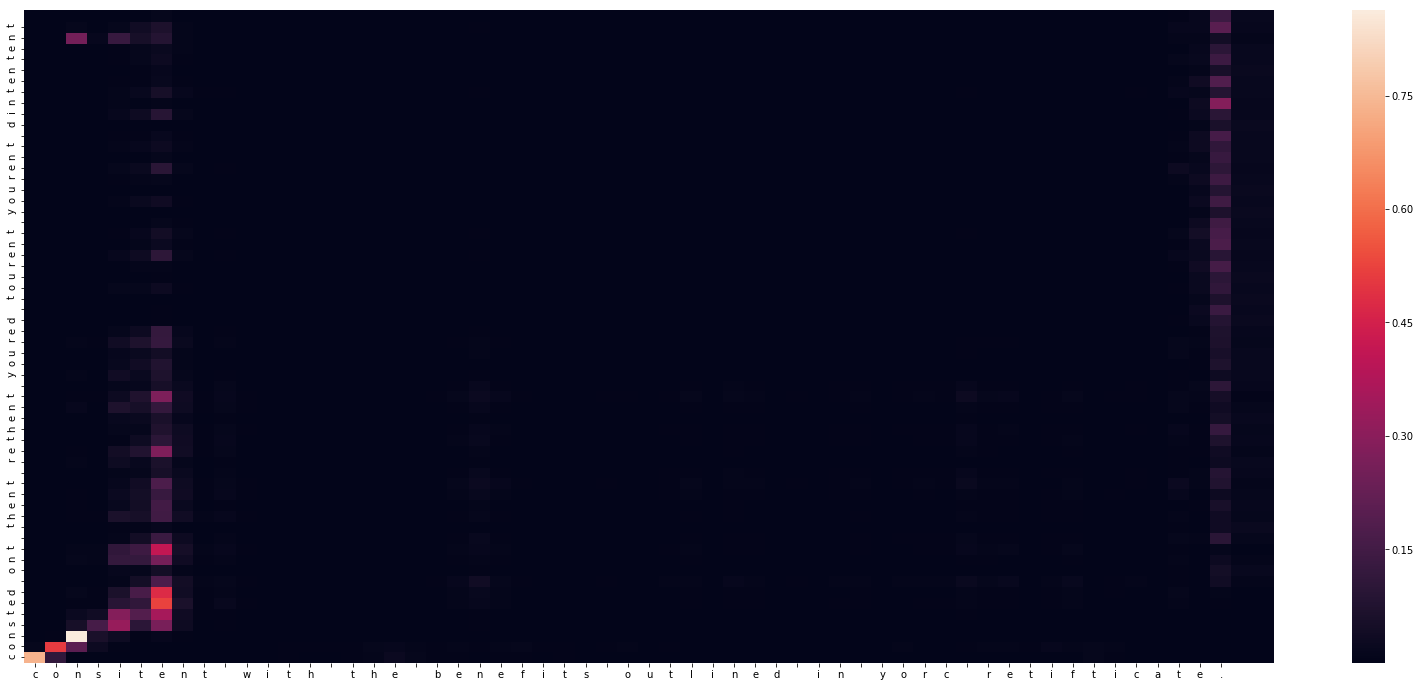

-
Input sentence: consitent with the benefits outlined in yorc retifticate.
GT sentence: consistent with the benefits outlined in your certificate.

Decoded sentence: consted ont thent rethent youred tourent yourent dintentent


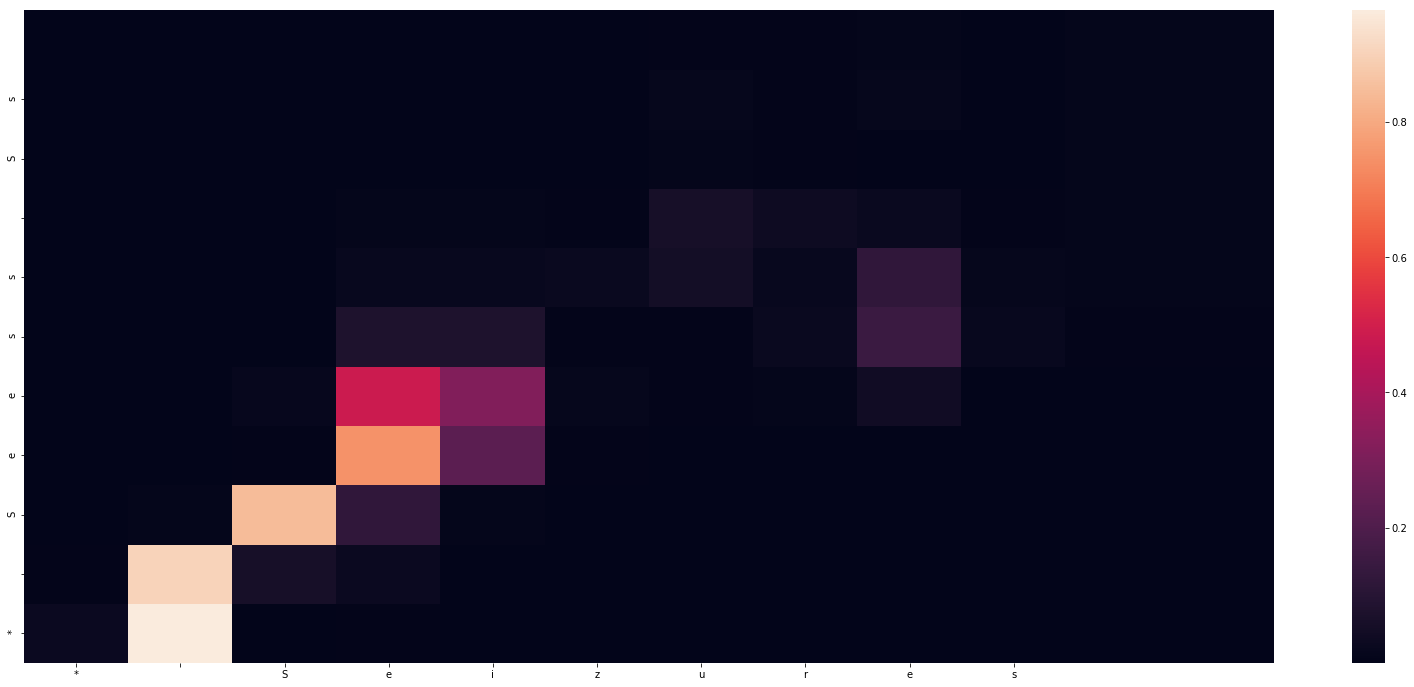

-
Input sentence: * Seizures
GT sentence: * Seizures

Decoded sentence: * Seess Ss


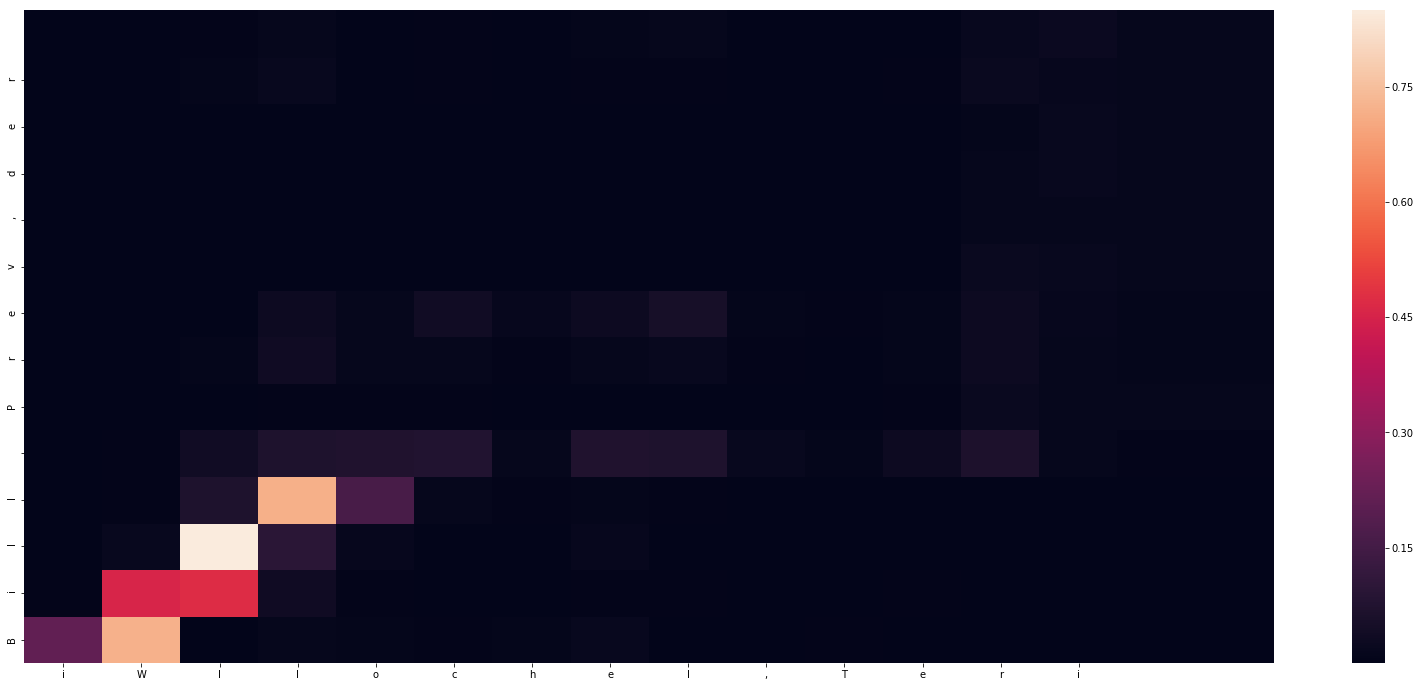

-
Input sentence: iWllochel,Teri
GT sentence: Willochel,Teri

Decoded sentence: Bill Prev,der


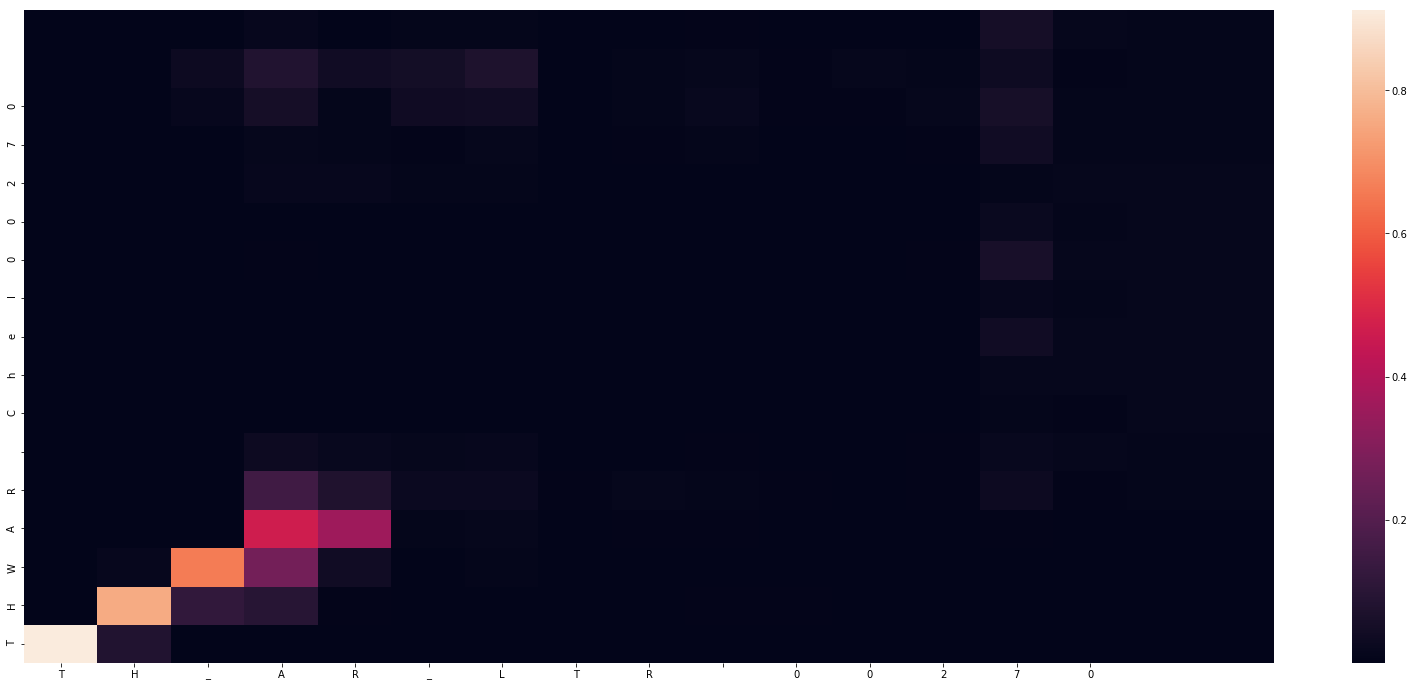

-
Input sentence: TH_AR_LTR 00270
GT sentence: TH_AR_LTR 002270

Decoded sentence: THWAR Chel00270


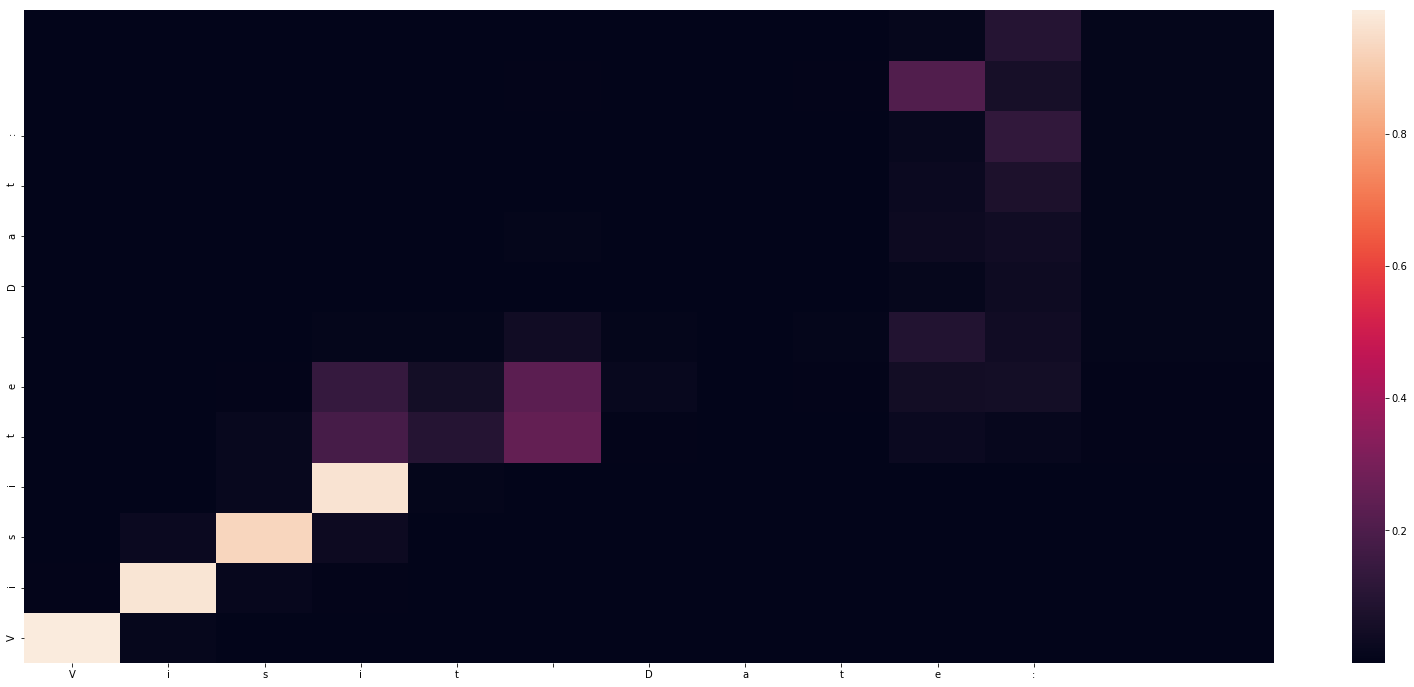

-
Input sentence: Visit Date:
GT sentence: Visit Date:

Decoded sentence: Visite Dat:


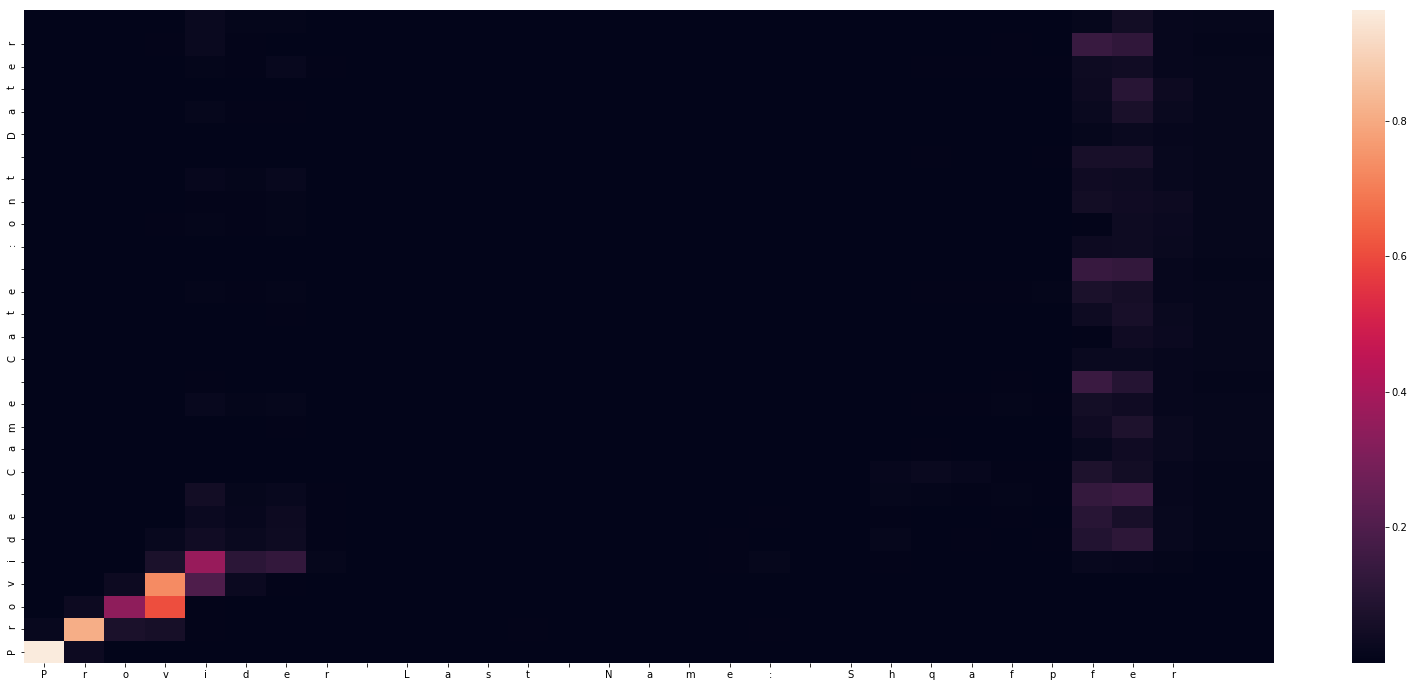

-
Input sentence: Provider Last Name: Shqafpfer
GT sentence: Provider Last Name: Shaffer

Decoded sentence: Provide Came Cate :ont Dater


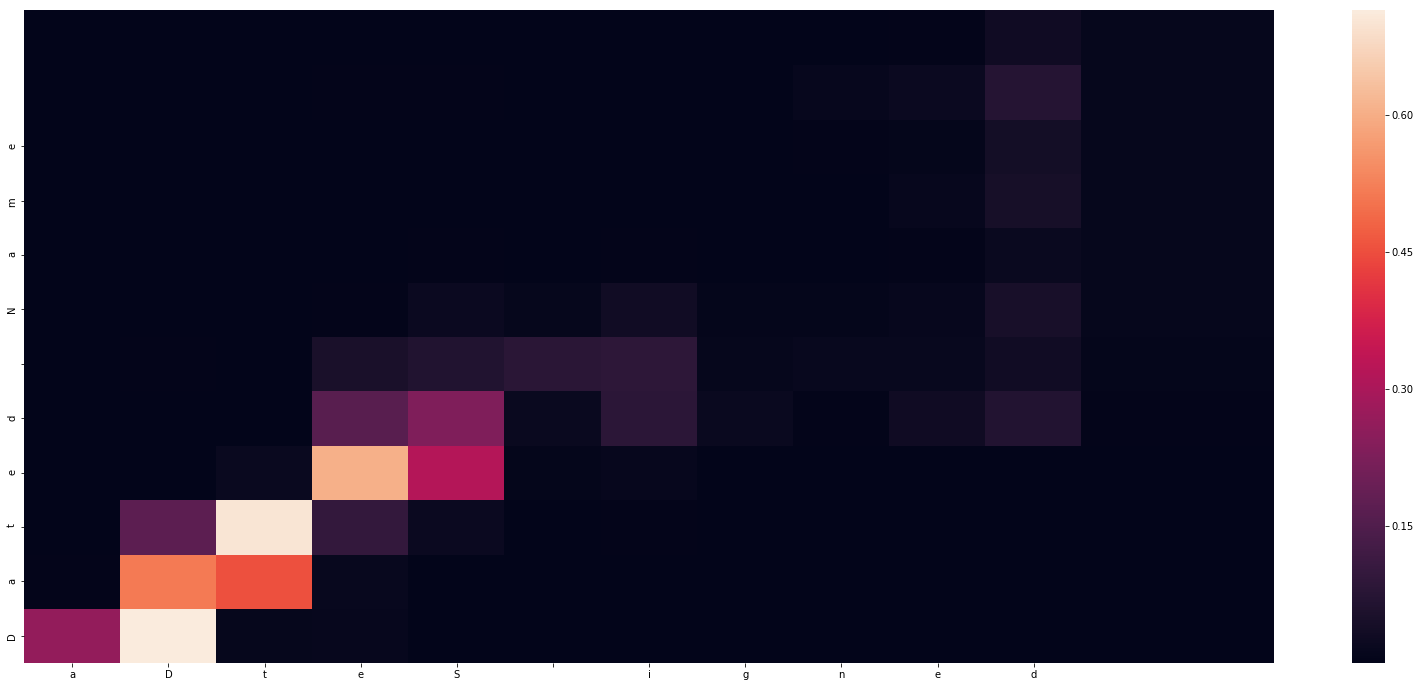

-
Input sentence: aDteS igned
GT sentence: Date Signed

Decoded sentence: Dated Name


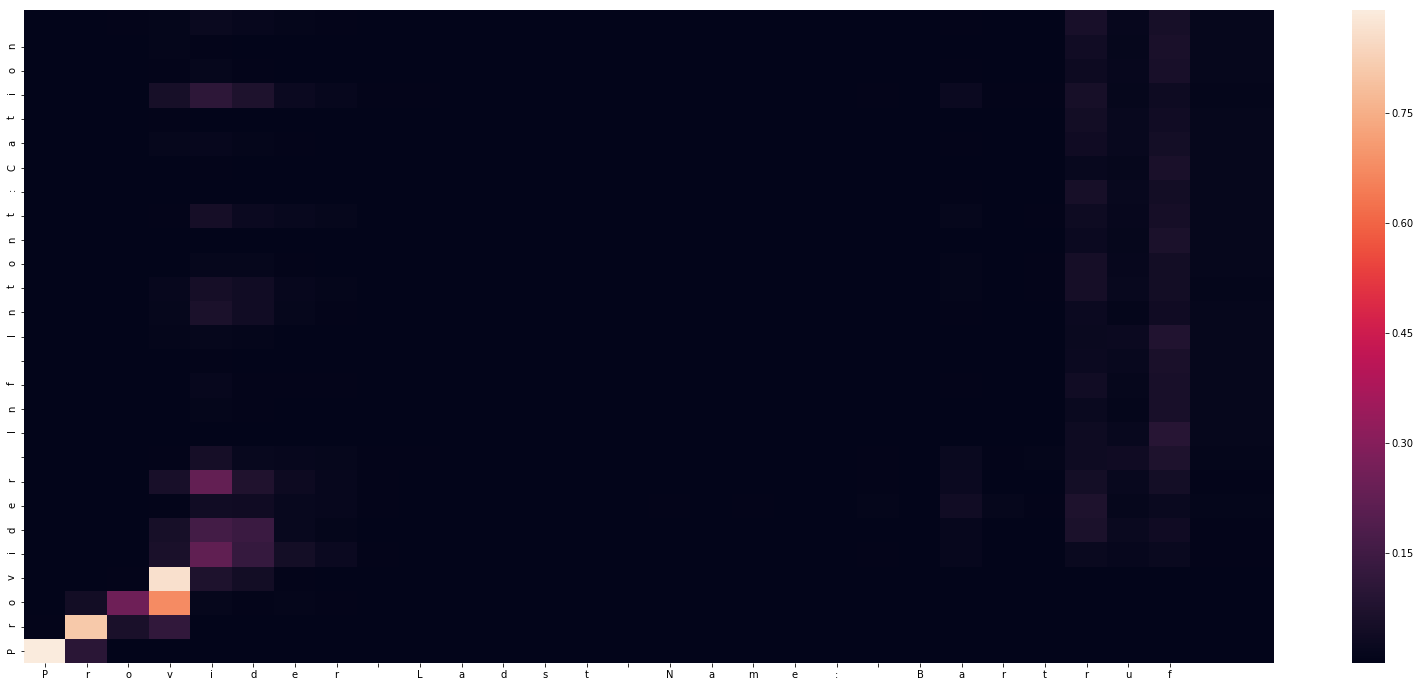

-
Input sentence: Provider Ladst Name: Bartruf
GT sentence: Provider Last Name: Bartruff

Decoded sentence: Provider Inf Intont:Cation


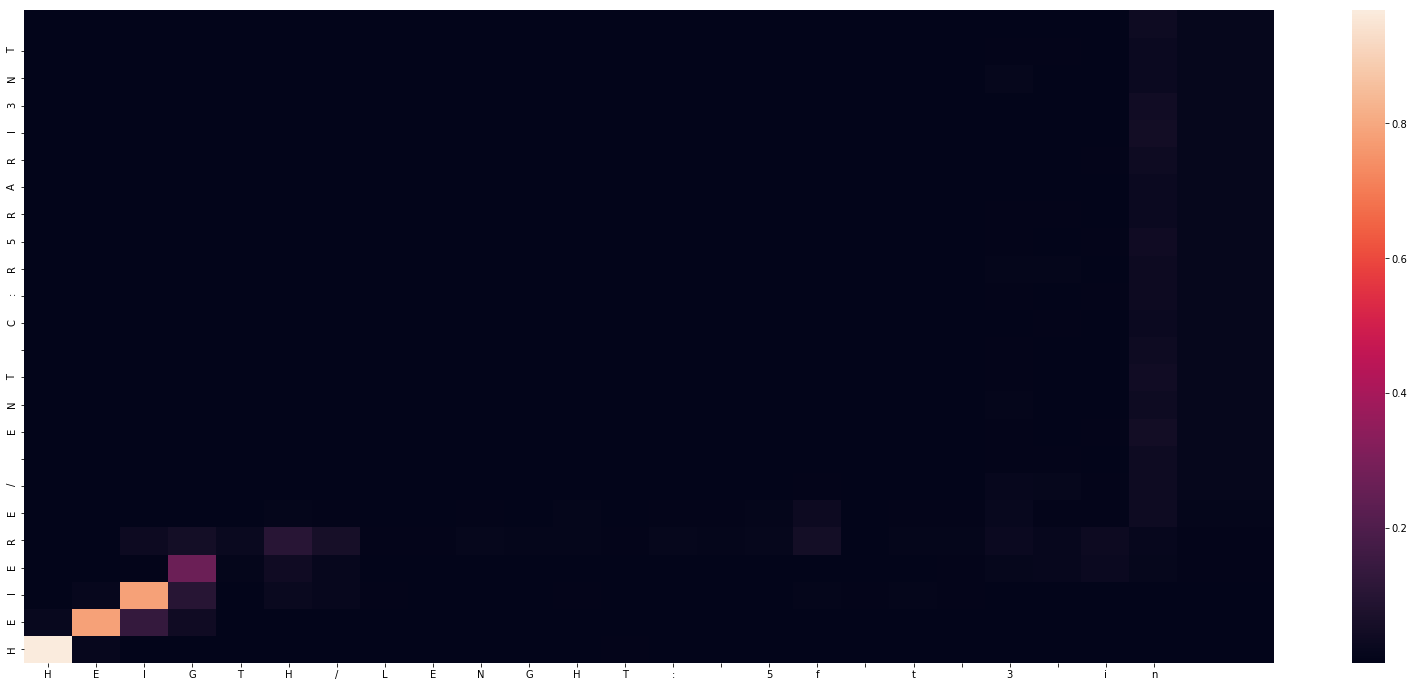

-
Input sentence: HEIGTH/LENGHT: 5f t 3 in
GT sentence: HEIGTH/LENGHT: 5 ft 3 in

Decoded sentence: HEIERE/ ENT C:R5RARI3NT


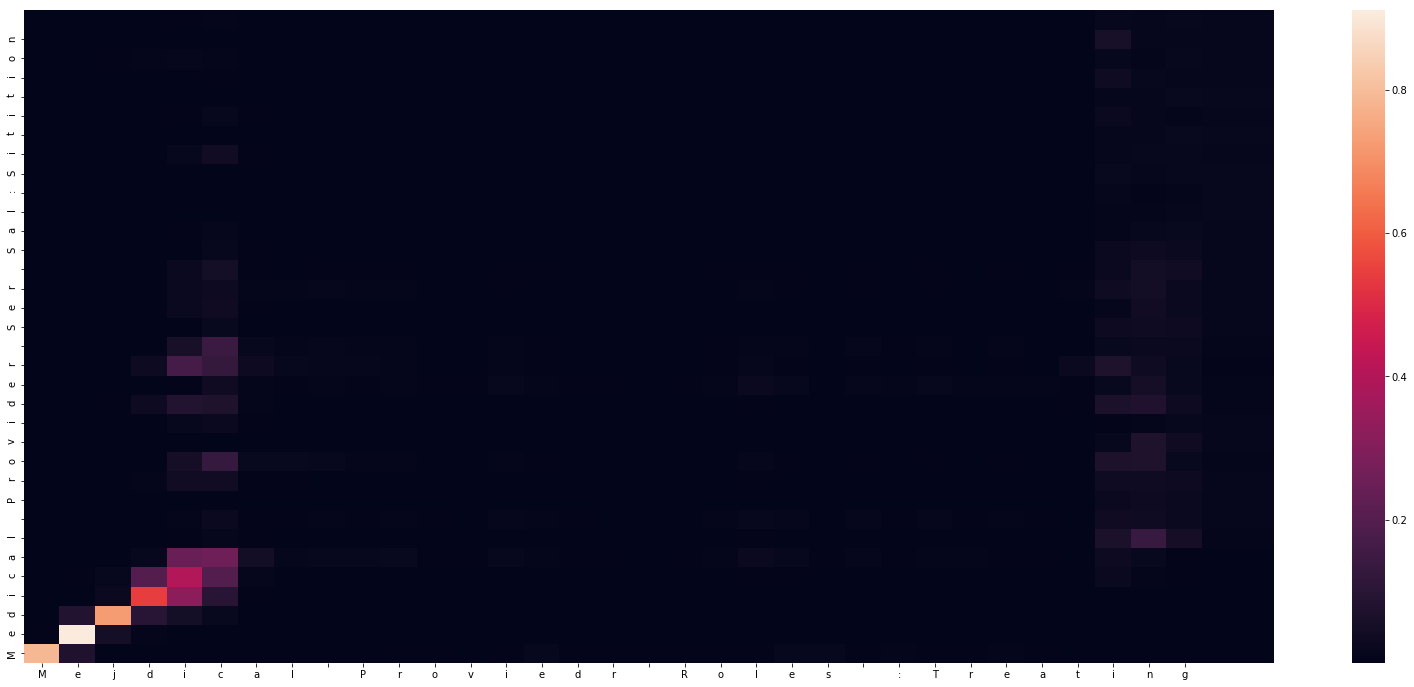

-
Input sentence: Mejdical Proviedr Roles :Treating
GT sentence: Medical Provider Roles: Treating

Decoded sentence: Medical Provider Ser Sal:Sitition


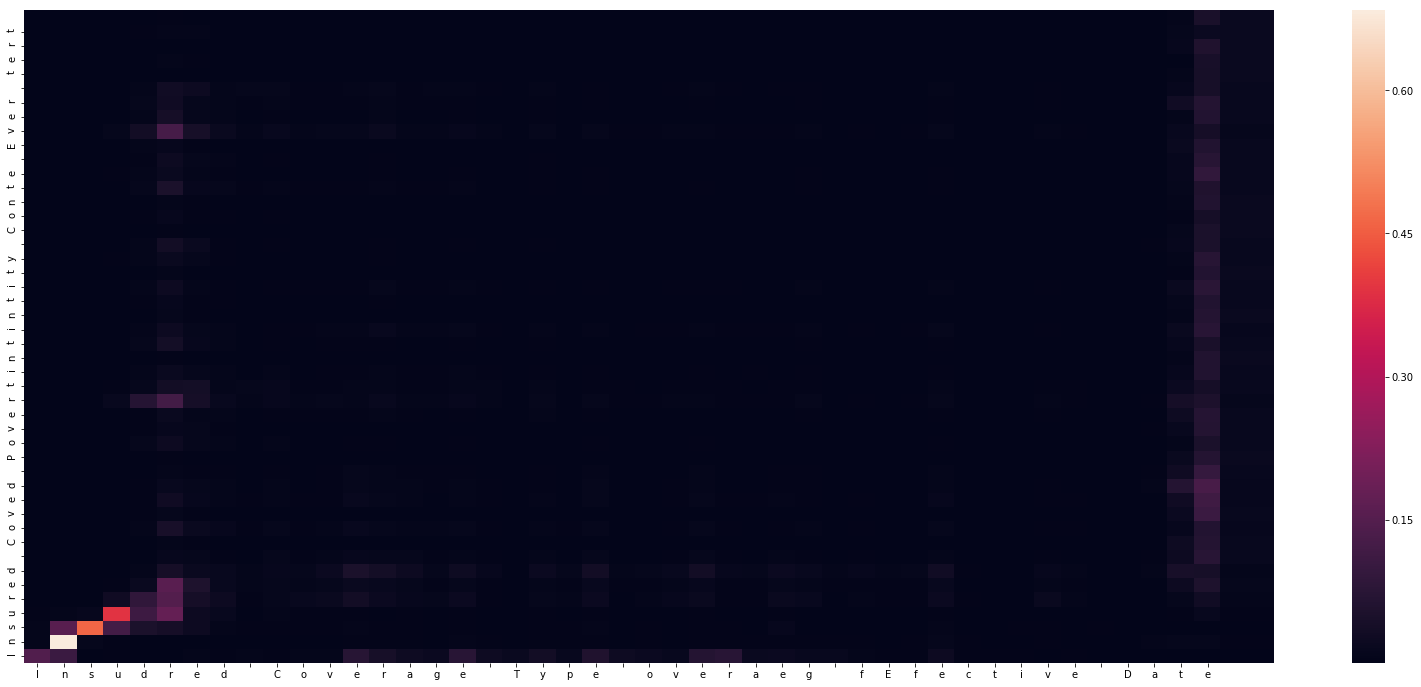

-
Input sentence: Insudred Coverage Type overaeg fEfective Date
GT sentence: Insured Coverage Type Coverage Effective Date

Decoded sentence: Insured Coved Povertintintity Conte Ever tert


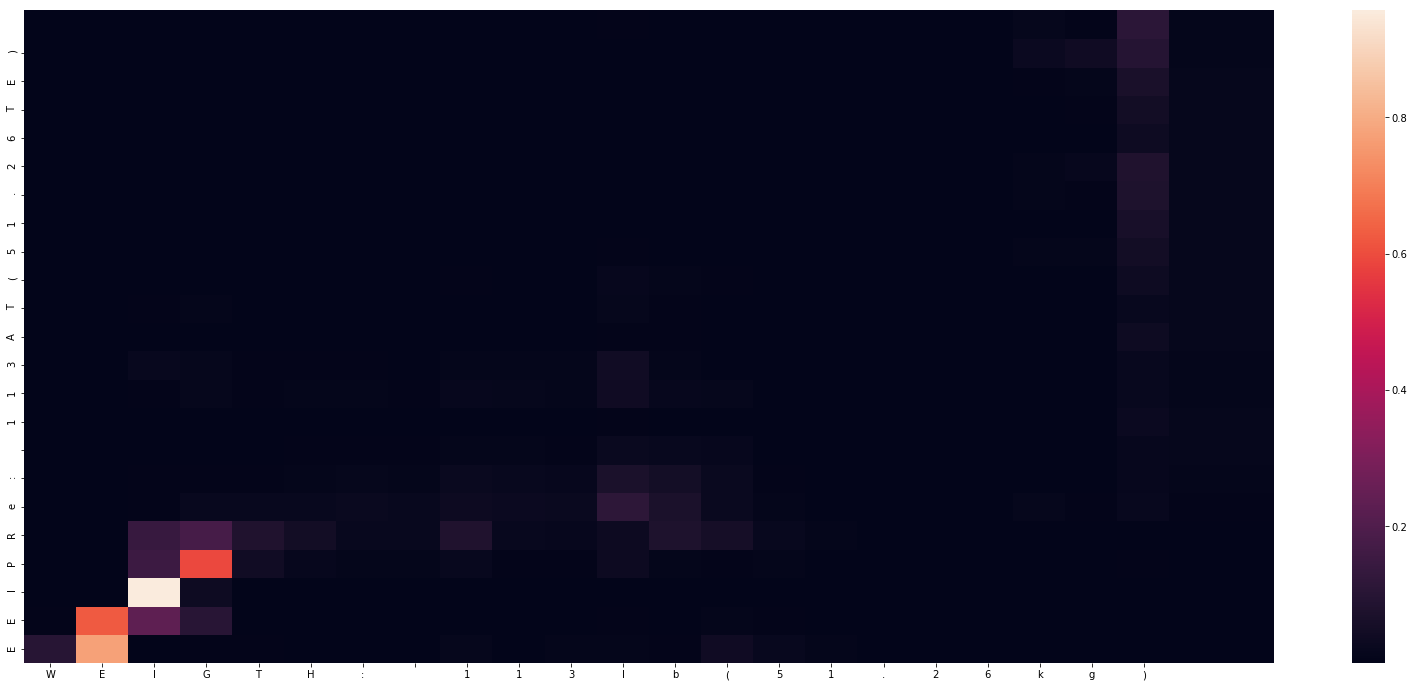

-
Input sentence: WEIGTH: 113lb(51.26kg)
GT sentence: WEIGTH: 113lb(51.26kg)

Decoded sentence: EEIPRe: 113AT(51.26TE)


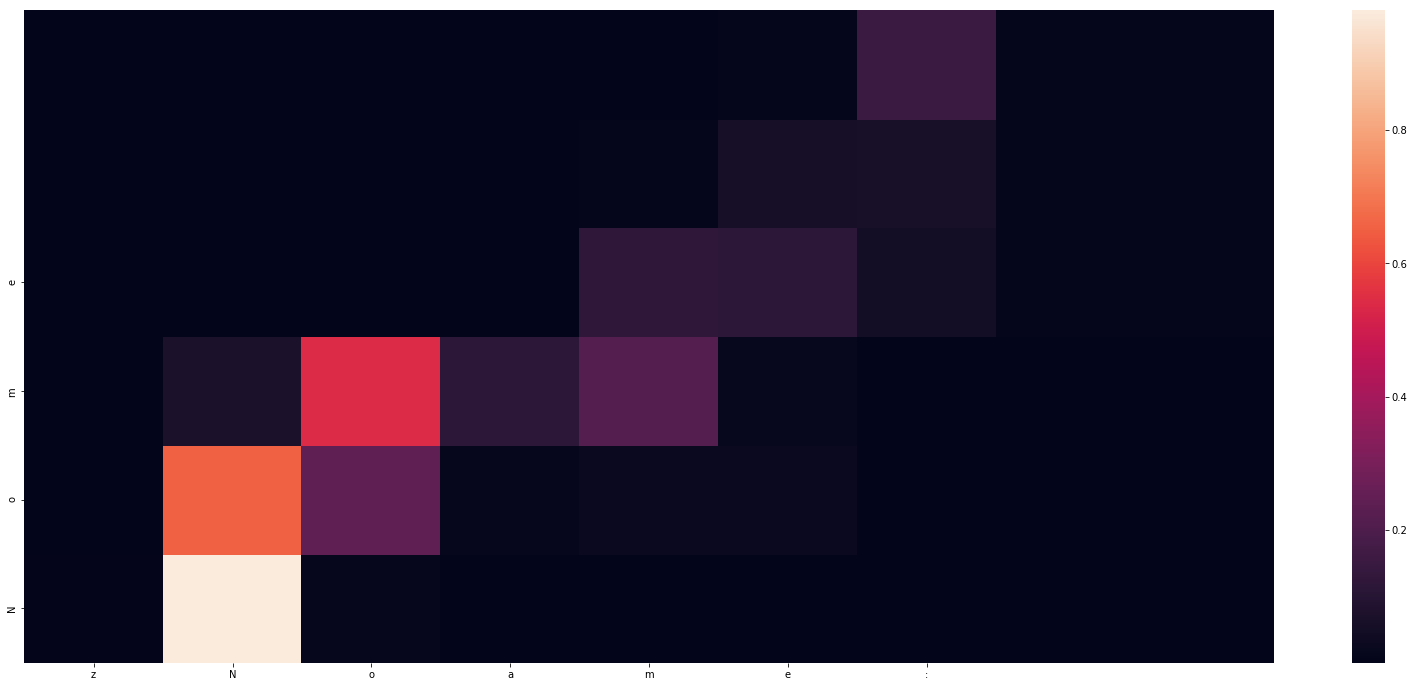

-
Input sentence: zNoame:
GT sentence: Name:

Decoded sentence: Nome


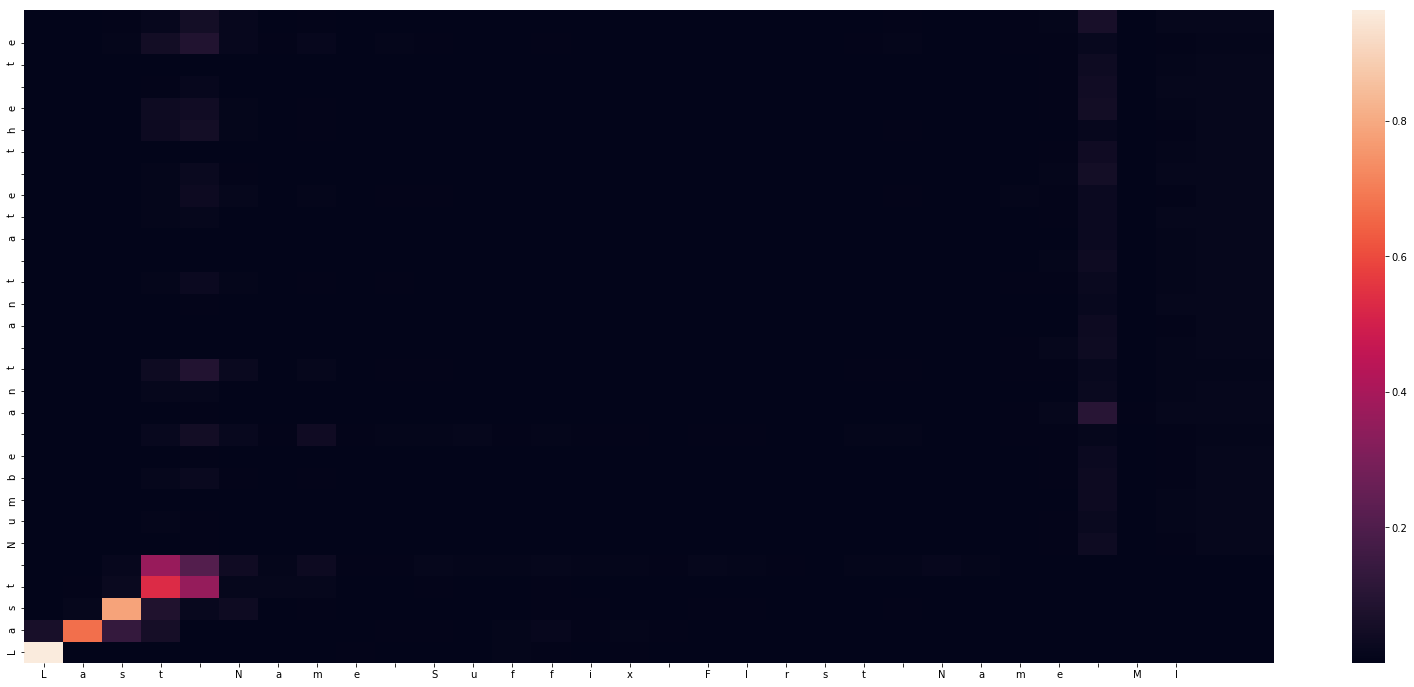

-
Input sentence: Last Name Suffix Flrst Name Ml
GT sentence: Last Name Suffix First Name MI

Decoded sentence: Last Numbe ant ant ate the te


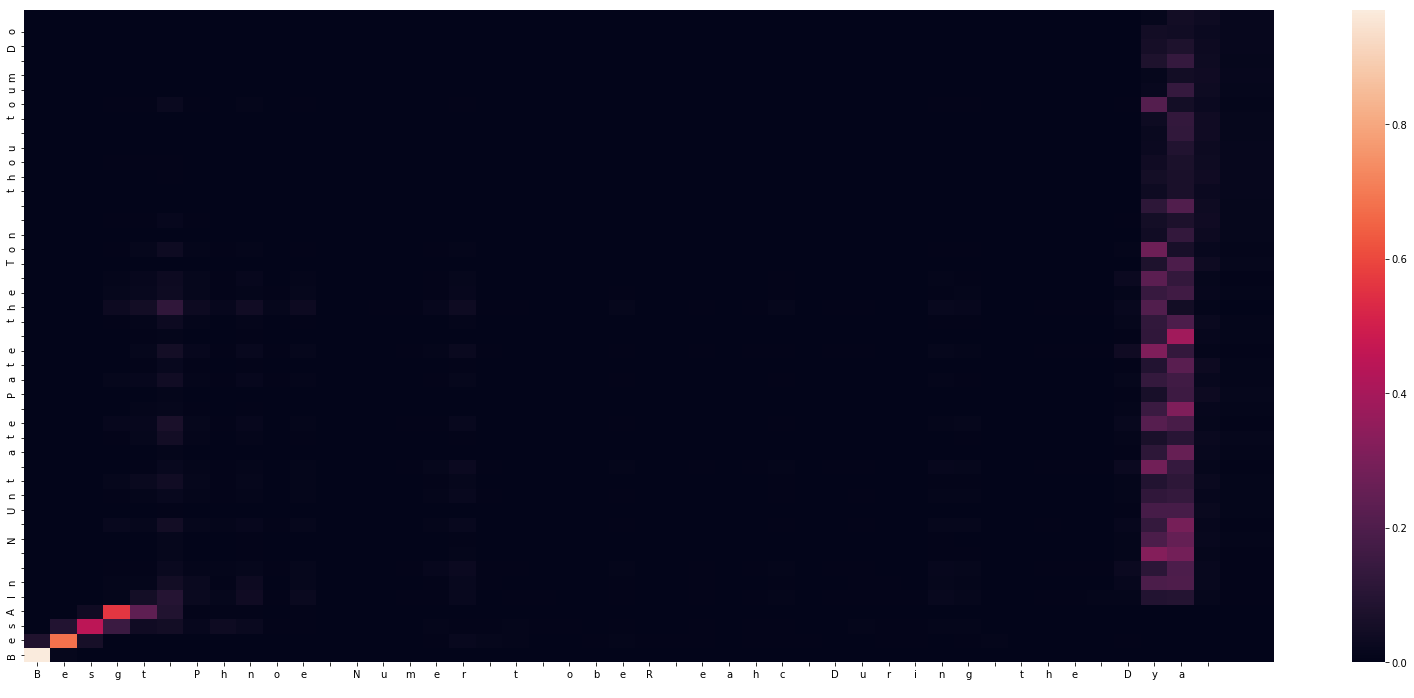

-
Input sentence: Besgt Phnoe Numer t obeR eahc During the Dya

GT sentence: Best Phone Number to be Reach During the Day:

Decoded sentence: BesAIn  N Unt ate Pate the Ton  thou toum Do


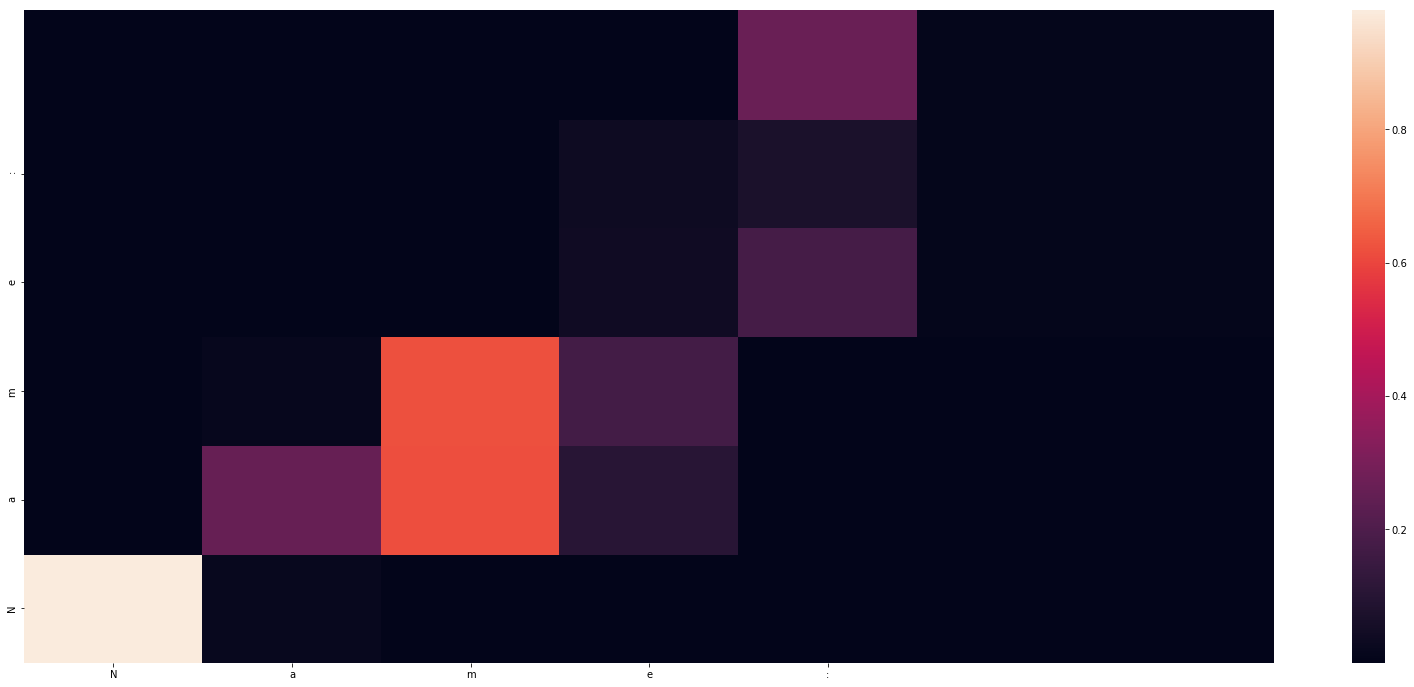

-
Input sentence: Name:
GT sentence: Name:

Decoded sentence: Name:


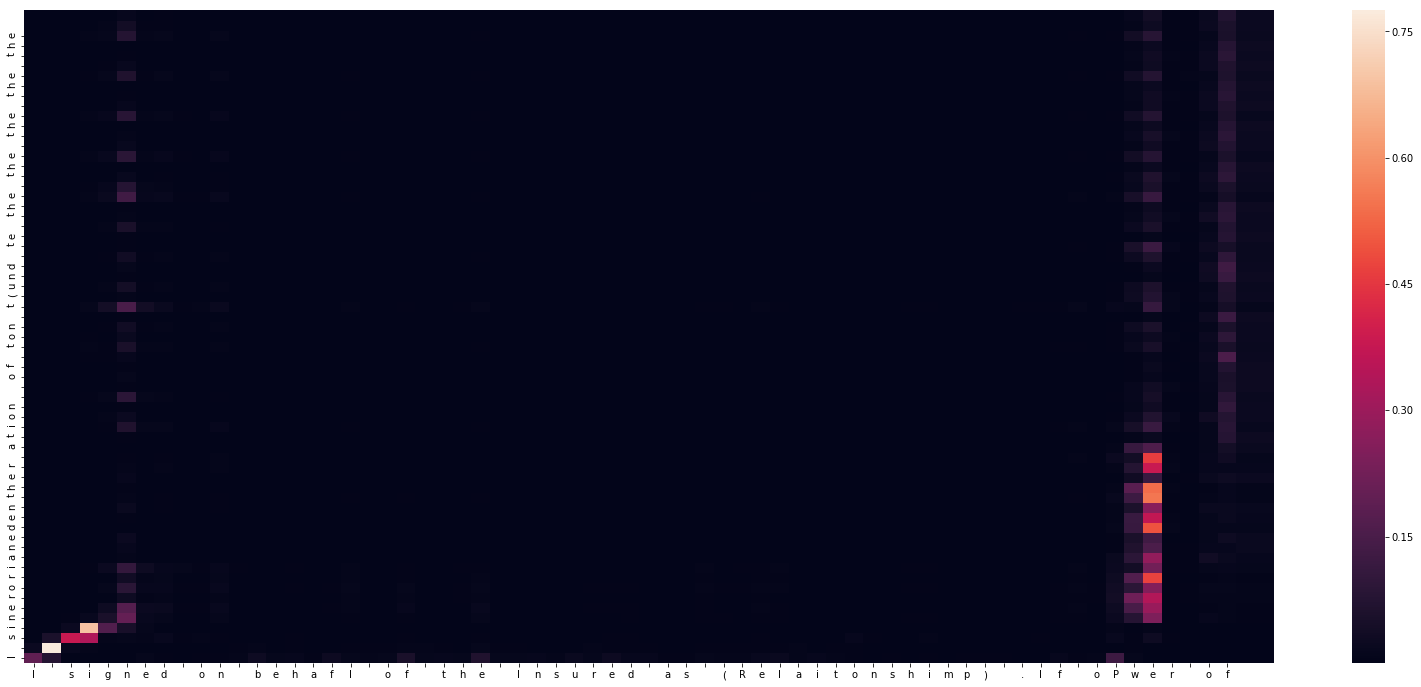

-
Input sentence: I signed on behafl of the Insured as (Relaitonshimp) .If oPwer of
GT sentence: I signed on behalf of the Insured as (Relationship). If Power of

Decoded sentence: I sinerorianedenther ation  of ton t(und te the the the the the


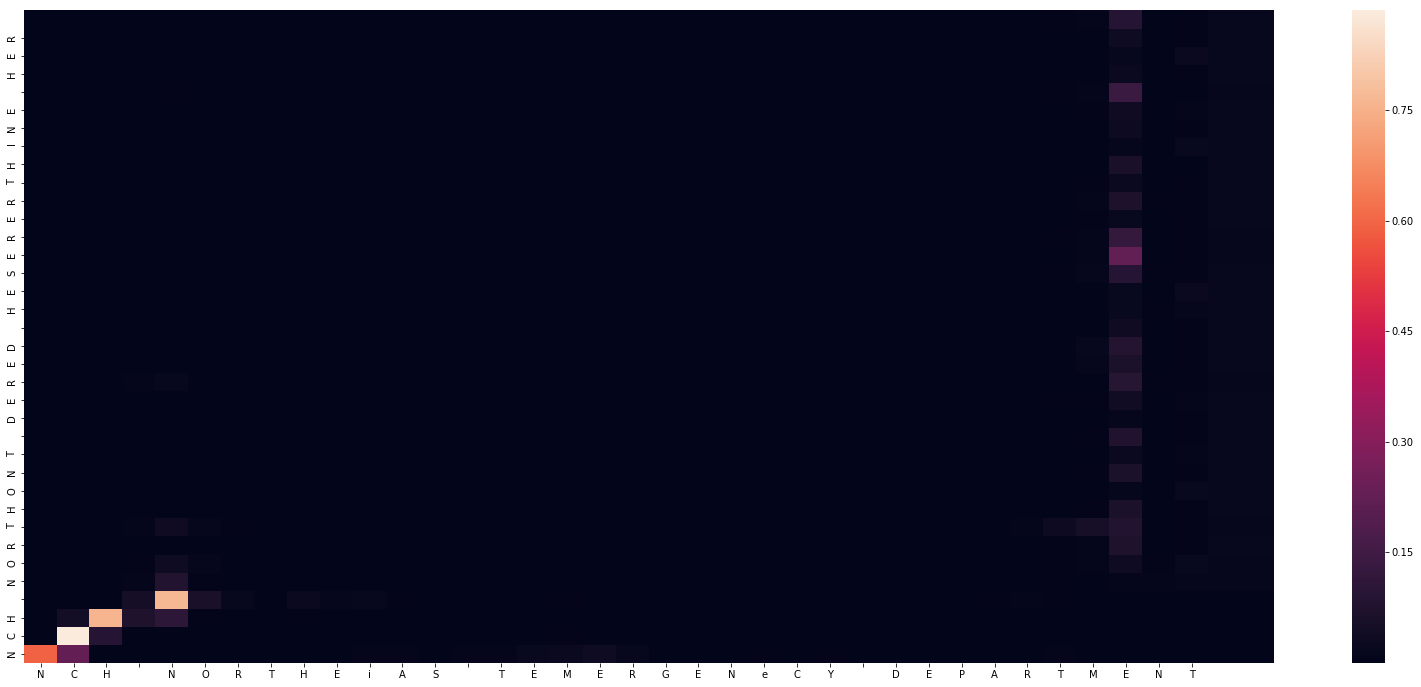

-
Input sentence: NCH NORTHEiAS TEMERGENeCY DEPARTMENT
GT sentence: NCH NORTHEAST EMERGENCY DEPARTMENT

Decoded sentence: NCH NORTHONT DERED HESERERTHINE HER


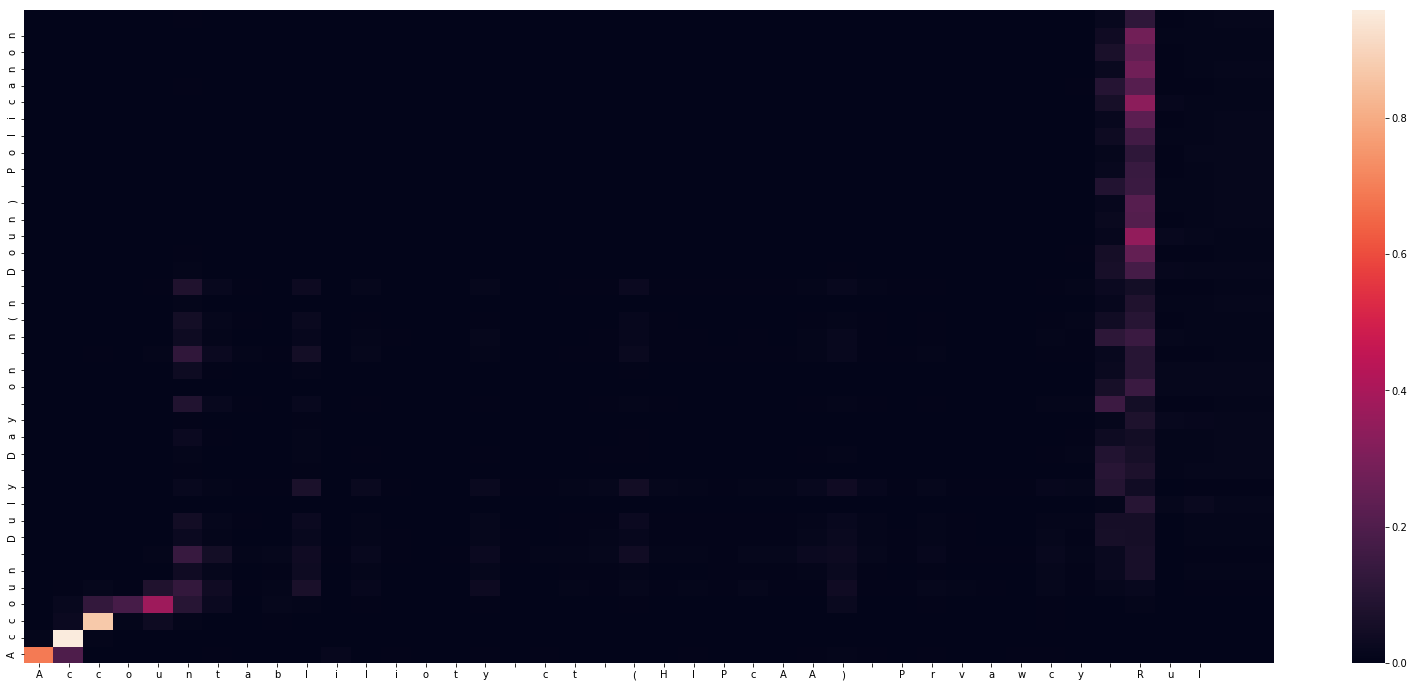

-
Input sentence: Accountablilioty ct (HIPcAA) Prvawcy Rul
GT sentence: Accountability Act (HIPAA) Privacy Rule

Decoded sentence: Accoun Duly Day on n(n Doun) Policanon


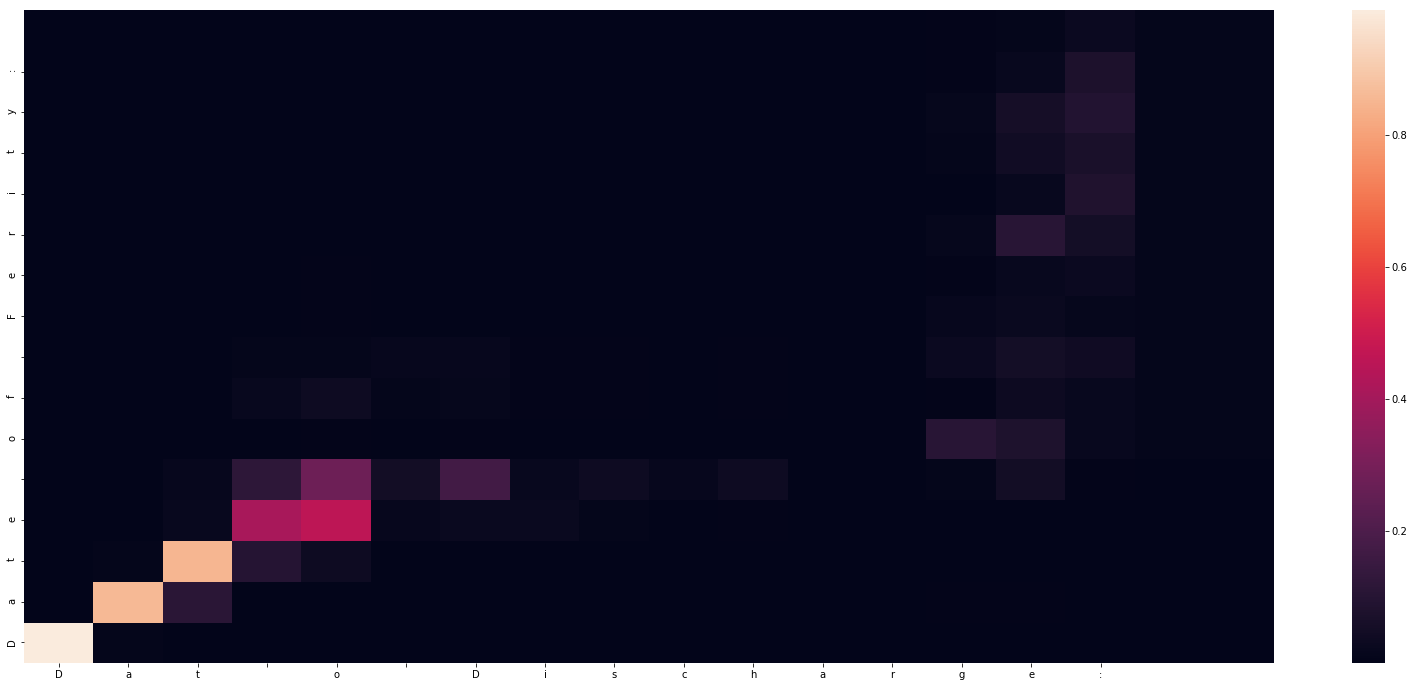

-
Input sentence: Dat o Discharge:
GT sentence: Date of Discharge:

Decoded sentence: Date of Ferity:


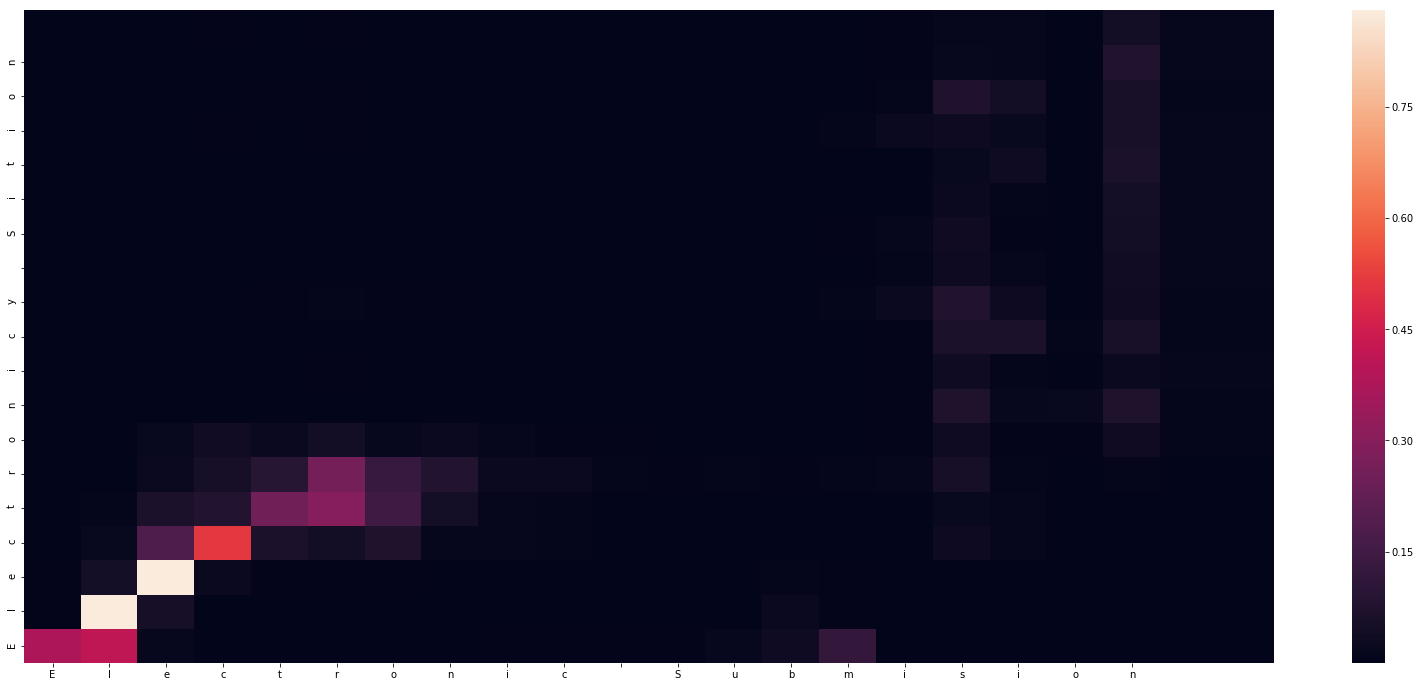

-
Input sentence: Electronic Submision
GT sentence: Electronic Submission

Decoded sentence: Electronicy Sition


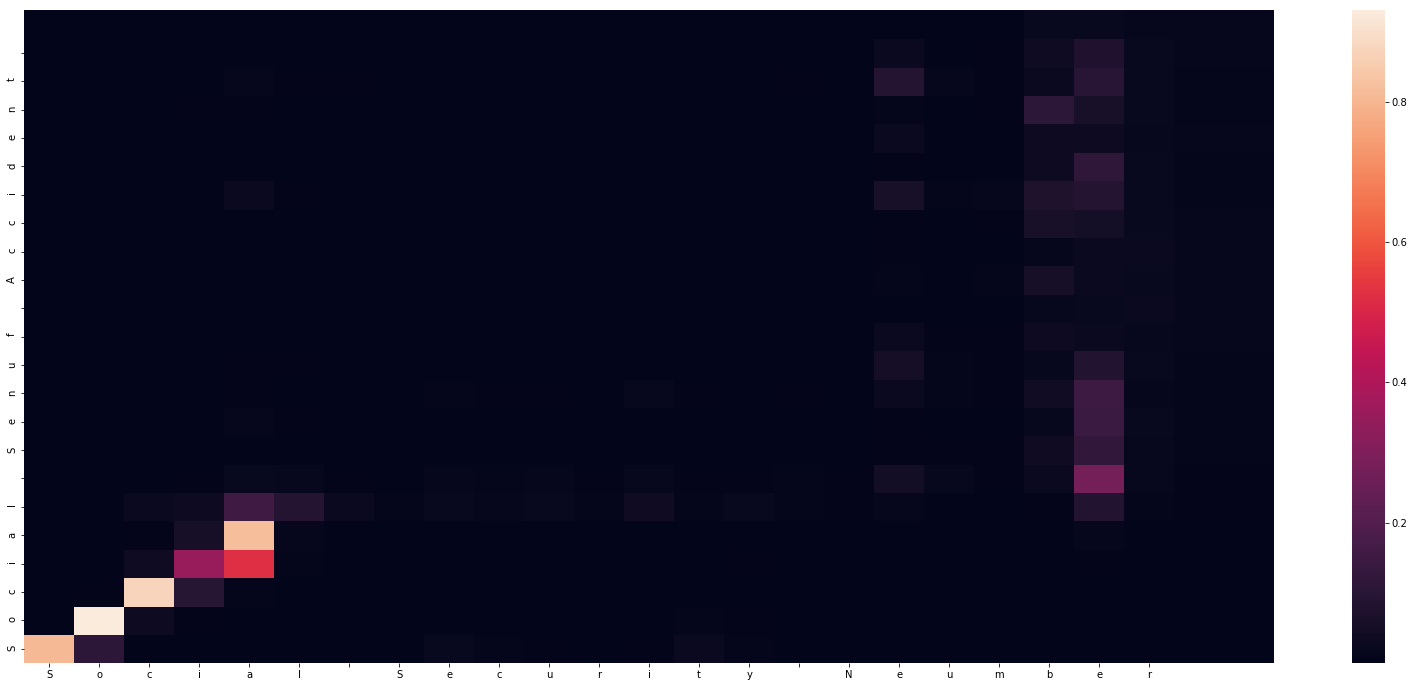

-
Input sentence: Social Security Neumber
GT sentence: Social Security Number

Decoded sentence: Social Senuf Accident 


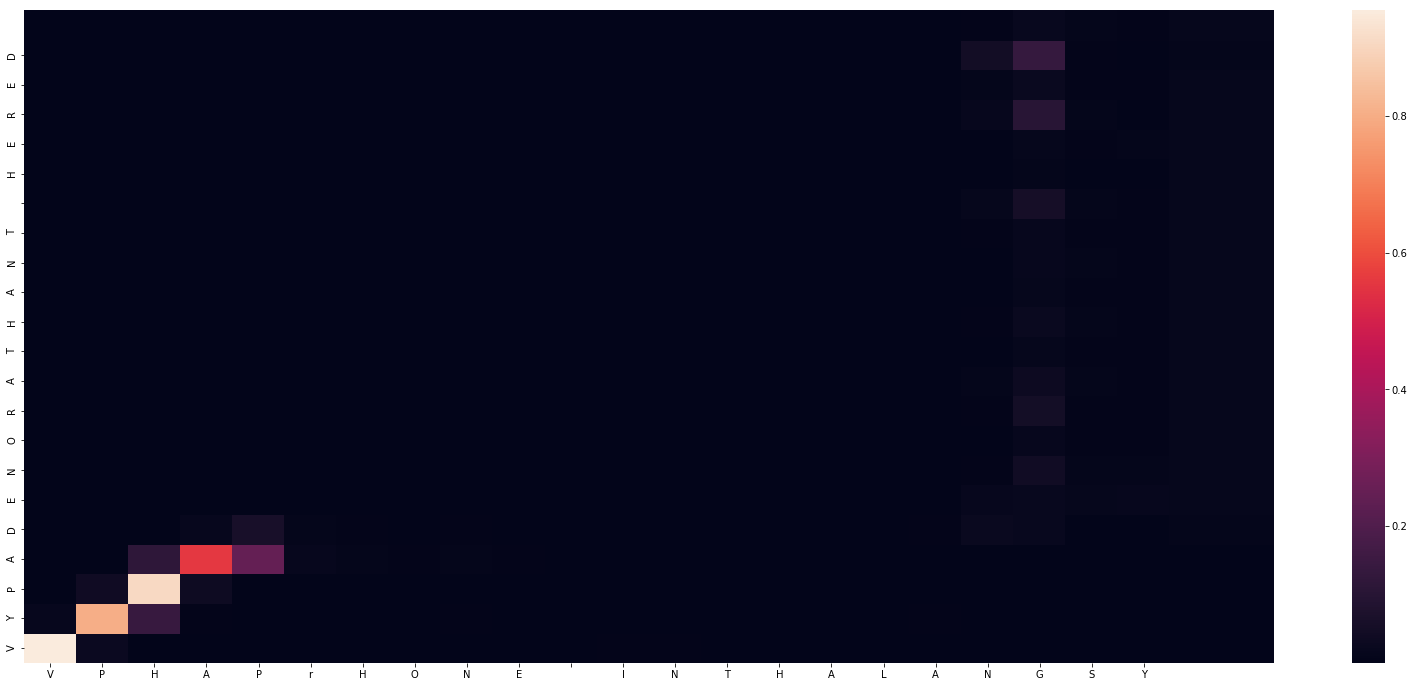

-
Input sentence: VPHAPrHONE INTHALANGSY
GT sentence: VYPHAPHONE INTHALANGSY

Decoded sentence: VYPADENORATHANT HERED


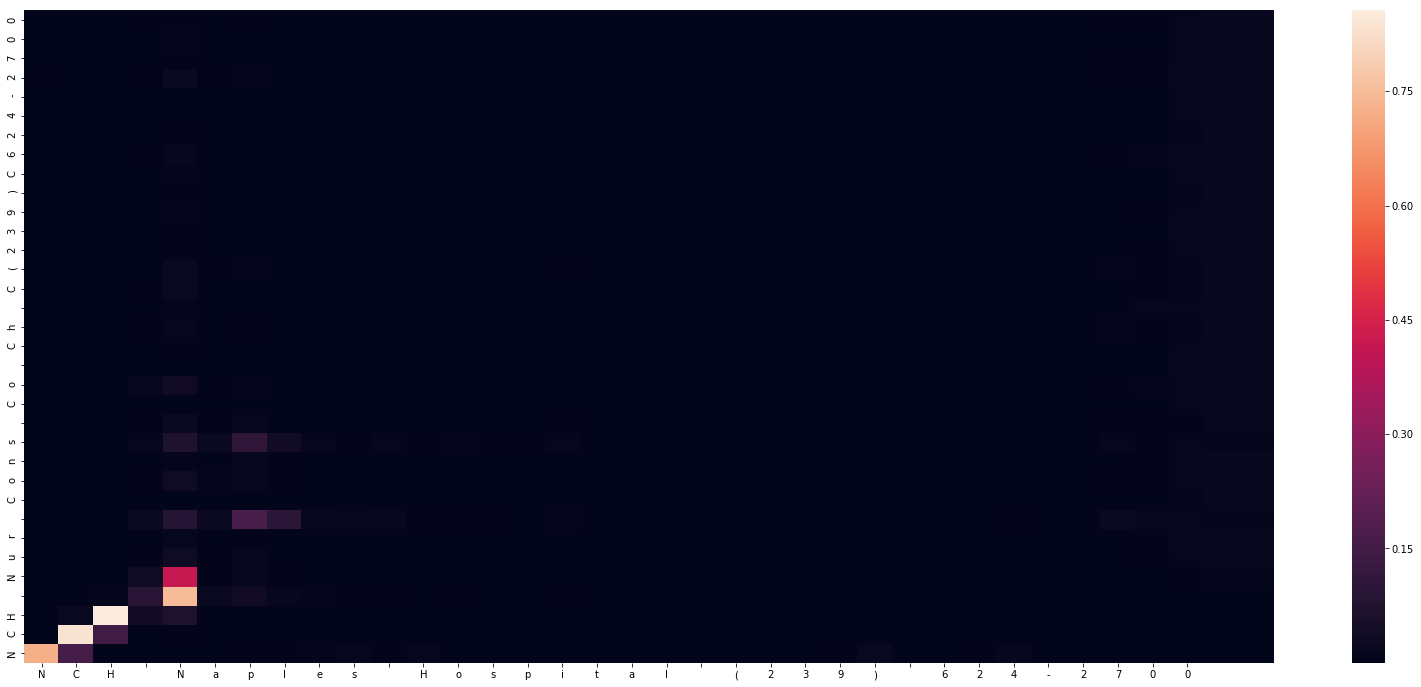

-
Input sentence: NCH Naples Hospital (239) 624-2700
GT sentence: NCH Naples Hospital (239) 624-2700

Decoded sentence: NCH Nur Cons Co Ch C(239)C624-2700


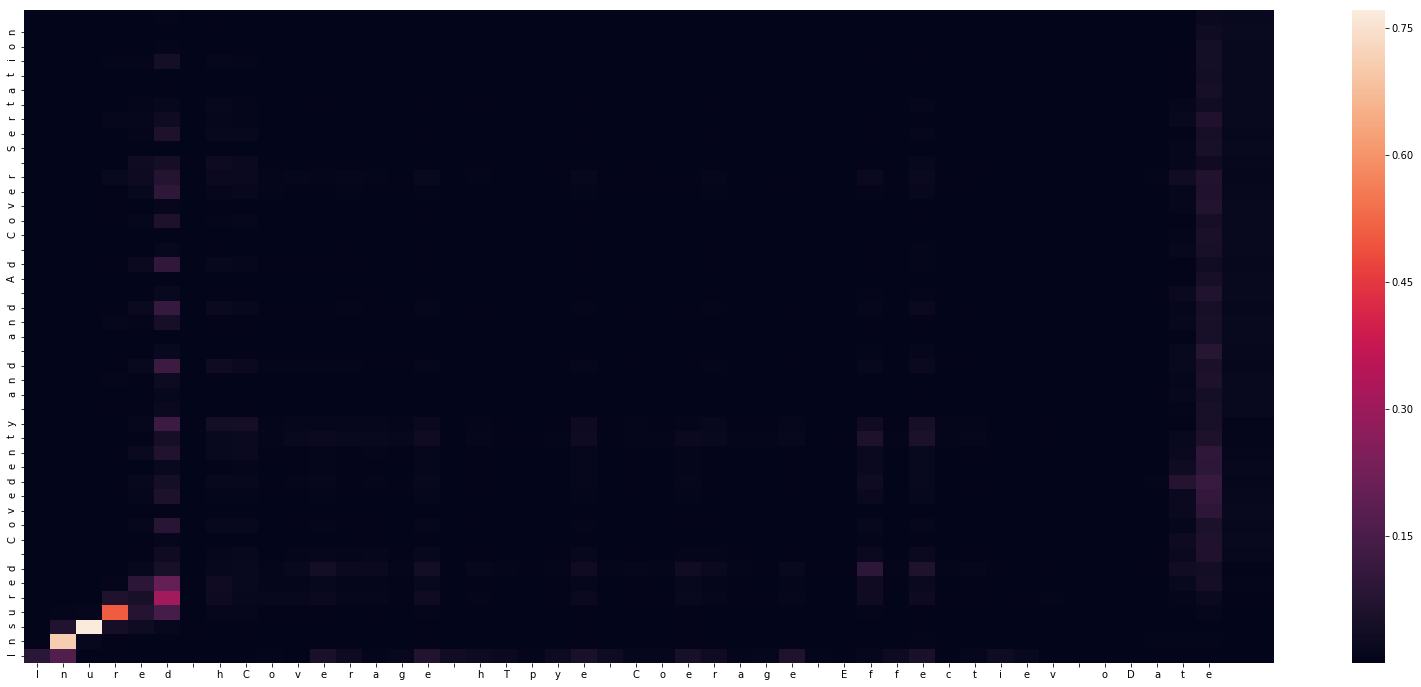

-
Input sentence: Inured hCoverage hTpye Coerage Effectiev oDate
GT sentence: Insured Coverage Type Coverage Effective Date

Decoded sentence: Insured Covedenty and and Ad Cover Sertation


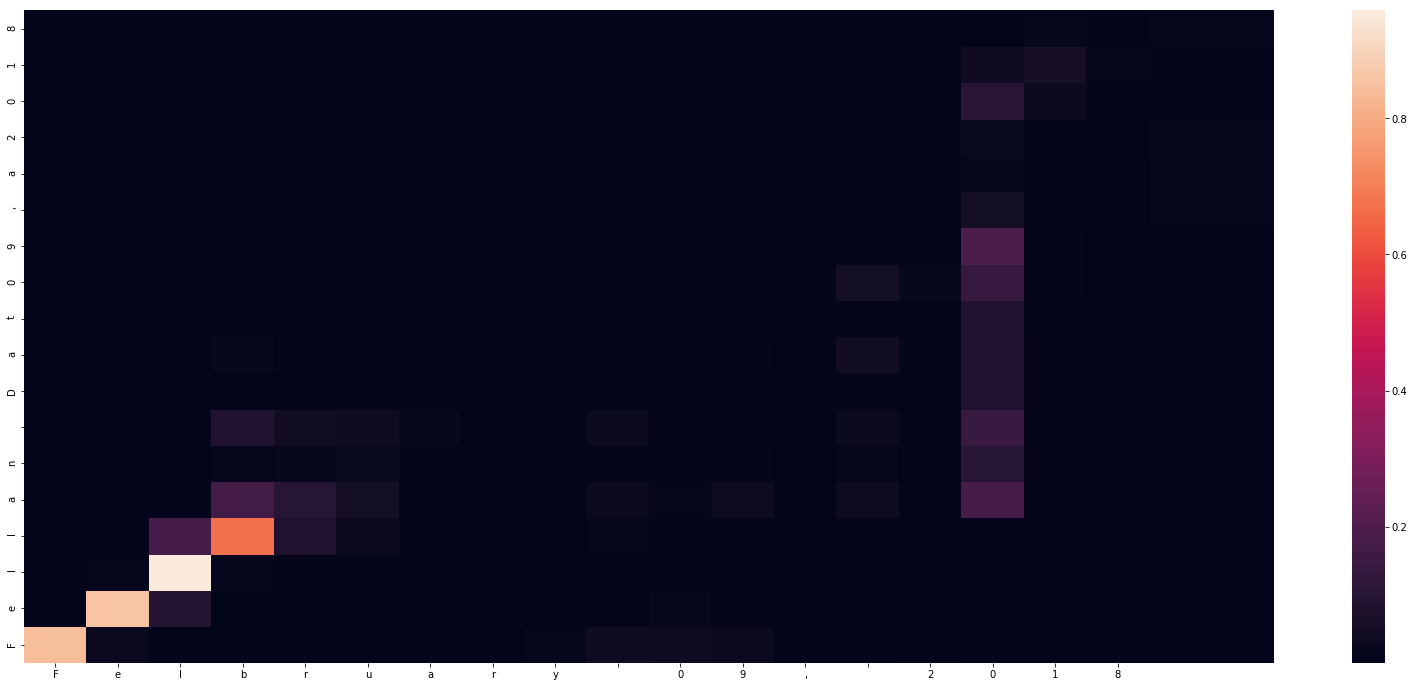

-
Input sentence: Felbruary 09, 2018
GT sentence: February 09, 2018

Decoded sentence: Fellan Dat09,a2018


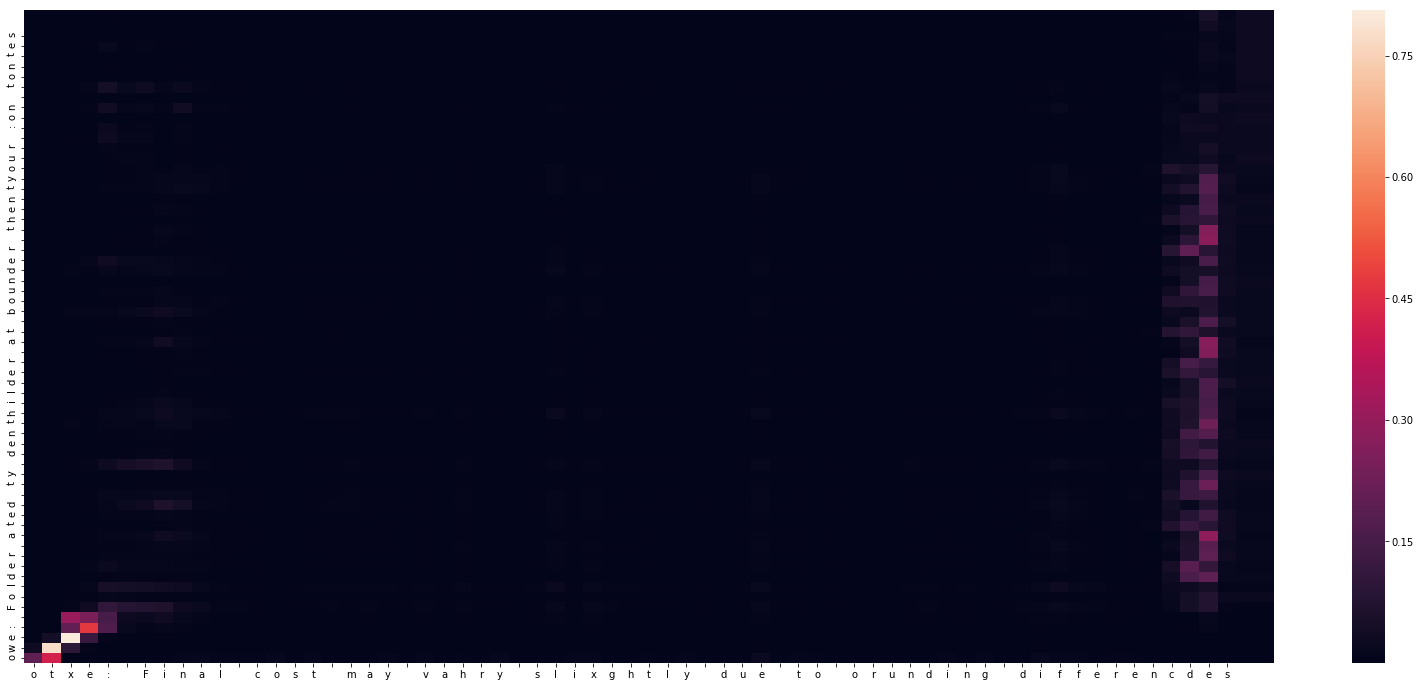

-
Input sentence: otxe: Final cost may vahry slixghtly due to orunding differencdes
GT sentence: Note: Final cost may vary slightly due to rounding differences.

Decoded sentence: owe: Folder ated ty denthilder at bounder thentyour :on tontes


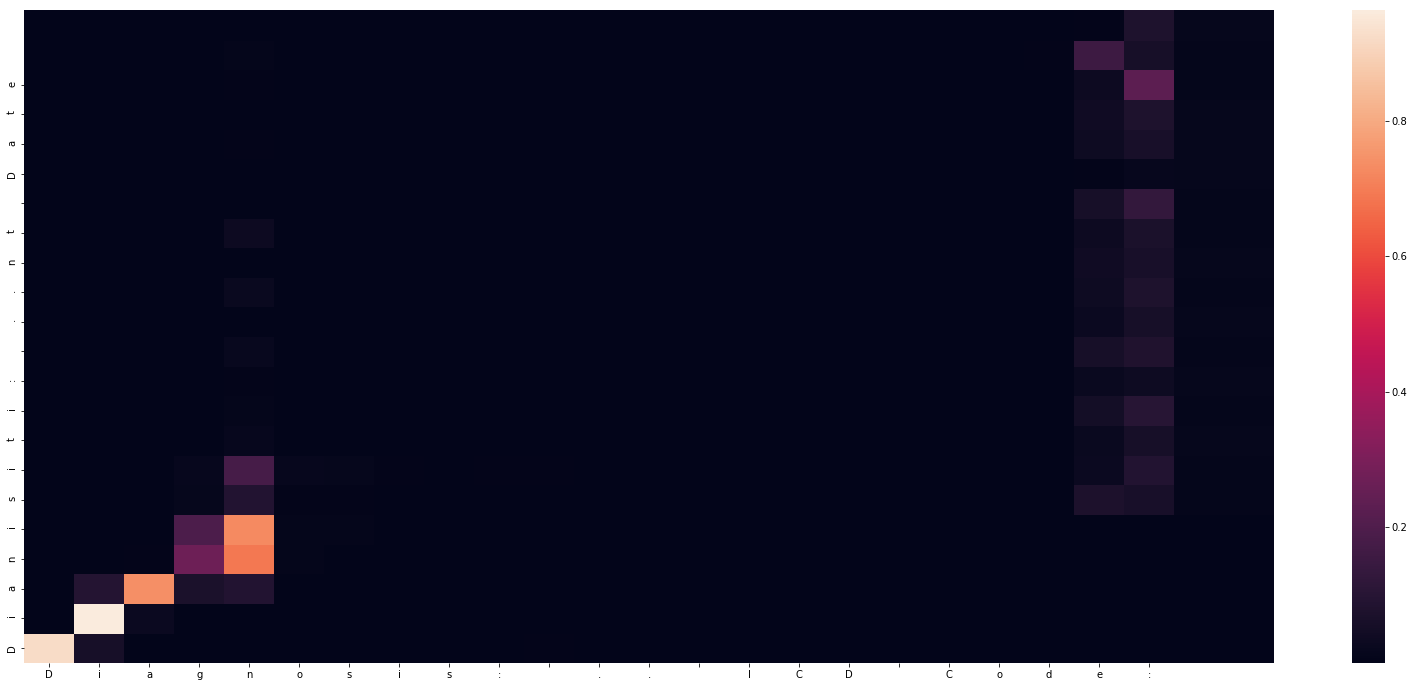

-
Input sentence: Diagnosis: .. lCD Code:
GT sentence: Diagnosis: ICD Code:

Decoded sentence: Dianisiti: ..nt Date


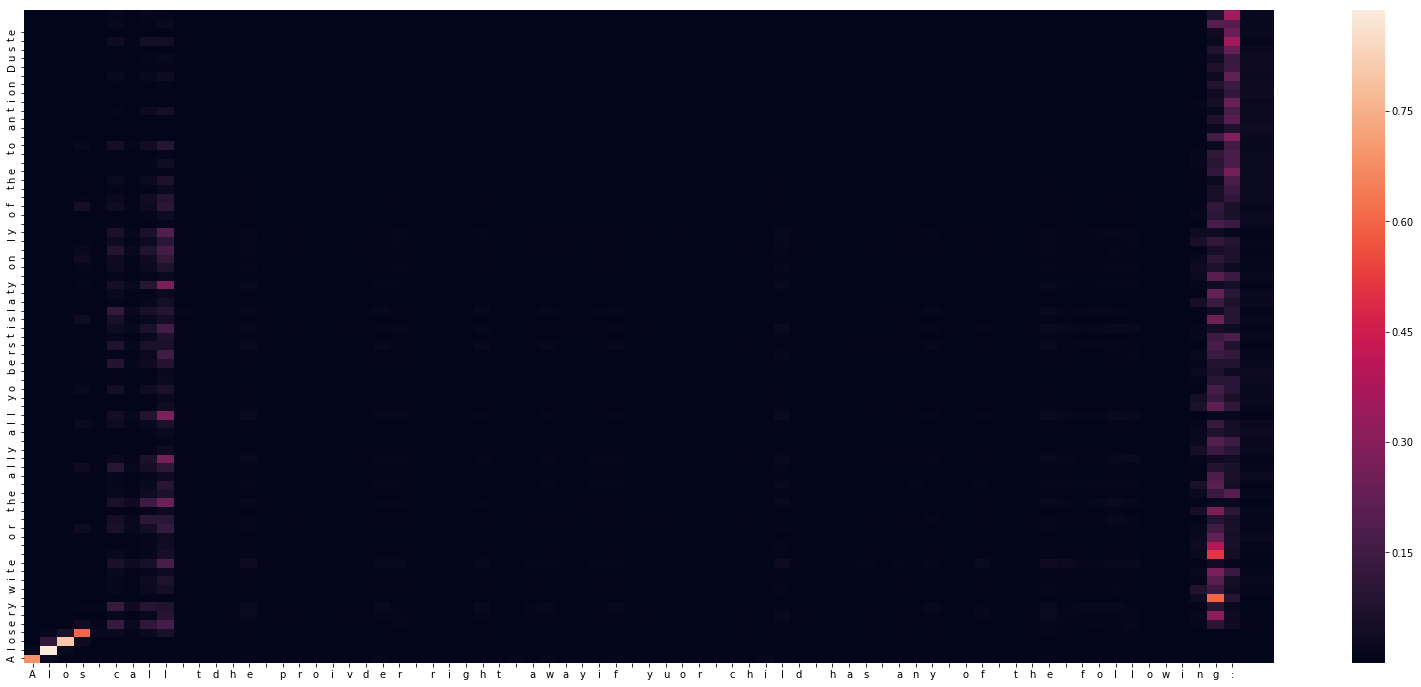

-
Input sentence: Alos call tdhe proivder right awayif yuor child has any of the following:
GT sentence: Also call the provider right away if your child has any of the following:

Decoded sentence: Alosery wite  or the ally all yo berstislaty on ly of the to antion Duste


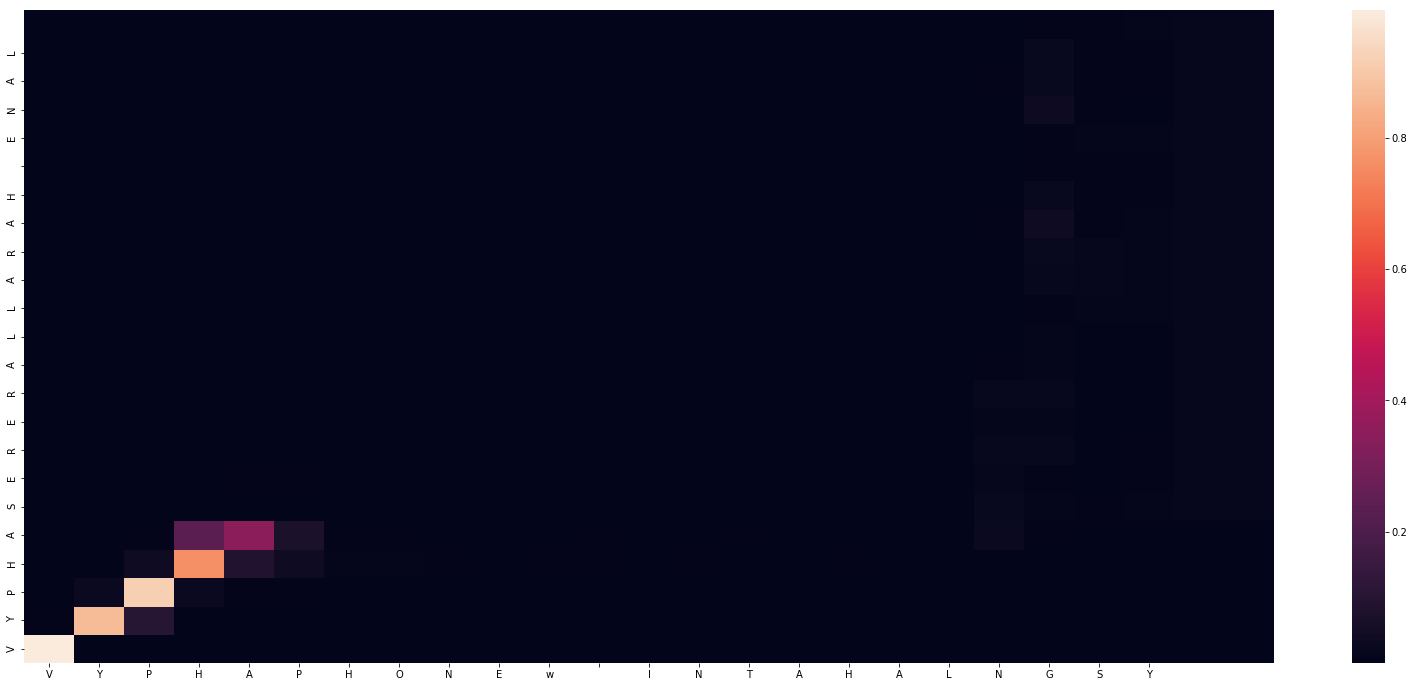

-
Input sentence: VYPHAPHONEw INTAHALNGSY
GT sentence: VYPHAPHONE INTHALANGSY

Decoded sentence: VYPHASERERALLARAH ENAL


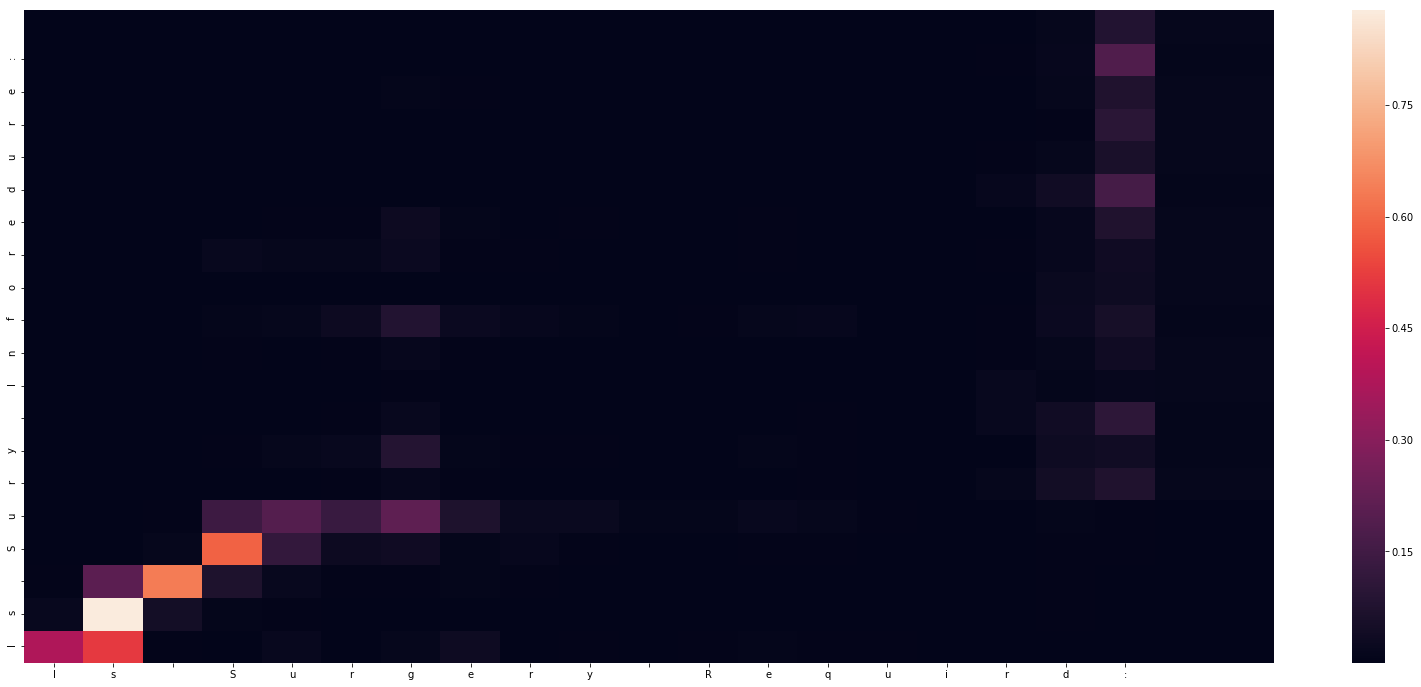

-
Input sentence: Is Surgery Requird:
GT sentence: Is Surgery Required:

Decoded sentence: Is Sury Inforedure:


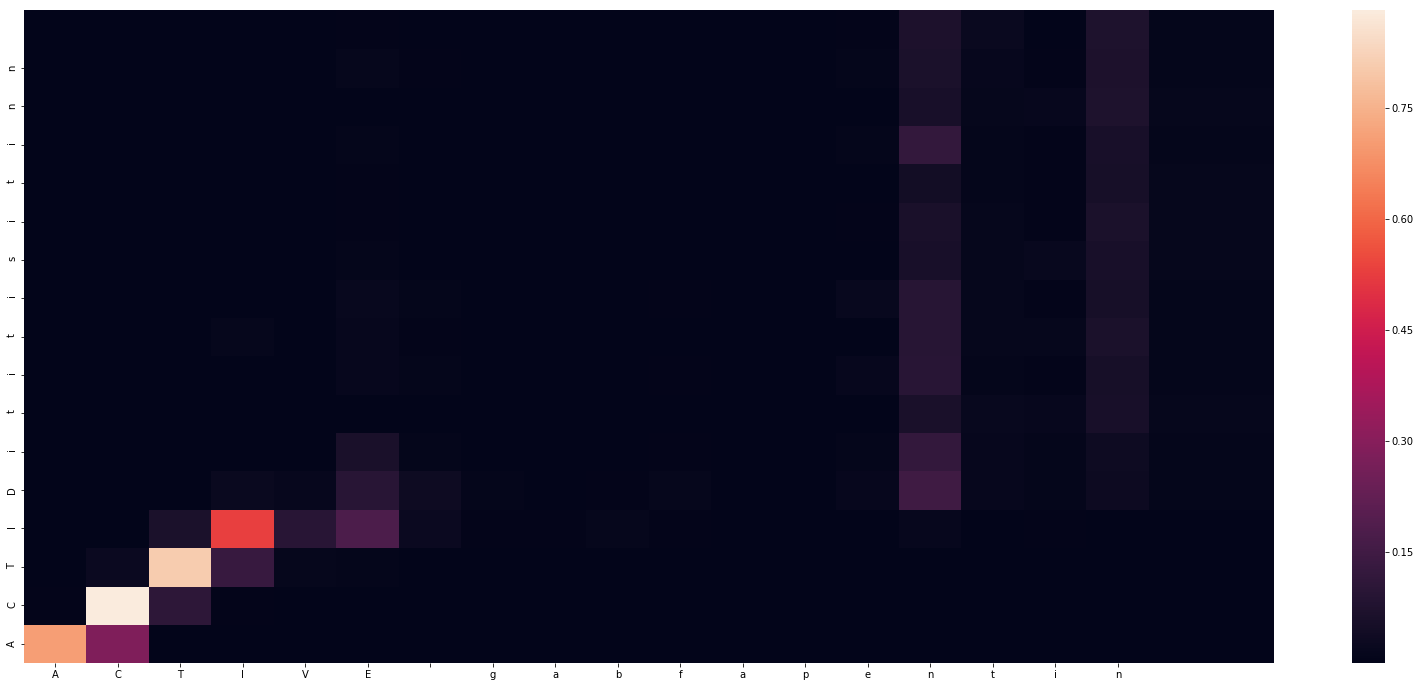

-
Input sentence: ACTIVE gabfapentin
GT sentence: ACTIVE: gabapentin

Decoded sentence: ACTIDititisitinn


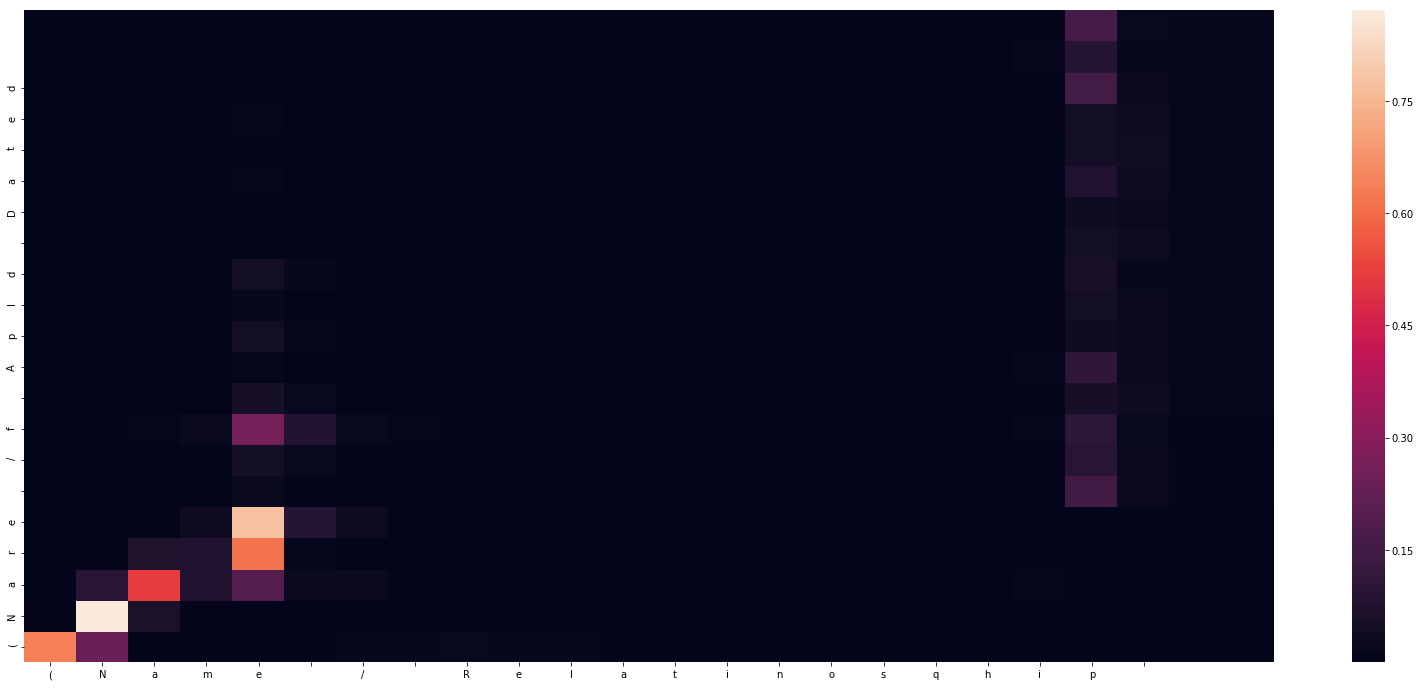

-
Input sentence: (Name / Relatinosqhip

GT sentence: (Name / Relationship)

Decoded sentence: (Nare /f Apld Dated


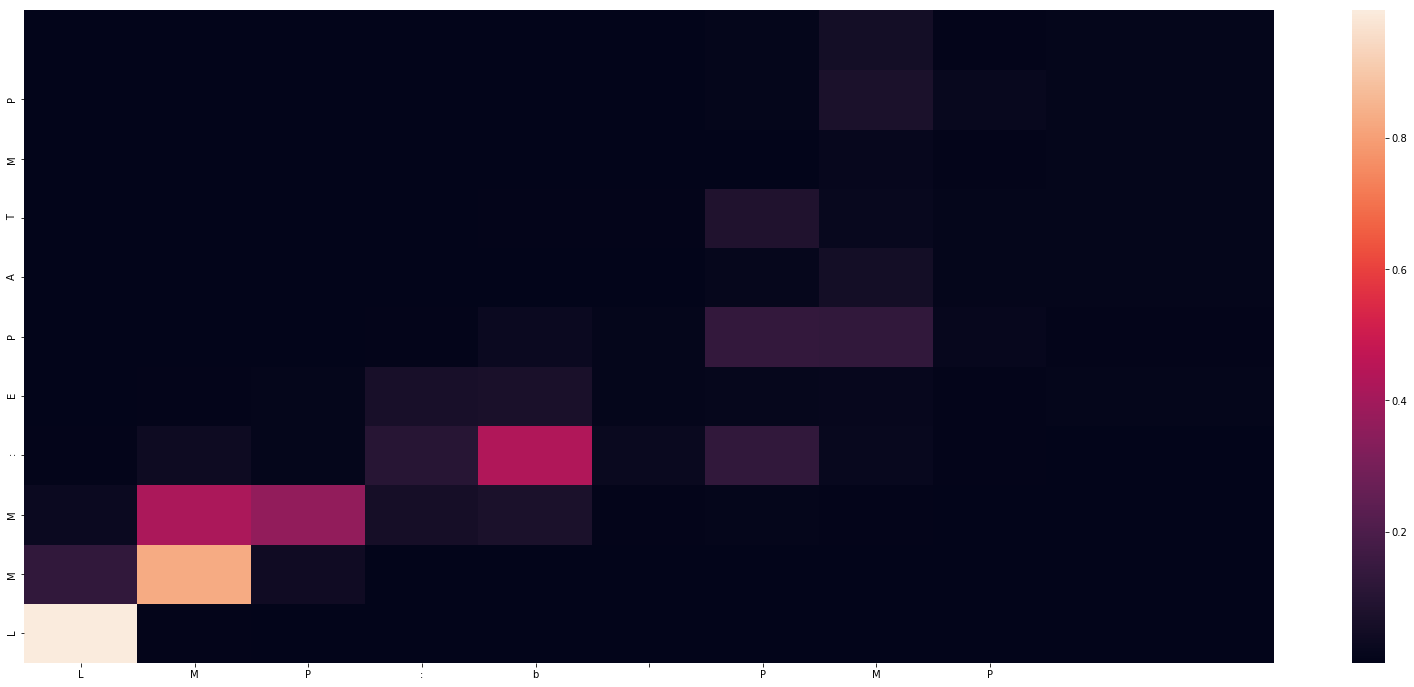

-
Input sentence: LMP:b PMP
GT sentence: LMP: PMP

Decoded sentence: LMM:EPATMP


In [74]:

for seq_index in range(100):
    target_text = test_target_texts[seq_index][1:-1]
    text = test_input_texts[seq_index]

    decoded_sentence = visualize_attention(text, encoder_model, decoder_model, max_encoder_seq_length, num_decoder_tokens, vocab_to_int, int_to_vocab)
    print('-')
    print('Input sentence:', text)
    print('GT sentence:', target_text)
    print('Decoded sentence:', decoded_sentence)  


In [75]:
WER_spell_correction = calculate_WER(target_texts_, decoded_sentences)
print('WER_spell_correction |TEST= ', WER_spell_correction)

WER_spell_correction |TEST=  0.16239224137931035


In [76]:
WER_OCR = calculate_WER(target_texts_, test_input_texts)
print('WER_OCR |TEST= ', WER_OCR)

WER_OCR |TEST=  0.08898168103448276


# Test on separate tesseract corrected file

In [77]:
num_samples = 10000
tess_correction_data = os.path.join(data_path, 'field_class_32.txt')#'new_trained_data.txt')
input_texts_OCR, target_texts_OCR, gt_OCR = load_data_with_gt(tess_correction_data, num_samples, max_sent_len, min_sent_len)

input_texts = input_texts_OCR
target_texts = target_texts_OCR

encoder_input_data, decoder_input_data, decoder_target_data = vectorize_data(input_texts=input_texts,
                                                                             target_texts=target_texts, 
                                                                             max_encoder_seq_length=max_encoder_seq_length, 
                                                                             num_encoder_tokens=num_encoder_tokens, 
                                                                             vocab_to_int=vocab_to_int)

# Sample output from train data
decoded_sentences = []
target_texts_ =  []
for seq_index in range(len(input_texts)):
    # Take one sequence (part of the training set)
    # for trying out decoding.

    input_seq = encoder_input_data[seq_index: seq_index + 1]
    
    decoded_sentence, _ = decode_sequence(input_seq, encoder_model, decoder_model, num_decoder_tokens, int_to_vocab)
    target_text = target_texts[seq_index][1:-1]
    print('-')
    print('Input sentence:', input_texts[seq_index])
    print('GT sentence:', target_text)
    print('Decoded sentence:', decoded_sentence)   
    decoded_sentences.append(decoded_sentence)
    target_texts_.append(target_text)
    
WER_spell_correction = calculate_WER(target_texts_, decoded_sentences)
print('WER_spell_correction |TEST= ', WER_spell_correction)

WER_OCR = calculate_WER(target_texts_, input_texts)
print('WER_OCR |TEST= ', WER_OCR)

-
Input sentence: claim folder contents
GT sentence: Claim Folder Contents

Decoded sentence: claim Cont Conthenter
-
Input sentence: claimant name
GT sentence: Claimant Name:

Decoded sentence: claim Fation
-
Input sentence: claim number
GT sentence: Claim Number:

Decoded sentence: claim Nommen
-
Input sentence: unauthorized access is strictly prohibited.
GT sentence: Unauthorized access is strictly prohibited.

Decoded sentence: Inauthon the bent the Rertint ye the thent.
-
Input sentence: print date 3/13/2018
GT sentence: Print Date: 3/13/2018

Decoded sentence: Pinnt Dat3/13/2018
-
Input sentence: accountability act (hipaa) privacy rule.
GT sentence: Accountability Act (HIPAA) Privacy Rule.

Decoded sentence: cccur Phy the berin(d to )on ant on the.
-
Input sentence: (not for fmla requests}
GT sentence: (Not For FMLA Requests)

Decoded sentence: (notartint on your ton}
-
Input sentence: otherwise permitted by law.
GT sentence: otherwise permitted by law.

Decoded sentence: other P

-
Input sentence: chim vent identifier
GT sentence: Claim Event Identifier:

Decoded sentence: chie Proved Sit te
-
Input sentence: submission date
GT sentence: Submission Date:

Decoded sentence: Submide Of Cont
-
Input sentence: electronically signed indicator yes
GT sentence: Electronically Signed Indicator: Yes

Decoded sentence: electrsdind redenttens ned Condenss
-
Input sentence: fraud statements reviewed and electronically
GT sentence: Fraud Statements Reviewed and Electronically

Decoded sentence: Ifunt ondder Fint Instry Pay to Date Int Day
-
Input sentence: signed date
GT sentence: Signed Date:

Decoded sentence: iinned Date
-
Input sentence: employer
GT sentence: Employer:

Decoded sentence: mproye
-
Input sentence: group policy #
GT sentence: Group Policy #:

Decoded sentence: Ioune Pory Rer
-
Input sentence: customer policy #
GT sentence: Customer Policy #:

Decoded sentence: costour Honplye
-
Input sentence: ee name
GT sentence: EE Name:

Decoded sentence: Menuene
-
Inpu

-
Input sentence: follow-up instructions
GT sentence: Follow-Up Instructions

Decoded sentence: Iollow- Nust Date Yns
-
Input sentence: has been given these follow-up instructions
GT sentence: has been given these follow-up instructions:

Decoded sentence: has on Con ser at ur tost C-nte If Contine
-
Input sentence: follow up with where when
GT sentence: Follow Up With: Where: When:

Decoded sentence: Iflloworenth Ant Infor
-
Input sentence: follow up with primary care provider within | to 2 days, only if needed
GT sentence: Follow up with primary care provider Within 1 to 2 days, only if needed

Decoded sentence: Ifll your child tour thed of thed the dent dild thed on ddent dild of
-
Input sentence: comments
GT sentence: Comments:

Decoded sentence: Nome Cort
-
Input sentence: dear patient
GT sentence: Dear Patient:

Decoded sentence: deary Name
-
Input sentence: however
GT sentence: HOWEVER

Decoded sentence: howvver
-
Input sentence: physicain does have the right to be paid for the 

-
Input sentence: + avoid lifting and other strenuous activities.
GT sentence: * Avoid lifting and other strenuous activities.

Decoded sentence: * Pvonimes Insur tour thent onddent dind torte.
-
Input sentence: » avoid playing sports or any other activities that could result in another head injury.
GT sentence: * Avoid playing sports or any other activities that could result in another head injury.

Decoded sentence: * Pvove your thent onstined to nest on the the the for the the for the the for the thentury
-
Input sentence: follow-up care
GT sentence: Follow-up care

Decoded sentence: Follou-e bery
-
Input sentence: when to seek medical advice
GT sentence: When to seek medical advice

Decoded sentence: whent Numbent Conthent Duse
-
Input sentence: unless told otherwise, call the provider right away if
GT sentence: Unless told otherwise, call the provider right away if:

Decoded sentence: Inees Numbent of the ,for the for the for the for thed
-
Input sentence: » your child is of any a

-
Input sentence: 572-1. emreersse ne auto all for aadc 339
GT sentence: 572-1-1*************AUTO**ALL FOR AADC 339

Decoded sentence: 572-1.urest  Co Co NT CESCASY339
-
Input sentence: account number
GT sentence: RE: Account Number

Decoded sentence: accuntonthe
-
Input sentence: deductible, co-insurance or non-covered amounts.
GT sentence: deductible, co-insurance or non-covered amounts.

Decoded sentence: dedurovide,t r-vind rovident or-tis torntine yo.r
-
Input sentence: thirty days from the receipt of this letter.
GT sentence: thirty days from the receipt of this letter.

Decoded sentence: thirt of bertind youndder tond yoviditit te.
-
Input sentence: nch healthcare system
GT sentence: NCH Health System

Decoded sentence: Ind te Rene Pert Dame
-
Input sentence: patient accounting departmentq
GT sentence: Patient Accounting Department

Decoded sentence: pate Sund the tontint Inf tone
-
Input sentence: nch » 1311-8
GT sentence: NCH - 1311-8

Decoded sentence: NCH NT1311-8
-
Input se

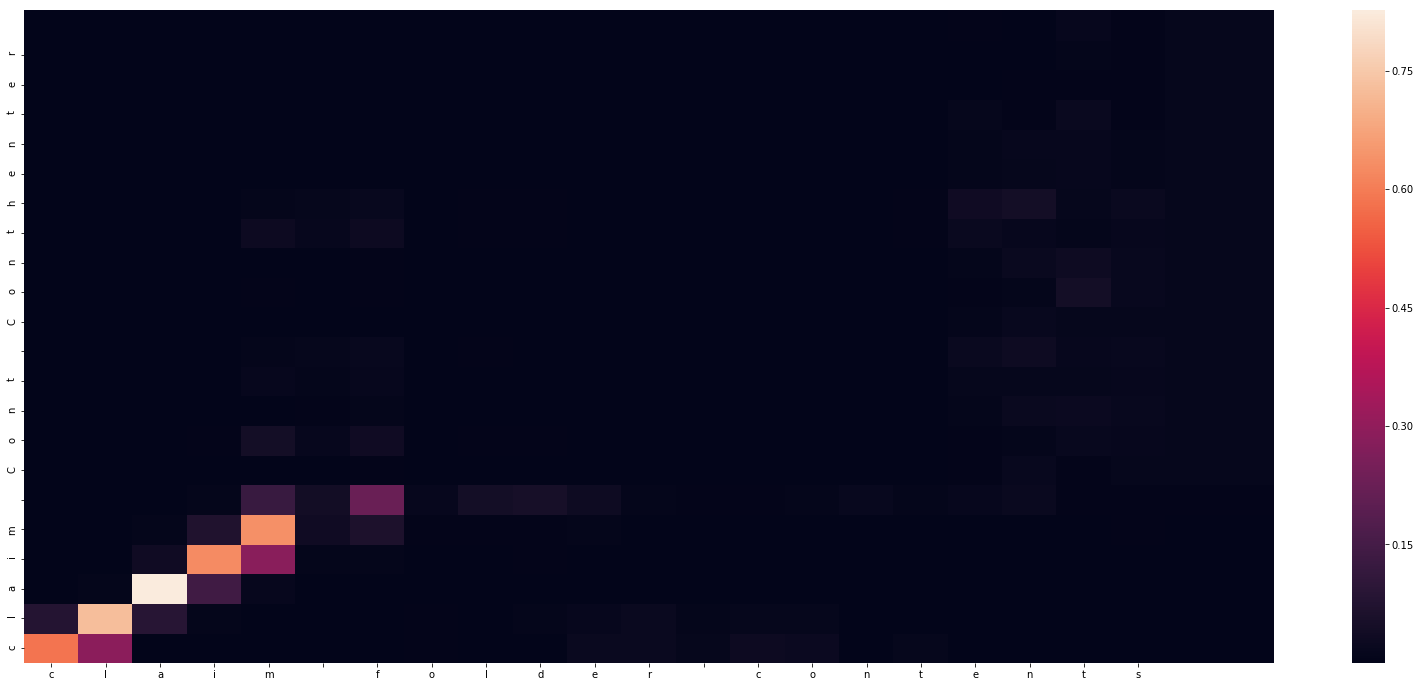

-
Input sentence: claim folder contents
GT sentence: Claim Folder Contents

Decoded sentence: claim Cont Conthenter


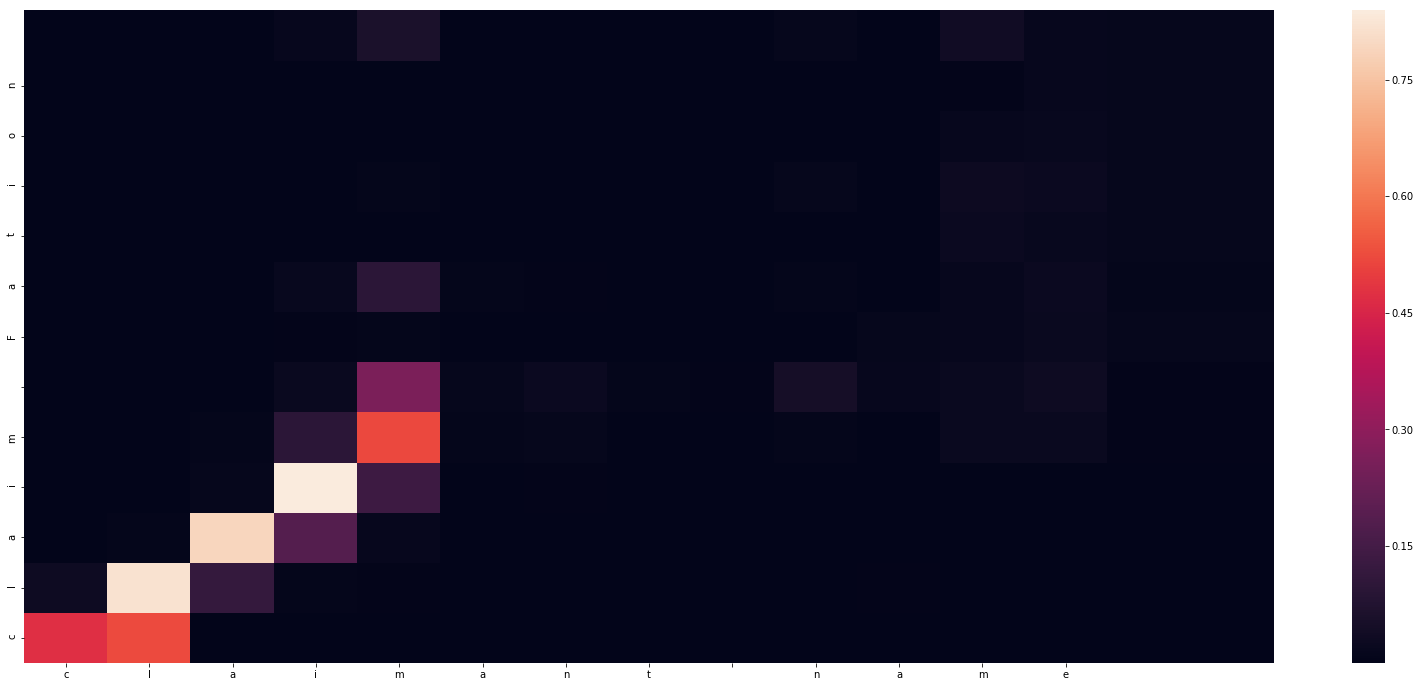

-
Input sentence: claimant name
GT sentence: Claimant Name:

Decoded sentence: claim Fation


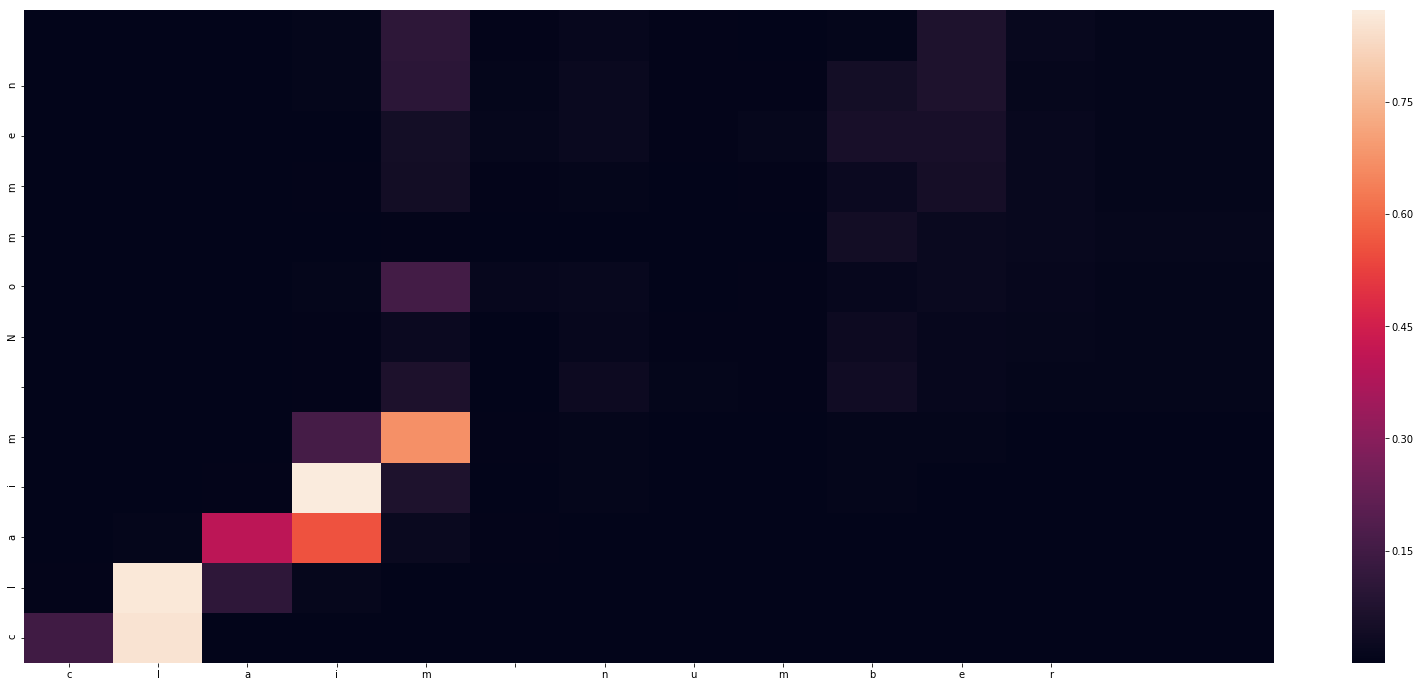

-
Input sentence: claim number
GT sentence: Claim Number:

Decoded sentence: claim Nommen


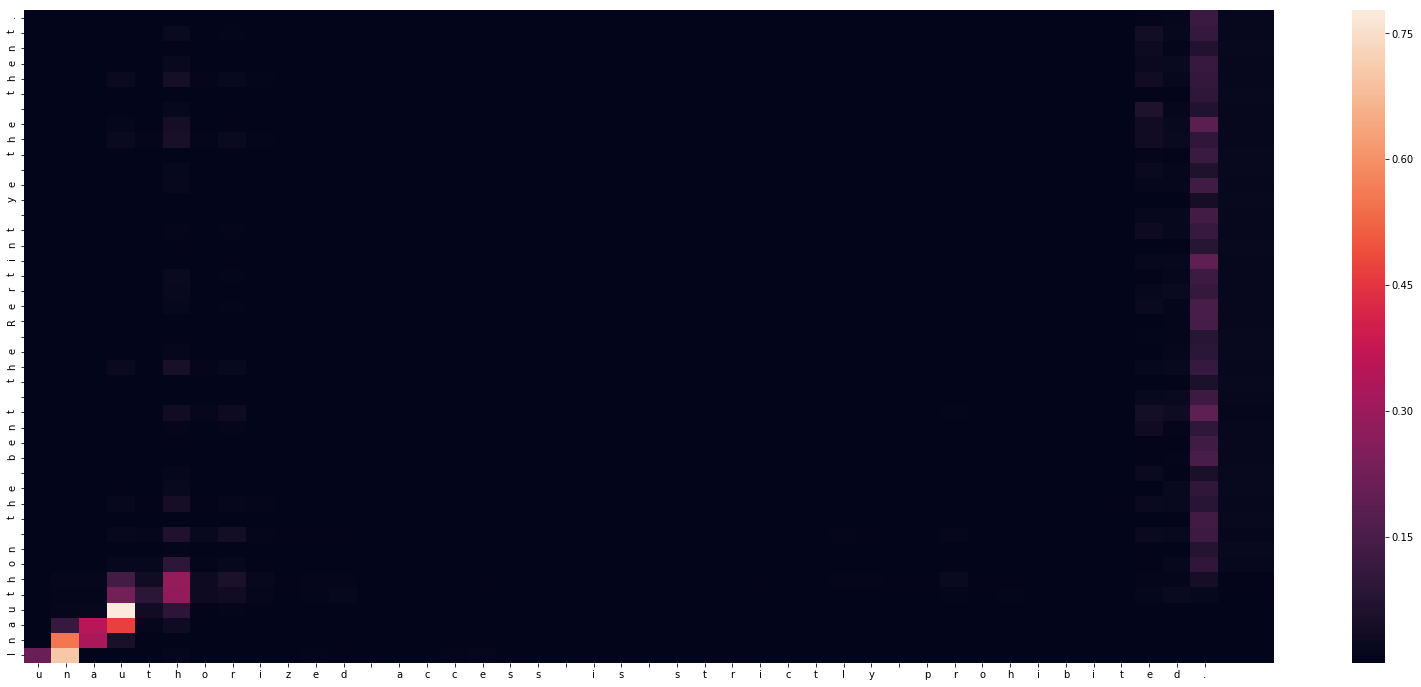

-
Input sentence: unauthorized access is strictly prohibited.
GT sentence: Unauthorized access is strictly prohibited.

Decoded sentence: Inauthon the bent the Rertint ye the thent.


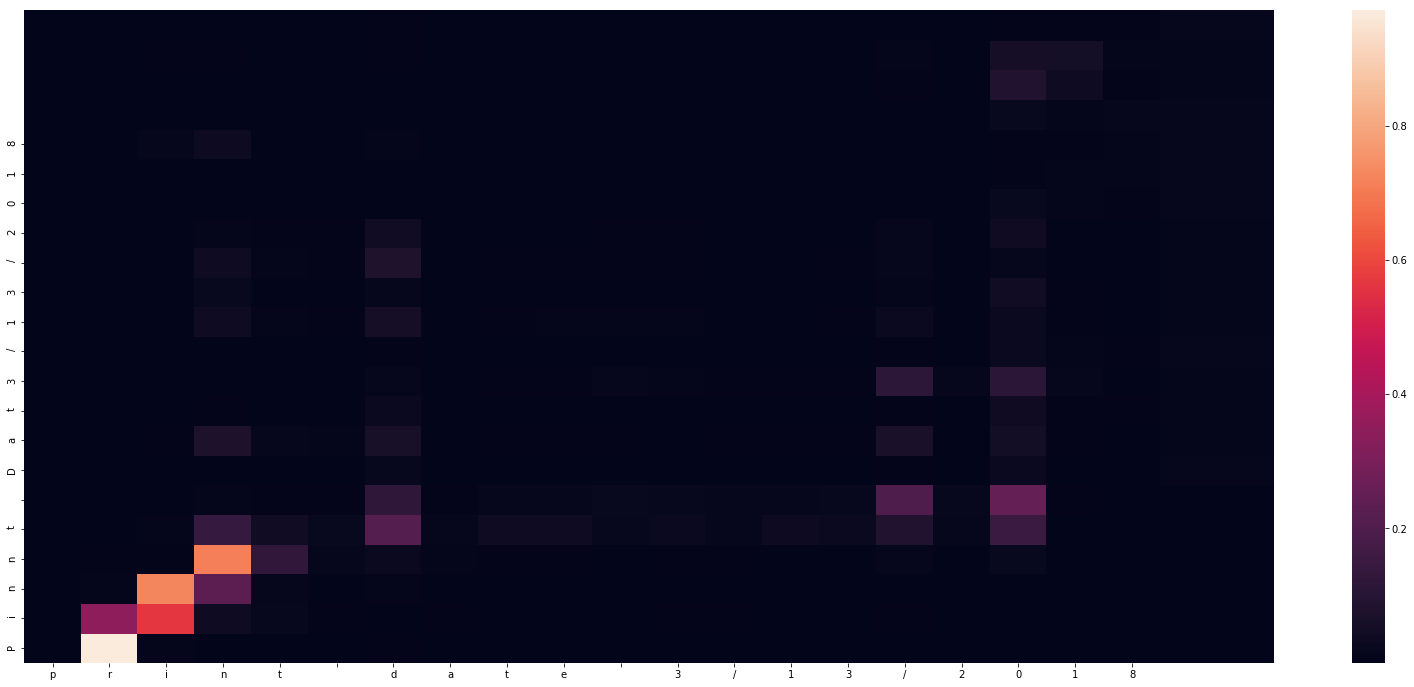

-
Input sentence: print date 3/13/2018
GT sentence: Print Date: 3/13/2018

Decoded sentence: Pinnt Dat3/13/2018


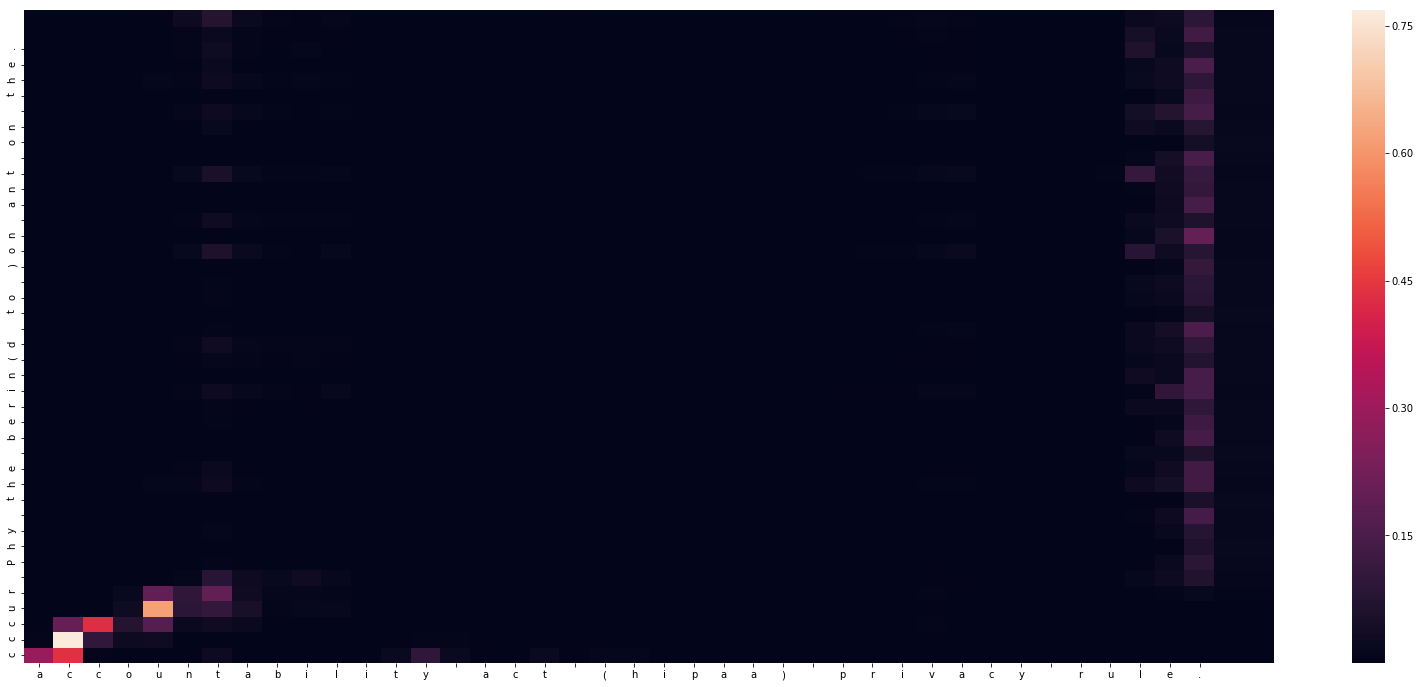

-
Input sentence: accountability act (hipaa) privacy rule.
GT sentence: Accountability Act (HIPAA) Privacy Rule.

Decoded sentence: cccur Phy the berin(d to )on ant on the.


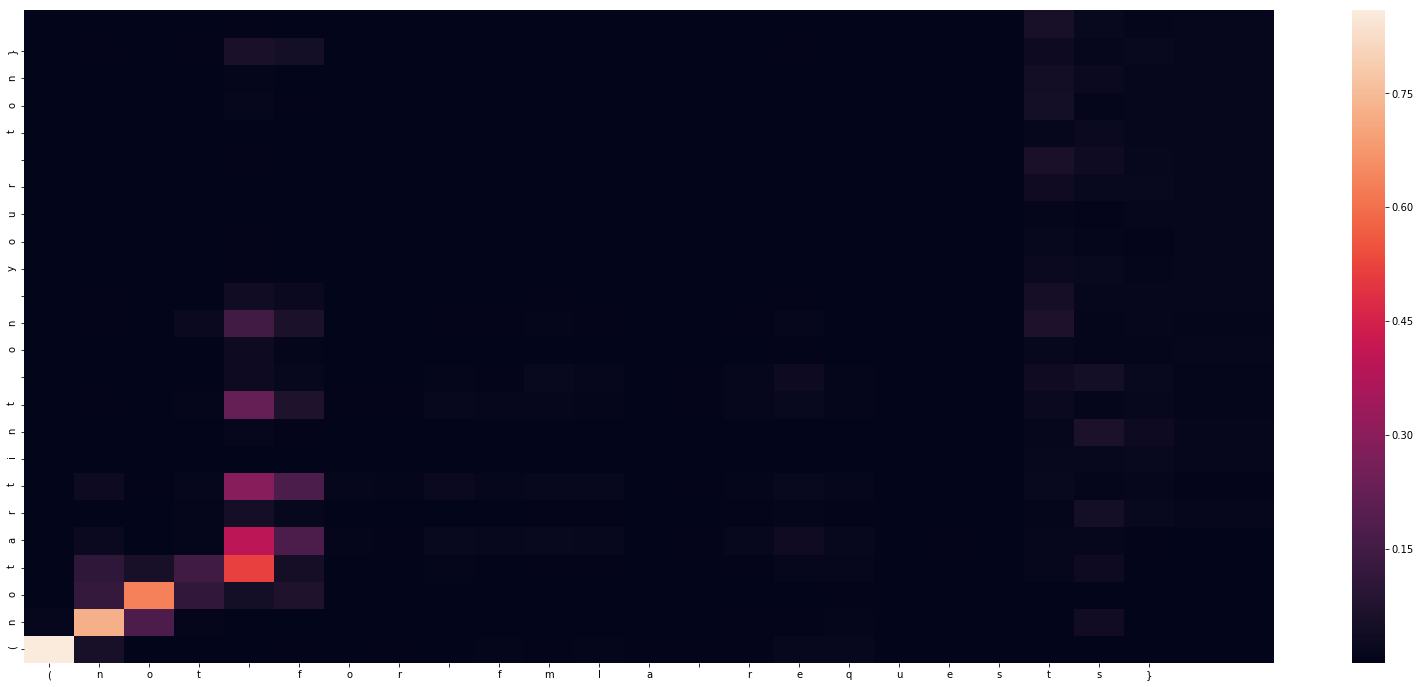

-
Input sentence: (not for fmla requests}
GT sentence: (Not For FMLA Requests)

Decoded sentence: (notartint on your ton}


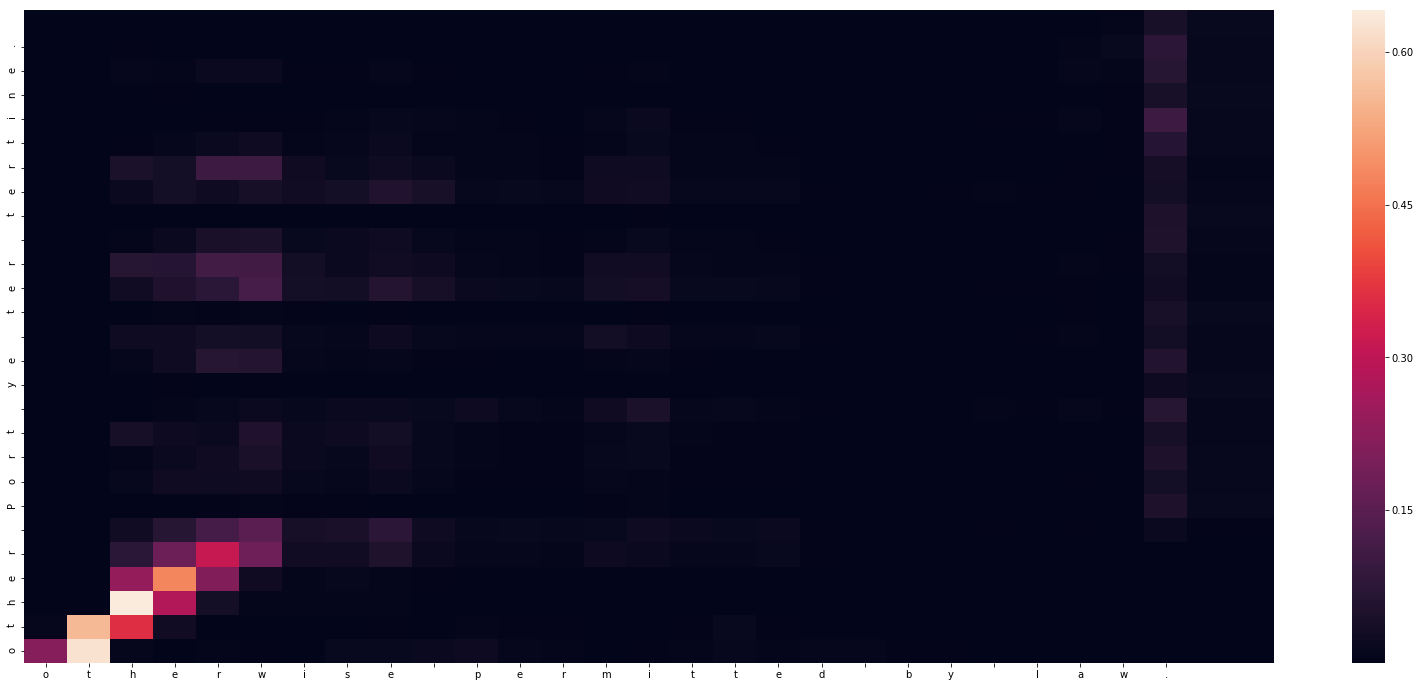

-
Input sentence: otherwise permitted by law.
GT sentence: otherwise permitted by law.

Decoded sentence: other Port ye ter tertine.


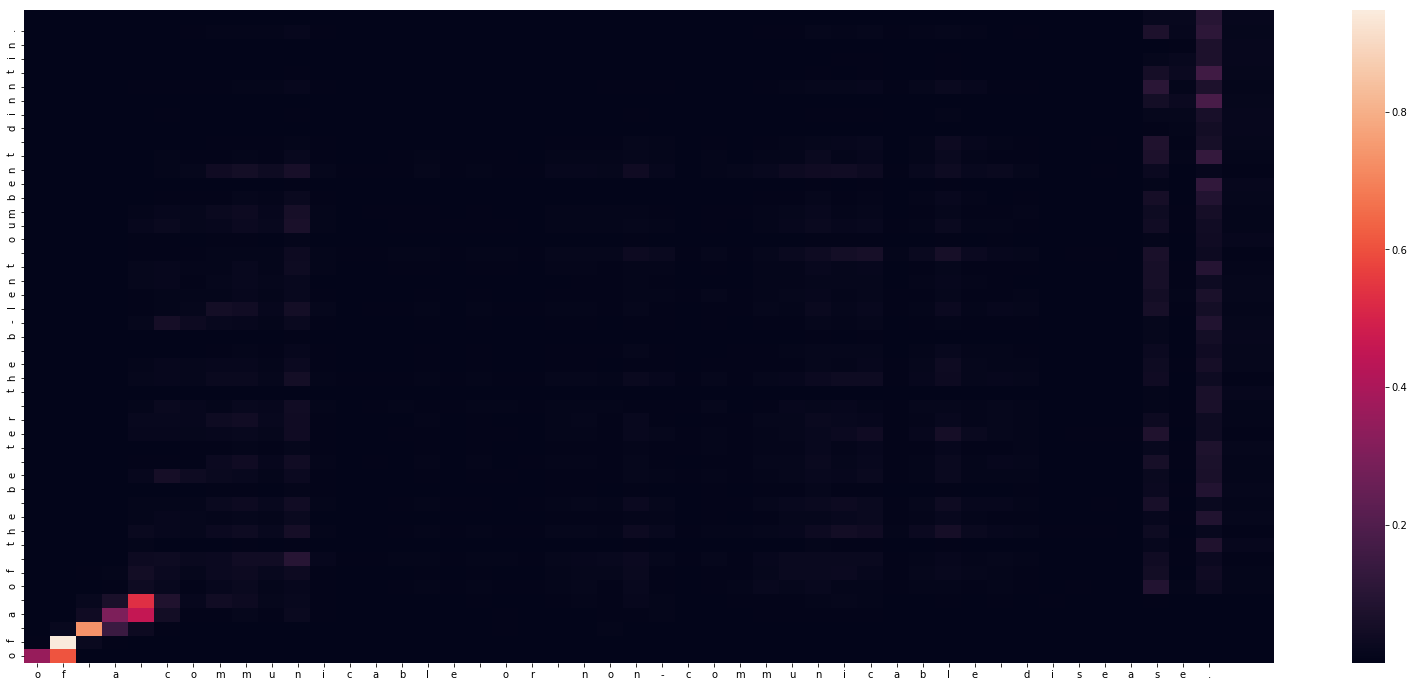

-
Input sentence: of a communicable or non-communicable disease.
GT sentence: of a communicable or non-communicable disease.

Decoded sentence: of a of the be ter the b-lent oumbent dinntin.


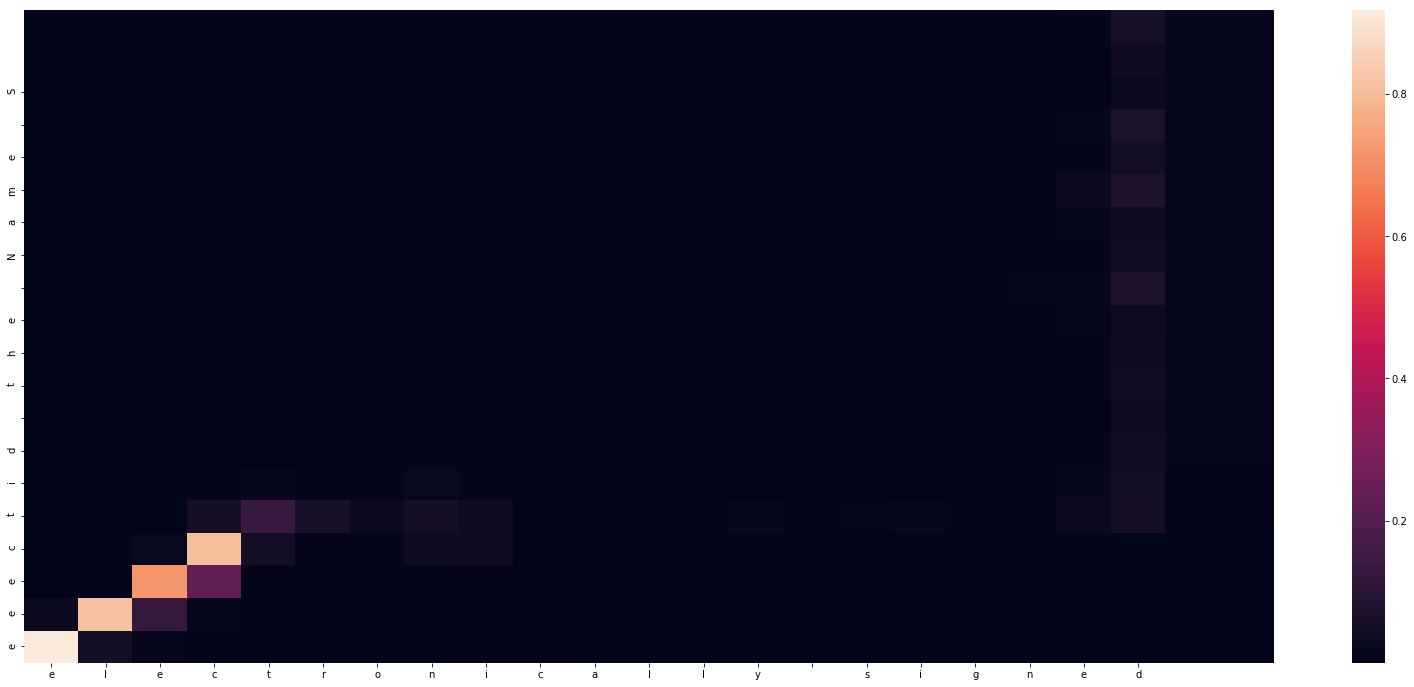

-
Input sentence: electronically signed
GT sentence: Electronically Signed

Decoded sentence: eeectid the Name S


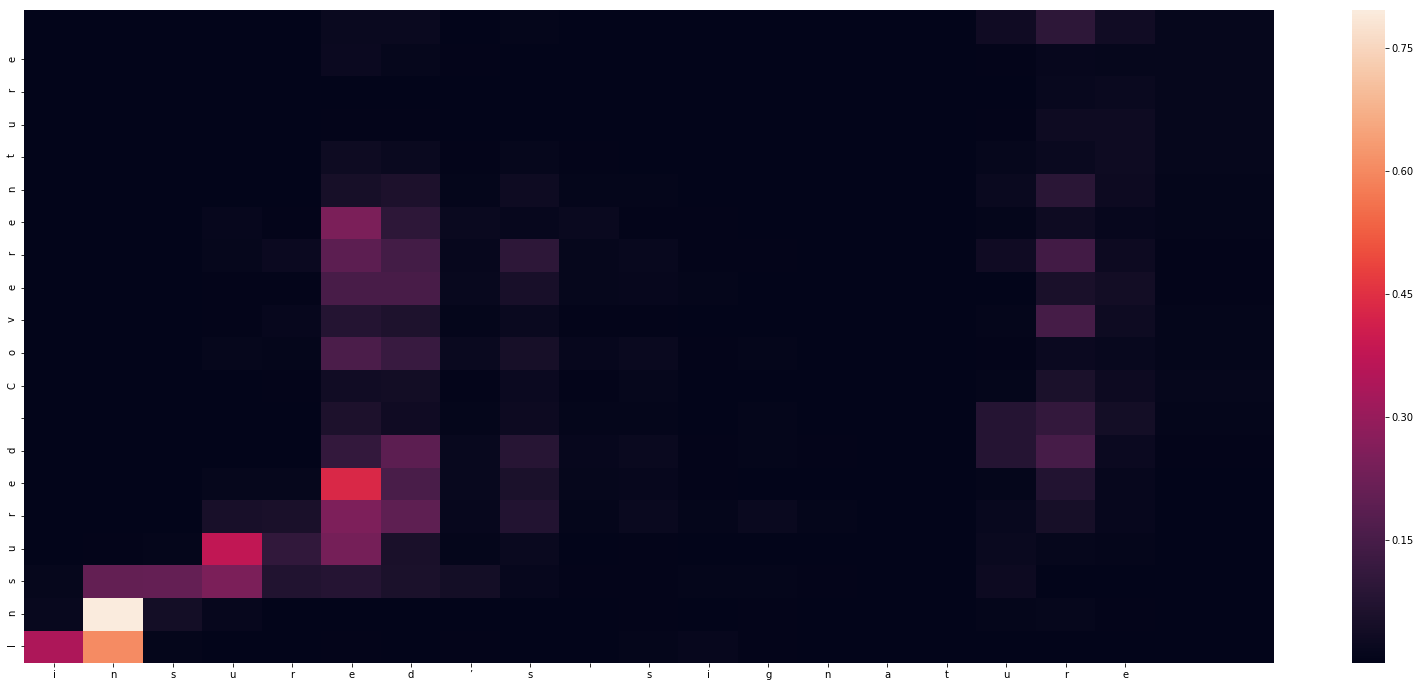

-
Input sentence: insured’s signature
GT sentence: Insured’s Signature

Decoded sentence: Insured Coverenture


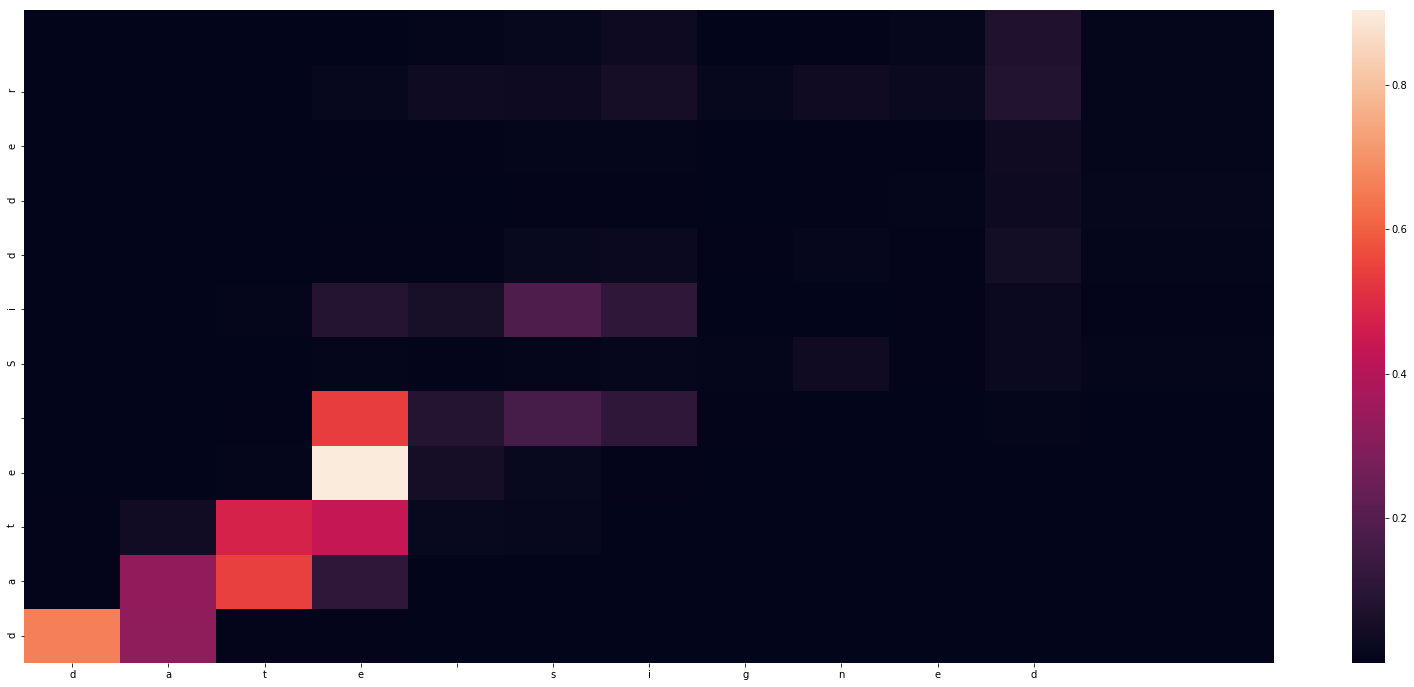

-
Input sentence: date signed
GT sentence: Date Signed

Decoded sentence: date Sidder


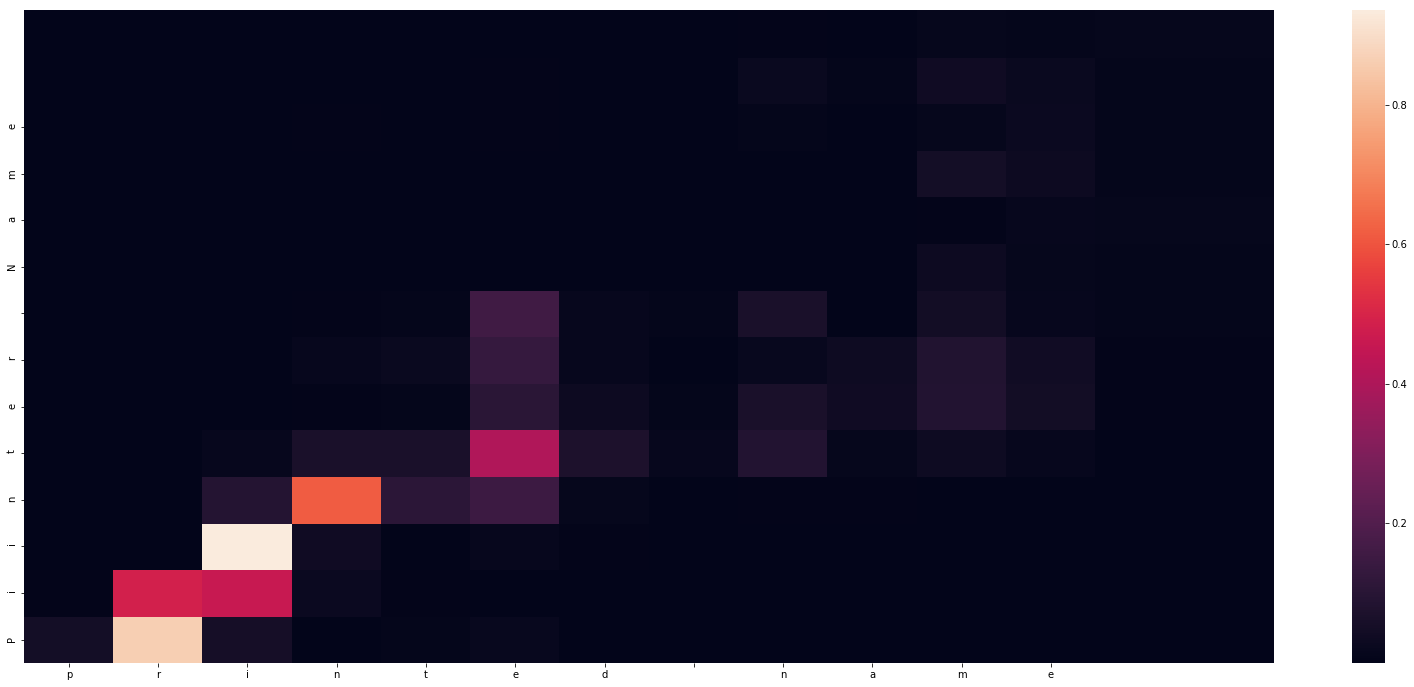

-
Input sentence: printed name
GT sentence: Printed Name

Decoded sentence: Piinter Name


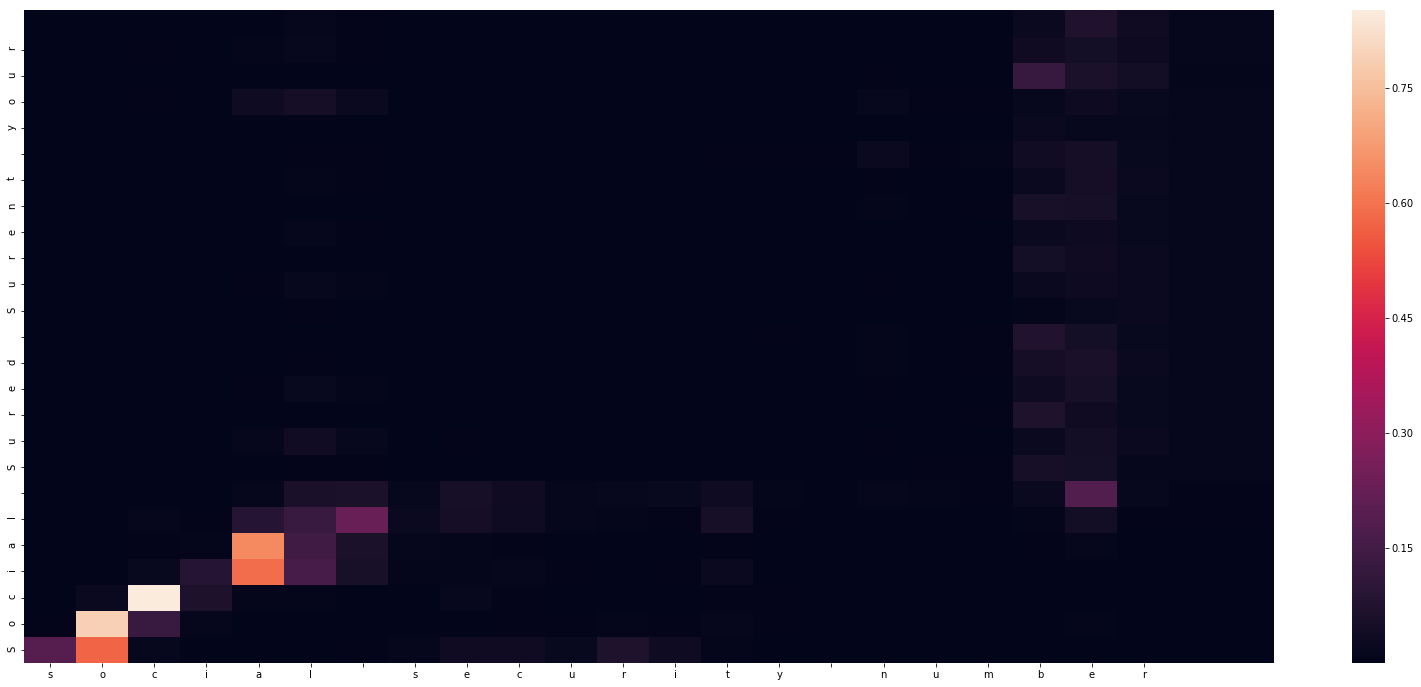

-
Input sentence: social security number
GT sentence: Social Security Number

Decoded sentence: Social Sured Surent your


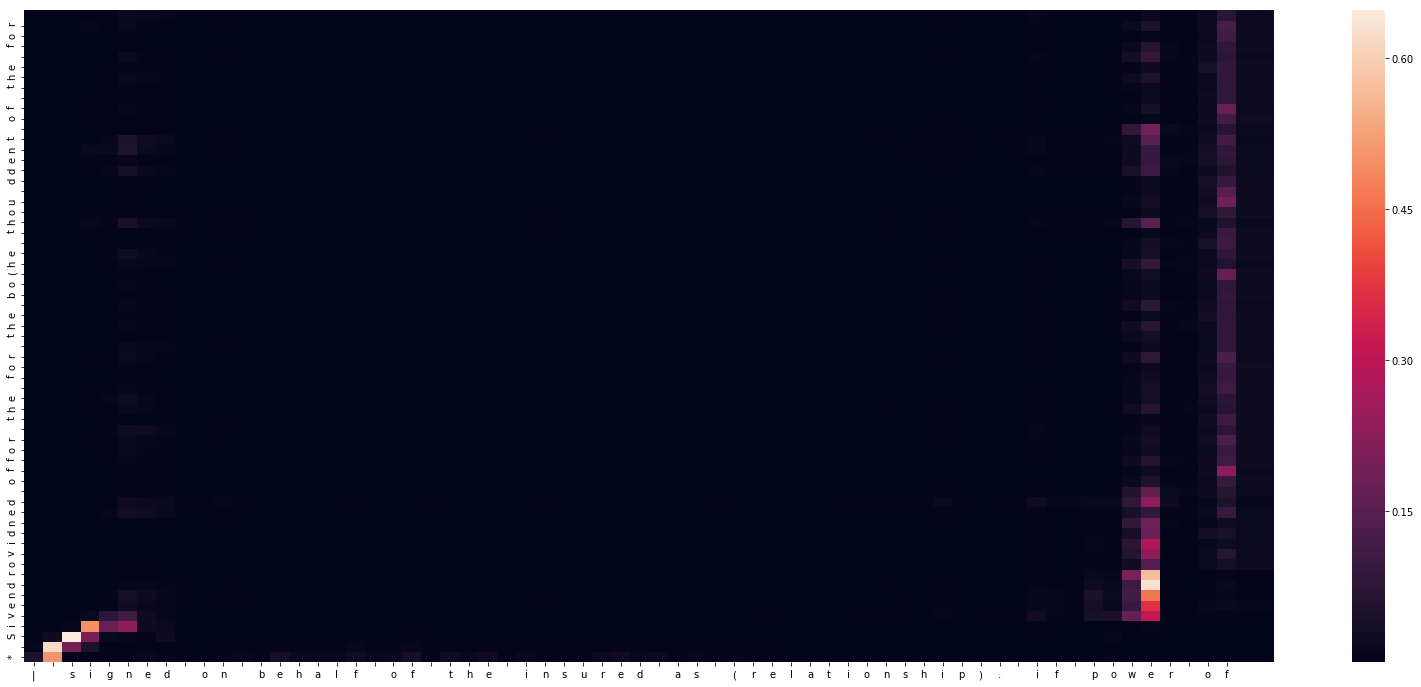

-
Input sentence: | signed on behalf of the insured as (relationship). if power of
GT sentence: I signed on behalf of the Insured as (Relationship). If Power of

Decoded sentence: * Sivendrovidned offor the for the bo(he thou ddent of the for


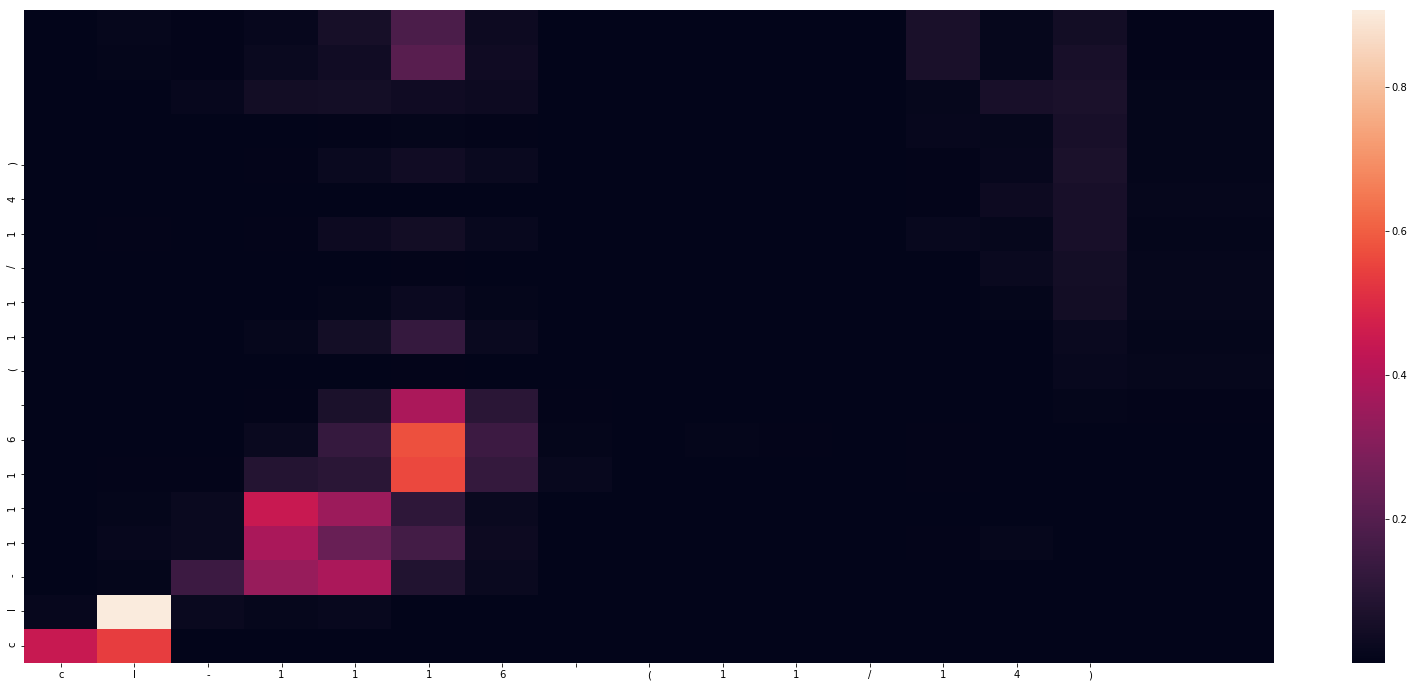

-
Input sentence: cl-1116 (11/14)
GT sentence: CL-1116 (11/14)

Decoded sentence: cl-1116 (11/14)


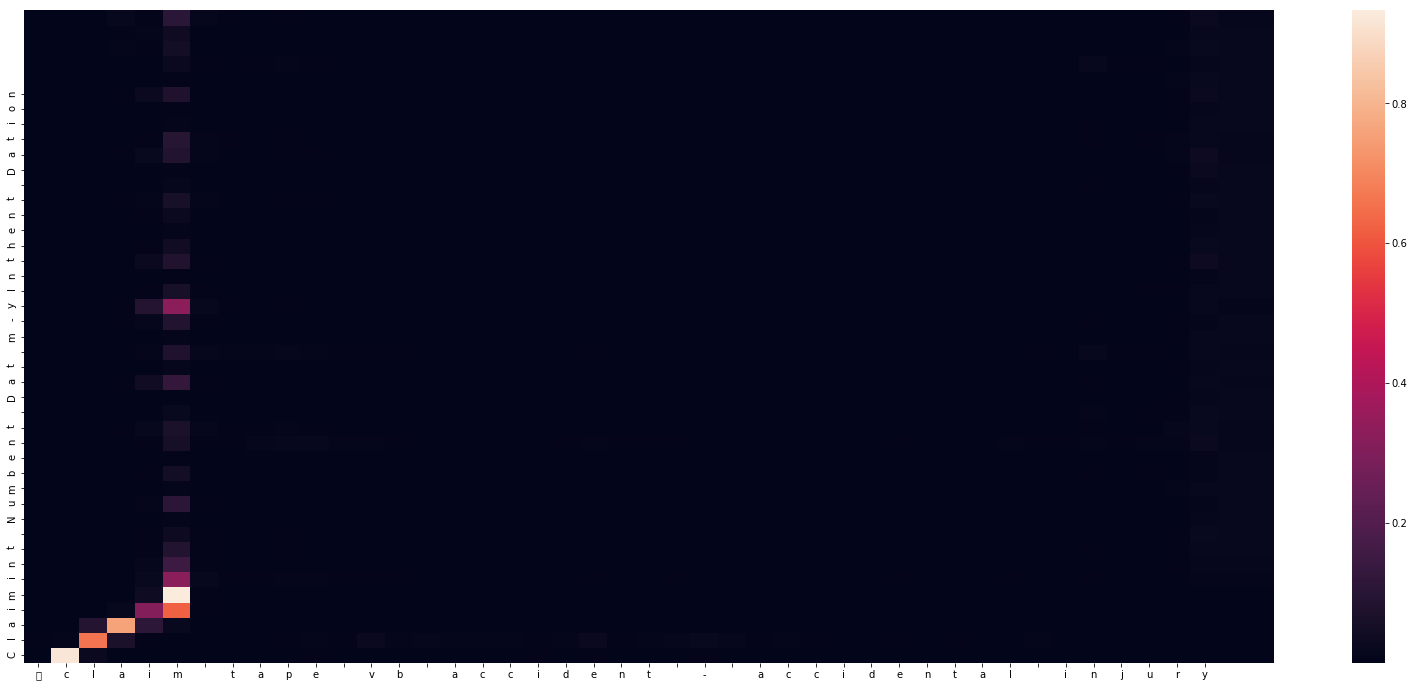

-
Input sentence: claim tape vb accident - accidental injury
GT sentence: Claim Type: VB Accident - Accidental Injury

Decoded sentence: Claimint Numbent Dat m-yInthent Dation


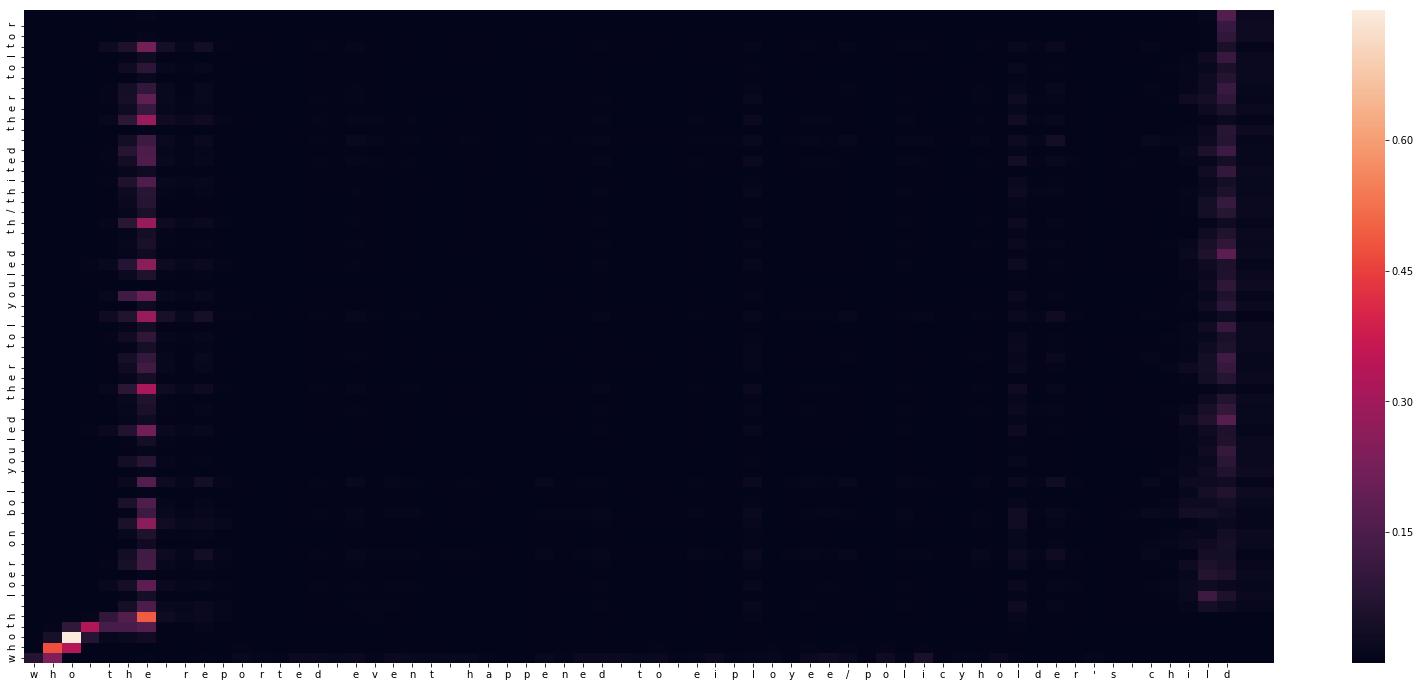

-
Input sentence: who the reported event happened to eiployee/policyholder's child
GT sentence: Who The Reported Event Happened To: Employee/Policyholder's child

Decoded sentence: whoth loer on bol youled ther tol youled th/thited ther toltor


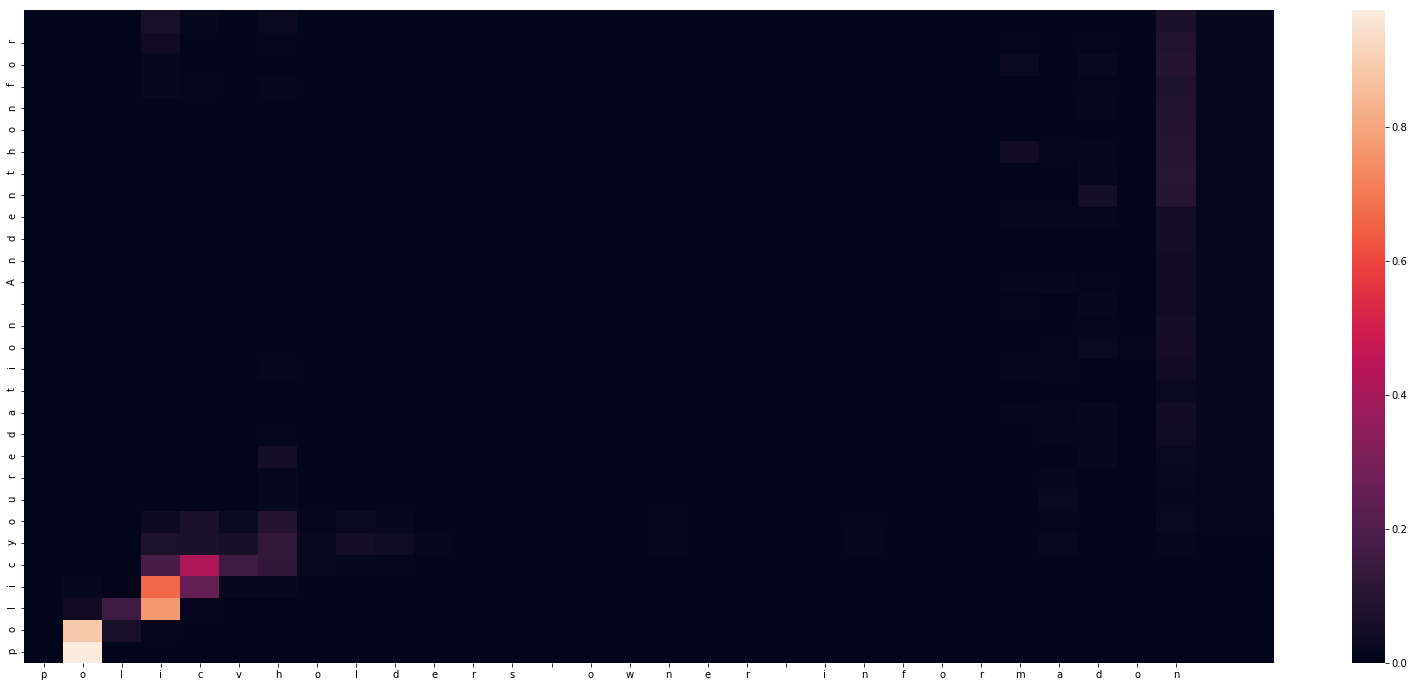

-
Input sentence: policvholders owner informadon
GT sentence: Policyholder/Owner Information

Decoded sentence: policyouredation Andenthonfor


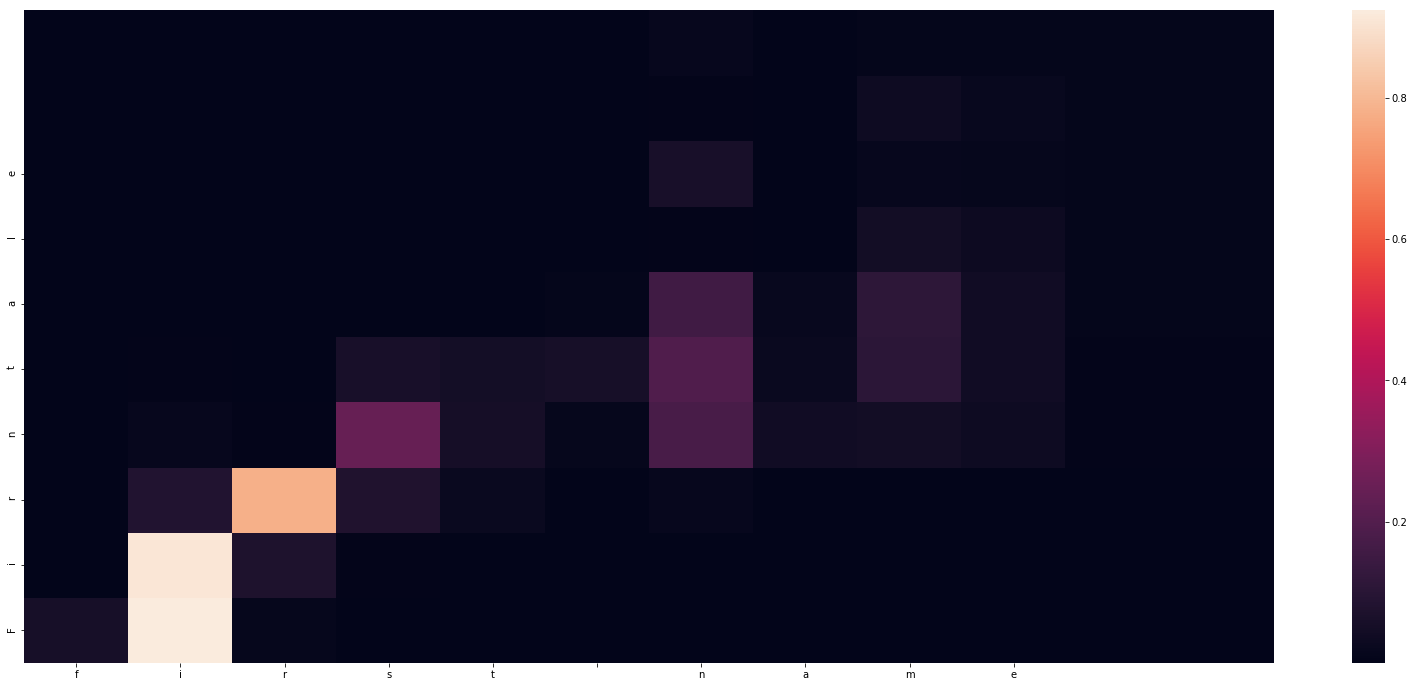

-
Input sentence: first name
GT sentence: First Name:

Decoded sentence: Firntale


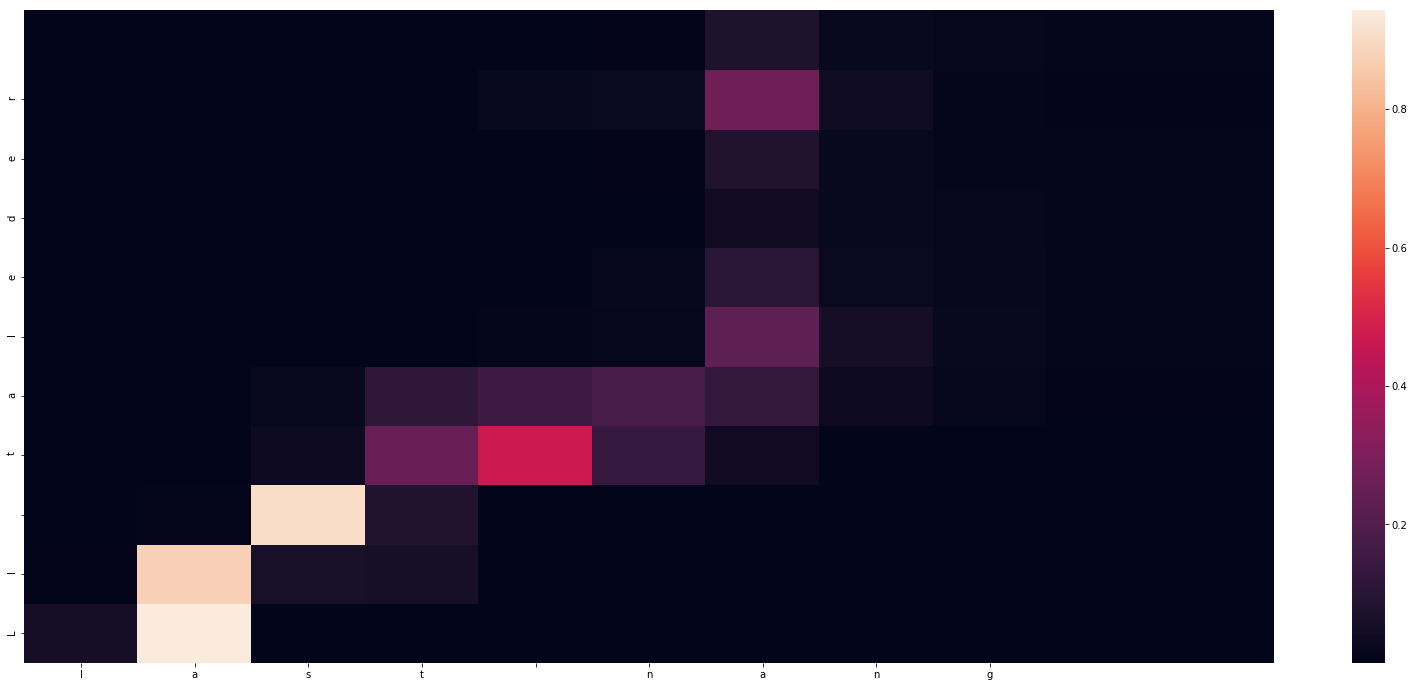

-
Input sentence: last nang
GT sentence: Last Name:

Decoded sentence: Ll taleder


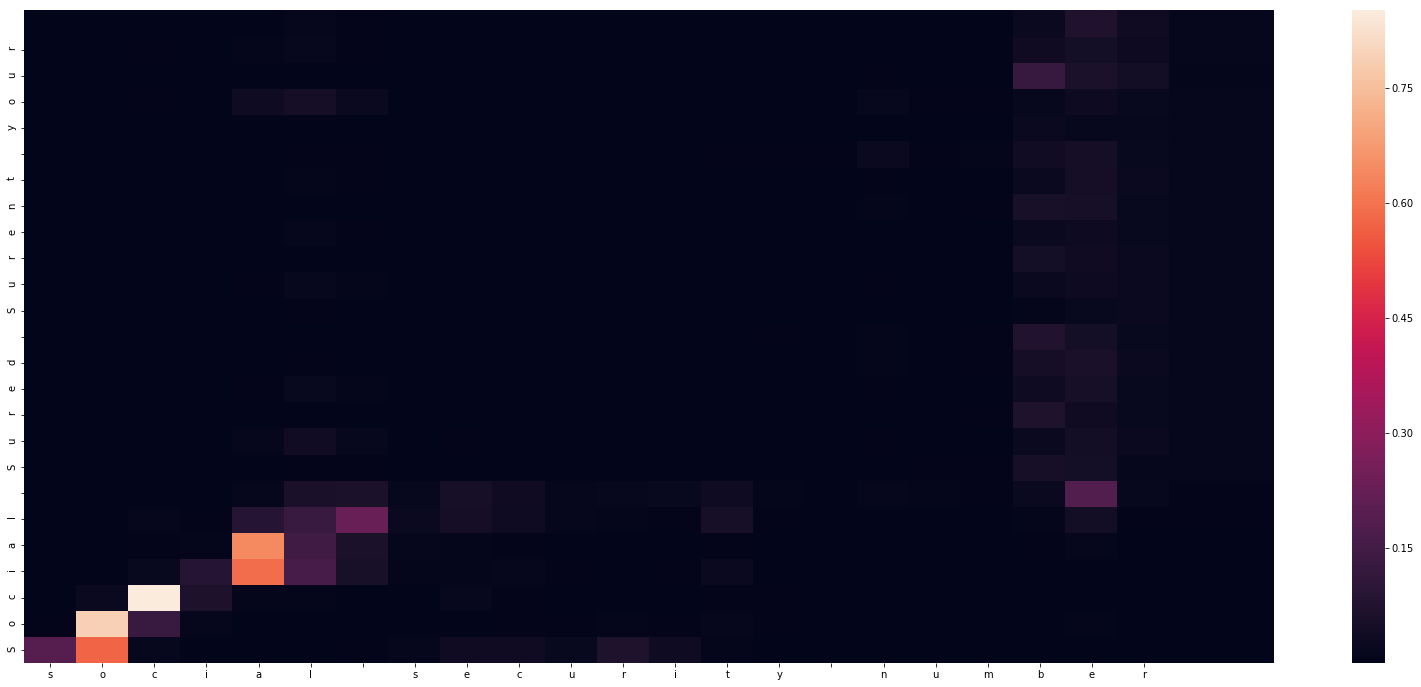

-
Input sentence: social security number
GT sentence: Social Security Number:

Decoded sentence: Social Sured Surent your


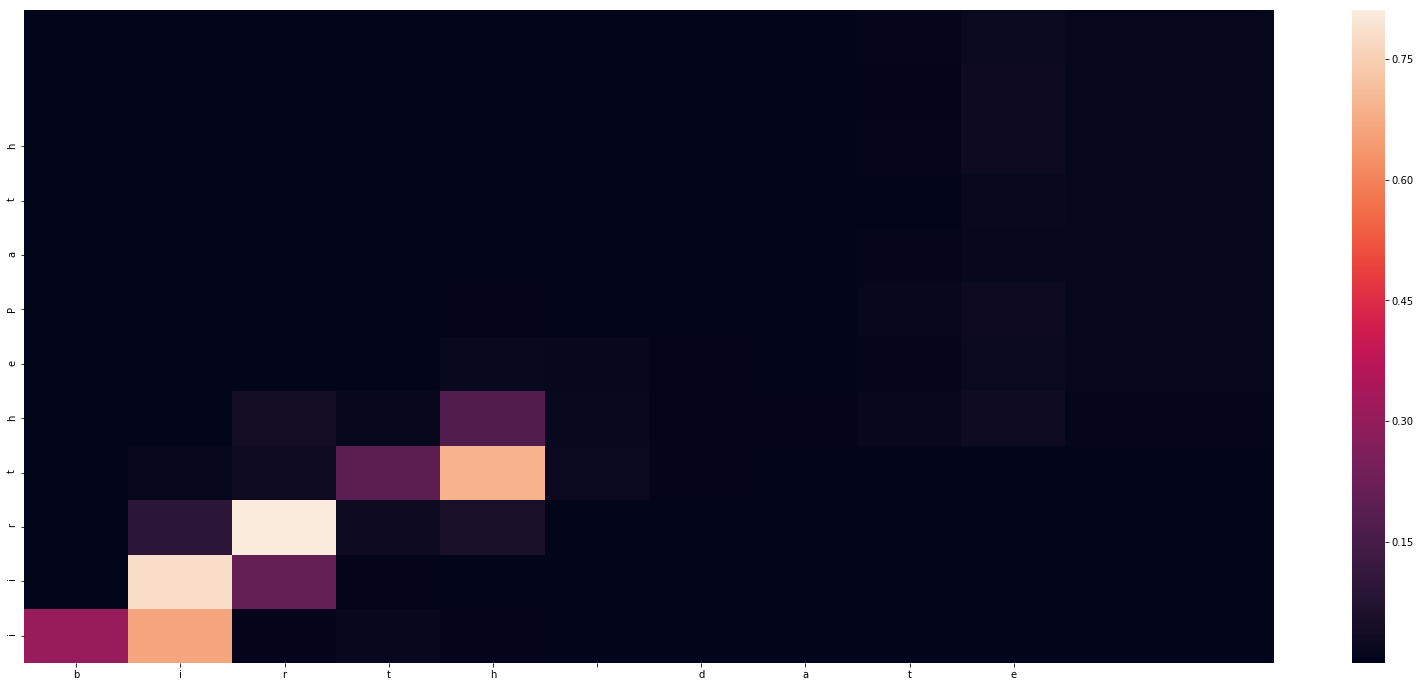

-
Input sentence: birth date
GT sentence: Birth Date:

Decoded sentence: iirthePath


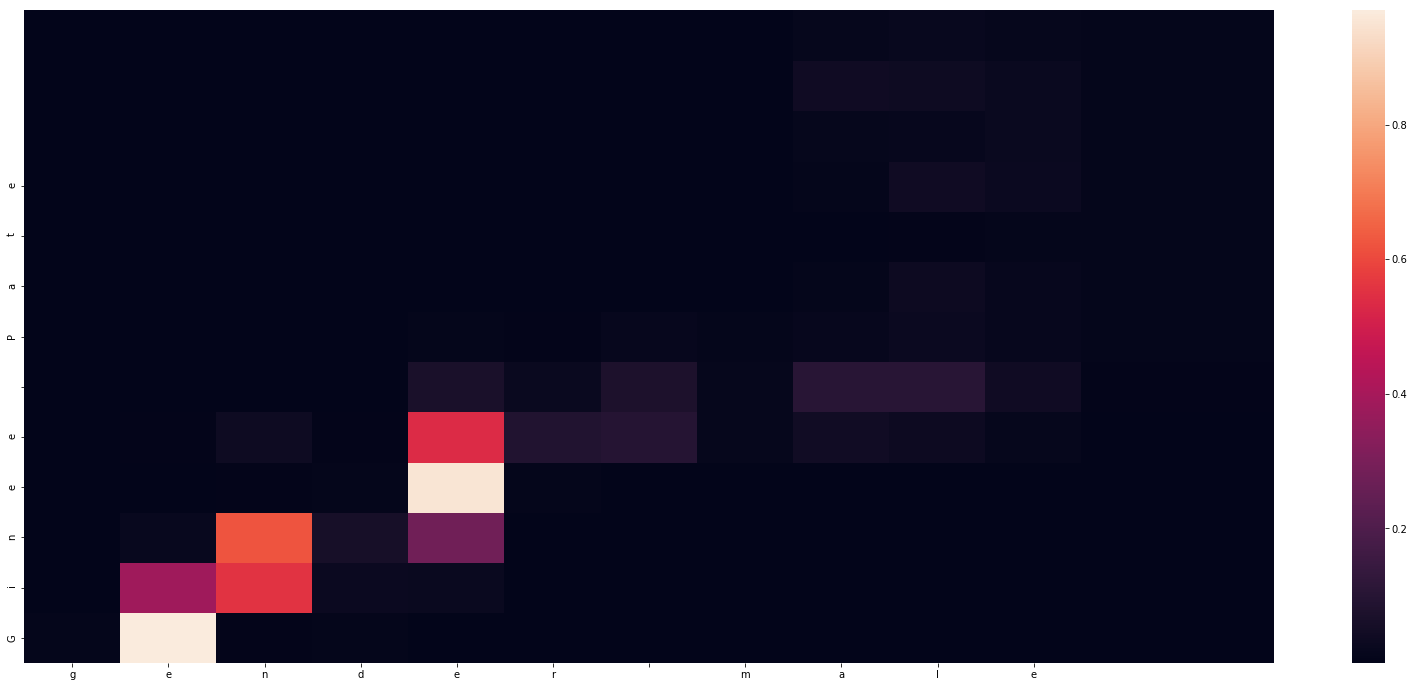

-
Input sentence: gender male
GT sentence: Gender: Male

Decoded sentence: Ginee Pate


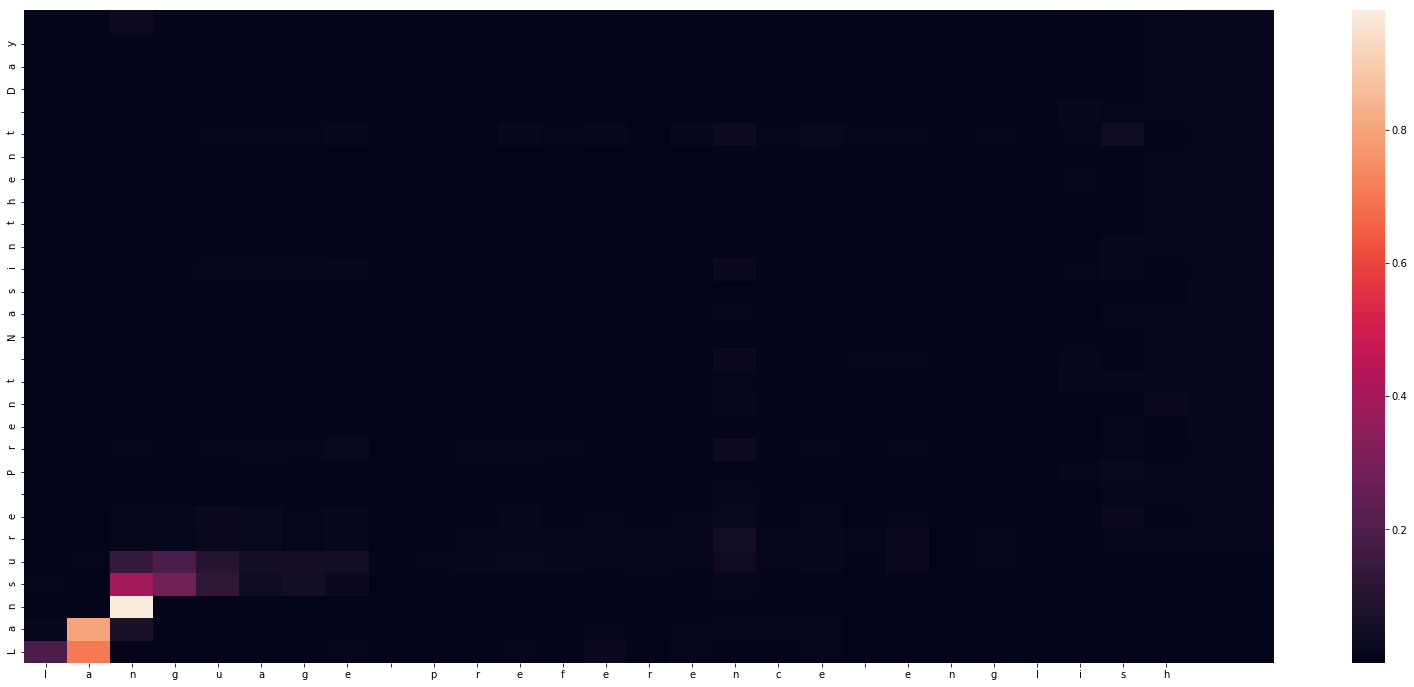

-
Input sentence: language preference english
GT sentence: Language Preference: English

Decoded sentence: Lansure Prent Nasinthent Day


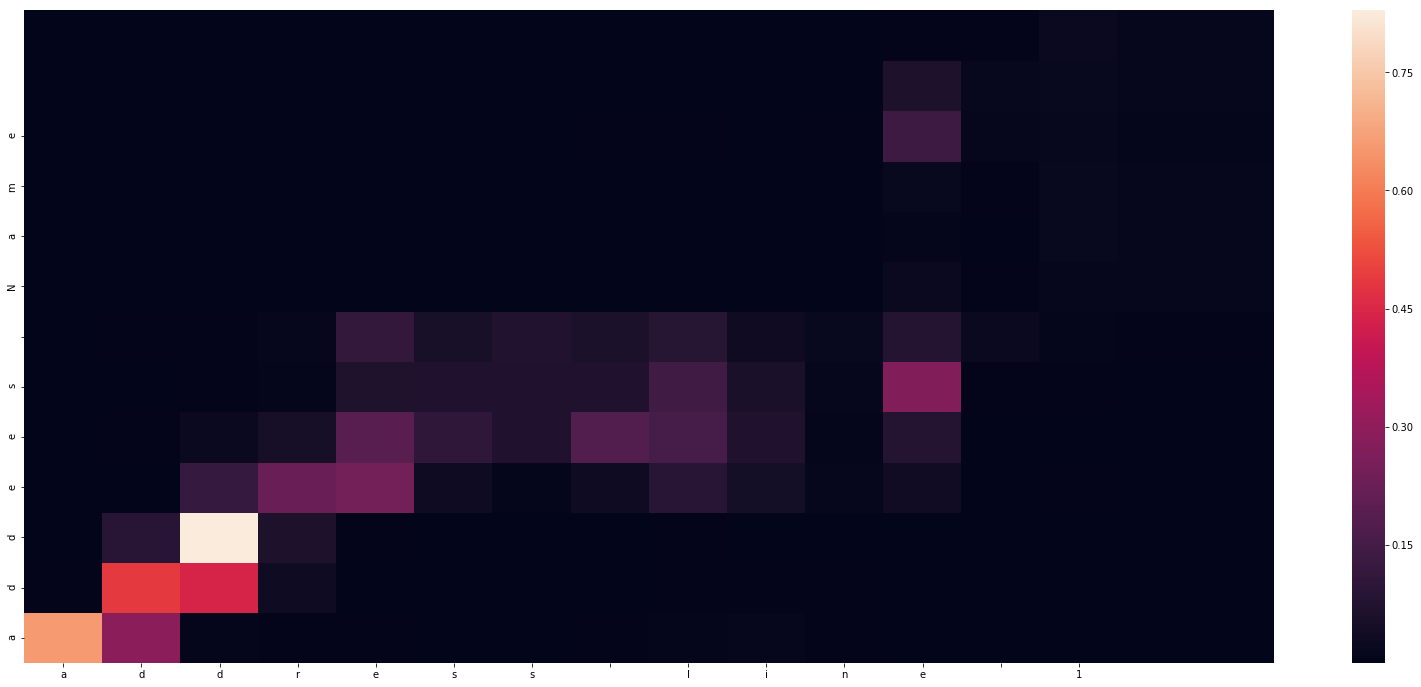

-
Input sentence: address line 1
GT sentence: Address Line 1:

Decoded sentence: addees Name


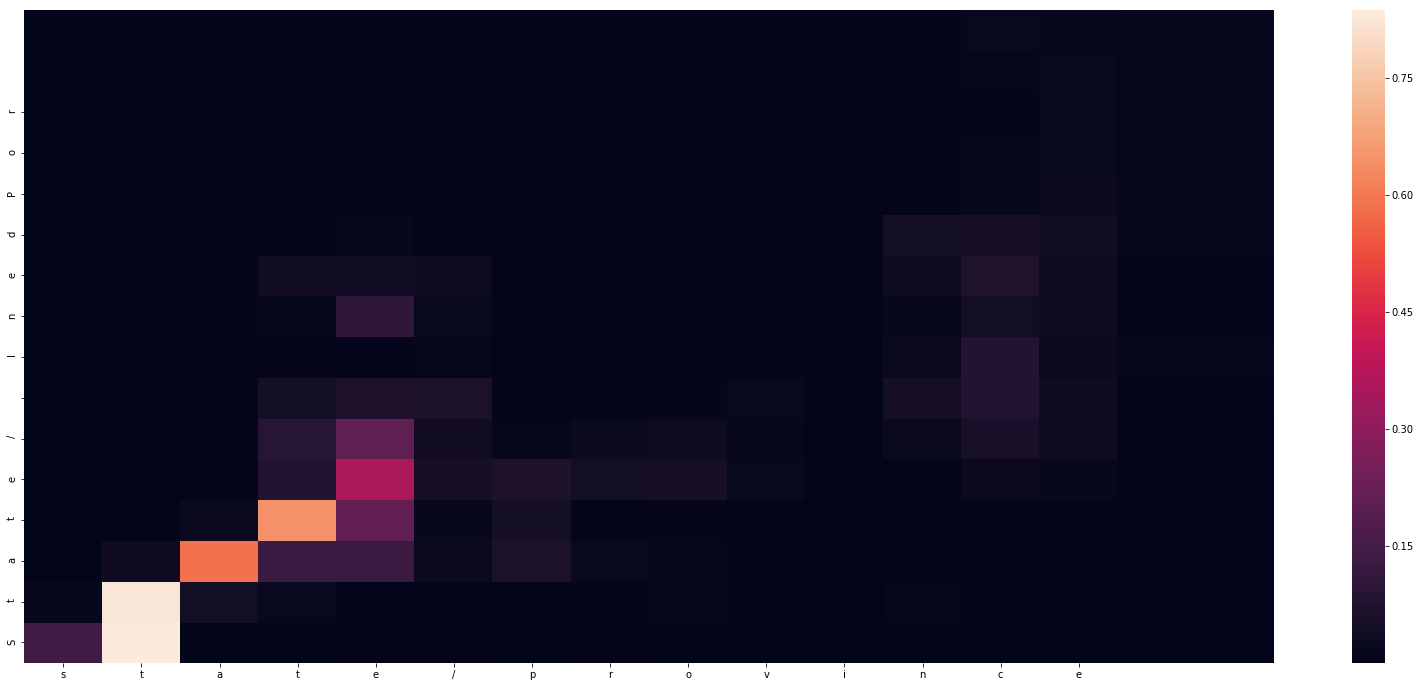

-
Input sentence: state/province
GT sentence: State/Province:

Decoded sentence: State/ InedPor


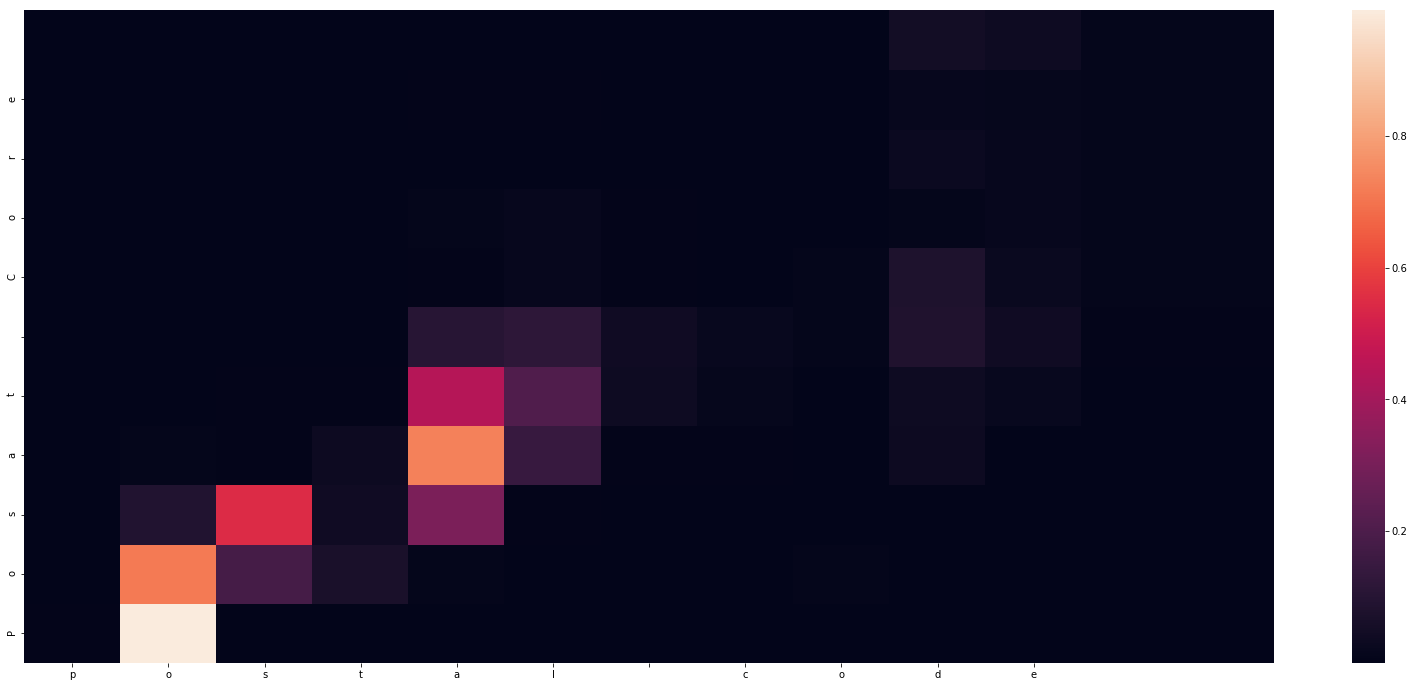

-
Input sentence: postal code
GT sentence: Postal Code:

Decoded sentence: Posat Core


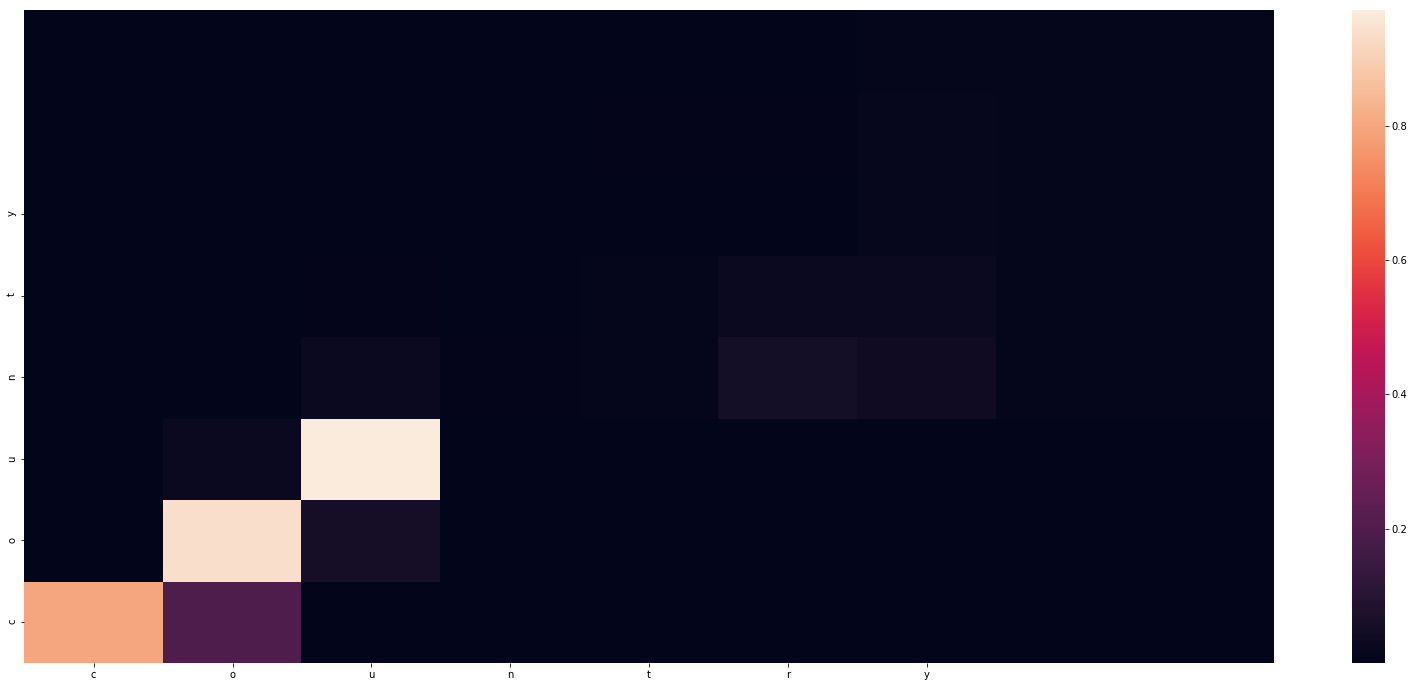

-
Input sentence: country
GT sentence: Country:

Decoded sentence: county


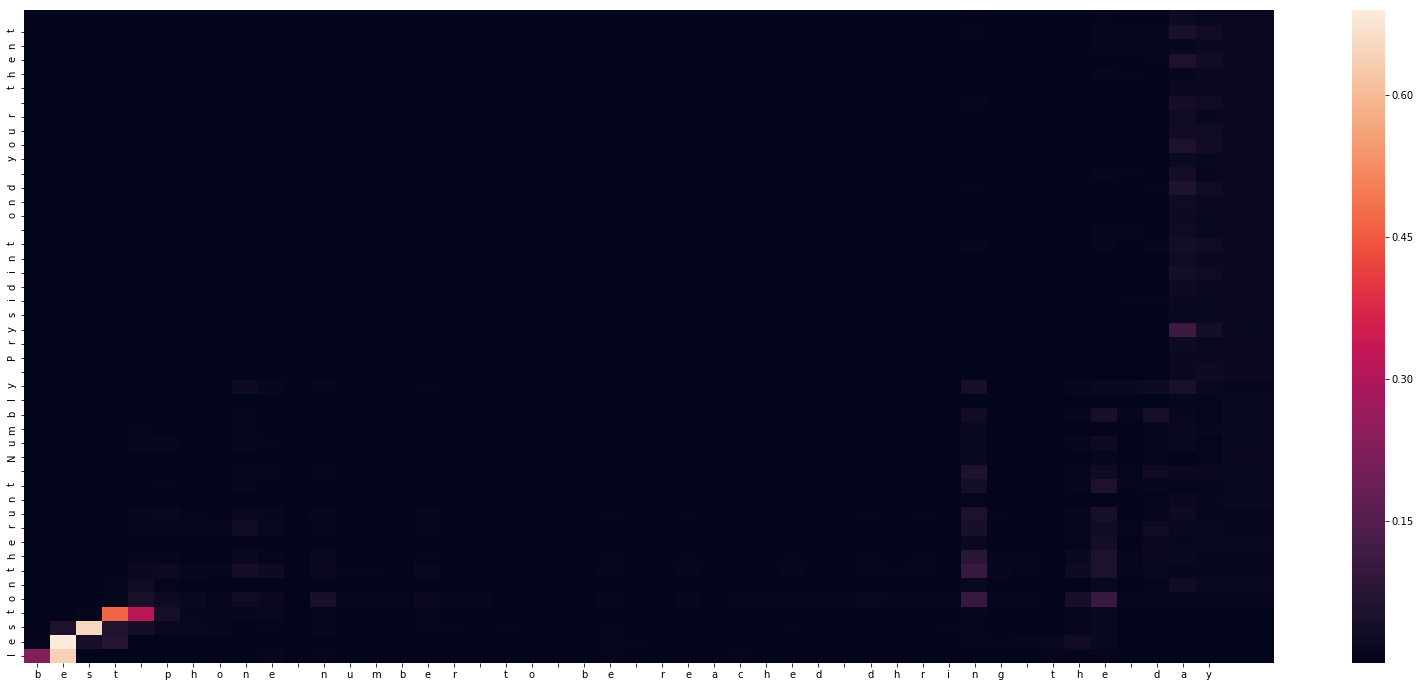

-
Input sentence: best phone number to be reached dhring the day
GT sentence: Best Phone Number to be Reached During the Day:

Decoded sentence: Iestontherunt Numbly Prysidint ond your thent


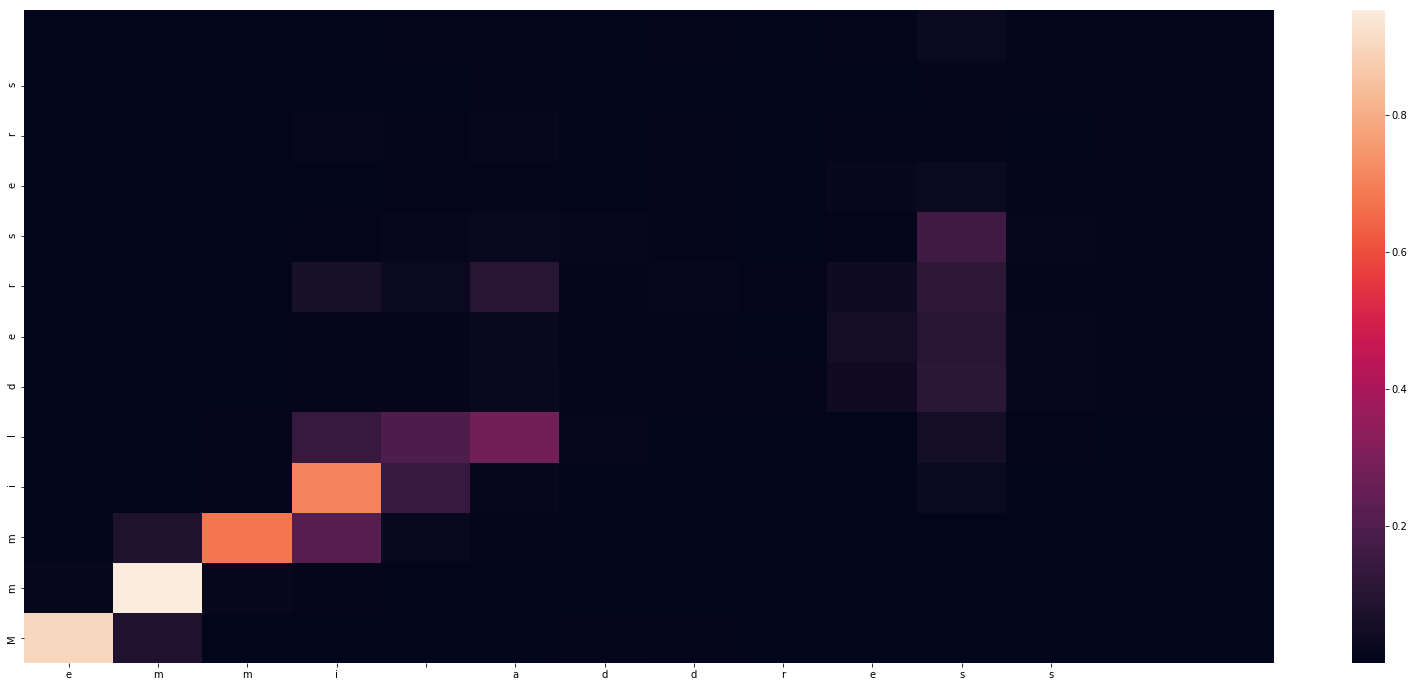

-
Input sentence: emmi address
GT sentence: Email Address:

Decoded sentence: Mmmildersers


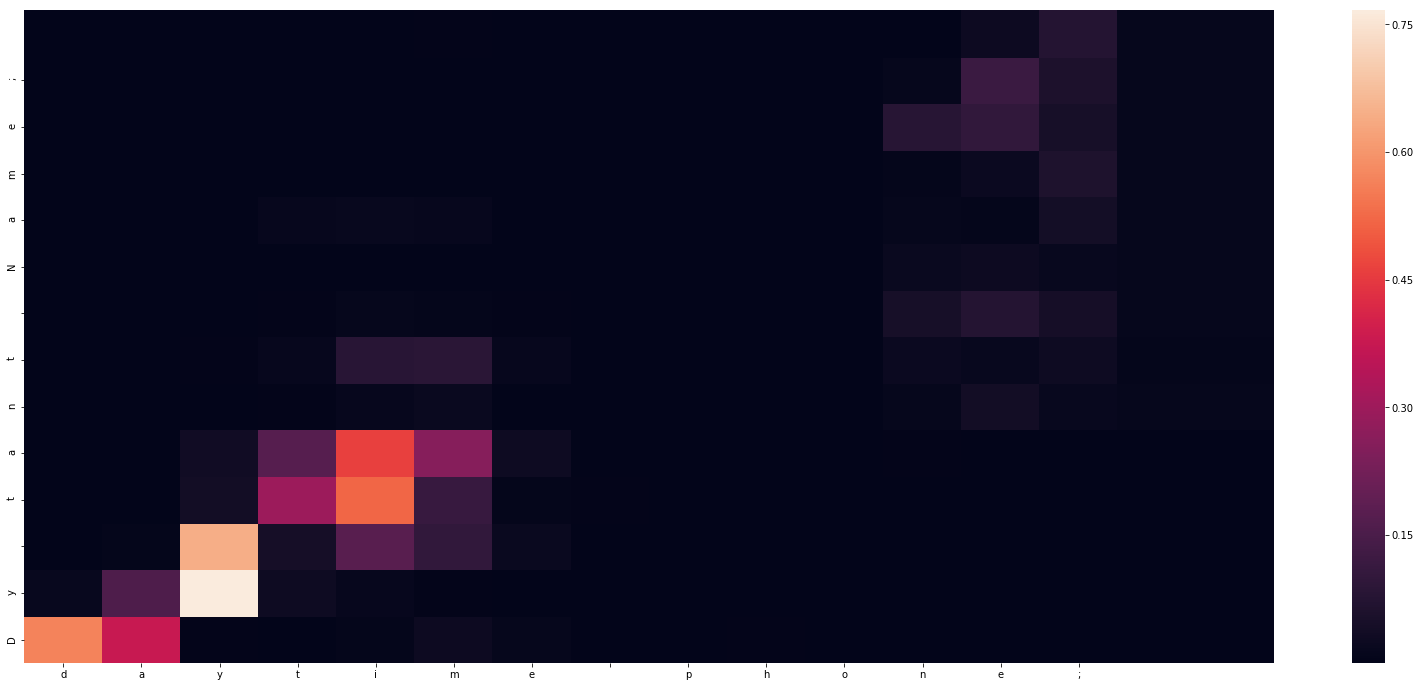

-
Input sentence: daytime phone;
GT sentence: Daytime Phone:

Decoded sentence: Dy tant Name;


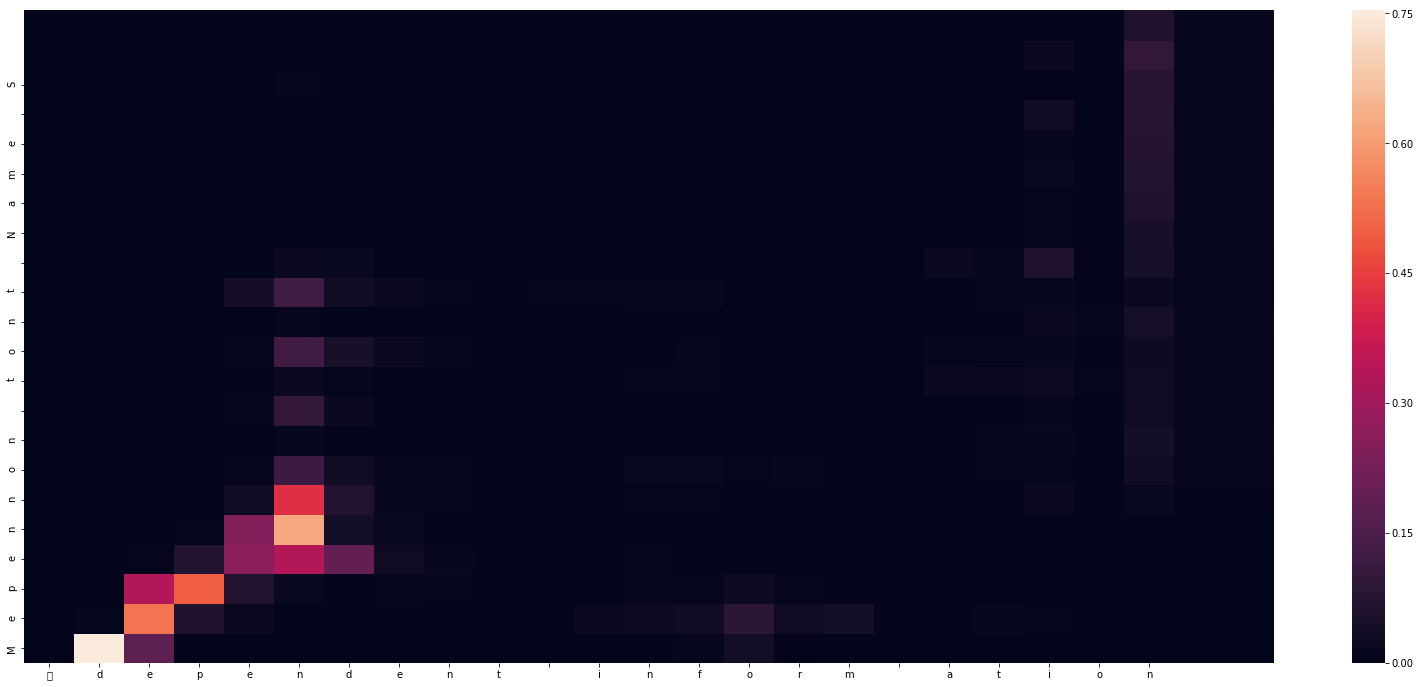

-
Input sentence: dependent inform ation
GT sentence: Dependent Information

Decoded sentence: Mepennon tont Name S


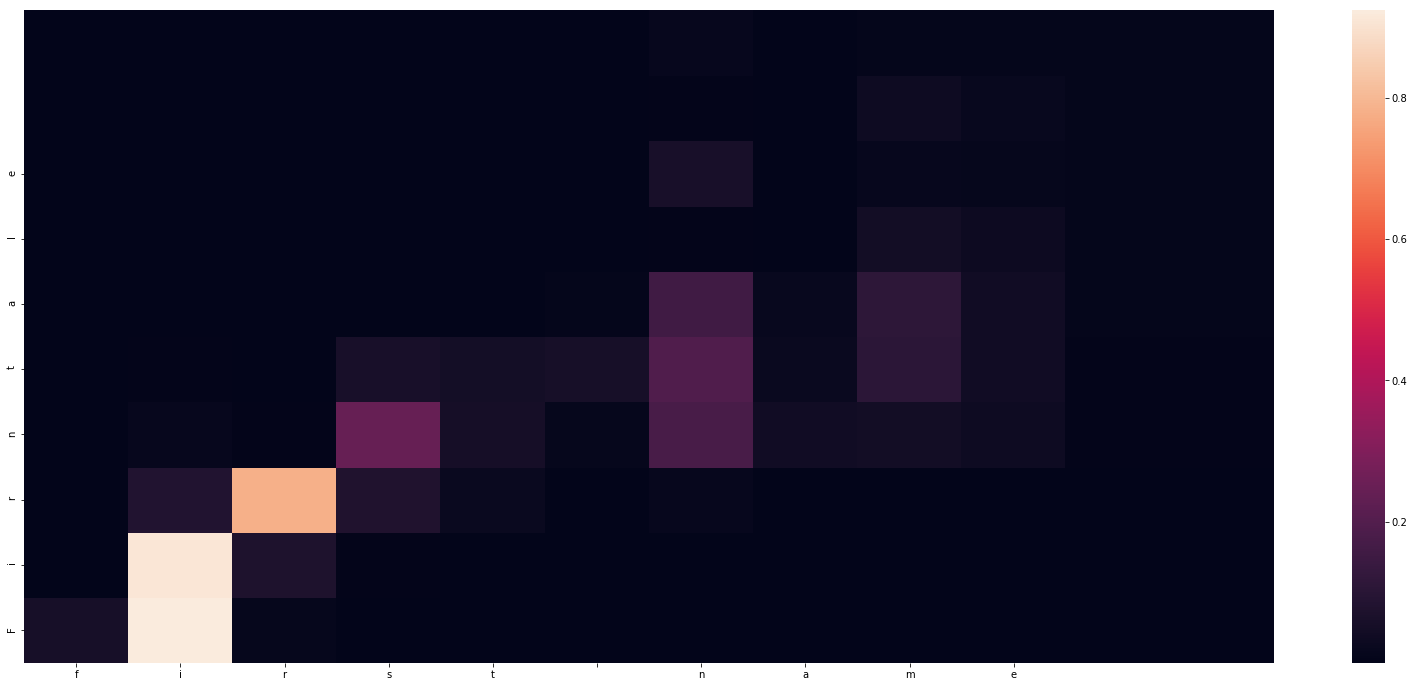

-
Input sentence: first name
GT sentence: First Name:

Decoded sentence: Firntale


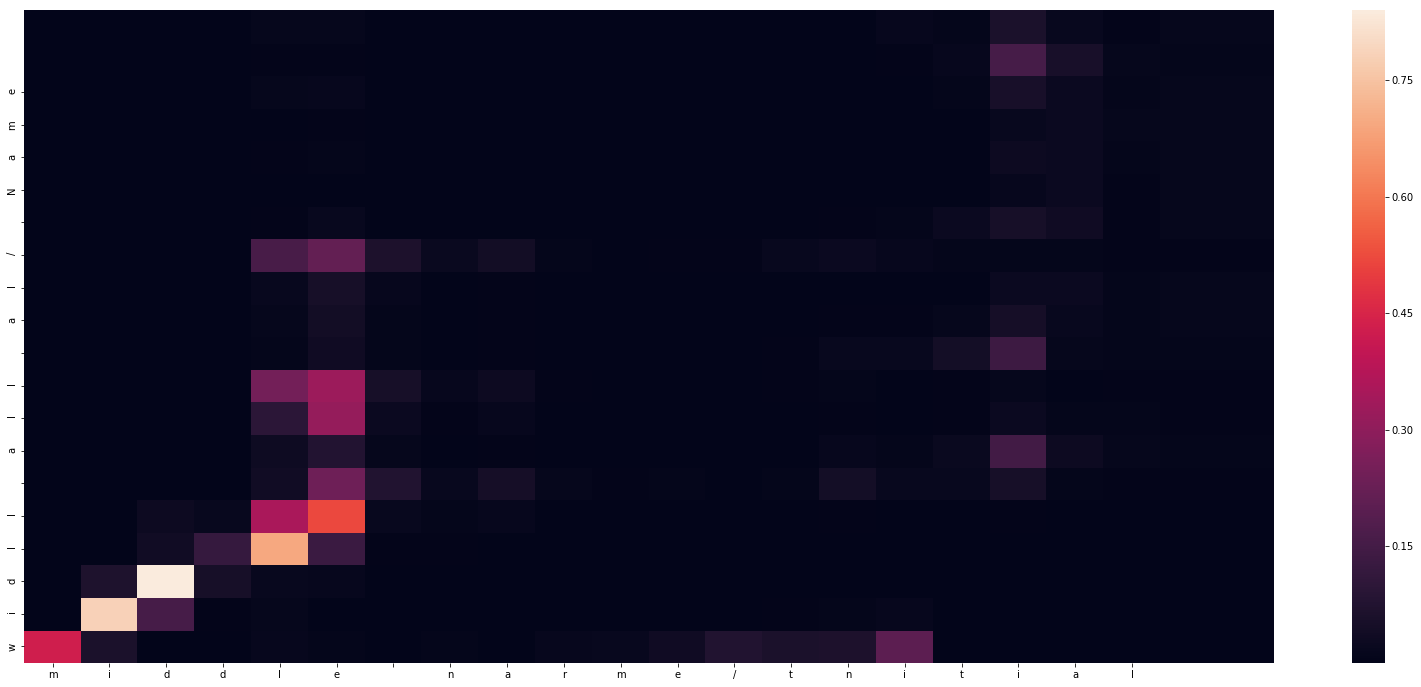

-
Input sentence: middle narme/tnitial
GT sentence: Middle Name/Initial:

Decoded sentence: widll all al/ Name


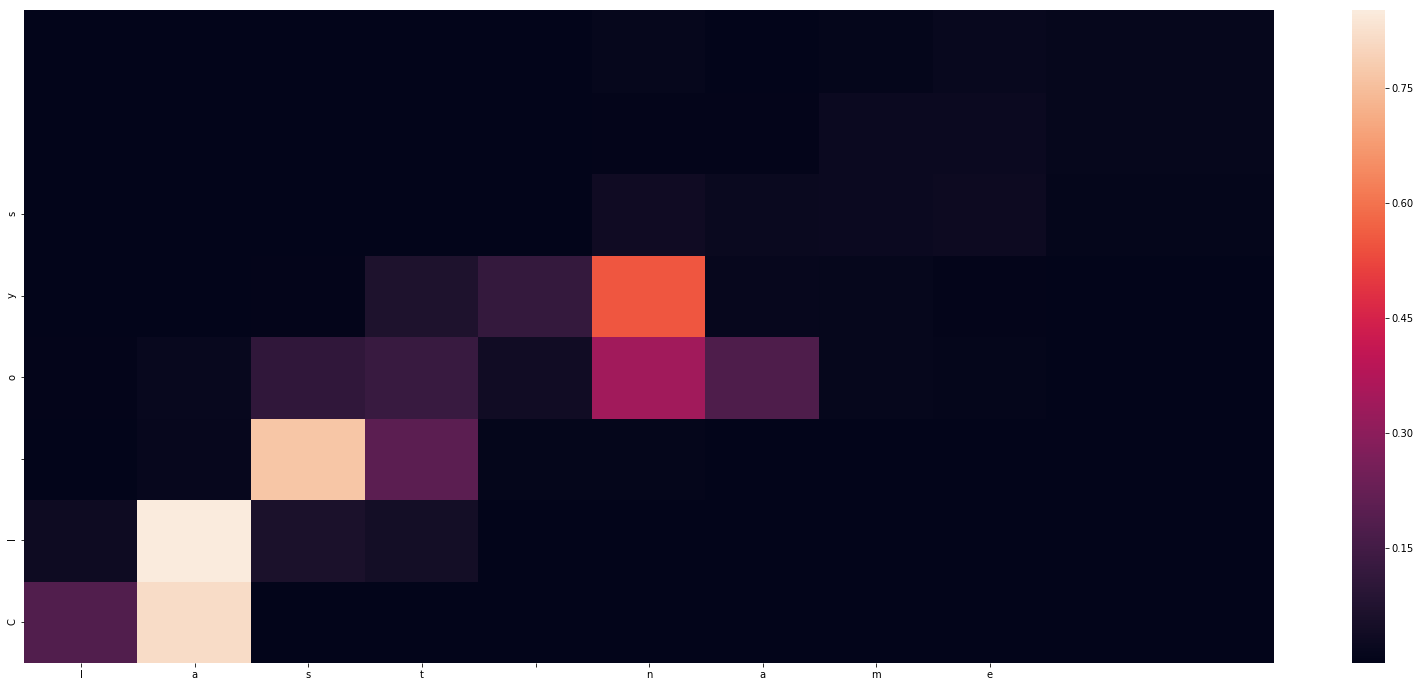

-
Input sentence: last name
GT sentence: Last Name:

Decoded sentence: Cl oys


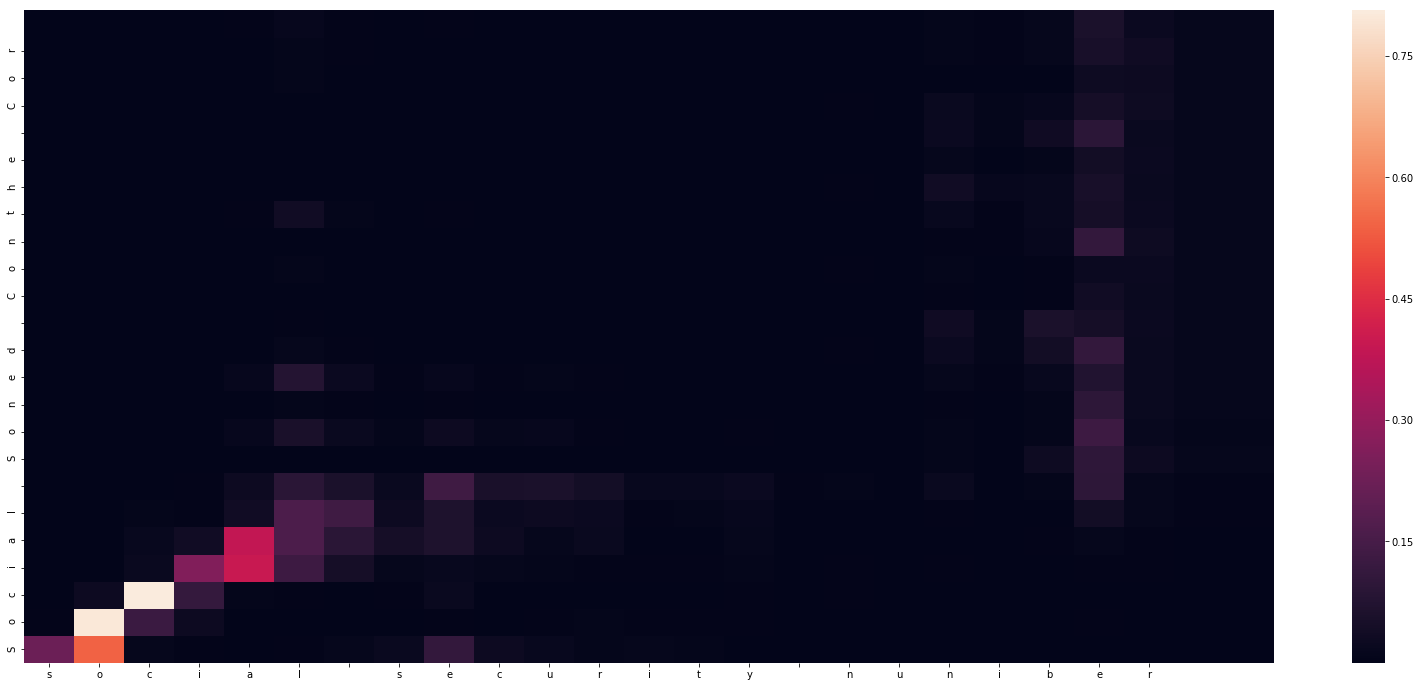

-
Input sentence: social security nuniber
GT sentence: Social Security Number:

Decoded sentence: Social Soned Conthe Cor


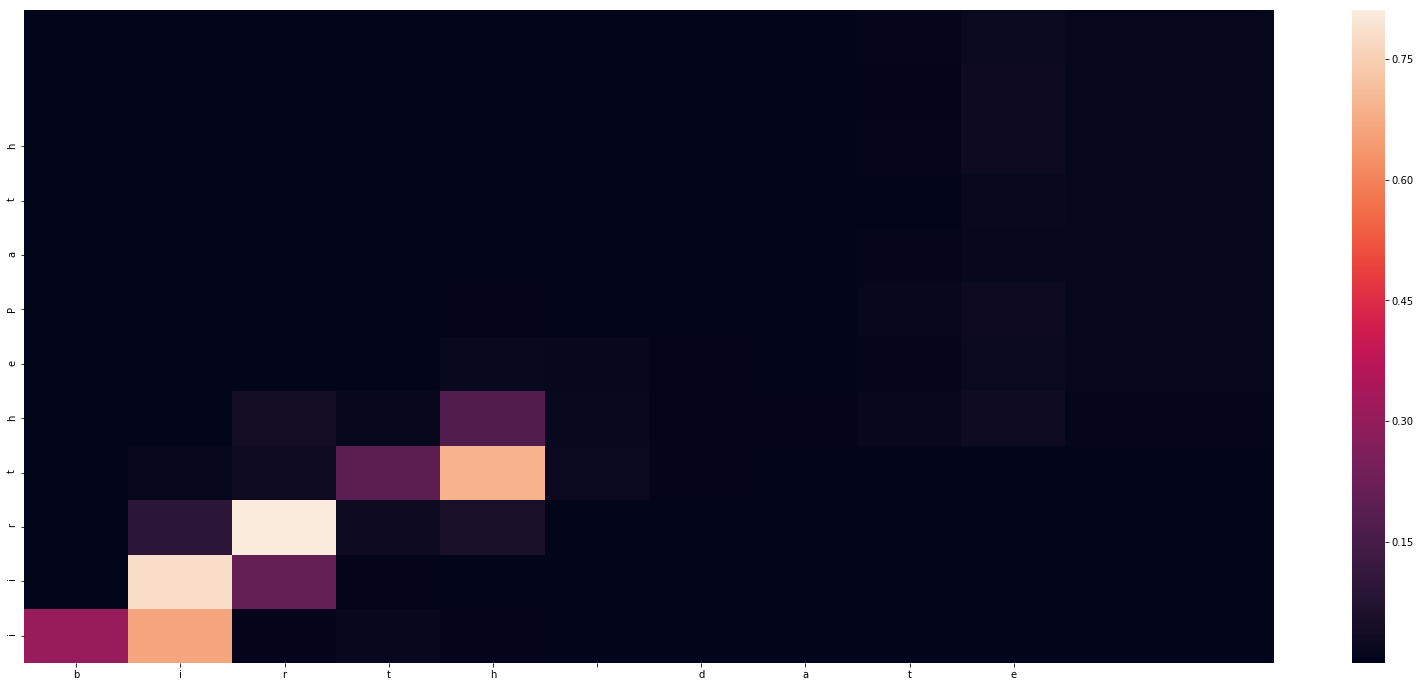

-
Input sentence: birth date
GT sentence: Birth Date:

Decoded sentence: iirthePath


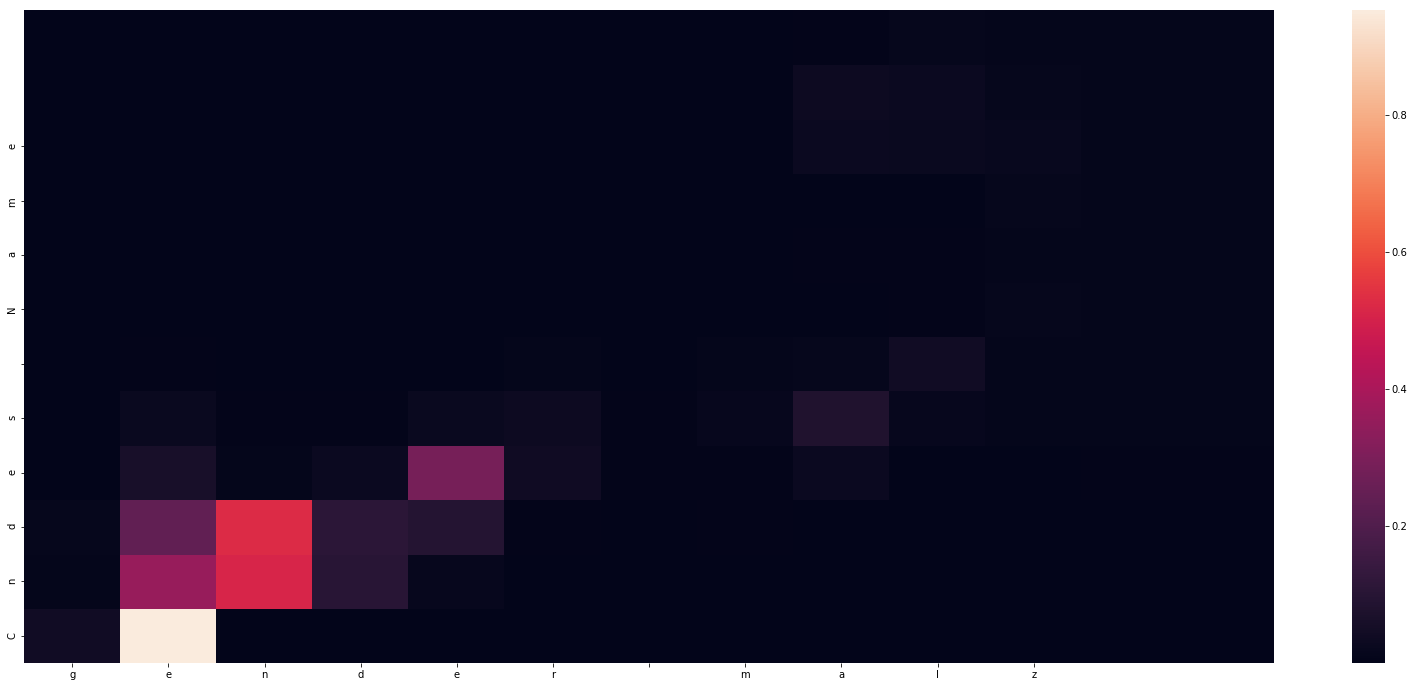

-
Input sentence: gender malz
GT sentence: Gender: Male

Decoded sentence: Cndes Name


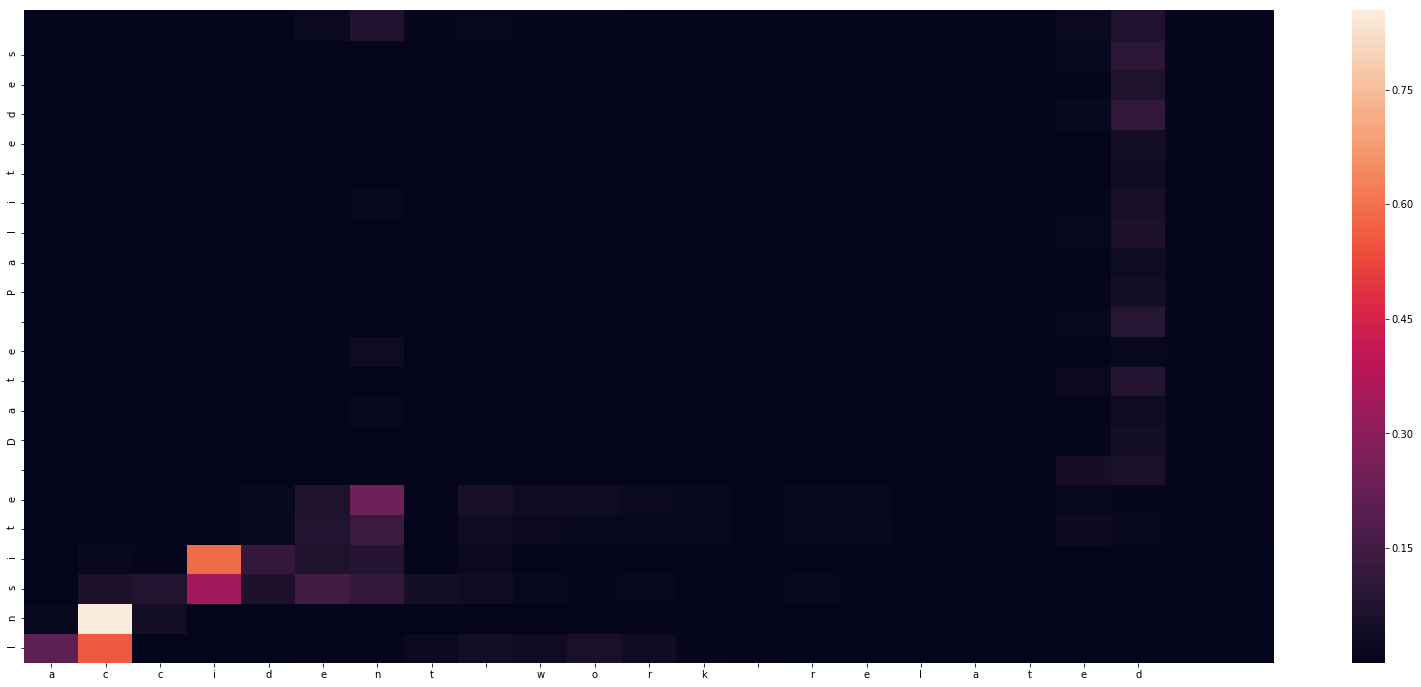

-
Input sentence: accident work related
GT sentence: Accident Work Related:

Decoded sentence: Insite Date Palitedes


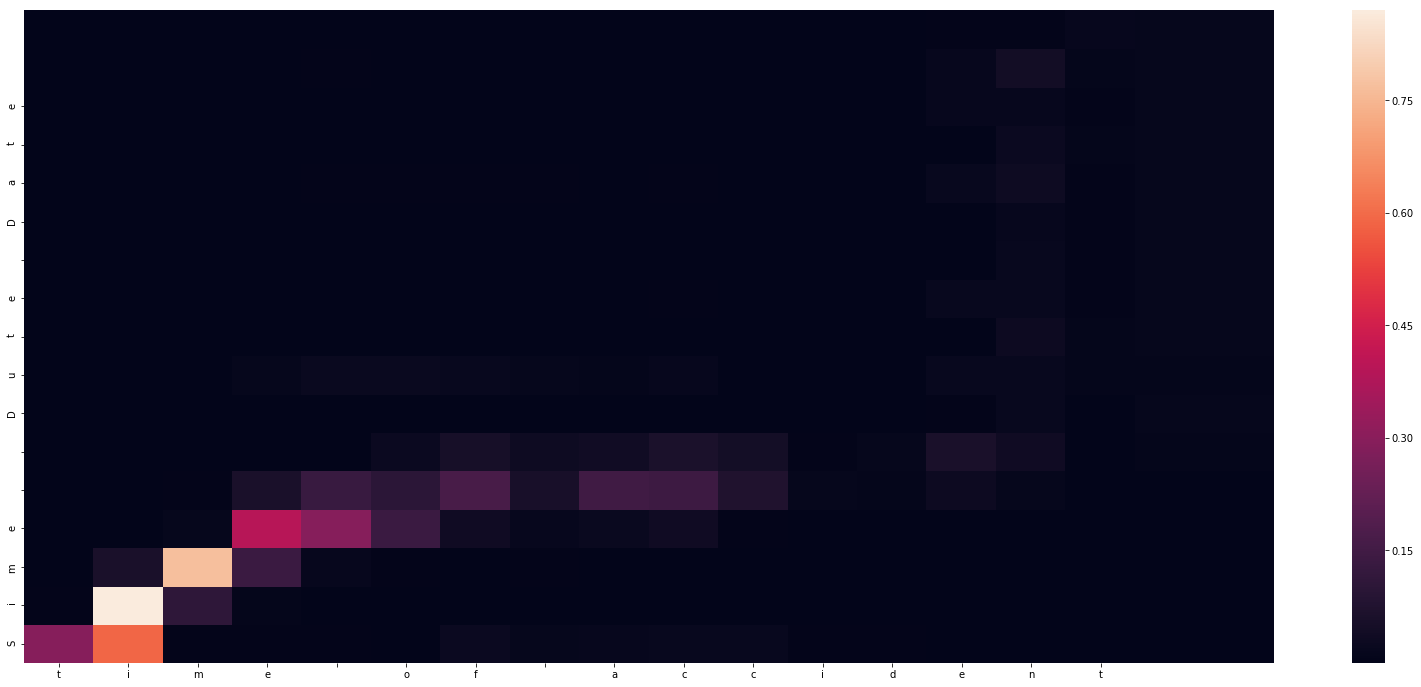

-
Input sentence: time of accident
GT sentence: Time of Accident:

Decoded sentence: Sime  Dute Date


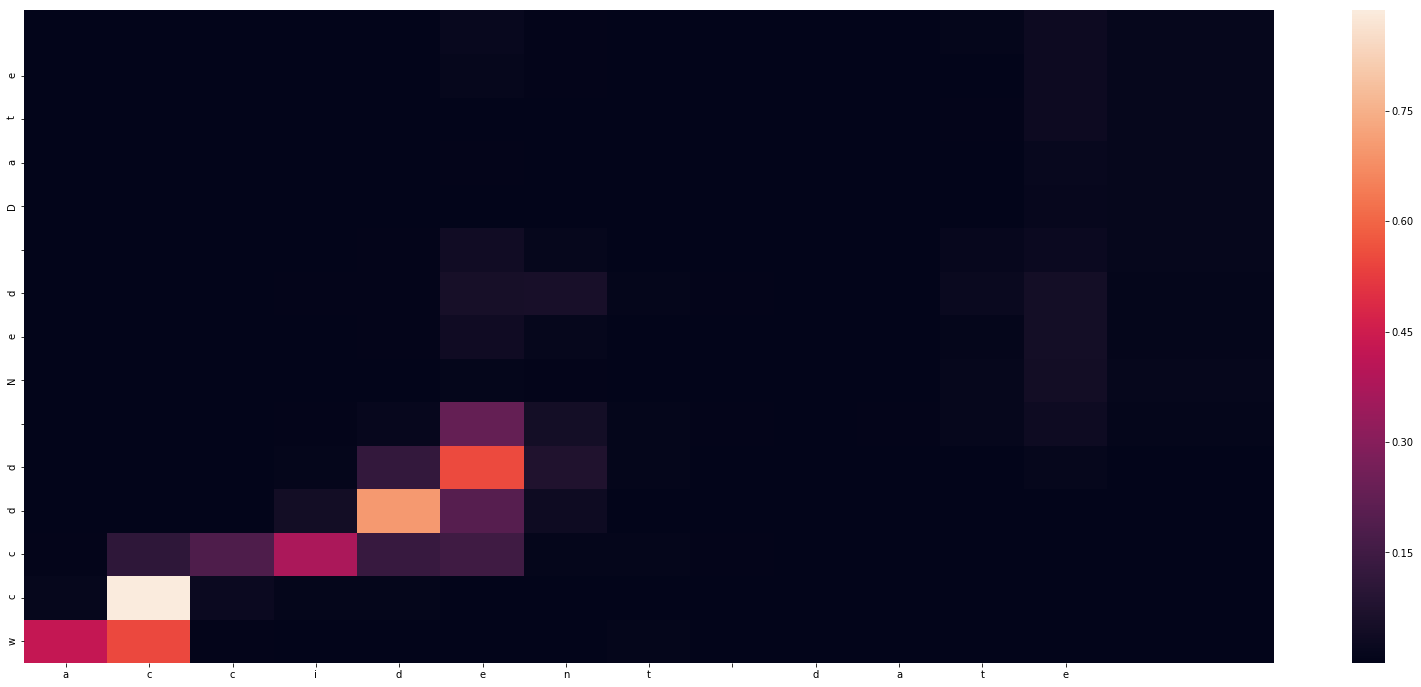

-
Input sentence: accident date
GT sentence: Accident Date:

Decoded sentence: wccdd Ned Date


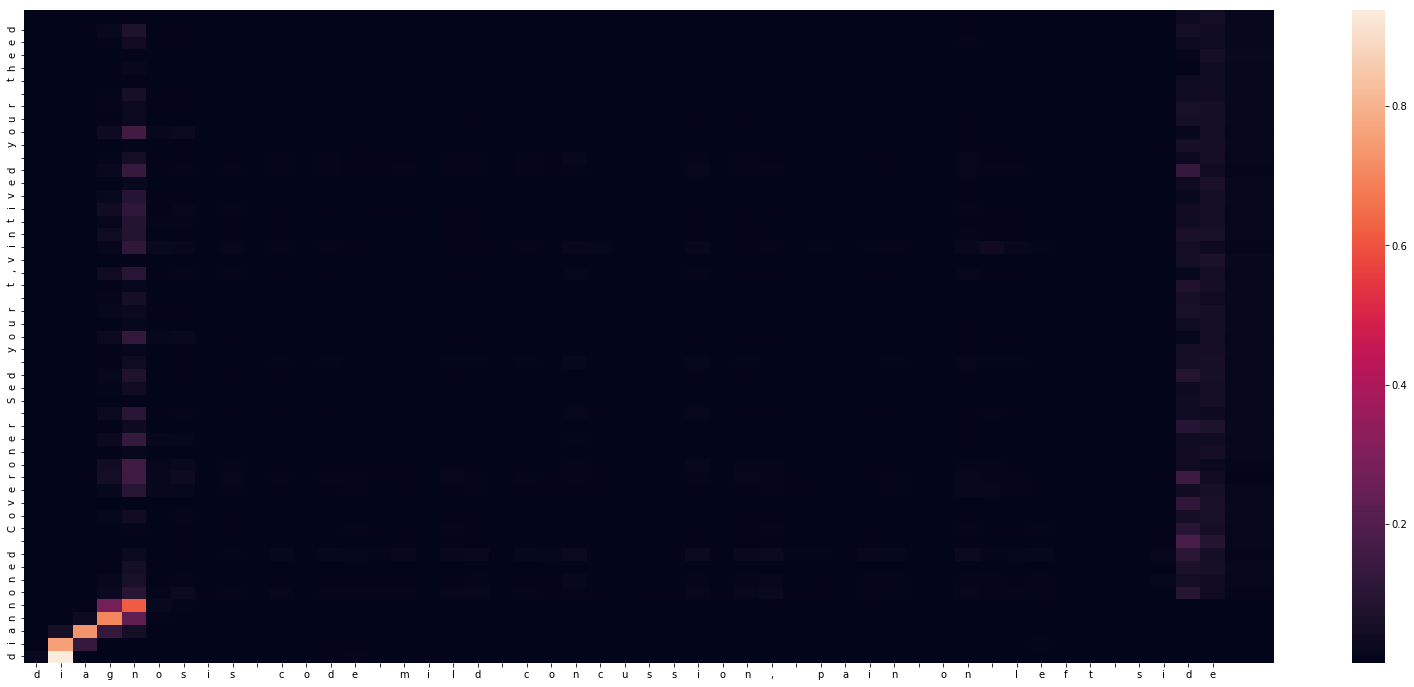

-
Input sentence: diagnosis code mild concussion, pain on left side
GT sentence: Diagnosis Code: Mild concussion, pain on left side

Decoded sentence: diannoned Coveroner Sed your t,vintived your theed


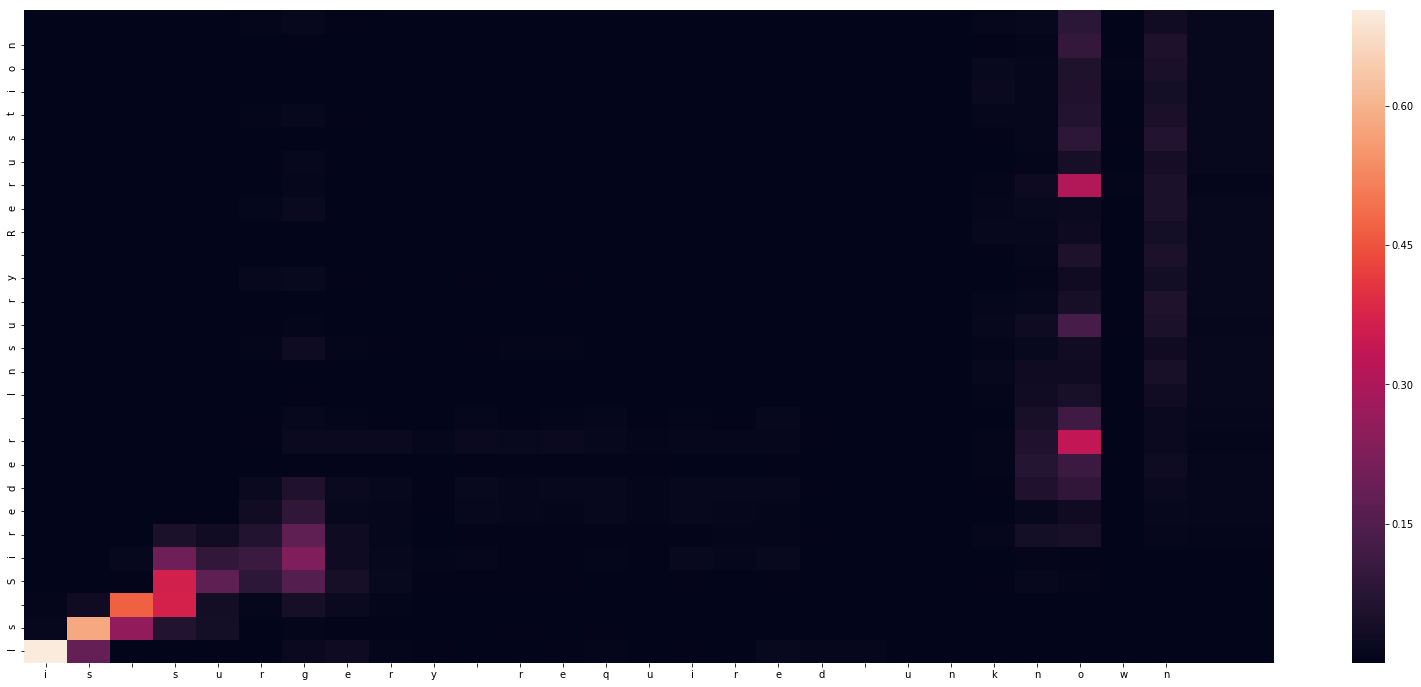

-
Input sentence: is surgery required unknown
GT sentence: Is Surgery Required: Unknown

Decoded sentence: Is Sireder Insury Rerustion


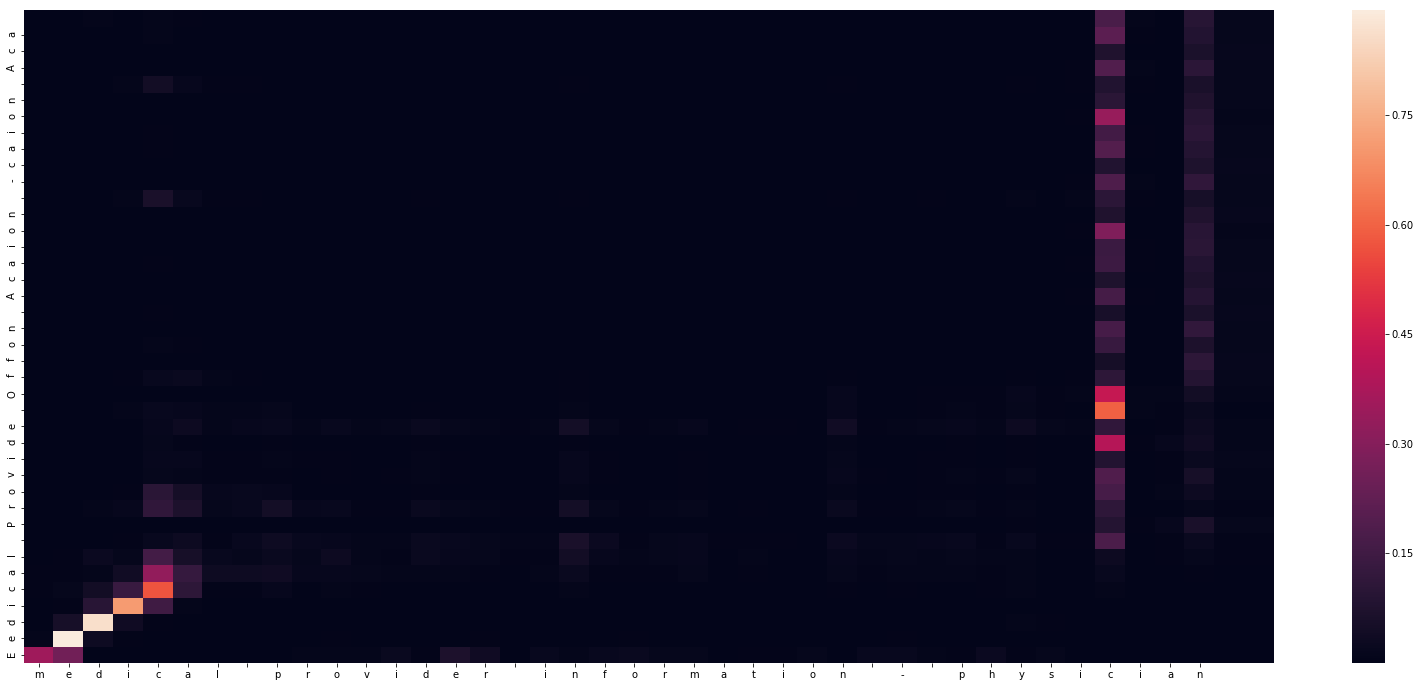

-
Input sentence: medical provider information - physician
GT sentence: Medical Provider Information - Physician

Decoded sentence: Eedical Provide Offon Acaion -caion Aca


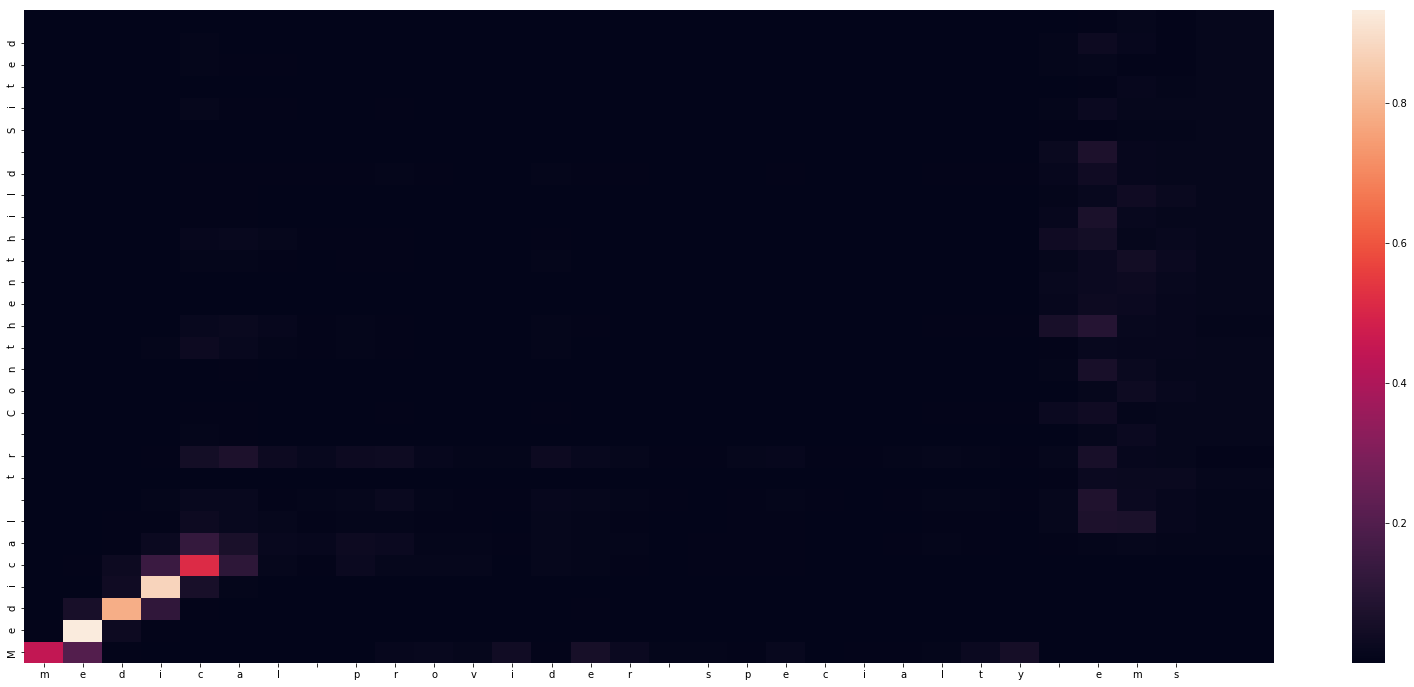

-
Input sentence: medical provider specialty ems
GT sentence: Medical Provider Specialty: EMS

Decoded sentence: Medical tr Conthenthild Sited


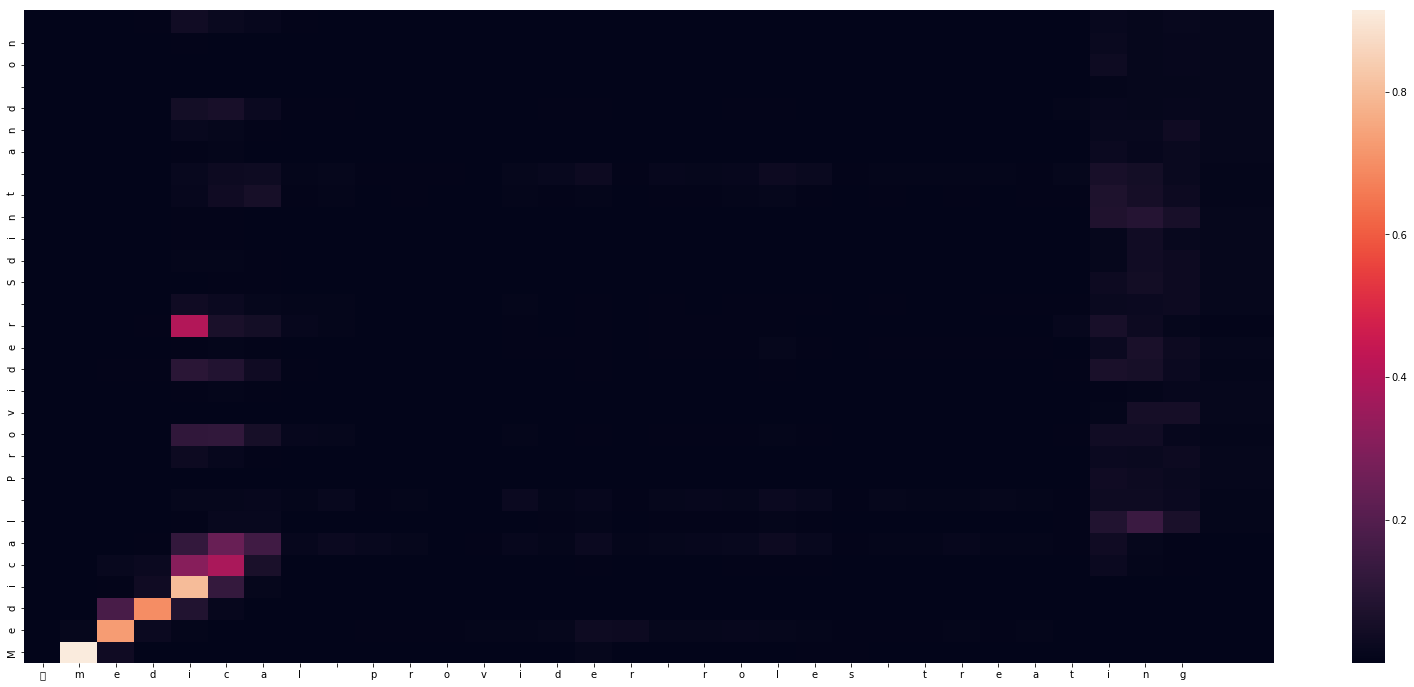

-
Input sentence: medical provider roles treating
GT sentence: Medical Provider Roles: Treating

Decoded sentence: Medical Provider Sdint and on


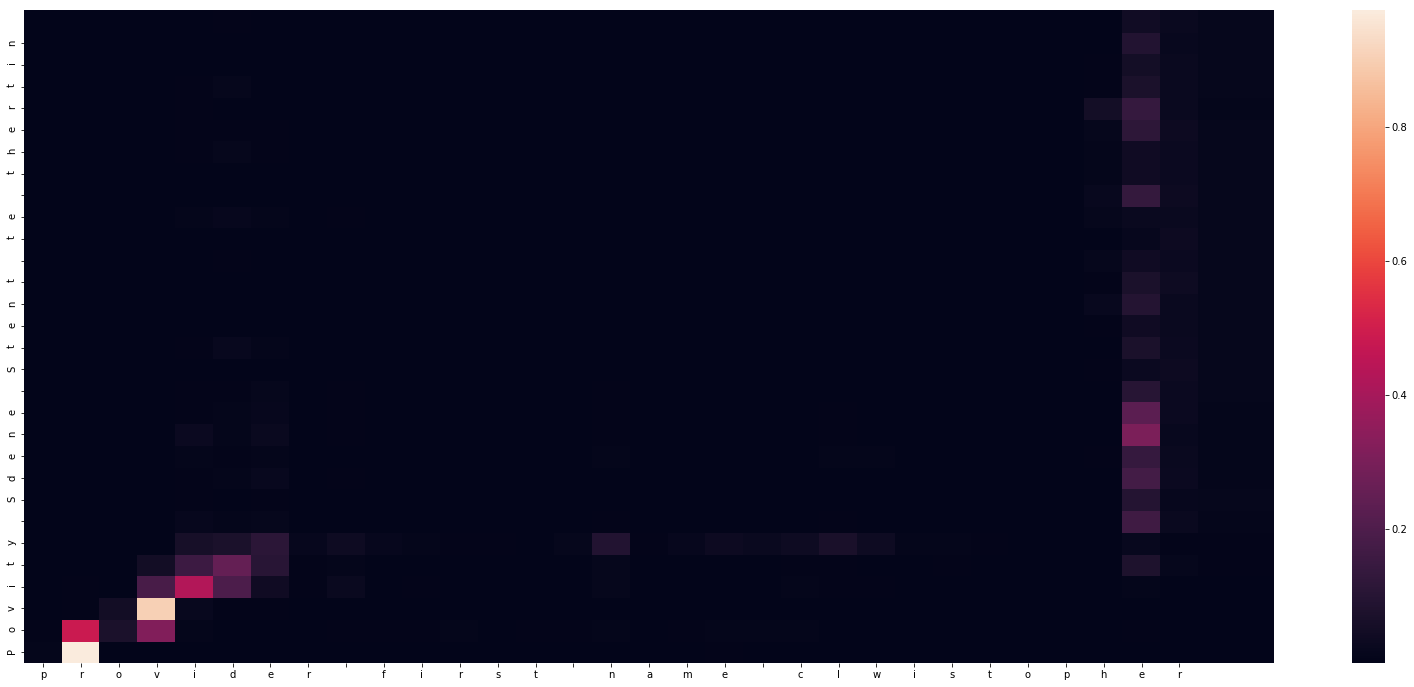

-
Input sentence: provider first name clwistopher
GT sentence: Provider First Name: Christopher

Decoded sentence: Povity Sdene Stent te thertin


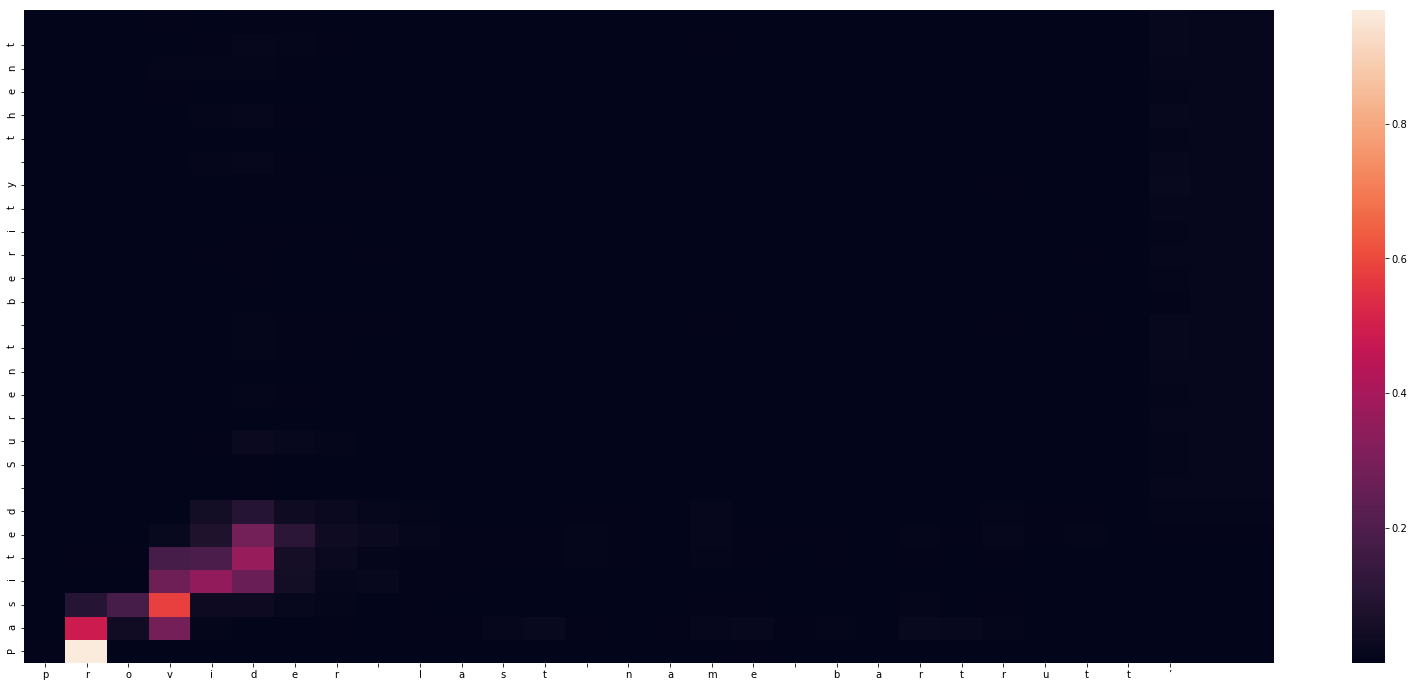

-
Input sentence: provider last name bartrutt’
GT sentence: Provider Last Name: Bartruff

Decoded sentence: Pasited Surent berity thent


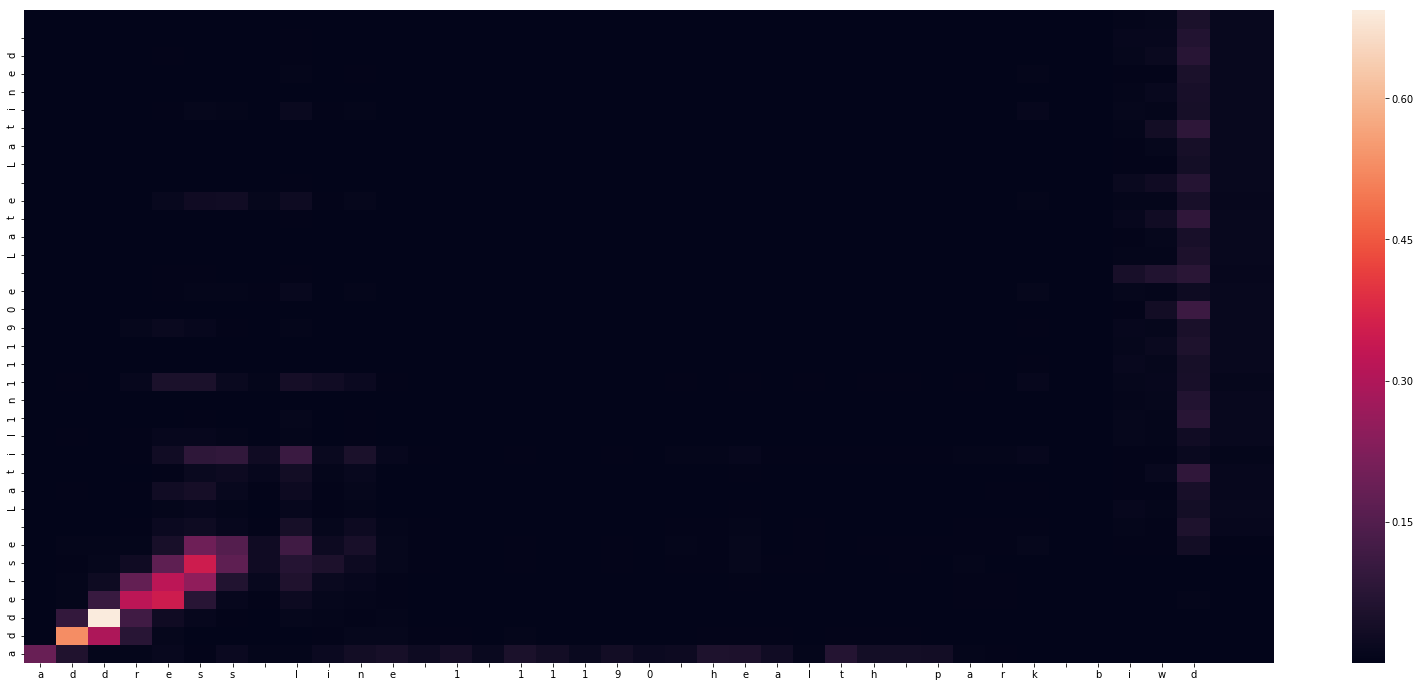

-
Input sentence: address line 1 11190 health park biwd
GT sentence: Address Line 1: 11190 health park blvd

Decoded sentence: adderse Latil1n11190e Late Latined 


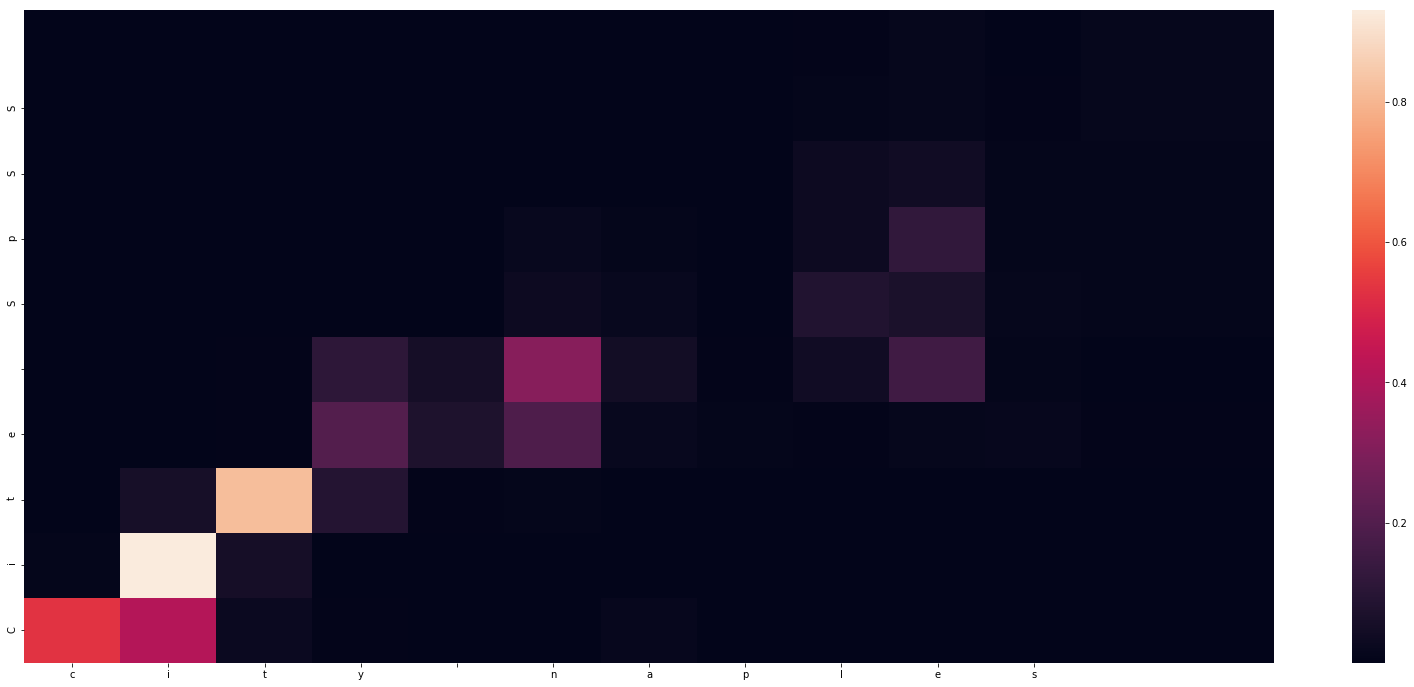

-
Input sentence: city naples
GT sentence: City: Naples

Decoded sentence: Cite SpSS


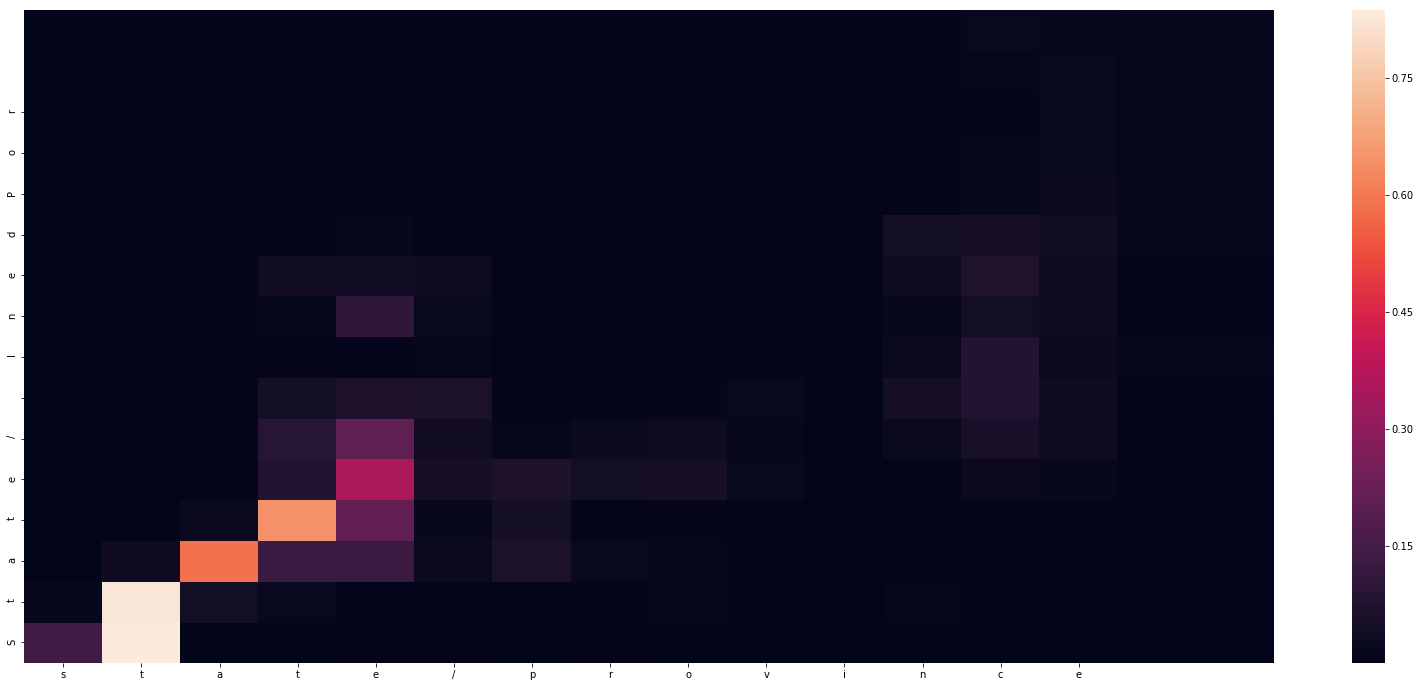

-
Input sentence: state/province
GT sentence: State/Province: FL

Decoded sentence: State/ InedPor


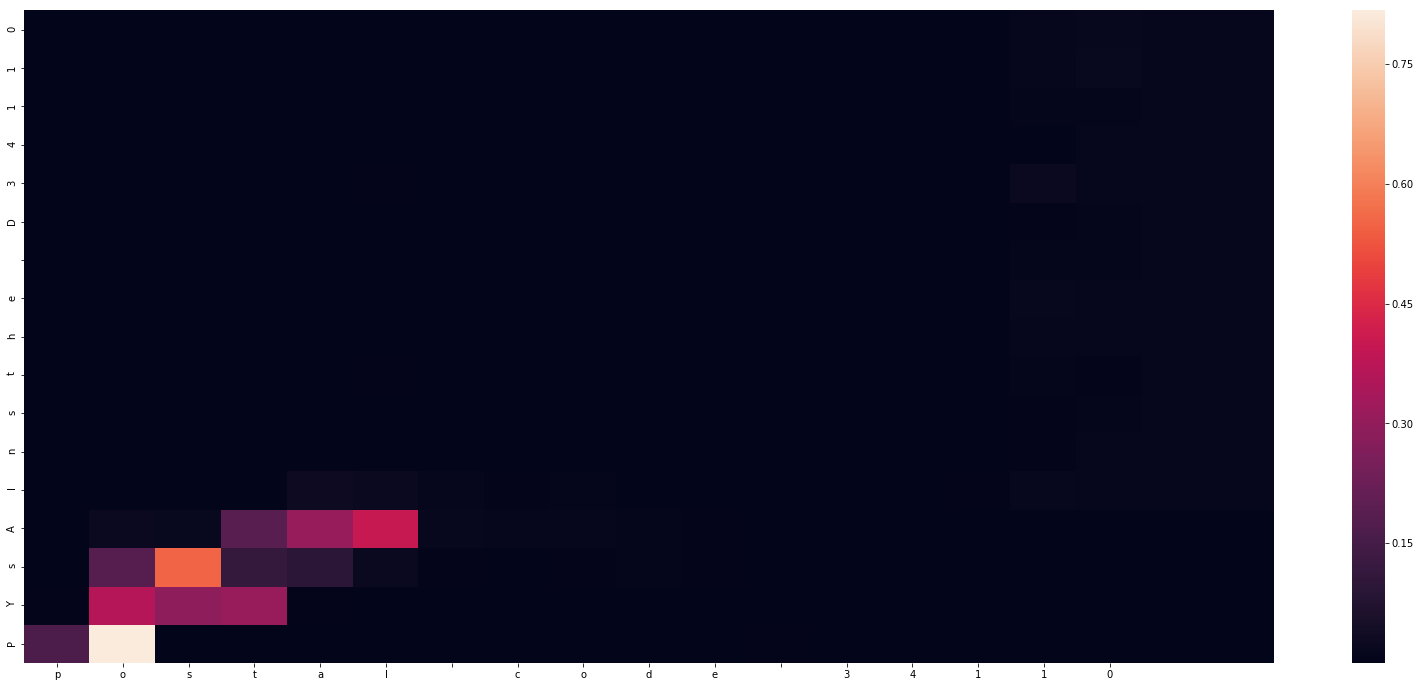

-
Input sentence: postal code 34110
GT sentence: Postal Code: 34110

Decoded sentence: PYsAInsthe D34110


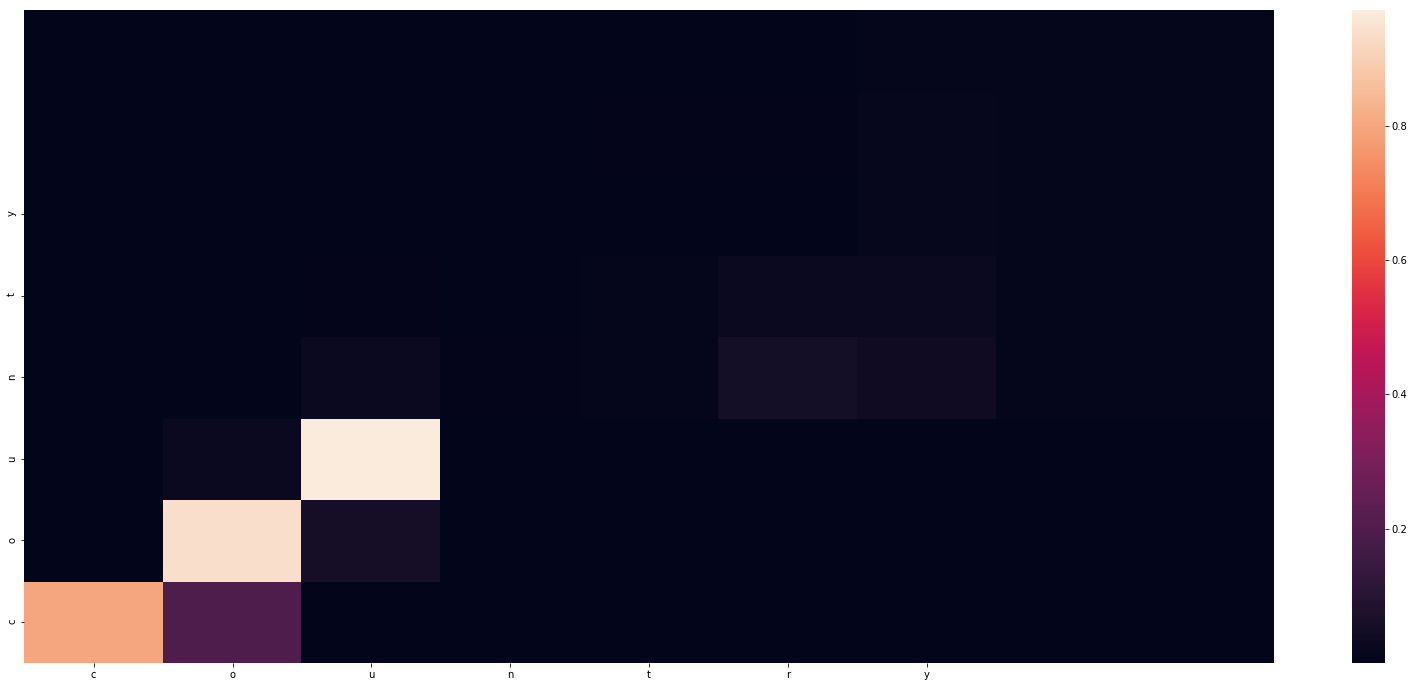

-
Input sentence: country
GT sentence: Country: US

Decoded sentence: county


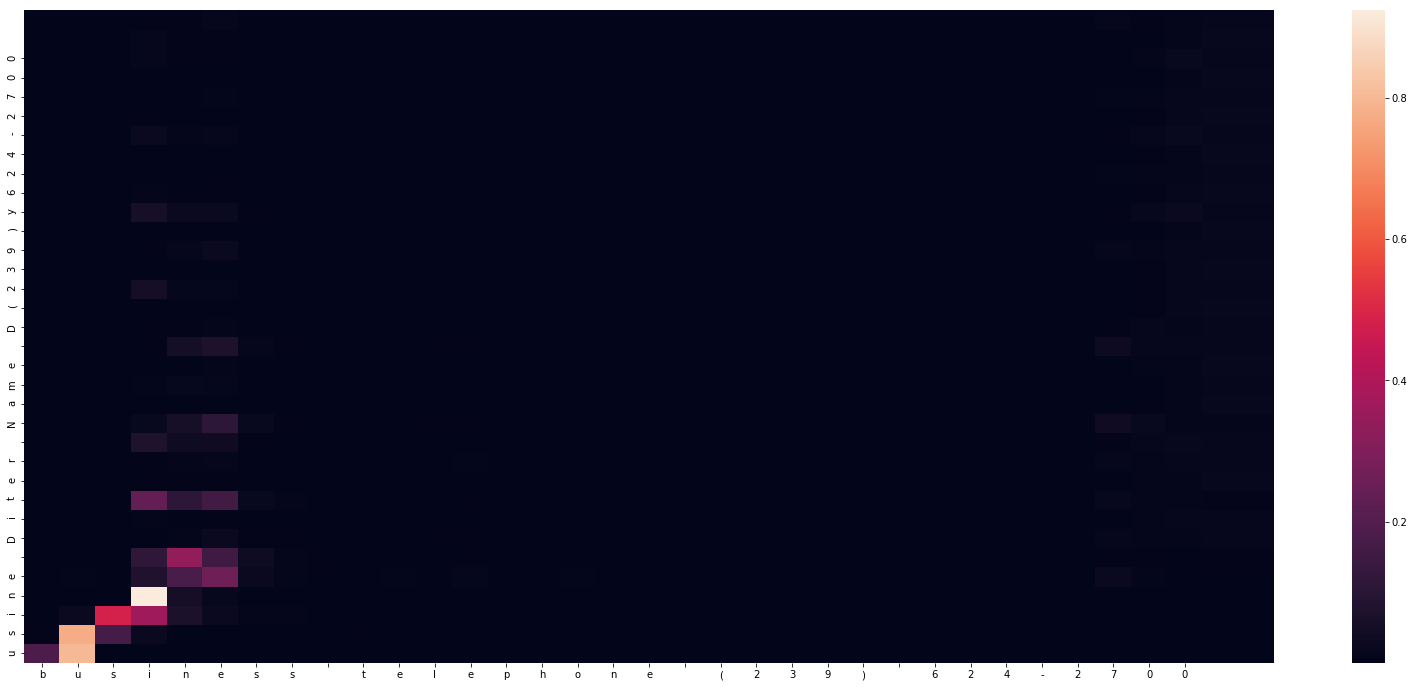

-
Input sentence: business telephone (239) 624-2700
GT sentence: Business Telephone: (239) 624-2700

Decoded sentence: usine Diter Name D(239)y624-2700


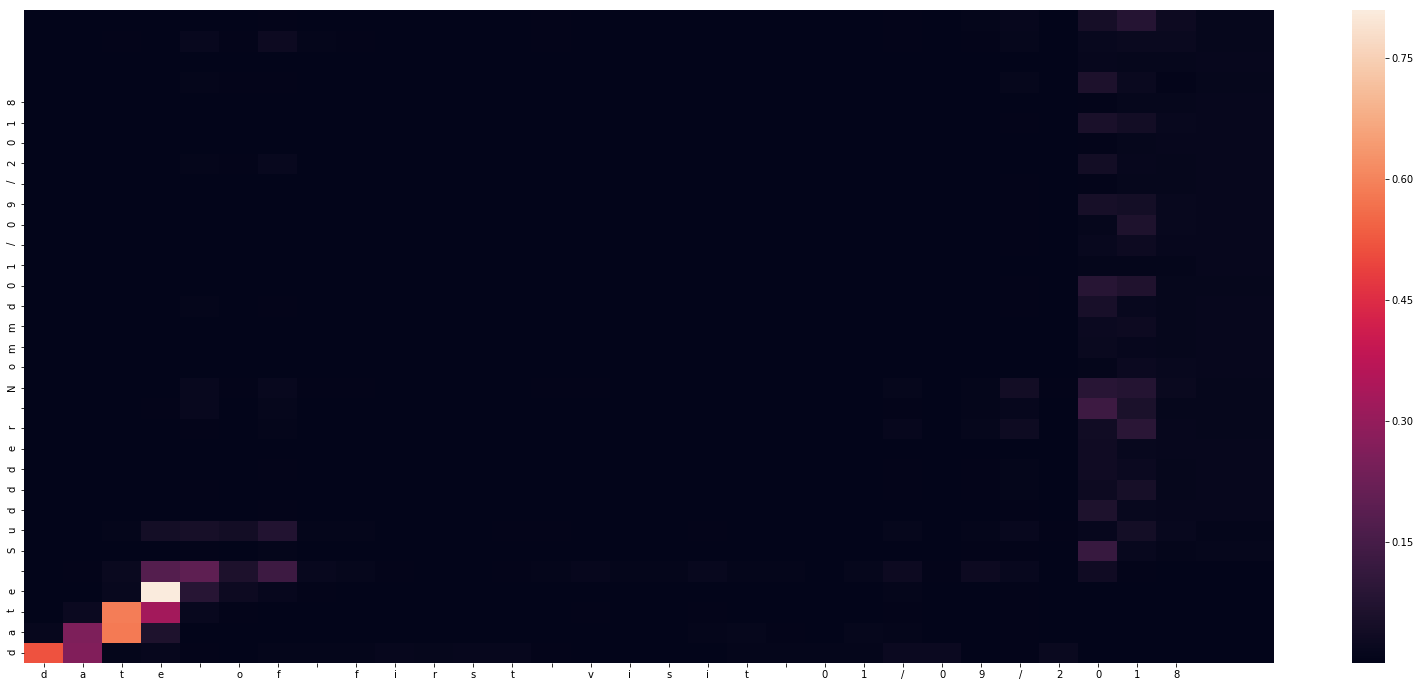

-
Input sentence: date of first visit 01/09/2018
GT sentence: Date of First Visit: 01/09/2018

Decoded sentence: date Suddder Nommd01/09/2018


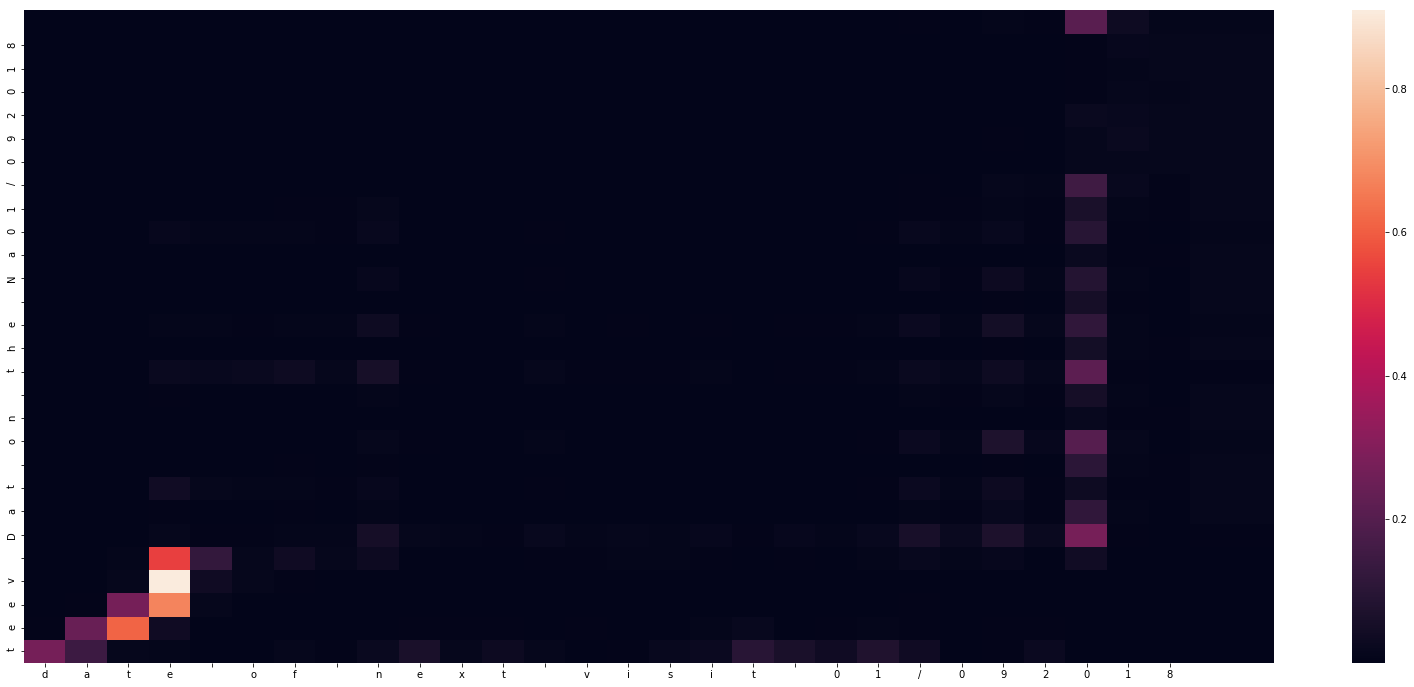

-
Input sentence: date of next visit 01/092018
GT sentence: Date of Next Visit: 01/09/2018

Decoded sentence: teev Dat on the Na01/092018


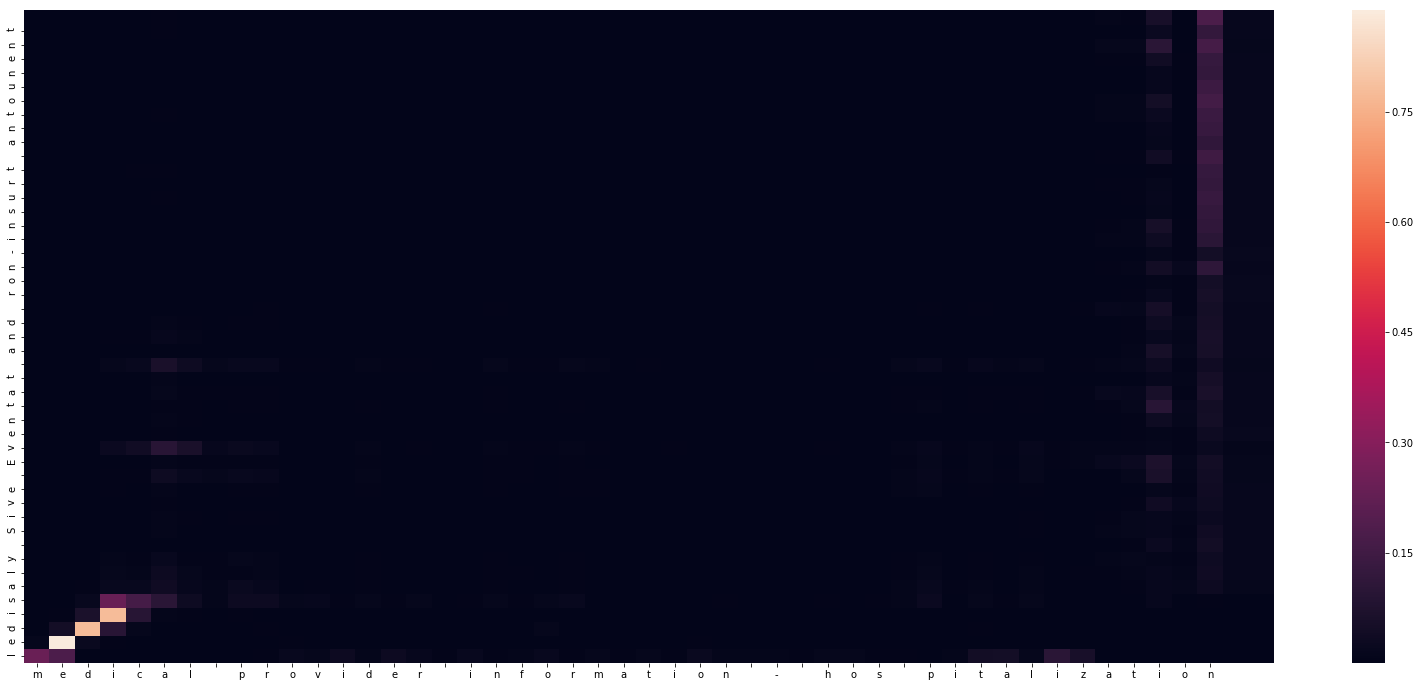

-
Input sentence: medical provider information - hos pitalization
GT sentence: Medical Provider Information - Hospitalization

Decoded sentence: Iedisaly Sive Eventat and ron-insurt antounent


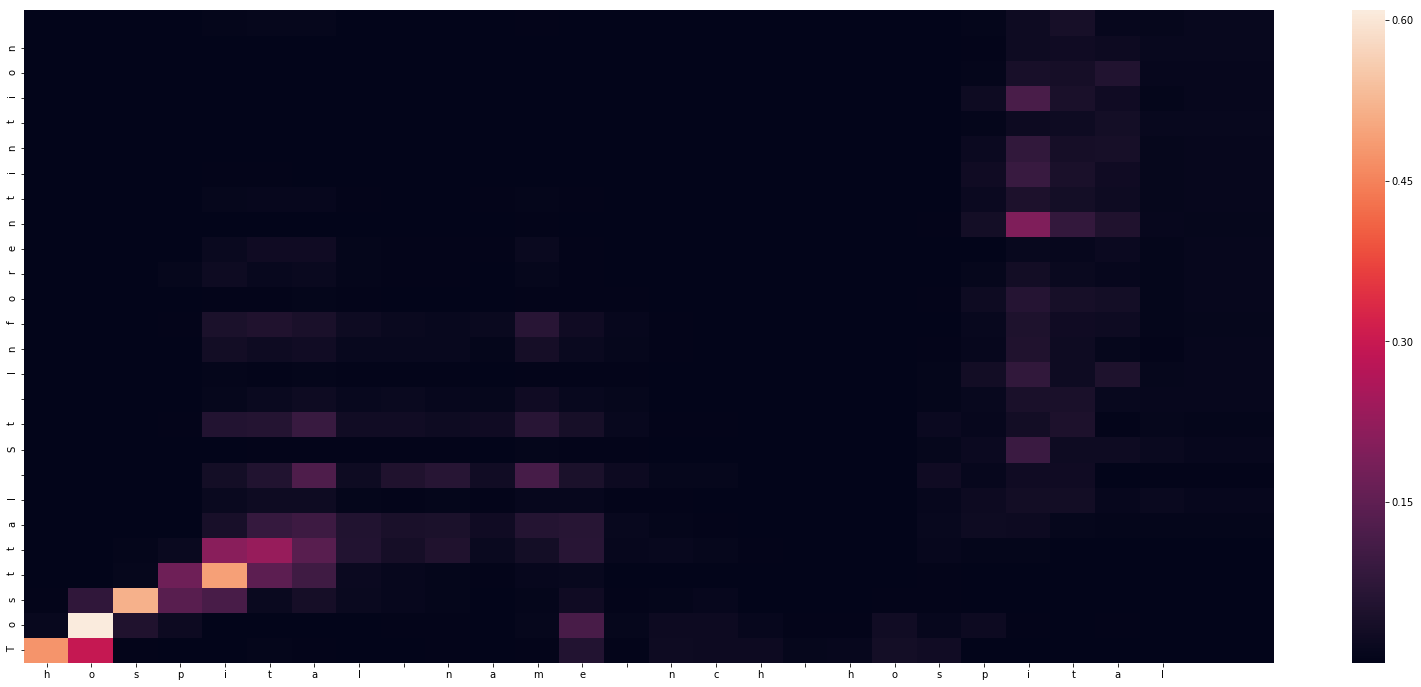

-
Input sentence: hospital name nch hospital
GT sentence: Hospital Name: NCH Hospital

Decoded sentence: Tosttal St Inforentintion


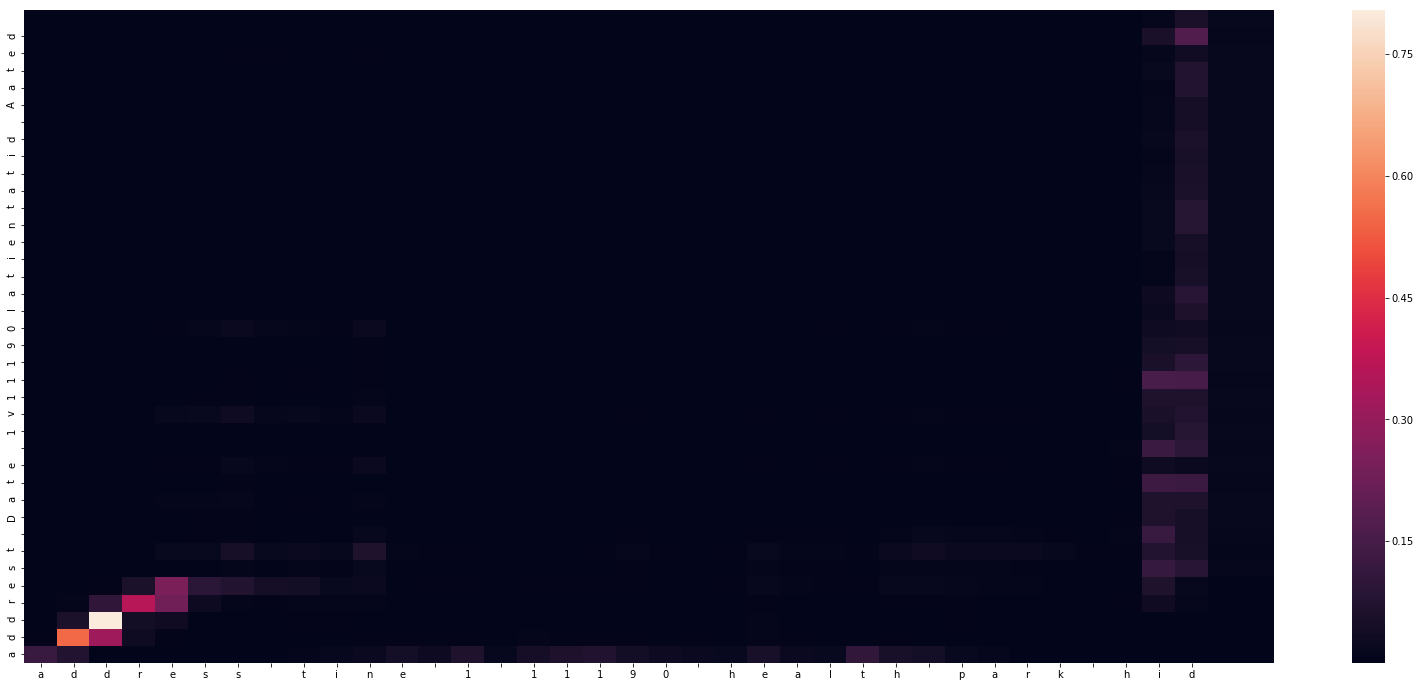

-
Input sentence: address tine 1 11190 health park hid
GT sentence: Address Line 1: 11190 health park blvd

Decoded sentence: addrest Date 1v11190latientatid Aated


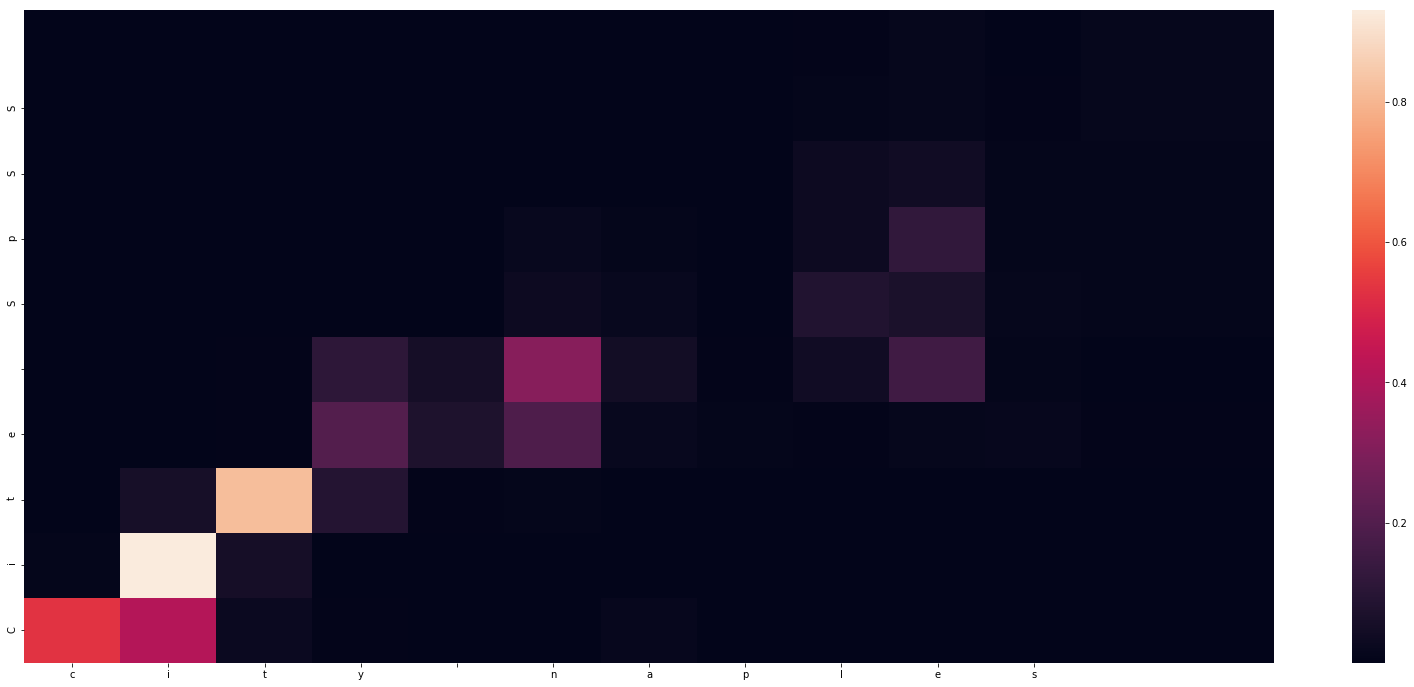

-
Input sentence: city naples
GT sentence: City: Naples

Decoded sentence: Cite SpSS


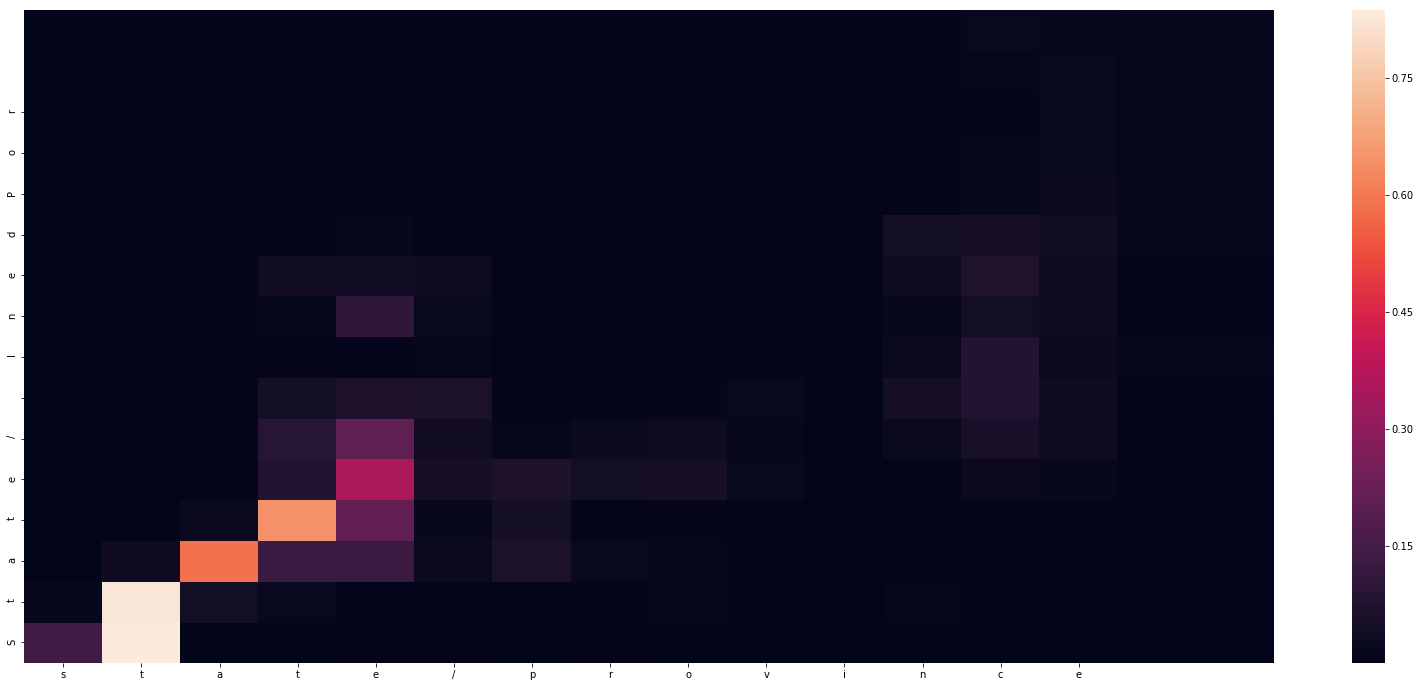

-
Input sentence: state/province
GT sentence: State/Province:

Decoded sentence: State/ InedPor


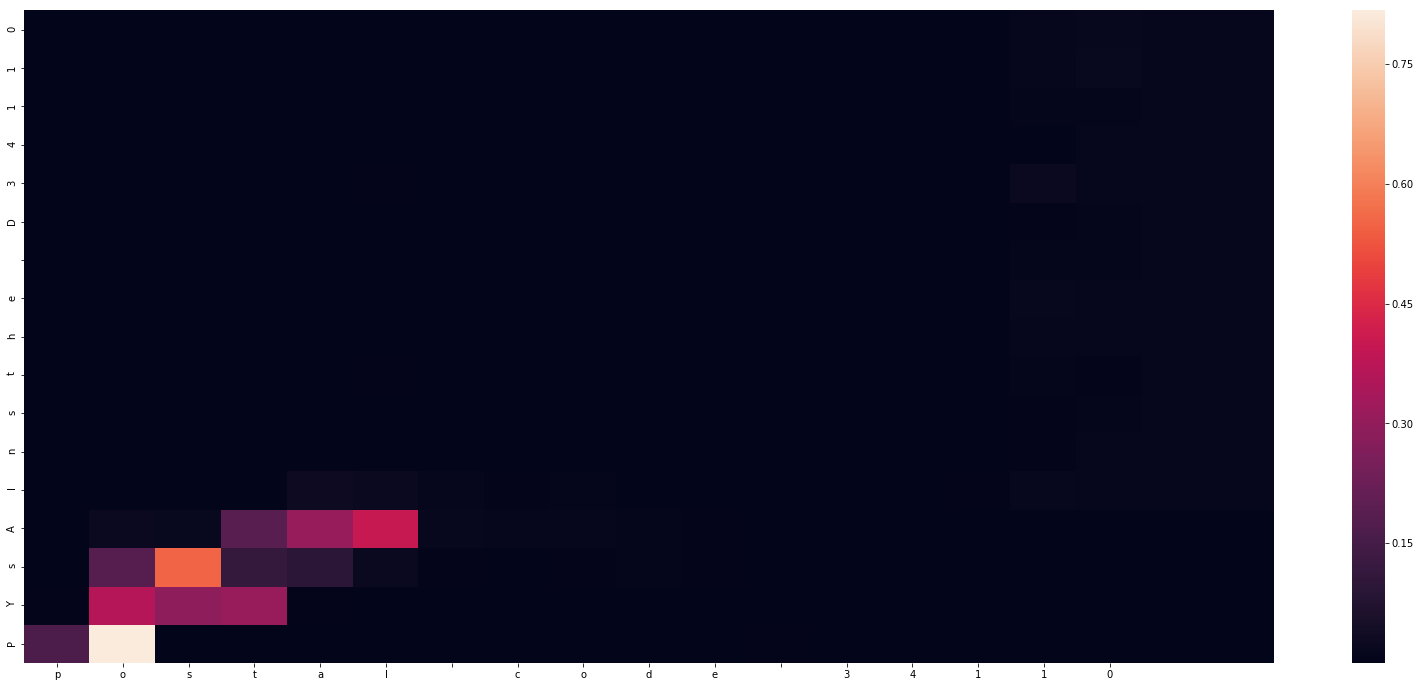

-
Input sentence: postal code 34110
GT sentence: Postal Code: 34110

Decoded sentence: PYsAInsthe D34110


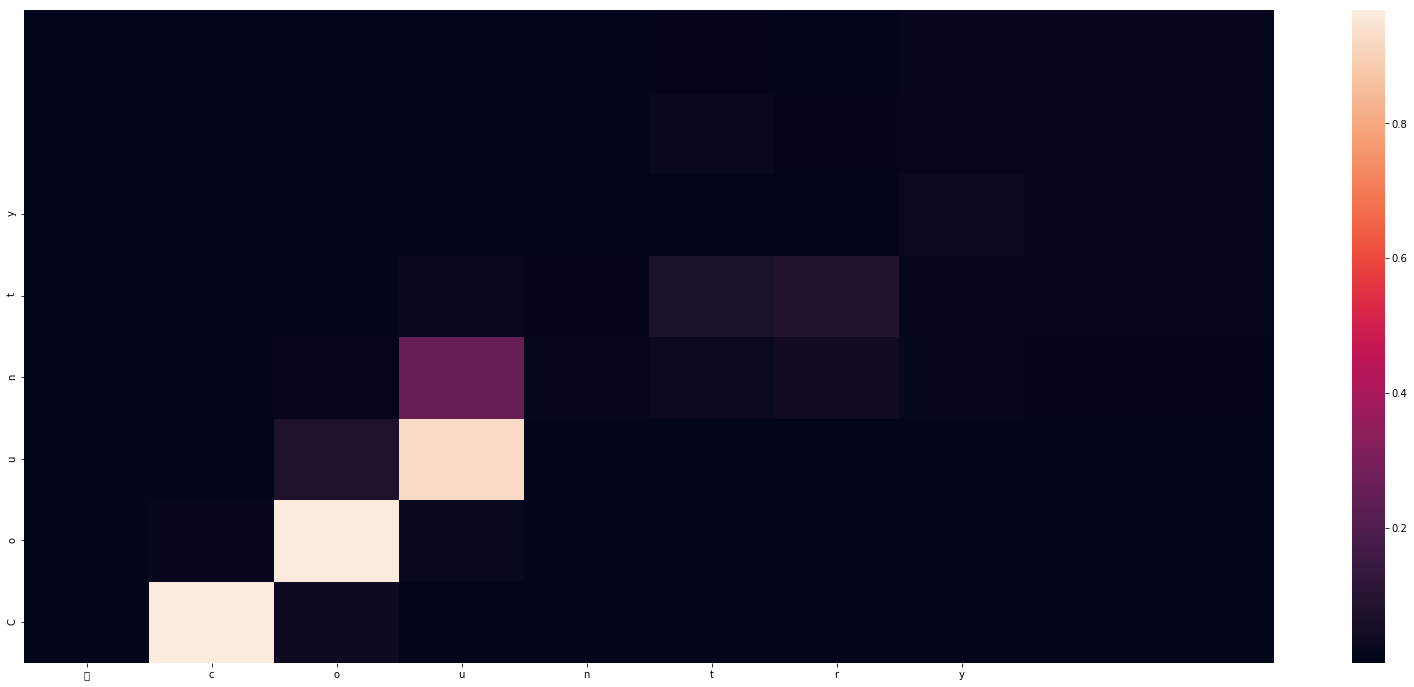

-
Input sentence: country
GT sentence: Country: US

Decoded sentence: County


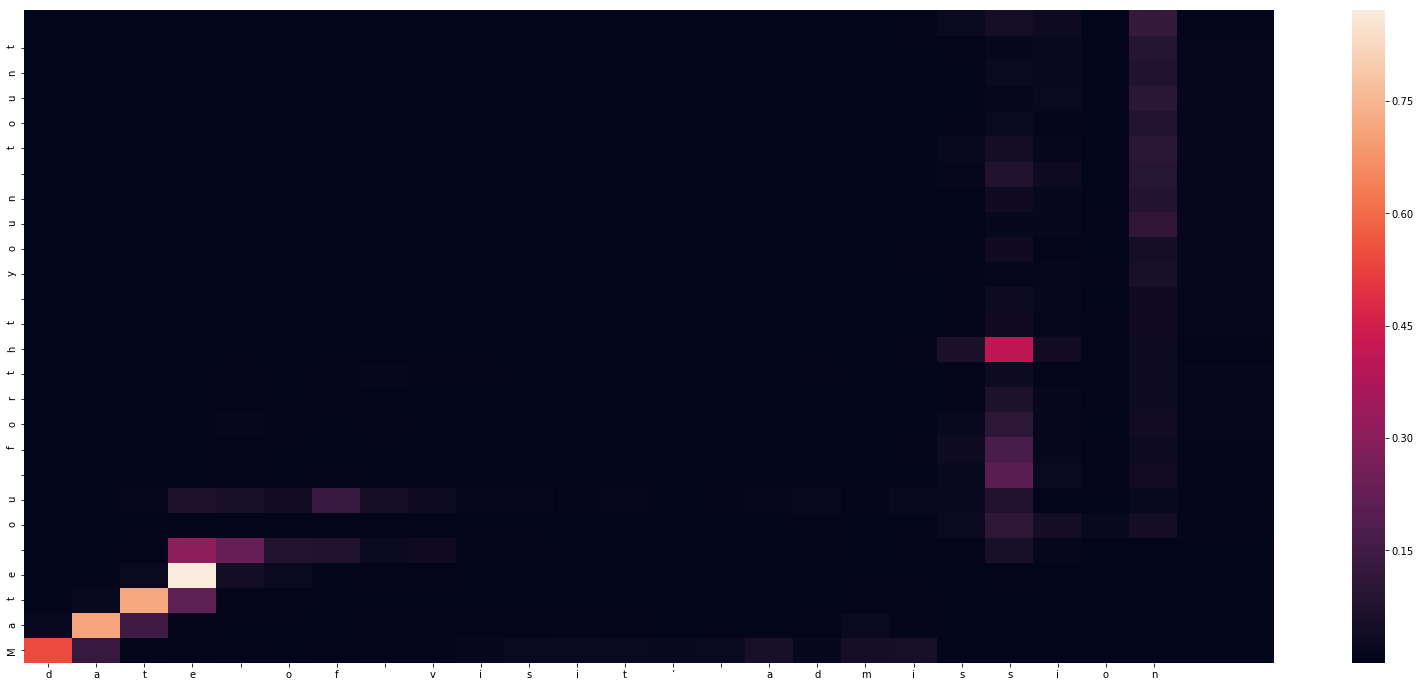

-
Input sentence: date of visit’ admission
GT sentence: Date of Visit/Admission:

Decoded sentence: Mate ou fortht youn tount


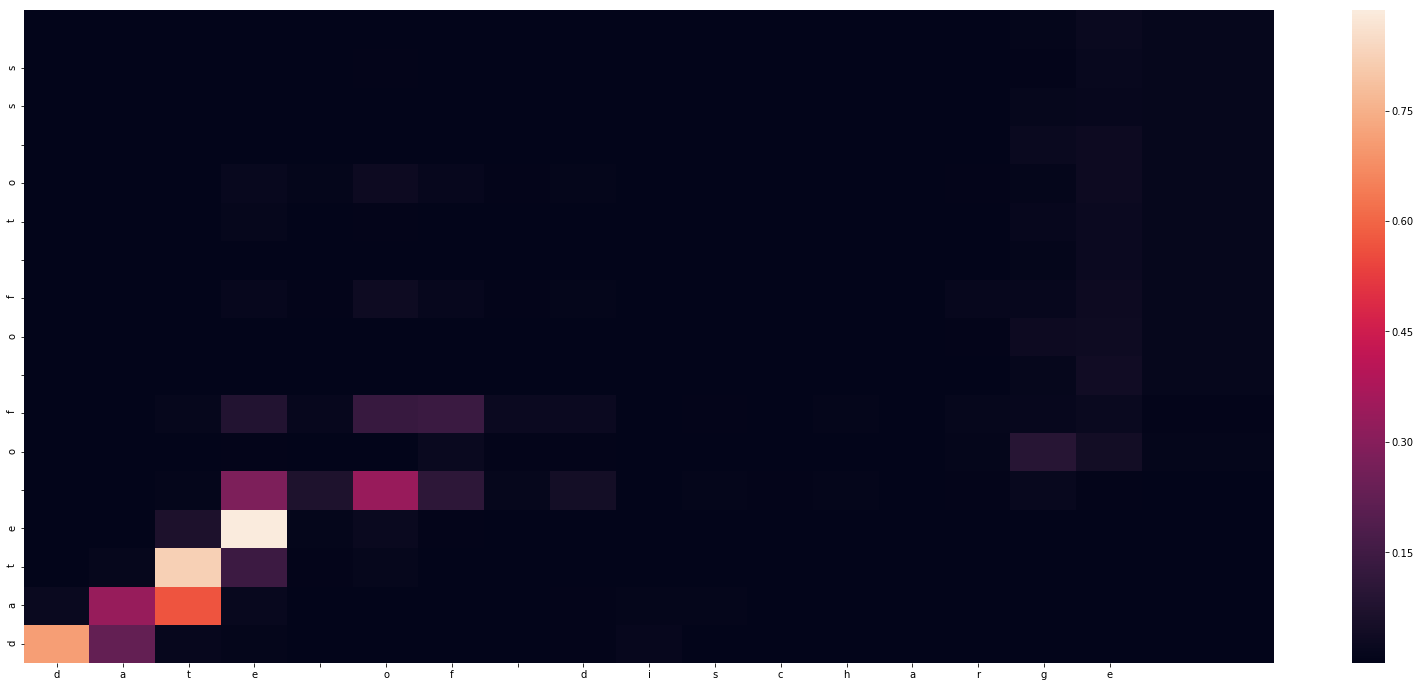

-
Input sentence: date of discharge
GT sentence: Date of Discharge:

Decoded sentence: date of of to ss


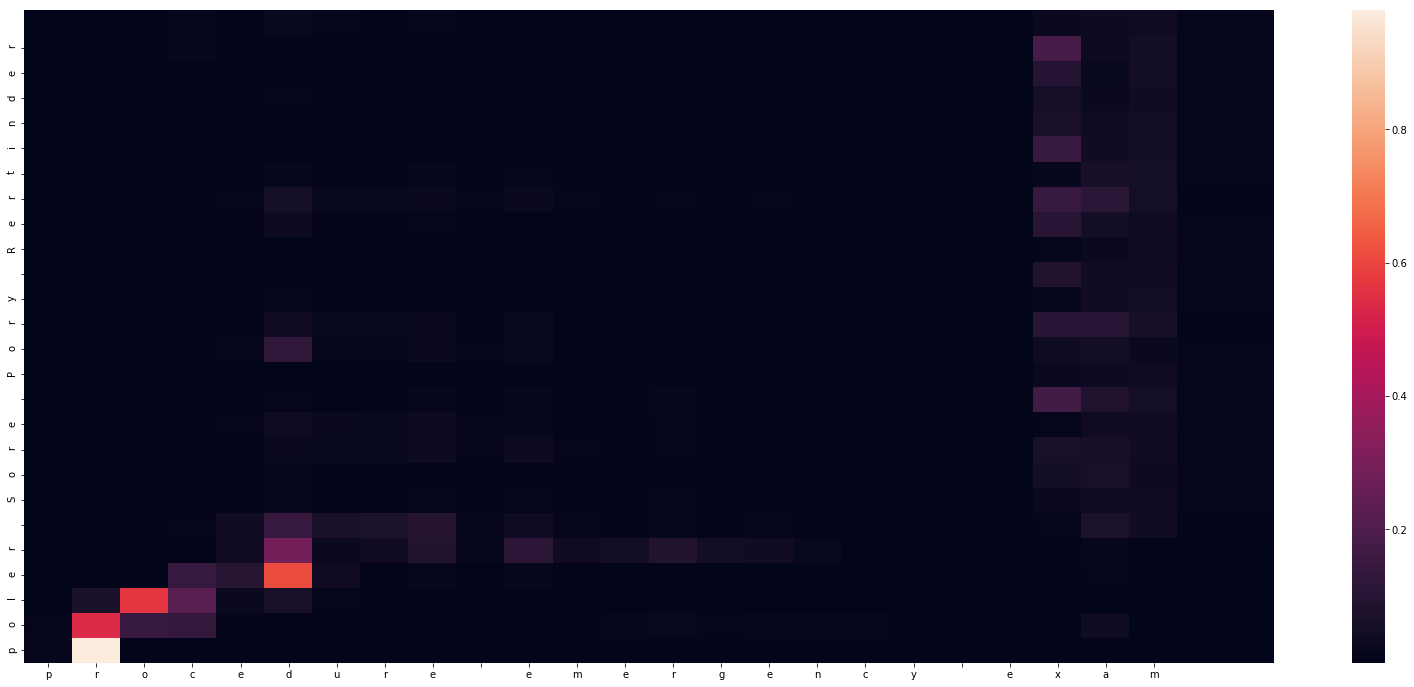

-
Input sentence: procedure emergency exam
GT sentence: Procedure: Emergency exam

Decoded sentence: poler Sore Pory Rertinder


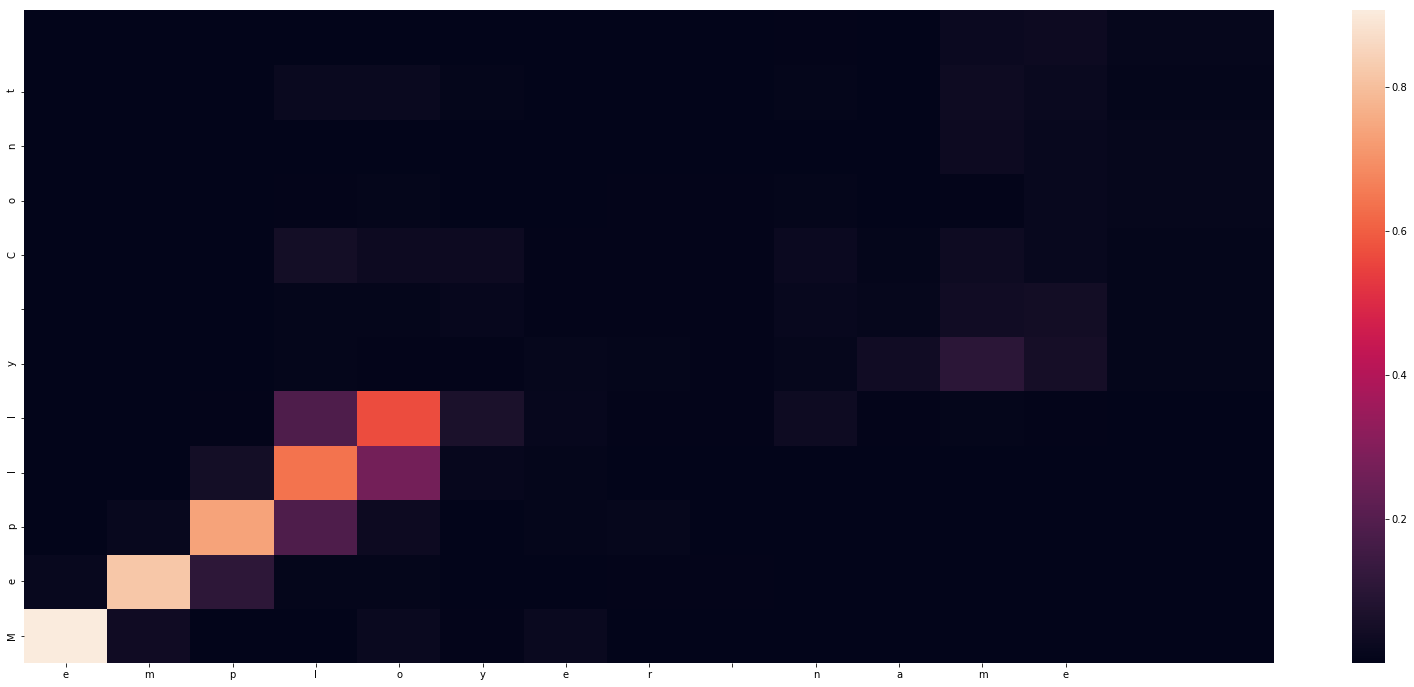

-
Input sentence: employer name
GT sentence: Employer Name:

Decoded sentence: Meplly Cont


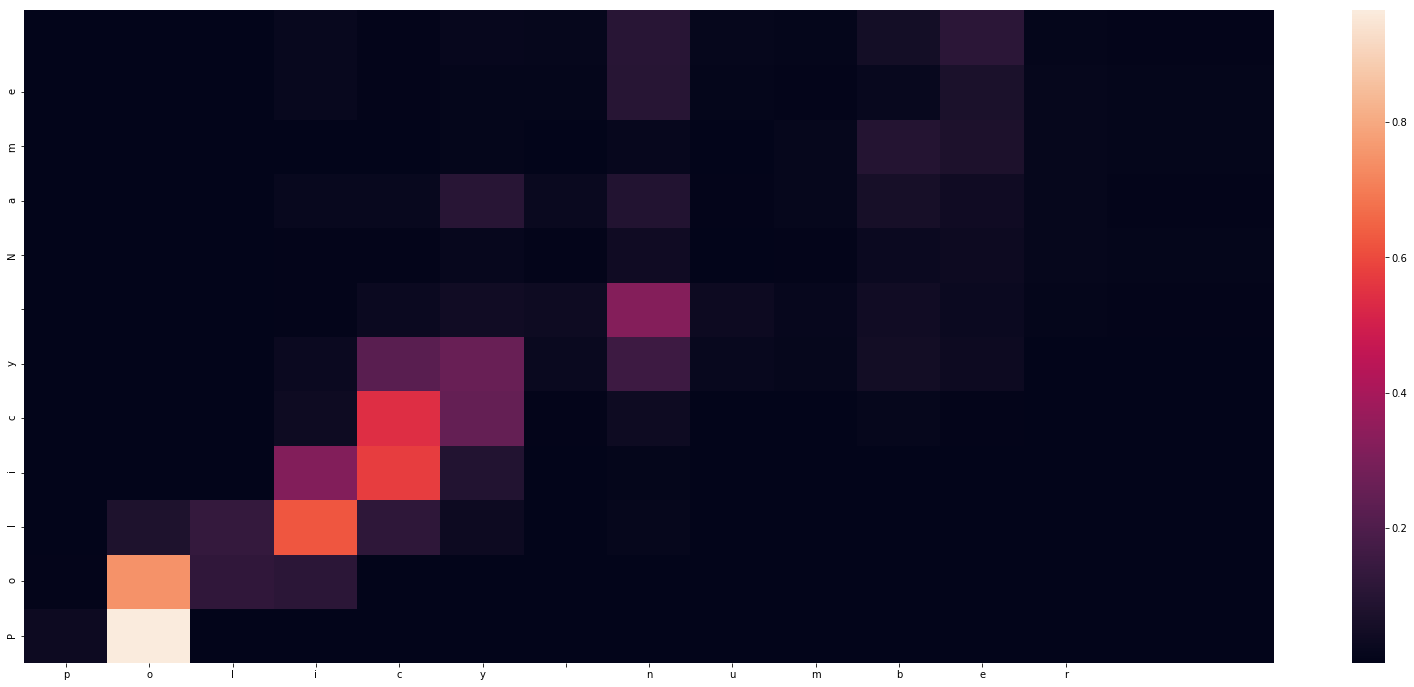

-
Input sentence: policy number
GT sentence: Policy Number:

Decoded sentence: Policy Name


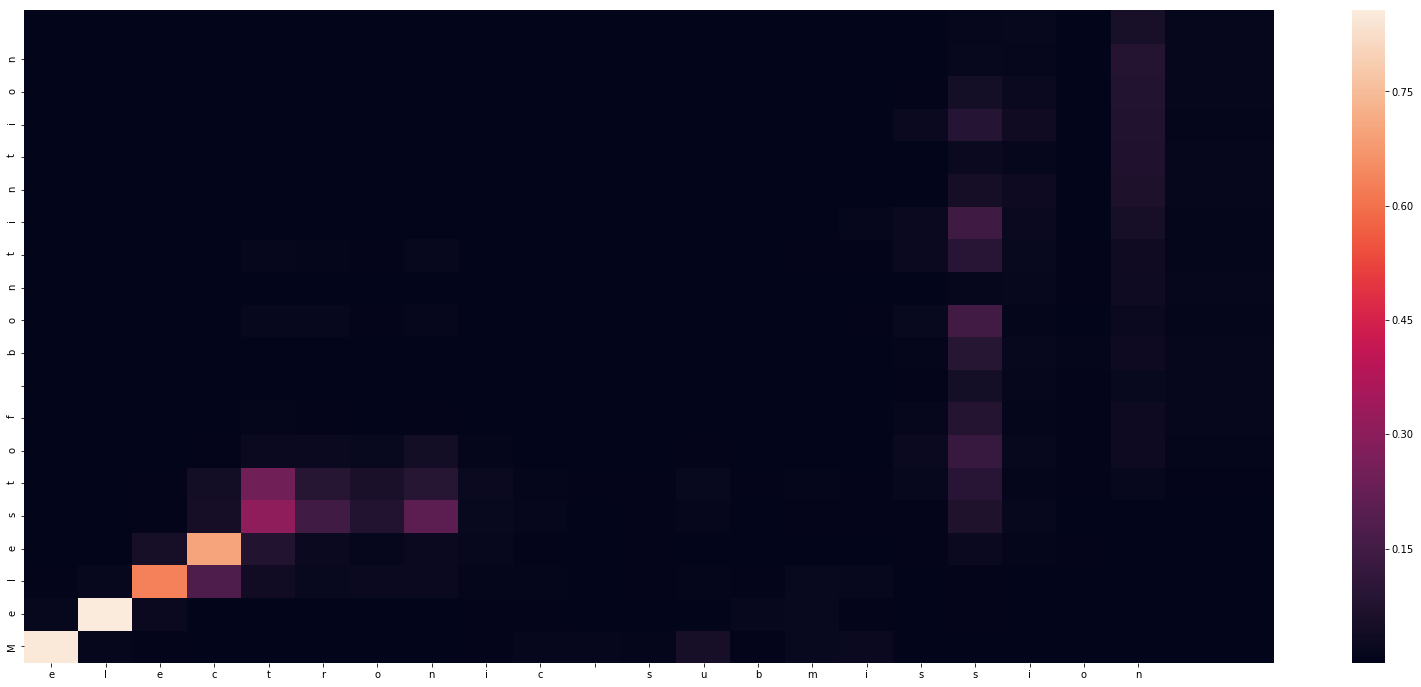

-
Input sentence: electronic submission
GT sentence: Electronic Submission

Decoded sentence: Melestof bontintion


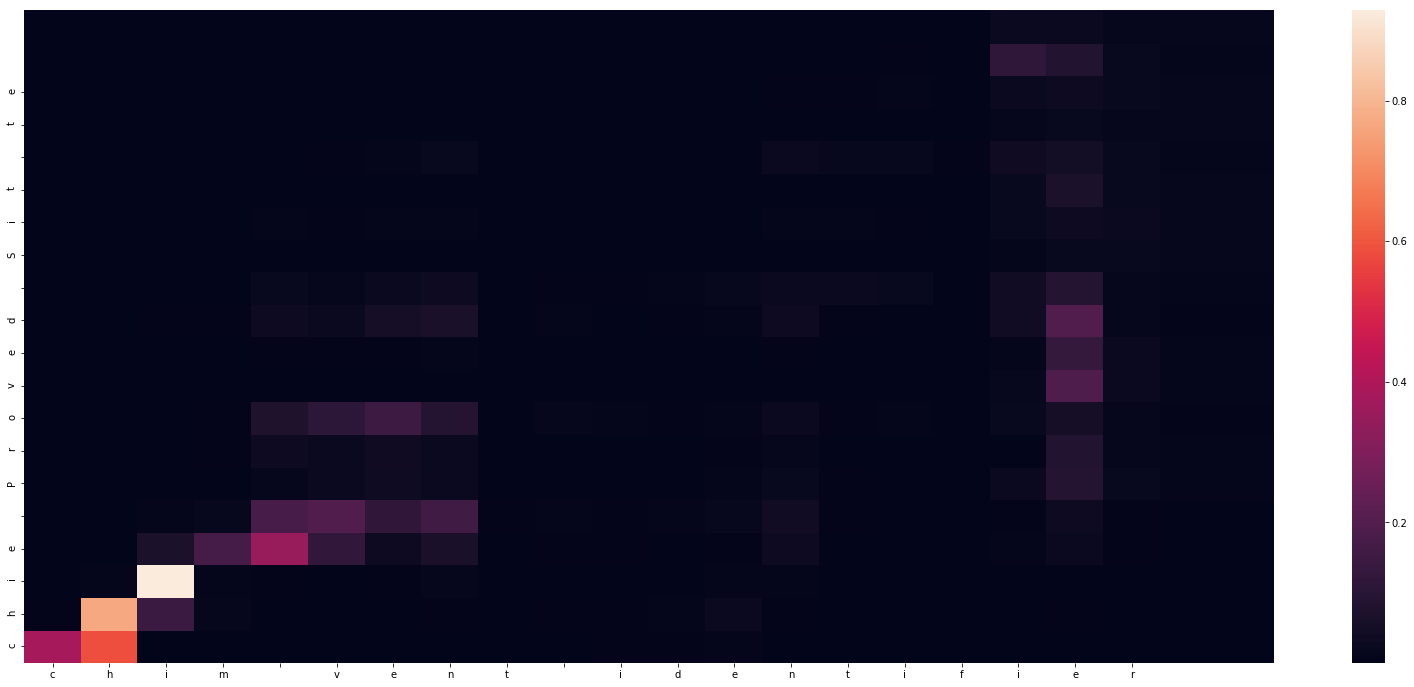

-
Input sentence: chim vent identifier
GT sentence: Claim Event Identifier:

Decoded sentence: chie Proved Sit te


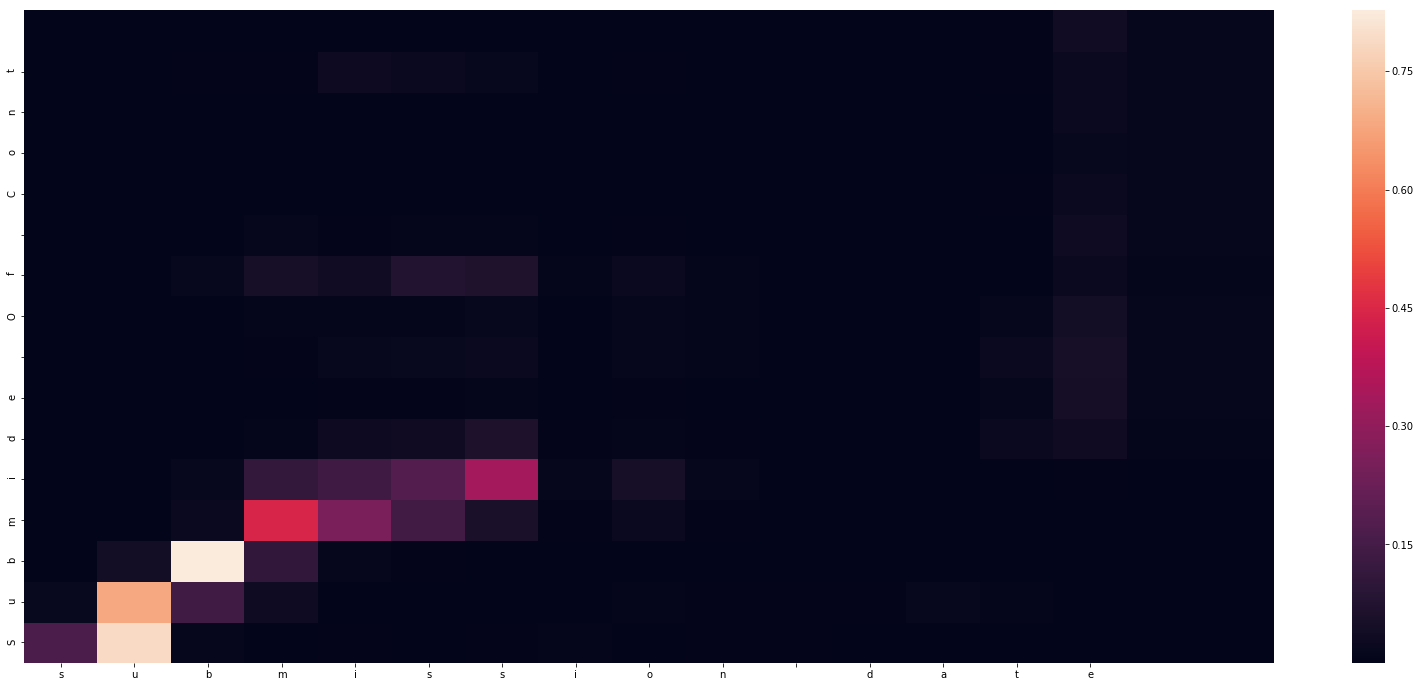

-
Input sentence: submission date
GT sentence: Submission Date:

Decoded sentence: Submide Of Cont


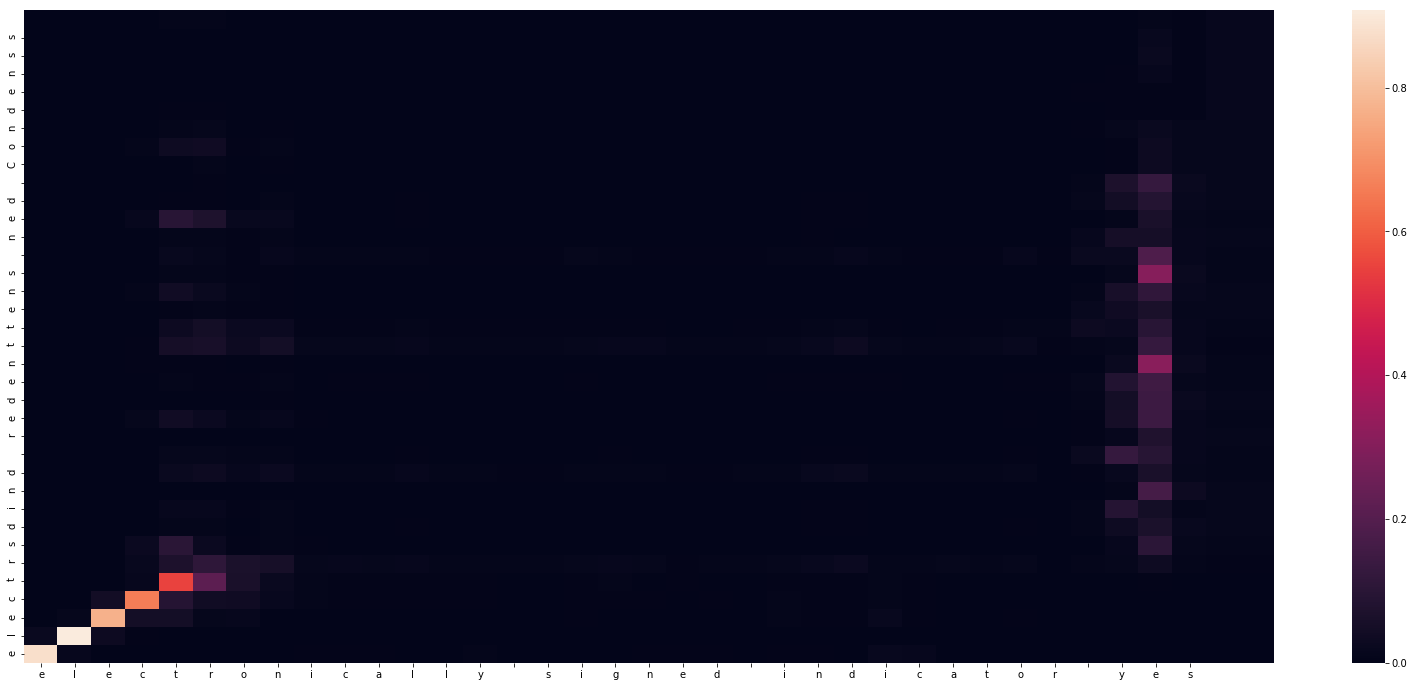

-
Input sentence: electronically signed indicator yes
GT sentence: Electronically Signed Indicator: Yes

Decoded sentence: electrsdind redenttens ned Condenss


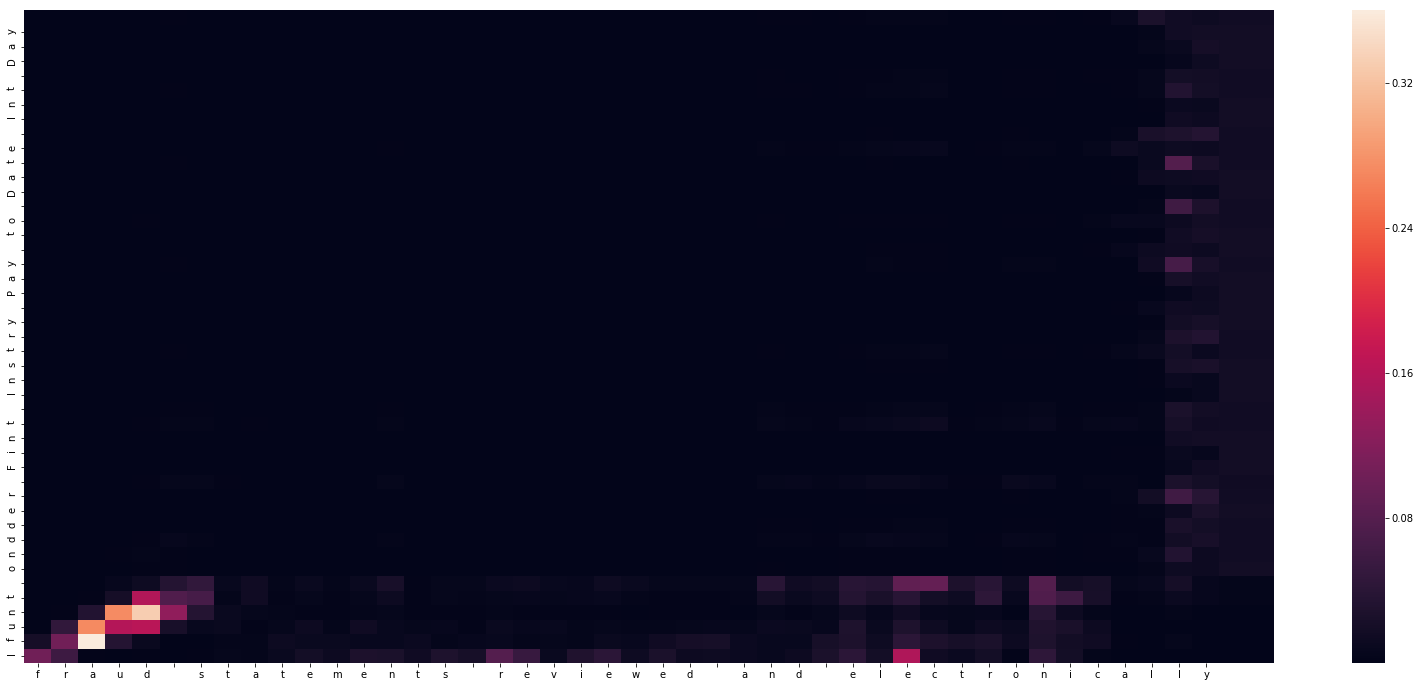

-
Input sentence: fraud statements reviewed and electronically
GT sentence: Fraud Statements Reviewed and Electronically

Decoded sentence: Ifunt ondder Fint Instry Pay to Date Int Day


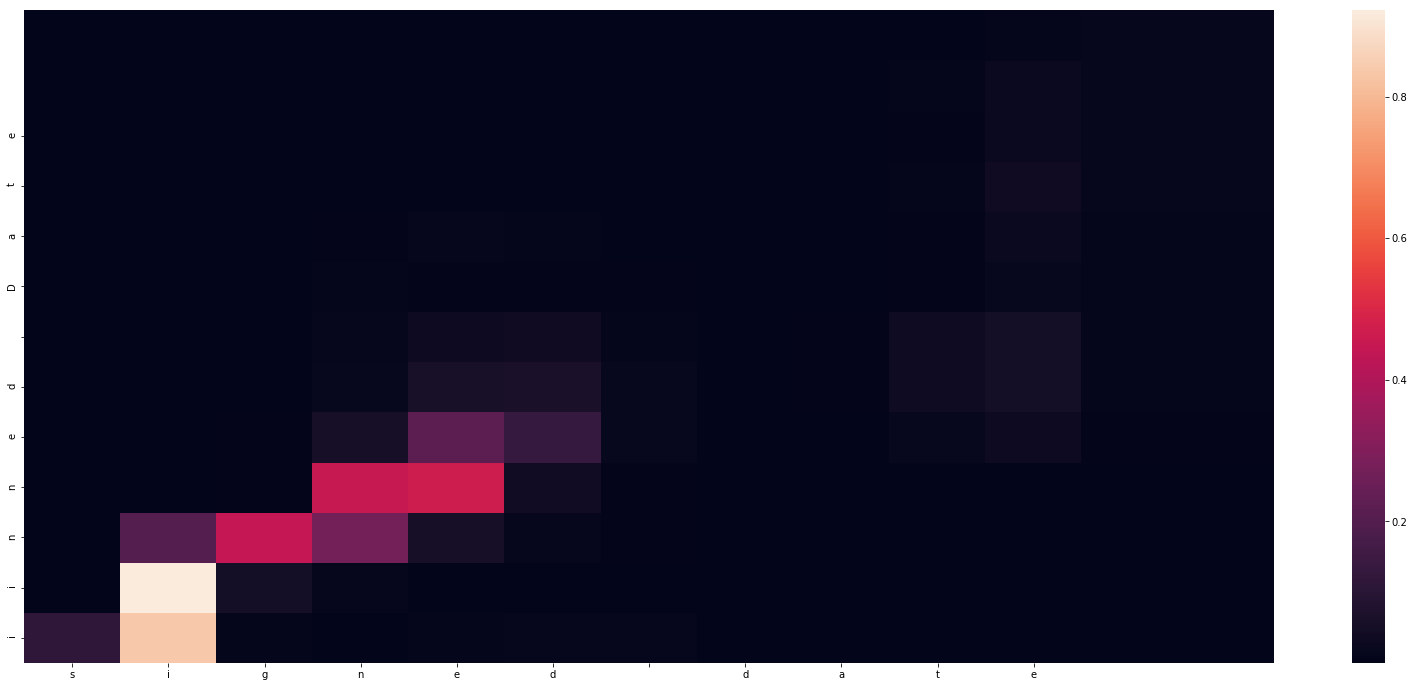

-
Input sentence: signed date
GT sentence: Signed Date:

Decoded sentence: iinned Date


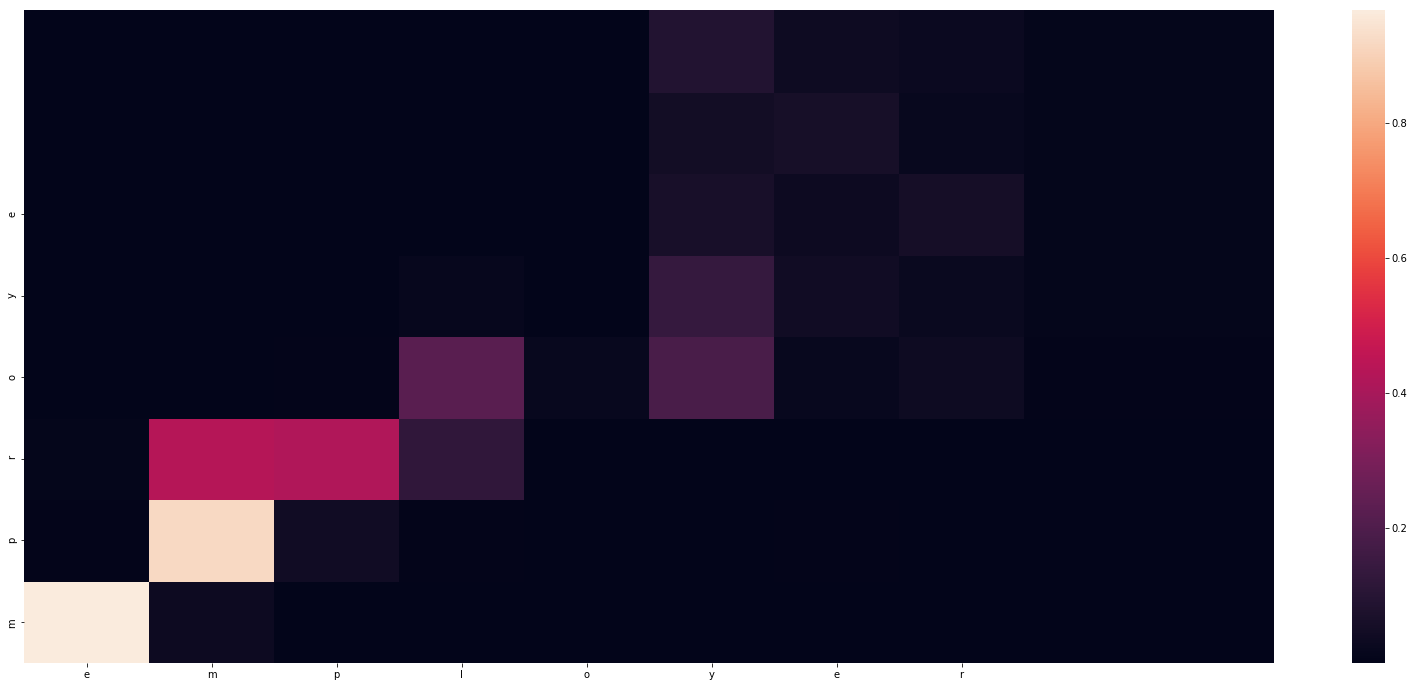

-
Input sentence: employer
GT sentence: Employer:

Decoded sentence: mproye


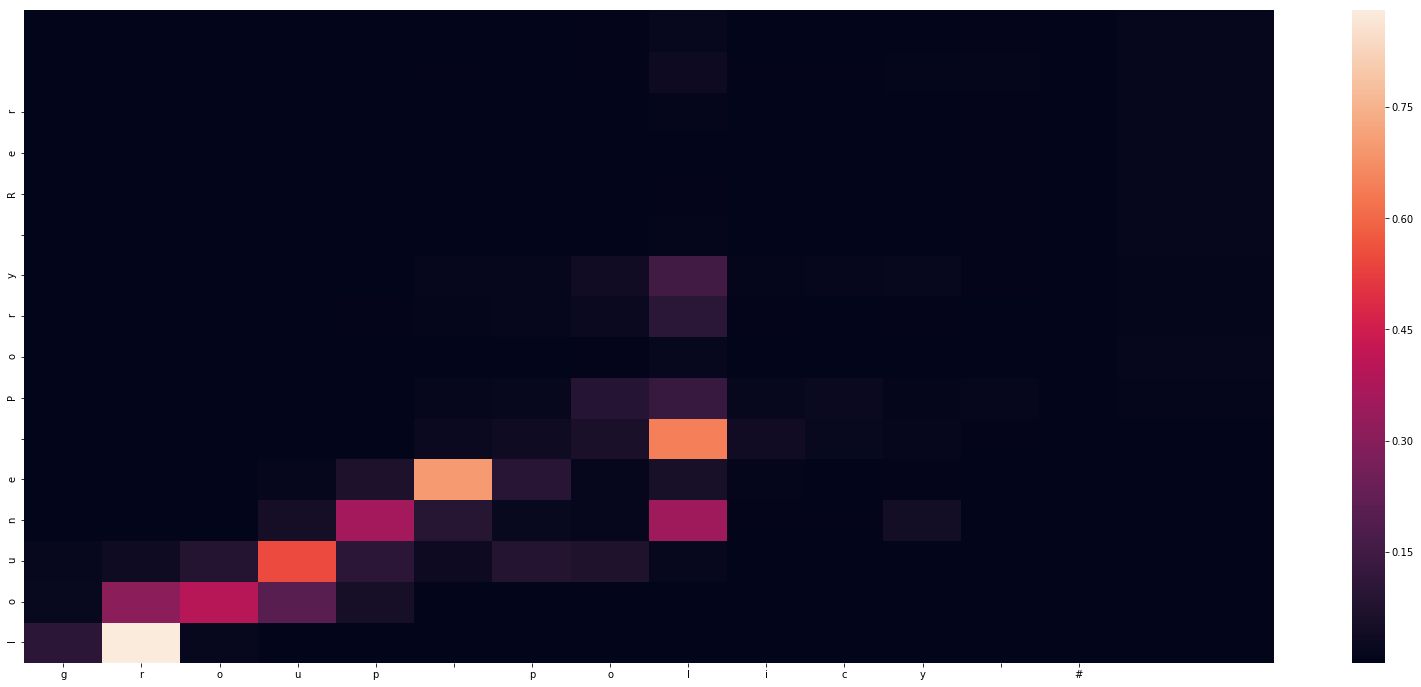

-
Input sentence: group policy #
GT sentence: Group Policy #:

Decoded sentence: Ioune Pory Rer


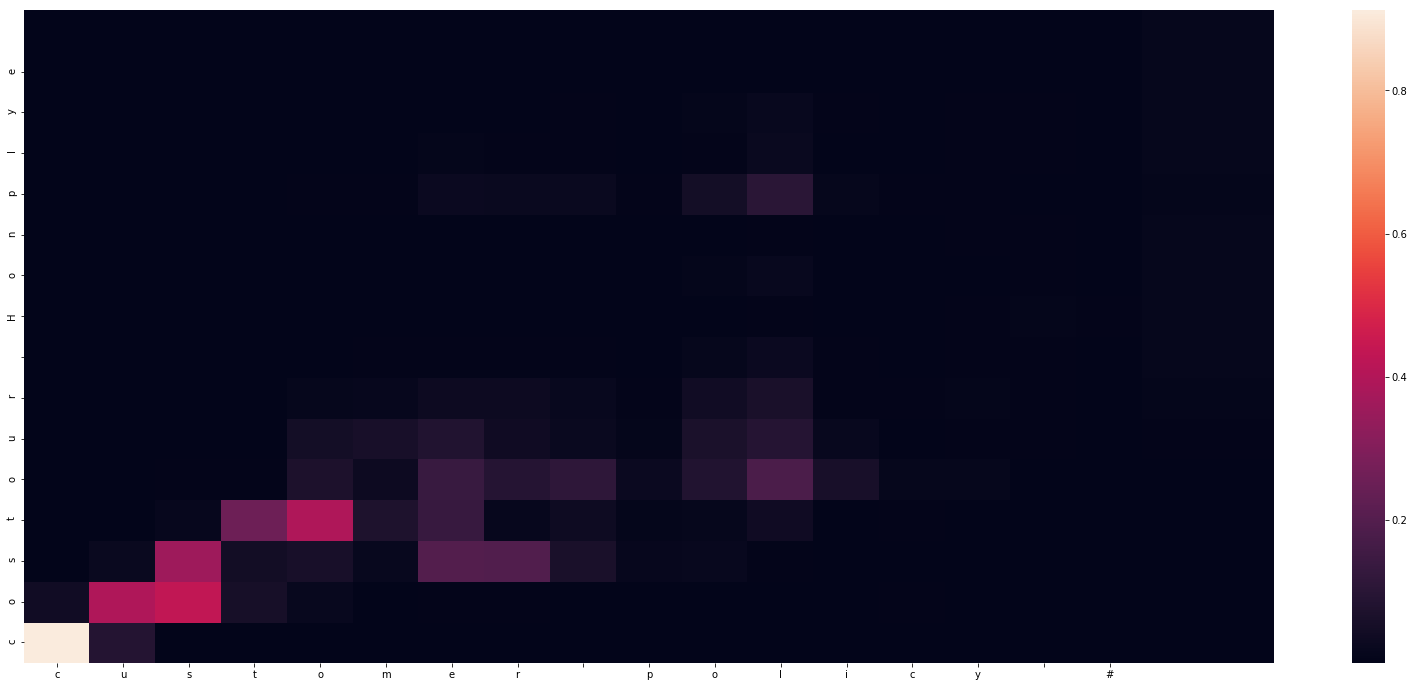

-
Input sentence: customer policy #
GT sentence: Customer Policy #:

Decoded sentence: costour Honplye


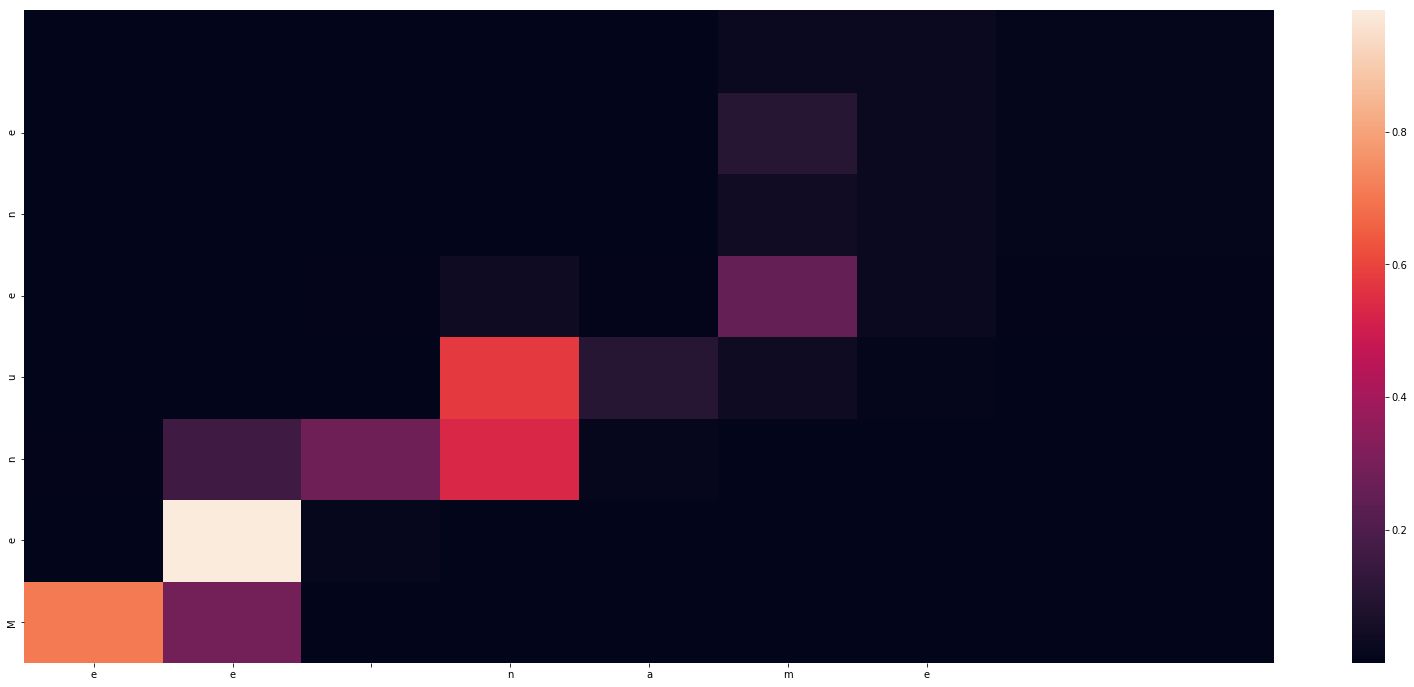

-
Input sentence: ee name
GT sentence: EE Name:

Decoded sentence: Menuene


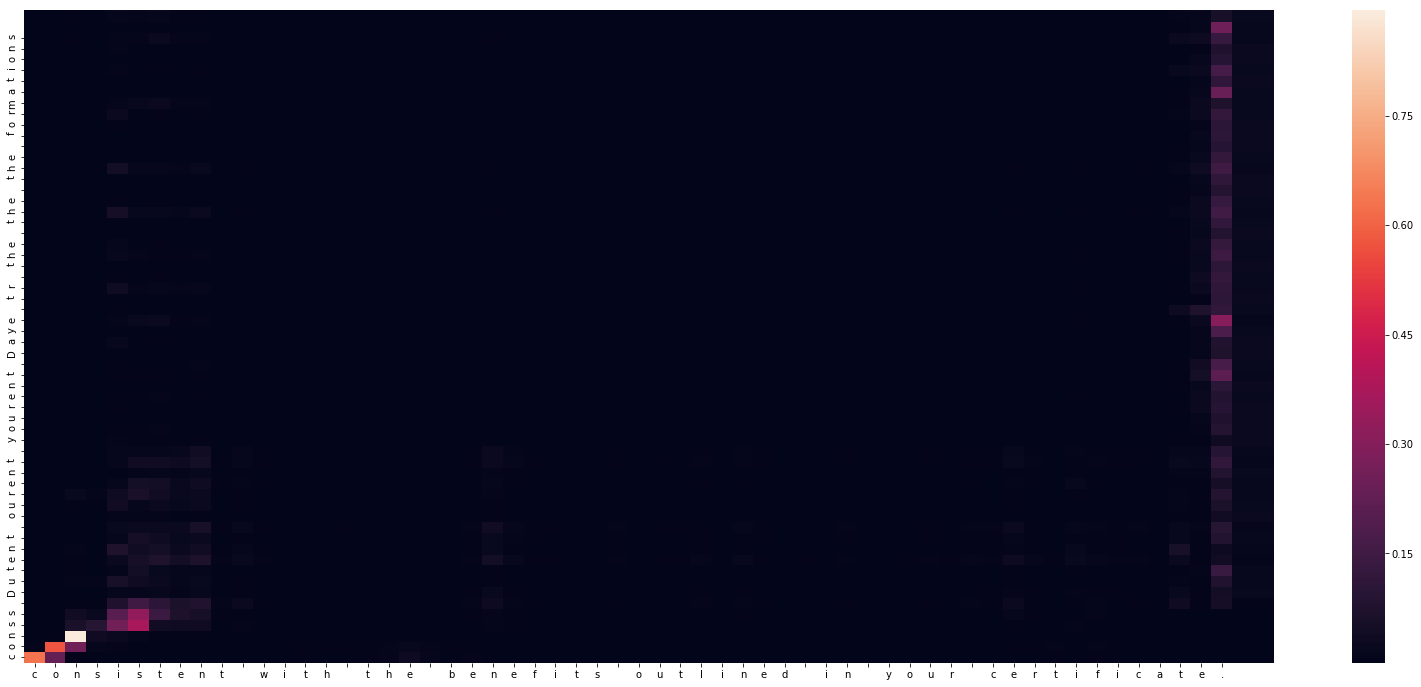

-
Input sentence: consistent with the benefits outlined in your certificate.
GT sentence: consistent with the benefits outlined in your certificate.

Decoded sentence: conss Dutent ourent yourent Daye tr the the the formations


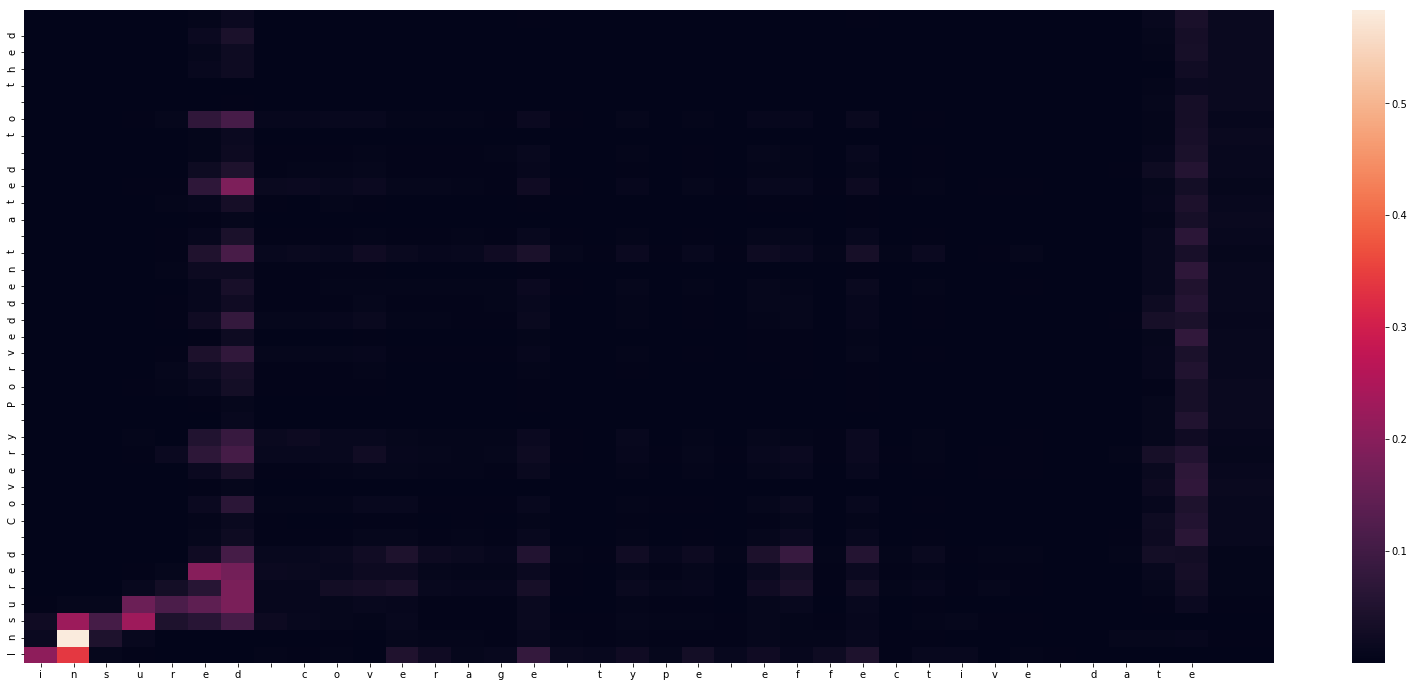

-
Input sentence: insured coverage type effective date
GT sentence: Insured Coverage Type Coverage Effective Date

Decoded sentence: Insured Covery Porveddent ated to thed


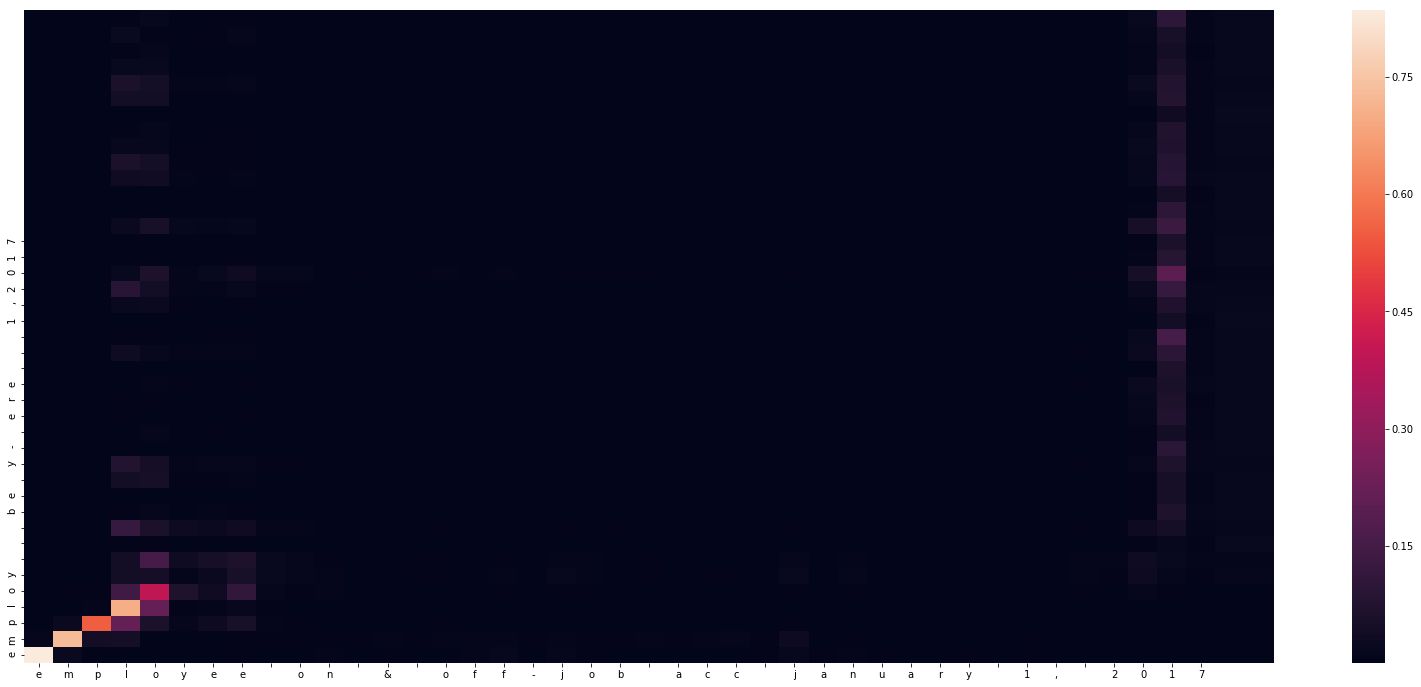

-
Input sentence: employee on & off-job acc january 1, 2017
GT sentence: Employee On & Off-Job Acc January 1, 2017

Decoded sentence: employ   be y- ere   1,2017


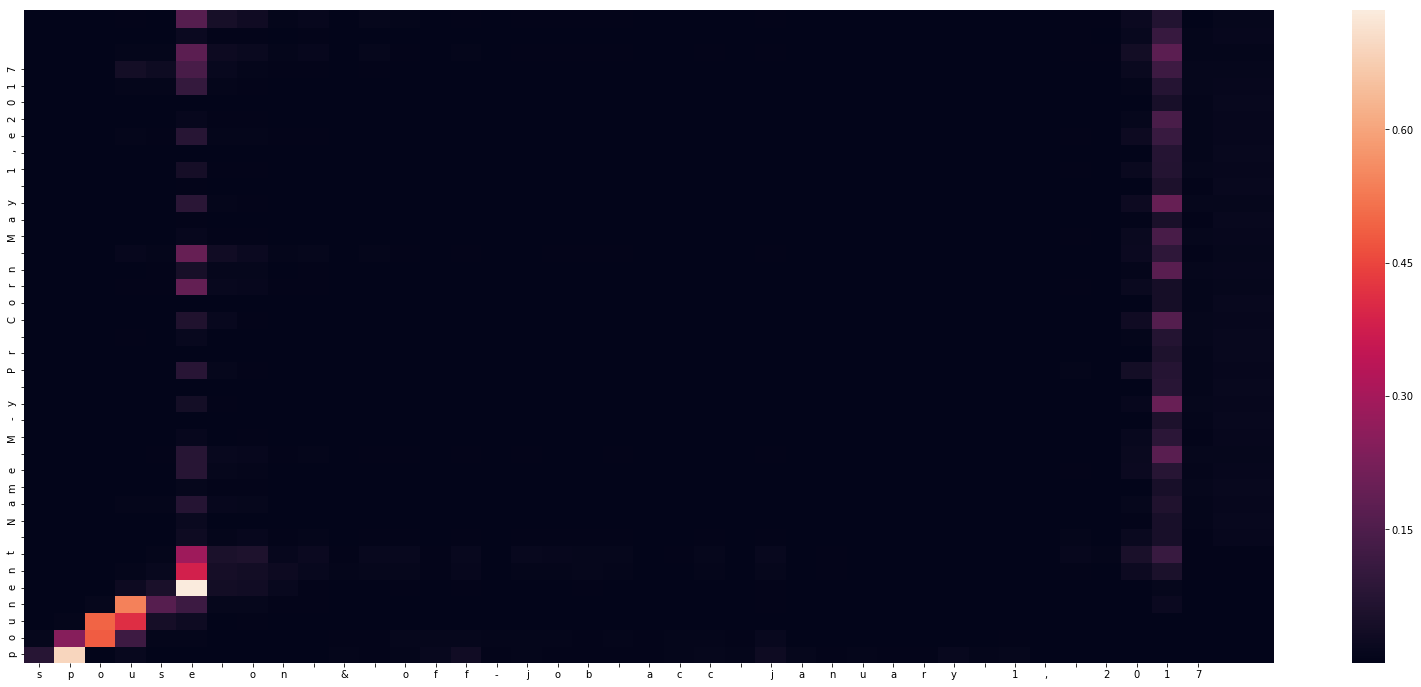

-
Input sentence: spouse on & off-job acc january 1, 2017
GT sentence: Spouse On & Off-Job Acc January 1, 2017

Decoded sentence: pounent Name M-y Pr Corn May 1,e2017


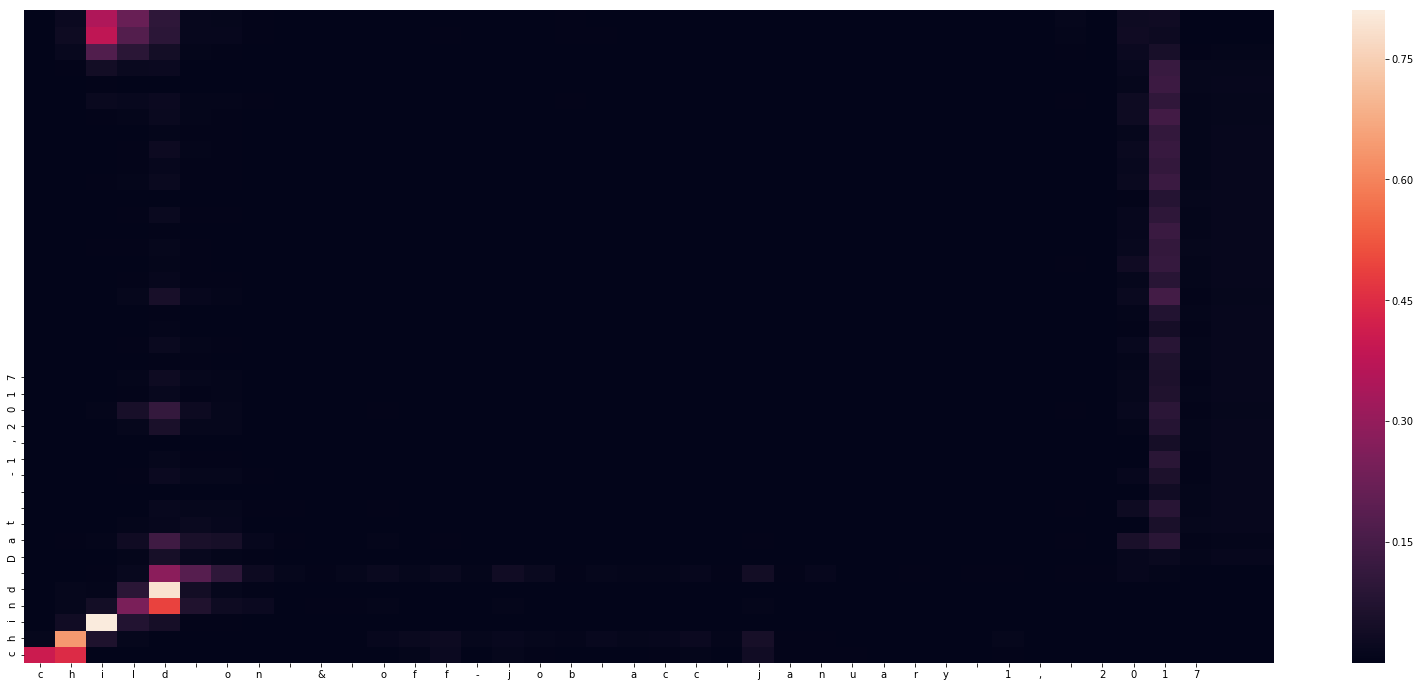

-
Input sentence: child on & off-job acc january 1, 2017
GT sentence: Child On & Off-Job Acc January 1, 2017

Decoded sentence: chind Dat  -1,2017


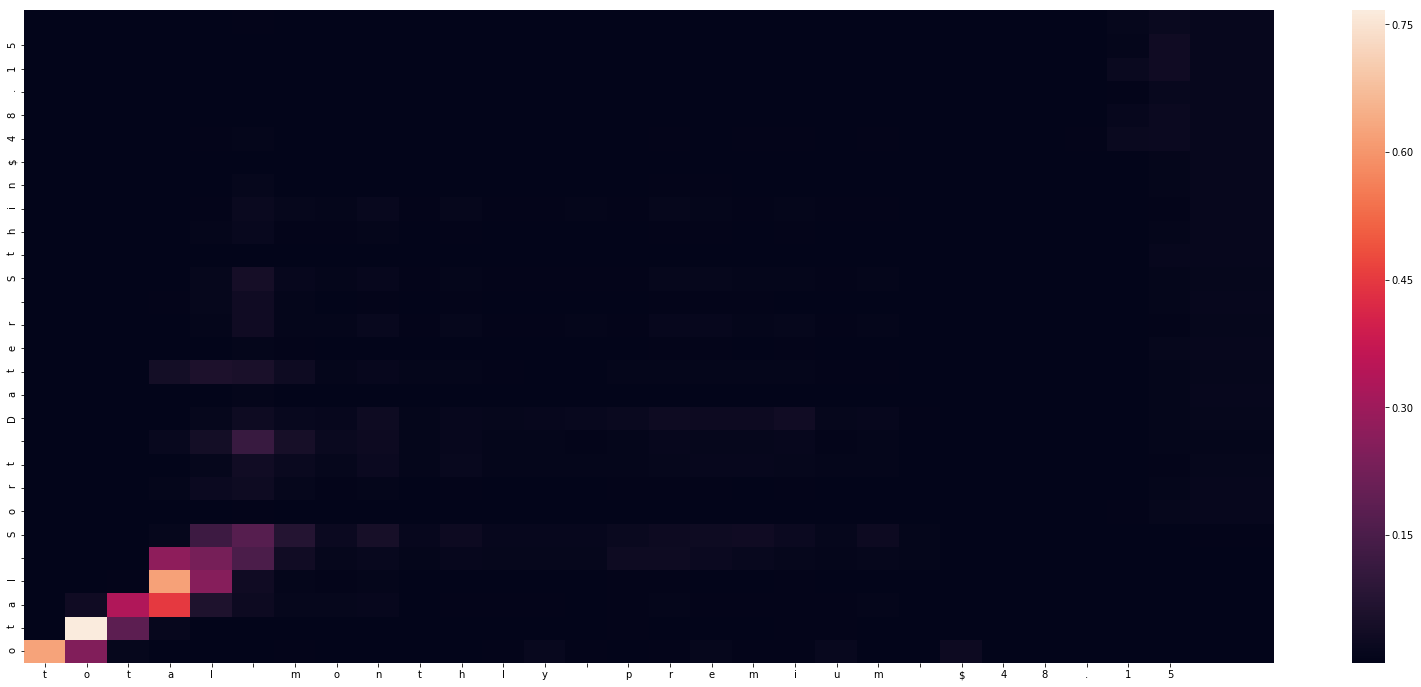

-
Input sentence: total monthly premium $48.15
GT sentence: Total Monthly Premium $48.15

Decoded sentence: otal Sort Dater Sthin$48.15


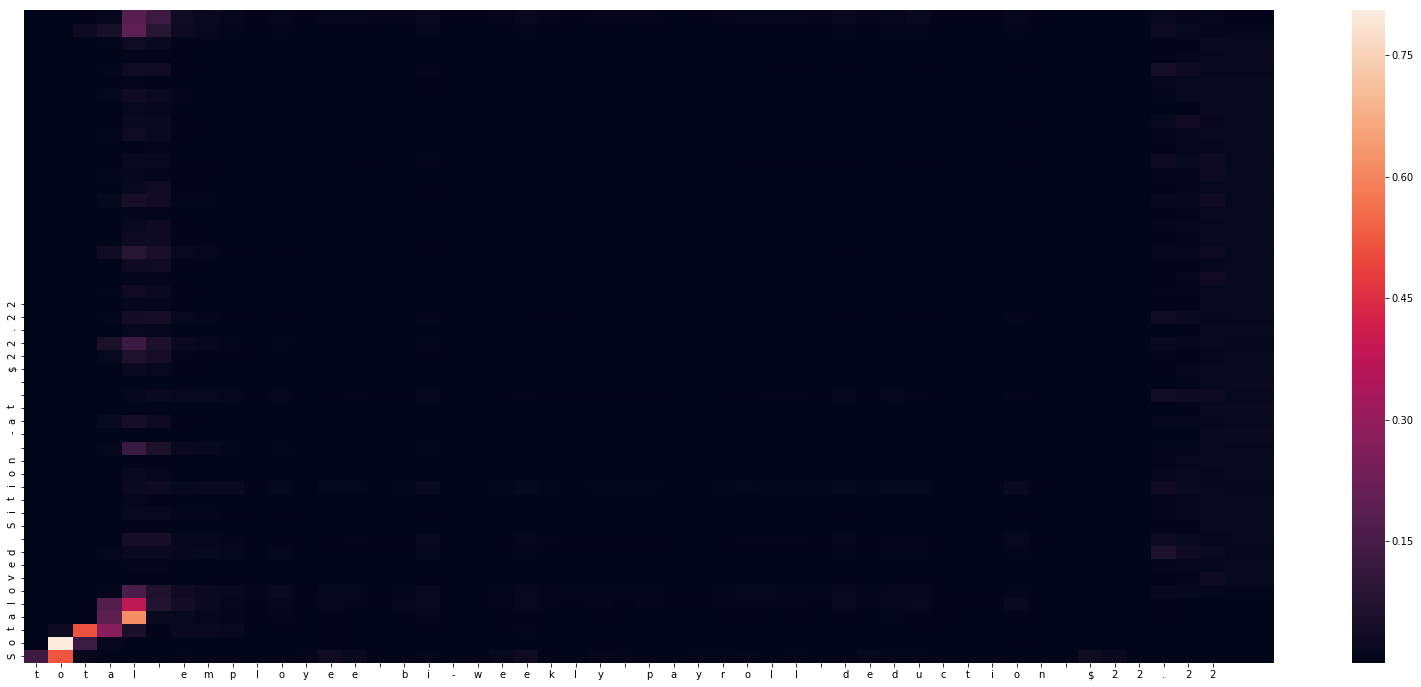

-
Input sentence: total employee bi-weekly payroll deduction $22.22
GT sentence: Total Employee Bi-Weekly Payroll Deduction: $22.22

Decoded sentence: Sotaloved Sition -at  $22.22


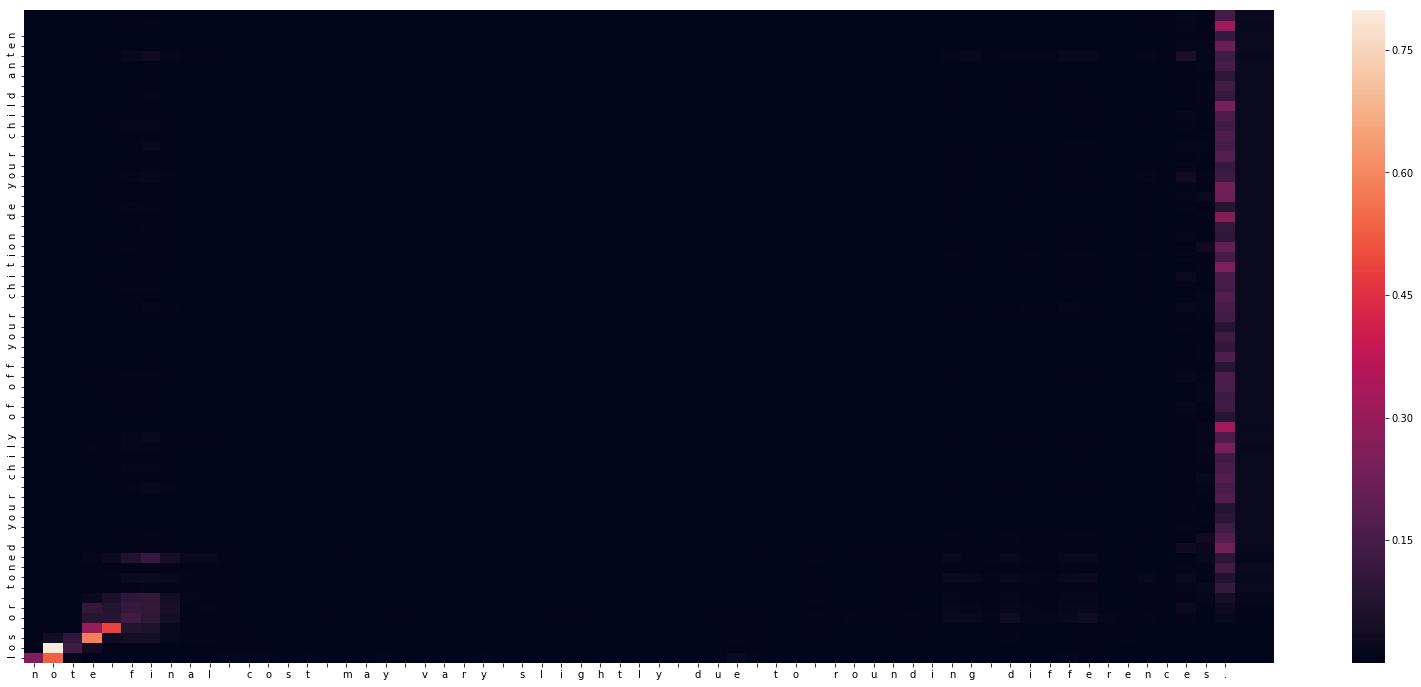

-
Input sentence: note final cost may vary slightly due to rounding differences.
GT sentence: Note: Final cost may vary slightly due to rounding differences.

Decoded sentence: Ios or toned your chily of off your chition de your child anten


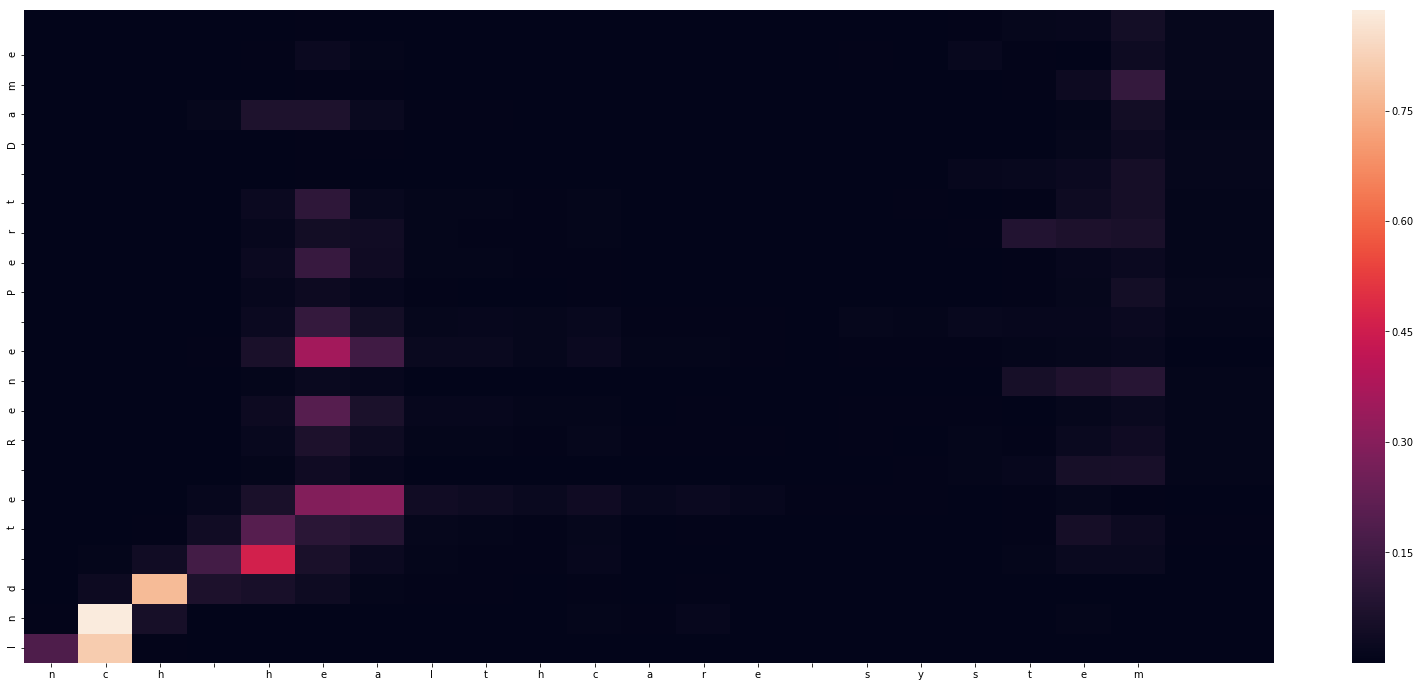

-
Input sentence: nch healthcare system
GT sentence: NCH Healthcare System

Decoded sentence: Ind te Rene Pert Dame


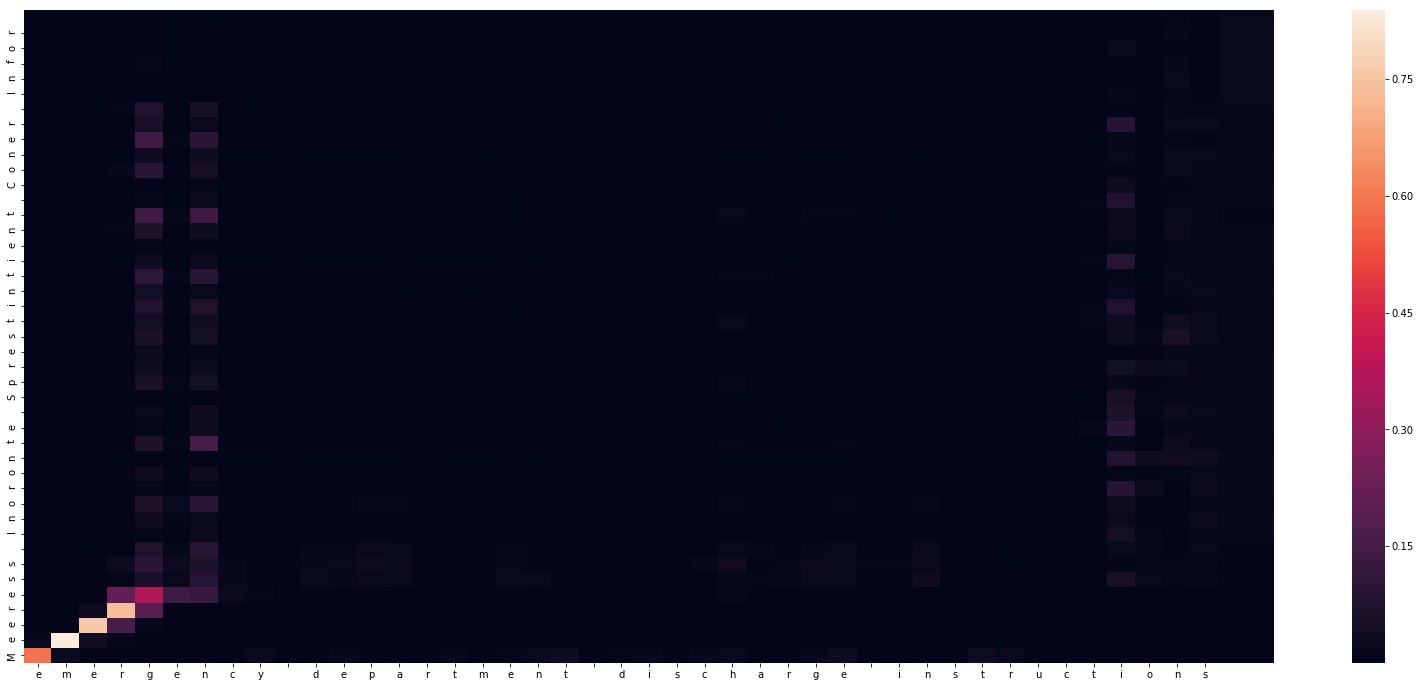

-
Input sentence: emergency department discharge instructions
GT sentence: Emergency Department Discharge Instructions

Decoded sentence: Meeress Inoronte Sprestintient Coner Infor


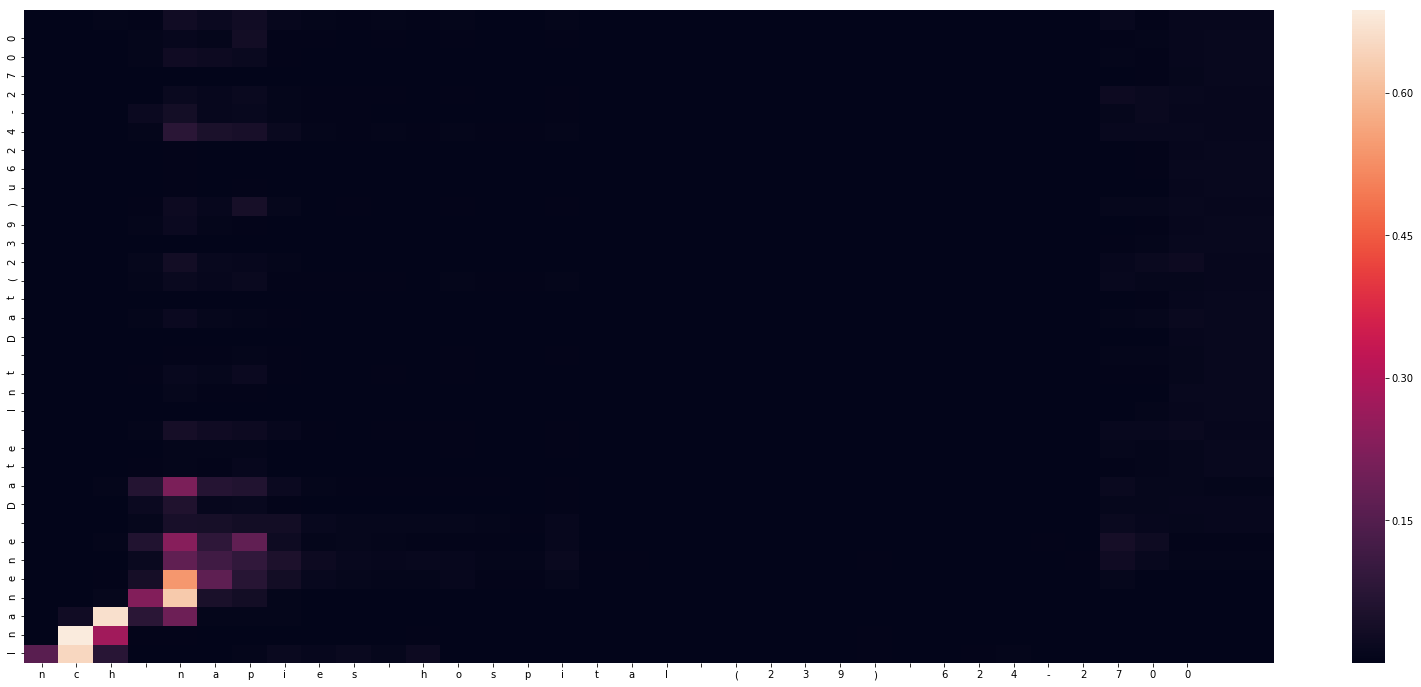

-
Input sentence: nch napies hospital (239) 624-2700
GT sentence: NCH Napies Hospital (239) 624-2700

Decoded sentence: Inanene Date Int Dat(239)u624-2700


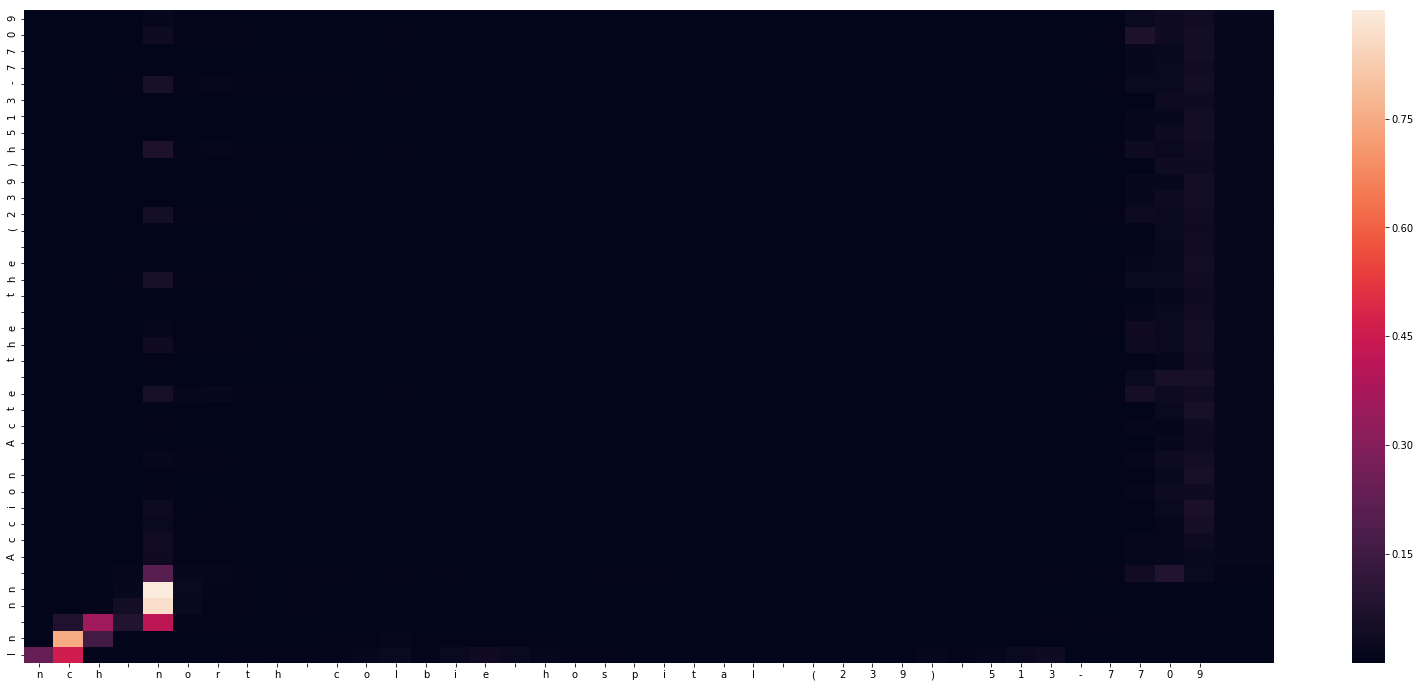

-
Input sentence: nch north colbie hospital (239) 513-7709
GT sentence: NCH North Collier Hospital (239) 513-7709

Decoded sentence: In nn Accion Acte the the (239)h513-7709


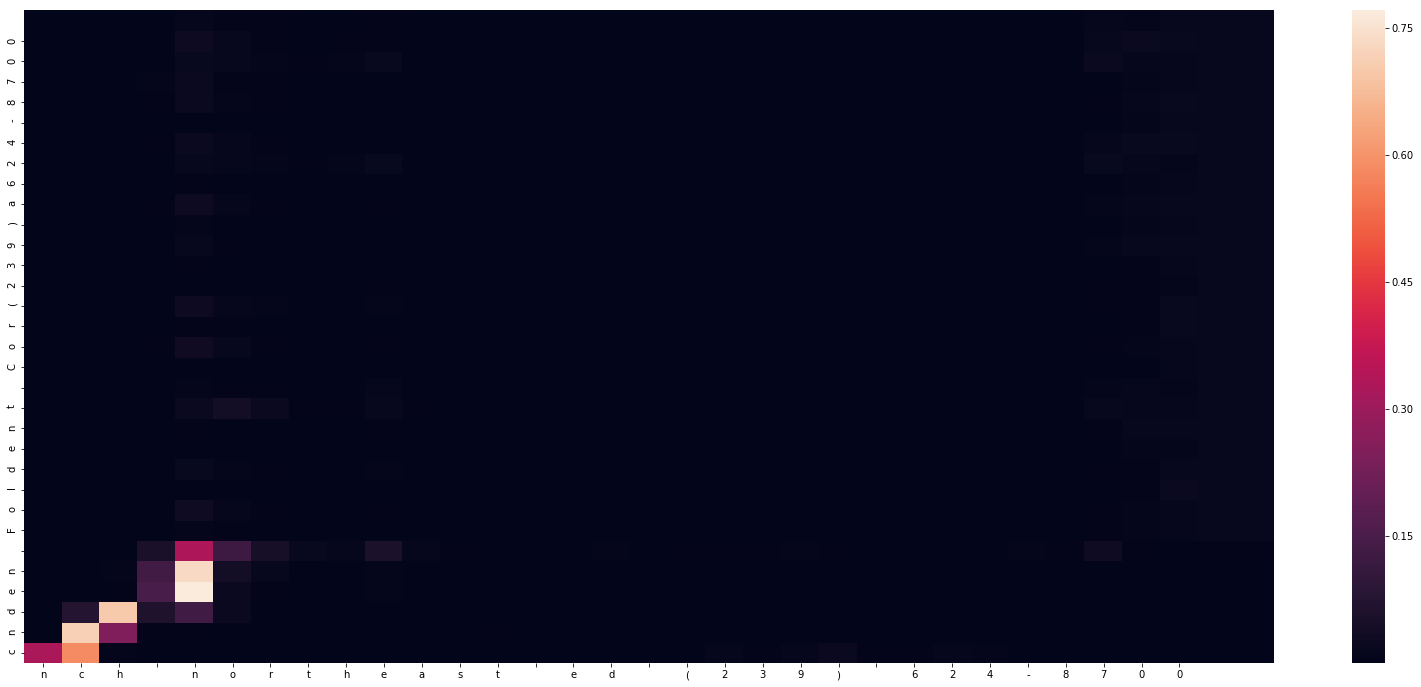

-
Input sentence: nch northeast ed (239) 624-8700
GT sentence: NCH Northeast ED (239) 624-8700

Decoded sentence: cnden Foldent Cor(239)a624-8700


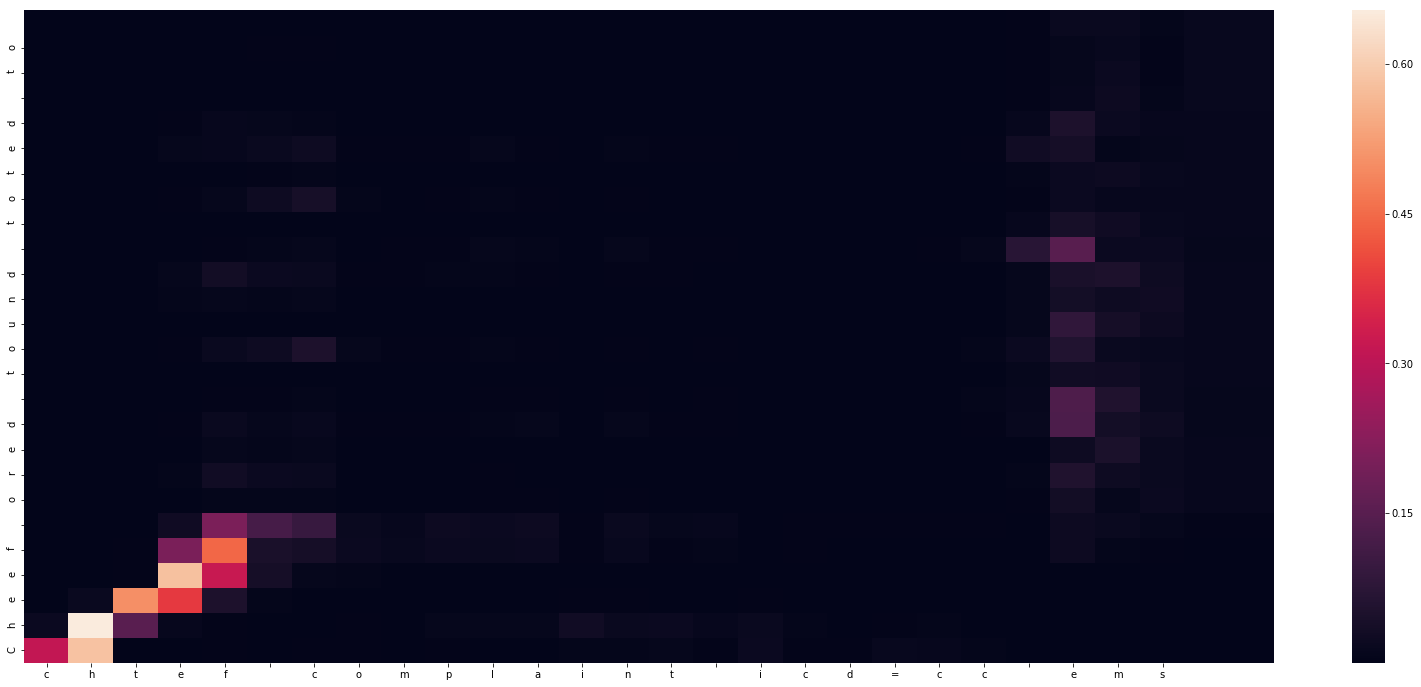

-
Input sentence: chtef complaint icd=cc ems
GT sentence: Chief Complaint: ICD=CC EMS

Decoded sentence: Cheef ored tound toted to


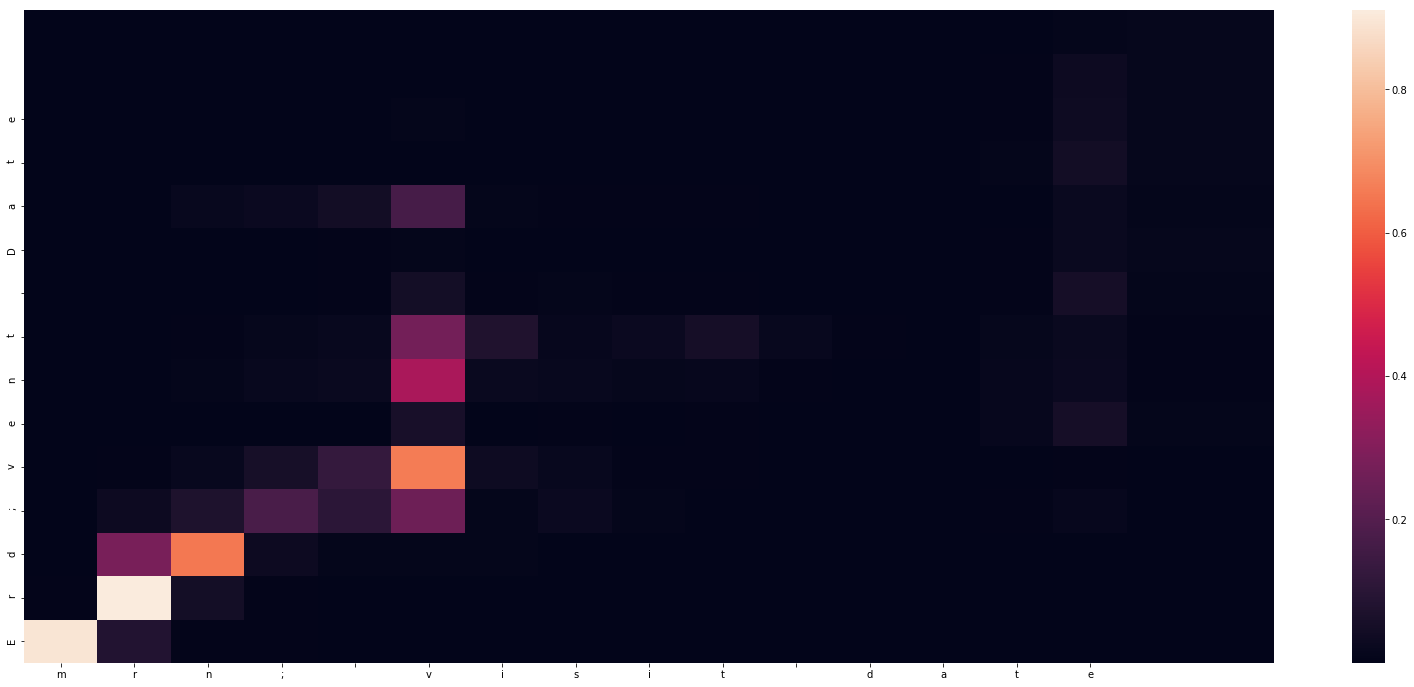

-
Input sentence: mrn; visit date
GT sentence: MRN: Visit Date:

Decoded sentence: Erd;vent Date


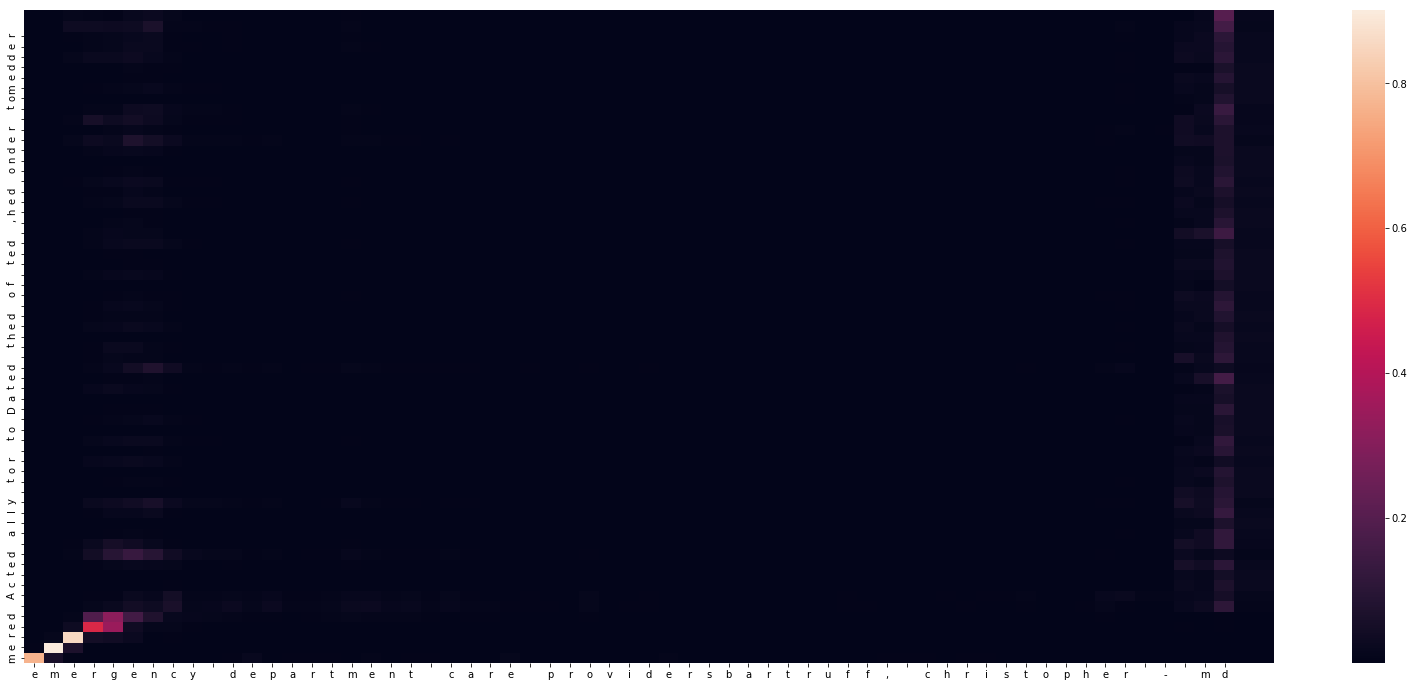

-
Input sentence: emergency department care providersbartruff, christopher - md
GT sentence: Emergency Department Care Providers: Bartruff, Christopher - MD

Decoded sentence: mered Acted ally tor to Dated thed of ted ,hed onder tomedder


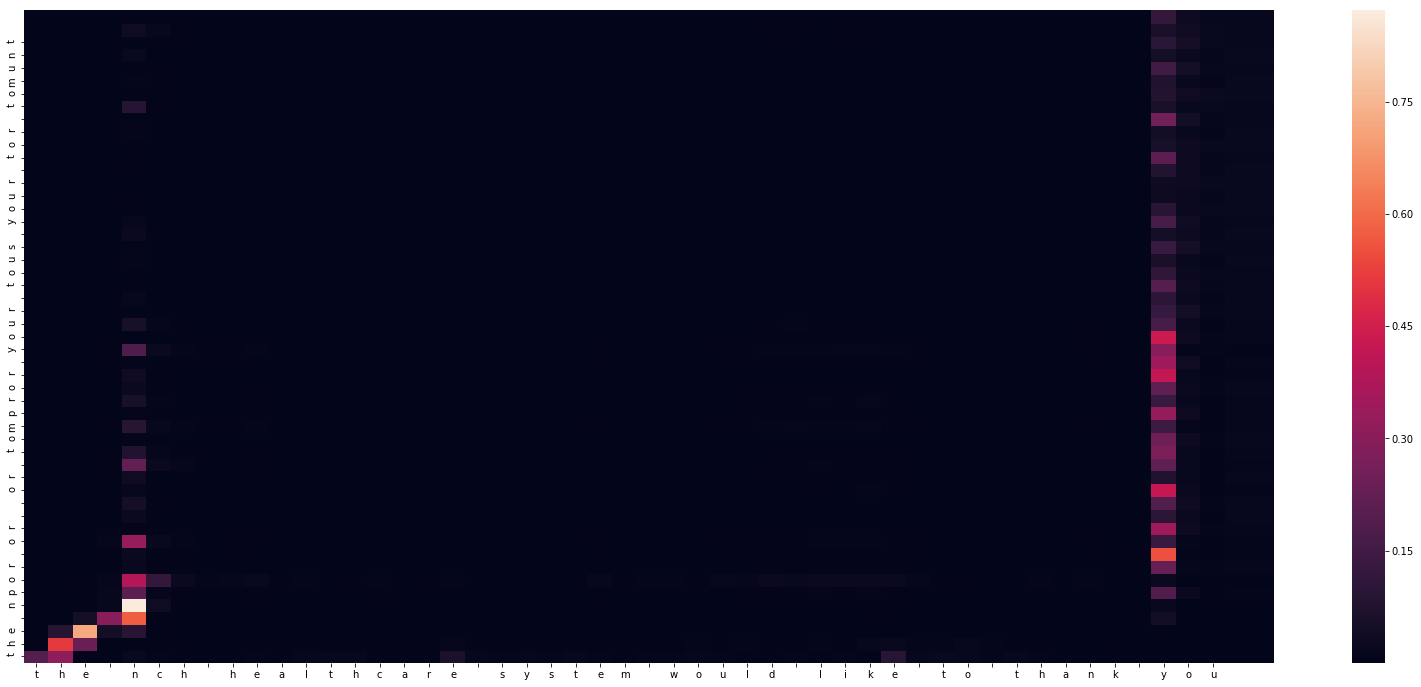

-
Input sentence: the nch healthcare system would like to thank you
GT sentence: The NCH Healthcare System would like to thank you

Decoded sentence: the npor or  or tompror your tous your tor tomunt


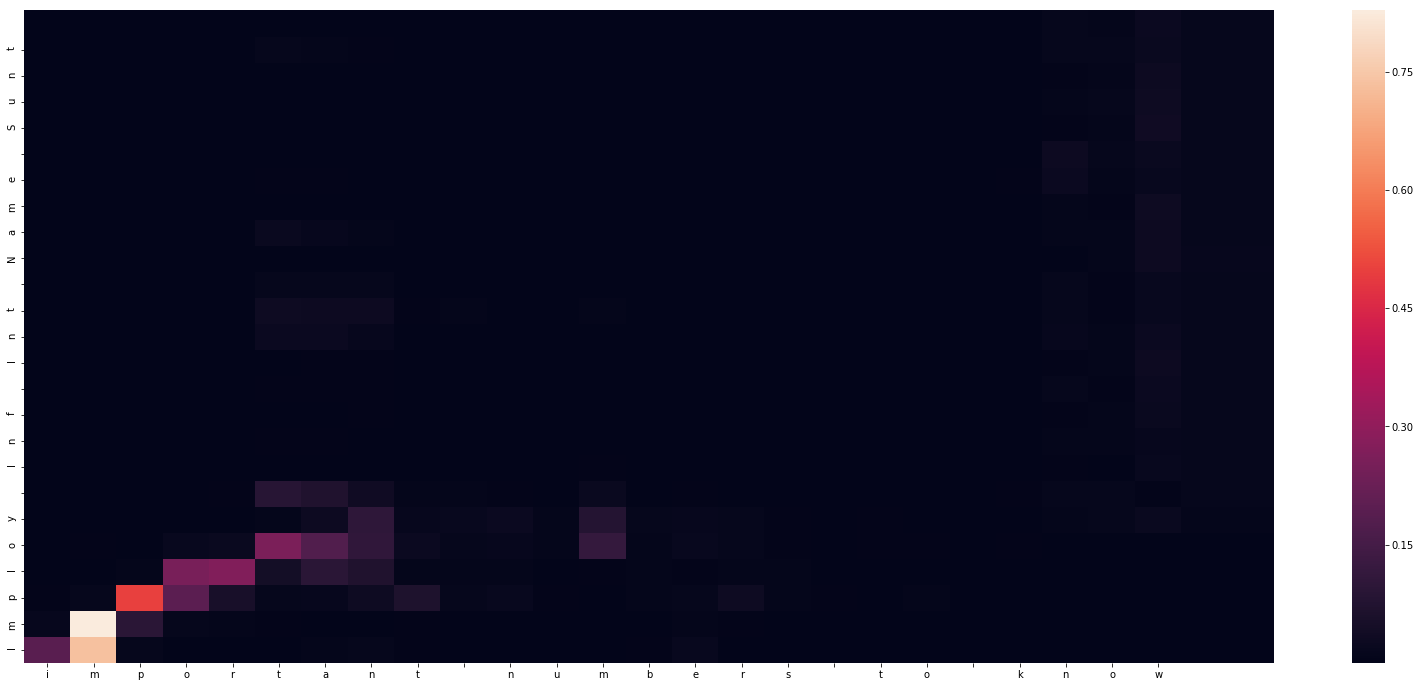

-
Input sentence: important numbers to know
GT sentence: Important Numbers to Know

Decoded sentence: Imploy Inf Int Name Sunt


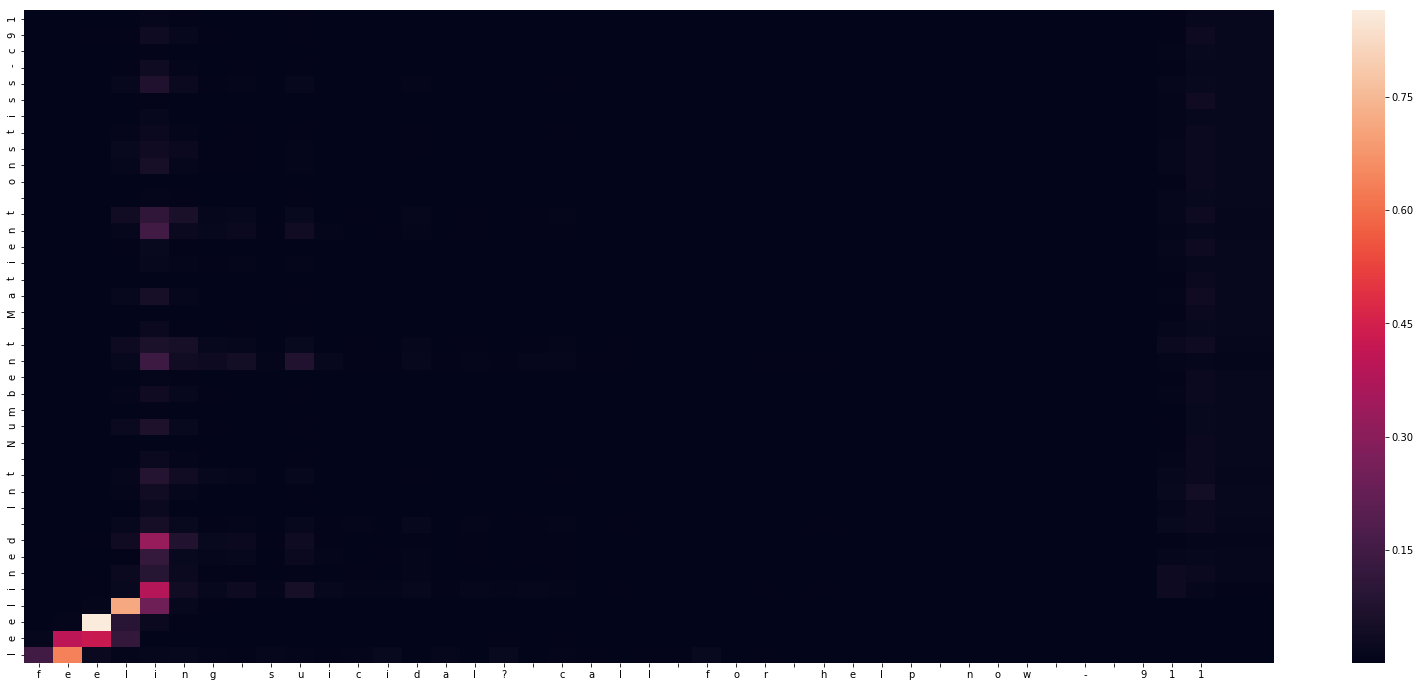

-
Input sentence: feeling suicidal? call for help now - 911
GT sentence: Feeling Suicidal? Call For Help Now - 911

Decoded sentence: Ieelined Int Numbent Matient onstiss-c91


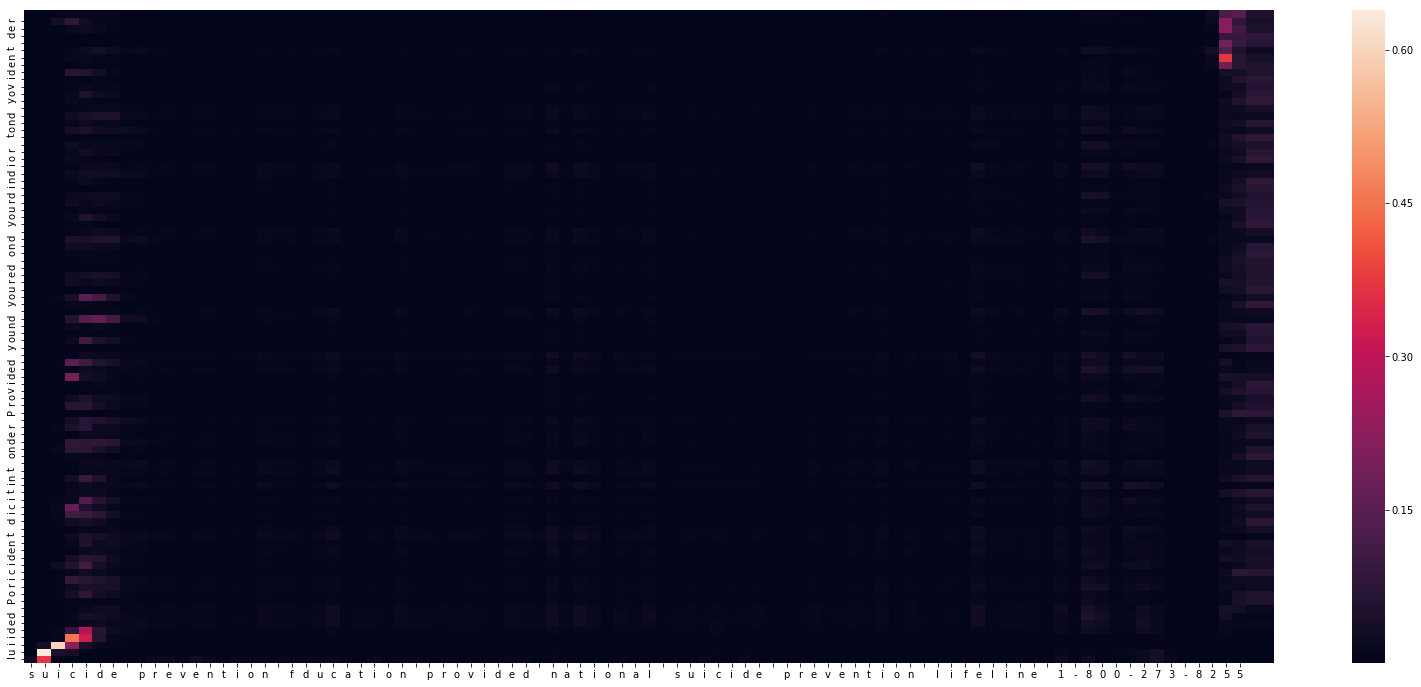

-
Input sentence: suicide prevention fducation provided national suicide prevention lifeline 1-800-273-8255
GT sentence: Suicide Prevention Education provided: National Suicide Prevention Lifeline 1-800-273-8255

Decoded sentence: Iuiided Poricident dicitint onder Provided yound youred ond yourdindior tond yovident der


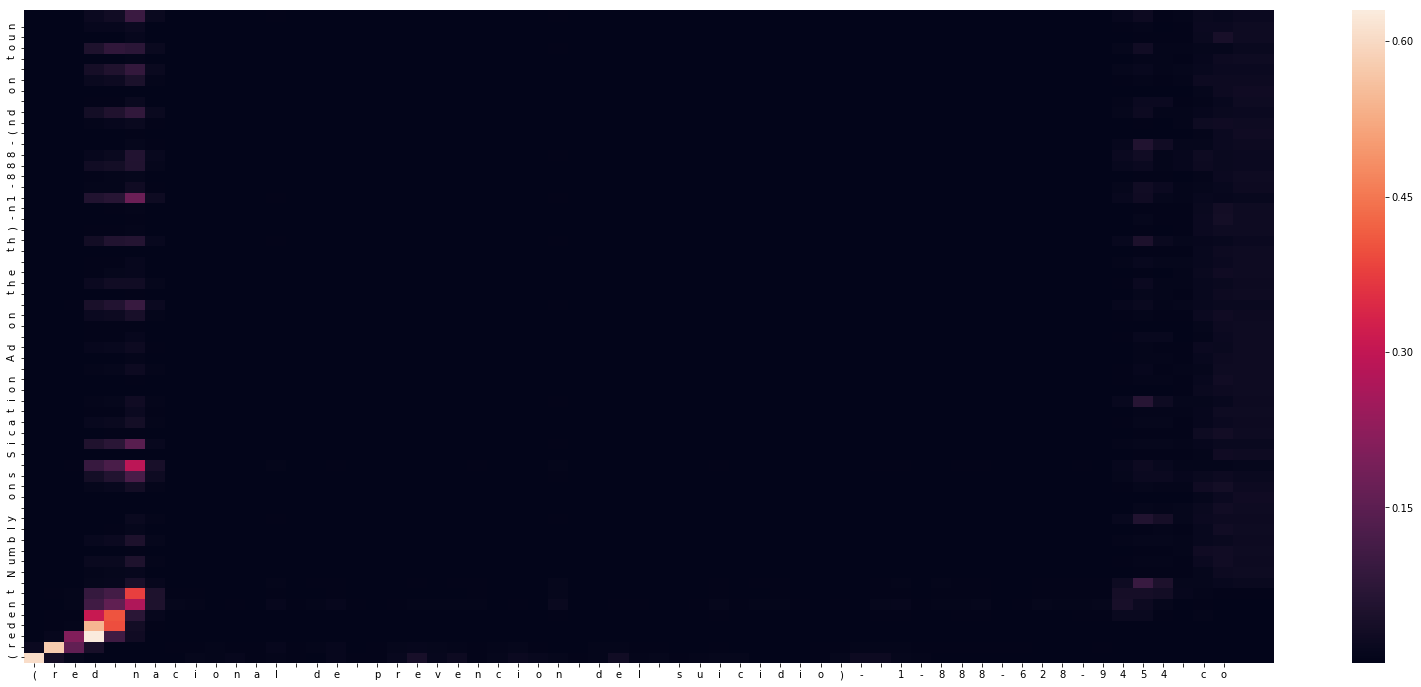

-
Input sentence: (red nacional de prevencion del suicidio)- 1-888-628-9454 co
GT sentence: (Red Nacional de Prevencion del Suicidio)- 1-888-628-9454

Decoded sentence: (redent Numbly ons Sication Ad on the th)-n1-888-(nd on toun


In [78]:
for seq_index in range(100):

    target_text = target_texts[seq_index][1:-1]
    text = input_texts[seq_index]
    decoded_sentence = visualize_attention(text, encoder_model, decoder_model, max_encoder_seq_length, num_decoder_tokens, vocab_to_int, int_to_vocab)
    print('-')
    print('Input sentence:', text)
    print('GT sentence:', target_text)
    print('Decoded sentence:', decoded_sentence)  

# Domain transfer from noisy spelling mistakes to OCR corrections

In [79]:
model, encoder_model, decoder_model = build_model(latent_dim=latent_dim, num_encoder_tokens=num_encoder_tokens)

[<tf.Tensor 'concatenate_4/concat:0' shape=(?, 512) dtype=float32>, <tf.Tensor 'concatenate_5/concat:0' shape=(?, 512) dtype=float32>]
Tensor("lstm_4/transpose_2:0", shape=(?, ?, 512), dtype=float32)
Tensor("bidirectional_2/concat:0", shape=(?, ?, 512), dtype=float32)
attention Tensor("attention_2/truediv:0", shape=(?, ?, ?), dtype=float32)
encoder-decoder  model:
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, None)         0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, None, 121)    14641       input_6[0][0]                    
__________________________________________________________________________________________________
input_7 (InputLayer)            (None, 

/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:63: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=[<tf.Tenso...)`


## Pre-train on noisy spelling mistakes

In [80]:

input_texts = input_texts_noisy_OCR
target_texts = target_texts_noisy_OCR

encoder_input_data, decoder_input_data, decoder_target_data = vectorize_data(input_texts=input_texts,
                                                                             target_texts=target_texts, 
                                                                             max_encoder_seq_length=max_encoder_seq_length, 
                                                                             num_encoder_tokens=num_encoder_tokens, 
                                                                             vocab_to_int=vocab_to_int)

batch_size = 64  # Batch size for training.
epochs = 50  # Number of epochs to train for.
latent_dim = 256  # Latent dimensionality of the encoding space.
lr = 0.01

#filepath="weights-improvement-{epoch:02d}-{val_categorical_accuracy:.2f}.hdf5"
filepath="best_model_transfer.hdf5" # Save only the best model for inference step, as saving the epoch and metric might confuse the inference function which model to use
checkpoint = ModelCheckpoint(filepath, monitor='val_categorical_accuracy', verbose=1, save_best_only=True, mode='max')
tbCallBack = TensorBoard(log_dir='./Graph', histogram_freq=0, write_graph=True, write_images=True)
callbacks_list = [checkpoint, tbCallBack]
#callbacks_list = [checkpoint, tbCallBack, lrate]

#model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.compile(optimizer=optimizers.Adam(lr=lr), loss='categorical_crossentropy', metrics=['categorical_accuracy'])


model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
          #validation_data = ([test_encoder_input_data, test_decoder_input_data], test_decoder_target_data),
          batch_size=batch_size,
          epochs=epochs,
          callbacks=callbacks_list,
          validation_split=0.2,
          shuffle=True)

Train on 8000 samples, validate on 2000 samples
Epoch 1/50
8000/8000 [==============================] - 56s 7ms/step - loss: 2.4181 - categorical_accuracy: 0.3331 - val_loss: 1.2040 - val_categorical_accuracy: 0.6265

Epoch 00001: val_categorical_accuracy improved from -inf to 0.62647, saving model to best_model_transfer.hdf5


/opt/anaconda3/lib/python3.6/site-packages/keras/engine/network.py:872: UserWarning: Layer lstm_4 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'concatenate_4/concat:0' shape=(?, 512) dtype=float32>, <tf.Tensor 'concatenate_5/concat:0' shape=(?, 512) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  '. They will not be included '


Epoch 2/50
8000/8000 [==============================] - 54s 7ms/step - loss: 0.4618 - categorical_accuracy: 0.8469 - val_loss: 0.0680 - val_categorical_accuracy: 0.9554

Epoch 00002: val_categorical_accuracy improved from 0.62647 to 0.95541, saving model to best_model_transfer.hdf5
Epoch 3/50
8000/8000 [==============================] - 55s 7ms/step - loss: 0.0321 - categorical_accuracy: 0.9612 - val_loss: 0.0216 - val_categorical_accuracy: 0.9618

Epoch 00003: val_categorical_accuracy improved from 0.95541 to 0.96179, saving model to best_model_transfer.hdf5
Epoch 4/50
8000/8000 [==============================] - 55s 7ms/step - loss: 0.0148 - categorical_accuracy: 0.9638 - val_loss: 0.0143 - val_categorical_accuracy: 0.9634

Epoch 00004: val_categorical_accuracy improved from 0.96179 to 0.96338, saving model to best_model_transfer.hdf5
Epoch 5/50
8000/8000 [==============================] - 54s 7ms/step - loss: 0.0171 - categorical_accuracy: 0.9639 - val_loss: 0.0193 - val_categorical

KeyboardInterrupt: 

## Fine tune on OCR correction data

In [81]:

input_texts = input_texts_OCR
target_texts = target_texts_OCR

# Keep test data from the corrected OCR, as this what we care about
input_texts, test_input_texts, target_texts, test_target_texts  = train_test_split(input_texts, target_texts, test_size = 0.15, random_state = 42)

# Vectorize train data
encoder_input_data, decoder_input_data, decoder_target_data = vectorize_data(input_texts=input_texts,
                                                                             target_texts=target_texts, 
                                                                             max_encoder_seq_length=max_encoder_seq_length, 
                                                                             num_encoder_tokens=num_encoder_tokens, 
                                                                             vocab_to_int=vocab_to_int)
# Vectorize test data
test_encoder_input_data, test_decoder_input_data, test_decoder_target_data = vectorize_data(input_texts=test_input_texts,
                                                                                            target_texts=test_target_texts, 
                                                                                            max_encoder_seq_length=max_encoder_seq_length, 
                                                                                            num_encoder_tokens=num_encoder_tokens, 
                                                                                            vocab_to_int=vocab_to_int)


batch_size = 64  # Batch size for training.
epochs = 50  # Number of epochs to train for.
latent_dim = 256  # Latent dimensionality of the encoding space.
lr = 0.001# Reduce the learning rate for fine tuning
model.load_weights('best_model_transfer.hdf5')
model.compile(optimizer=optimizers.Adam(lr=lr), loss='categorical_crossentropy', metrics=['categorical_accuracy'])


model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
          validation_data = ([test_encoder_input_data, test_decoder_input_data], test_decoder_target_data),
          batch_size=batch_size,
          epochs=epochs,
          callbacks=callbacks_list,
          #validation_split=0.2,
          shuffle=True)

Train on 238 samples, validate on 42 samples
Epoch 1/50
238/238 [==============================] - 4s 15ms/step - loss: 4.8046 - categorical_accuracy: 0.3787 - val_loss: 4.8852 - val_categorical_accuracy: 0.3607

Epoch 00001: val_categorical_accuracy did not improve from 0.96597
Epoch 2/50
238/238 [==============================] - 2s 7ms/step - loss: 4.5149 - categorical_accuracy: 0.3880 - val_loss: 4.6985 - val_categorical_accuracy: 0.3707

Epoch 00002: val_categorical_accuracy did not improve from 0.96597
Epoch 3/50
238/238 [==============================] - 2s 8ms/step - loss: 4.2597 - categorical_accuracy: 0.3960 - val_loss: 4.5452 - val_categorical_accuracy: 0.3724

Epoch 00003: val_categorical_accuracy did not improve from 0.96597
Epoch 4/50
238/238 [==============================] - 2s 8ms/step - loss: 4.0403 - categorical_accuracy: 0.4032 - val_loss: 4.4157 - val_categorical_accuracy: 0.3833

Epoch 00004: val_categorical_accuracy did not improve from 0.96597
Epoch 5/50
238/238


Epoch 00035: val_categorical_accuracy did not improve from 0.96597
Epoch 36/50
238/238 [==============================] - 2s 8ms/step - loss: 1.3499 - categorical_accuracy: 0.6912 - val_loss: 2.9779 - val_categorical_accuracy: 0.4812

Epoch 00036: val_categorical_accuracy did not improve from 0.96597
Epoch 37/50
238/238 [==============================] - 2s 7ms/step - loss: 1.3056 - categorical_accuracy: 0.6975 - val_loss: 2.9581 - val_categorical_accuracy: 0.4870

Epoch 00037: val_categorical_accuracy did not improve from 0.96597
Epoch 38/50
238/238 [==============================] - 2s 7ms/step - loss: 1.2623 - categorical_accuracy: 0.7083 - val_loss: 2.9372 - val_categorical_accuracy: 0.4879

Epoch 00038: val_categorical_accuracy did not improve from 0.96597
Epoch 39/50
238/238 [==============================] - 2s 7ms/step - loss: 1.2180 - categorical_accuracy: 0.7175 - val_loss: 2.9112 - val_categorical_accuracy: 0.4929

Epoch 00039: val_categorical_accuracy did not improve from 

In [82]:
model.load_weights('best_model_transfer.hdf5')

In [83]:

# Sample output from test data
decoded_sentences = []
target_texts_ =  []

for seq_index in range(len(test_input_texts)):
    # Take one sequence (part of the training set)
    # for trying out decoding.

    input_seq = test_encoder_input_data[seq_index: seq_index + 1]
    decoded_sentence, _ = decode_sequence(input_seq, encoder_model, decoder_model, num_decoder_tokens, int_to_vocab)
    target_text = test_target_texts[seq_index][1:-1]
    print('-')
    print('Input sentence:', test_input_texts[seq_index])
    print('GT sentence:', target_text)
    print('Decoded sentence:', decoded_sentence)   
    decoded_sentences.append(decoded_sentence)
    target_texts_.append(target_text)
    
WER_spell_correction = calculate_WER(target_texts_, decoded_sentences)
print('WER_spell_correction |TEST= ', WER_spell_correction)

WER_OCR = calculate_WER(target_texts_, test_input_texts)
print('WER_OCR |TEST= ', WER_OCR)   

-
Input sentence: first name
GT sentence: First Name:

Decoded sentence: Printed Name
-
Input sentence: estimado paciente
GT sentence: Estimado Paciente:

Decoded sentence: The Benefits Canter
-
Input sentence: southwest florida emergency
GT sentence: SOUTHWEST FLORIDA EMERGENCY

Decoded sentence: Moclest Nome Last Name
-
Input sentence: fax number
GT sentence:  FAX NUMBER:

Decoded sentence: If knoencender
-
Input sentence: name- 40fq
GT sentence: Name: 4 of 9

Decoded sentence: Cuar- 40me
-
Input sentence: electronically signed
GT sentence: Electronically Signed

Decoded sentence: Relephone Number
-
Input sentence: special note to parents
GT sentence: Special note to parents

Decoded sentence: Applocat  abl the tasis
-
Input sentence: digitech computer, ing.
GT sentence: DIGITECH COMPUTER, INC. 

Decoded sentence: indicated an Prev,nint.
-
Input sentence: follow-up care
GT sentence: Follow-up care

Decoded sentence: Policy-Holder
-
Input sentence: home care
GT sentence: Home care

De

## Noisy channel LM

![noisy_channel_model](https://sandipanweb.files.wordpress.com/2017/05/im0_2.png?w=768)

# Build word spelling corrector (autocorrect)

In [84]:
from __future__ import print_function
import tensorflow as tf
import keras.backend as K
from keras.backend.tensorflow_backend import set_session
from keras.models import Model
from keras.layers import Input, LSTM, Dense, Bidirectional, Concatenate, GRU, Dot, TimeDistributed, Activation, Embedding
from keras import optimizers
from keras.callbacks import ModelCheckpoint, TensorBoard, LearningRateScheduler
import numpy as np
import os
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import json
from nltk.tokenize import word_tokenize
import re
import os
import tarfile
import csv
import pandas as pd
%matplotlib inline

In [85]:
def load_data_with_gt(file_name, delimiter='\t', gt_index=1, prediction_index=0):
    input_texts = []
    gt_texts = []
    for row in open(file_name, encoding='utf8'):
        sents = row.split(delimiter)
        if (len(sents) < 2):
            continue
        input_texts.append(sents[prediction_index])
        gt_texts.append(sents[gt_index])
    return input_texts, gt_texts

In [86]:
def load_raw_data(file_name):
    with open(file_name, 'r') as f:
        return(f.read())

In [87]:
def load_medical_terms(json_file):
    texts = []
    with open(json_file) as f:
        med_terms_dict = json.load(f)
    texts += list(med_terms_dict.keys())
    texts += list(med_terms_dict.values())
    return texts

In [88]:
def load_accidents_terms(file_name):

    f = open(file_name, encoding='utf8')
    line = 0  
    texts = []
    try:
        for r in f:
            for term in r.split('|'):
                    texts += term.replace('\"', '')
    except:
        print('finished')

                
    return texts

In [89]:
def process_word(word):
    # Try to correct the word from known dict
    #word = spell(word)
    # Option 1: Replace special chars and digits
    #processed_word = re.sub(r'[\\\/\-\—\:\[\]\,\.\"\;\%\~\(\)\{\}\$\#\?\●\@\+\-\*\d]', r'', w.lower())
    
    # Option 2: skip all words with special chars or digits
    if(len(re.findall(r'[\\\/\-\—\:\[\]\,\.\"\;\%\~\(\)\{\}\$\#\?\●\@\+\-\*\d]', word.lower())) == 0):
        processed_word = word
    else:
        processed_word = 'UNK'

    # Skip stop words
    #stop_words = ["i", "me", "my", "myself", "we", "our", "ours", "ourselves", "you", "your", "yours", "yourself", "yourselves", "he", "him", "his", "himself", "she", "her", "hers", "herself", "it", "its", "itself", "they", "them", "their", "theirs", "themselves", "what", "which", "who", "whom", "this", "that", "these", "those", "am", "is", "are", "was", "were", "be", "been", "being", "have", "has", "had", "having", "do", "does", "did", "doing", "a", "an", "the", "and", "but", "if", "or", "because", "as", "until", "while", "of", "at", "by", "for", "with", "about", "against", "between", "into", "through", "during", "before", "after", "above", "below", "to", "from", "up", "down", "in", "out", "on", "off", "over", "under", "again", "further", "then", "once", "here", "there", "when", "where", "why", "how", "all", "any", "both", "each", "few", "more", "most", "other", "some", "such", "no", "nor", "not", "only", "own", "same", "so", "than", "too", "very", "s", "t", "can", "will", "just", "don", "should", "now"]        
    stop_words = []        
    if processed_word in stop_words:
        processed_word = 'UNK'
        
    return processed_word

## Load data

In [90]:
data_path = '../../dat/'
texts = []
noisy_texts = []

In [91]:
# Load tesseract correction

files_list = ['all_ocr_data_2.txt', 
              'field_class_21.txt', 
              'field_class_22.txt', 
              'field_class_23.txt', 
              'field_class_24.txt', 
              'field_class_25.txt', 
              'field_class_26.txt', 
              'field_class_27.txt', 
              'field_class_28.txt', 
              'field_class_29.txt', 
              'field_class_30.txt', 
              'field_class_31.txt', 
              'field_class_32.txt', 
              'field_class_33.txt', 
              'field_class_34.txt', 
              'NL-14622714.txt', 
              'NL-14627449.txt', 
              'NL-14628986.txt', 
              'NL-14631911.txt', 
              'NL-14640007.txt']

#files_list = ['all_ocr_data_2.txt']
#files_list = ['field_class_21.txt', 'field_class_21.txt', 'field_class_21.txt', 'field_class_21.txt', 'field_class_21.txt', 'field_class_21.txt', 'field_class_21.txt', 'field_class_21.txt', 'field_class_21.txt', 'field_class_21.txt', 'field_class_21.txt', 'field_class_21.txt', 'field_class_21.txt', 'field_class_21.txt', 'field_class_21.txt', 'field_class_21.txt', 'field_class_21.txt', 'field_class_21.txt', 'field_class_21.txt', 'field_class_21.txt', 'field_class_21.txt', 'field_class_21.txt', 'field_class_21.txt', 'field_class_21.txt', 'field_class_21.txt']

for file_name in files_list:
    tess_correction_data = os.path.join(data_path, file_name)
    noisy, gt = load_data_with_gt(tess_correction_data)
    texts += gt
    noisy_texts += noisy
print(len(texts))    
print(len(noisy_texts))    
# Load HW terms

hw_correction_data = os.path.join(data_path, 'handwritten_output.txt')
_, gt = load_data_with_gt(hw_correction_data, delimiter='|', gt_index=0, prediction_index=1)
texts += gt

# Load clean claims forms

num_samples = 10000
file_name = os.path.join(data_path, 'claims.txt')
#texts += load_raw_data(file_name)

# Load Medical Terms dictionary
json_file = os.path.join(data_path, 'abbrevs.json')
texts += load_medical_terms(json_file)

# Load Medical Instruction dictionary
file_name = os.path.join(data_path, 'medical_instructions.txt')
texts += load_raw_data(file_name)

# Load accident terms
file_name = os.path.join(data_path, 'AccidentsL.txt')
texts += load_accidents_terms(file_name)

# Load procedures and tests
file_name = os.path.join(data_path, 'procedures_tests.txt')
texts += load_raw_data(file_name)

# Load Diagnosis Descriptions
file_name = os.path.join(data_path, 'ICD10.csv')
t = pd.read_csv(file_name)
texts += list(t['DESCRIPTION'].values)

12845
12845
finished


In [92]:
# Sample data
print(len(texts))
for i in range(10):
    print(texts[i], '\n')

1163183
Claim Type: VB Accident - Accidental Injury
 

Who The Reported Event Happened To: Employee/Policyholder
 

Policyholder/Owner Information
 

First Name:
 

Middle Name/Initial:
 

Last Name:
 

Social Security Number:
 

Birth Date:
 

Gender:
 

Language Preference:
 



In [93]:
with open('med.txt', 'w') as f:
    for text in texts:
        f.write(text)
f.close()

In [94]:
!tar -xvf autocorrect/words.tar

words/
words/en_US_GB_CA_mixed.txt
words/big_orig.txt
words/._big.txt
words/big.txt
words/en_US_GB_CA_lower.txt


In [95]:
#f_big_orig = open('words/big_orig.txt', 'r')
f_big_orig = open('med.txt', 'r')
f_med = open('med.txt', 'r')
f_big = open('words/big.txt', 'w')
for line in f_big_orig:
    f_big.write(line + '\n')
for line in f_med:
    f_big.write(line + '\n')
    

f_big_orig.close()
f_big.close()
f_med.close()

In [96]:
!tar -cvf autocorrect/words.tar words

words/
words/en_US_GB_CA_mixed.txt
words/big_orig.txt
words/._big.txt
words/big.txt
words/en_US_GB_CA_lower.txt


In [97]:
!rm -rf words/

# Build n-gram LM

In [98]:
from nltk.corpus import reuters
from nltk import bigrams, trigrams
from nltk import word_tokenize
from collections import Counter, defaultdict
import random

In [99]:
def lower_case(w):
    if w is not None: w = w.lower() 
    return w

In [100]:
def build_trigram_lm(corpus):
    model = defaultdict(lambda: defaultdict(lambda: 0))

    for sentence in corpus:
        sentence = word_tokenize(sentence)
        #print(sentence)
        #print(word_tokenize(sentence))
        #print(list(trigrams(sentence, pad_right=True, pad_left=True)))
        #print(list(trigrams(word_tokenize(sentence), pad_right=True, pad_left=True)))
        for w1, w2, w3 in trigrams(sentence, pad_right=True, pad_left=True):
            model[(w1, w2)][w3] += 1

    '''
    print(model["what", "the"]["economists"])  # "economists" follows "what the" 2 times
    print(model["what", "the"]["nonexistingword"])  # 0 times
    print(model[None, None]["The"])  # 8839 sentences start with "The"
    '''
    # Let's transform the counts to probabilities
    for w1_w2 in model:
        total_count = float(sum(model[w1_w2].values()))
        for w3 in model[w1_w2]:
            model[w1_w2][w3] /= total_count
    return model


In [101]:
def build_bigram_lm(corpus, vocab_size):
    model = defaultdict(lambda: defaultdict(lambda: 1)) # Default is 1 for laplace smoothing
    vocab = defaultdict(lambda: 0)
    for sentence in corpus:
        sentence = word_tokenize(sentence)
        #print(sentence)
        #print(word_tokenize(sentence))
        #print(list(trigrams(sentence, pad_right=True, pad_left=True)))
        #print(list(trigrams(word_tokenize(sentence), pad_right=True, pad_left=True)))
        for w1, w2 in bigrams(sentence, pad_right=True, pad_left=True):
            w1 = lower_case(w1)
            w2 = lower_case(w2)
            model[w1][w2] += 1

    # Let's transform the counts to probabilities
    norm_model = defaultdict(lambda: defaultdict(lambda: 1/vocab_size))
    for w1 in model:
        w1 = lower_case(w1)
        total_count = float(sum(model[w1].values())) + vocab_size # Laplace smoothing
        for w2 in model[w1]:
            w2 = lower_case(w2)
            norm_model[w1][w2] = model[w1][w2] / total_count
    return norm_model


In [102]:
def build_unigram_lm(corpus):
    model = defaultdict(lambda: 1) # Default is 1 for laplace smoothing

    for sentence in corpus:
        sentence = word_tokenize(sentence)
        for w1 in sentence:
            w1 = lower_case(w1)
            model[w1] += 1

    # Let's transform the counts to probabilities
    vocab_size = len(model.keys())
    norm_model = defaultdict(lambda: 1/vocab_size) # Default is 1 for laplace smoothing
    for w1 in model:
        w1 = lower_case(w1)
        norm_model[w1] = model[w1] / vocab_size
    return norm_model, vocab_size

In [103]:
p_uni, vocab_size = build_unigram_lm(texts)

In [104]:

p_bi = build_bigram_lm(texts, vocab_size)

In [105]:

from autocorrect import spell
from autocorrect.nlp_parser import NLP_COUNTS
from autocorrect.word import Word, common, exact, known, get_case

In [106]:
import numpy as np
from nltk.tokenize import word_tokenize

In [107]:
def normalize(candidates_dict):
    for candidate in candidates_dict.keys():
        candidates_dict[candidate] /= (sum(candidates_dict.values()) + len(candidates_dict.values()))
    return candidates_dict    

In [108]:
def get_candidates(word):
    w = Word(word)
    
    candidates = (common([word]) | exact([word]) | known([word]) |
              known(w.typos()) | common(w.double_typos()) or
              [word])

    w_common = 10
    w_exact = 10
    w_known = 5
    w_known_typo = 2
    w_known_double_typos = 0.005
    w_word = 0.5
    
    tot = w_common + w_exact + w_known + w_known_typo + w_known_double_typos + w_word
    w_common /= tot
    w_exact  /= tot
    w_known  /= tot
    w_known_typo  /= tot
    w_known_double_typos  /= tot
    w_word  /= tot
    
    candidates_dict = {}
    for i, candidate in enumerate(common([word])):
        candidates_dict[candidate] = w_common * (NLP_COUNTS.get(candidate)+1)
    for i, candidate in enumerate(exact([word])):
        candidates_dict[candidate] = w_exact * (NLP_COUNTS.get(candidate)+1)                                  
    for i, candidate in enumerate(known([word])):
        candidates_dict[candidate] = w_known * (NLP_COUNTS.get(candidate)+1)                                  
    for i, candidate in enumerate(known(w.typos())):
        candidates_dict[candidate] = w_known_typo * (NLP_COUNTS.get(candidate)+1)                               
    for i, candidate in enumerate(common(w.double_typos())):
        candidates_dict[candidate] = w_known_double_typos * (NLP_COUNTS.get(candidate)+1) 
    candidates_dict[word] = w_word * (NLP_COUNTS.get(word) + 1)
    
    candidates_dict = normalize(candidates_dict)
    return candidates_dict

In [109]:
special_chars = ['\\', '\/', '\-', '\—' , '\:', '\[', '\]', '\,', '\.', '\"', '\;', '\%', '\~', '\(', '\)', '\{', '\}', '\$', '\&', '\#', '\☒', '\■', '\☐', '\□', '\☑', '\@']
special_chars_s = '[' + ''.join(special_chars) + ']'
def spell_noisy_channel(sentence, p_uni, p_bi):
    sentence = sentence.split(' ')#word_tokenize(sentence)

    wt_1 = []
    corrected = []
    corr_w = spell(sentence[0])
    
    wt_1.append(lower_case(corr_w))
    corrected.append(corr_w)
    for i, w in enumerate(sentence[1:]):
        #print('wt_bar:' + w)
        if((len(re.findall(r'\d+', w))==0) and (len(re.findall(special_chars_s, w))==0)):
            candidates = get_candidates(w)
            prev_score = 0

            for wt_hat in candidates:
                p_wt_hat = p_uni[wt_hat]
                #print('wt_hat:' + wt_hat)
                #print('p_wt_hat:' + str(p_wt_hat))
                '''
                if i > 1:
                    p_wt_hat_given_wt_1 = p_bi[wt_hat][wt_1[i-1]]
                else:
                    p_wt_hat_given_wt_1 = p_wt_hat
                '''
                #print('wt_1:' + wt_1[i-1])
                p_wt_hat_given_wt_1 = p_bi[wt_1[-1]][wt_hat]
                #print('p_wt_hat_given_wt_1:' + str(p_wt_hat_given_wt_1))
                p_wt_hat_given_wt = candidates[wt_hat]
                #print('p_wt_hat_given_wt:' + str(p_wt_hat_given_wt))

                score = p_wt_hat_given_wt * p_wt_hat_given_wt_1 #/ p_wt_hat
                #print('p:' + str(score))
                if score > prev_score: 
                    prev_score = score
                    wt = wt_hat
            
            wt_1.append(wt)
            corrected.append(get_case(w, wt))
        else:
            corrected.append(w)
        
        
                
    return ' '.join(corrected)

In [110]:
#sent = 'First Nane'#'Who The Reported Event Happened To: Employee/Policyholder'#
sent = 'Who The Reported Event Happened To: Employee/Policyholder'
#sent = 'The Reported Event'

In [ ]:
c = spell_noisy_channel(sent, p_uni, p_bi)
c

'Who The Reported Event Happened To: Employee/Policyholder'

## Noisy channel spelling correction

In [ ]:
for noisy, text in zip(noisy_texts, texts):
    print('GT: ' + text)
    print('Noisy: ' + noisy)
    print('Correction: ' + spell_noisy_channel(noisy, p_uni, p_bi))
    print('-----------')

GT: Claim Type: VB Accident - Accidental Injury

Noisy: Claim Type: VB Accident - Accidental Injury
Correction: Claim Type: OF Accident - Accident Injury
-----------
GT: Who The Reported Event Happened To: Employee/Policyholder

Noisy: “Tho Th 9 Reported Even [ Happen ed To: EnployeefPolicyholder
Correction: Tho Of 9 Reported Open [ Tappen of To: EnployeefPolicyholder
-----------
GT: Policyholder/Owner Information

Noisy: Pol inyhold elm-Chm er [11 form arlon
Correction: Pol inhold elm-Chm of [11 or carbon
-----------
GT: First Name:

Noisy: First Name:
Correction: First Name:
-----------
GT: Middle Name/Initial:

Noisy: Middle Nameﬂnitial:
Correction: Middle Nameﬂnitial:
-----------
GT: Last Name:

Noisy: Last Name:
Correction: Last Name:
-----------
GT: Social Security Number:

Noisy: Social S ecurity Number:
Correction: Social Or security Number:
-----------
GT: Birth Date:

Noisy: Birth Date:
Correction: Birth Date:
-----------
GT: Gender:

Noisy: Gender:
Correction: Gender
-------

Correction: StatefProvince:
-----------
GT: Postal Code:

Noisy: Postal Code:
Correction: Postal Code:
-----------
GT: Country:

Noisy: Comiry
Correction: Comity
-----------
GT: Date of Visit/Admission:

Noisy: Date ofVisit/‘Admissiorr
Correction: Date ofVisit/‘Admissiorr
-----------
GT: Date of Discharge:

Noisy: Date ofDischarge:
Correction: Date ofDischarge:
-----------
GT: Procedure: Left wrist arthiscopic surgery

Noisy: Procedure: Left wrist arthiscopic surgery
Correction: Procedure Left wrist arthiscopic surgery
-----------
GT: Employment Information

Noisy: Empl Dun ent In formation
Correction: Emp In left In information
-----------
GT: Employer Name:

Noisy: Employer Name:
Correction: Employer Name:
-----------
GT: Policy Number:

Noisy: Policy Number:
Correction: Policy Number:
-----------
GT: Electronic Submission

Noisy: Electronic Submission
Correction: Electronic Submission
-----------
GT: Claim Event Identifier:

Noisy: ClairnEvent Identifier:
Correction: ClairnEvent Ide

Correction: So that Unum may evaluate and administer my claims, including providing assistance with return to work. Of such evaluation and administration of claims, the authorization is valid for the years, or the duration of my claim for benefits, whichever is shorter. A understand that once Of Information is disclosed to Unum, any privacy protections established by HIPAA may not apply to the information, but other privacy laws continue to apply. unum may then disclose Of Information only as permitted by law, including, state fraud reporting laws or ii authorized by me.
-----------
GT: I also authorize Unum to disclose My Information to the following persons (for the purpose of reporting claim status or experience, or so that the moment may carry out health care operations, claims payment, administrative or audit functions related to any benefit, plan or claim): any employee benefit plan sponsored by my employer; any person providing services or insurance benefits to (or on behalf of)

Correction: This information is in abbreviated form only. Of a provided to give you a general understanding of your Of & OffJob Accident coverage.
-----------
GT: Your actual coverage and amounts are subject to all the terms, conditions, limitations and exclusions stated in your Certificate of Coverage and Policy. Please refer to your Certificate of Coverage for a detailed description of your coverage. If the information in this letter differs from the Policy held by your Employer or Plan Administrator, the terms of the Policy will govern. Please contact your Plan Administrator with any questions or call our Contact Center at 1-800-635-5597 and we can assist you.

Noisy: Your actual coverage and amounts are subject to all the terms, conditions, limitations and exclusions stated in your Certificate of Coverage and Policy. Please refer to your Certificate of Coverage for a detailed description of your coverage. If the information in this letter differs from the Poliqr held by your Employ

Correction: in Subunute-nppenrins miner styloid I'inetoteti with mild odnmn idennﬁed of the level of the distal nine. The is anterior rnhlnttntion oi‘the ulna with respect to the radius.
-----------
GT: 2. The ulnar side of the triangular fibrocartilage complex attaches to the dominant avulsed fracture fragment off the ulna, with associated partial-thickness ulnar side tear of the triangular fibrocartilage complex.

Noisy: 2. The ninsr aide ot‘the triangular ﬁbroetmiiege complex atteehes to the dominant evnised fracture fragment off the ulna, with associated Nomi-thickness nlnnr side tear of the triangular ﬁbrocartilnge complex. -
Correction: of Other Ninsar and ot‘the triangular ﬁbroetmiiege complex atteehes to the dominant evnised fracture fragment off the ulna, with associated Nomi-thickness ulnar side tear of the triangular ﬁbrocartilnge complex. -
-----------
GT: 3. Constellation of findings consistent with lunate triquetral ligament tear.

Noisy: J. Constellation of findings cons

Correction: How do I the of appeals Of a submit a letter of appeal. Of a attach any additional information or documentation you feel will support your appeal Of have 180 dys from the receipt of the notice to submit your request And to Appeals Coordinator 1 First Choice Health Administrators 1 600 university Street Suite 1400 i Seattle I THE 98101
-----------
GT: If you have any questions about this process, please contact us at 1-800-305-0849 Monday through Friday between 8AM - 5PM (Pacific Time)

Noisy: If you have any questions about this process please contact us at 1-800-305—0849 Monday through Friday between 8AM — 5PM (Pacific Time)
Correction: If you have any questions about this process please contact us at 1-800-305—0849 Monday through Friday between 8AM — 5PM (Pacific Time)
-----------
GT: Who may file an appeal? You or someone you name to act for you (your authorized representative) may file an appeal. Once you have designated someone else to represent you, all communication 

Correction: Accident Description - - .......1 was mining at the arm and not for hand down in a and position on a mat. For right little finger at caught on the date and pulled to the side: breaking it and making i1 point in the wrong direction"
-----------
GT: Accident Work Related: No

Noisy: Accident Work Related: N o
Correction: Accident Or Related: Ii of
-----------
GT: Time of Accident:

Noisy: Time ofAccident:
Correction: Time ofAccident:
-----------
GT: Accident Date:

Noisy: Accident Date:
Correction: Accident Date:
-----------
GT: Diagnosis Code: Displaced fracture of proximal phalanx of right little finger

Noisy: Diagnosis Code: Displaced ﬁ'acture ot‘proxiiml phalam ofright little ﬁnger
Correction: Diagnosis Code: Displaced fracture ot‘proxiiml phalanx right little finger
-----------
GT: Surgery Information

Noisy: Surg 91'3'lnf01'Iilation No
Correction: Surg 91'3'lnf01'Iilation Of
-----------
GT: Is Surgery Required: No

Noisy: Is Surgery Required:
Correction: Is Surgery Req

Correction: I authorize the following persons: health care professionals, hospitals, clinics, laboratories, pharmacies and all other medical or ii scally related providers, facilities or services, rehabilitation professionals, vocational evaluators, health plans, insurance companies, third party administrators, insurance producers, insurance service providers, consumer reporting agencies including credit bureaus, GENEX Services, Inc., The Advocator Group and other Social Security advocacy vendors, professional licensing bodies, employers, attorneys, financial institutions and/or banks, and governmental entities;
-----------
GT: To disclose information, whether from before, during or after the date of this authorization, about my health, including HIV, AIDS or other disorders of the immune system, use of drugs or alcohol, mental or physical history, condition, advice or treatment (except this authorization does not authorize release of psychotherapy notes), prescription drug history, ea

Correction: If I of of skin this authorization or ii I walter or revoke it, except as specified above, Unum may not be able to evaluate or administer my claim(s), with a left in a claim(s) being denied. I may revoke this authorization at any time by sending written notice to the address above. Of understand that revocation will not apply to any information that Unum requests or discloses prior to Unum receiving my revocation request.
-----------
GT: Electronically Signed Insured’s Signature

Noisy: Electronically Signed Insured’s Signature
Correction: Electronically Signed insured Signature
-----------
GT: Date Signed

Noisy: Date Signed
Correction: Date Signed
-----------
GT: Printed Name Social Security Number

Noisy: Printed Name Socral Security Number
Correction: Printed Name Spiral Security Number
-----------
GT: I signed on behalf of the Insured as Mother (Relationship). If Power of Attorney Designee, Guardian, or Conservator, please attach a copy of the document granting authori

Correction: Offic On New/estab Moderate Level
-----------
GT: Rad Exam Finger(s) Mini 2 Views

Noisy: Rad Exam Finger-(s) Mini 2 Views
Correction: Rad Exam Finger-(s) In 2 Views
-----------
GT: Applic; Hand & Lower Forearm

Noisy: Applic; Hand 8. Lower Forearm
Correction: Applied Hand 8. Lower Forearm
-----------
GT: Fiberglass; gauntlet Cast; 11 Yrs +

Noisy: Fiberglass;gaunt1et Cast;11 Yrs +
Correction: Fiberglass;gaunt1et Cast;11 Or ii
-----------
GT: Rad Exam Hand; Mini 3 Views

Noisy: Rad Exam Hand; Hini 3 Views
Correction: Rad Exam Hand; In 3 Views
-----------
GT: Charge

Noisy: Char-e
Correction: charge
-----------
GT: Ins. Pmt.

Noisy: Ins Pmt
Correction: Ins Emt
-----------
GT: Pat. Pmt.

Noisy: Pat Pmt
Correction: Pat Emt
-----------
GT: Adjust.

Noisy: Ad ust
Correction: Ad at
-----------
GT: Amount

Noisy: Amount
Correction: Amount
-----------
GT: Ins

Noisy: Ins
Correction: Ins
-----------
GT: 1% per mo. interest (12% APR) charged on patient balances over 90 days

Noisy: i

Correction: These totals are accurate as of the left claim shown on the is document Of of received care for recently. unprocessed of arm for the care will not at the reflected in the total shown here Please note that claims may not be received by First ( Roice Health in the other type care was provided
-----------
GT: DEDUCTIBLE OUT OF POCKET

Noisy: DEDUCTEBLE
Correction: DEDUCTIBLE
-----------
GT: Satisfied Maximum Satisfied Maximum Satisfied Maximum Satisfied Maximum

Noisy: Ewm...m.wwtwu A 2 Maximum ' Satisfied Maximum 2 Maximum ' Satisfied Maximum
Correction: Ewm...m.wwtwu Of 2 Maximum of Satisfied Maximum 2 Maximum of Satisfied Maximum
-----------
GT: Regional Health Inc

Noisy: Reg one Health inc '
Correction: Reg of Health incl of
-----------
GT: In-Network

Noisy: in Network'
Correction: in Network
-----------
GT: Out-of-Network

Noisy: "J‘- rat-Network
Correction: "J‘- rat-Network
-----------
GT: Family level maximums apply only when multiple family members are enrolled on th

Correction: These totals are accurate as of the left claim shown on the document. of of received care for recently. unprocessed claims for the care wall of left in reflected in the totals shown here Please note that claims may not be received by First Choice Health in the other type care was provided
-----------
GT: DEDUCTIBLE OUT OF POCKET

Noisy: E DEDUCTiBLE OUT OF POCKET
Correction: E Deductibles OF A POCKET
-----------
GT: Individual Family Individual Family

Noisy: i individual 4! Family 1 Individual M; Family
Correction: i individual 4! Family 1 Individual M; Family
-----------
GT: Satisfied Maximum Satisfied Maximum Satisfied Maximum Satisfied Maximum

Noisy: Satisﬁed Maximum 1 Satisﬁed
Correction: Satisfied Maximum 1 Satisﬁed
-----------
GT: Regional Health Inc

Noisy: Regrona Health inc
Correction: Region Health incl
-----------
GT: In-Network

Noisy: 
Correction: a
-----------
GT: Out of Network

Noisy: Out of Network 
Correction: Out of Network of
-----------
GT: Family lev

Correction: Can I request copies of information relevant to my claim Yes. you or request copies (free of charge} body contracting of at 178003050849, Monday through Friday between 8 of - 5 a (Pacific Time)
-----------
GT: What happens next? If you appeal, we will review our decision and provide you with a written determination. If we continue to deny the payment, coverage, or service requested or you do not receive a timely decision, you may be able to request an external review of your claim by an independent third party, who will review the denial and issue a final decision.

Noisy: What happens next? if you appeal we Wlii review our de0i5ion and provide you with a written determination if we continue to deny the payment. coverage. or service requested or you do not recewe a timely decision. you may be able to request an external review of your claim by an independent third party. who will review the denial and issue a final decrsion
Correction: What happens next of of appeal of Lip 

Correction: Flat Choree Health Network, Inc.
-----------
GT: Phone:

Noisy: Phone:
Correction: Phone
-----------
GT: E-mail:

Noisy: Email:
Correction: Email
-----------
GT: You can file a grievance in person, by mail, or by e-mail. If you need help filing a grievance, Jacquelin Brainard, is available to help you.

Noisy: VOL: Lall file a grievance in person, by mail or by email. it you need help filing a grievancejacquelme Brainard. is; available to help you
Correction: VOLT Nail file a grievance in person, body mail or by email. of of neck help filing a grievancejacquelme Brainard. is; available to help you
-----------
GT: You can also file a civil rights complaint with the U.S. Department of Health and Human Services, Office for Civil Rights, electronically through the Office for Civil Rights Complaint Portal, available at 

Noisy: You ('EII": also file a (1in rights; complaint with the v.5. Departmen: of Health and Human Serwees, Ofl'ite for Civil Rights, electronically through the

Correction: S I fetus or the Period
-----------
GT: These totals are accurate as the last claim shown on this documents. If you received care more recently, unprocessed claims for that care will not yet be reflected in the totals shown here. Please note that claims may not be received by First Choice Health in the order the care was provided.

Noisy: These totals are accurate as of the last claim shown on this document if you received care more recently unprocessed ciaims for that care Will not yet be reflected in the totals shown here. Please note that claims may not be received by First ChOIce Health in the order the care was provided.


## Individual words spelling correction

In [ ]:
special_chars = ['\\', '\/', '\-', '\—' , '\:', '\[', '\]', '\,', '\.', '\"', '\;', '\%', '\~', '\(', '\)', '\{', '\}', '\$', '\&', '\#', '\☒', '\■', '\☐', '\□', '\☑', '\@']
special_chars_s = '[' + ''.join(special_chars) + ']'
def word_spell_correct(decoded_sentence):
    if(decoded_sentence == ''):
        return ''
    corrected_decoded_sentence = ''

    for w in decoded_sentence.split(' '):
        #print(w)
        #if((len(re.findall(r'\d+', w))==0) and not (w in special_chars)):
        if((len(re.findall(r'\d+', w))==0) and (len(re.findall(special_chars_s, w))==0)):
            corrected_decoded_sentence += spell(w) + ' '
        else:
            corrected_decoded_sentence += w + ' '
    return corrected_decoded_sentence.strip()

In [ ]:
word_spell_correct(sent)

In [ ]:
for noisy, text in zip(noisy_texts, texts):
    print('GT: ' + text)
    print('Noisy: ' + noisy)
    print('Correction: ' + word_spell_correct(noisy))
    print('-----------')

## Viterbi spelling correction
Spelling correction can be handled word by word according to the potential mistakes (edit distance).

However, to handle the context, we need some sort of Language Modeling.
Since the OCR mistakes are unpredictable, we cannot depend on known vocabulary at the input. If we do so we suffer a lot of Out-of-Vocabulary (OOV). So we have to do it at the character level.

The problem falls under unmatched sequence learning. Seq2seq models are the choice to solve such problems, as used in machine translation.

Using char level seq2seq yields good results, but has two issues:

1- Not good with long sequences > 50 char
2- Sometimes it produces "Halucination", replacing a word completely with other valid words according to the language model, instead of correcting the word.

Example: Date of acdent--> Seq2Seq --> Date of birth.

The purpose of this notebook is to correct the words in the classical way (based on edit distance), but taking the language model into account.

First we build n-gram LM, which yields a transition probability matrix (A). Then build a spelling corrector based on edit distance, which gives emission probability matrix (B). Finally, we use a Viterbi decoder to find the best sequence of corrections for a given sentence.

# Build word spelling corrector (autocorrect)

In [ ]:
from __future__ import print_function
import tensorflow as tf
import keras.backend as K
from keras.backend.tensorflow_backend import set_session
from keras.models import Model
from keras.layers import Input, LSTM, Dense, Bidirectional, Concatenate, GRU, Dot, TimeDistributed, Activation, Embedding
from keras import optimizers
from keras.callbacks import ModelCheckpoint, TensorBoard, LearningRateScheduler
import numpy as np
import os
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import json
from nltk.tokenize import word_tokenize
import re
import os
import tarfile
import csv
import pandas as pd
%matplotlib inline

In [ ]:
def load_data_with_gt(file_name, delimiter='\t', gt_index=1, prediction_index=0):
    input_texts = []
    gt_texts = []
    for row in open(file_name, encoding='utf8'):
        sents = row.split(delimiter)
        if (len(sents) < 2):
            continue
        input_text = sents[prediction_index]
        gt_texts.append(sents[gt_index])
    return input_texts, gt_texts

In [ ]:
def load_medical_terms(json_file):
    texts = []
    with open(json_file) as f:
        med_terms_dict = json.load(f)
    texts += list(med_terms_dict.keys())
    texts += list(med_terms_dict.values())
    return texts

In [ ]:
def load_raw_data(file_name):
    with open(file_name, 'r') as f:
        return(f.read())

In [ ]:
def load_accidents_terms(file_name):

    f = open(file_name, encoding='utf8')
    line = 0  
    texts = []
    try:
        for r in f:
            for term in r.split('|'):
                    texts += term.replace('\"', '')
    except:
        print('finished')

                
    return texts

In [ ]:
def process_word(word):
    # Try to correct the word from known dict
    #word = spell(word)
    # Option 1: Replace special chars and digits
    #processed_word = re.sub(r'[\\\/\-\—\:\[\]\,\.\"\;\%\~\(\)\{\}\$\#\?\●\@\+\-\*\d]', r'', w.lower())
    
    # Option 2: skip all words with special chars or digits
    if(len(re.findall(r'[\\\/\-\—\:\[\]\,\.\"\;\%\~\(\)\{\}\$\#\?\●\@\+\-\*\d]', word.lower())) == 0):
        processed_word = word
    else:
        processed_word = 'UNK'

    # Skip stop words
    #stop_words = ["i", "me", "my", "myself", "we", "our", "ours", "ourselves", "you", "your", "yours", "yourself", "yourselves", "he", "him", "his", "himself", "she", "her", "hers", "herself", "it", "its", "itself", "they", "them", "their", "theirs", "themselves", "what", "which", "who", "whom", "this", "that", "these", "those", "am", "is", "are", "was", "were", "be", "been", "being", "have", "has", "had", "having", "do", "does", "did", "doing", "a", "an", "the", "and", "but", "if", "or", "because", "as", "until", "while", "of", "at", "by", "for", "with", "about", "against", "between", "into", "through", "during", "before", "after", "above", "below", "to", "from", "up", "down", "in", "out", "on", "off", "over", "under", "again", "further", "then", "once", "here", "there", "when", "where", "why", "how", "all", "any", "both", "each", "few", "more", "most", "other", "some", "such", "no", "nor", "not", "only", "own", "same", "so", "than", "too", "very", "s", "t", "can", "will", "just", "don", "should", "now"]        
    stop_words = []        
    if processed_word in stop_words:
        processed_word = 'UNK'
        
    return processed_word

## Load data

In [ ]:
data_path = '../../dat/'
texts = []

In [ ]:
# Load tesseract correction

files_list = ['all_ocr_data_2.txt', 
              'field_class_21.txt', 
              'field_class_22.txt', 
              'field_class_23.txt', 
              'field_class_24.txt', 
              'field_class_25.txt', 
              'field_class_26.txt', 
              'field_class_27.txt', 
              'field_class_28.txt', 
              'field_class_29.txt', 
              'field_class_30.txt', 
              'field_class_31.txt', 
              'field_class_32.txt', 
              'field_class_33.txt', 
              'field_class_34.txt', 
              'NL-14622714.txt', 
              'NL-14627449.txt', 
              'NL-14628986.txt', 
              'NL-14631911.txt', 
              'NL-14640007.txt']

#files_list = ['all_ocr_data_2.txt']
#files_list = ['field_class_21.txt', 'field_class_21.txt', 'field_class_21.txt', 'field_class_21.txt', 'field_class_21.txt', 'field_class_21.txt', 'field_class_21.txt', 'field_class_21.txt', 'field_class_21.txt', 'field_class_21.txt', 'field_class_21.txt', 'field_class_21.txt', 'field_class_21.txt', 'field_class_21.txt', 'field_class_21.txt', 'field_class_21.txt', 'field_class_21.txt', 'field_class_21.txt', 'field_class_21.txt', 'field_class_21.txt', 'field_class_21.txt', 'field_class_21.txt', 'field_class_21.txt', 'field_class_21.txt', 'field_class_21.txt']

for file_name in files_list:
    tess_correction_data = os.path.join(data_path, file_name)
    _, gt = load_data_with_gt(tess_correction_data)
    texts += gt
    
# Load HW terms

hw_correction_data = os.path.join(data_path, 'handwritten_output.txt')
_, gt = load_data_with_gt(hw_correction_data, delimiter='|', gt_index=0, prediction_index=1)
texts += gt

# Load clean claims forms

num_samples = 10000
file_name = os.path.join(data_path, 'claims.txt')
#texts += load_raw_data(file_name)

# Load Medical Terms dictionary
json_file = os.path.join(data_path, 'abbrevs.json')
texts += load_medical_terms(json_file)

# Load Medical Instruction dictionary
file_name = os.path.join(data_path, 'medical_instructions.txt')
texts += load_raw_data(file_name)

# Load accident terms
file_name = os.path.join(data_path, 'AccidentsL.txt')
texts += load_accidents_terms(file_name)

# Load procedures and tests
file_name = os.path.join(data_path, 'procedures_tests.txt')
texts += load_raw_data(file_name)

# Load Diagnosis Descriptions
file_name = os.path.join(data_path, 'ICD10.csv')
t = pd.read_csv(file_name)
texts += list(t['DESCRIPTION'].values)

In [ ]:
# Sample data
print(len(texts))
for i in range(10):
    print(texts[i], '\n')

In [ ]:
with open('med.txt', 'w') as f:
    for text in texts:
        f.write(text)
f.close()

In [ ]:
!tar -xvf autocorrect/words.tar

In [ ]:
!tar -cvf autocorrect/words.tar words

In [ ]:
!rm -rf words/

# Build n-gram LM

In [ ]:
from nltk.corpus import reuters
from nltk import bigrams, trigrams
from nltk import word_tokenize
from collections import Counter, defaultdict
import random

In [ ]:
def lower_case(w):
    if w is not None: w = w.lower() 
    return w

In [ ]:
def build_trigram_lm(corpus):
    model = defaultdict(lambda: defaultdict(lambda: 0))

    for sentence in corpus:
        sentence = word_tokenize(sentence)
        #print(sentence)
        #print(word_tokenize(sentence))
        #print(list(trigrams(sentence, pad_right=True, pad_left=True)))
        #print(list(trigrams(word_tokenize(sentence), pad_right=True, pad_left=True)))
        for w1, w2, w3 in trigrams(sentence, pad_right=True, pad_left=True):
            model[(w1, w2)][w3] += 1

    '''
    print(model["what", "the"]["economists"])  # "economists" follows "what the" 2 times
    print(model["what", "the"]["nonexistingword"])  # 0 times
    print(model[None, None]["The"])  # 8839 sentences start with "The"
    '''
    # Let's transform the counts to probabilities
    for w1_w2 in model:
        total_count = float(sum(model[w1_w2].values()))
        for w3 in model[w1_w2]:
            model[w1_w2][w3] /= total_count
    return model


In [ ]:
def build_bigram_lm(corpus):
    model = defaultdict(lambda: defaultdict(lambda: 0))

    for sentence in corpus:
        sentence = word_tokenize(sentence)
        #print(sentence)
        #print(word_tokenize(sentence))
        #print(list(trigrams(sentence, pad_right=True, pad_left=True)))
        #print(list(trigrams(word_tokenize(sentence), pad_right=True, pad_left=True)))
        for w1, w2 in bigrams(sentence, pad_right=True, pad_left=True):
            w1 = lower_case(w1)
            w2 = lower_case(w2)
            model[w1][w2] += 1

    # Let's transform the counts to probabilities
    for w1 in model:
        w1 = lower_case(w1)
        total_count = float(sum(model[w1].values()))
        for w2 in model[w1]:
            w2 = lower_case(w2)
            model[w1][w2] /= total_count
    return model


In [ ]:

p = build_bigram_lm(texts)

In [ ]:
p['first']['name']

In [ ]:
w = 'First'
w = None
if w is not None: w = w.lower() 
w

# Viterbi decoder

In [ ]:
def viterbi(obs, states, start_p, trans_p, emit_p):
    
    V = [{}]
    for st in states:
        V[0][st] = {"prob": start_p[st] * emit_p[st][obs[0]], "prev": None}
    # Run Viterbi when t > 0
    for t in range(1, len(obs)):
        V.append({})
        for st in states:
            max_tr_prob = V[t-1][states[0]]["prob"]*trans_p[states[0]][st]
            prev_st_selected = states[0]
            for prev_st in states[1:]:
                tr_prob = V[t-1][prev_st]["prob"]*trans_p[prev_st][st]
                if tr_prob > max_tr_prob:
                    max_tr_prob = tr_prob
                    prev_st_selected = prev_st
                    
            max_prob = max_tr_prob * emit_p[st][obs[t]]
            V[t][st] = {"prob": max_prob, "prev": prev_st_selected}
    '''
    for line in dptable(V):
        print(line)
    '''    
    opt = []
    # The highest probability
    max_prob = max(value["prob"] for value in V[-1].values())
    previous = None
    # Get most probable state and its backtrack
    for st, data in V[-1].items():
        if data["prob"] == max_prob:
            opt.append(st)
            previous = st
            break
    # Follow the backtrack till the first observation
    for t in range(len(V) - 2, -1, -1):
        opt.insert(0, V[t + 1][previous]["prev"])
        previous = V[t + 1][previous]["prev"]

    #print('The steps of states are ' + ' '.join(opt) + ' with highest probability of %s' % max_prob)

    return opt

def dptable(V):
    # Print a table of steps from dictionary
    yield(" ".join(("%12d" % i) for i in range(len(V))))
    for state in V[0]:
        yield("%.7s: " % state + " ".join("%.7s" % ("%f" % v[state]["prob"]) for v in V))

# Sentence path decoder
Given a sequence of words:
- Build states: set of all possible states at each word location. 
s_K, K=number of states=All possible candidates at all words locations.
s is a dict, keys=words, values=state index
- Get the emission probability for each observed word from the states set. 
B_TxK, T=number of words in the sentence.
B is a an array of dicts.
B[i] is dict: key=word from s_k, value=emission probability score for each word from s_K, if the input is w_i (NLP_COUNT.get(candidate))
- Build state transition matrix A_KxK.
use p, the n-gram LM.
double loop on all states (word from s_k), and get for each A[si][sj]=p[si][sj]
- Build initial states array Pi_K.
Pi_K is a dict, keys=word from s_k, value=scores (normalized) of the candidates of word at loc i=0--> B[0]

- Run Viterbi on:
```
obs = nltk.tokenize(sentence)
states = s_K
trans_p=A
emit_p=B
output = viterbi(obs, states, start_p, trans_p, emit_p)
```

In [ ]:
from autocorrect import spell
from autocorrect.nlp_parser import NLP_COUNTS
from autocorrect.word import Word, common, exact, known, get_case

In [ ]:
import numpy as np
from nltk.tokenize import word_tokenize

In [ ]:
def get_candidates(word):
    w = Word(word)
    
    candidates = (common([word]) | exact([word]) | known([word]) |
              known(w.typos()) | common(w.double_typos()) or
              [word])

    w_common = 10
    w_exact = 10
    w_known = 5
    w_known_typo = 2
    w_known_double_typos = 0.05
    w_word = 0.5
    
    tot = w_common + w_exact + w_known + w_known_typo + w_known_double_typos + w_word
    w_common /= tot
    w_exact  /= tot
    w_known  /= tot
    w_known_typo  /= tot
    w_known_double_typos  /= tot
    w_word  /= tot
    
    candidates_dict = {}
    for i, candidate in enumerate(common([word])):
        candidates_dict[candidate] = w_common * NLP_COUNTS.get(candidate)
    for i, candidate in enumerate(exact([word])):
        candidates_dict[candidate] = w_exact * NLP_COUNTS.get(candidate)                                  
    for i, candidate in enumerate(known([word])):
        candidates_dict[candidate] = w_known * NLP_COUNTS.get(candidate)                                  
    for i, candidate in enumerate(known(w.typos())):
        candidates_dict[candidate] = w_known_typo * NLP_COUNTS.get(candidate)                                  
    for i, candidate in enumerate(common(w.double_typos())):
        candidates_dict[candidate] = w_known_double_typos * NLP_COUNTS.get(candidate) 
    candidates_dict[word] = w_word * NLP_COUNTS.get(word) 
                                  
    return candidates_dict

In [ ]:

sentence = 'Patiet last tet is needing this for school at this'
#sentence = 'First Nane'
sentence = word_tokenize(sentence)

# K = n_states
# N = n_obs
# Build s and emit_p (B_KxN)
states = set()
emit_p = {}
for obs in sentence:
    obs = lower_case(obs)
    candidates_dict = get_candidates(obs)
    states |= set(candidates_dict.keys())
    for state in candidates_dict.keys():
        if not state in emit_p:
            emit_p[state] = {}
        emit_p[state][obs] = candidates_dict[state]

# Normalize emit_p
for state in emit_p.keys():
    #for obs in emit_p[state].keys():
    for obs in sentence:     
        obs = lower_case(obs)
        if obs in emit_p[state].keys():
            emit_p[state][obs] /= (np.sum(list(emit_p[state].values()))+1)
        else:
            emit_p[state][obs] = 0

# Build trans_p (A_KxK)
trans_p = {}
for state_i in states:
    
    if not state_i in trans_p:
        trans_p[state_i] = {}
    
    for state_j in states:
        trans_p[state_i][state_j] = p[state_i][state_j]
        
# Build start_p (Pi_Kx1)
start_p = {}
w_0 = lower_case(sentence[0])
candidates_dict = get_candidates(w_0)
for state in states:
       
    #if state in candidates_dict.keys():
    if state == spell(w_0):
        start_p[state] = candidates_dict[state]
    else:
        start_p[state] = 0

# Normalize start_p
for state in states:
    start_p[state] /= np.sum(list(start_p.values()))

obs = [lower_case(obs) for obs in sentence] 

#print('obs: ' + str(obs))
#print('states: ' + str(states))
#print('start_p: ' + str(start_p))
#print('trans_p: ' + str(trans_p))
#print('emit_p: ' + str(emit_p))
correct_words = viterbi(obs, tuple(states), start_p, trans_p, emit_p)

correct_words_ = []
for i, w in enumerate(sentence):
    correct_words_.append(get_case(w, correct_words[i]))
    
print('Correction: ' + ' '.join(correct_words_))

In [ ]:
def spell_viterbi(sentence):
    sentence = word_tokenize(sentence)

    # K = n_states
    # N = n_obs
    # Build s and emit_p (B_KxN)
    states = set()
    emit_p = {}
    for obs in sentence:
        obs = lower_case(obs)
        candidates_dict = get_candidates(obs)
        states |= set(candidates_dict.keys())
        for state in candidates_dict.keys():
            if not state in emit_p:
                emit_p[state] = {}
            emit_p[state][obs] = candidates_dict[state]

    # Normalize emit_p
    for state in emit_p.keys():
        #for obs in emit_p[state].keys():
        for obs in sentence:     
            obs = lower_case(obs)
            if obs in emit_p[state].keys():
                emit_p[state][obs] /= (np.sum(list(emit_p[state].values()))+1)
            else:
                emit_p[state][obs] = 0

    # Build trans_p (A_KxK)
    trans_p = {}
    for state_i in states:

        if not state_i in trans_p:
            trans_p[state_i] = {}

        for state_j in states:
            trans_p[state_i][state_j] = p[state_i][state_j]

    # Build start_p (Pi_Kx1)
    start_p = {}
    w_0 = lower_case(sentence[0])
    candidates_dict = get_candidates(w_0)
    for state in states:

        #if state in candidates_dict.keys():
        if state == spell(w_0):
            start_p[state] = candidates_dict[state]
        else:
            start_p[state] = 0

    # Normalize start_p
    for state in states:
        start_p[state] /= np.sum(list(start_p.values()))

    obs = [lower_case(obs) for obs in sentence] 

    #print('obs: ' + str(obs))
    #print('states: ' + str(states))
    #print('start_p: ' + str(start_p))
    #print('trans_p: ' + str(trans_p))
    #print('emit_p: ' + str(emit_p))
    correct_words = viterbi(obs, tuple(states), start_p, trans_p, emit_p)

    correct_words_ = []
    for i, w in enumerate(sentence):
        correct_words_.append(get_case(w, correct_words[i])) 
    return ' '.join(correct_words_)

In [ ]:
c = spell_viterbi('Who The Reported Event Happened To: Employee/Policyholder')
c

In [ ]:
for text in texts:
    print('GT: ' + text)
    print('Correction: ' + spell_viterbi(text))

## References
- Sequence to Sequence Learning with Neural Networks
    https://arxiv.org/abs/1409.3215
- Learning Phrase Representations using
    RNN Encoder-Decoder for Statistical Machine Translation
    https://arxiv.org/abs/1406.107
    
- Effective Approaches to Attention-based Neural Machine Translation: https://arxiv.org/abs/1508.04025
- Neural Machine Translation by Jointly Learning to Align and Translate: https://arxiv.org/abs/1409.0473
- https://medium.com/datalogue/attention-in-keras-1892773a4f22
- https://wanasit.github.io/attention-based-sequence-to-sequence-in-keras.html
- https://sandipanweb.wordpress.com/2017/05/06/some-nlp-spelling-correction-with-noisy-channel-model/